In [36]:
options(warn=-1)

#home 
#setwd("C://Users//Cherch//DataScience//project")

#work 
setwd("C://bb//DataScience//project")


require("caret")
require("openxlsx")
require("tidyverse")
require(devtools)
library(dplyr)
library(car)
library(stringr)
if(!require("gridExtra")) install.packages("gridExtra")



#protocol<-read.xlsx("../project/BoxOffice - Data Retrieval Protocol.xlsx", sheet = "protocol")
protocol<-read.xlsx("../project/BoxOffice - Data Retrieval Protocol WIth Outliers.xlsx", sheet = "protocol")

head(protocol)

rownames(protocol) <- str_trim(protocol$Feature.name)

load("../data/BoxOffice_ff.RData")

load("../data/BoxOffice_ff_with_ouliers.RData")



Feature.name                       Source                              
1 movie_id                           movies                              
2 depart_Lighting_female             movie_crew LEFT OUTER JOIN crew_dim 
3 original_language                  movies                              
4 sw_collection                      movie_collection                    
5 depart_Visual_Effects_female       movie_crew LEFT OUTER JOIN crew_dim 
6 runtime_cat                        movies                              
  Value.type  Scale   Data.type Unique.count Measure.unit Conversion.factor Min
1 Categorical Nominal Decimal   NA           NA           NA                 1 
2 Numeric     Ratio   Decimal    2           NA           NA                 0 
3 Categorical Nominal Text      44           NA           NA                NA 
4 Categorical Ratio   Decimal    3           NA           NA                 0 
5 Numeric     Ratio   Decimal    3           NA           NA                 0 
6 Categorical Ordinal Text       3           NA           NA                 1 
  Max  Outlier.treatment Null
1 7398 NA                NA  
2    1 Categorize        NA  
3   NA Leave             NA  
4    2 Leave             NA  
5    2 Categorize        NA  
6    3 Leave             NA  
  Outlier.Notes                                                                   
1 NA                                                                              
2 due to low variability                                                          
3 NA                                                                              
4 Movies belongin to multiple collections look like an error (check movie_id= 555)
5 due to low variability                                                          
6 NA                                                                              
  Categories.num Categories.names
1 NA             NA              
2 0,1,2          None, Exist     
3 NA             NA              
4 NA             NA              
5 0,1,2          None, Exist     
6 NA             NA

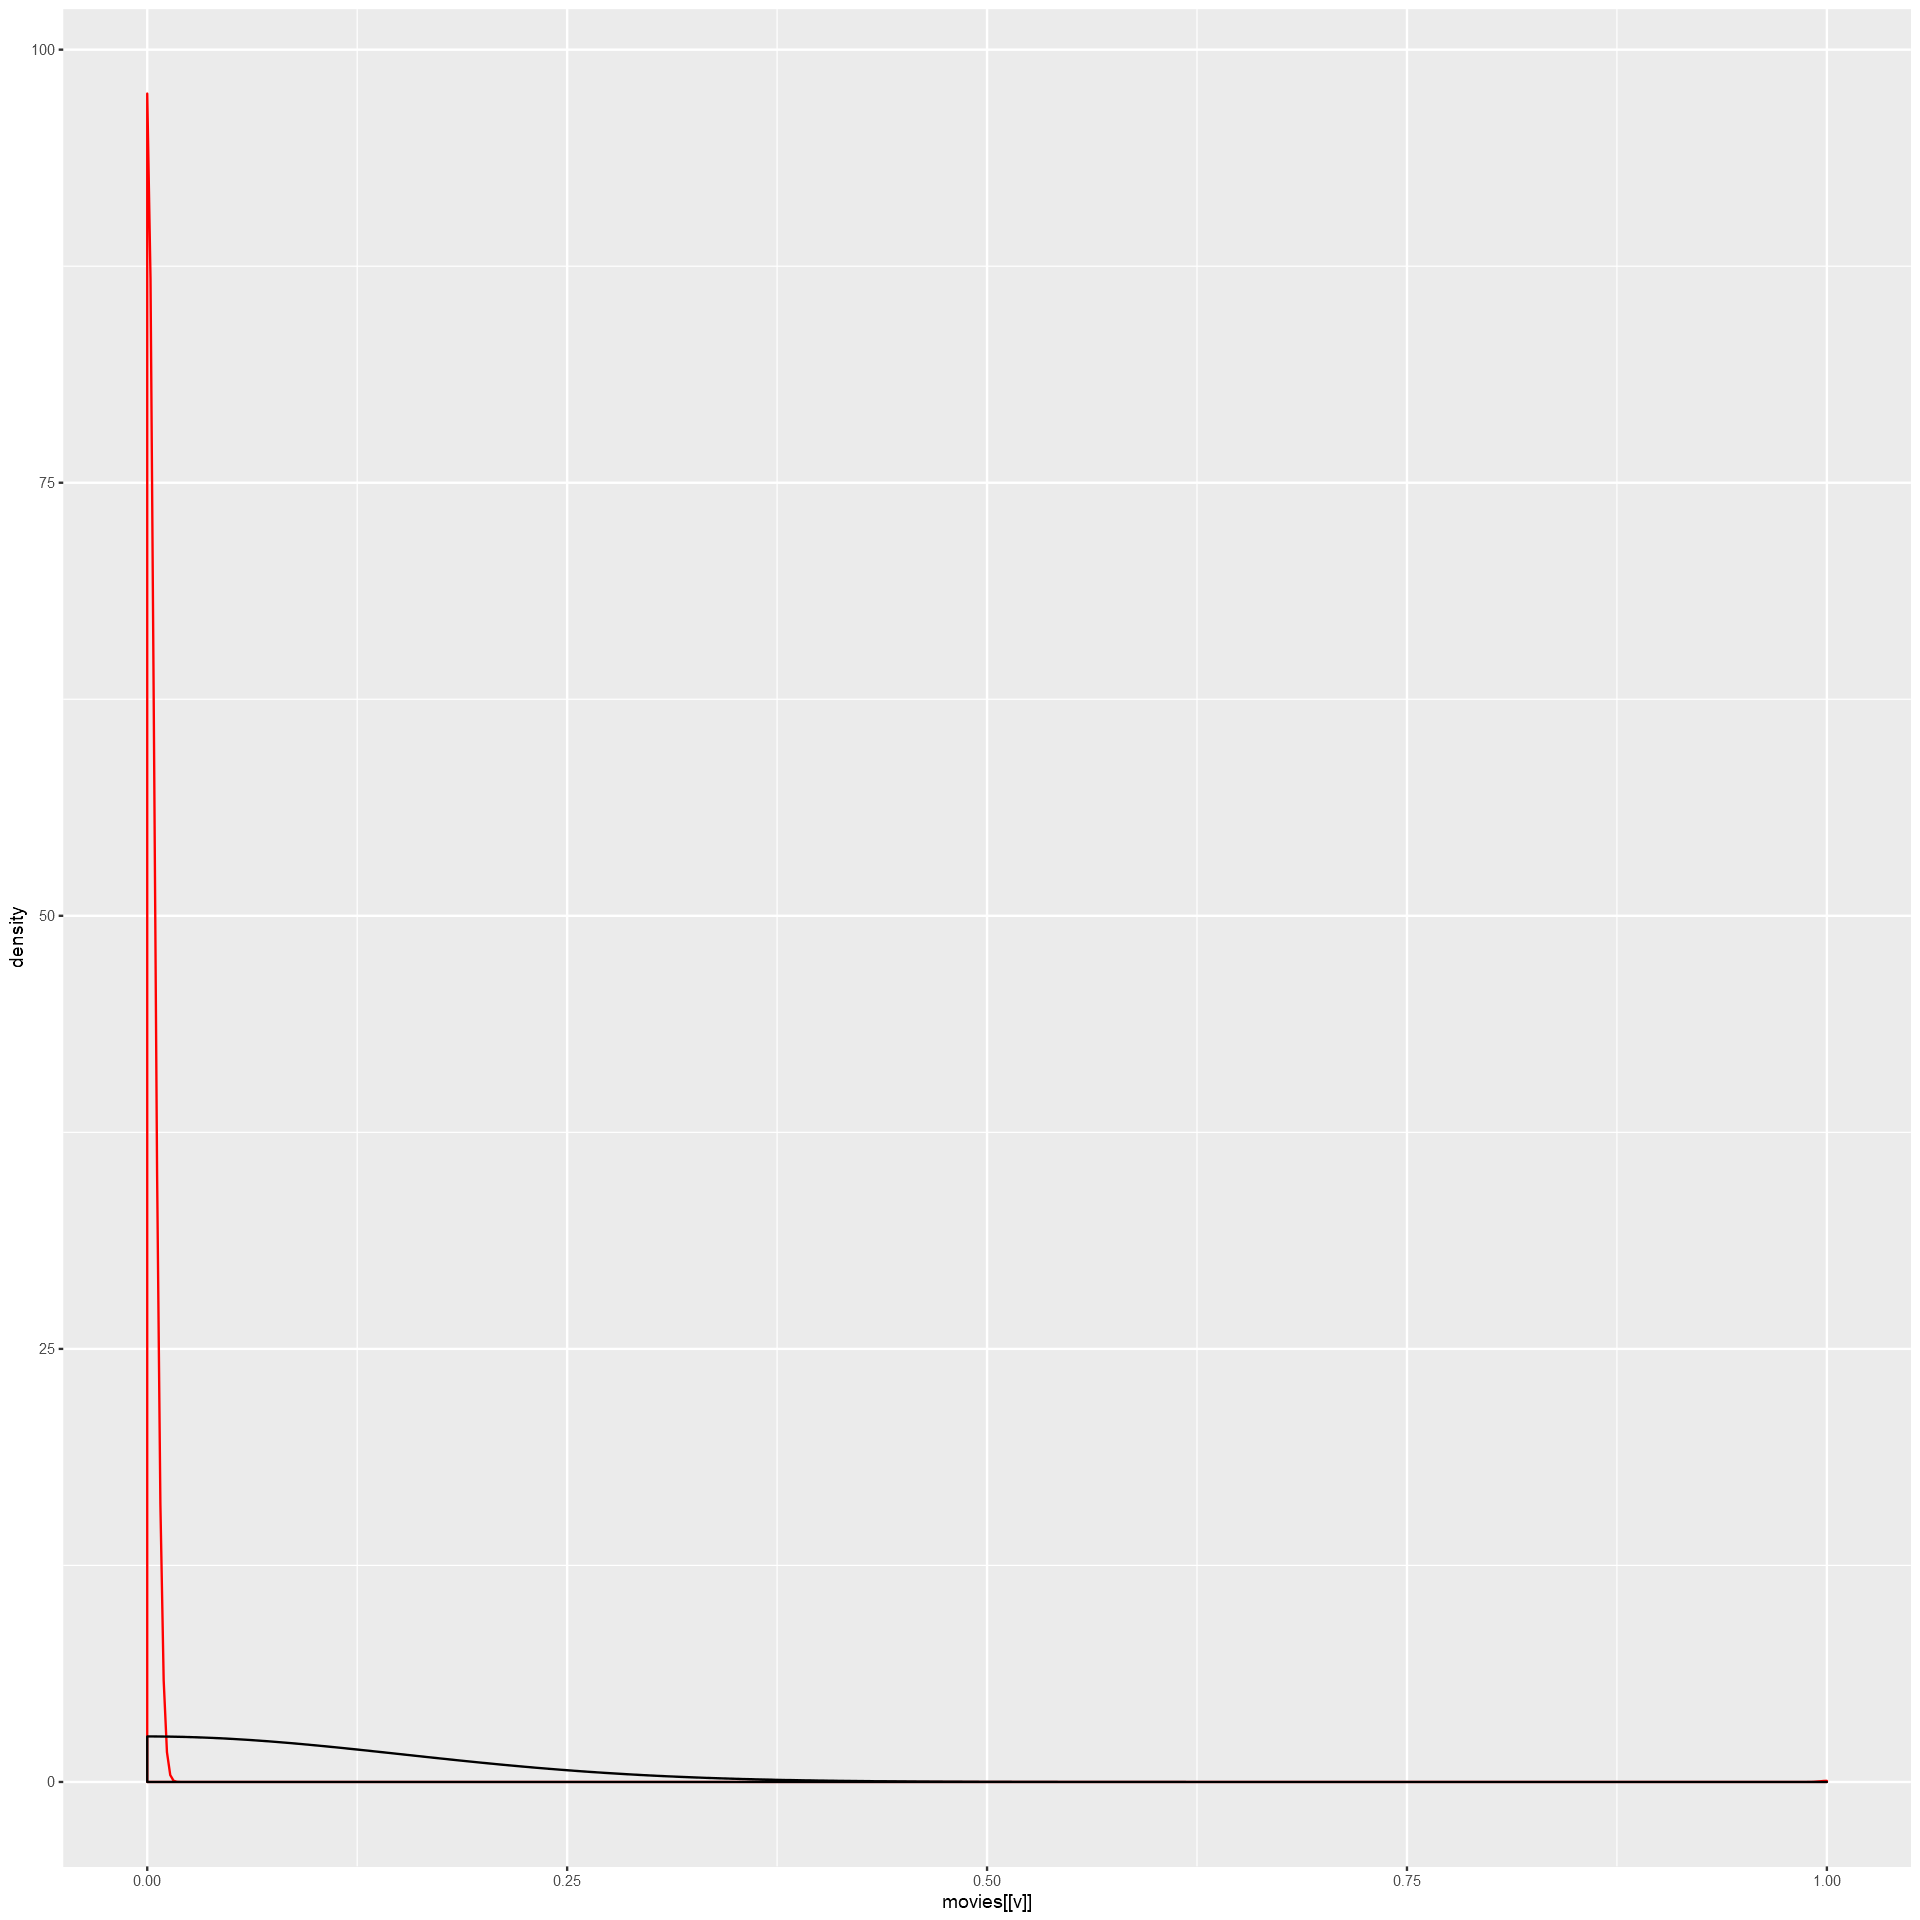

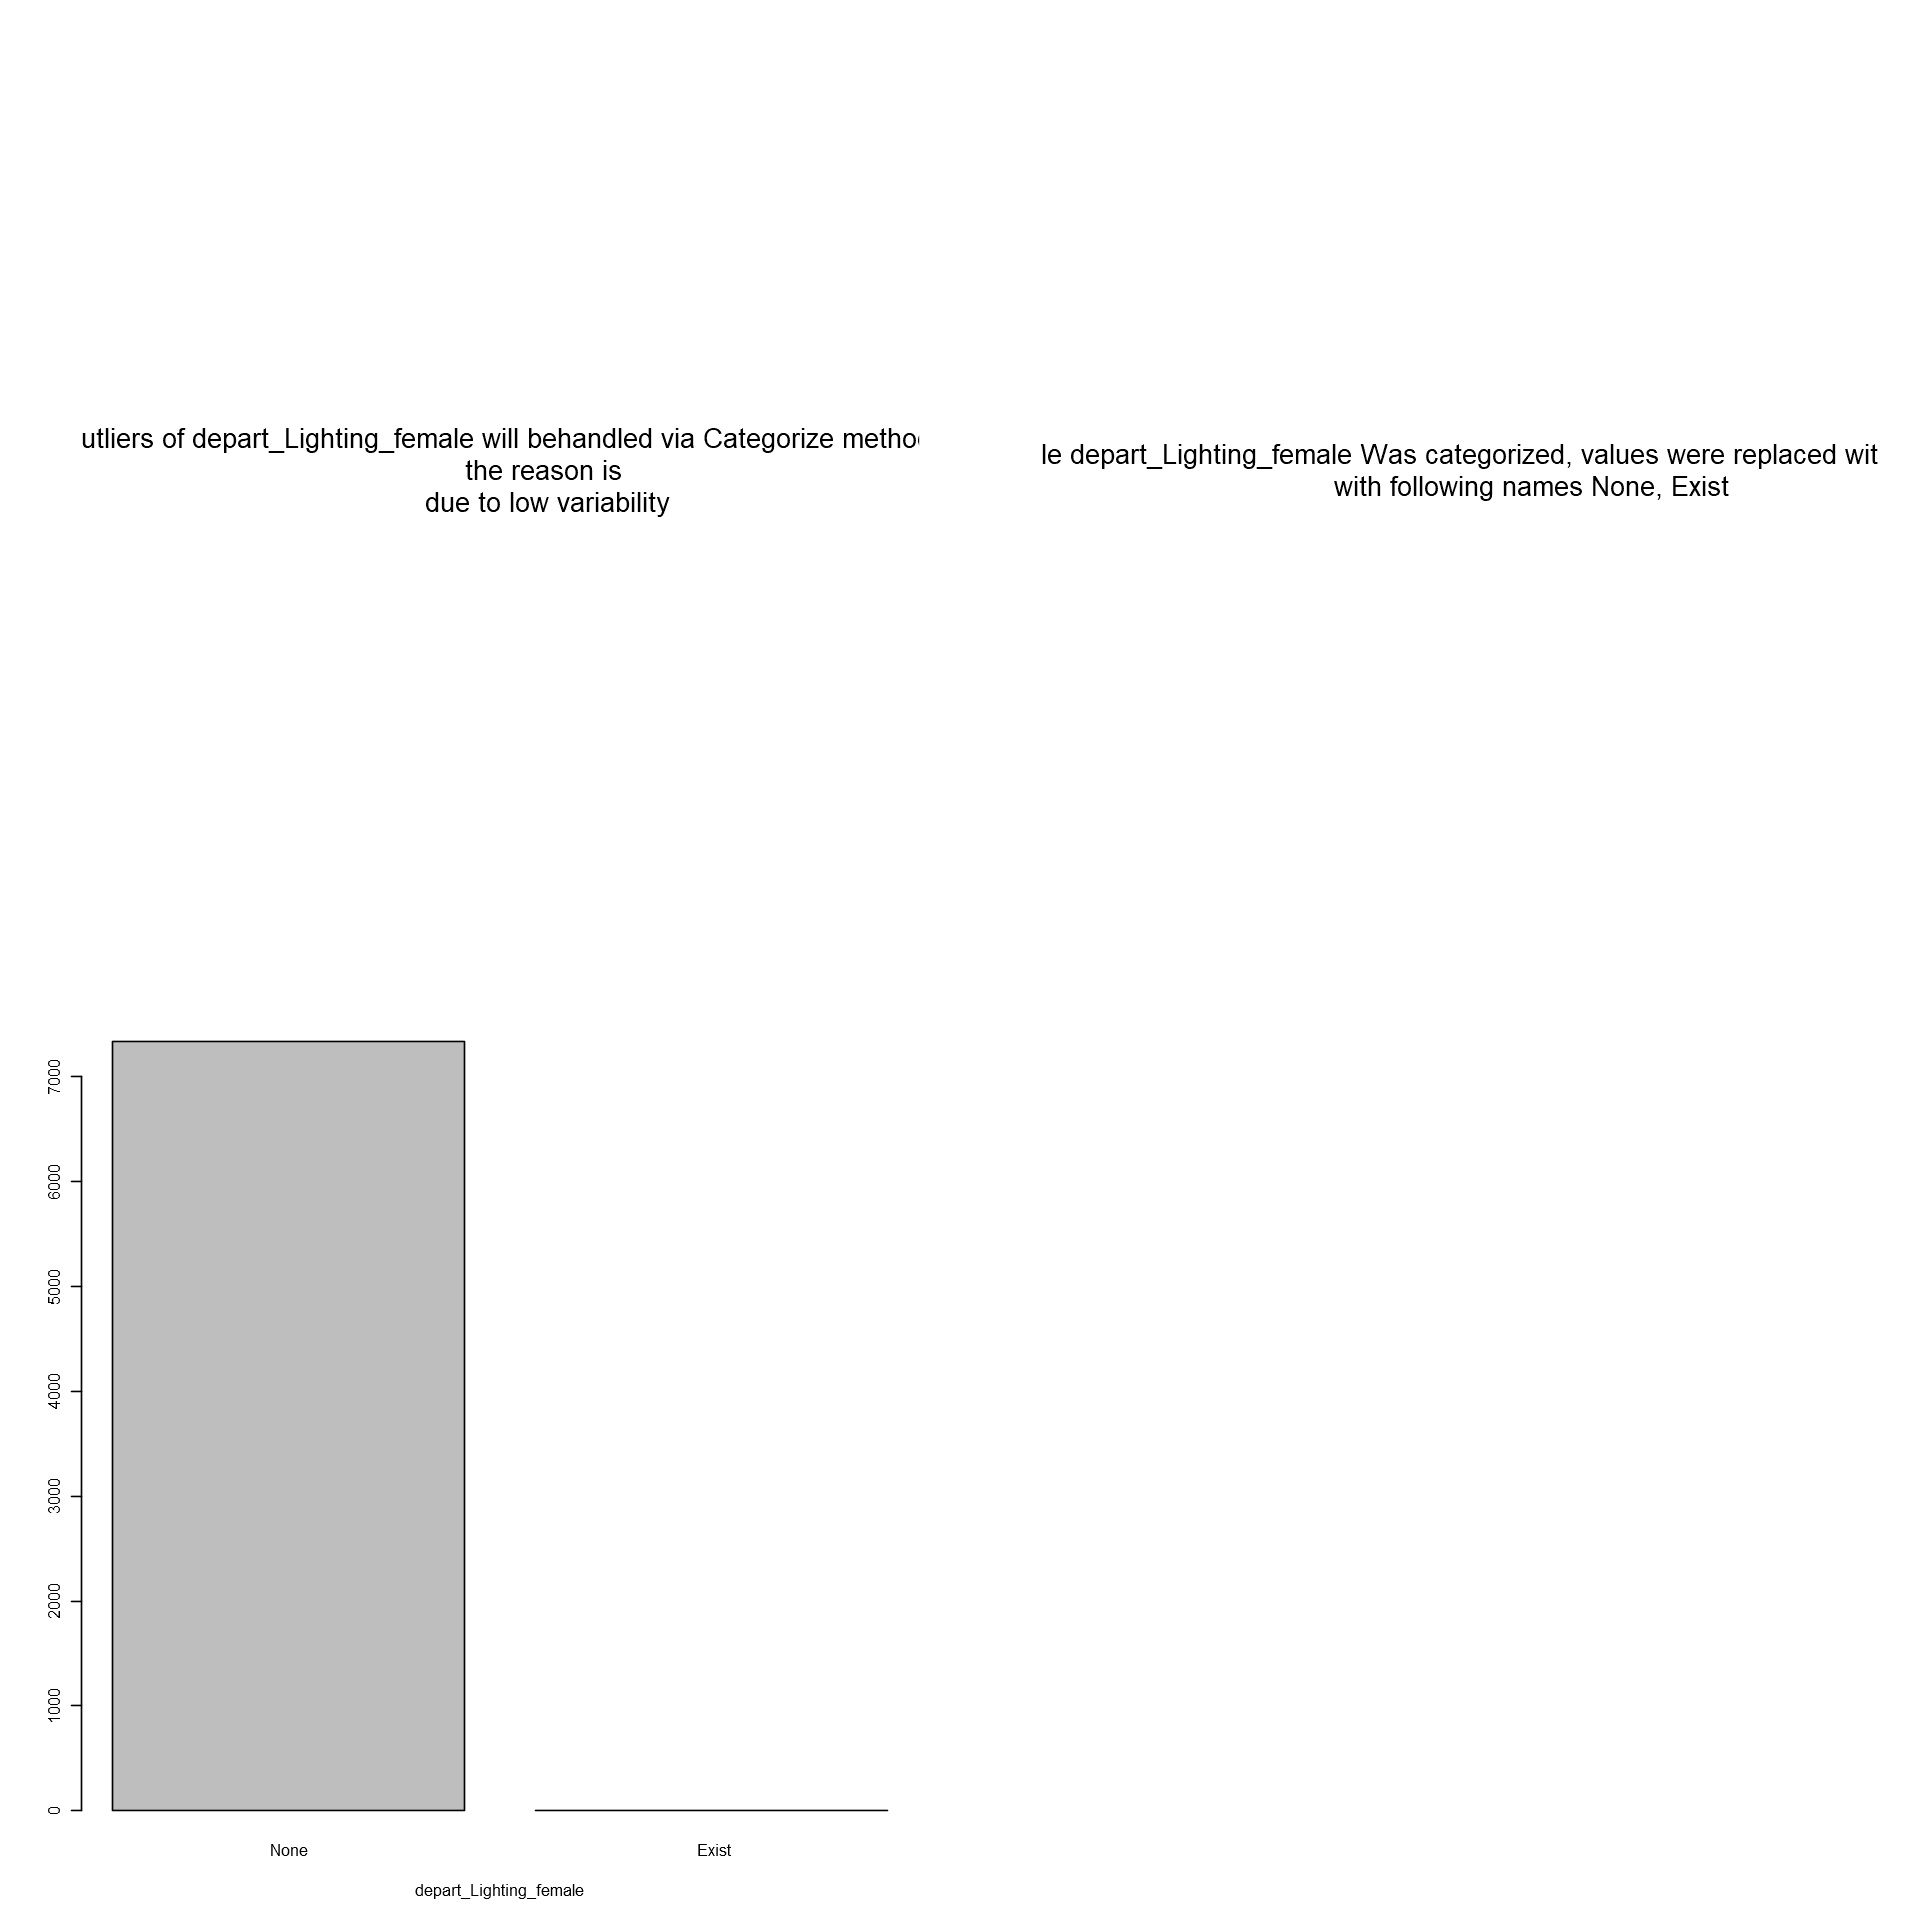

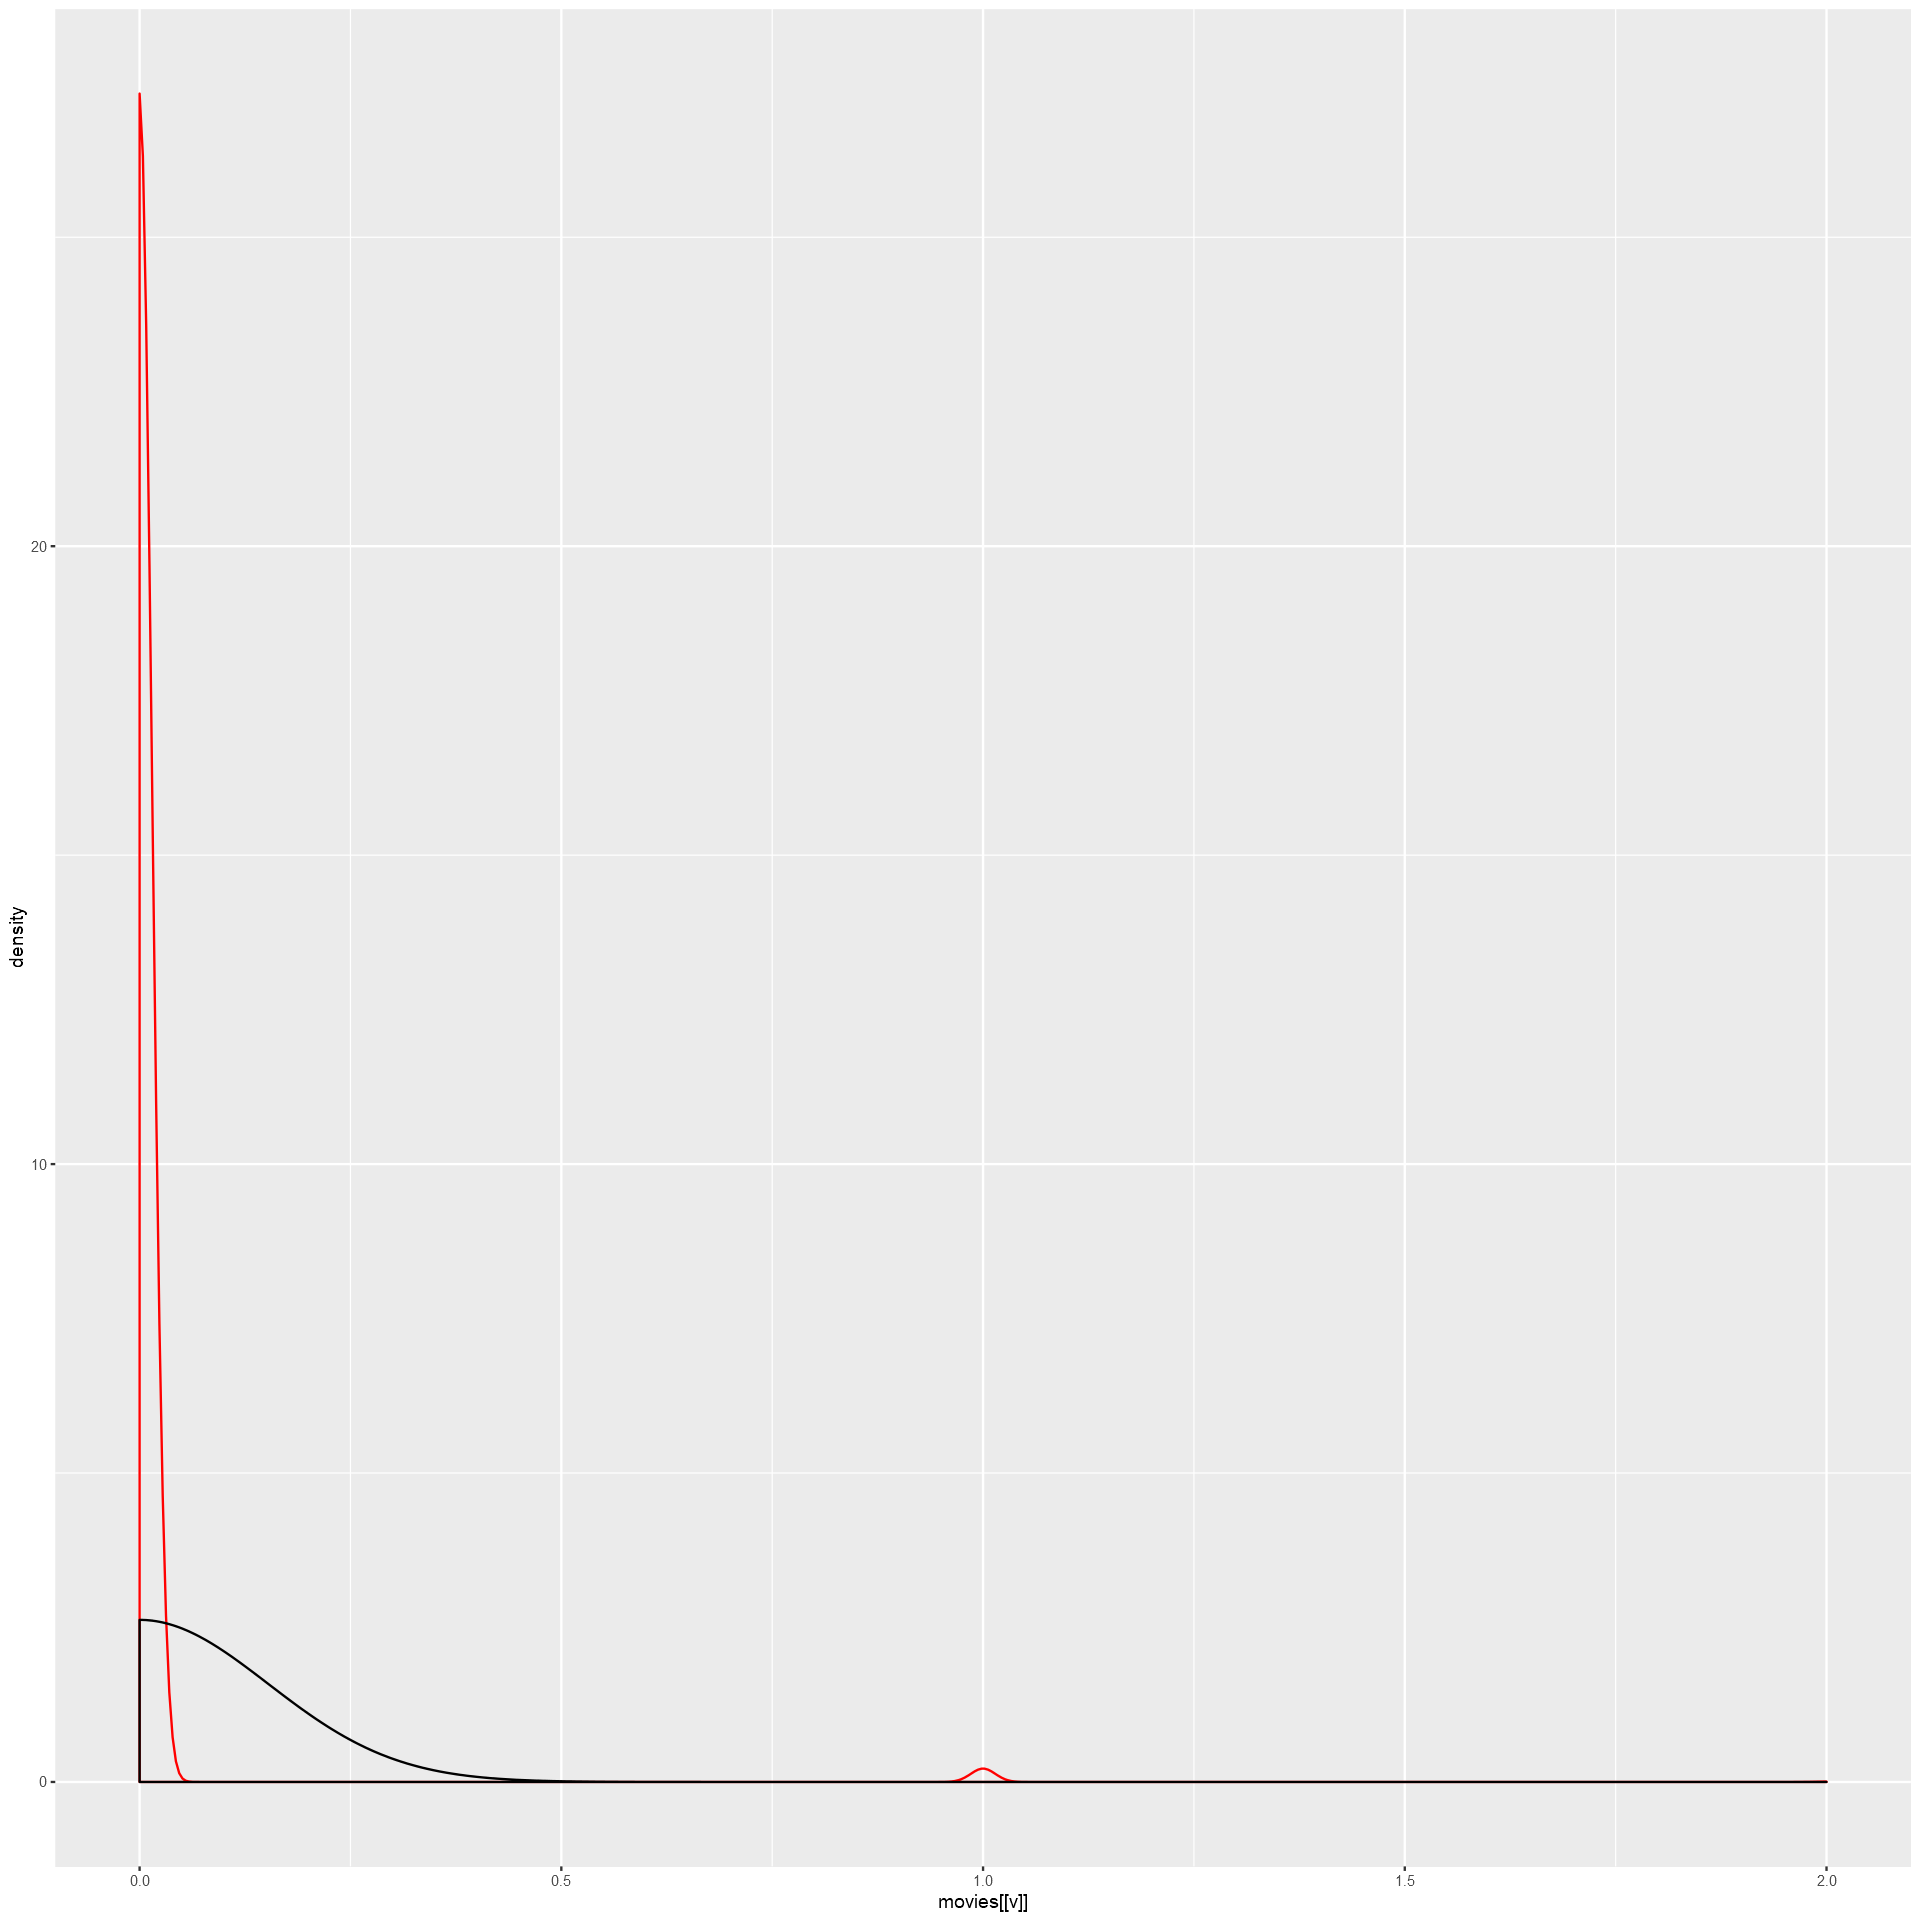

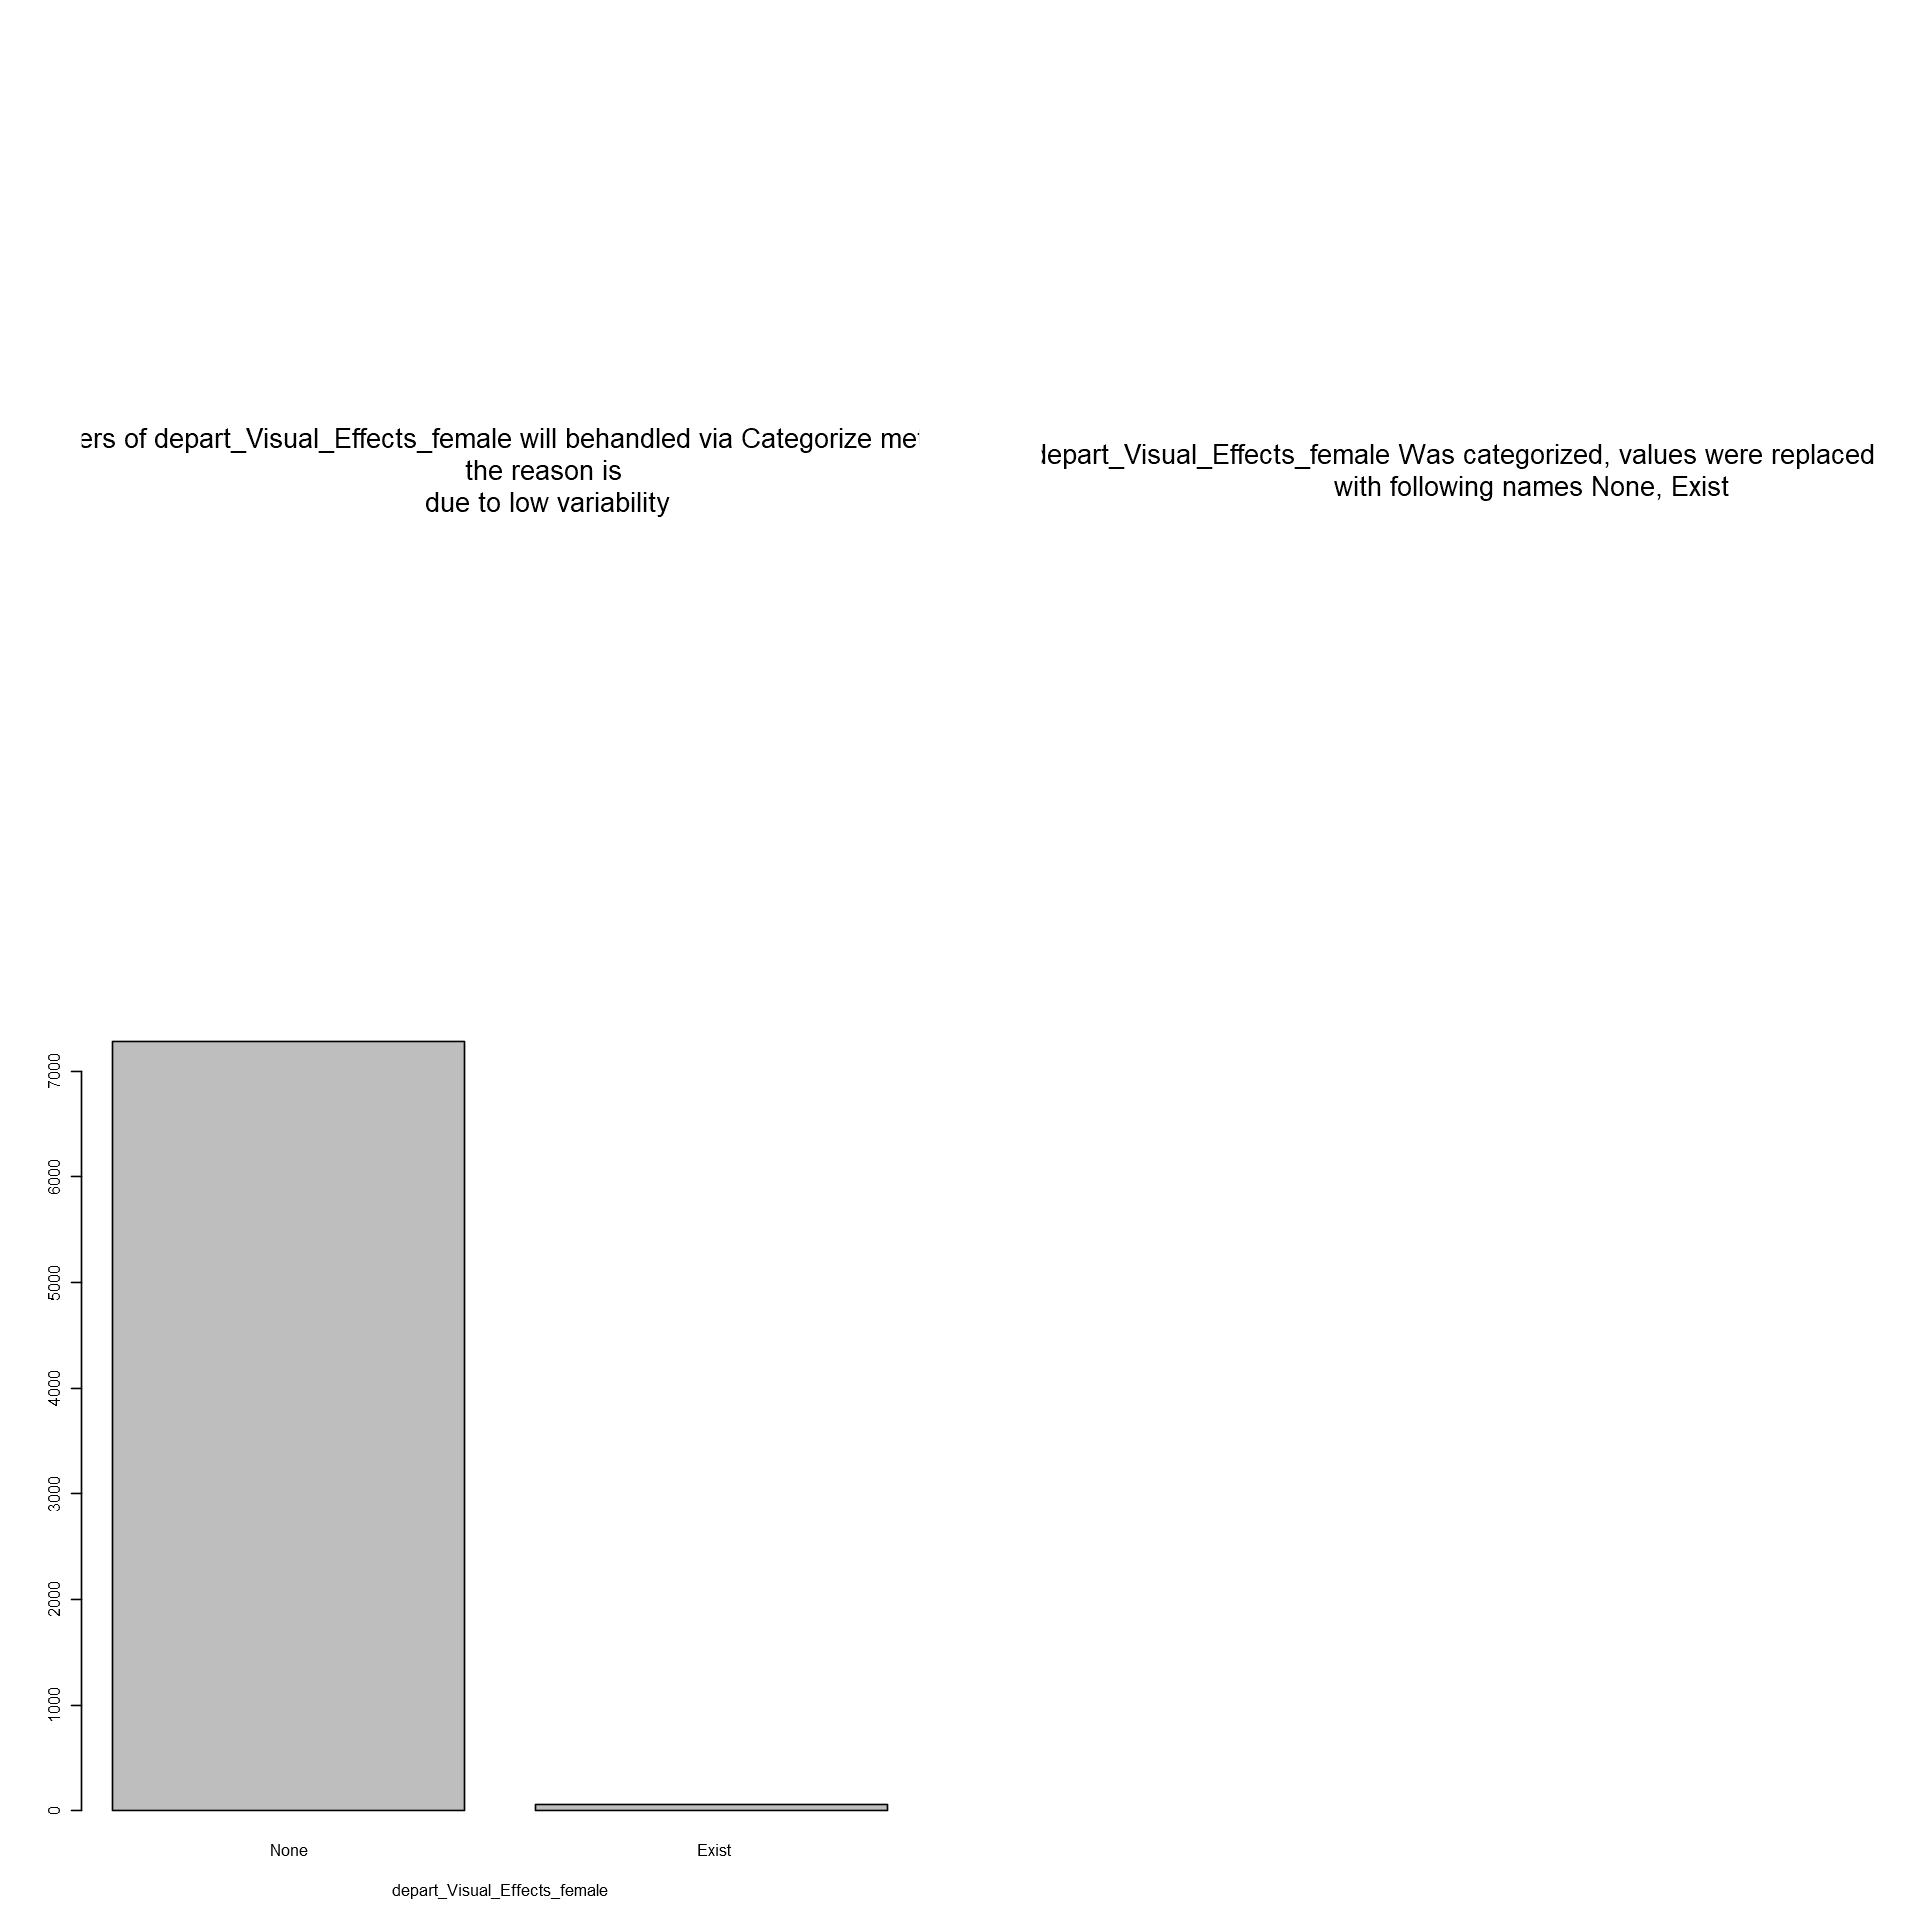

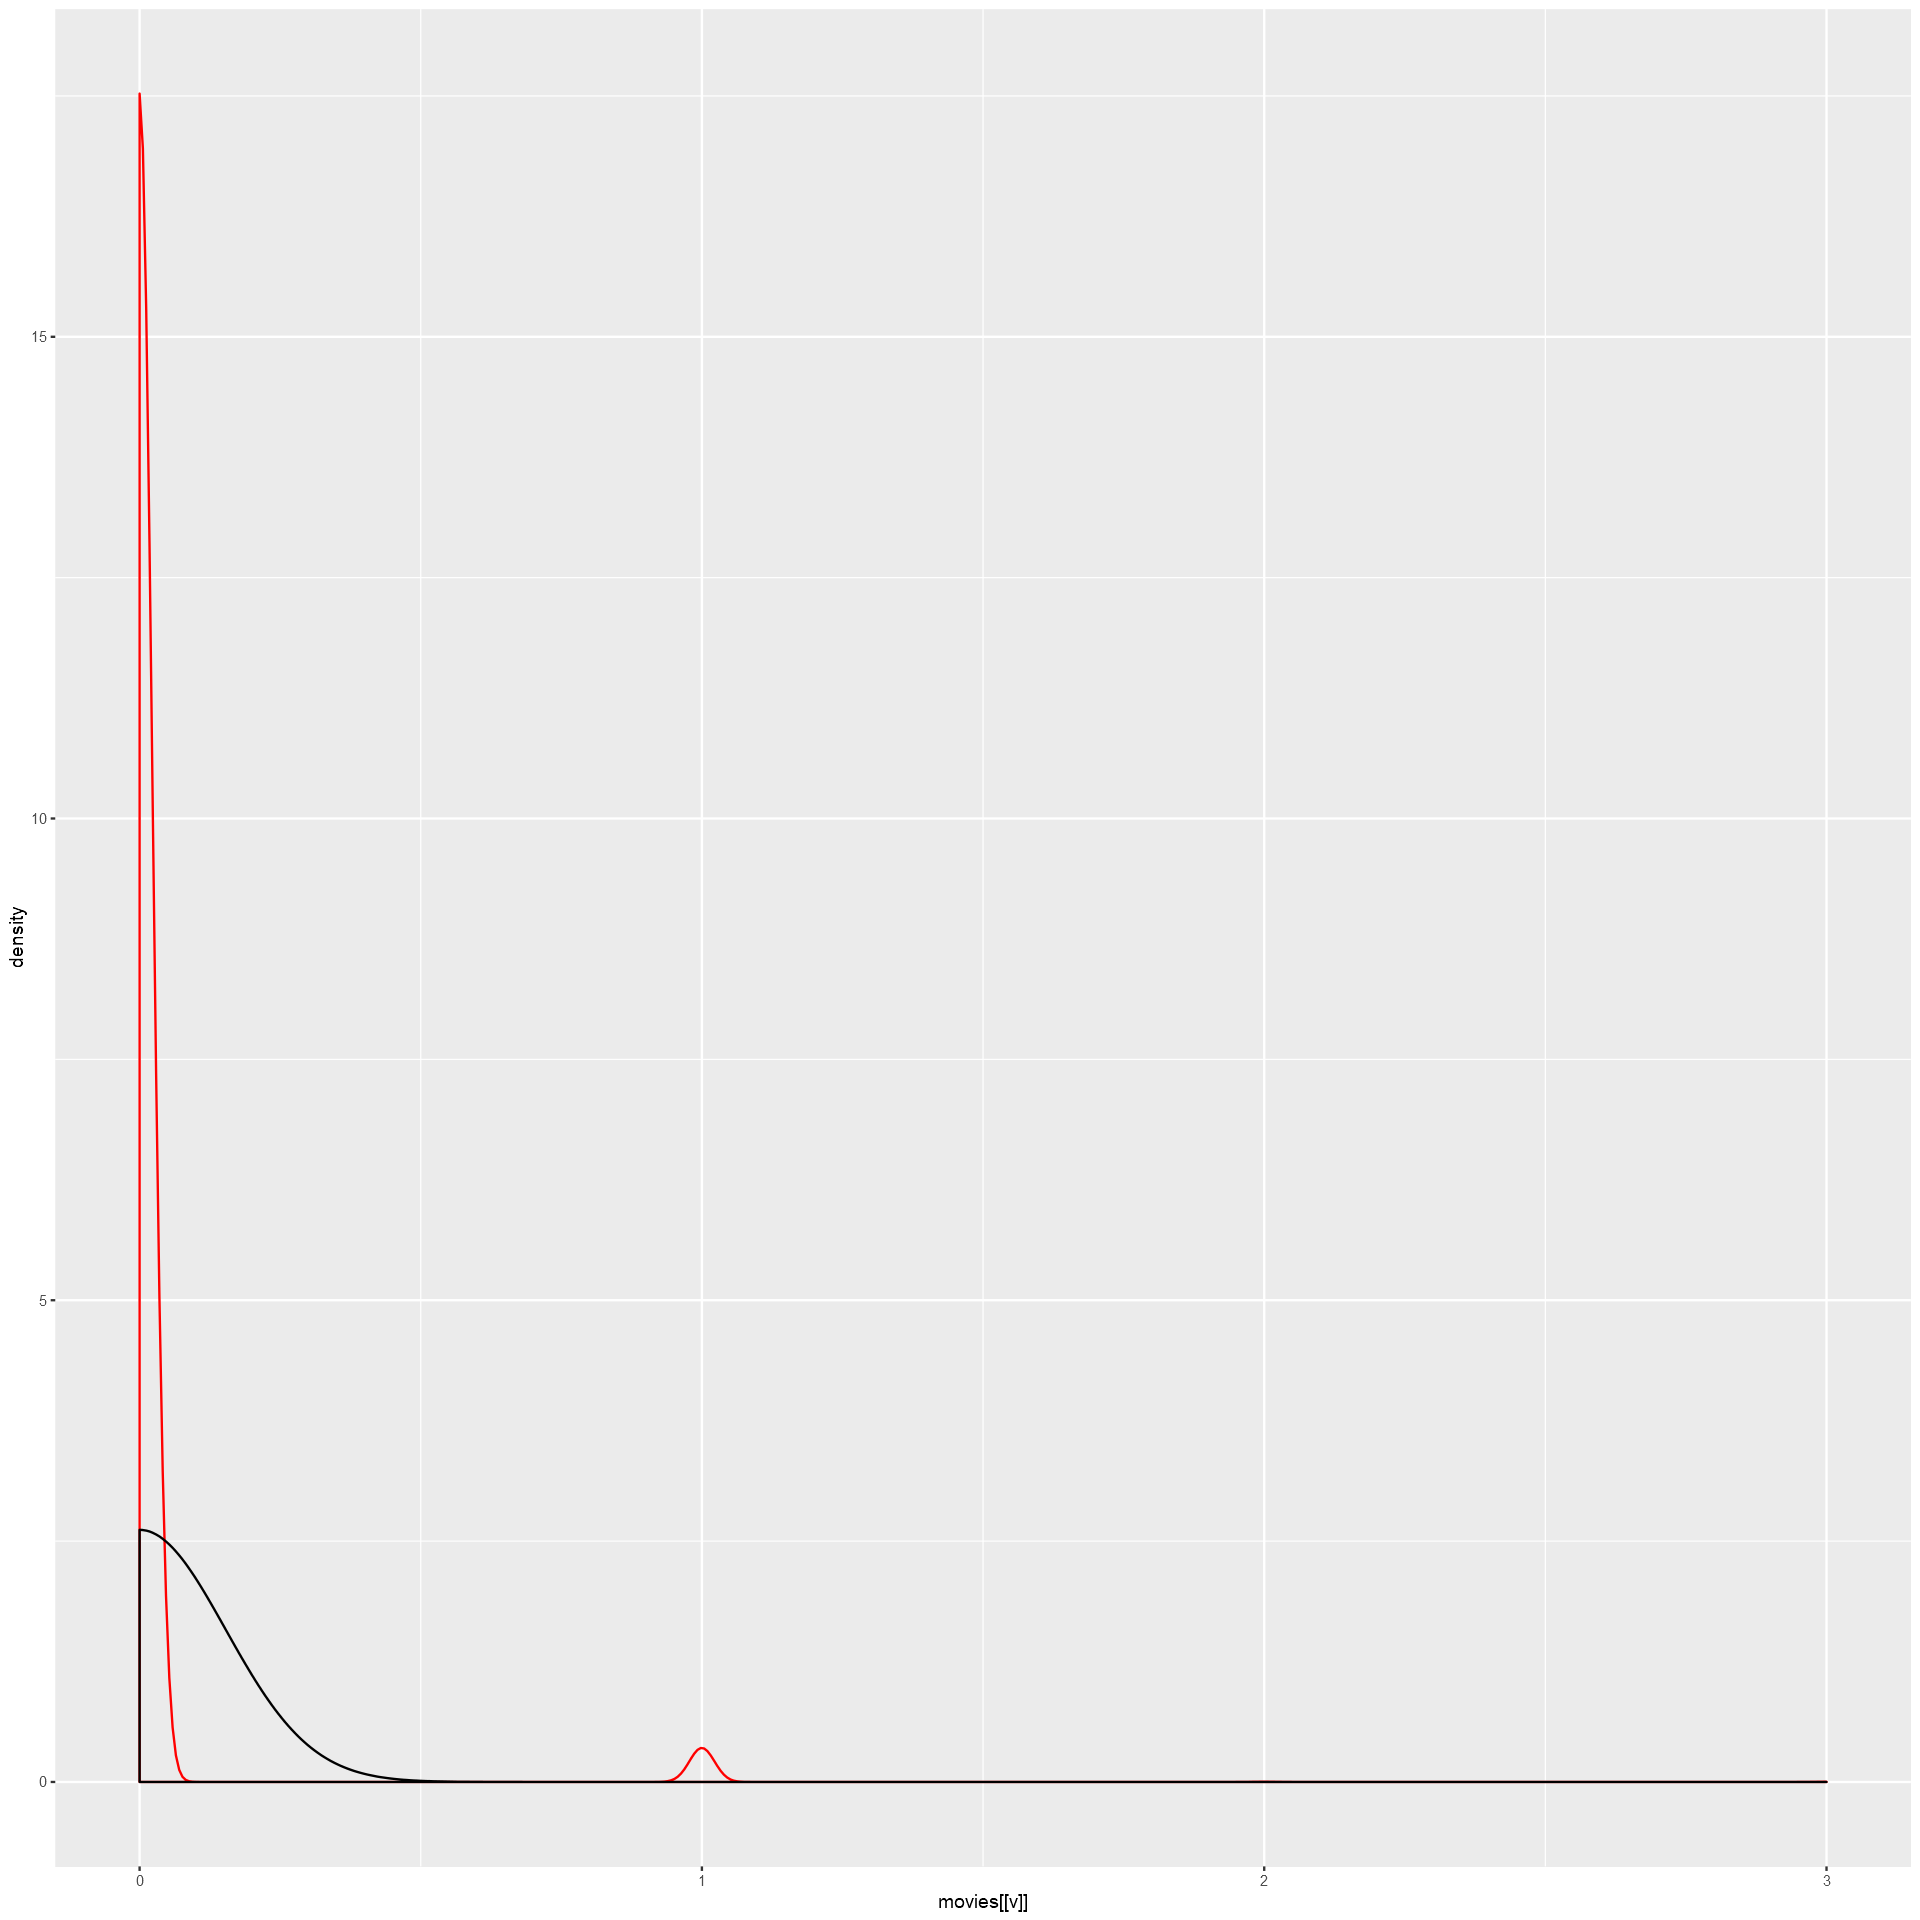

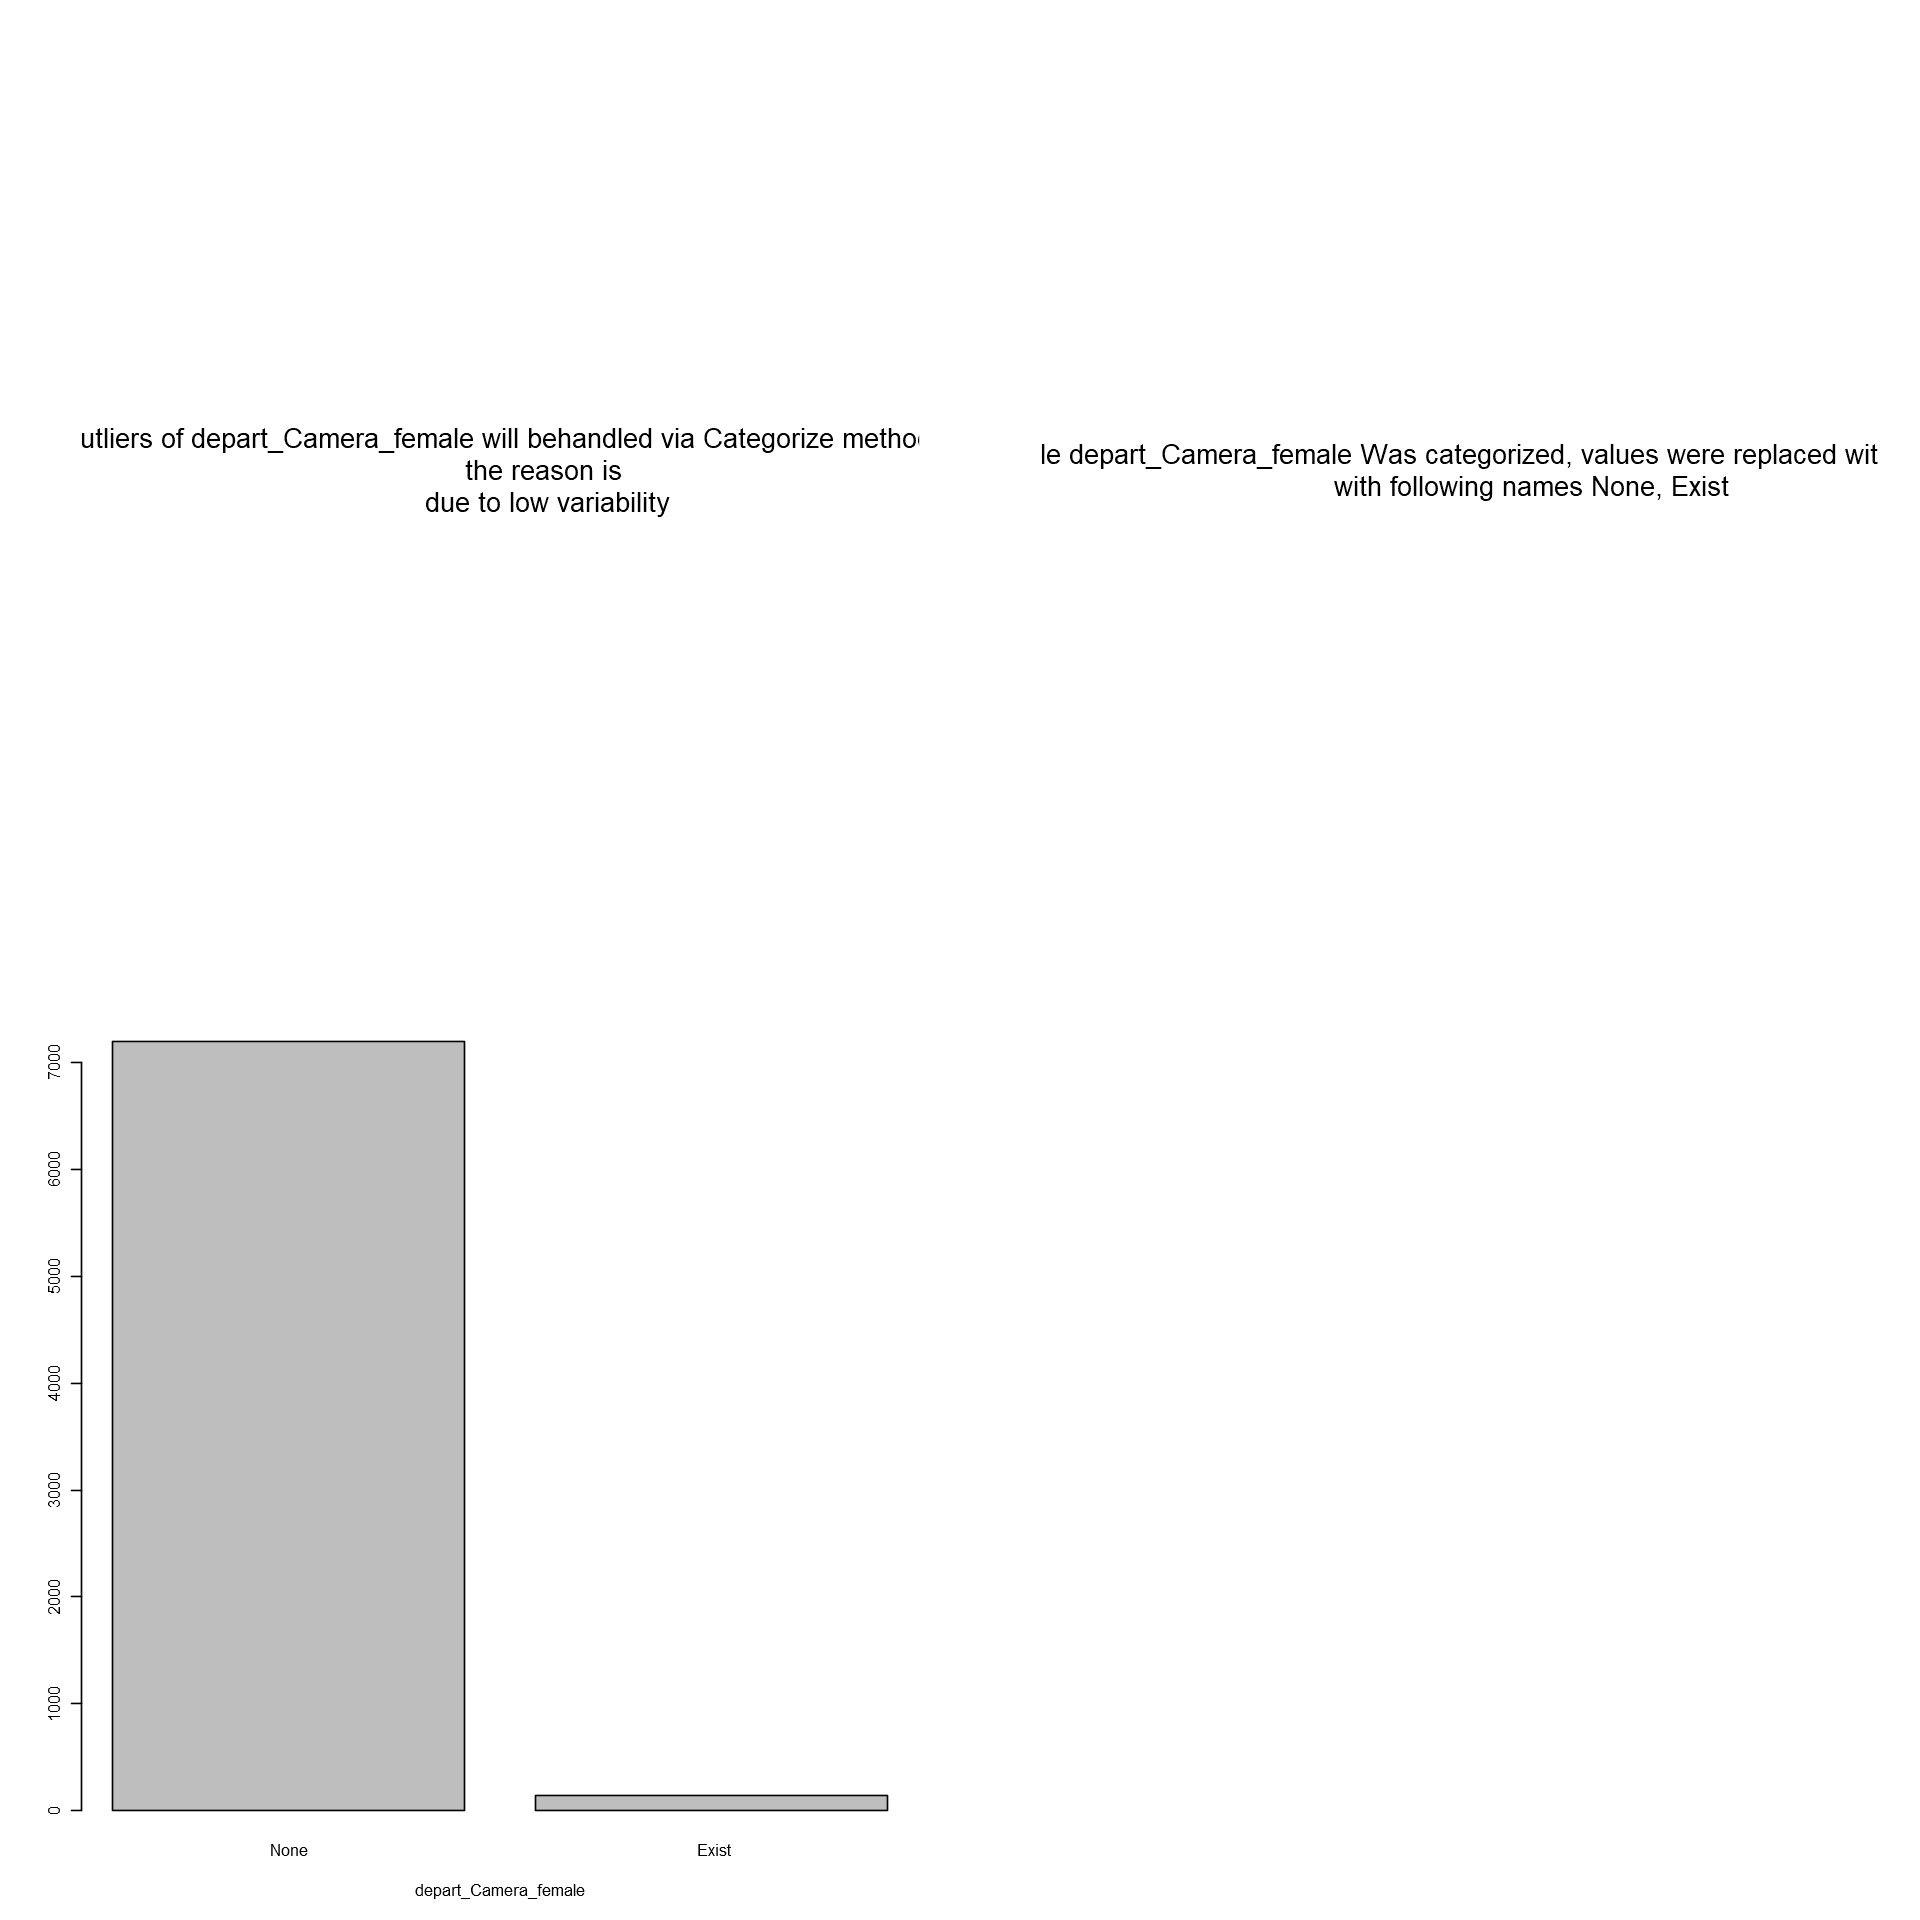

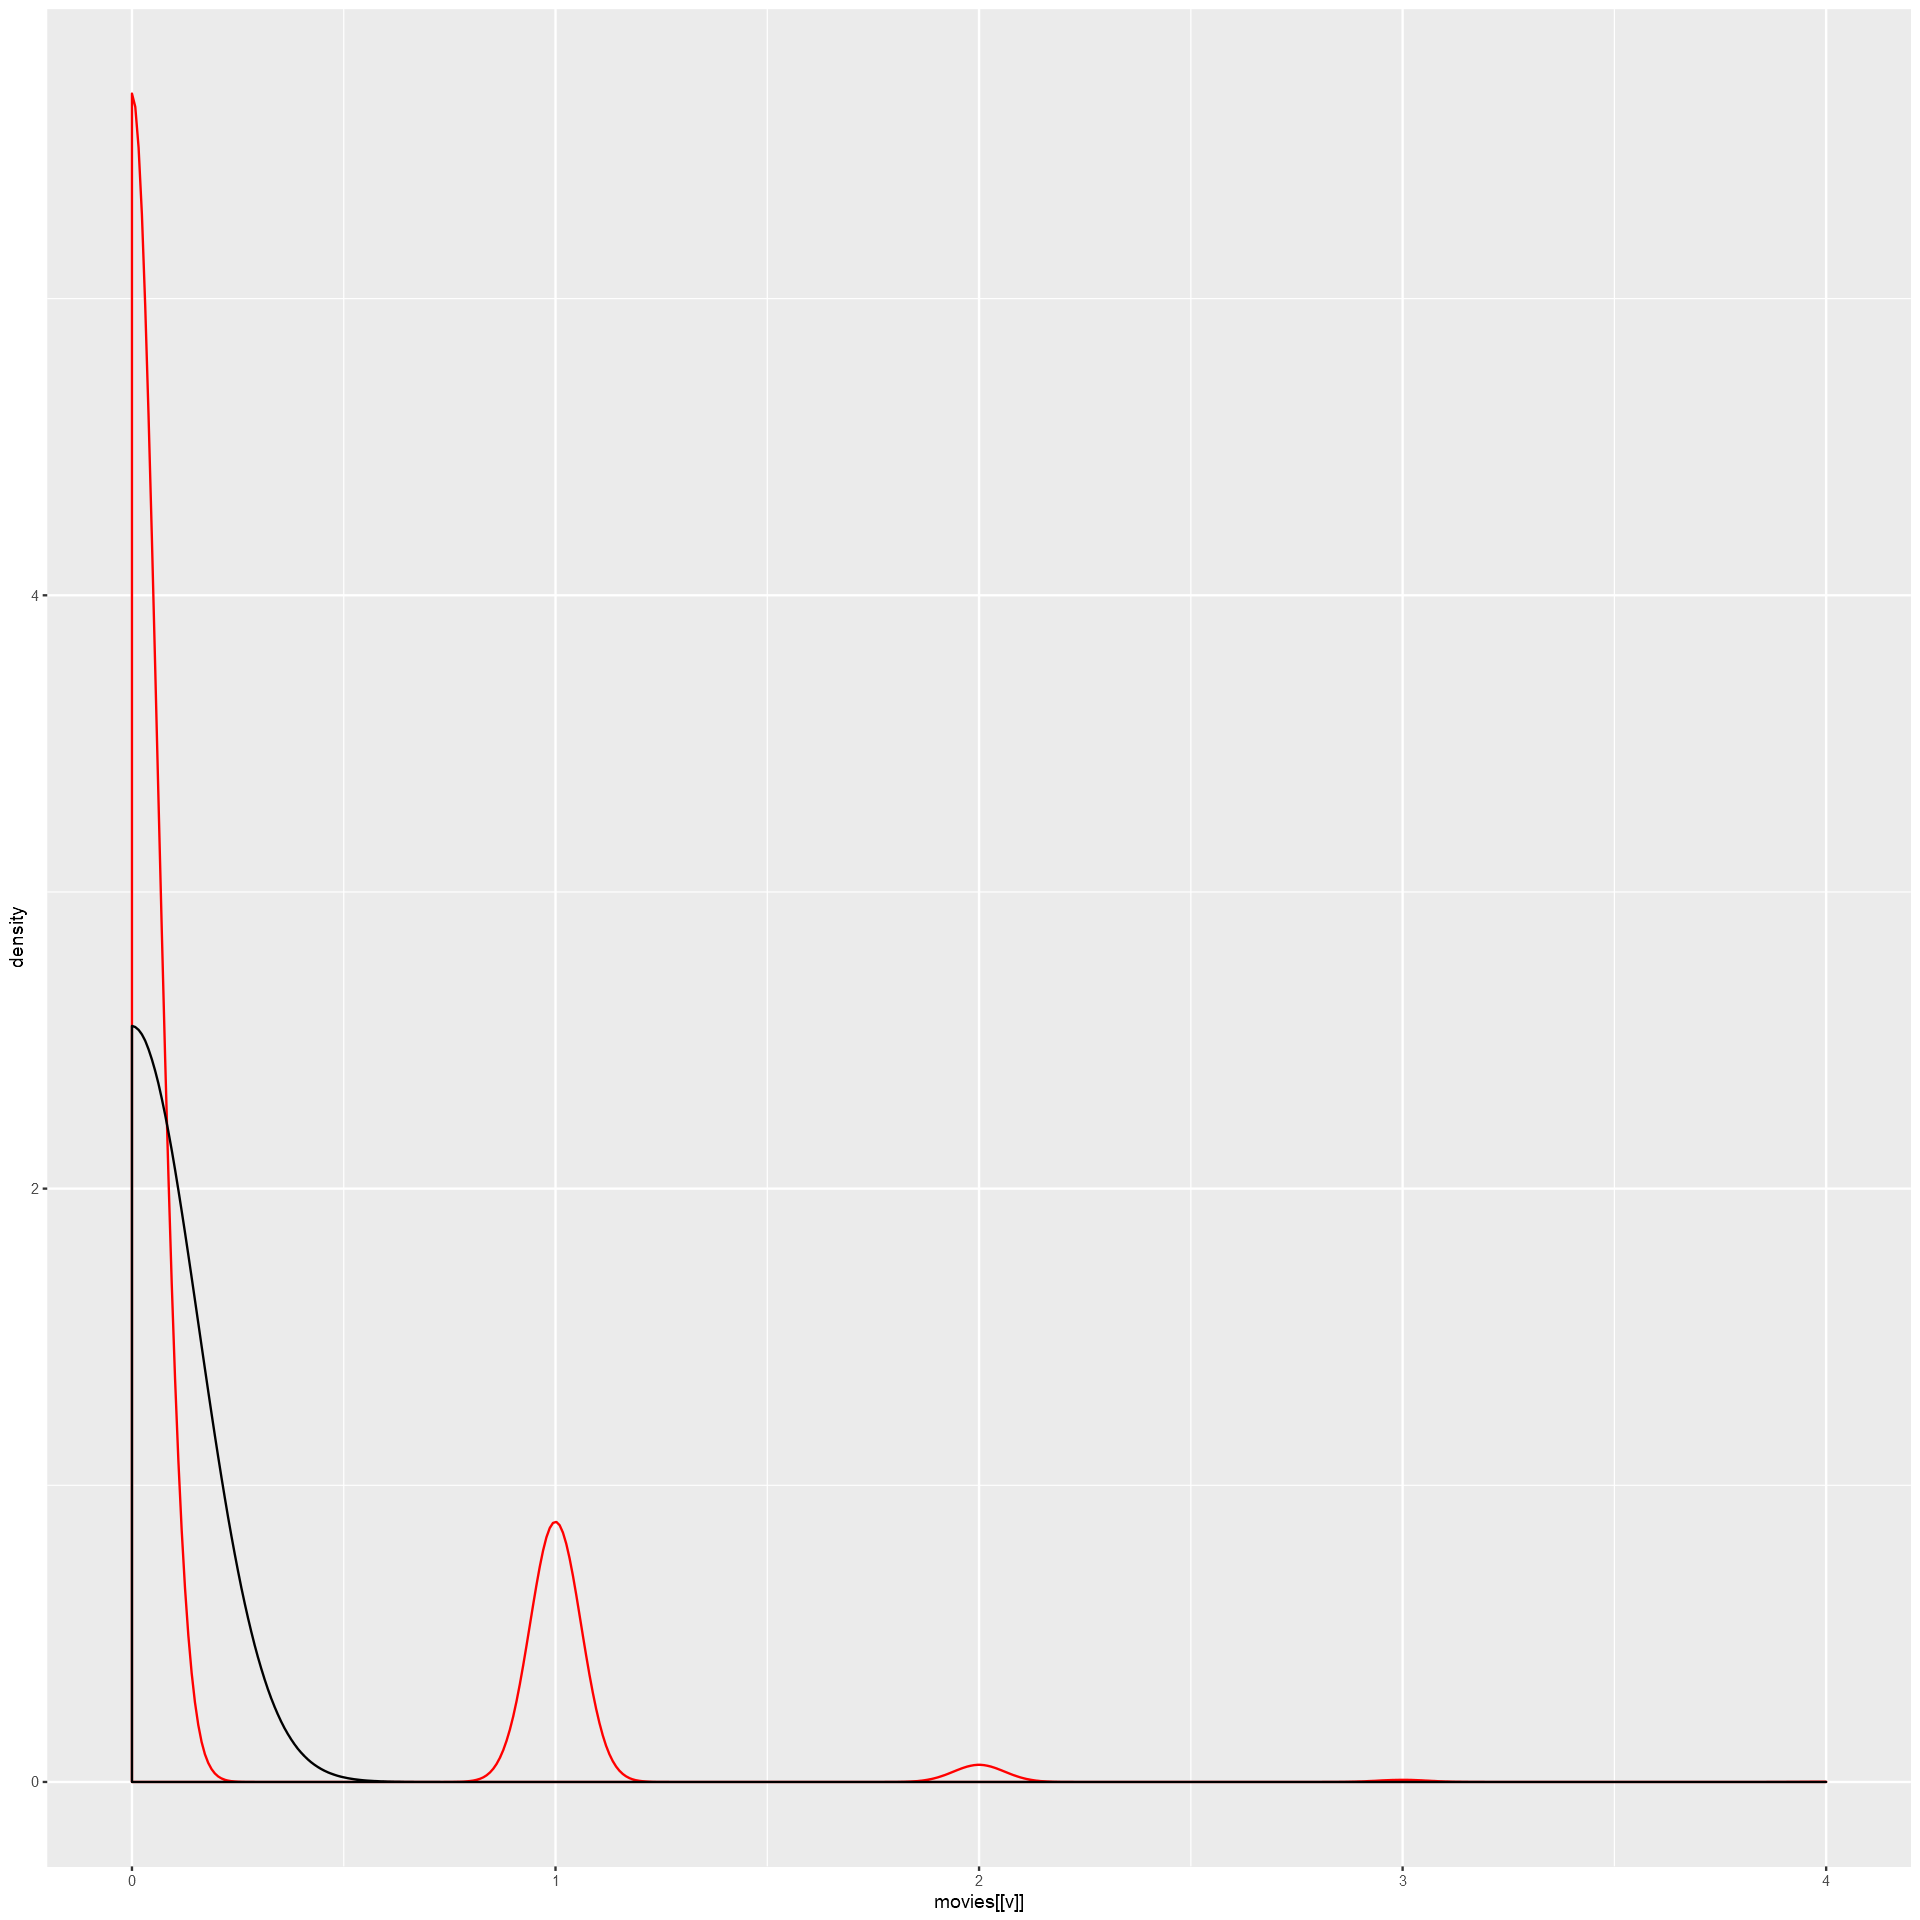

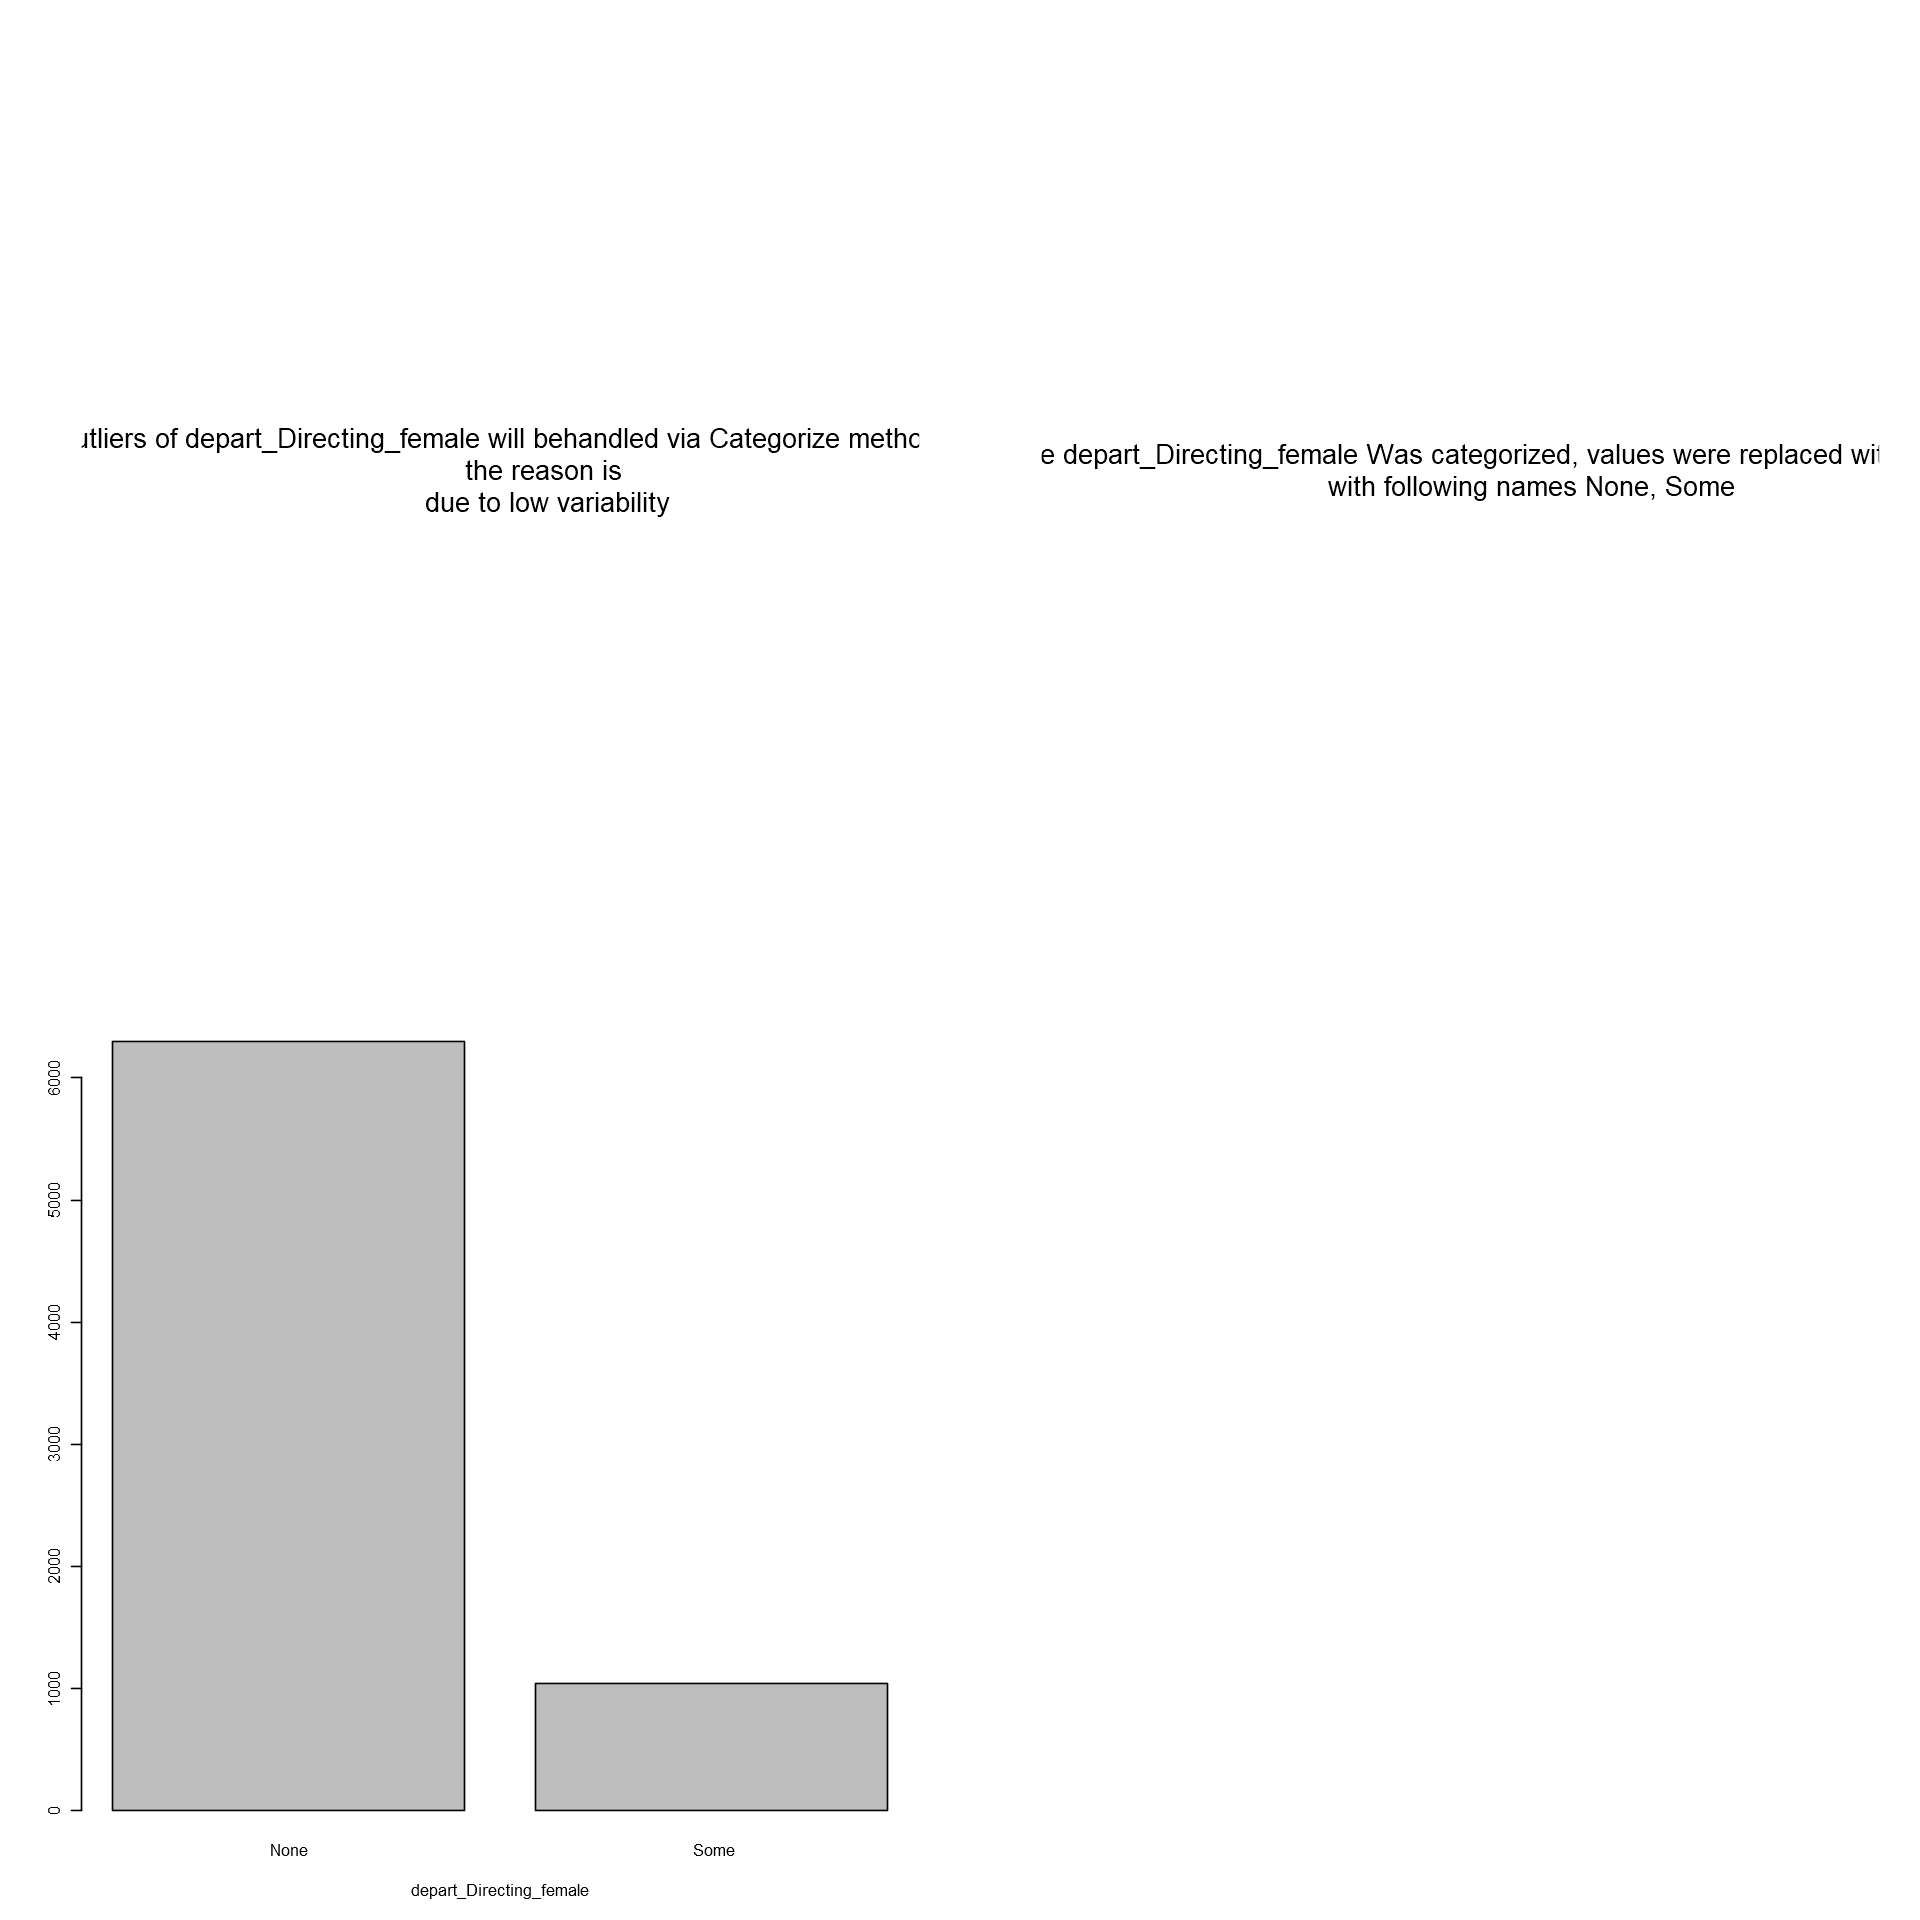

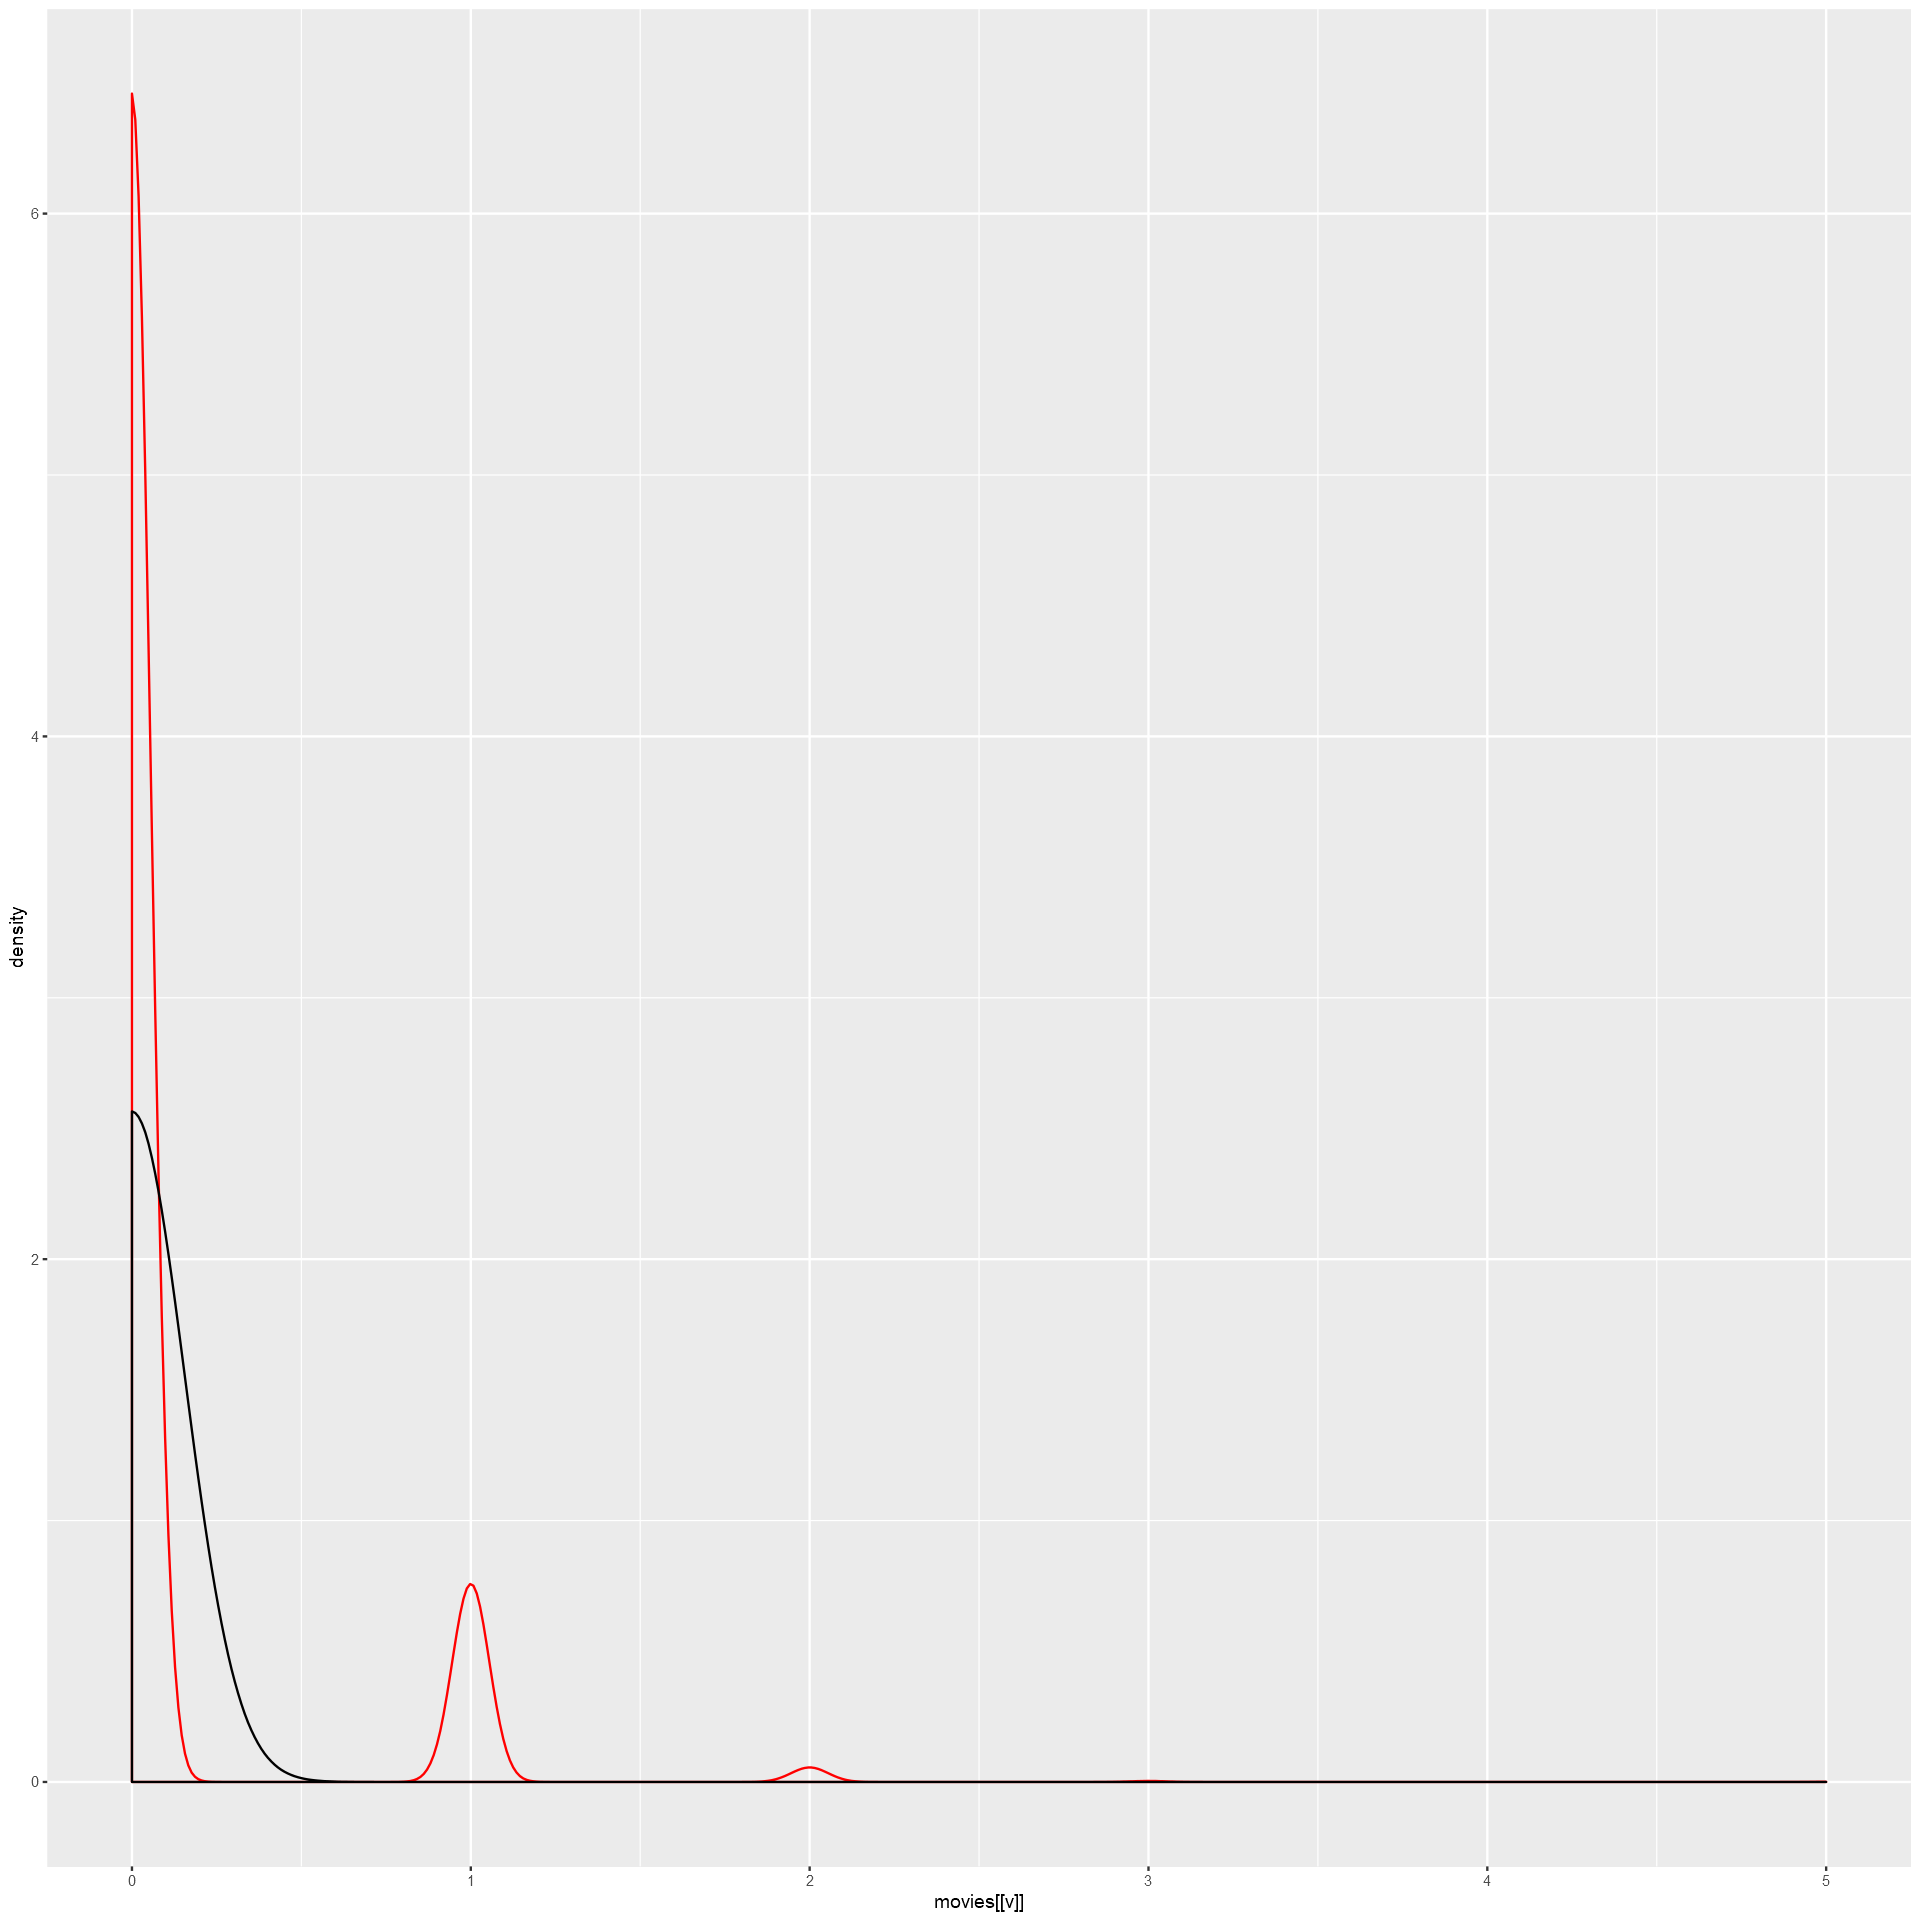

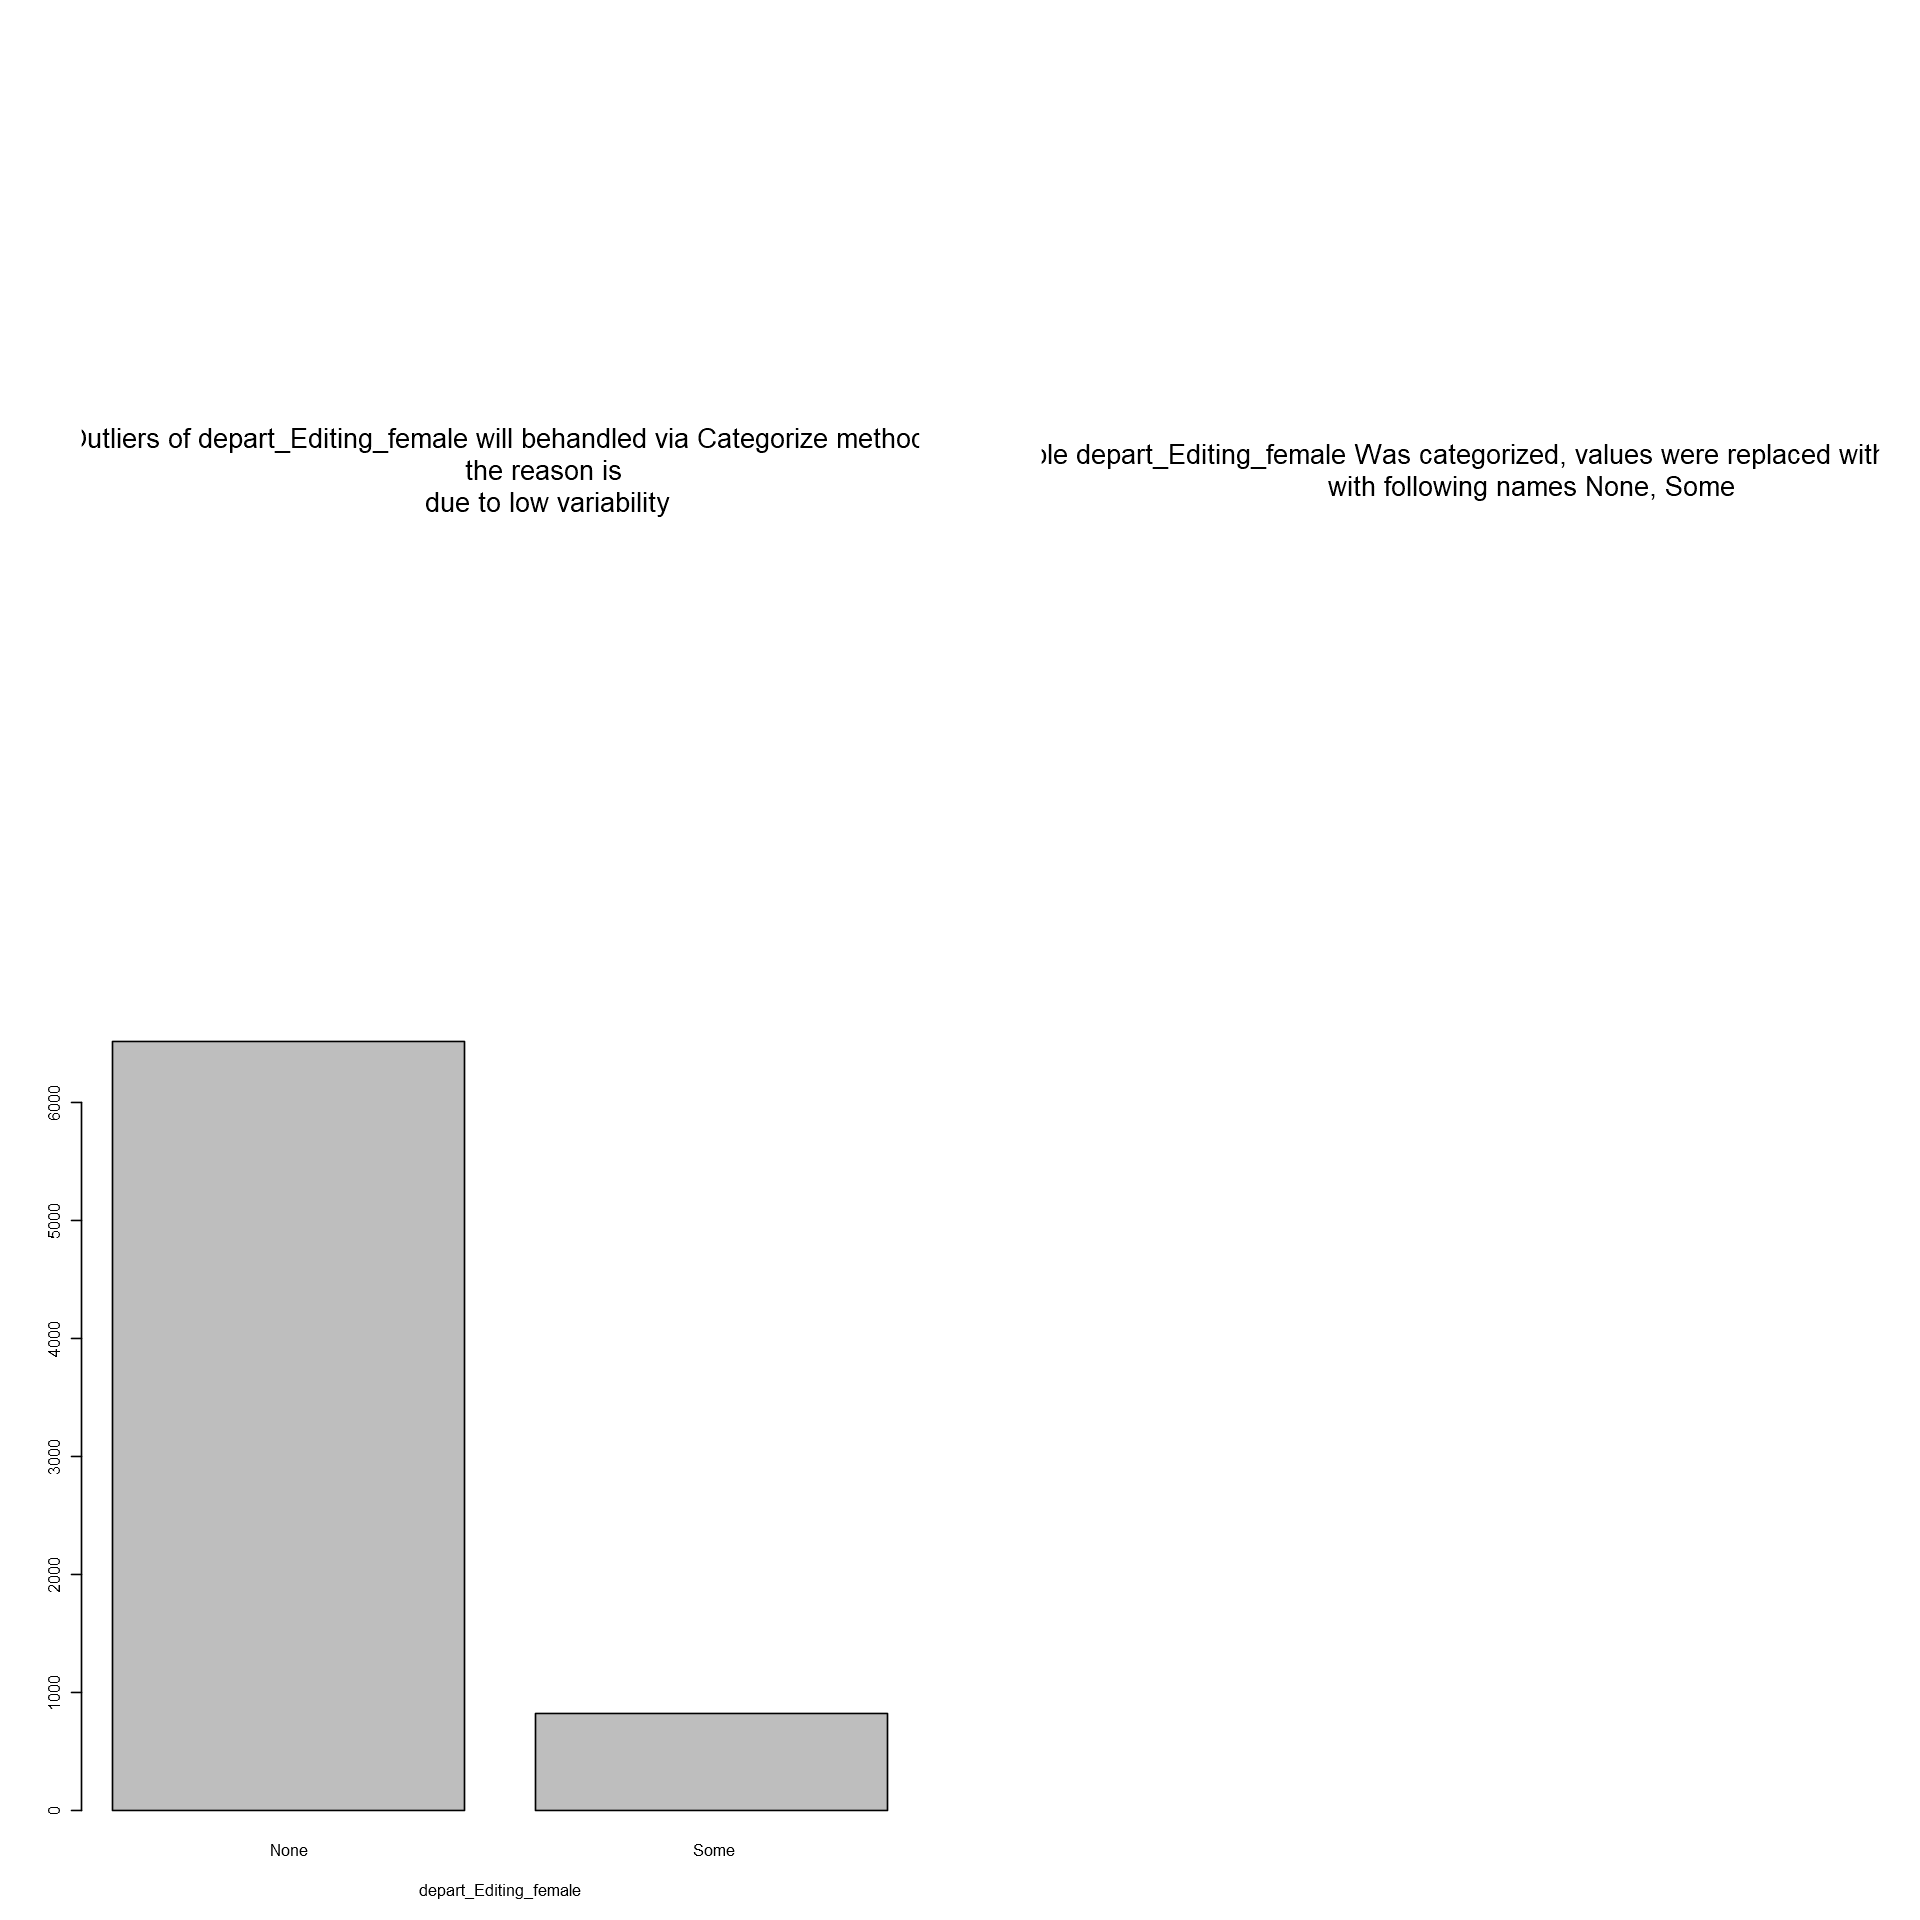

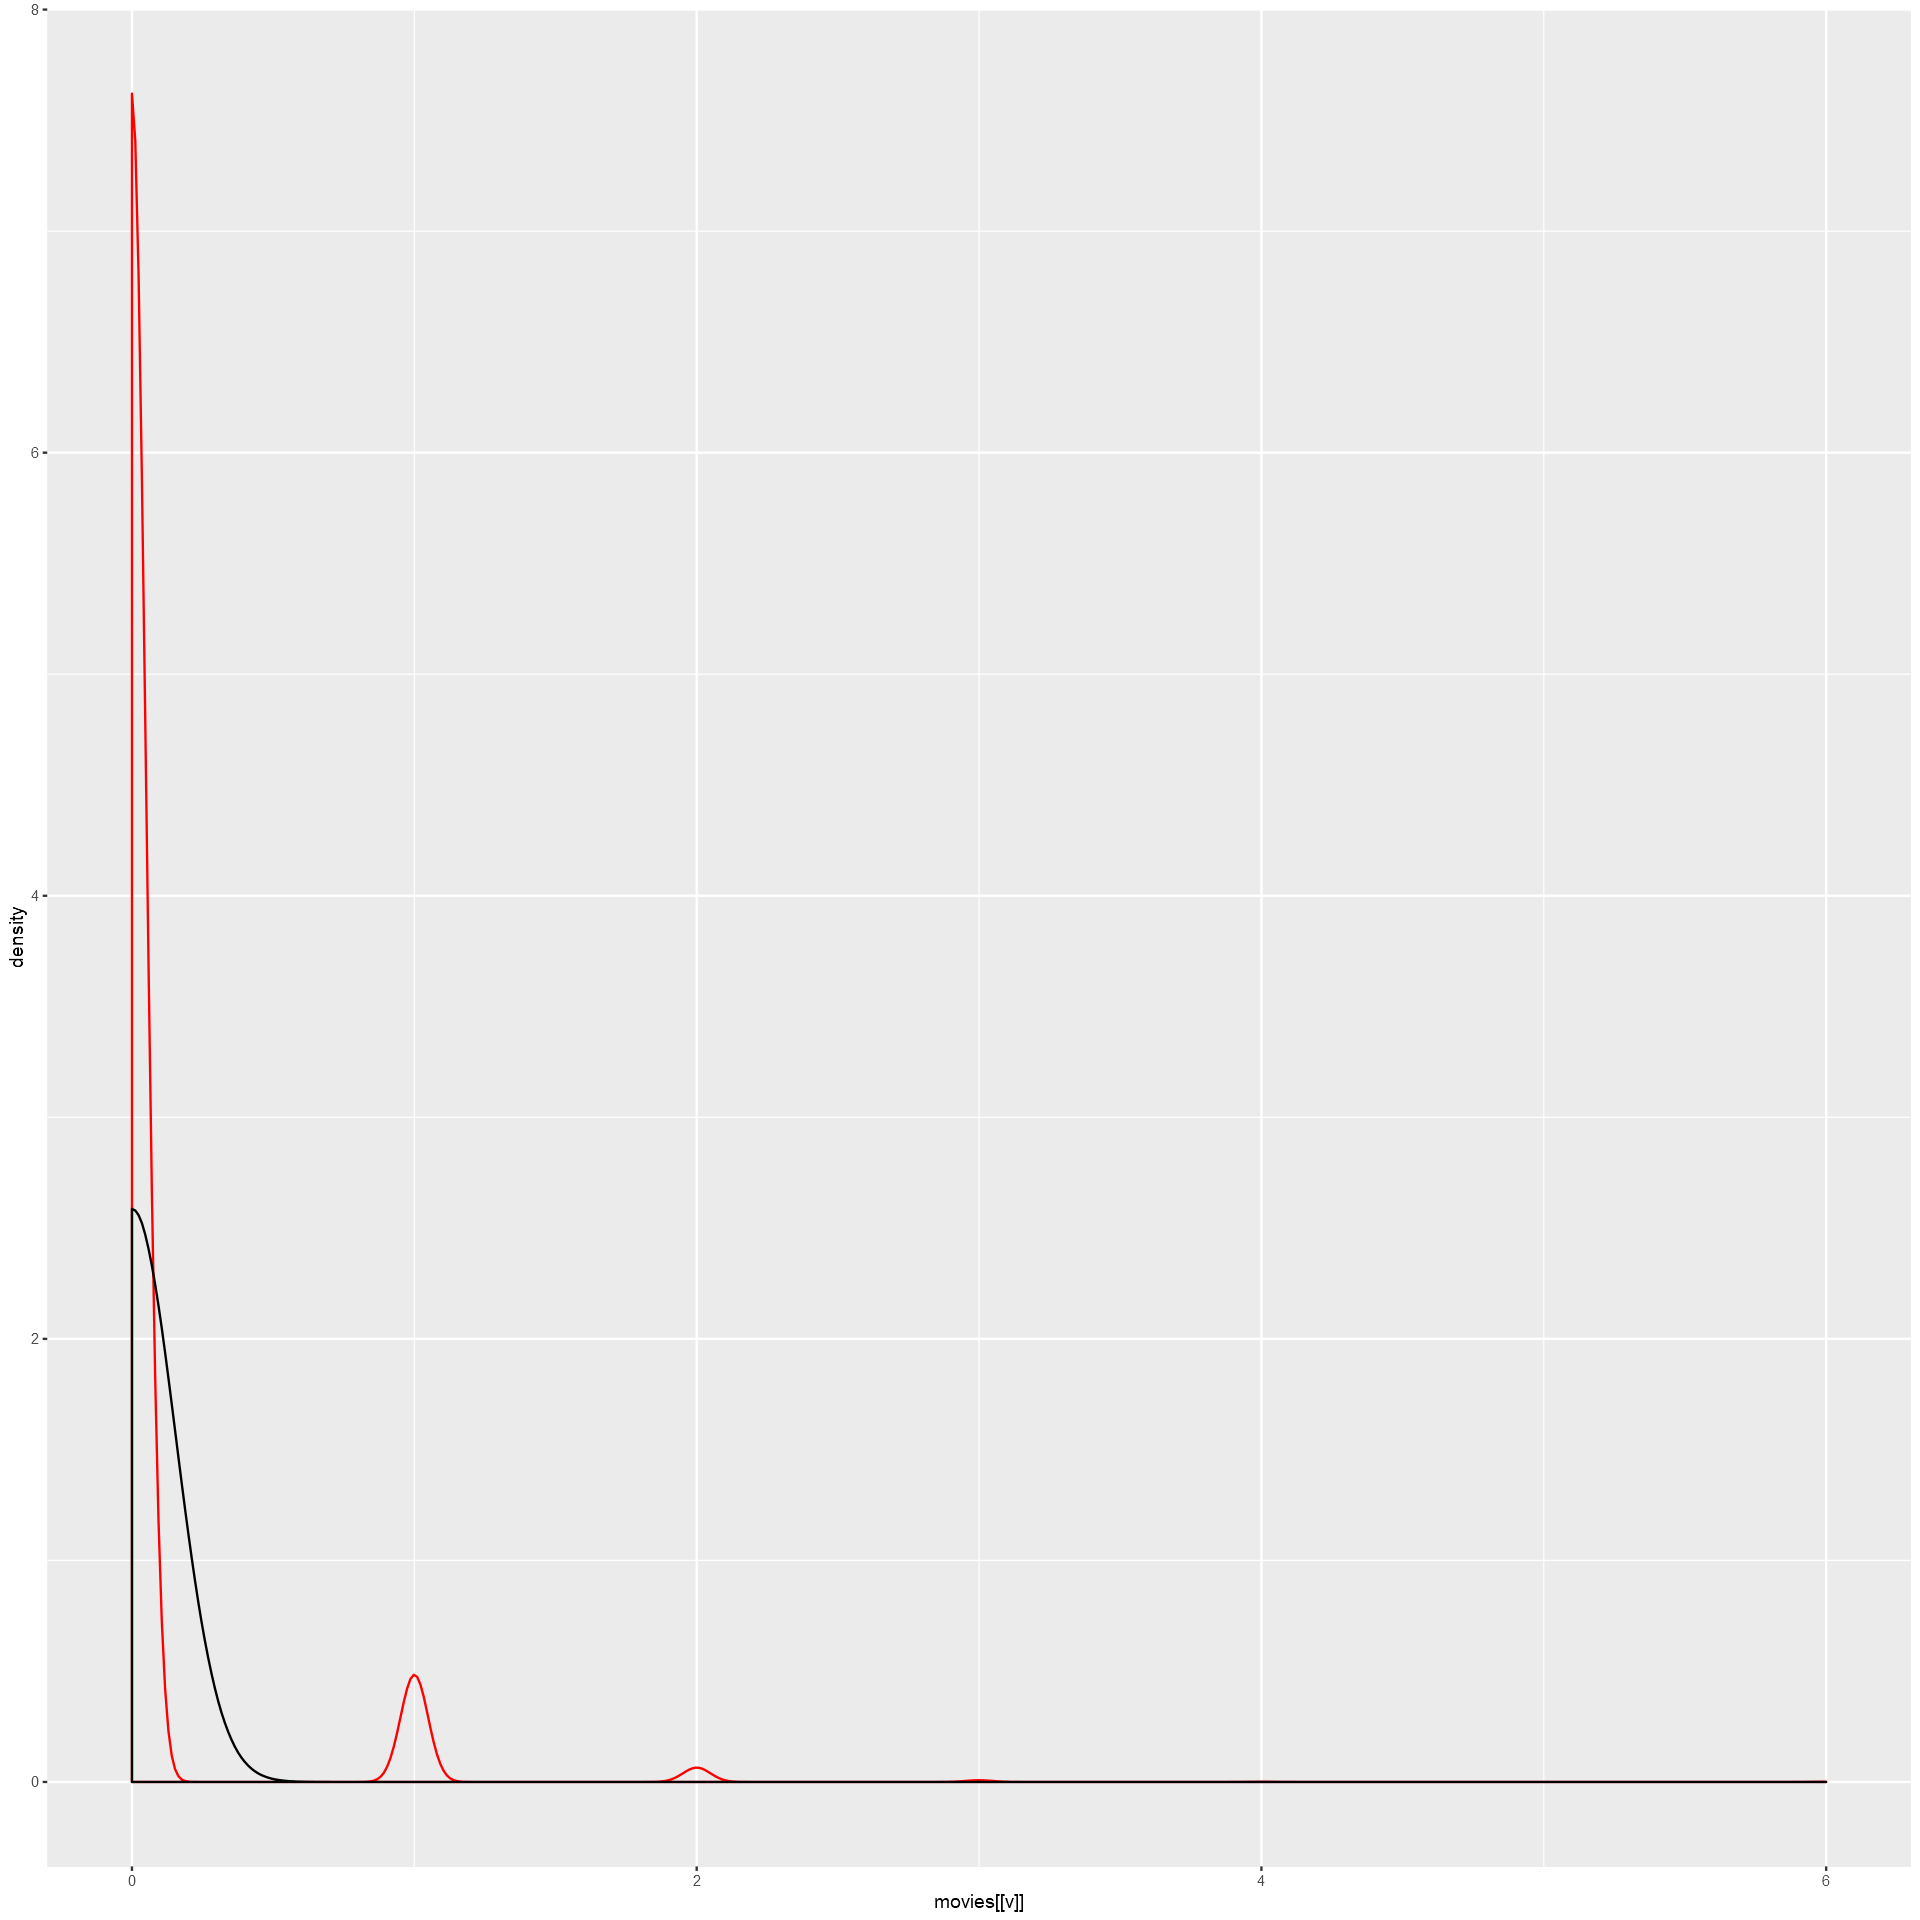

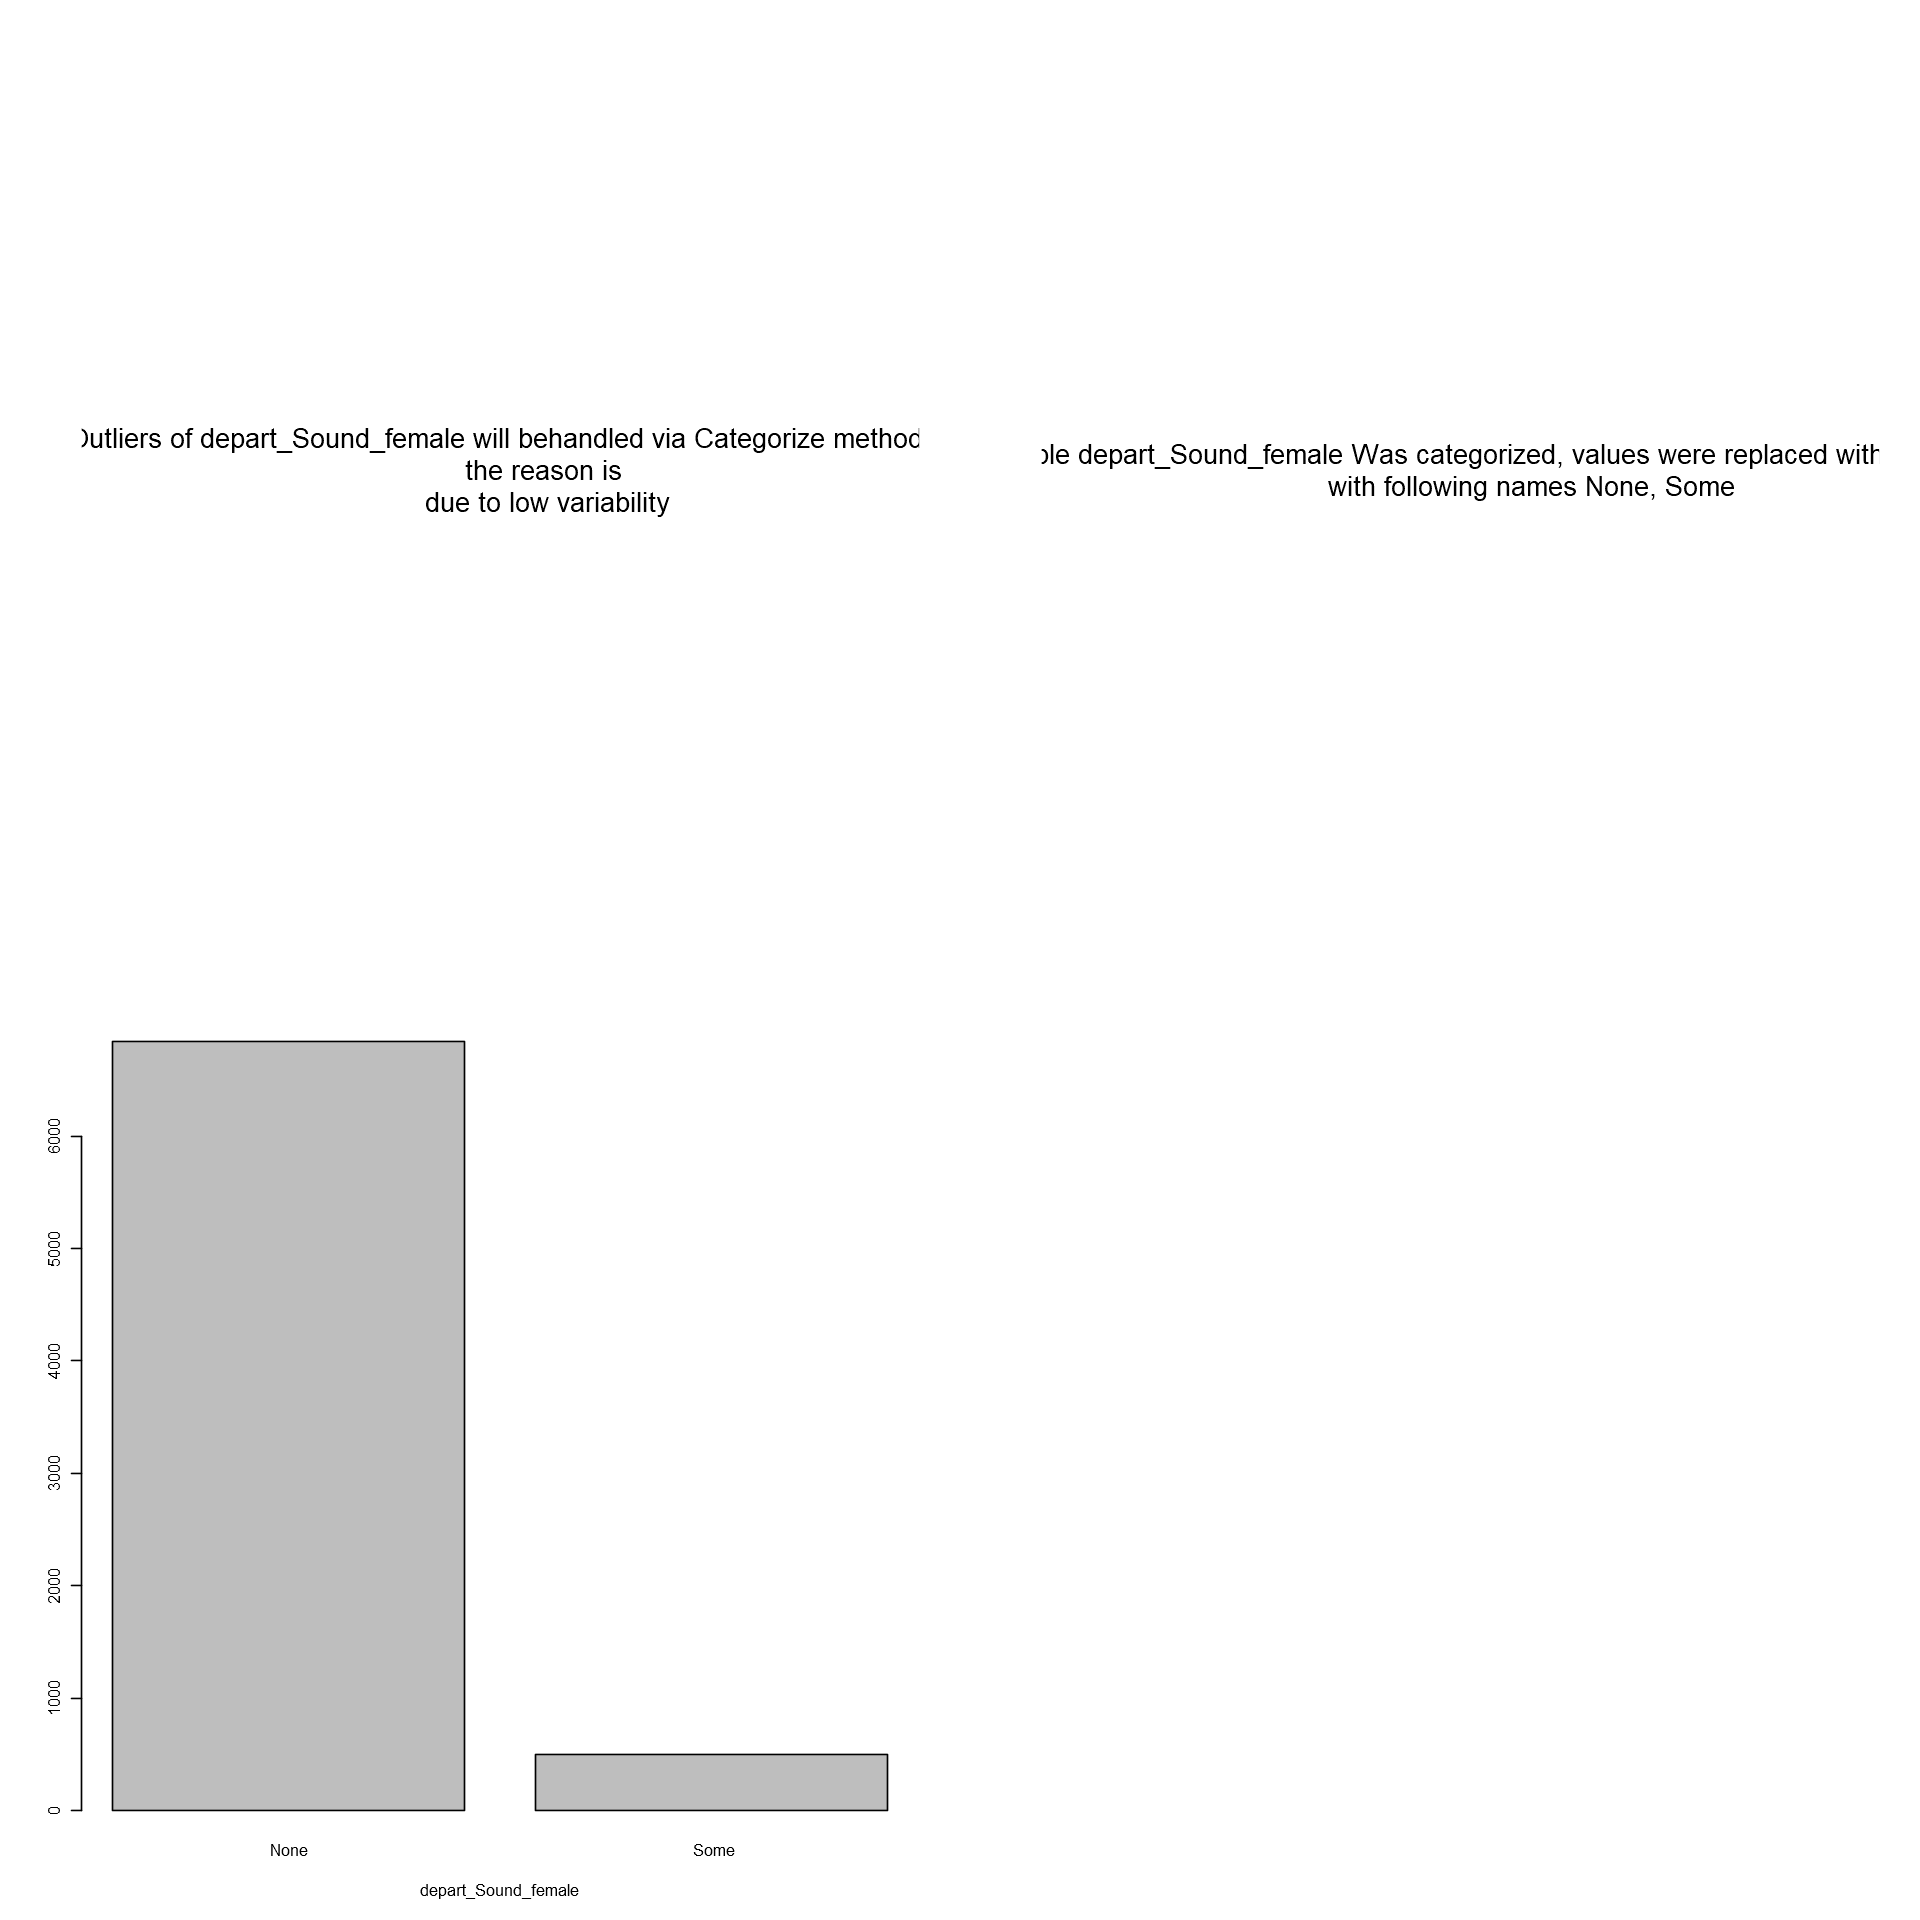

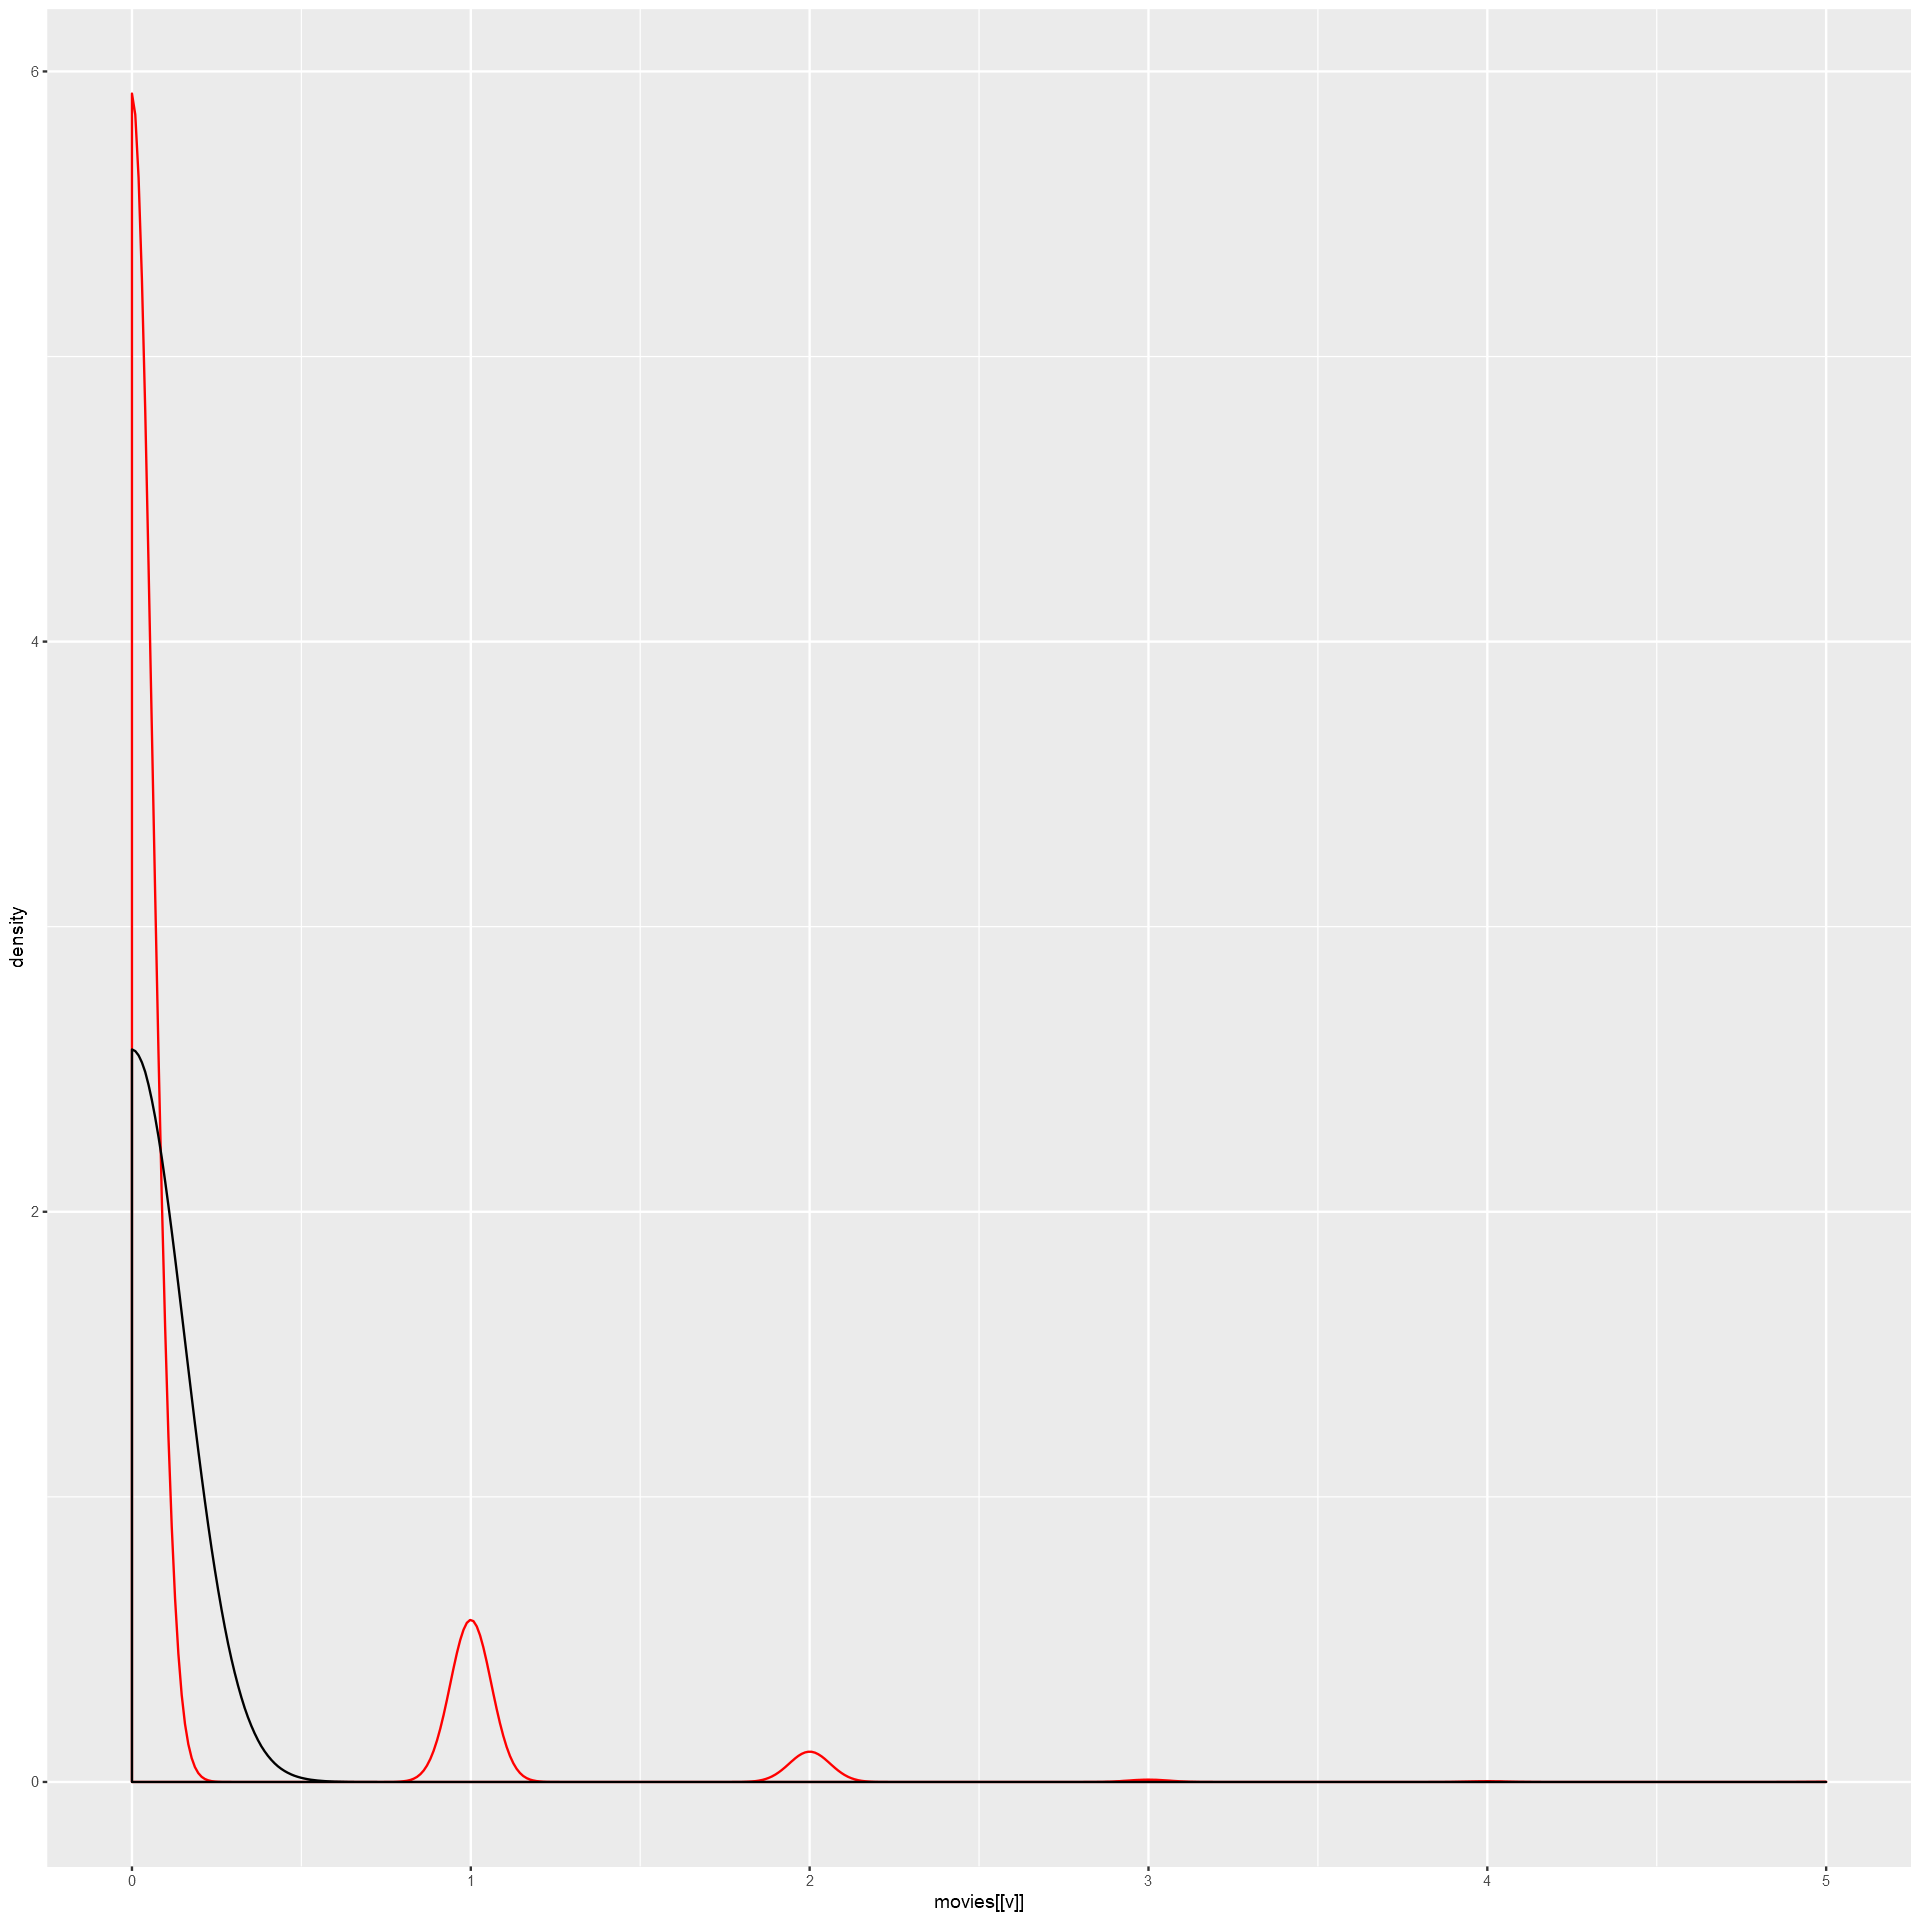

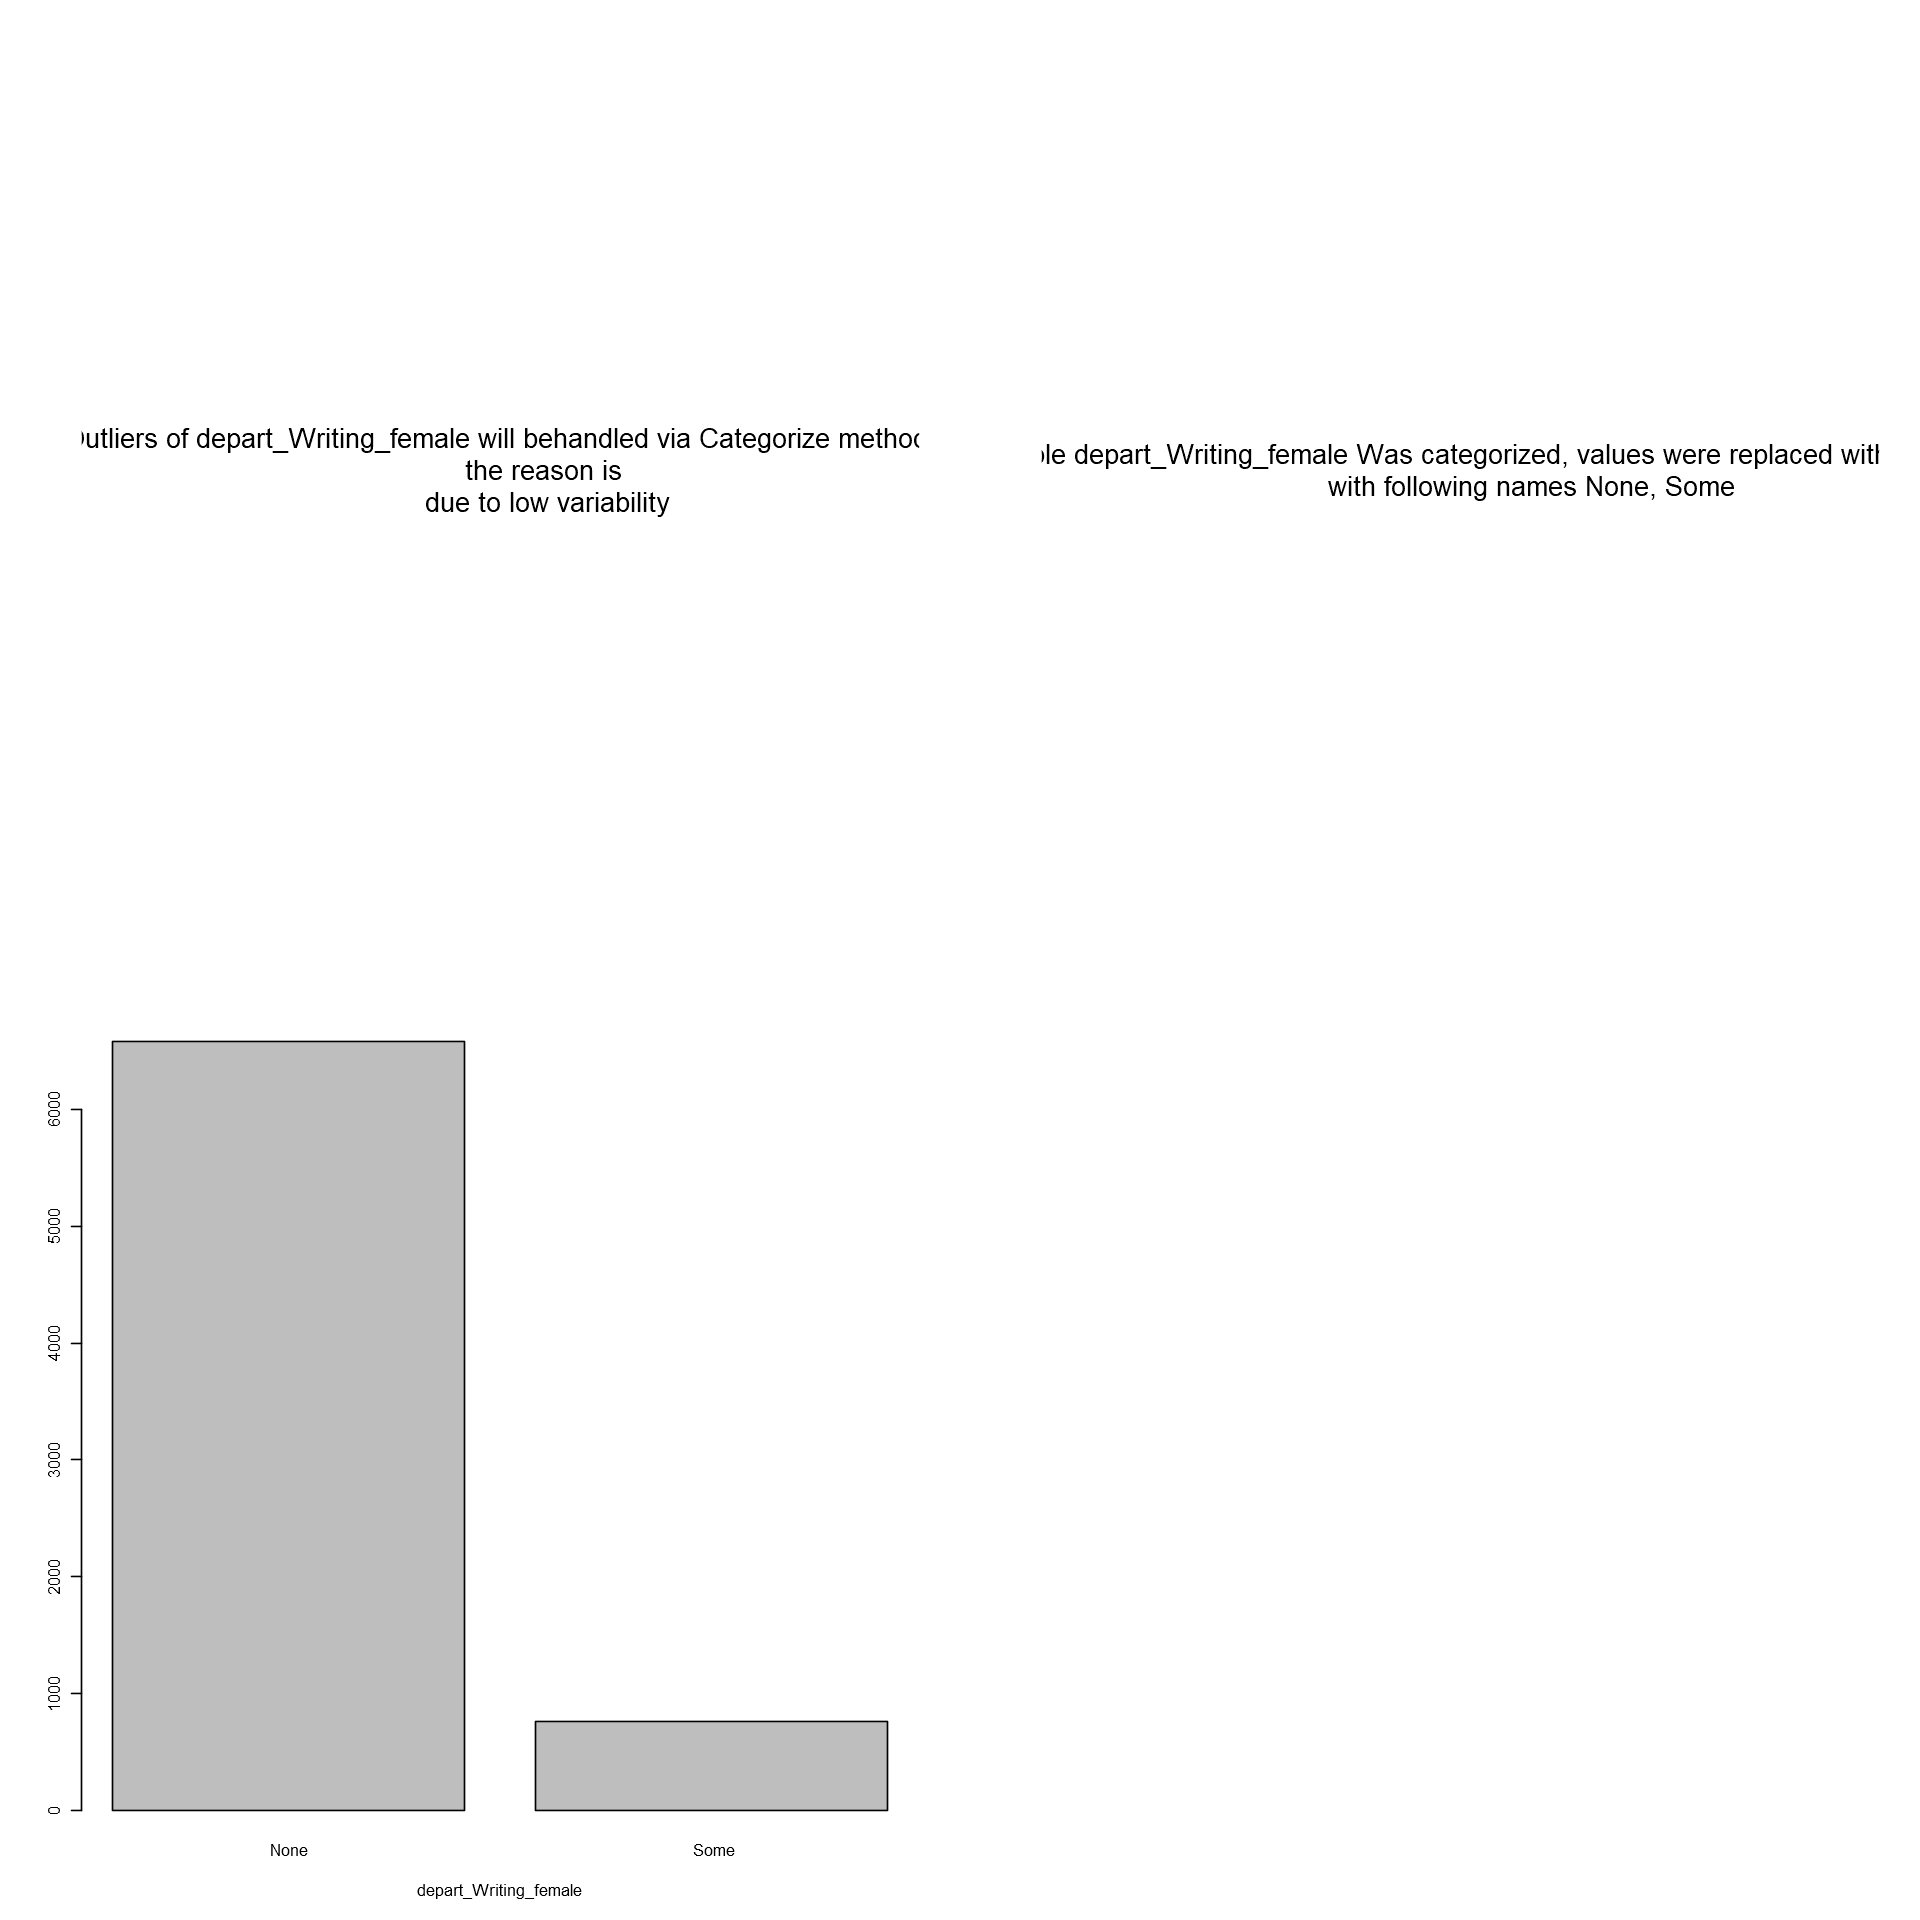

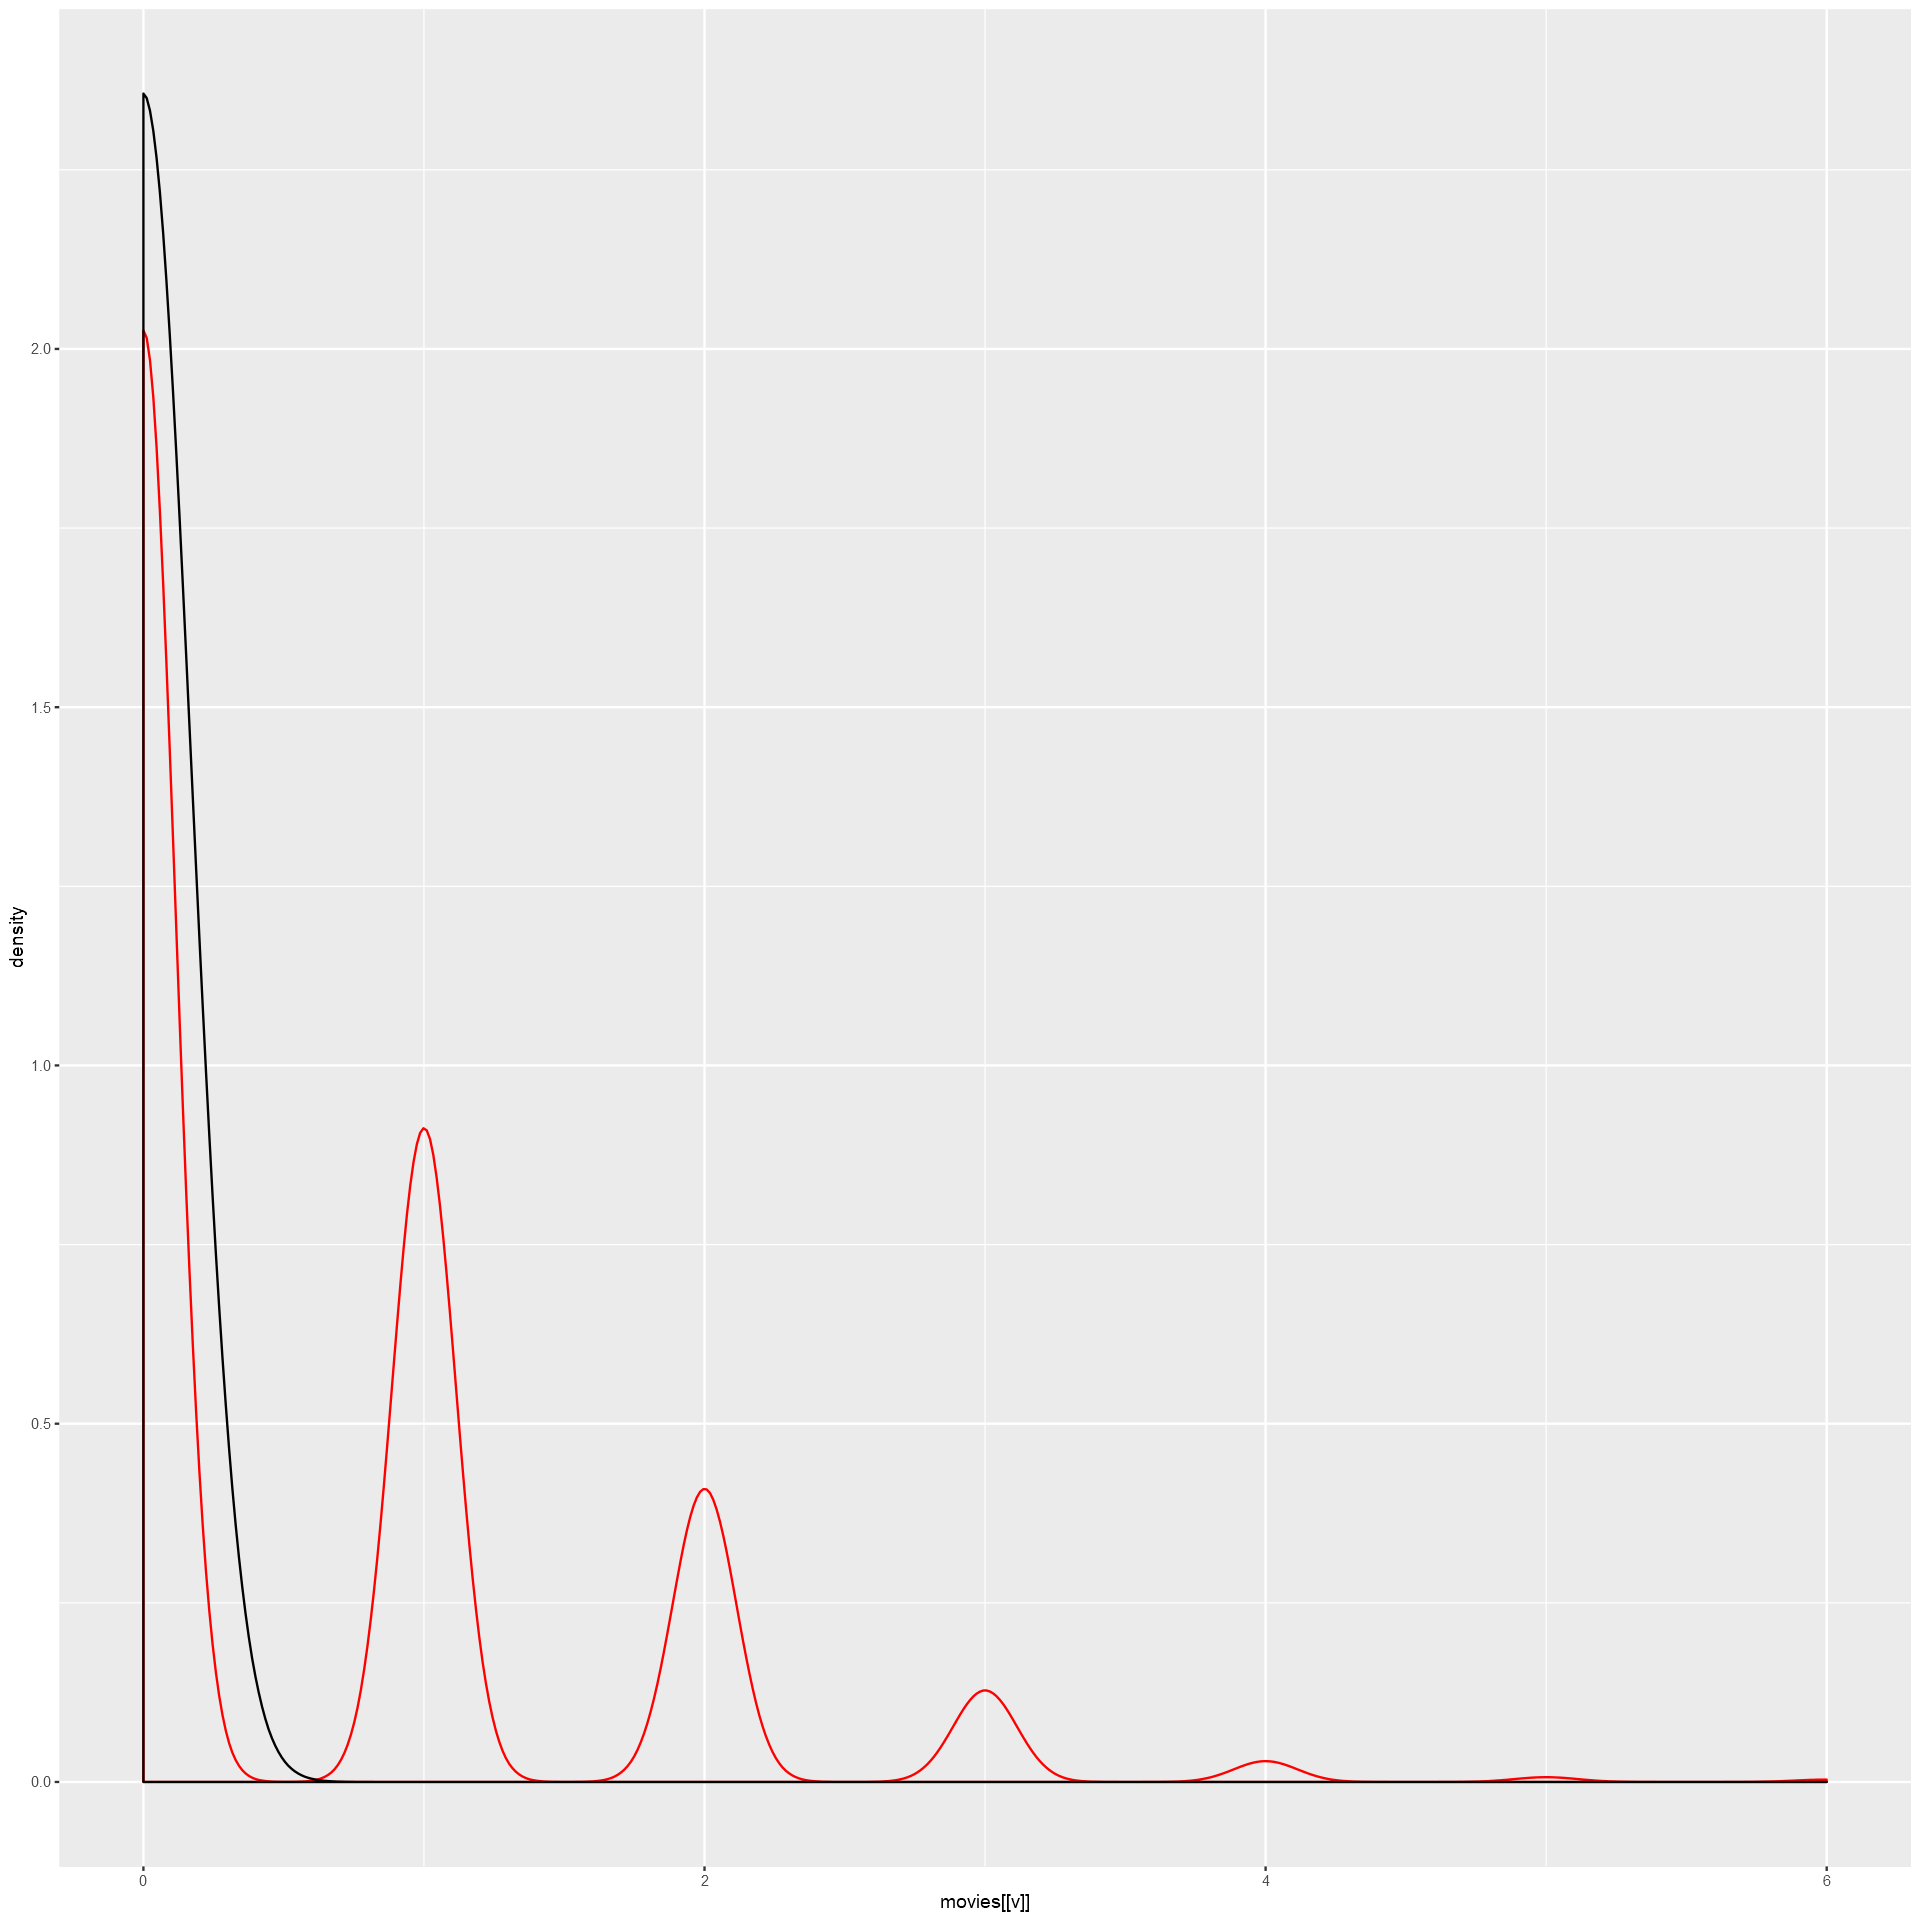

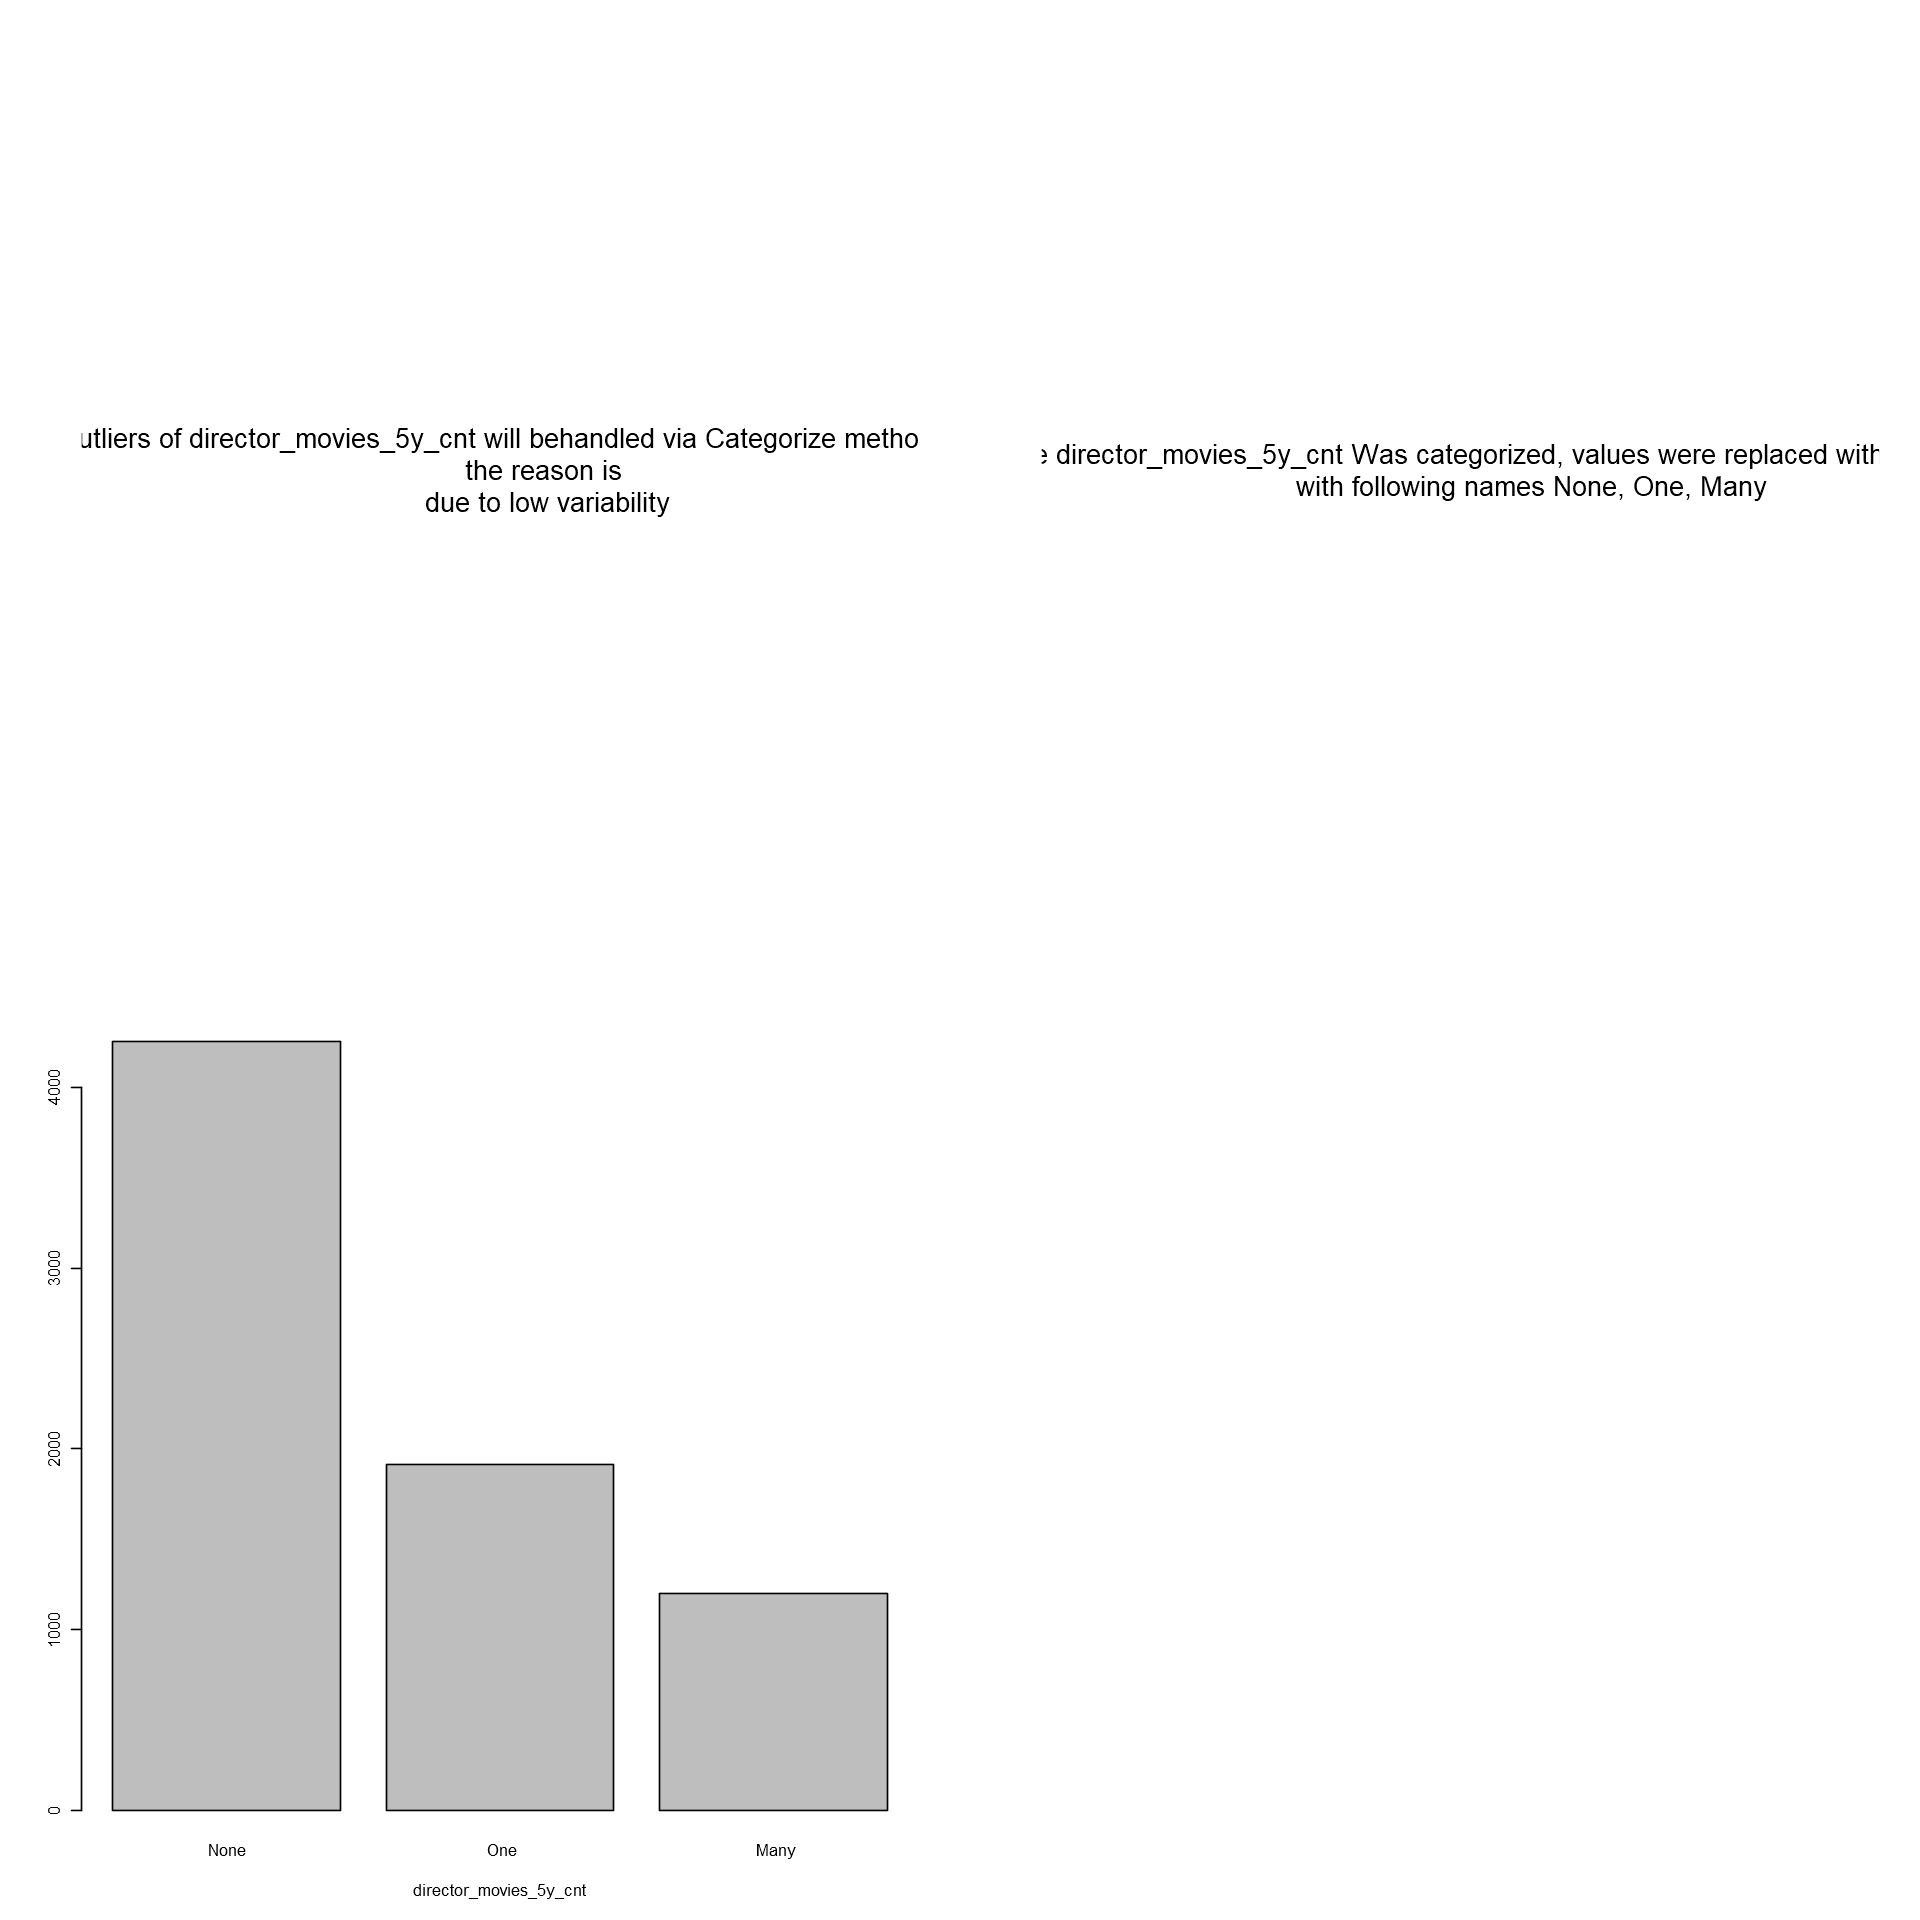

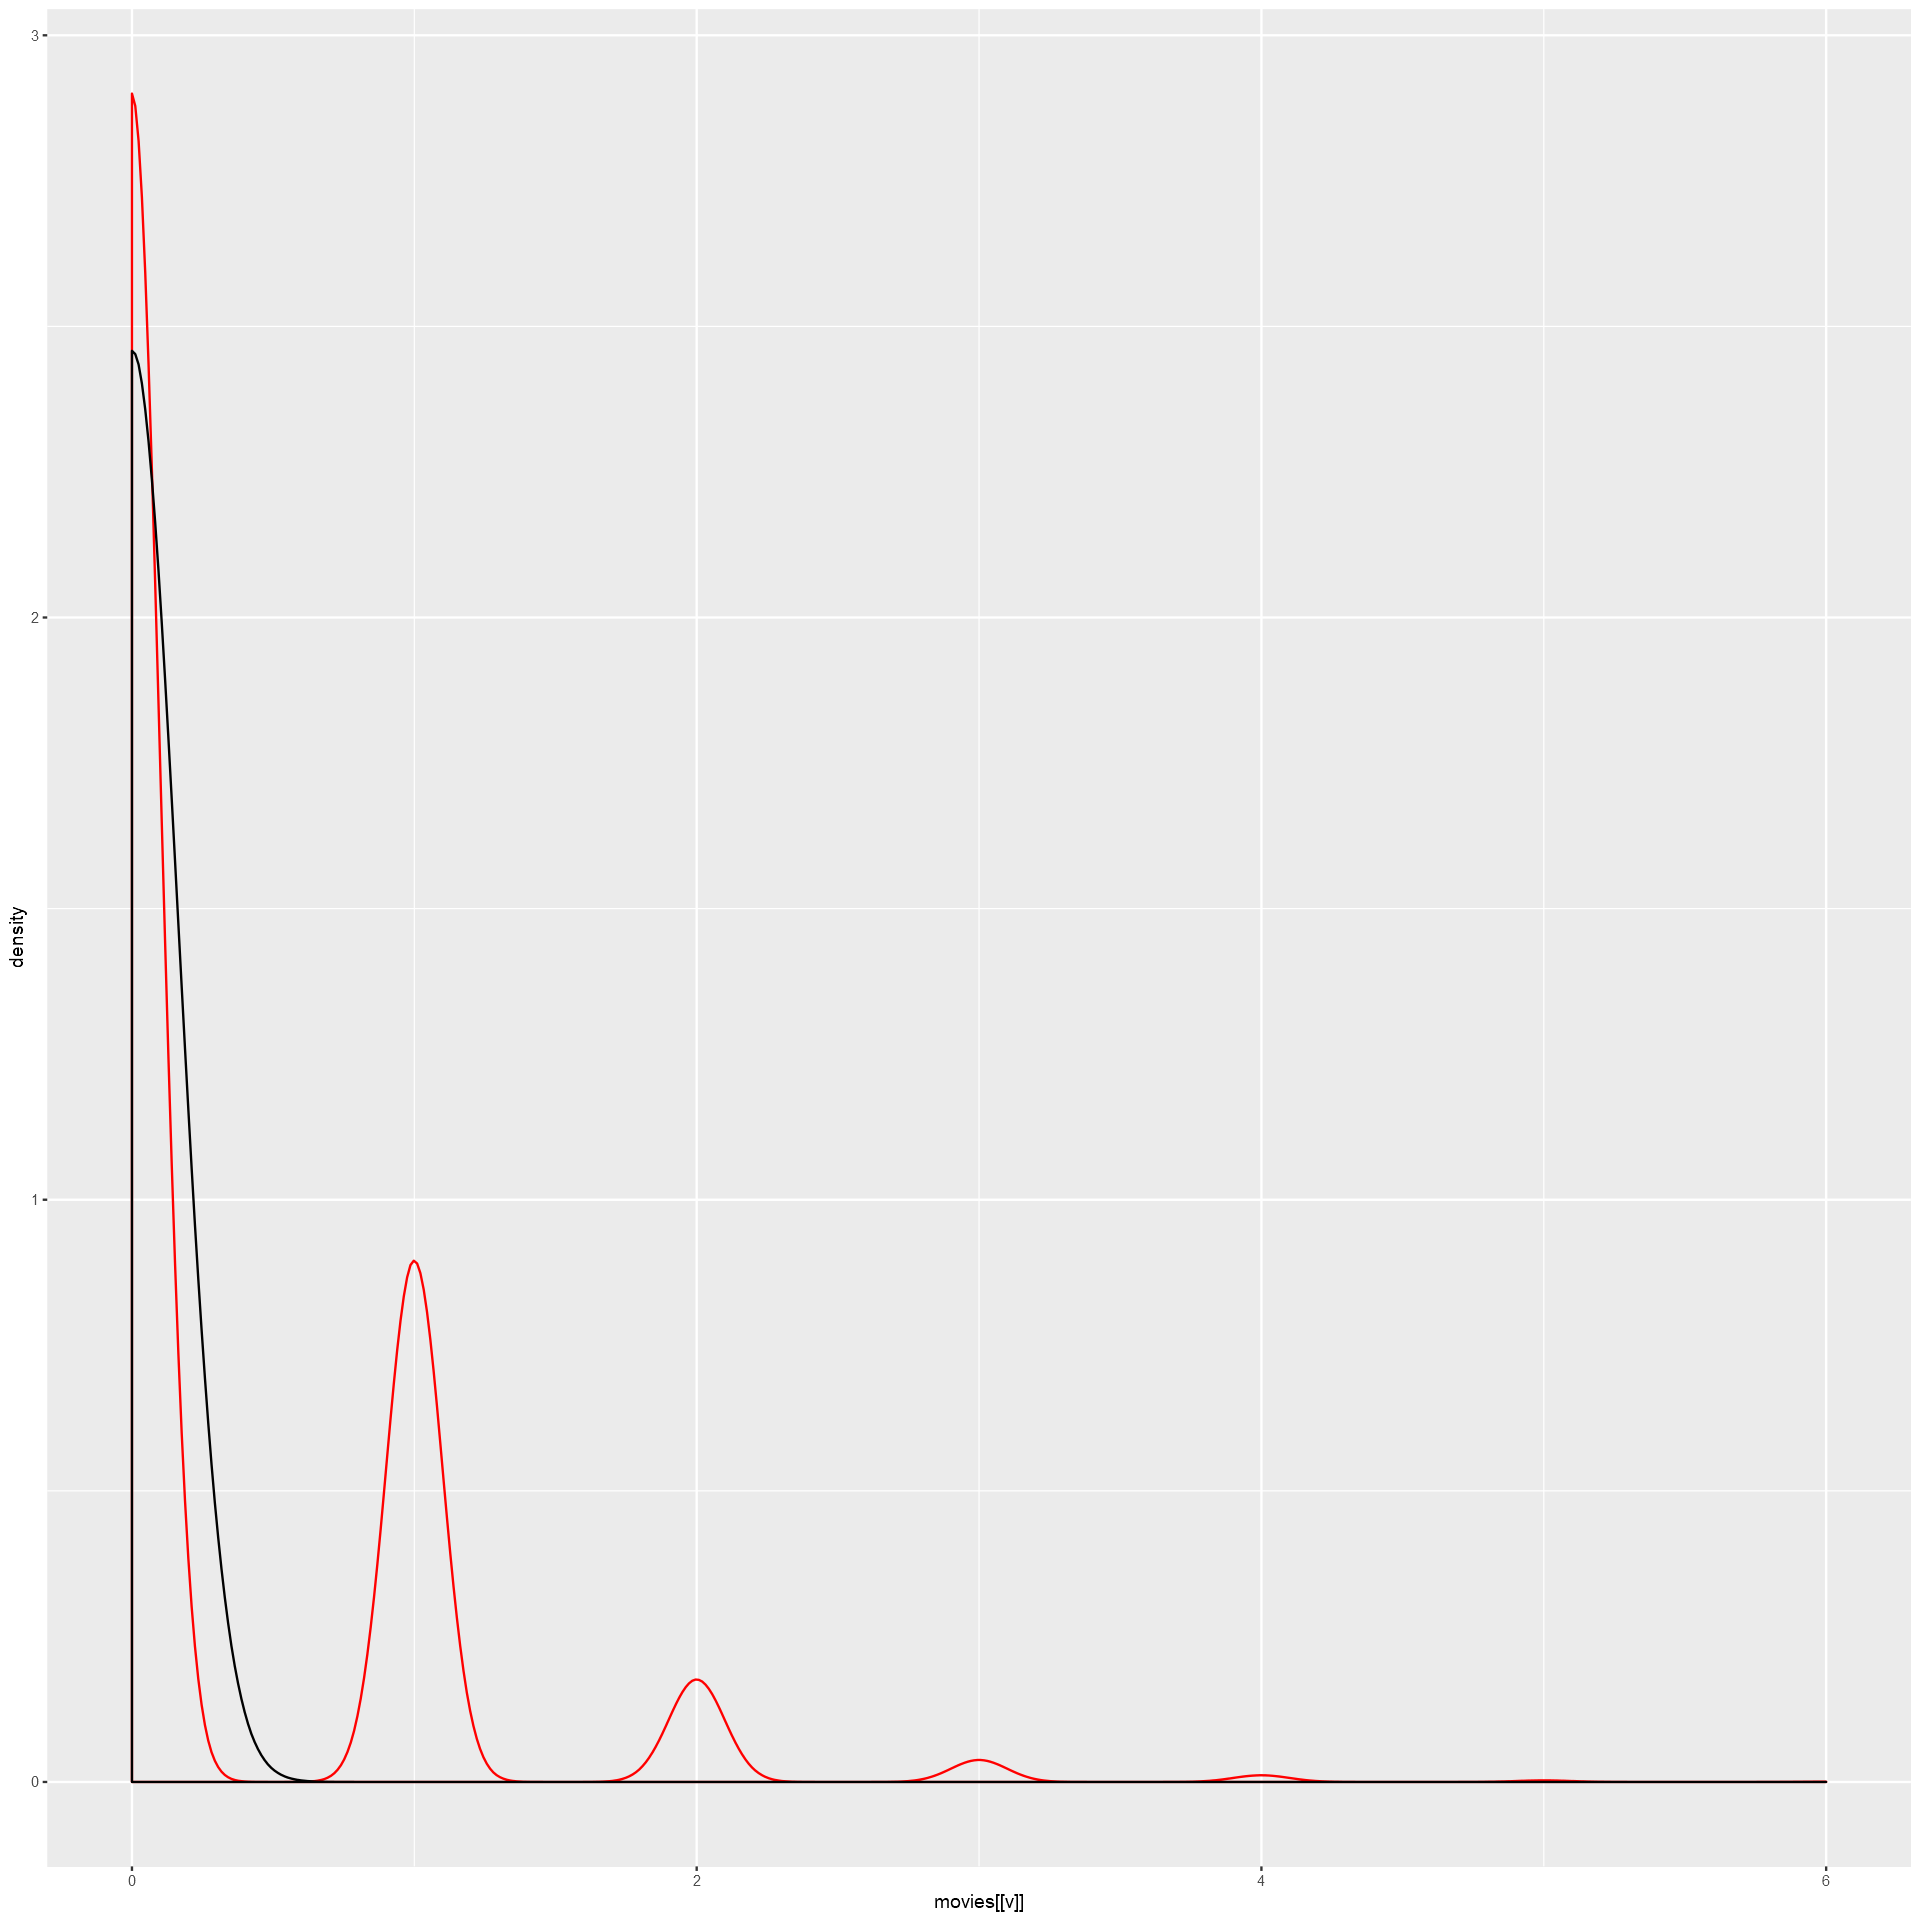

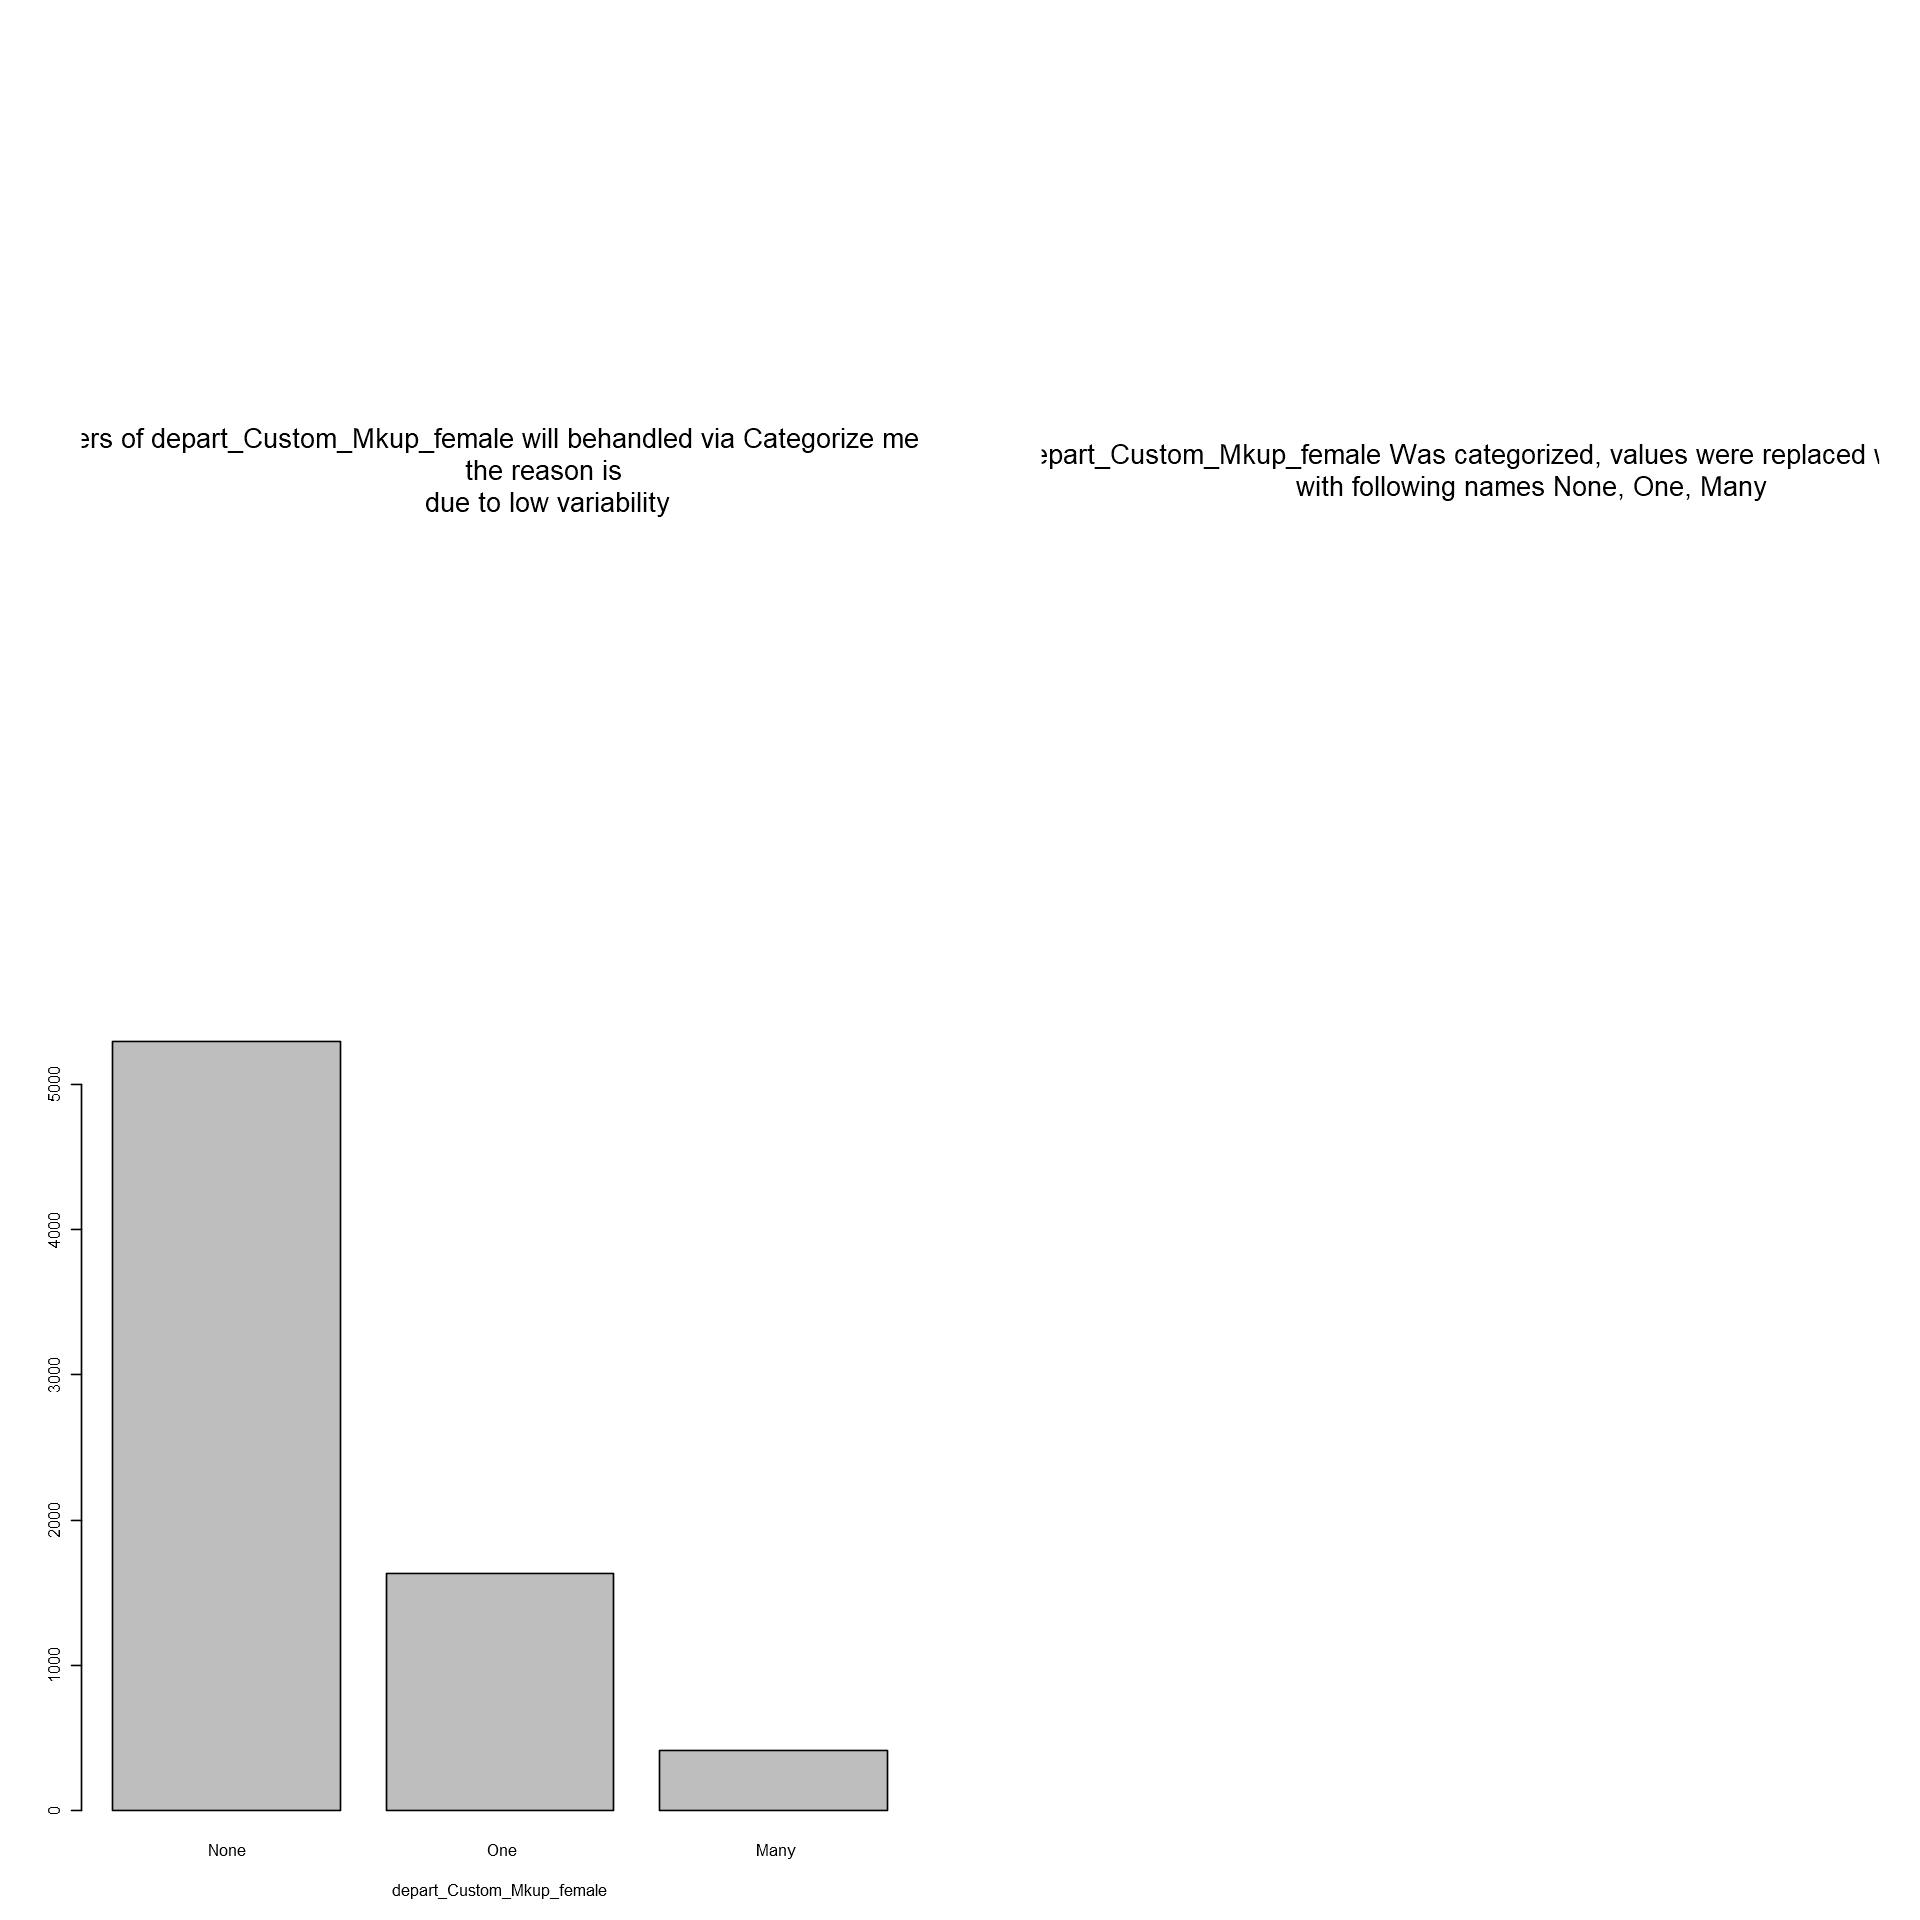

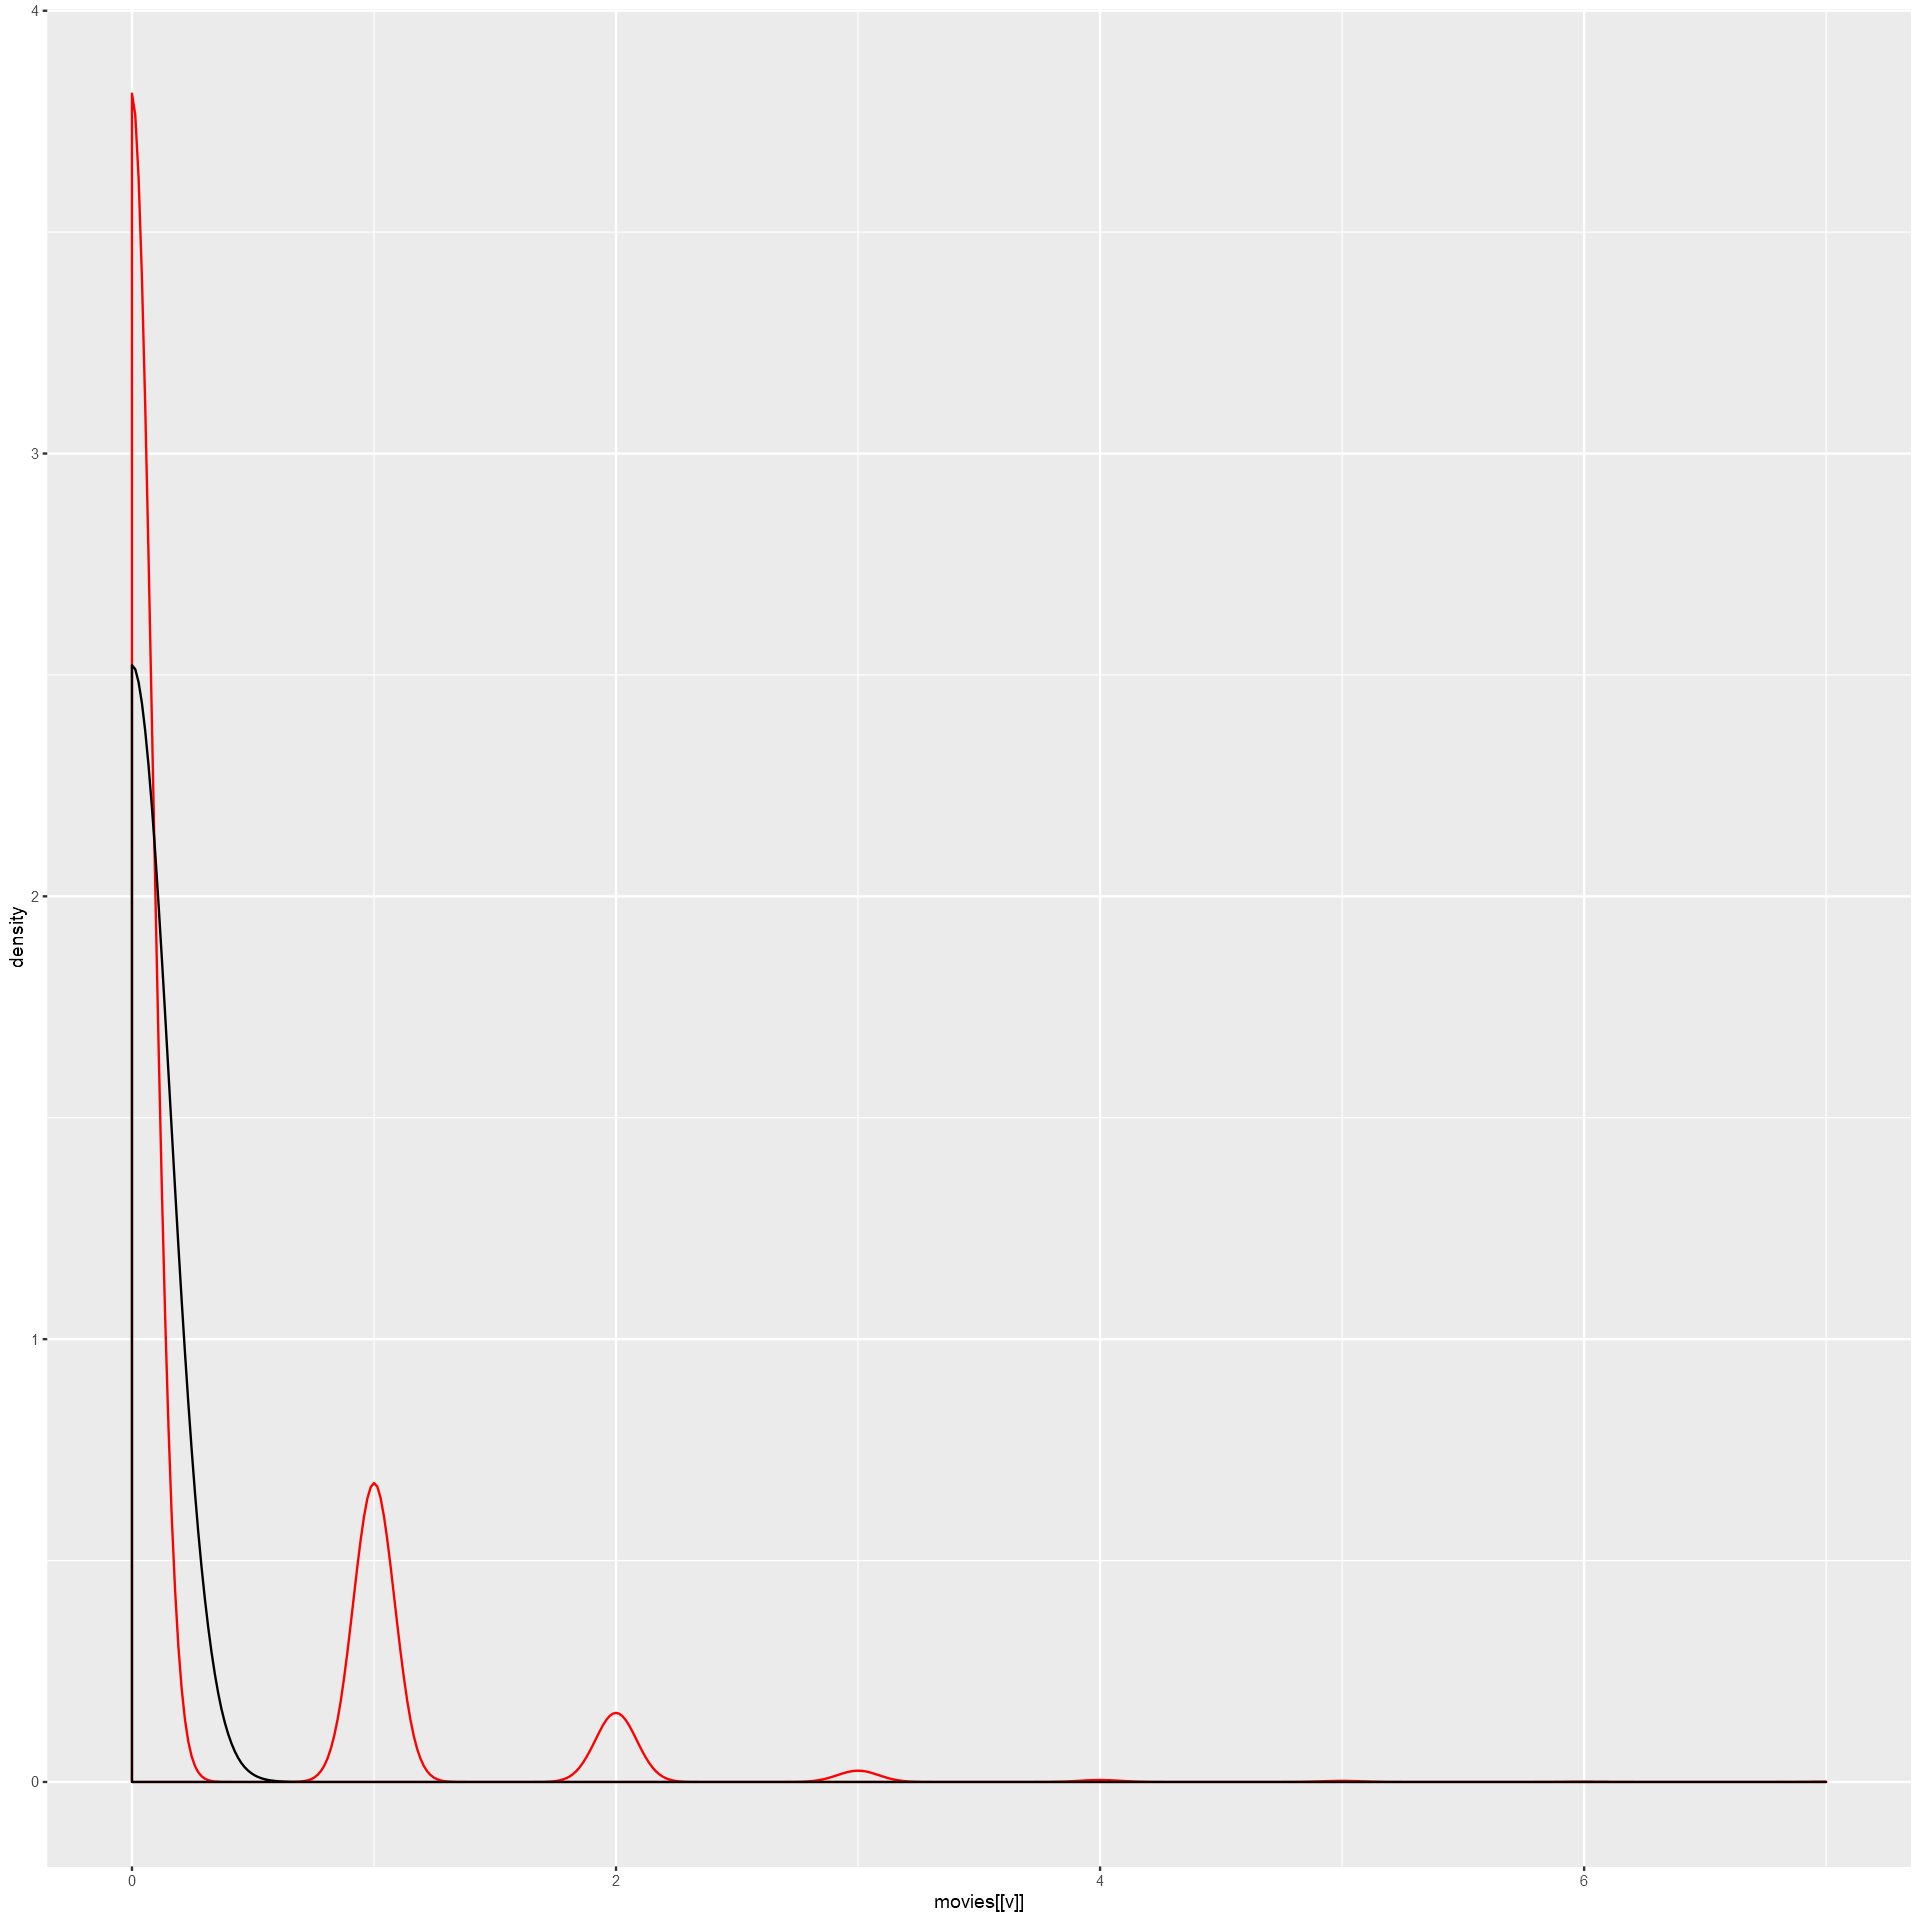

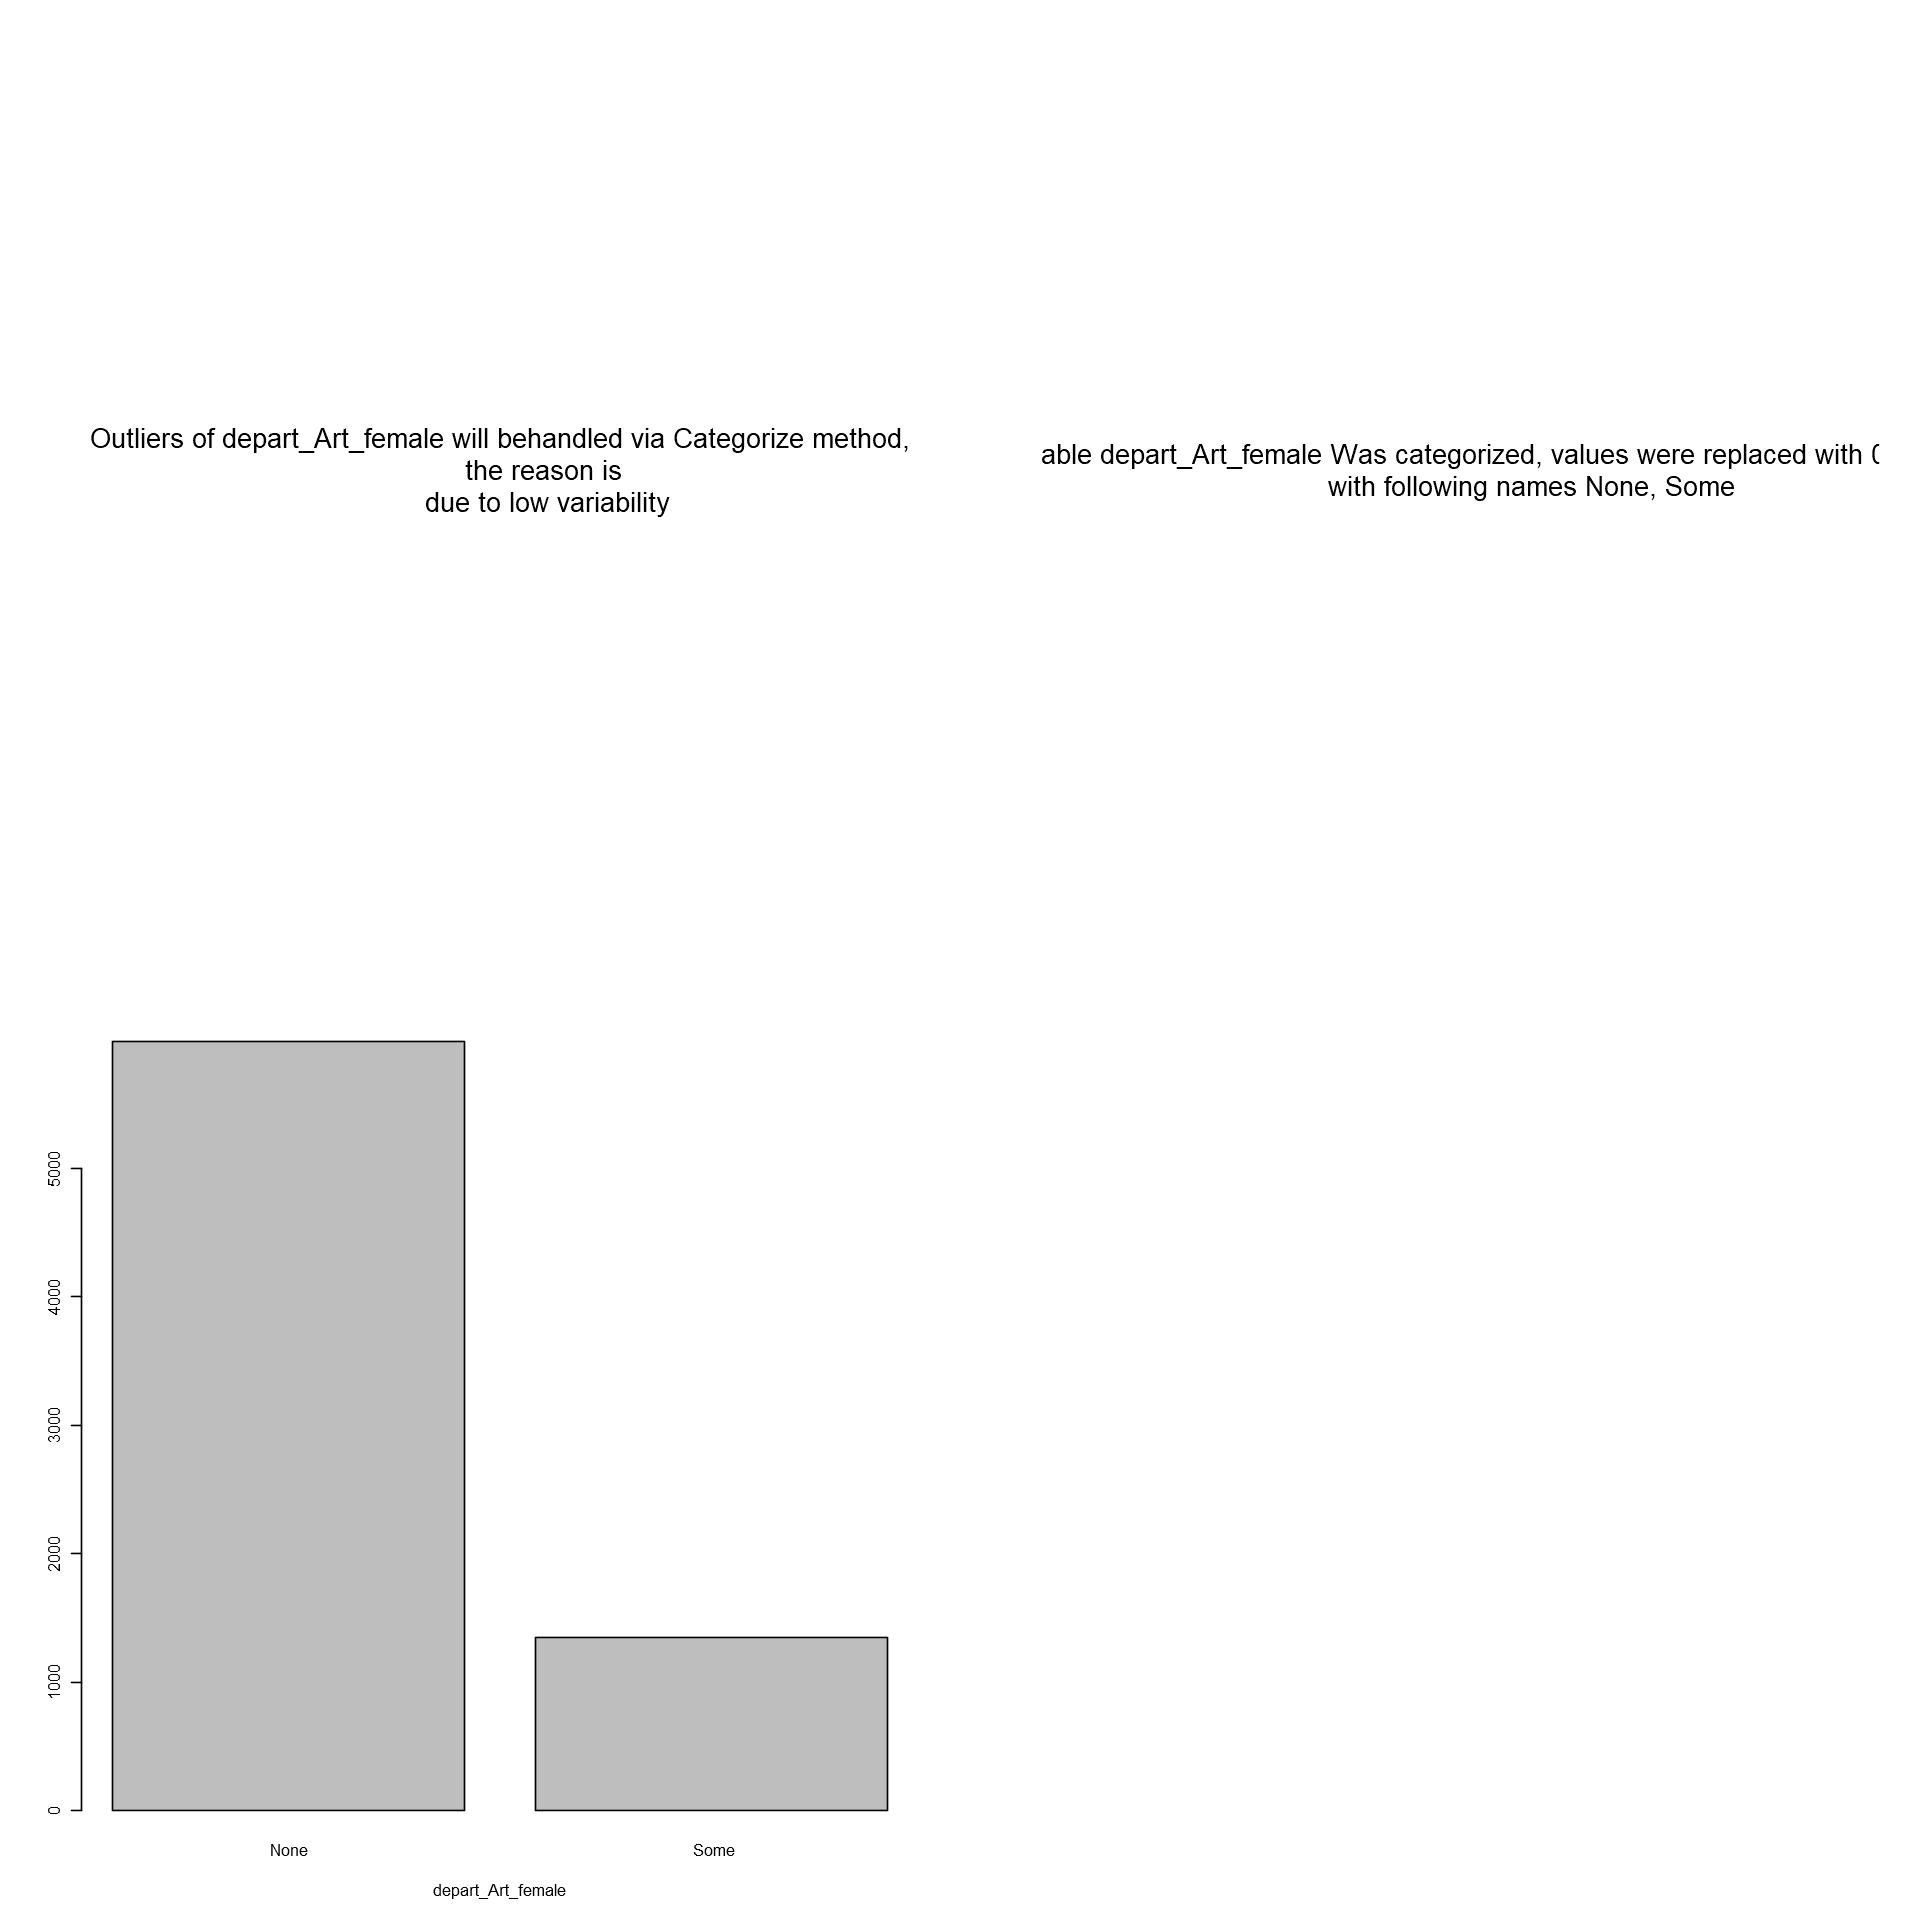

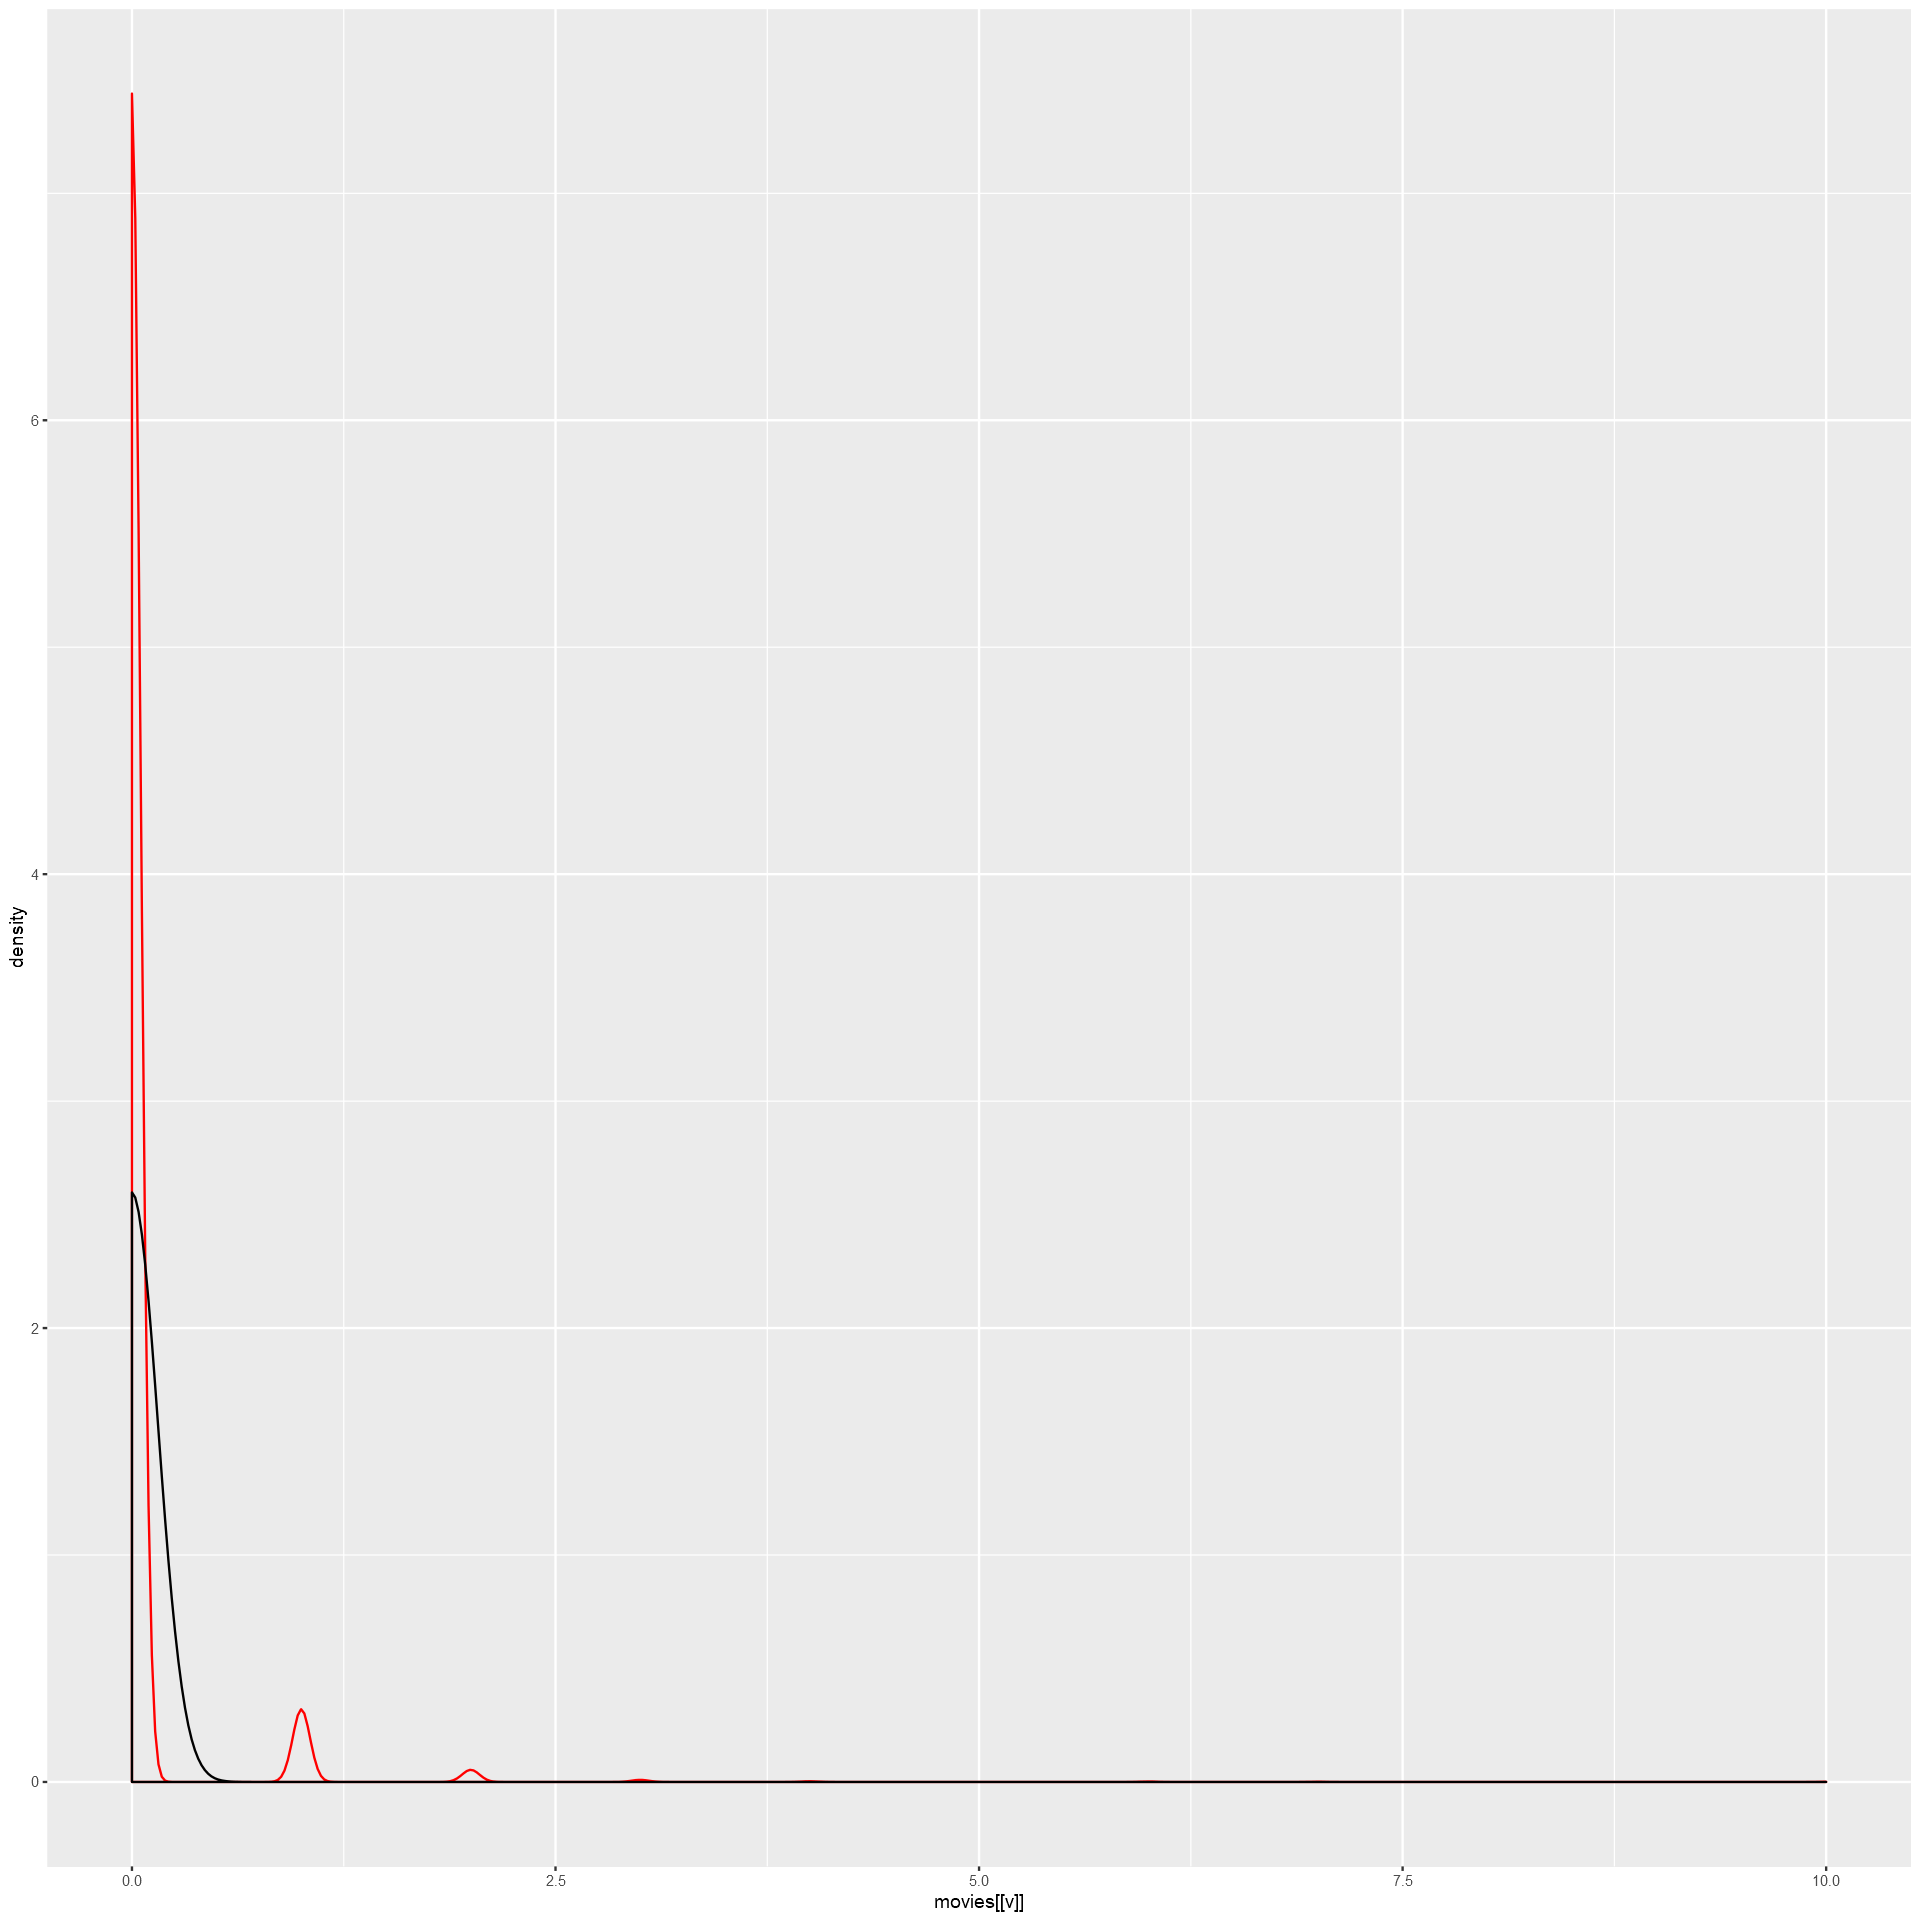

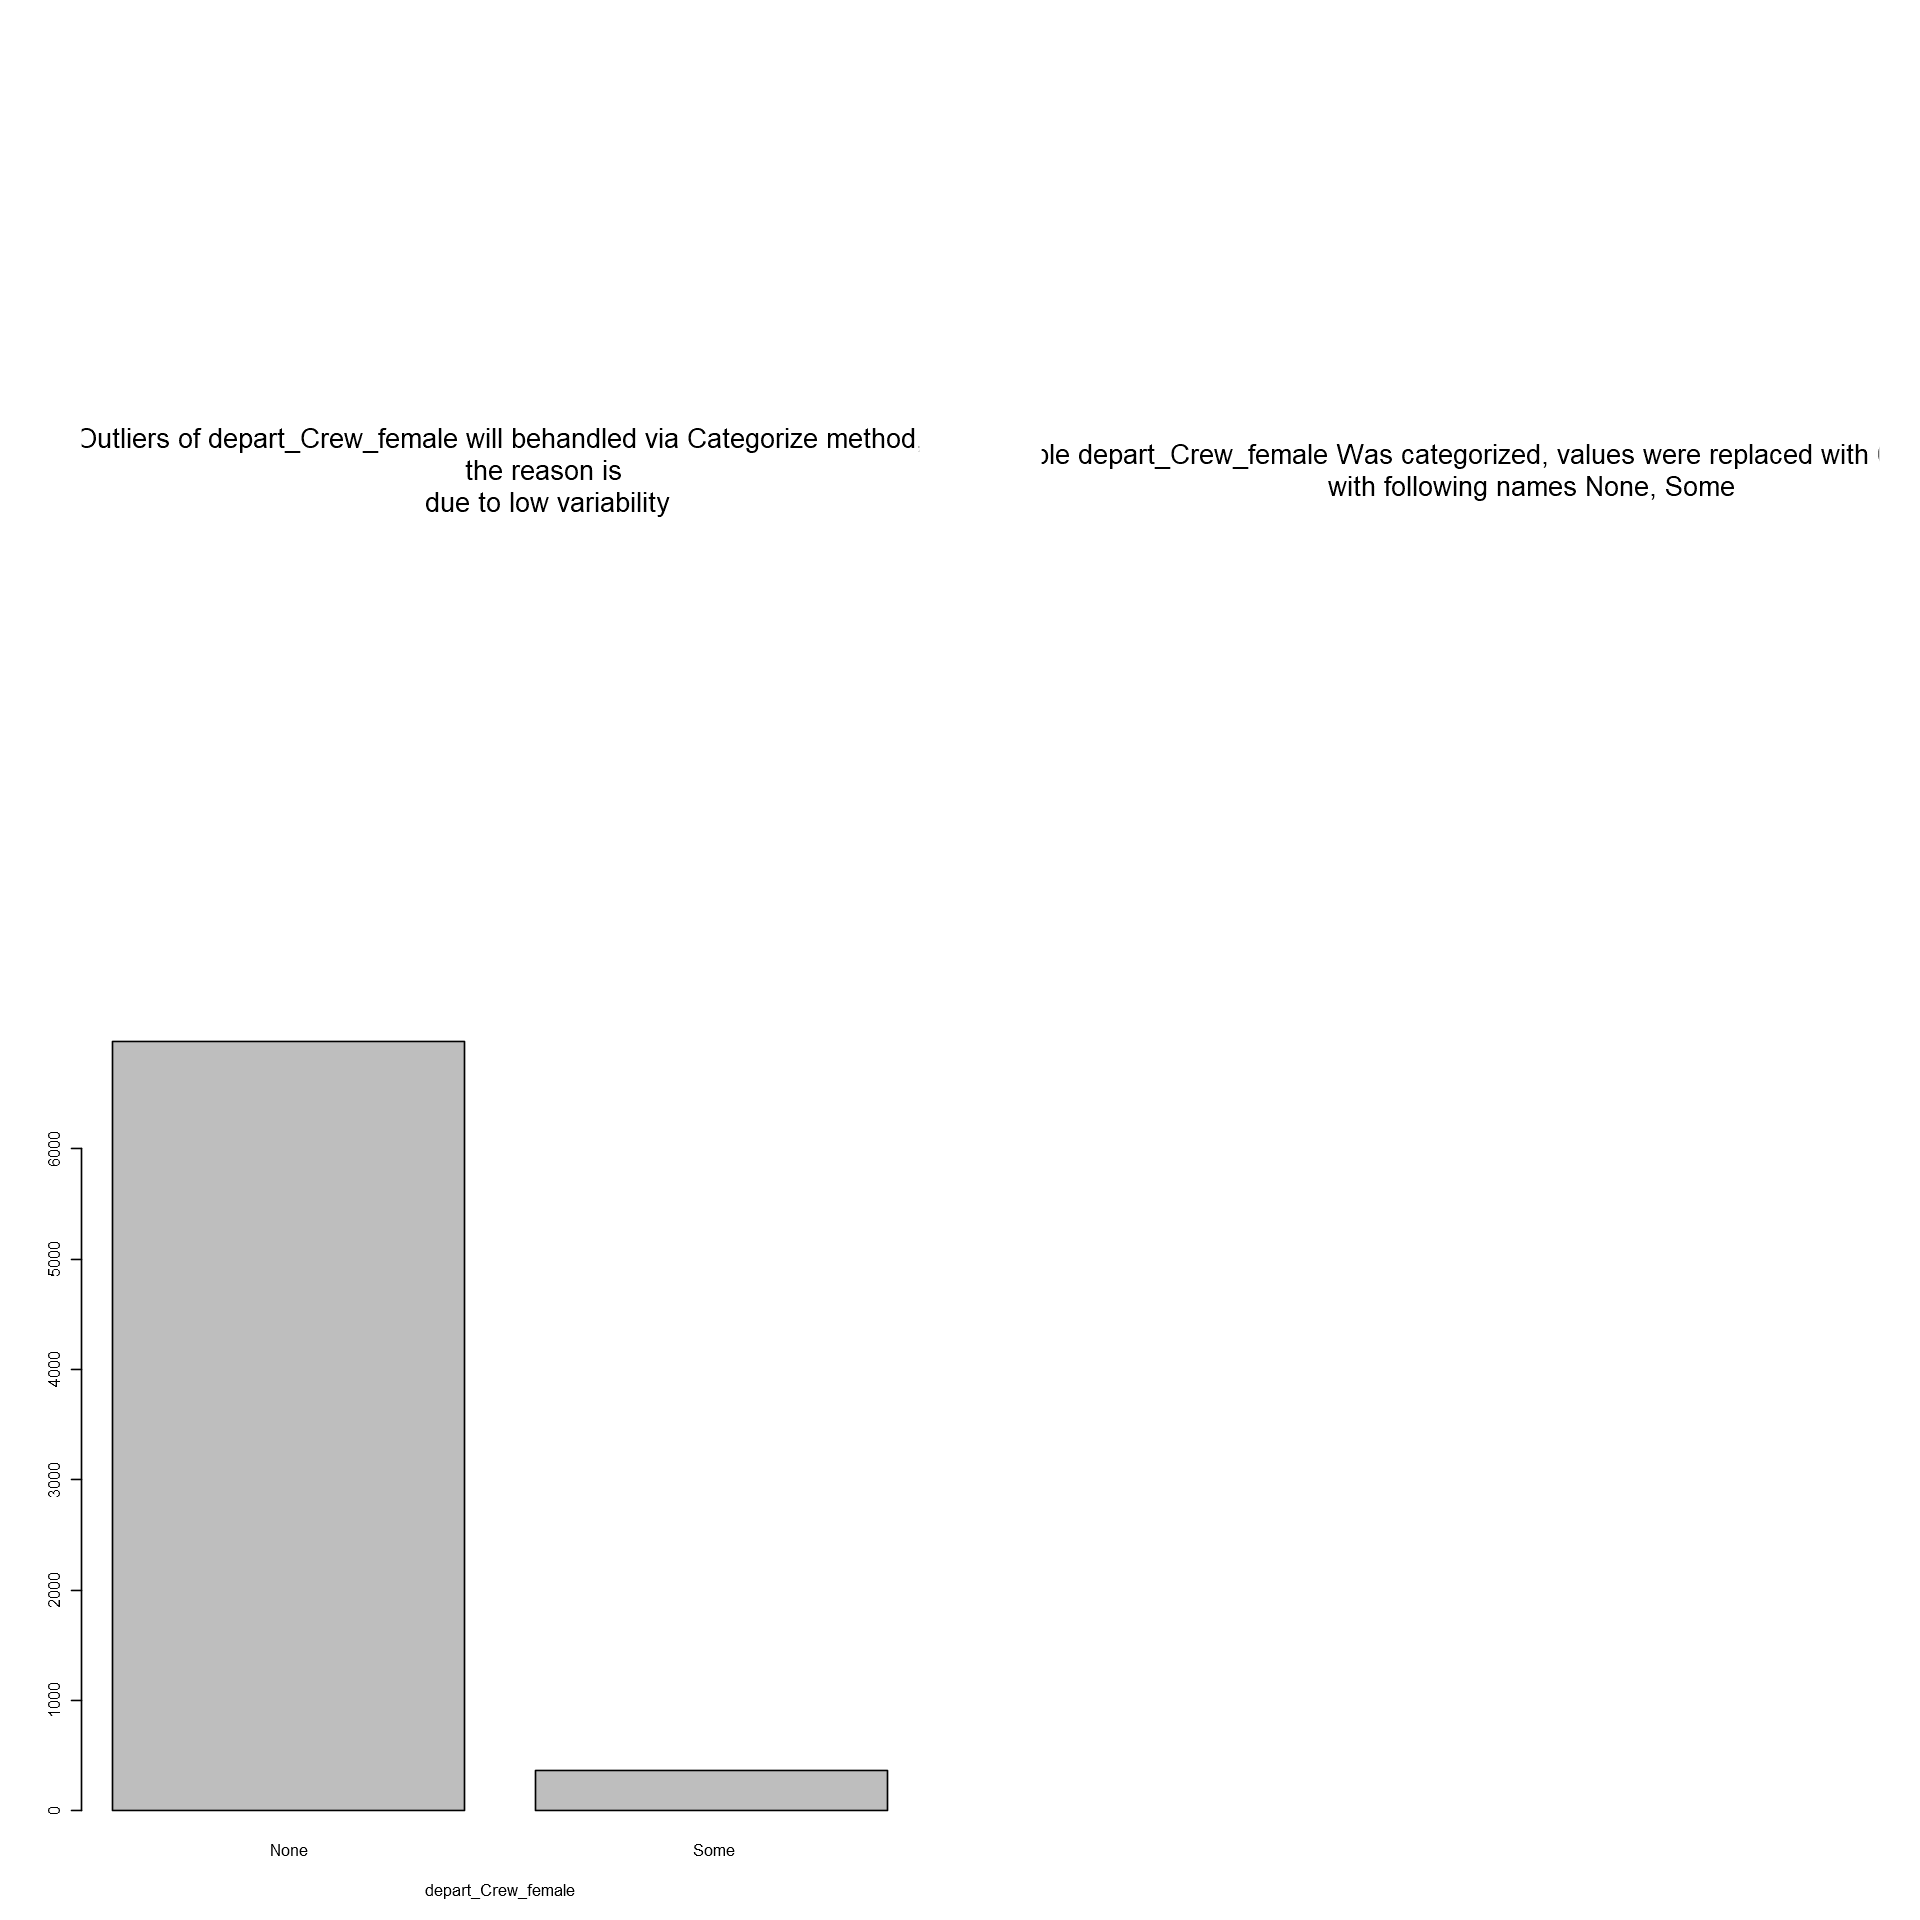

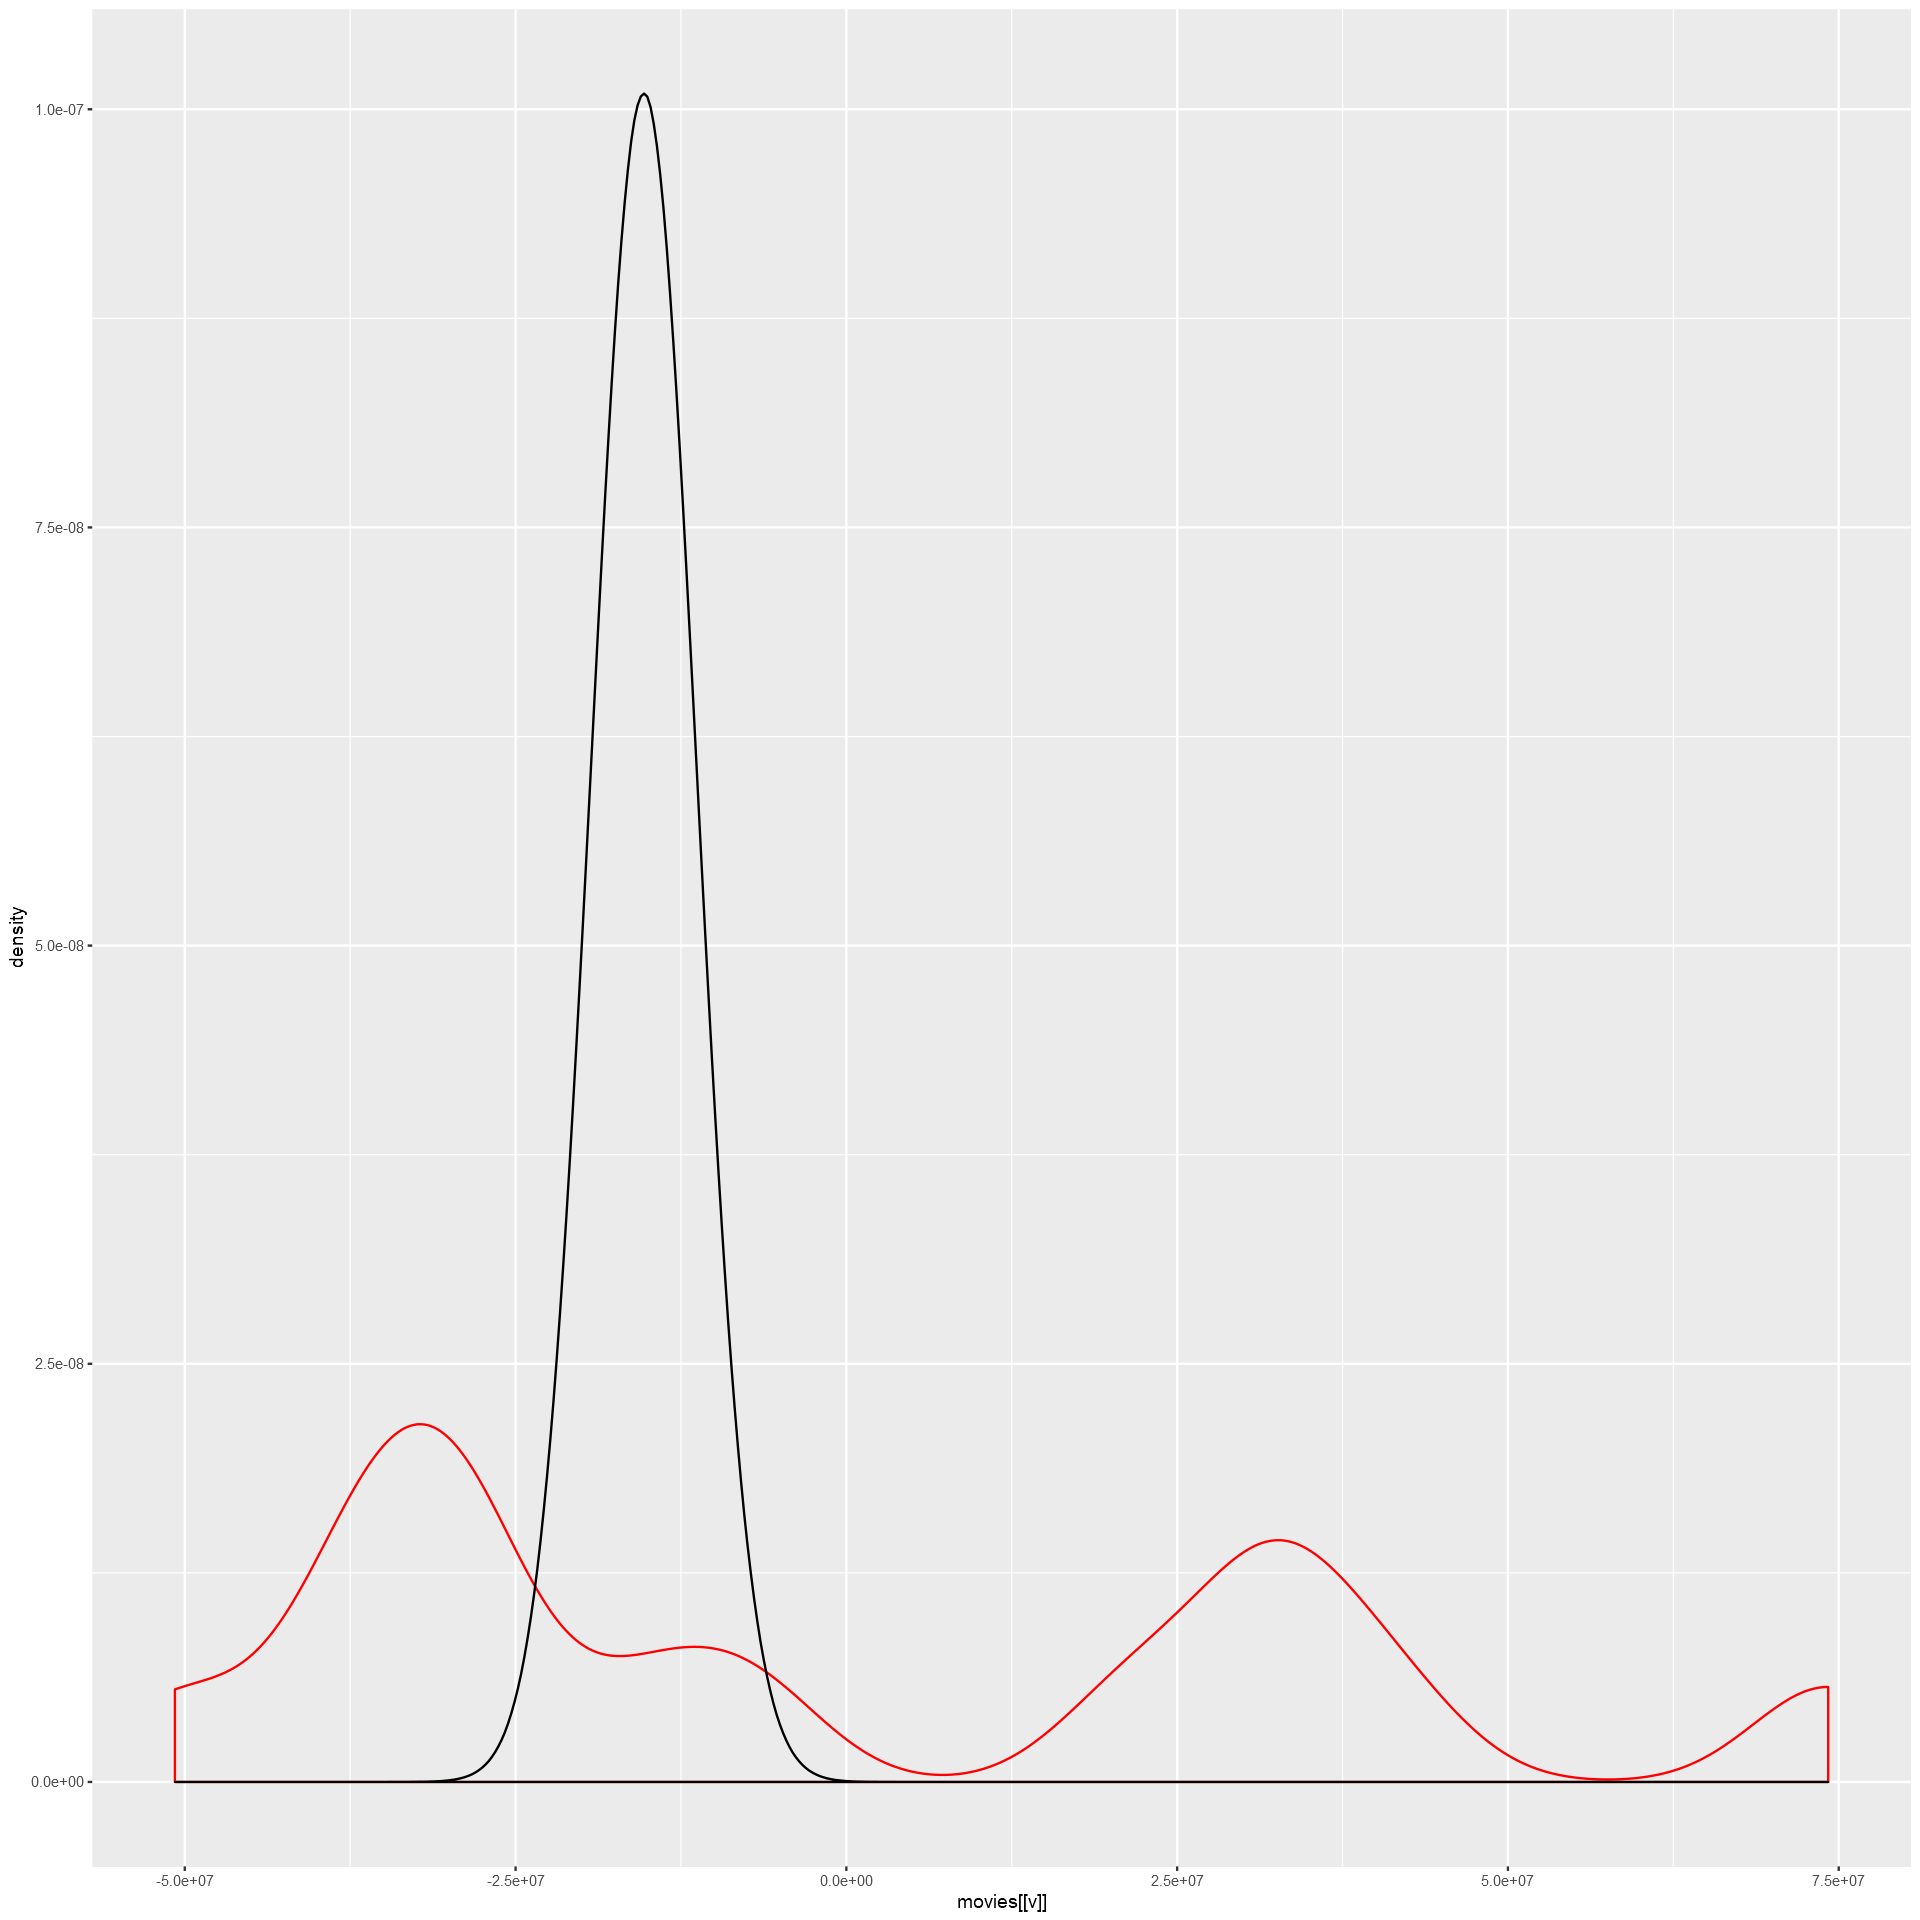

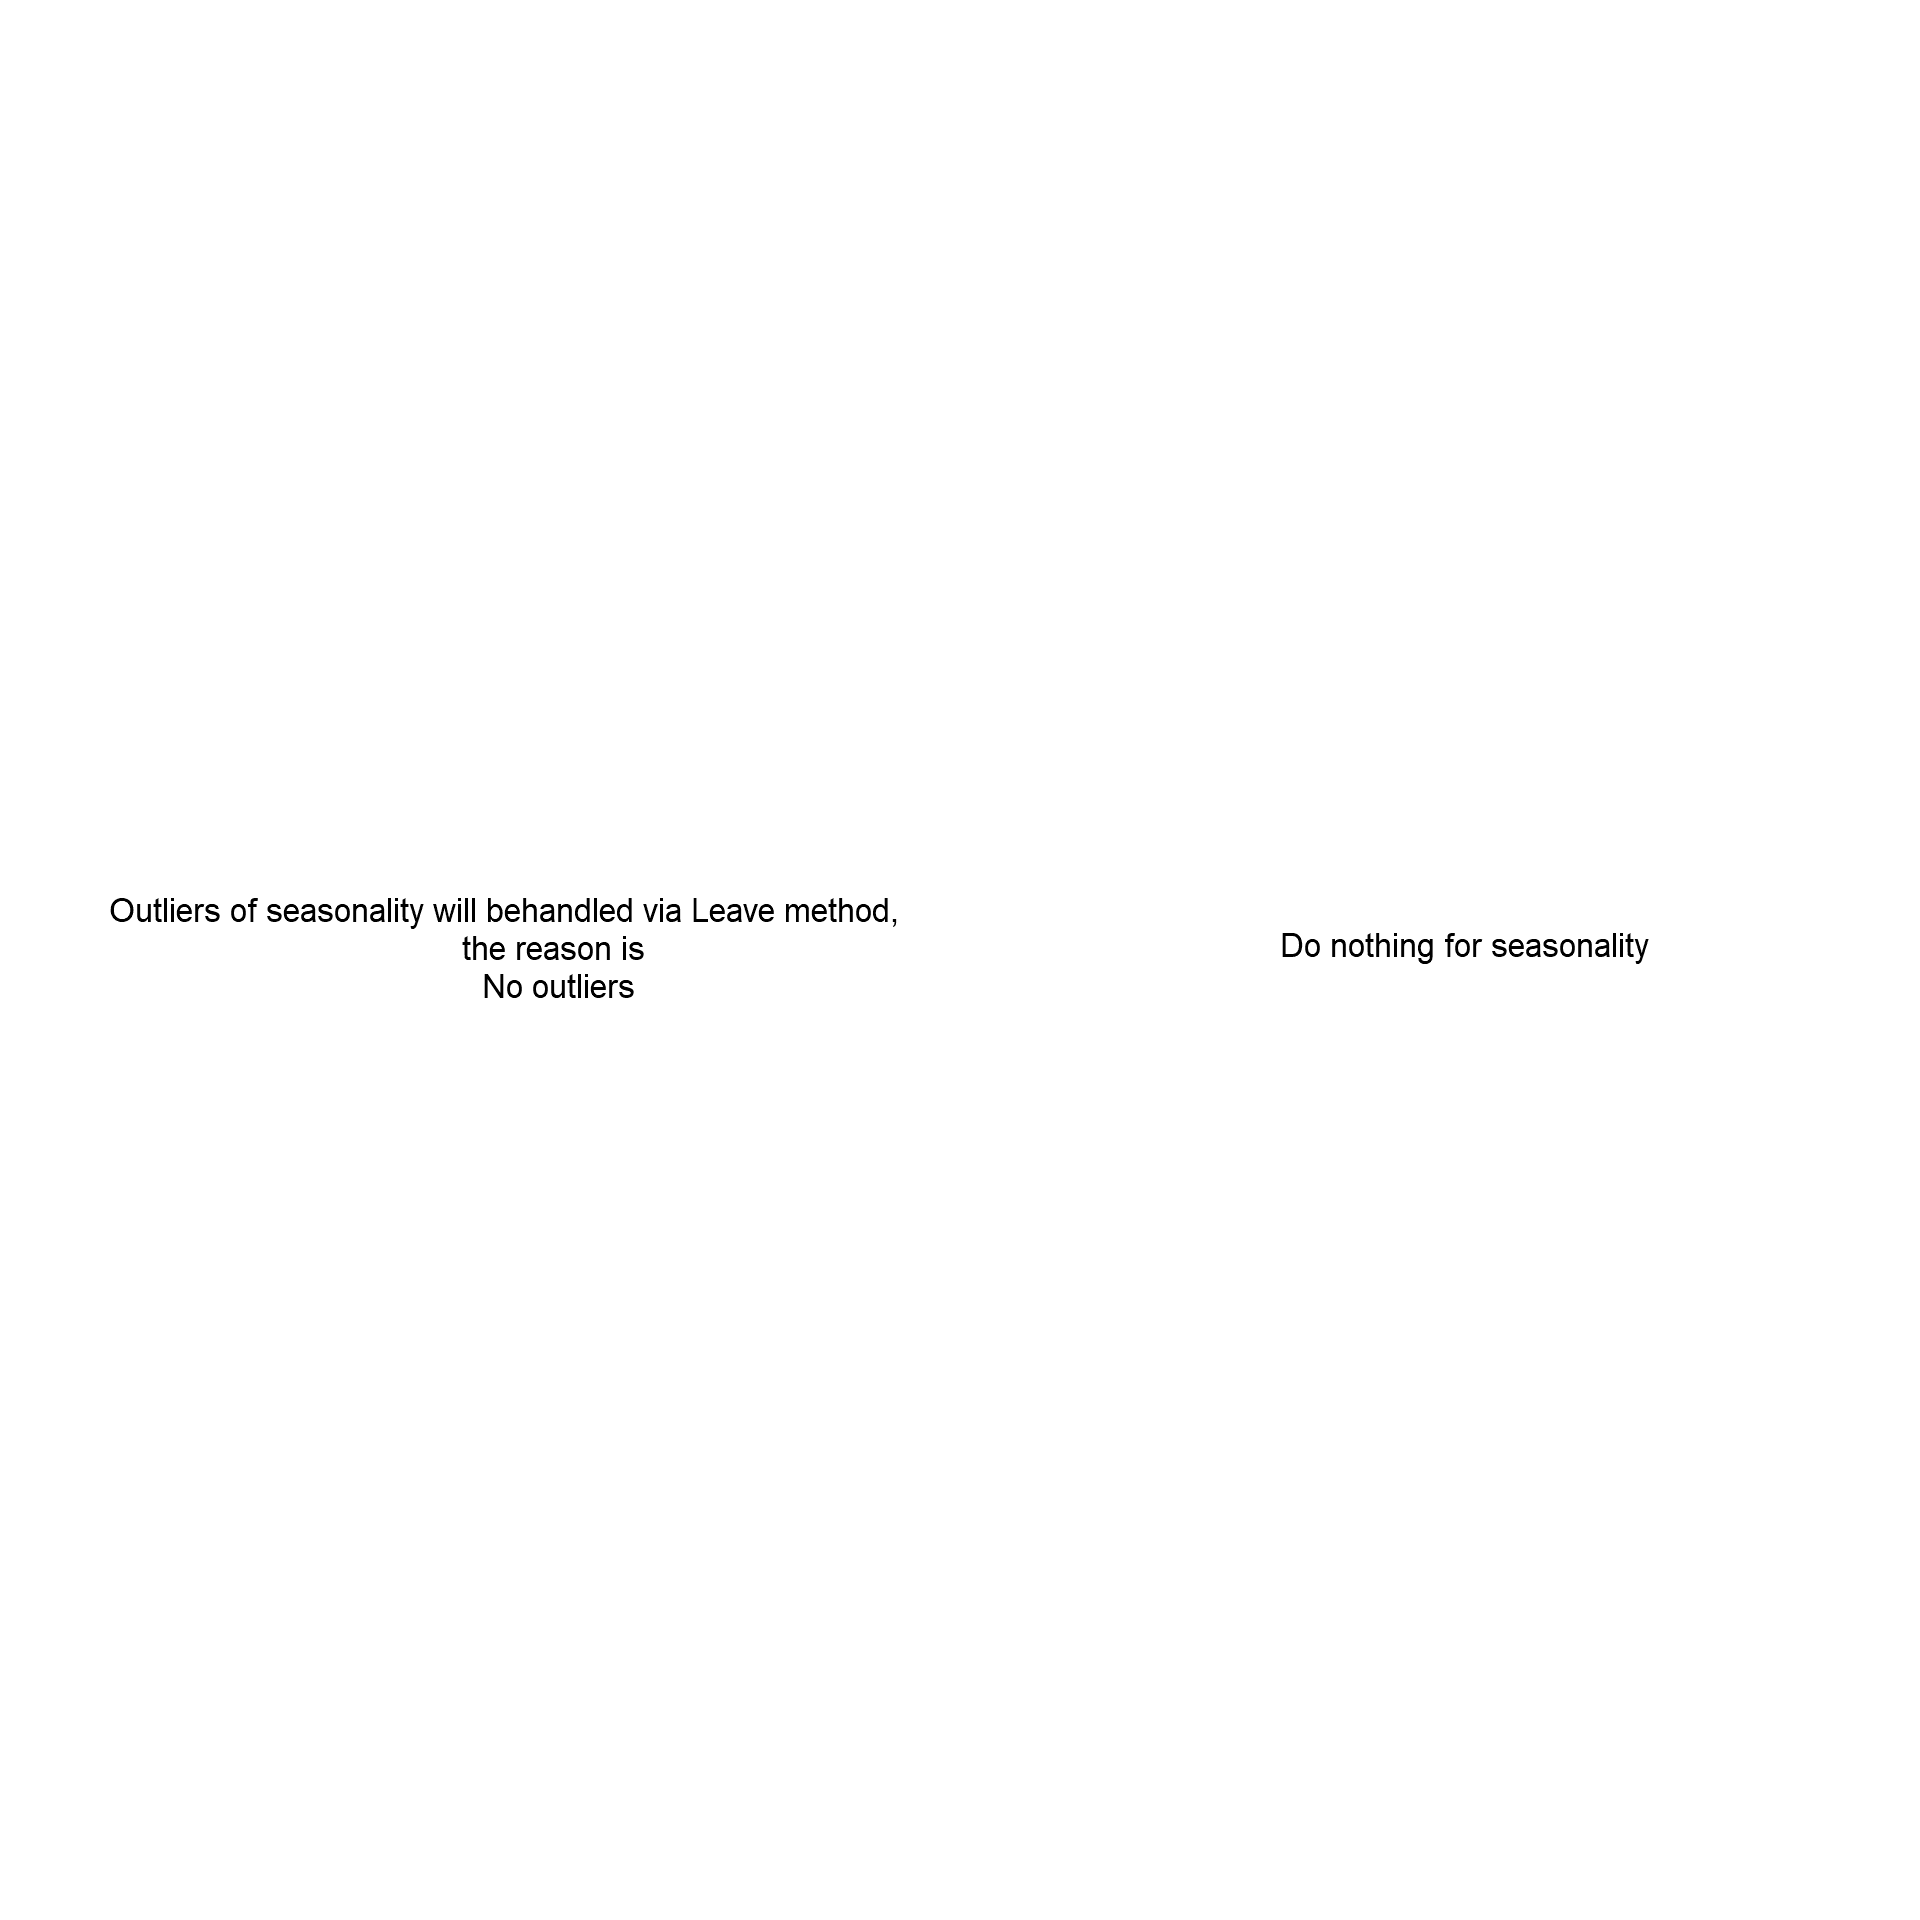

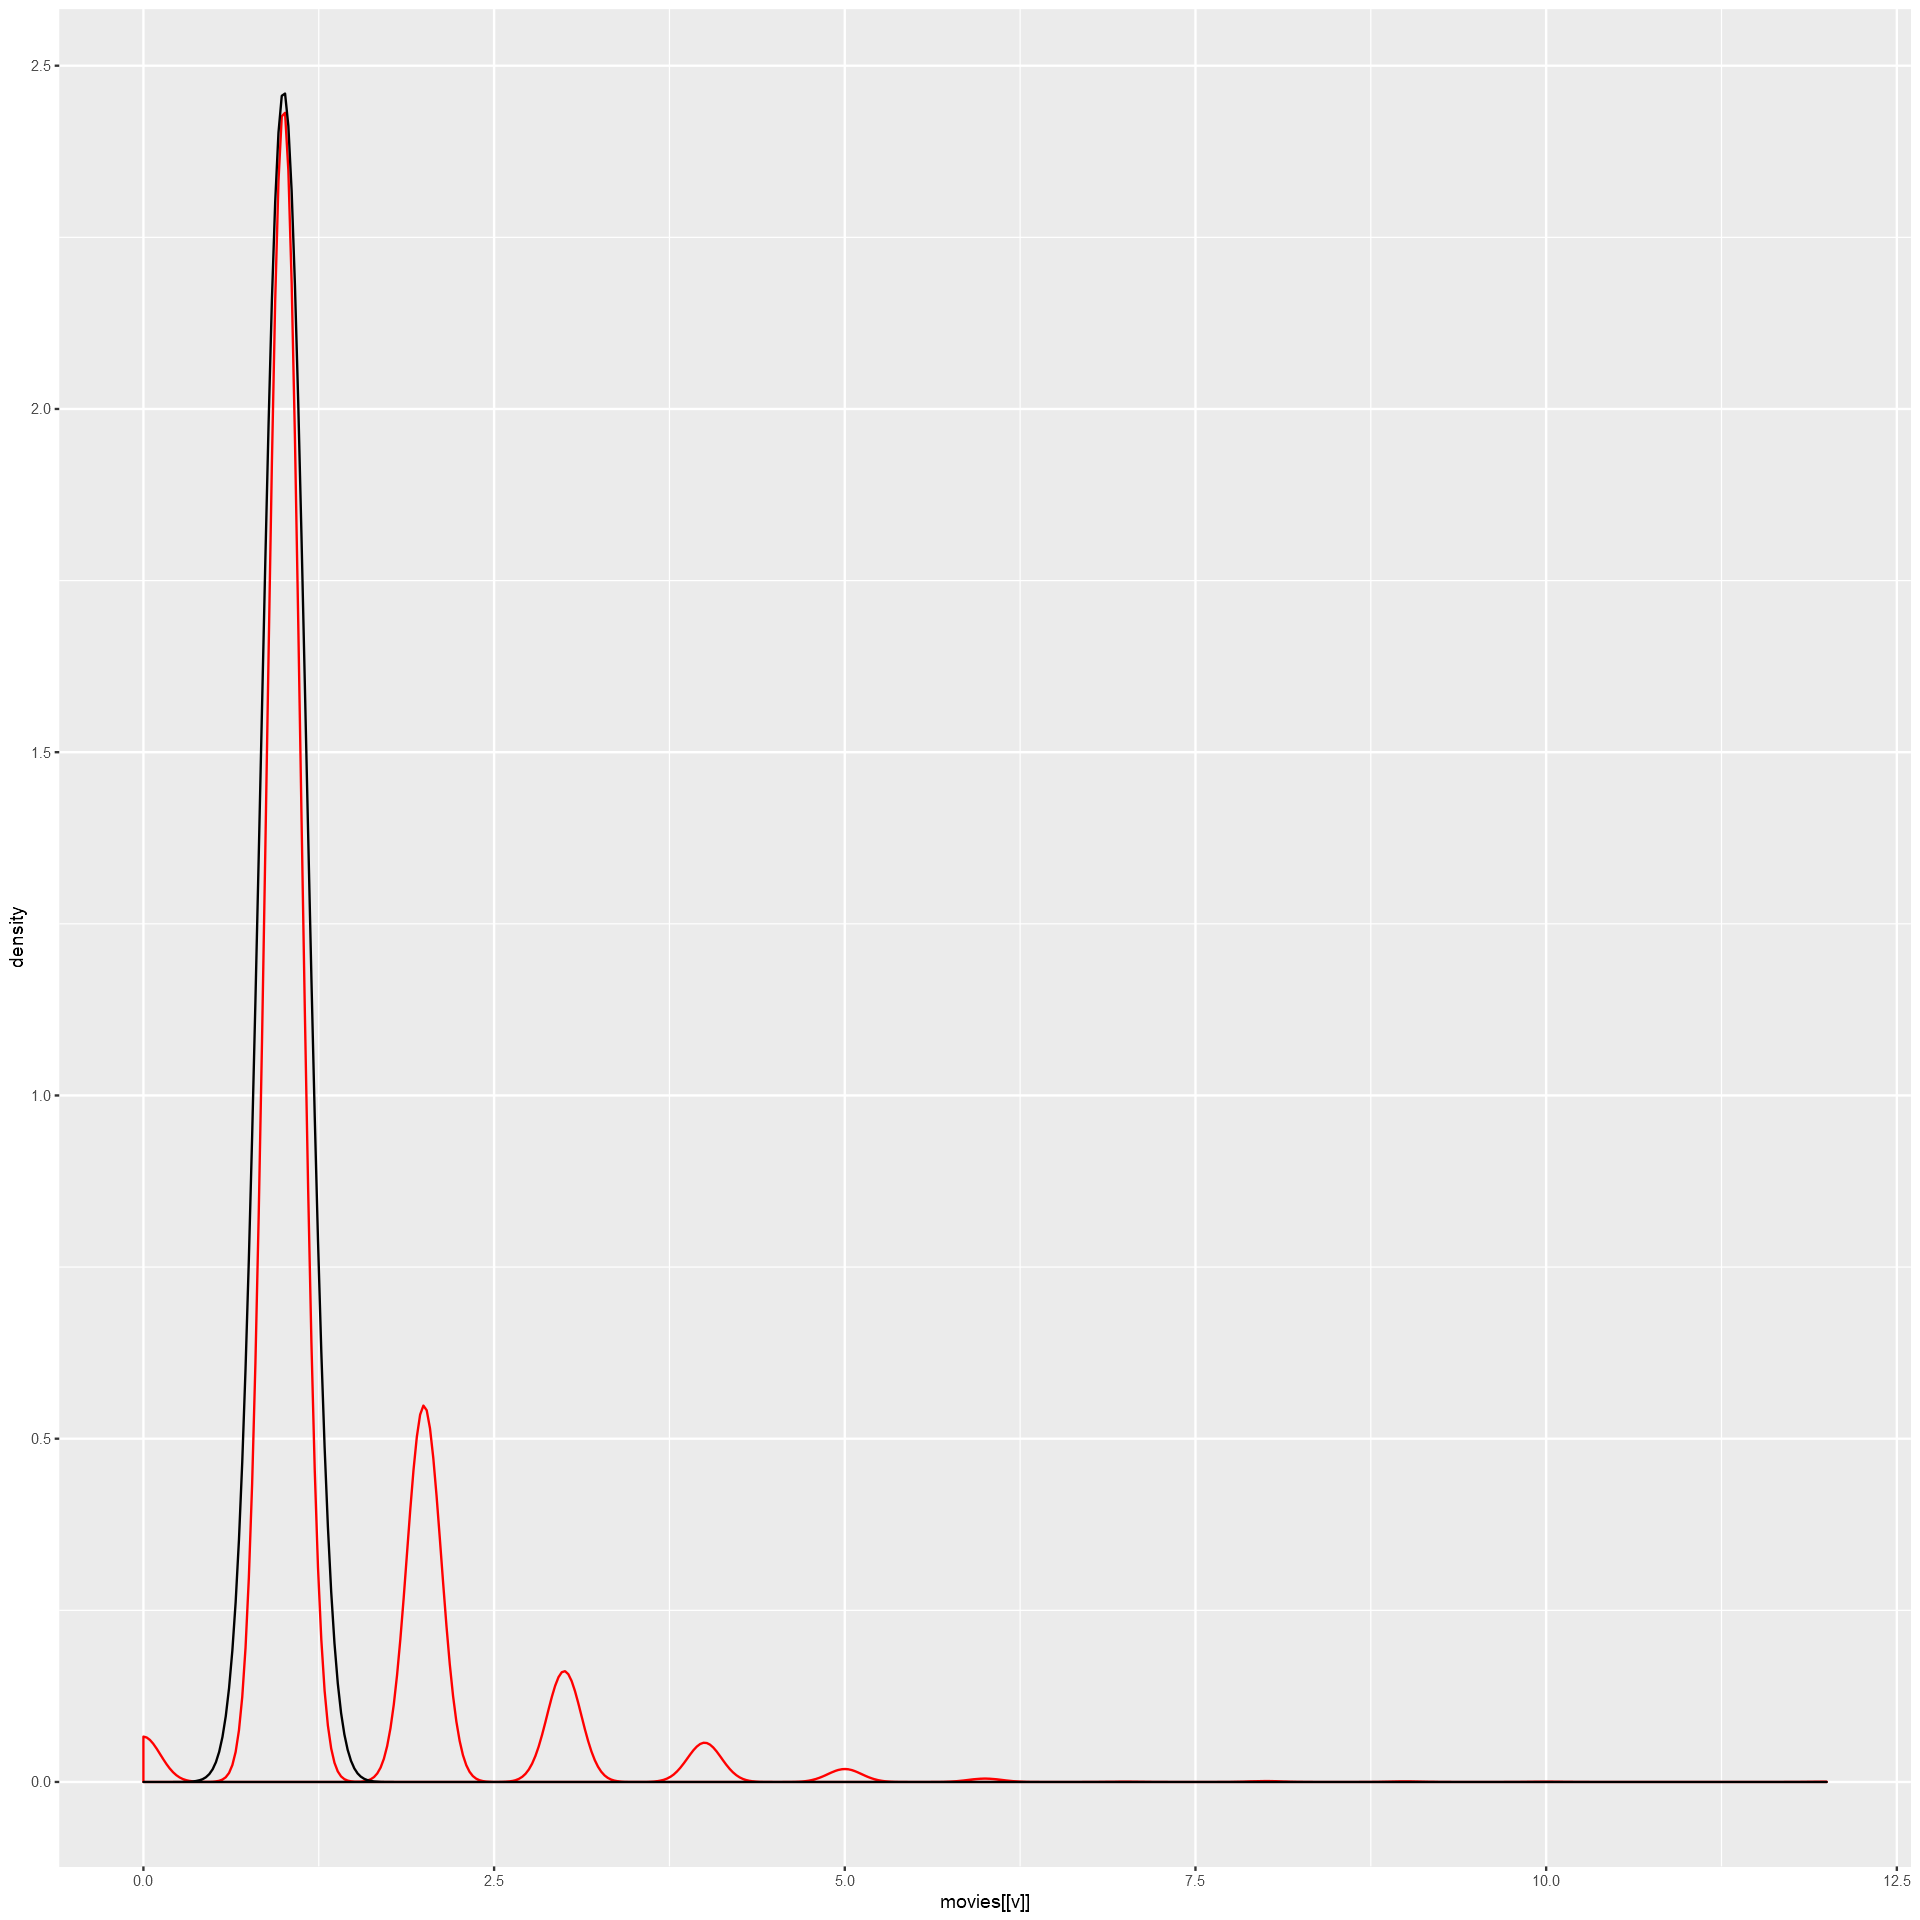

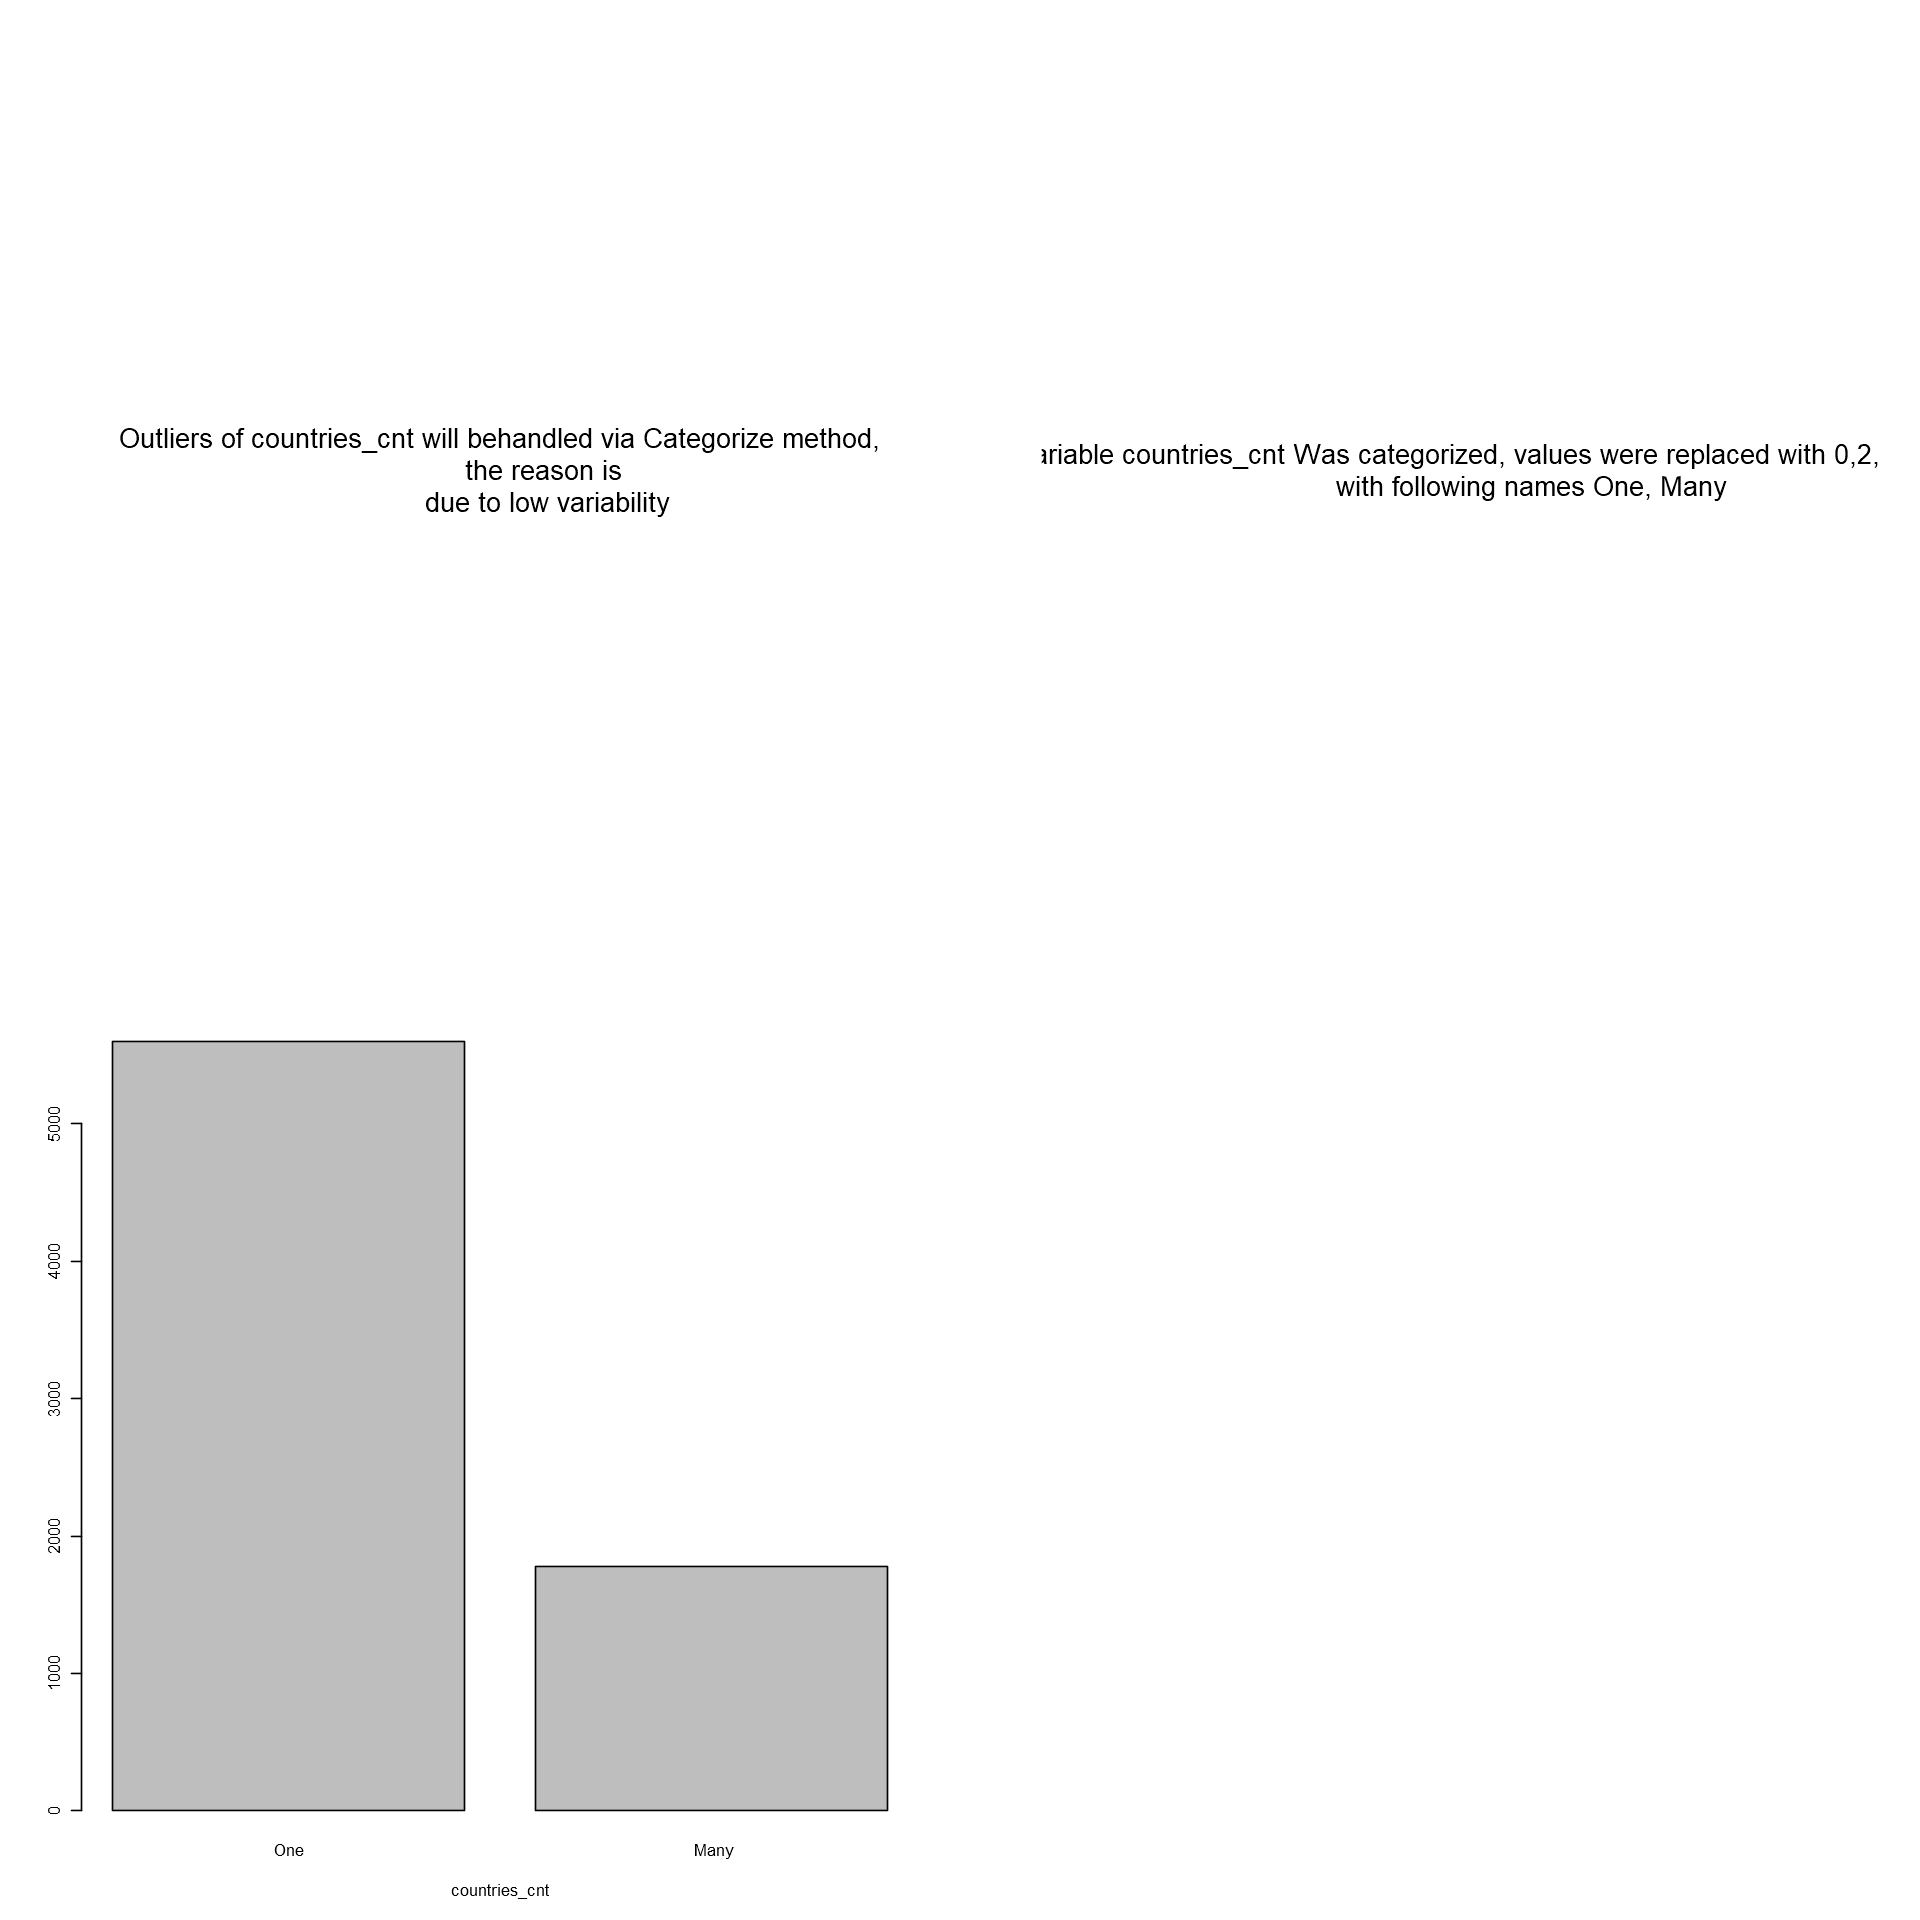

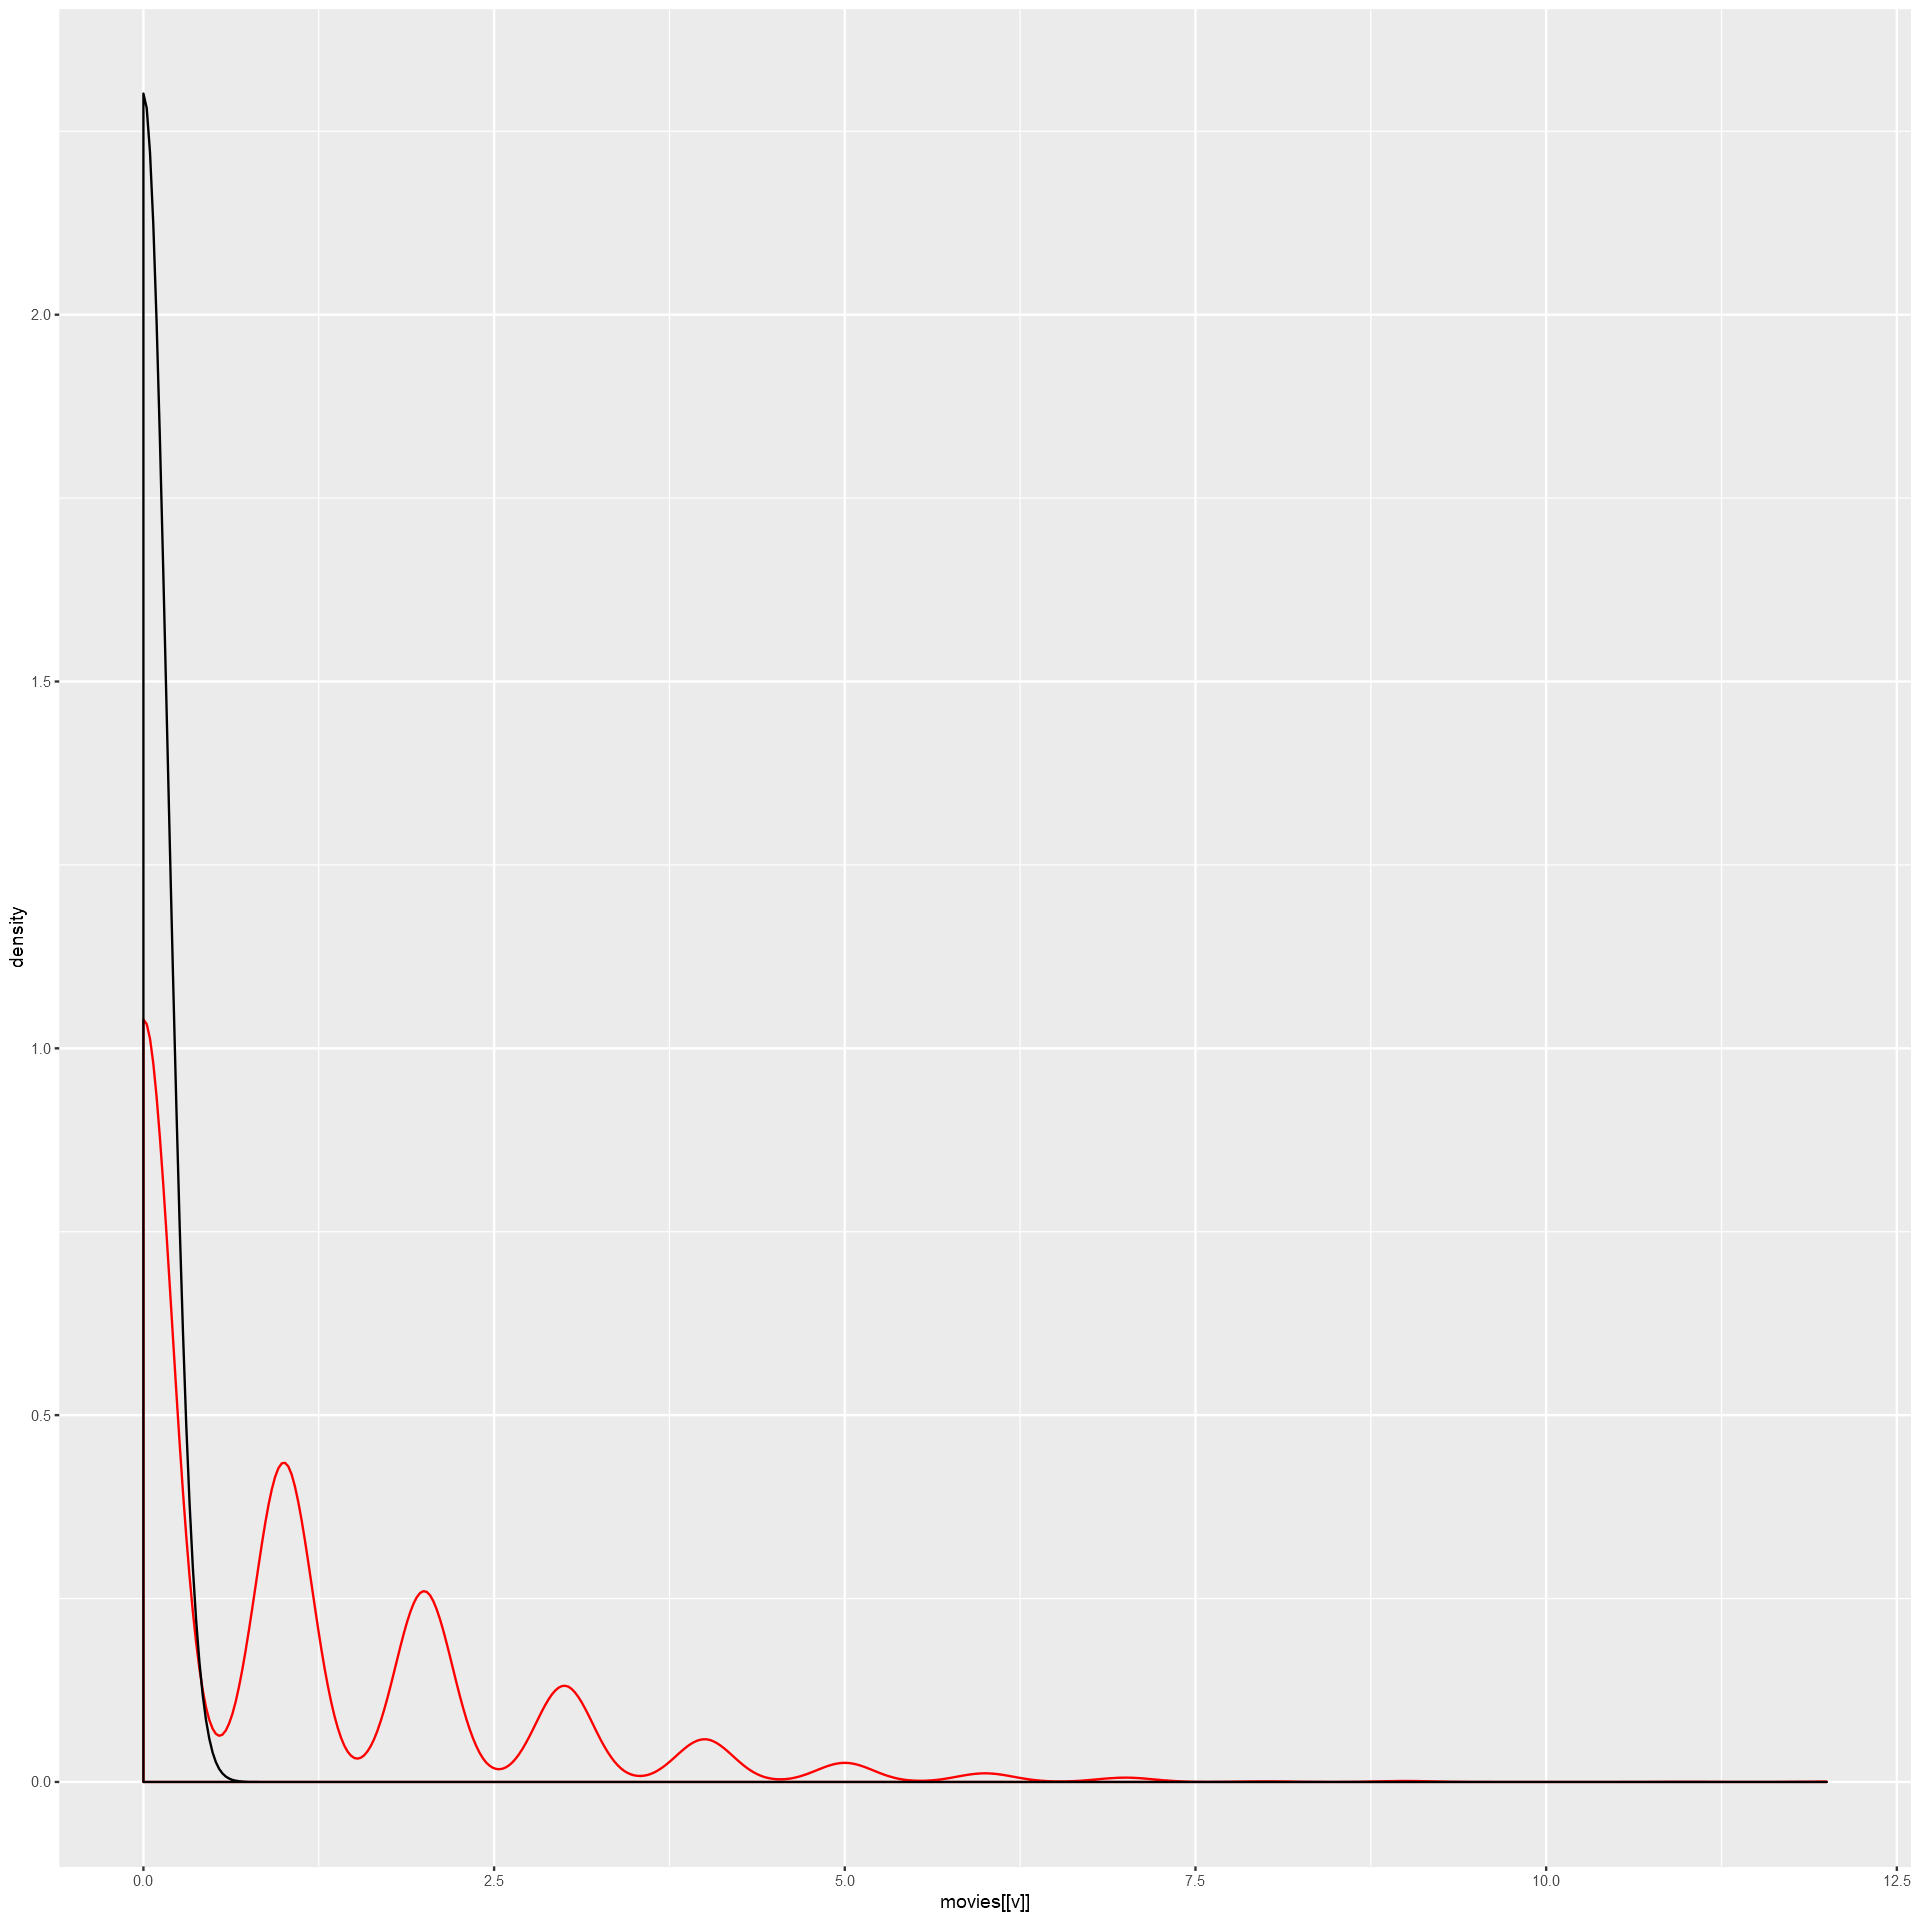

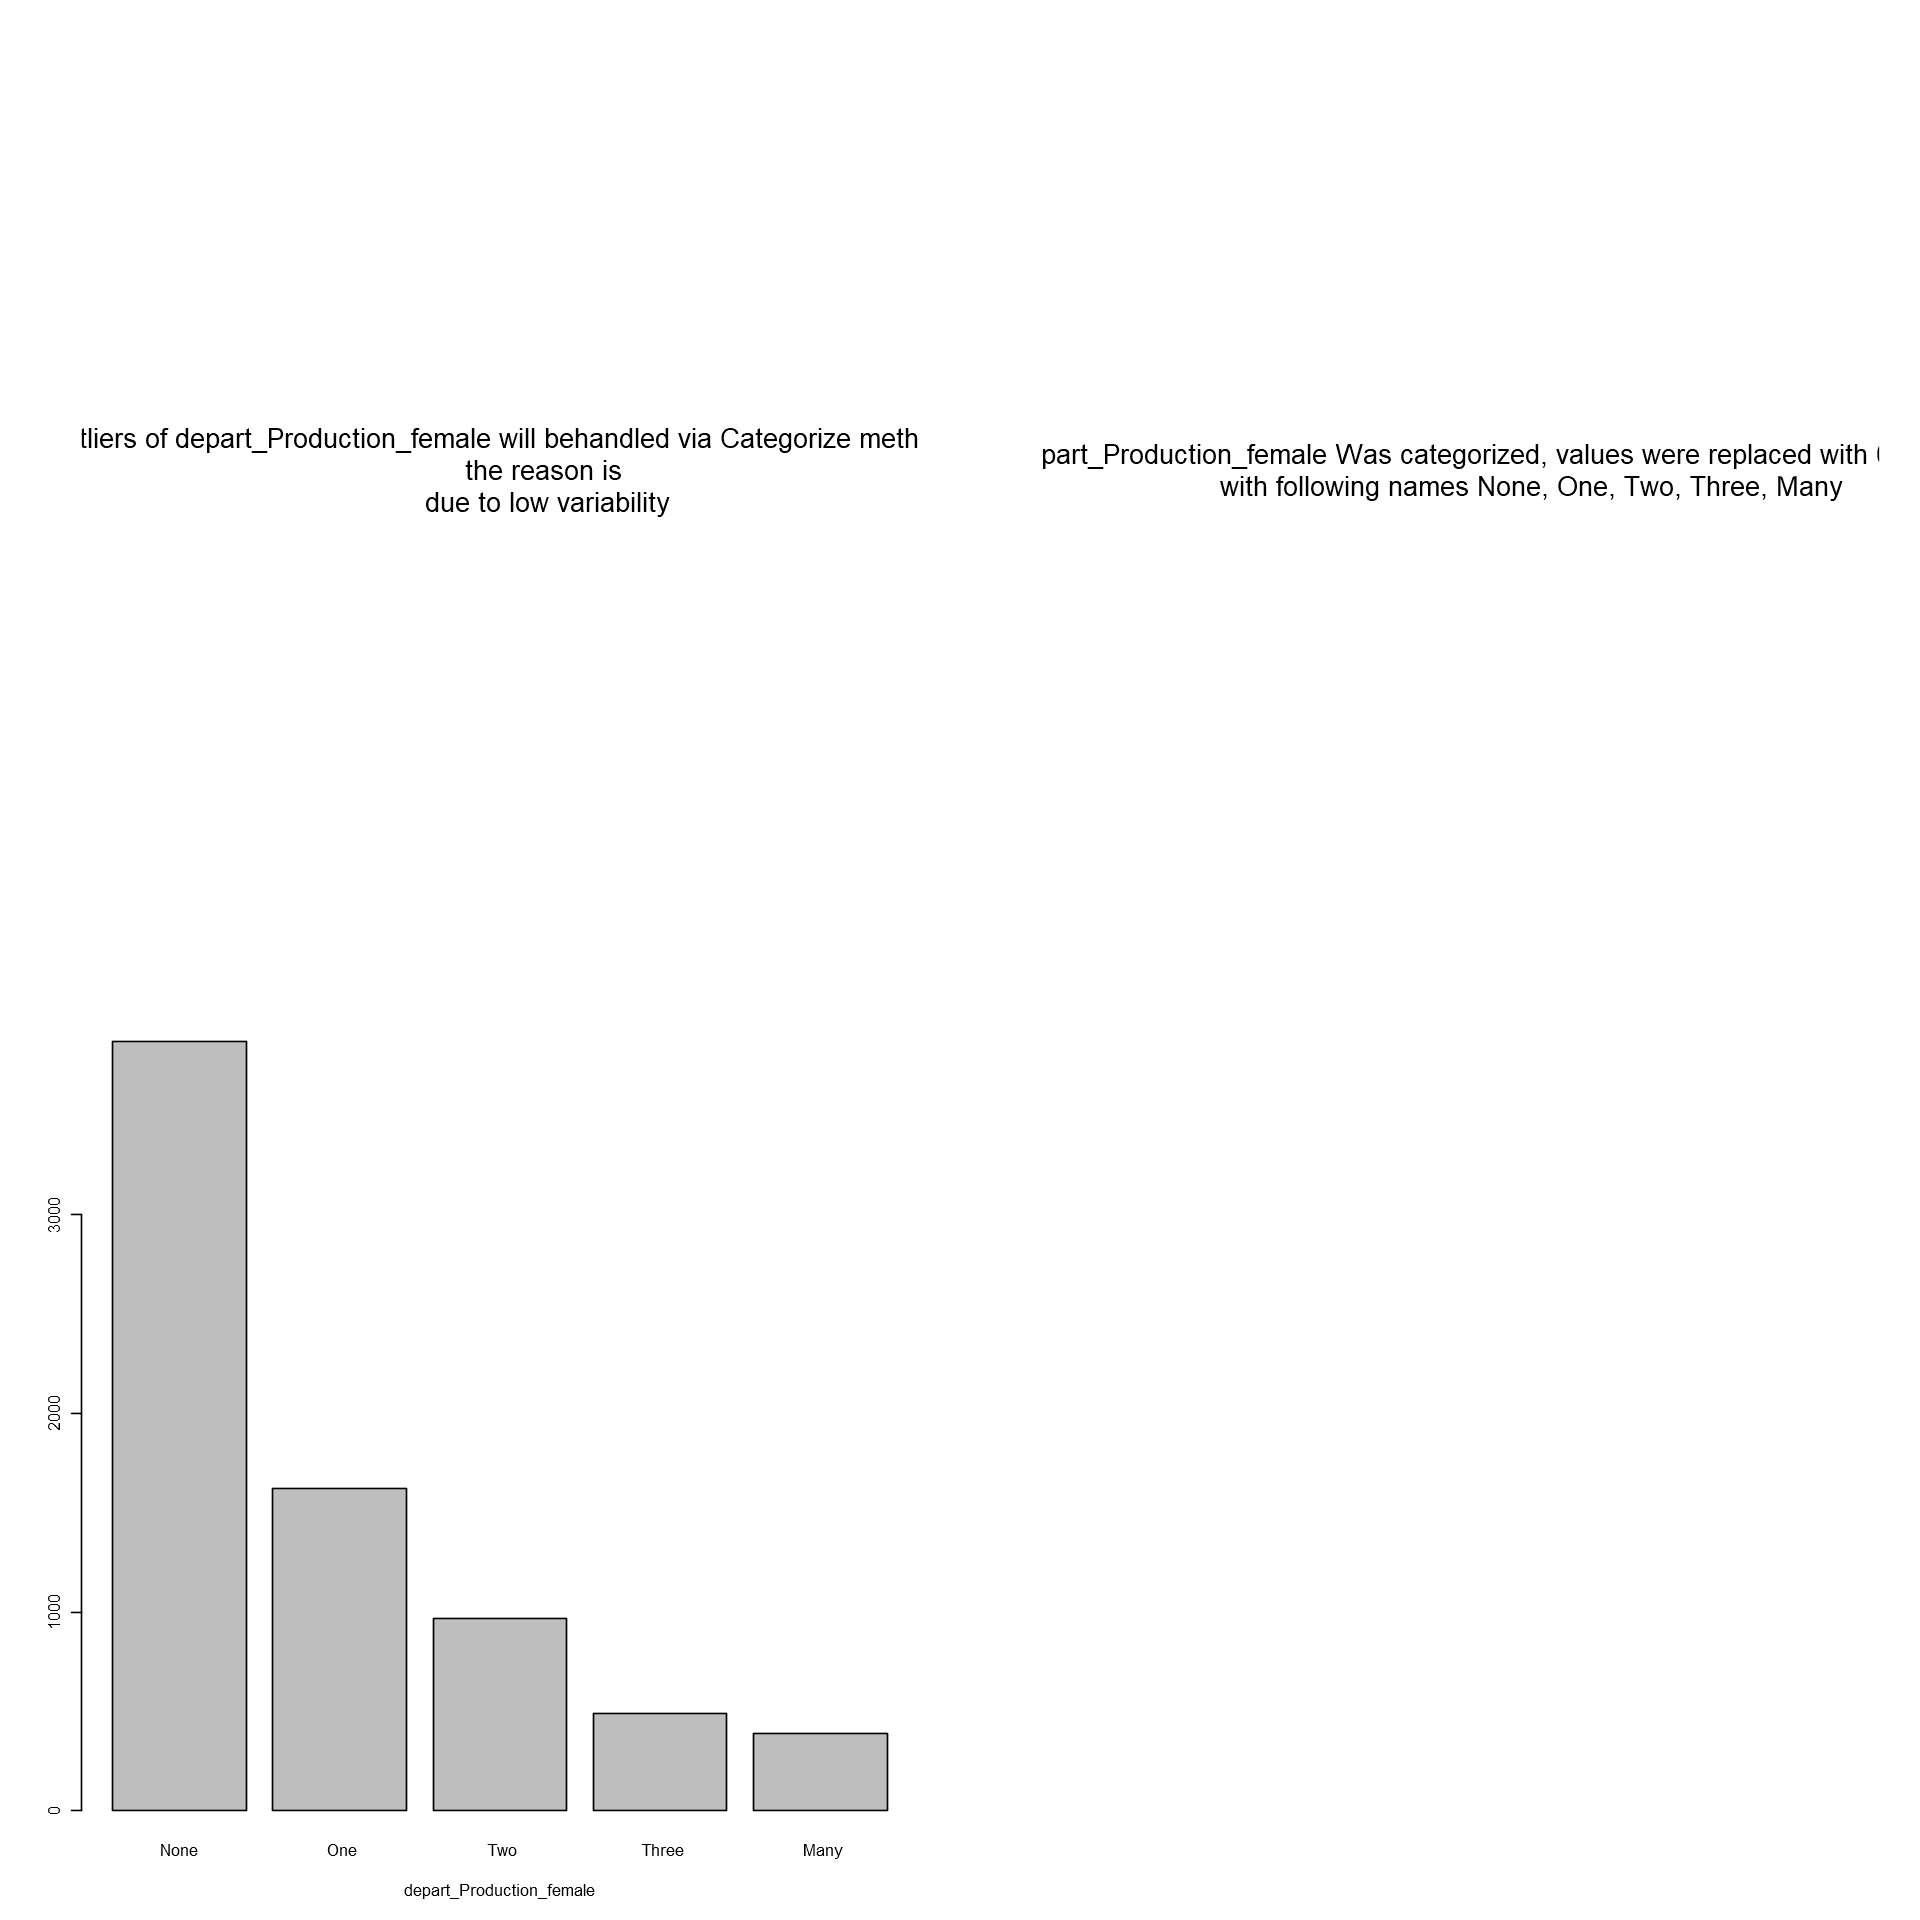

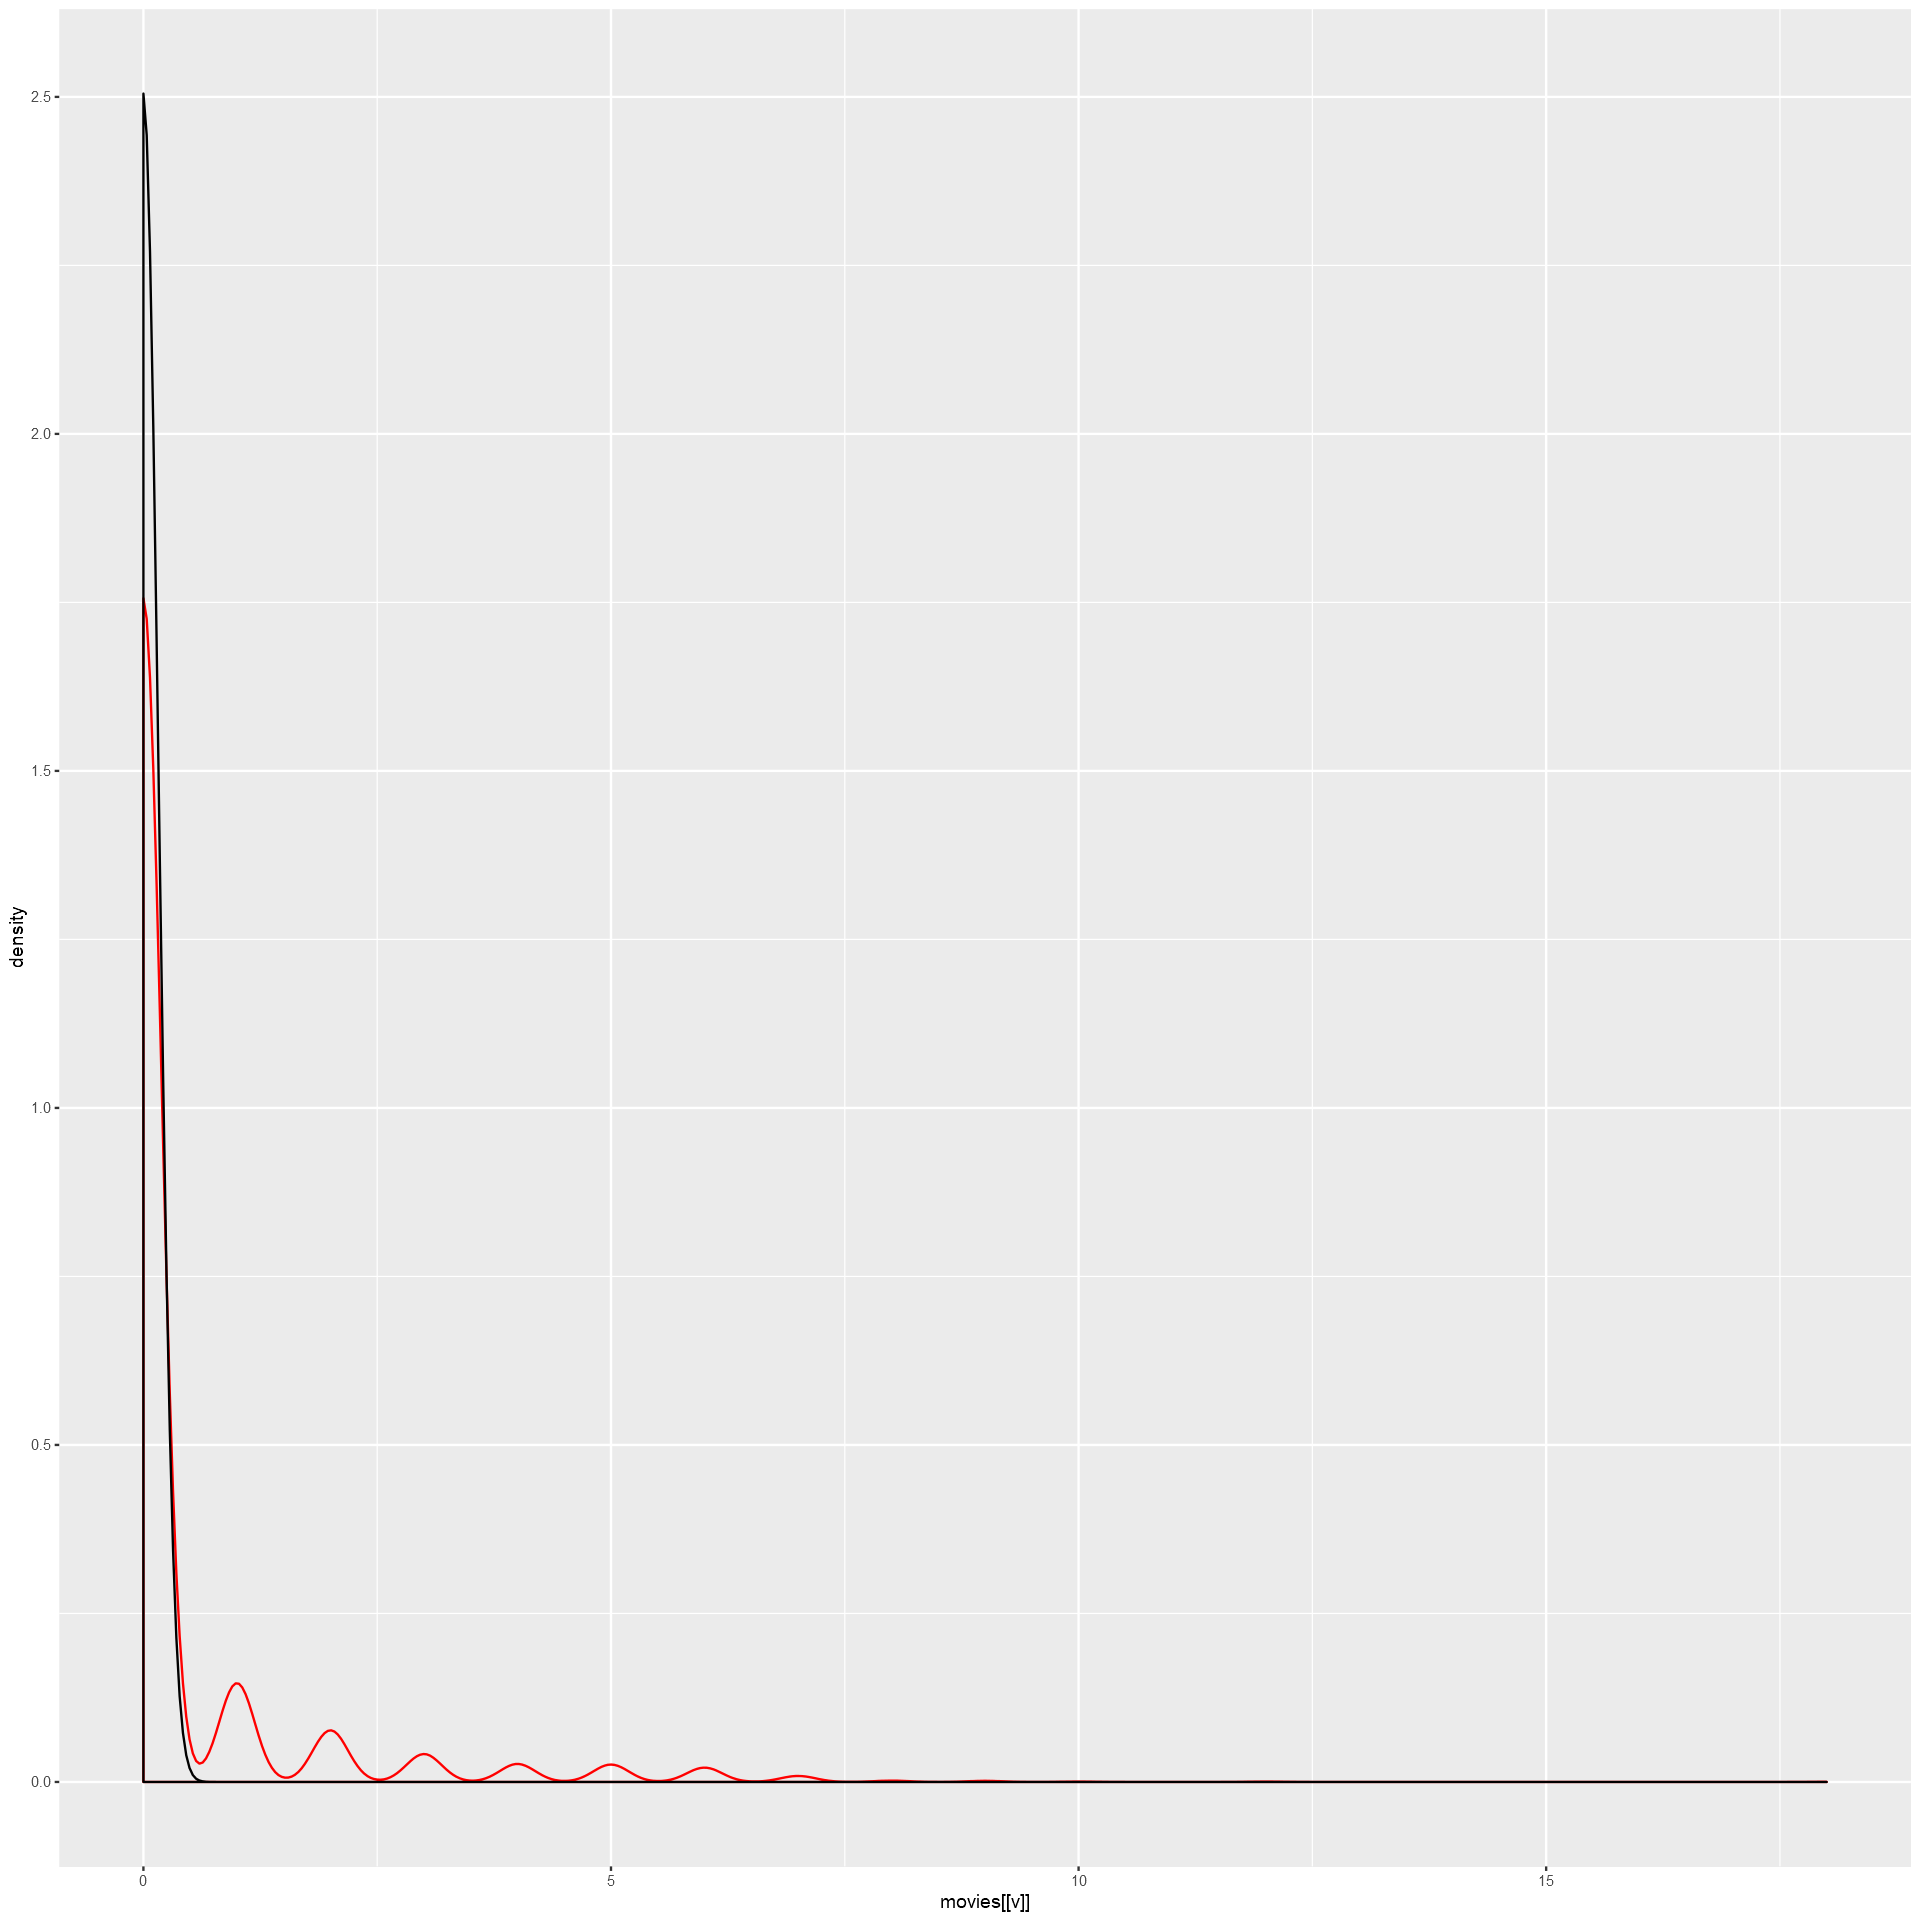

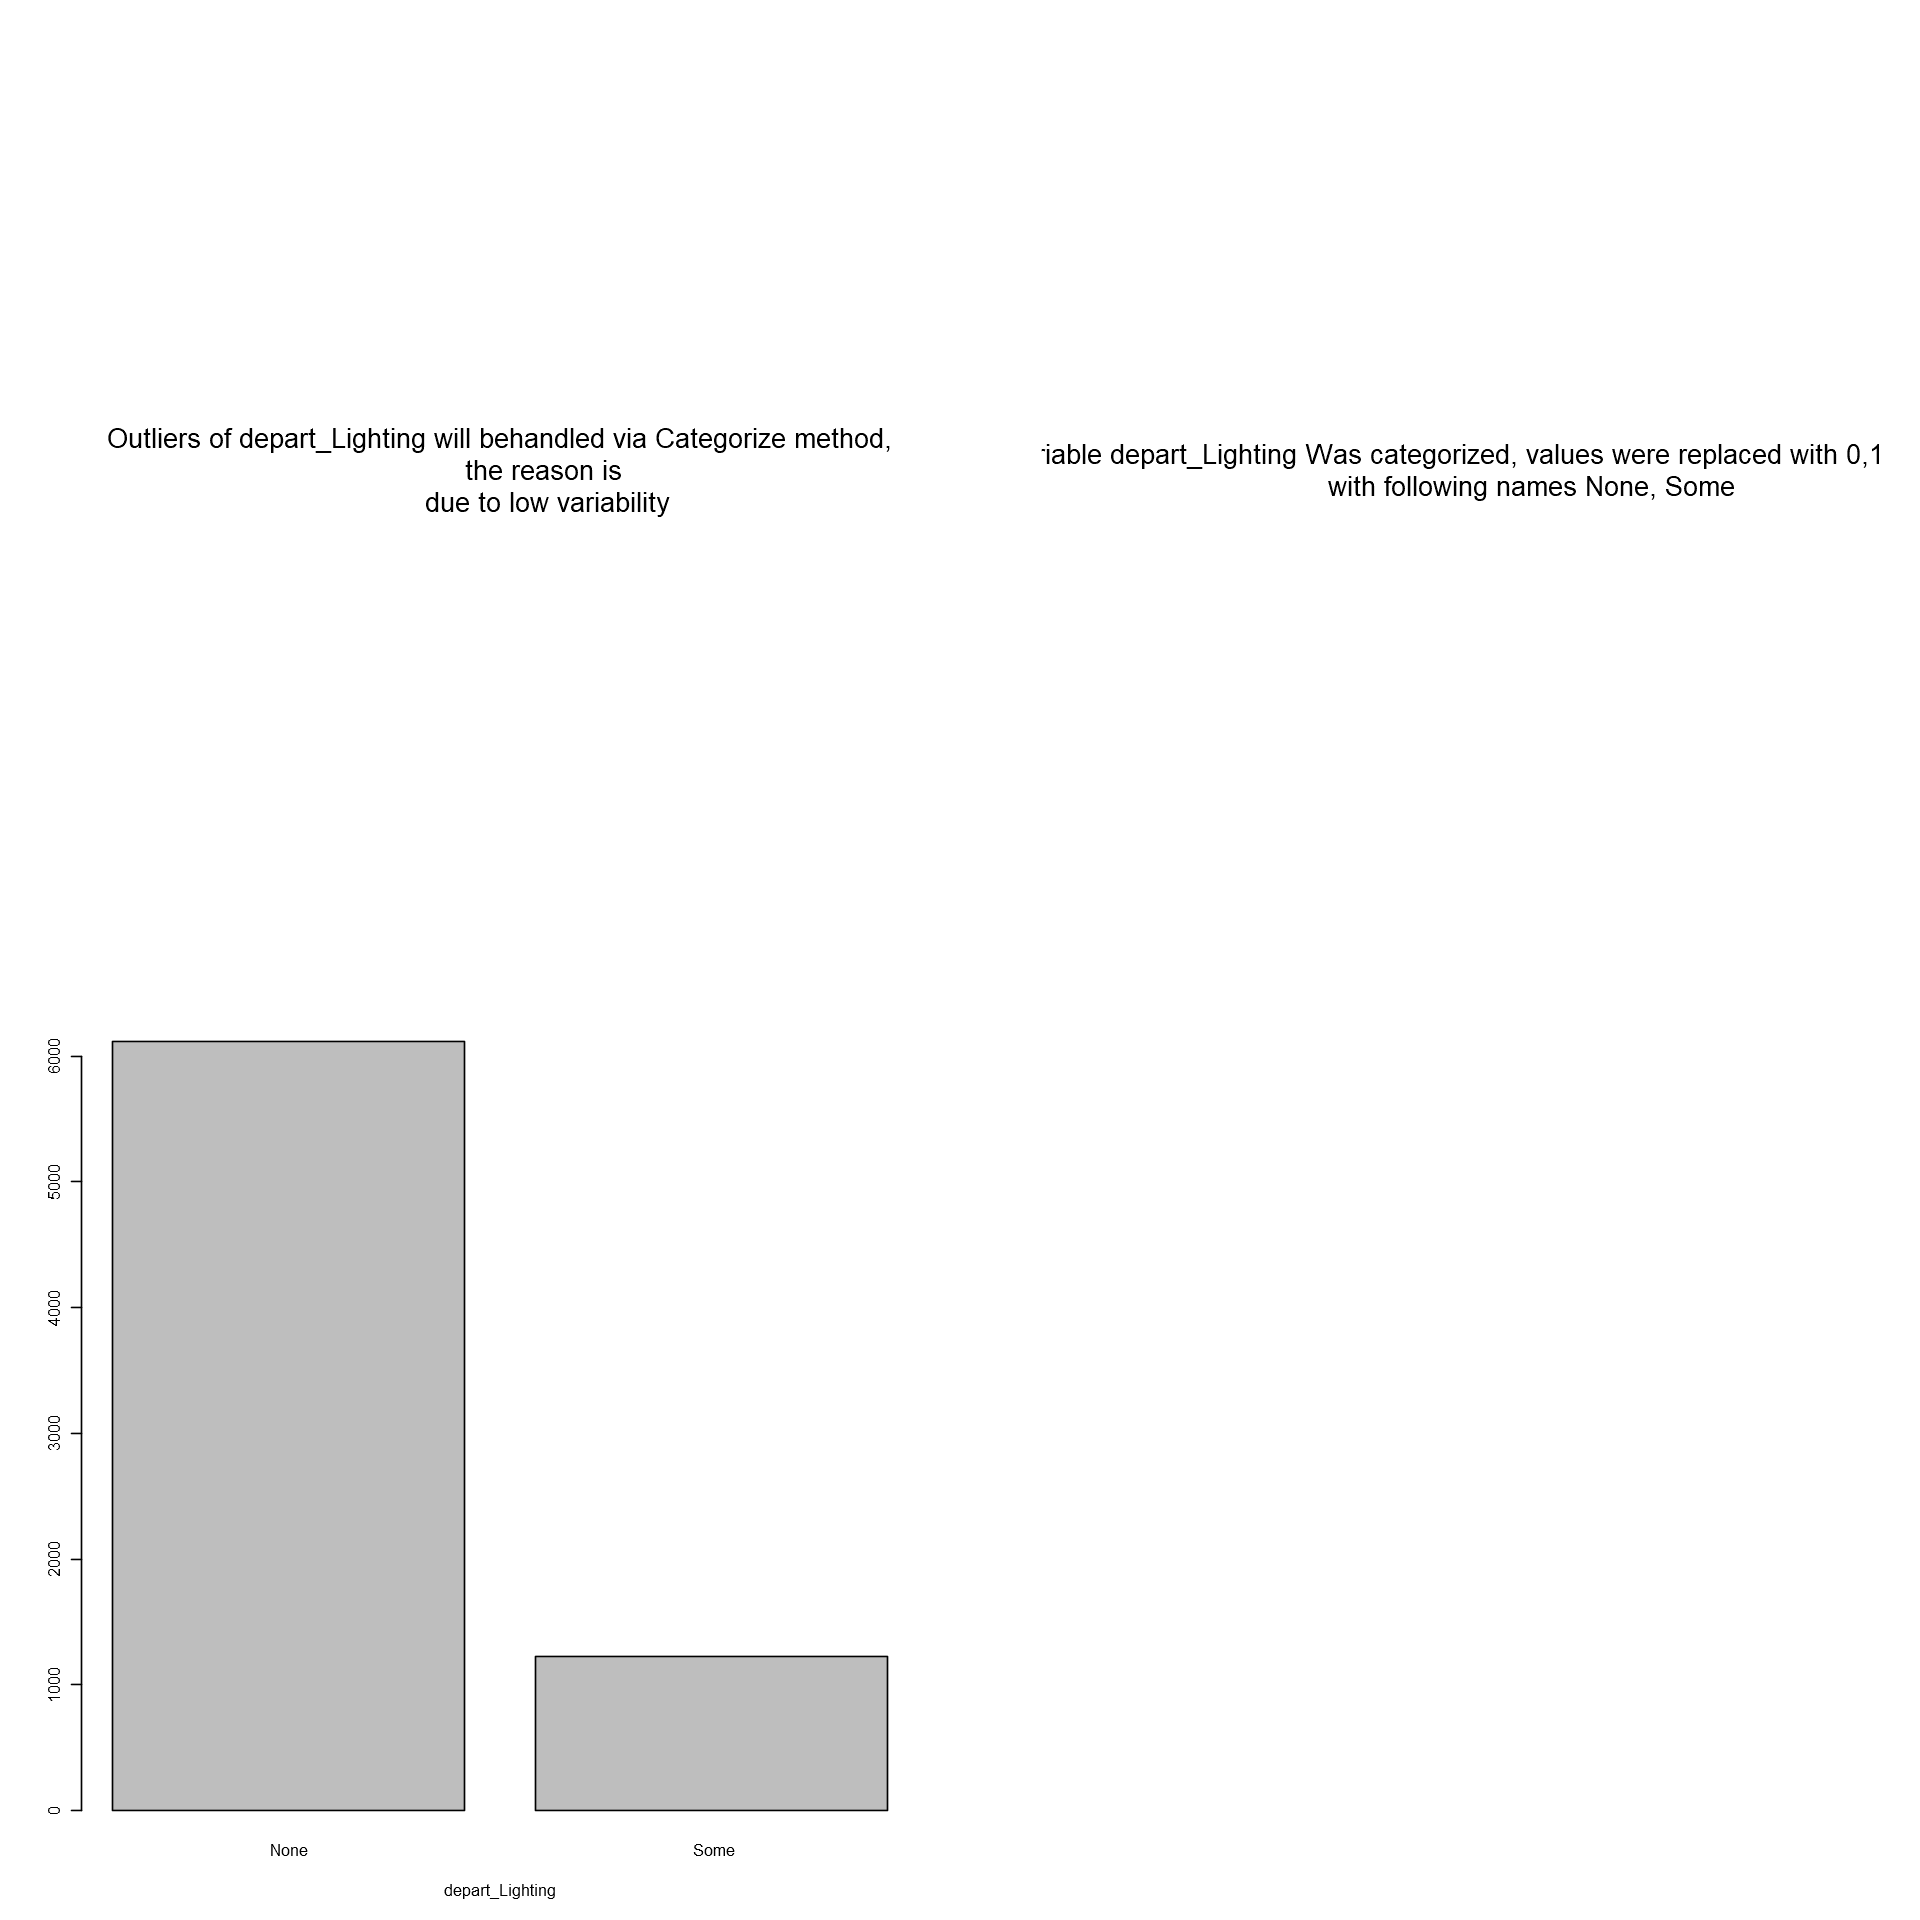

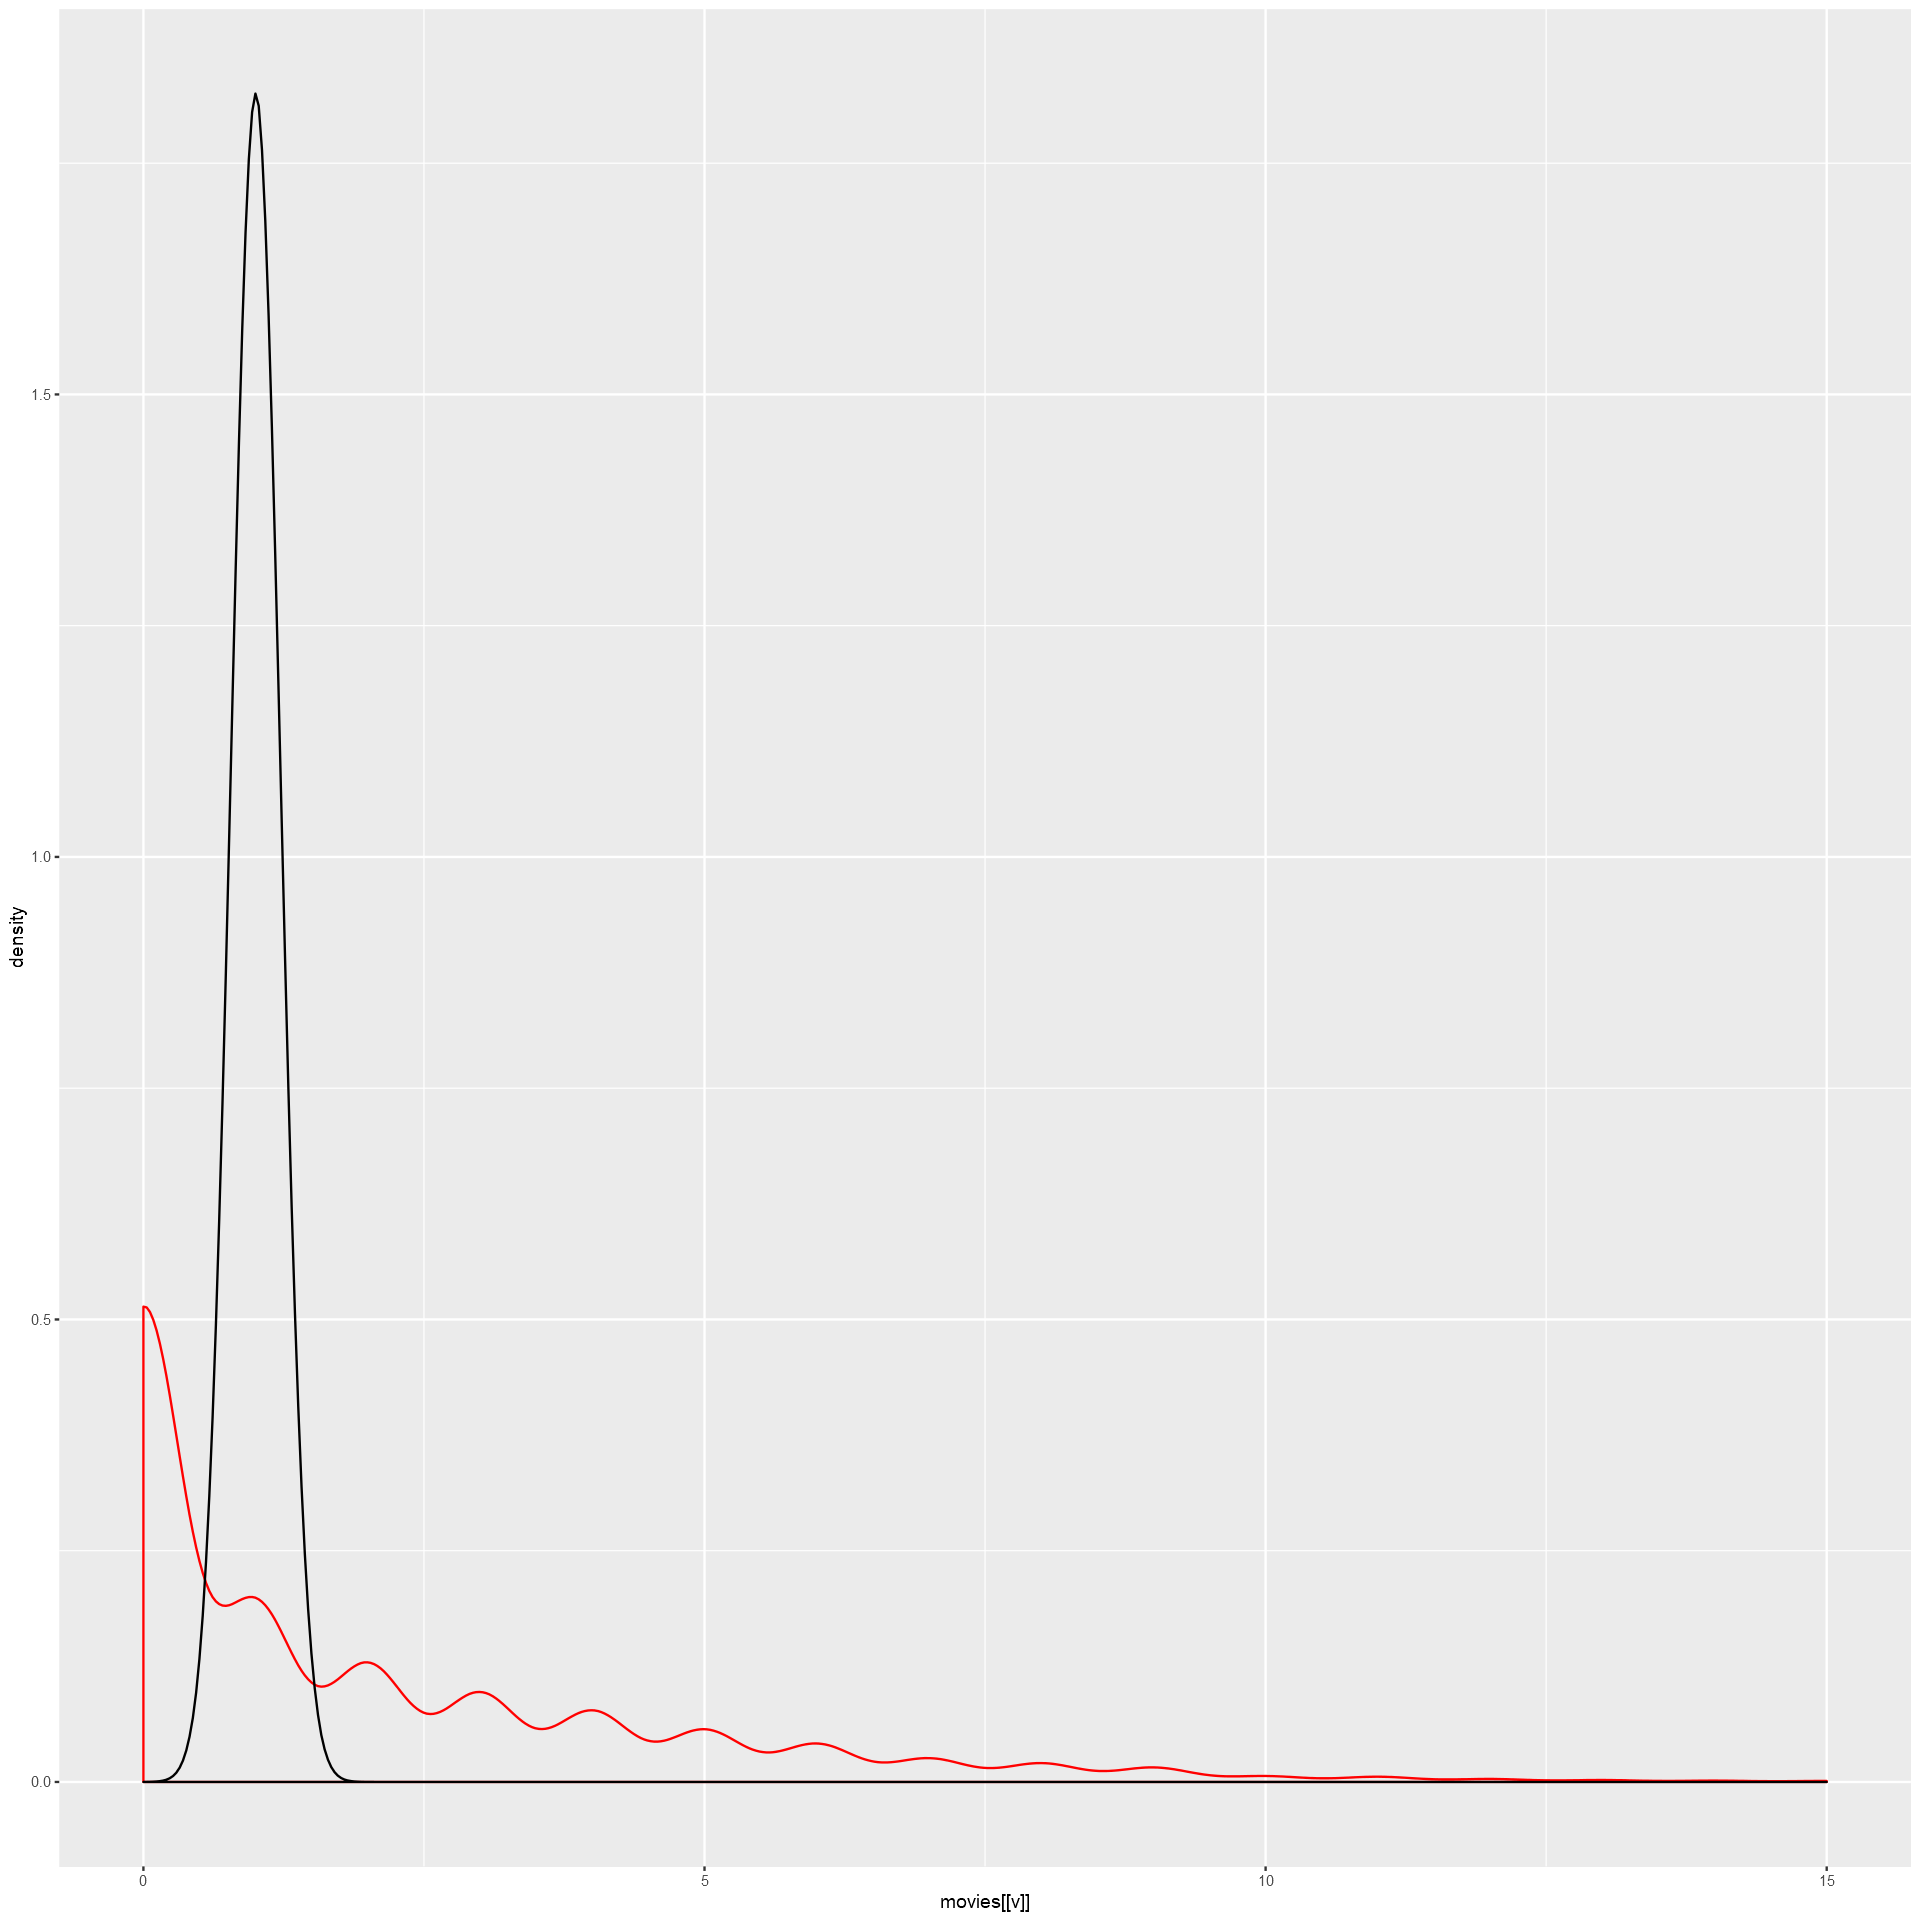

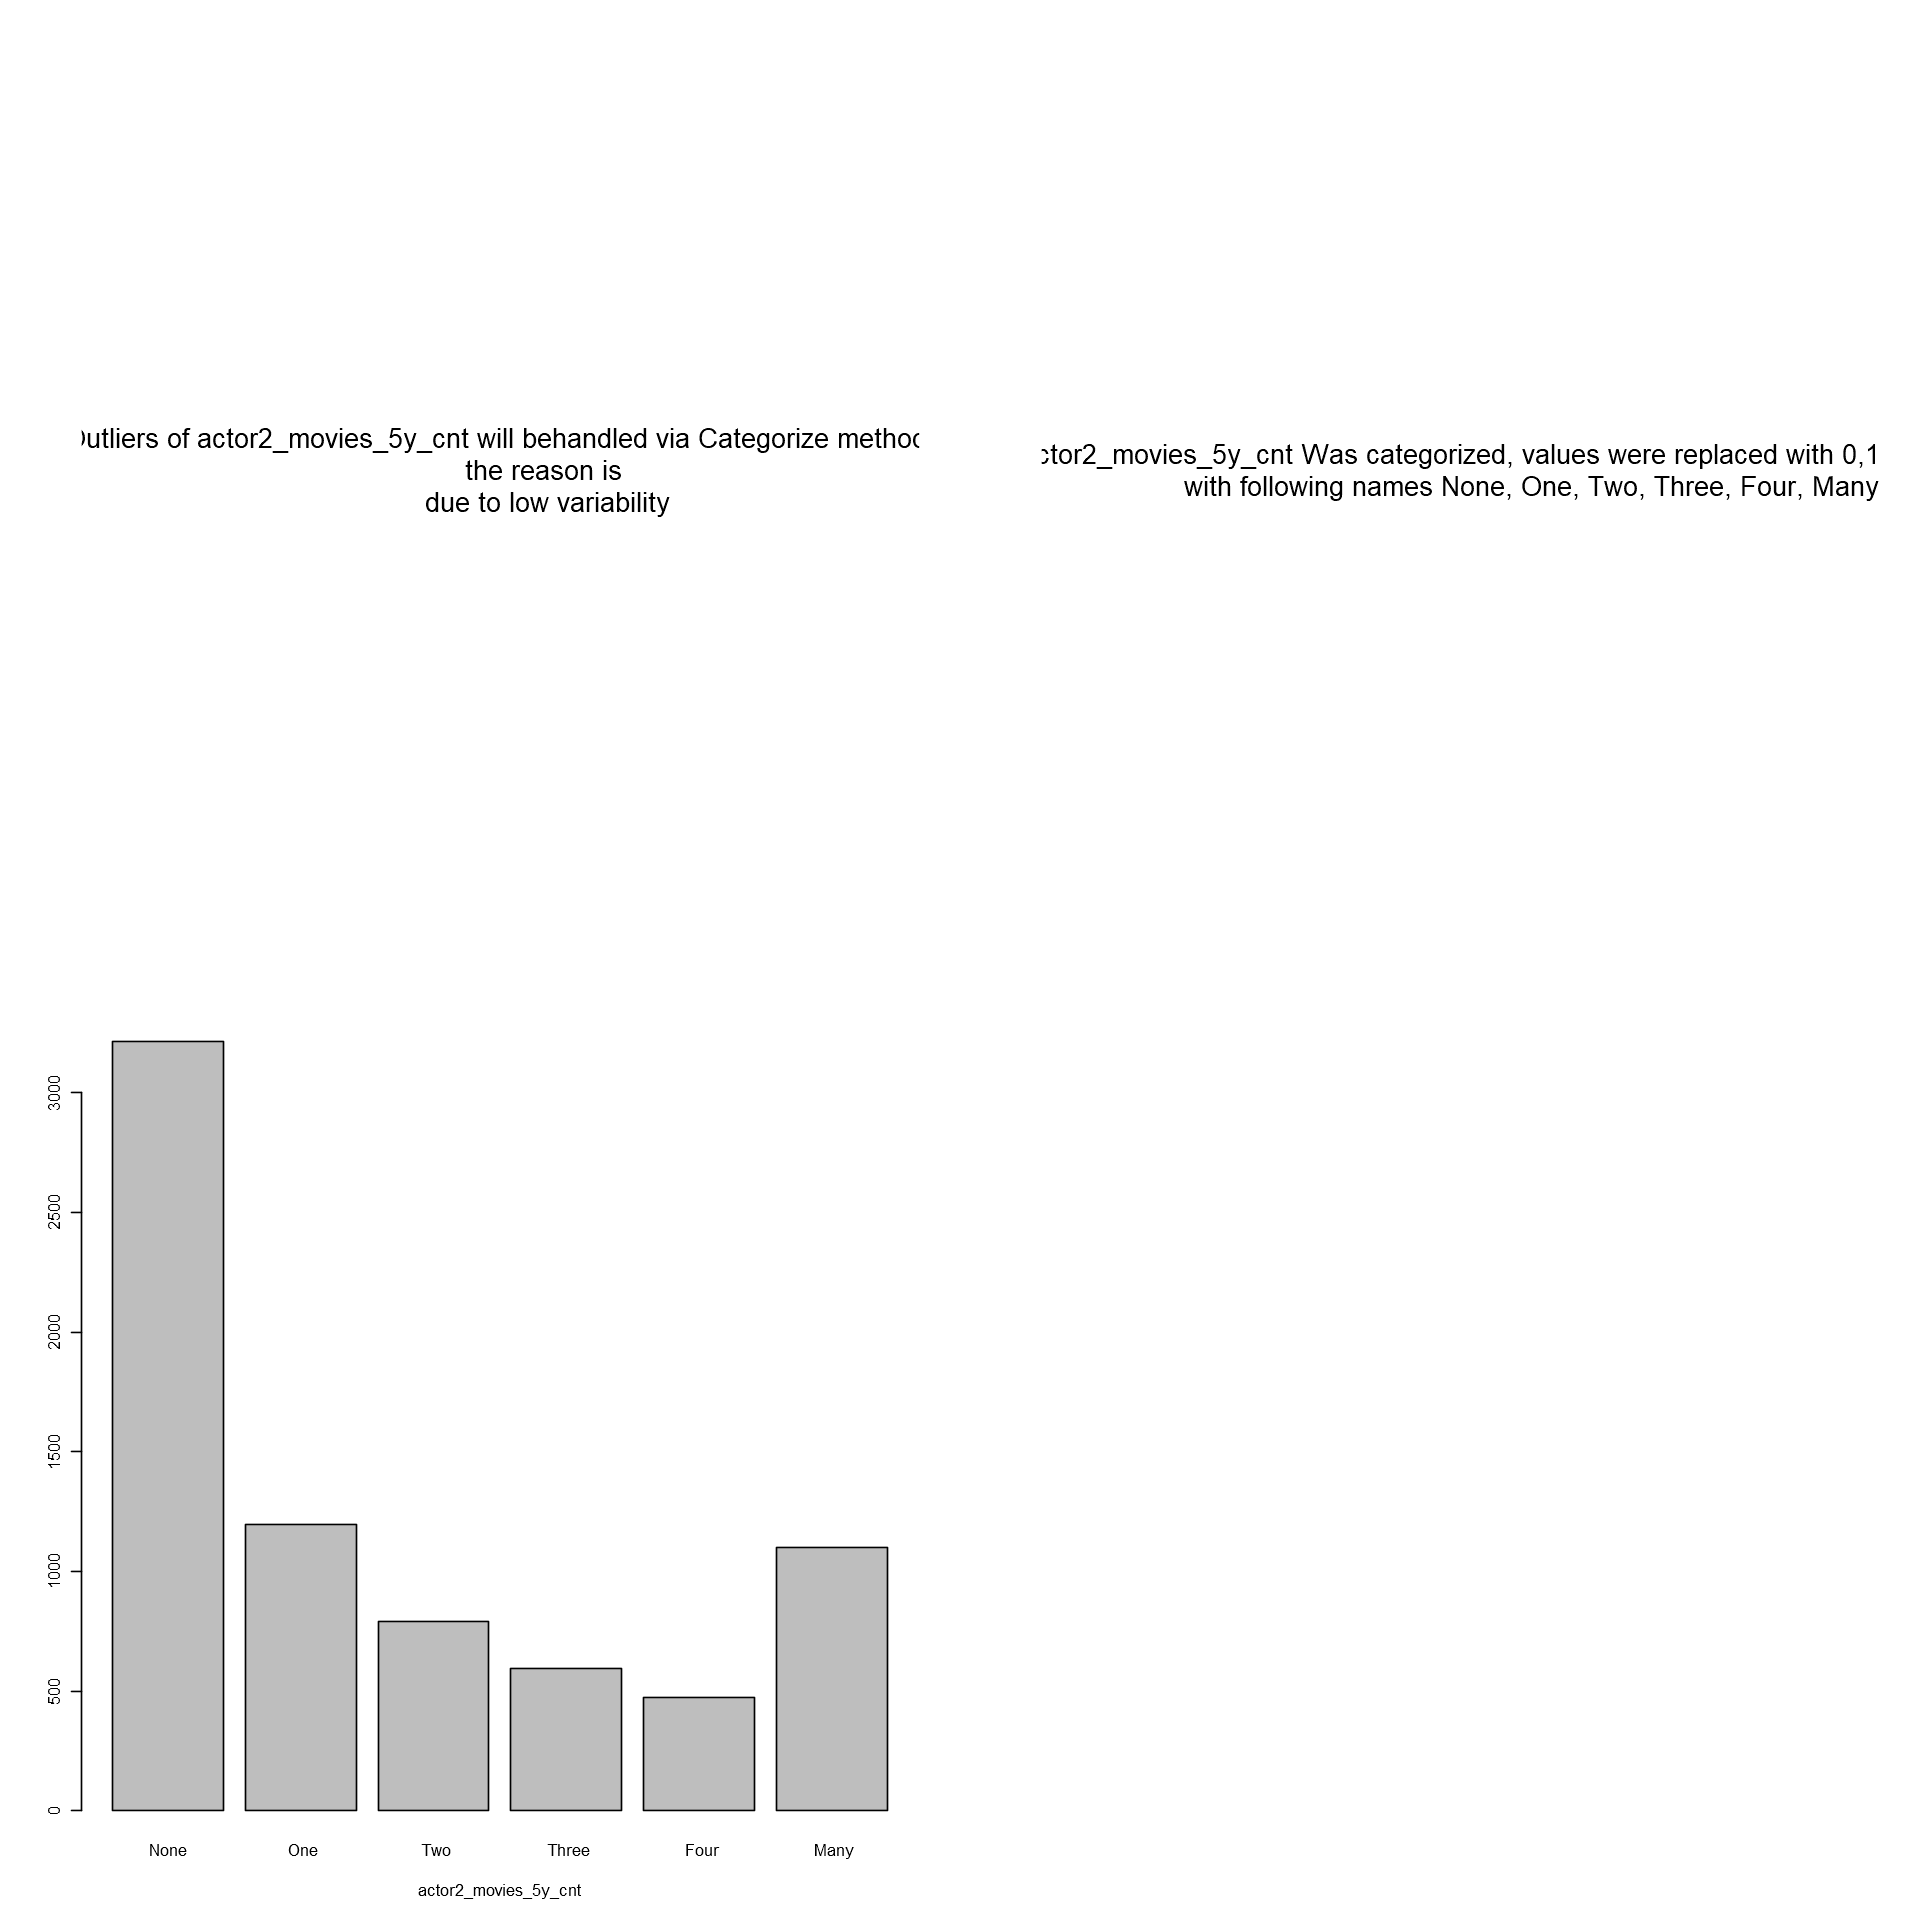

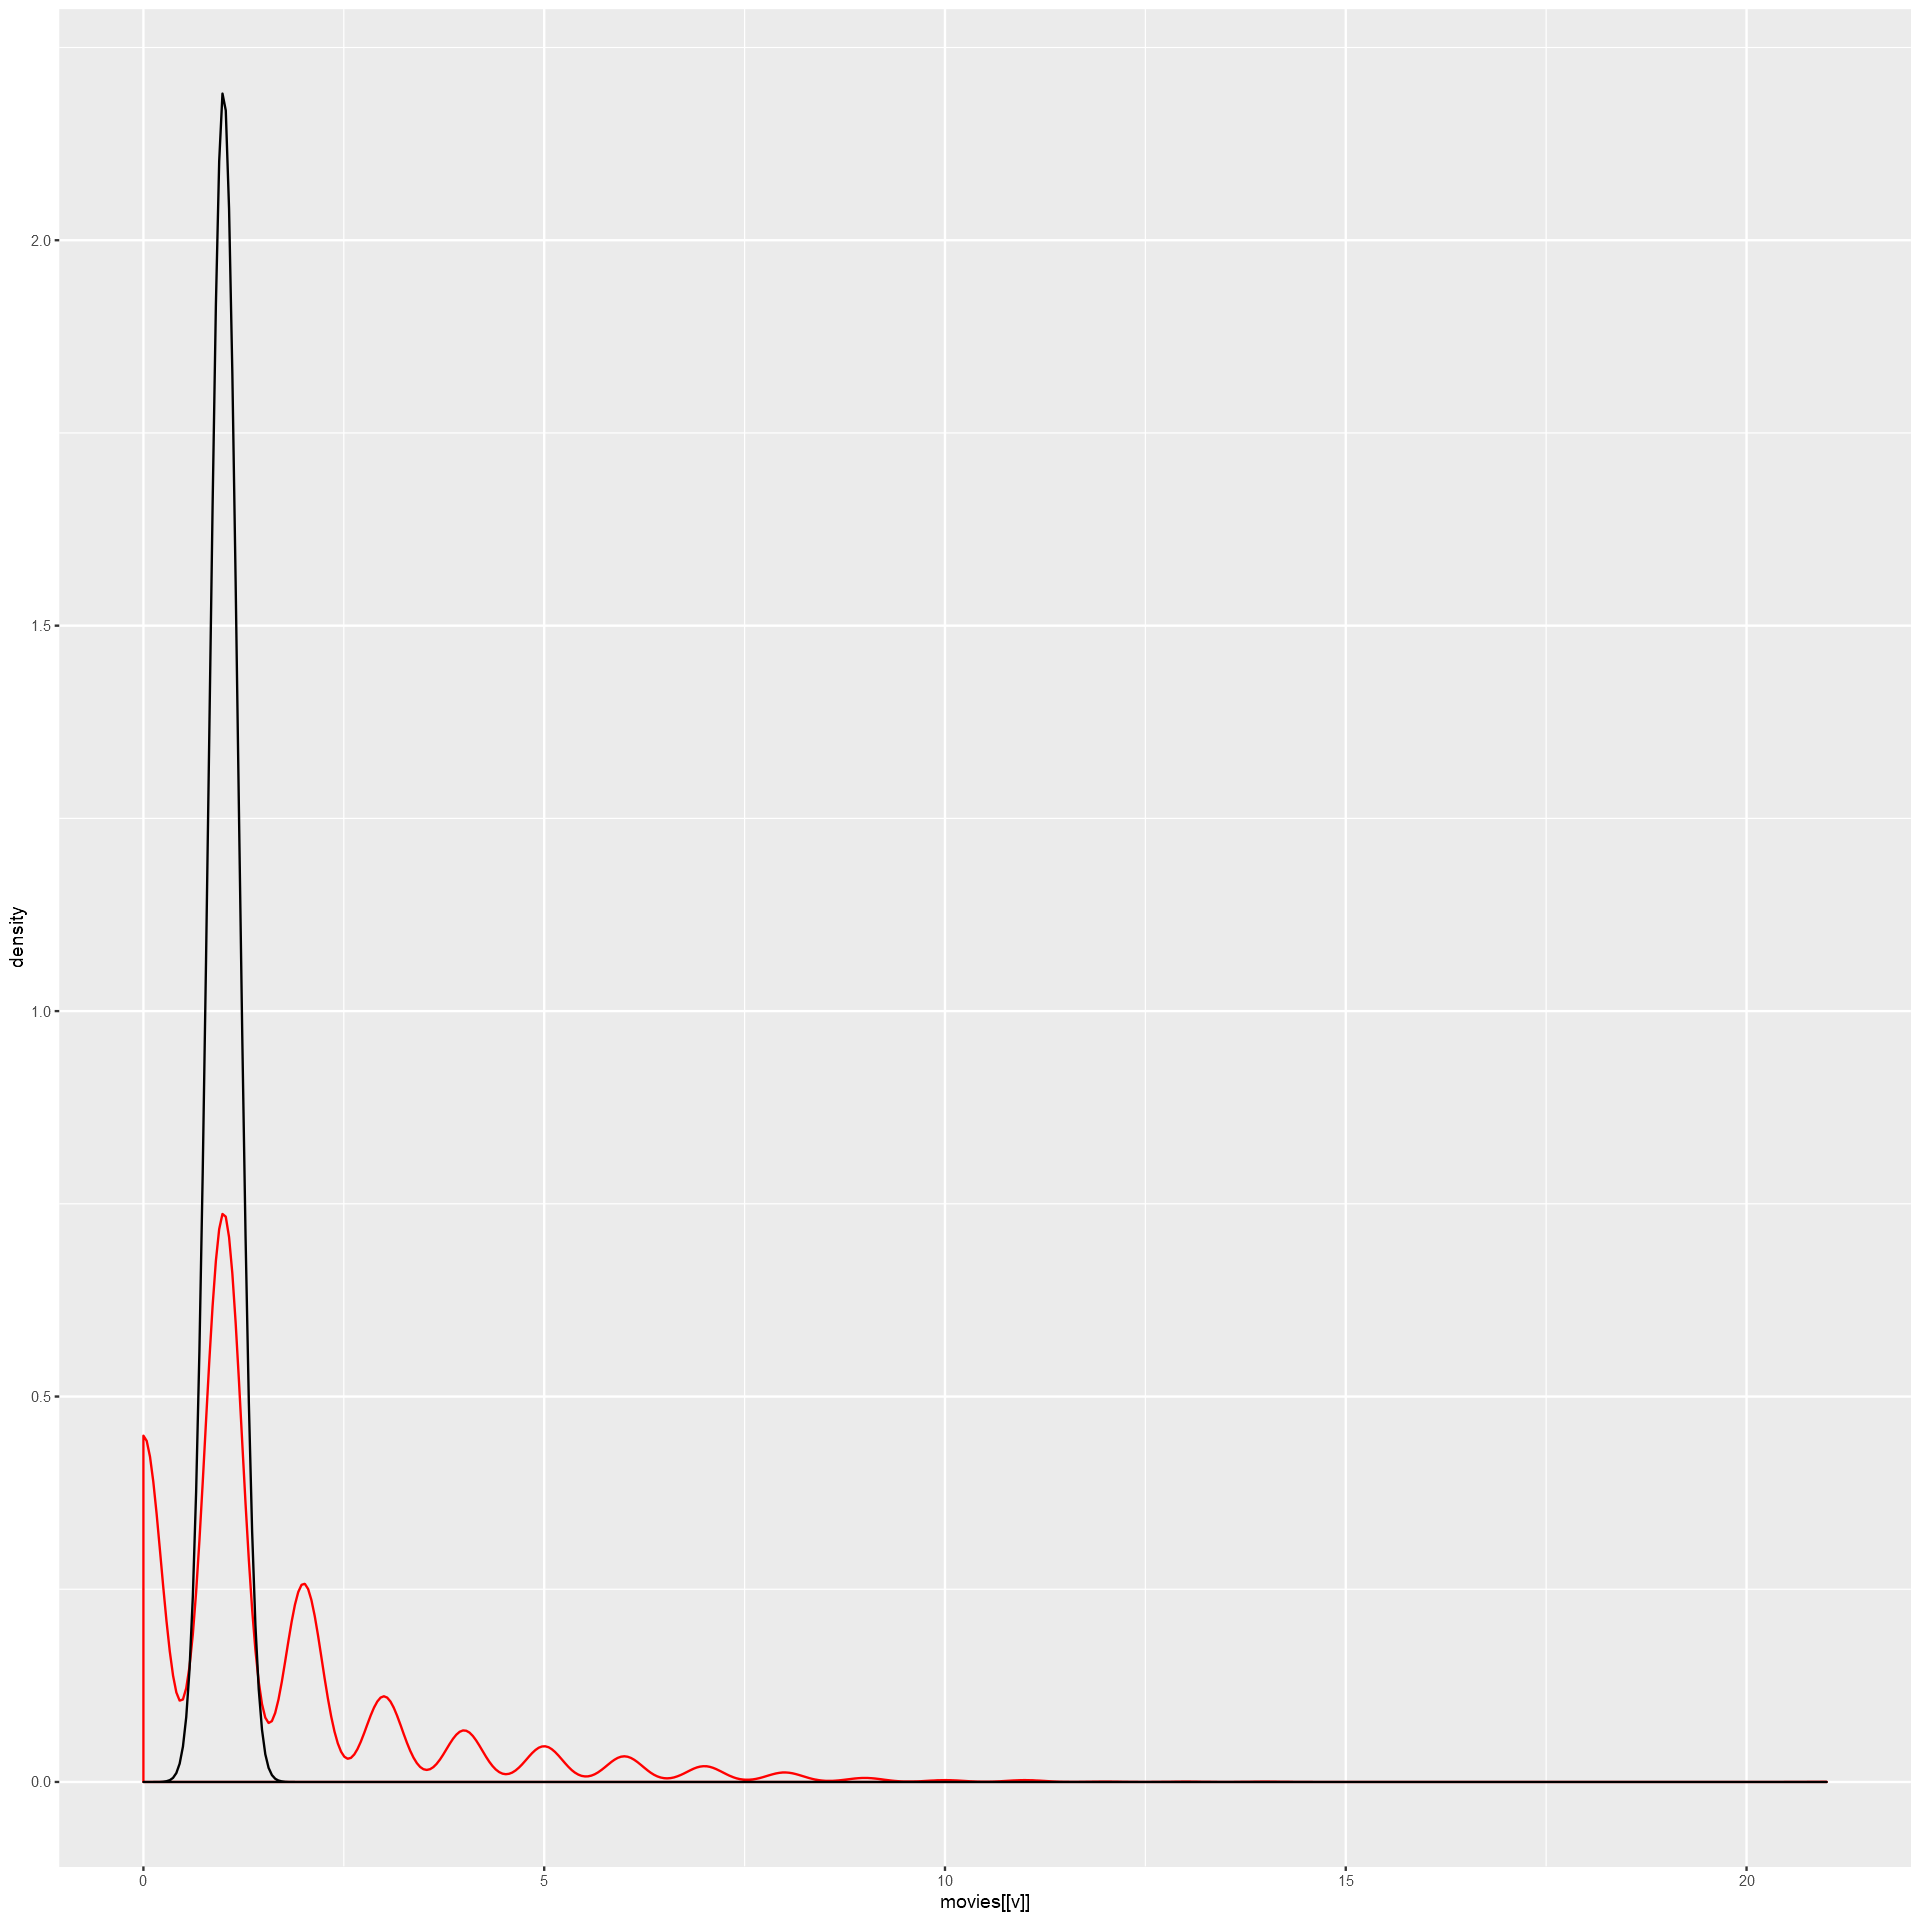

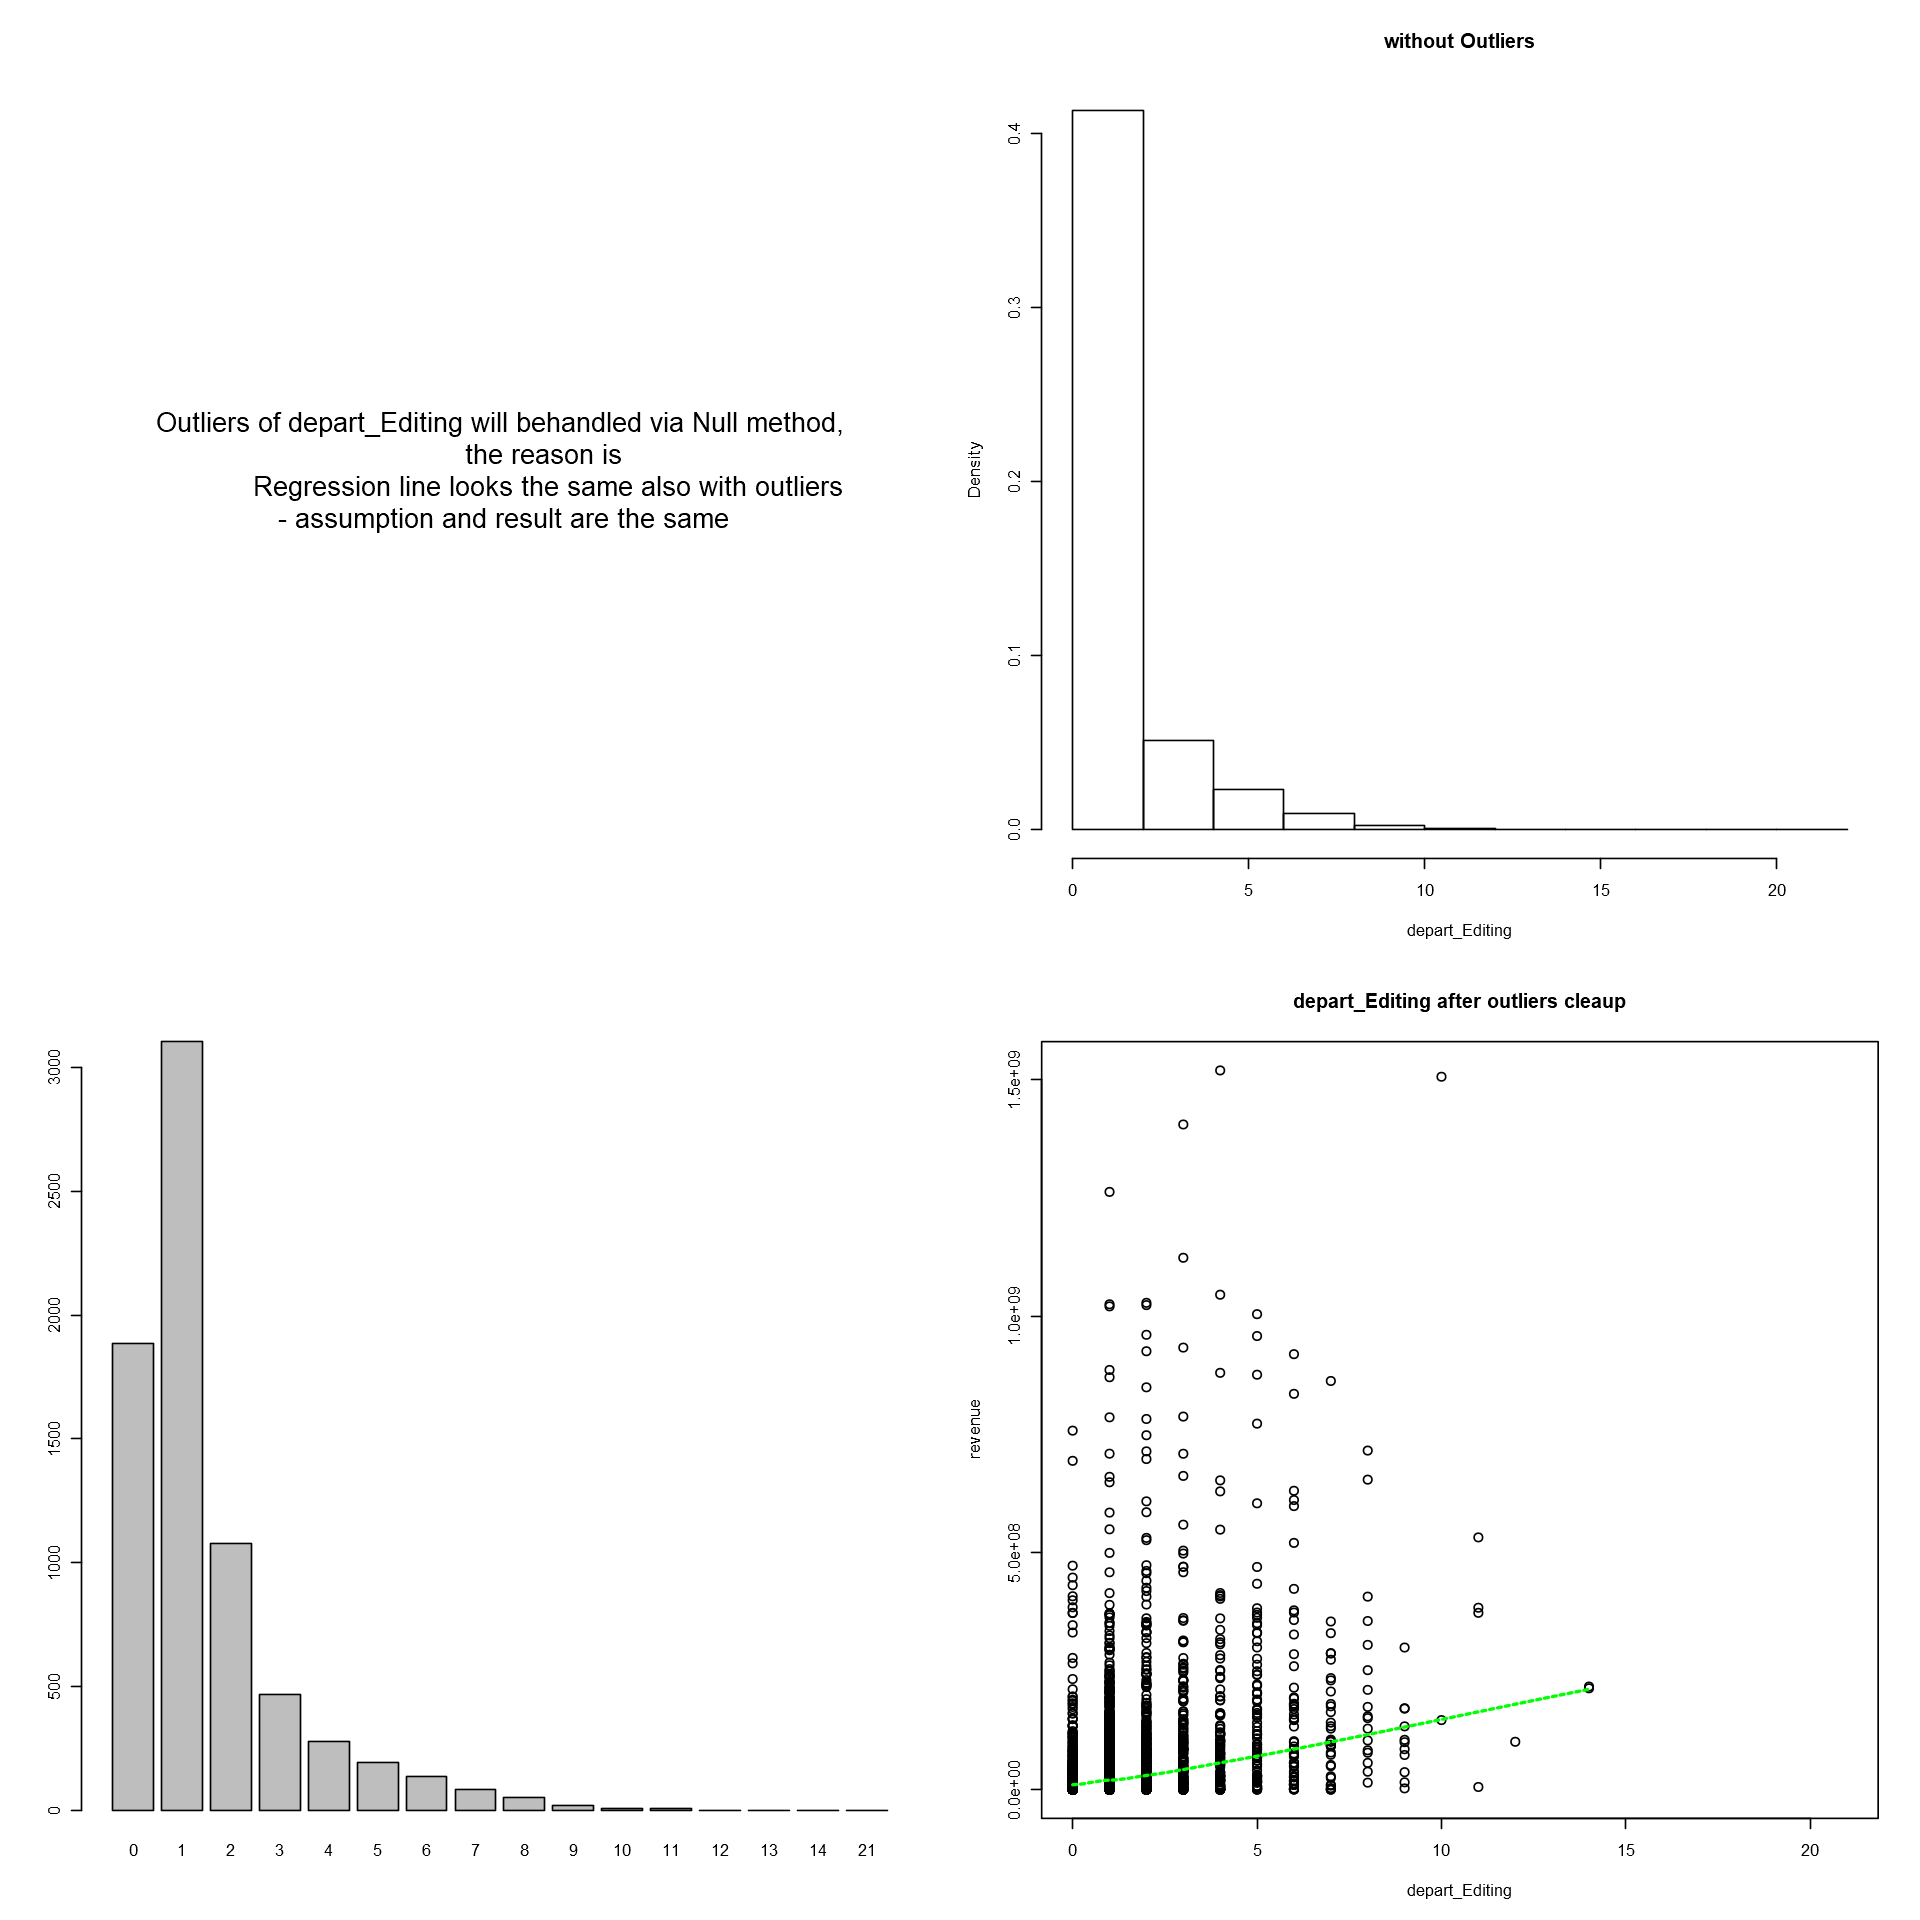

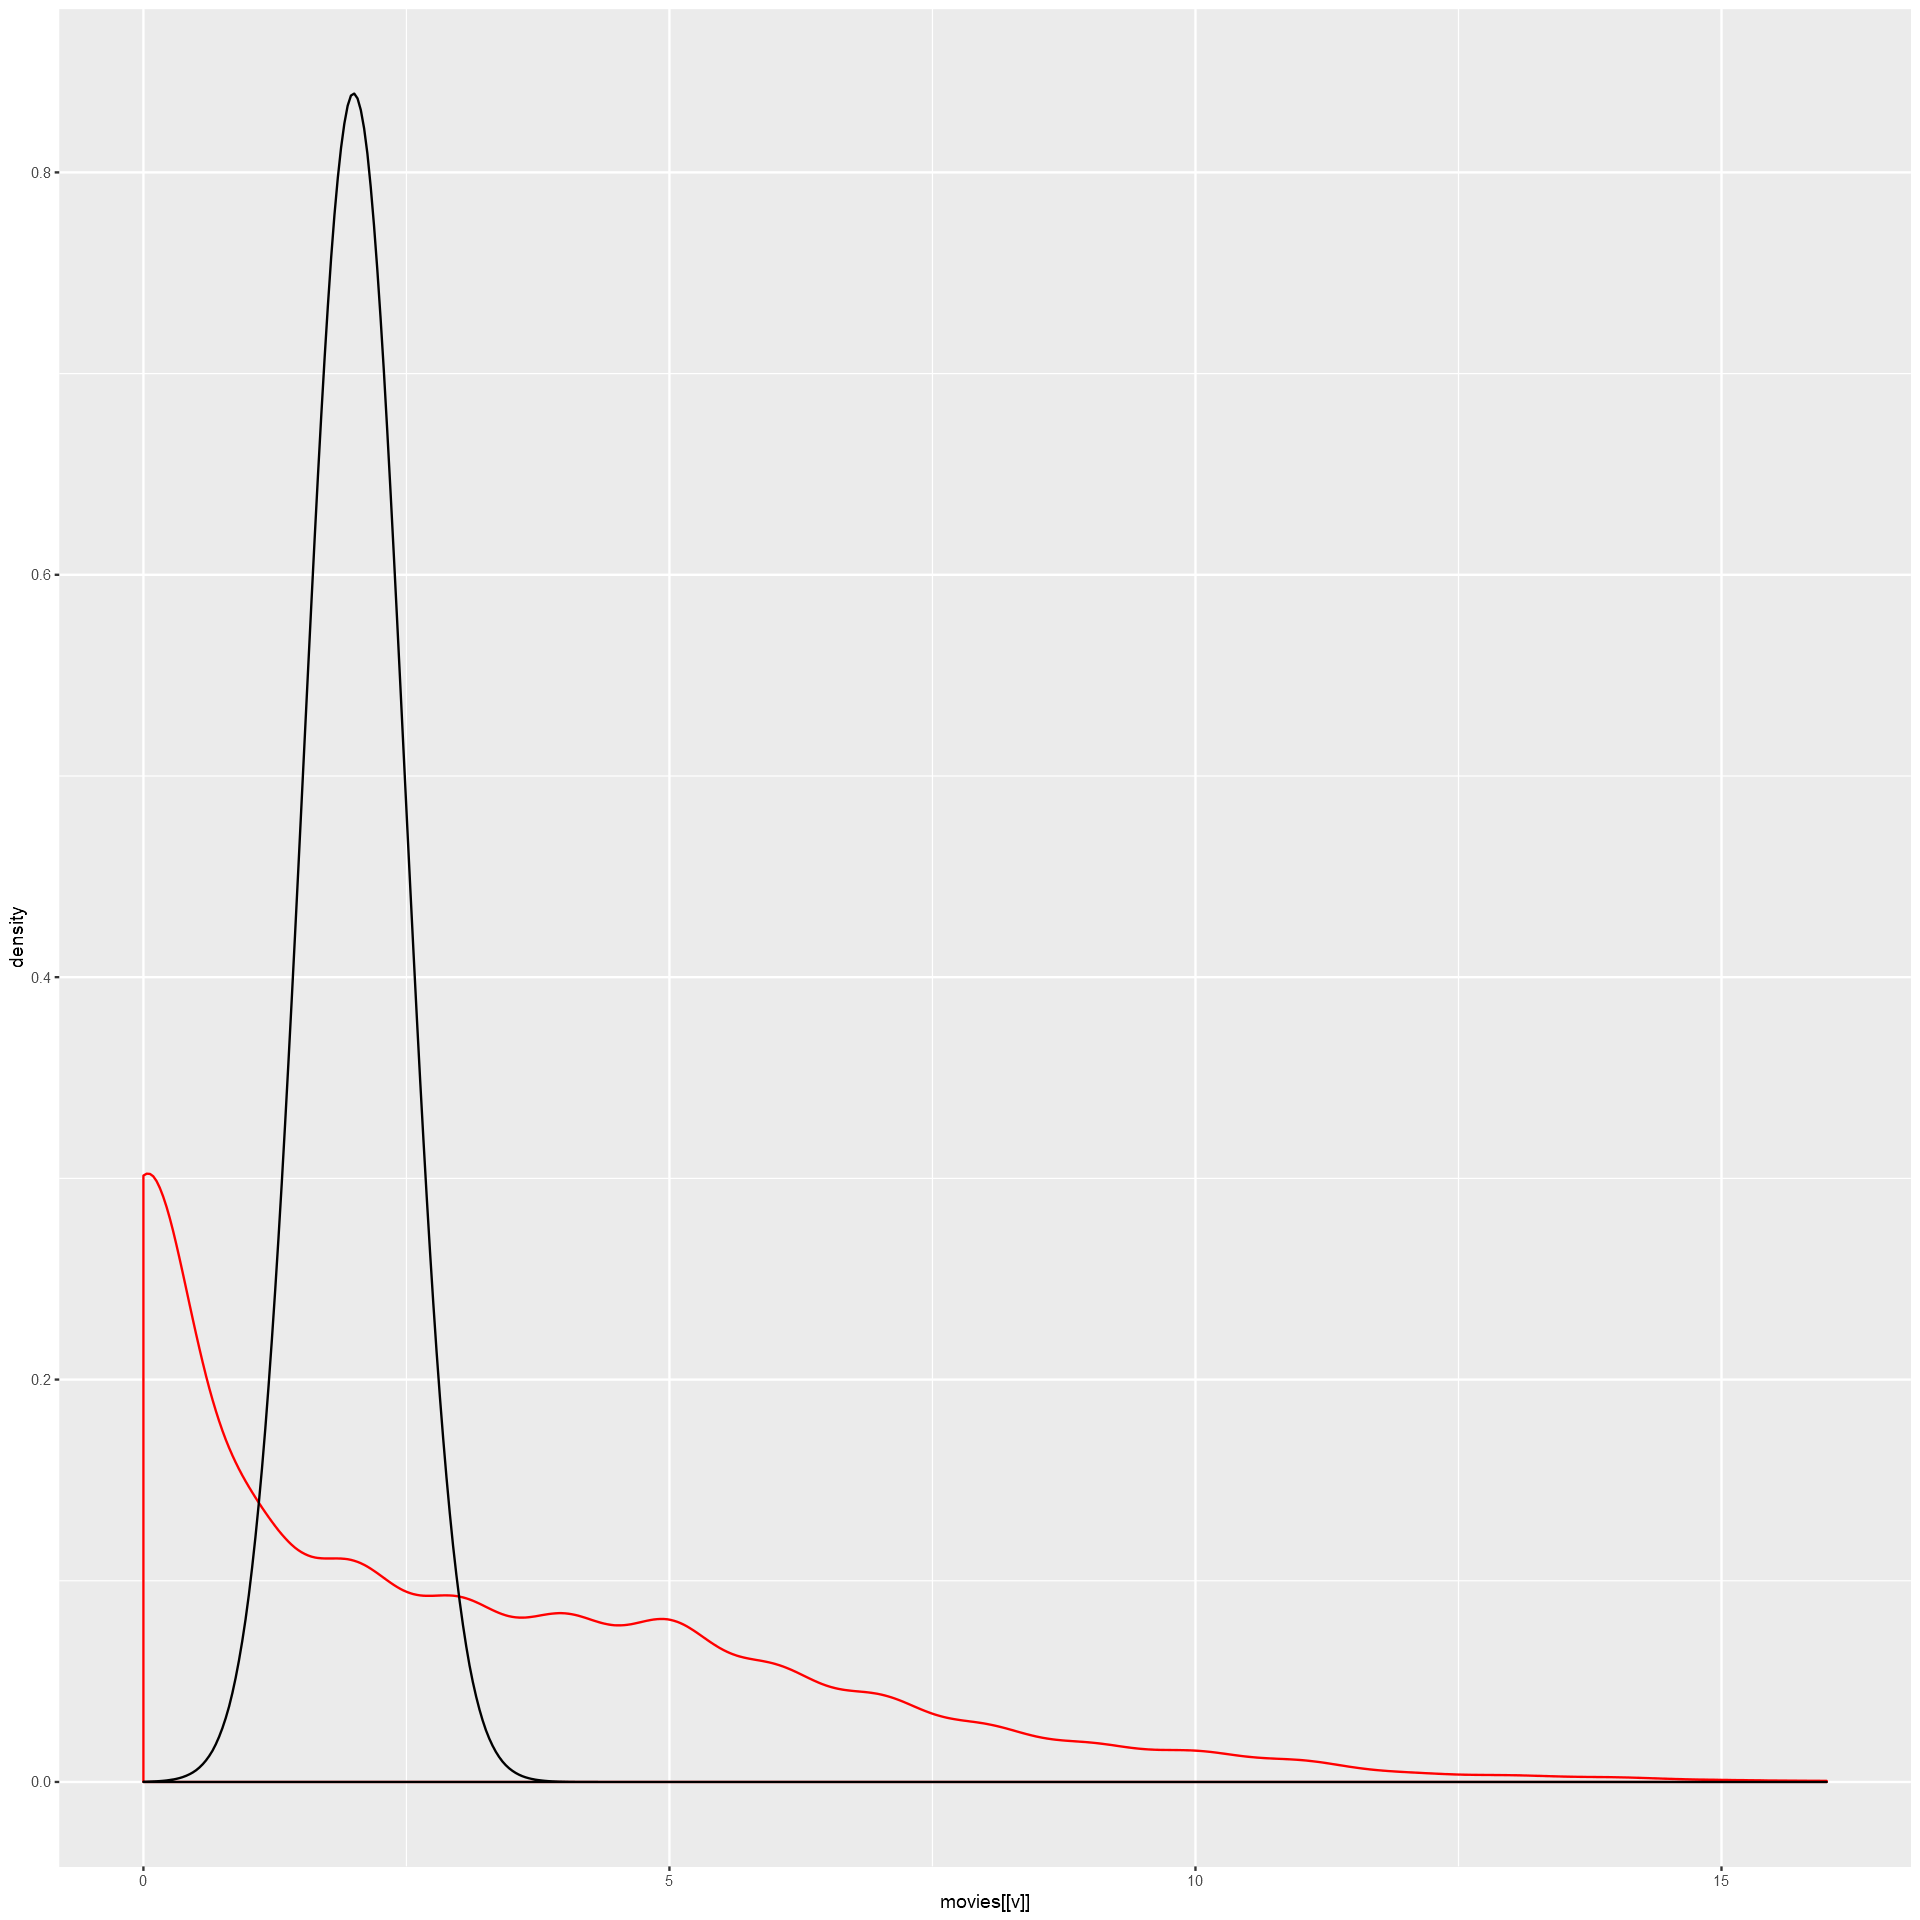

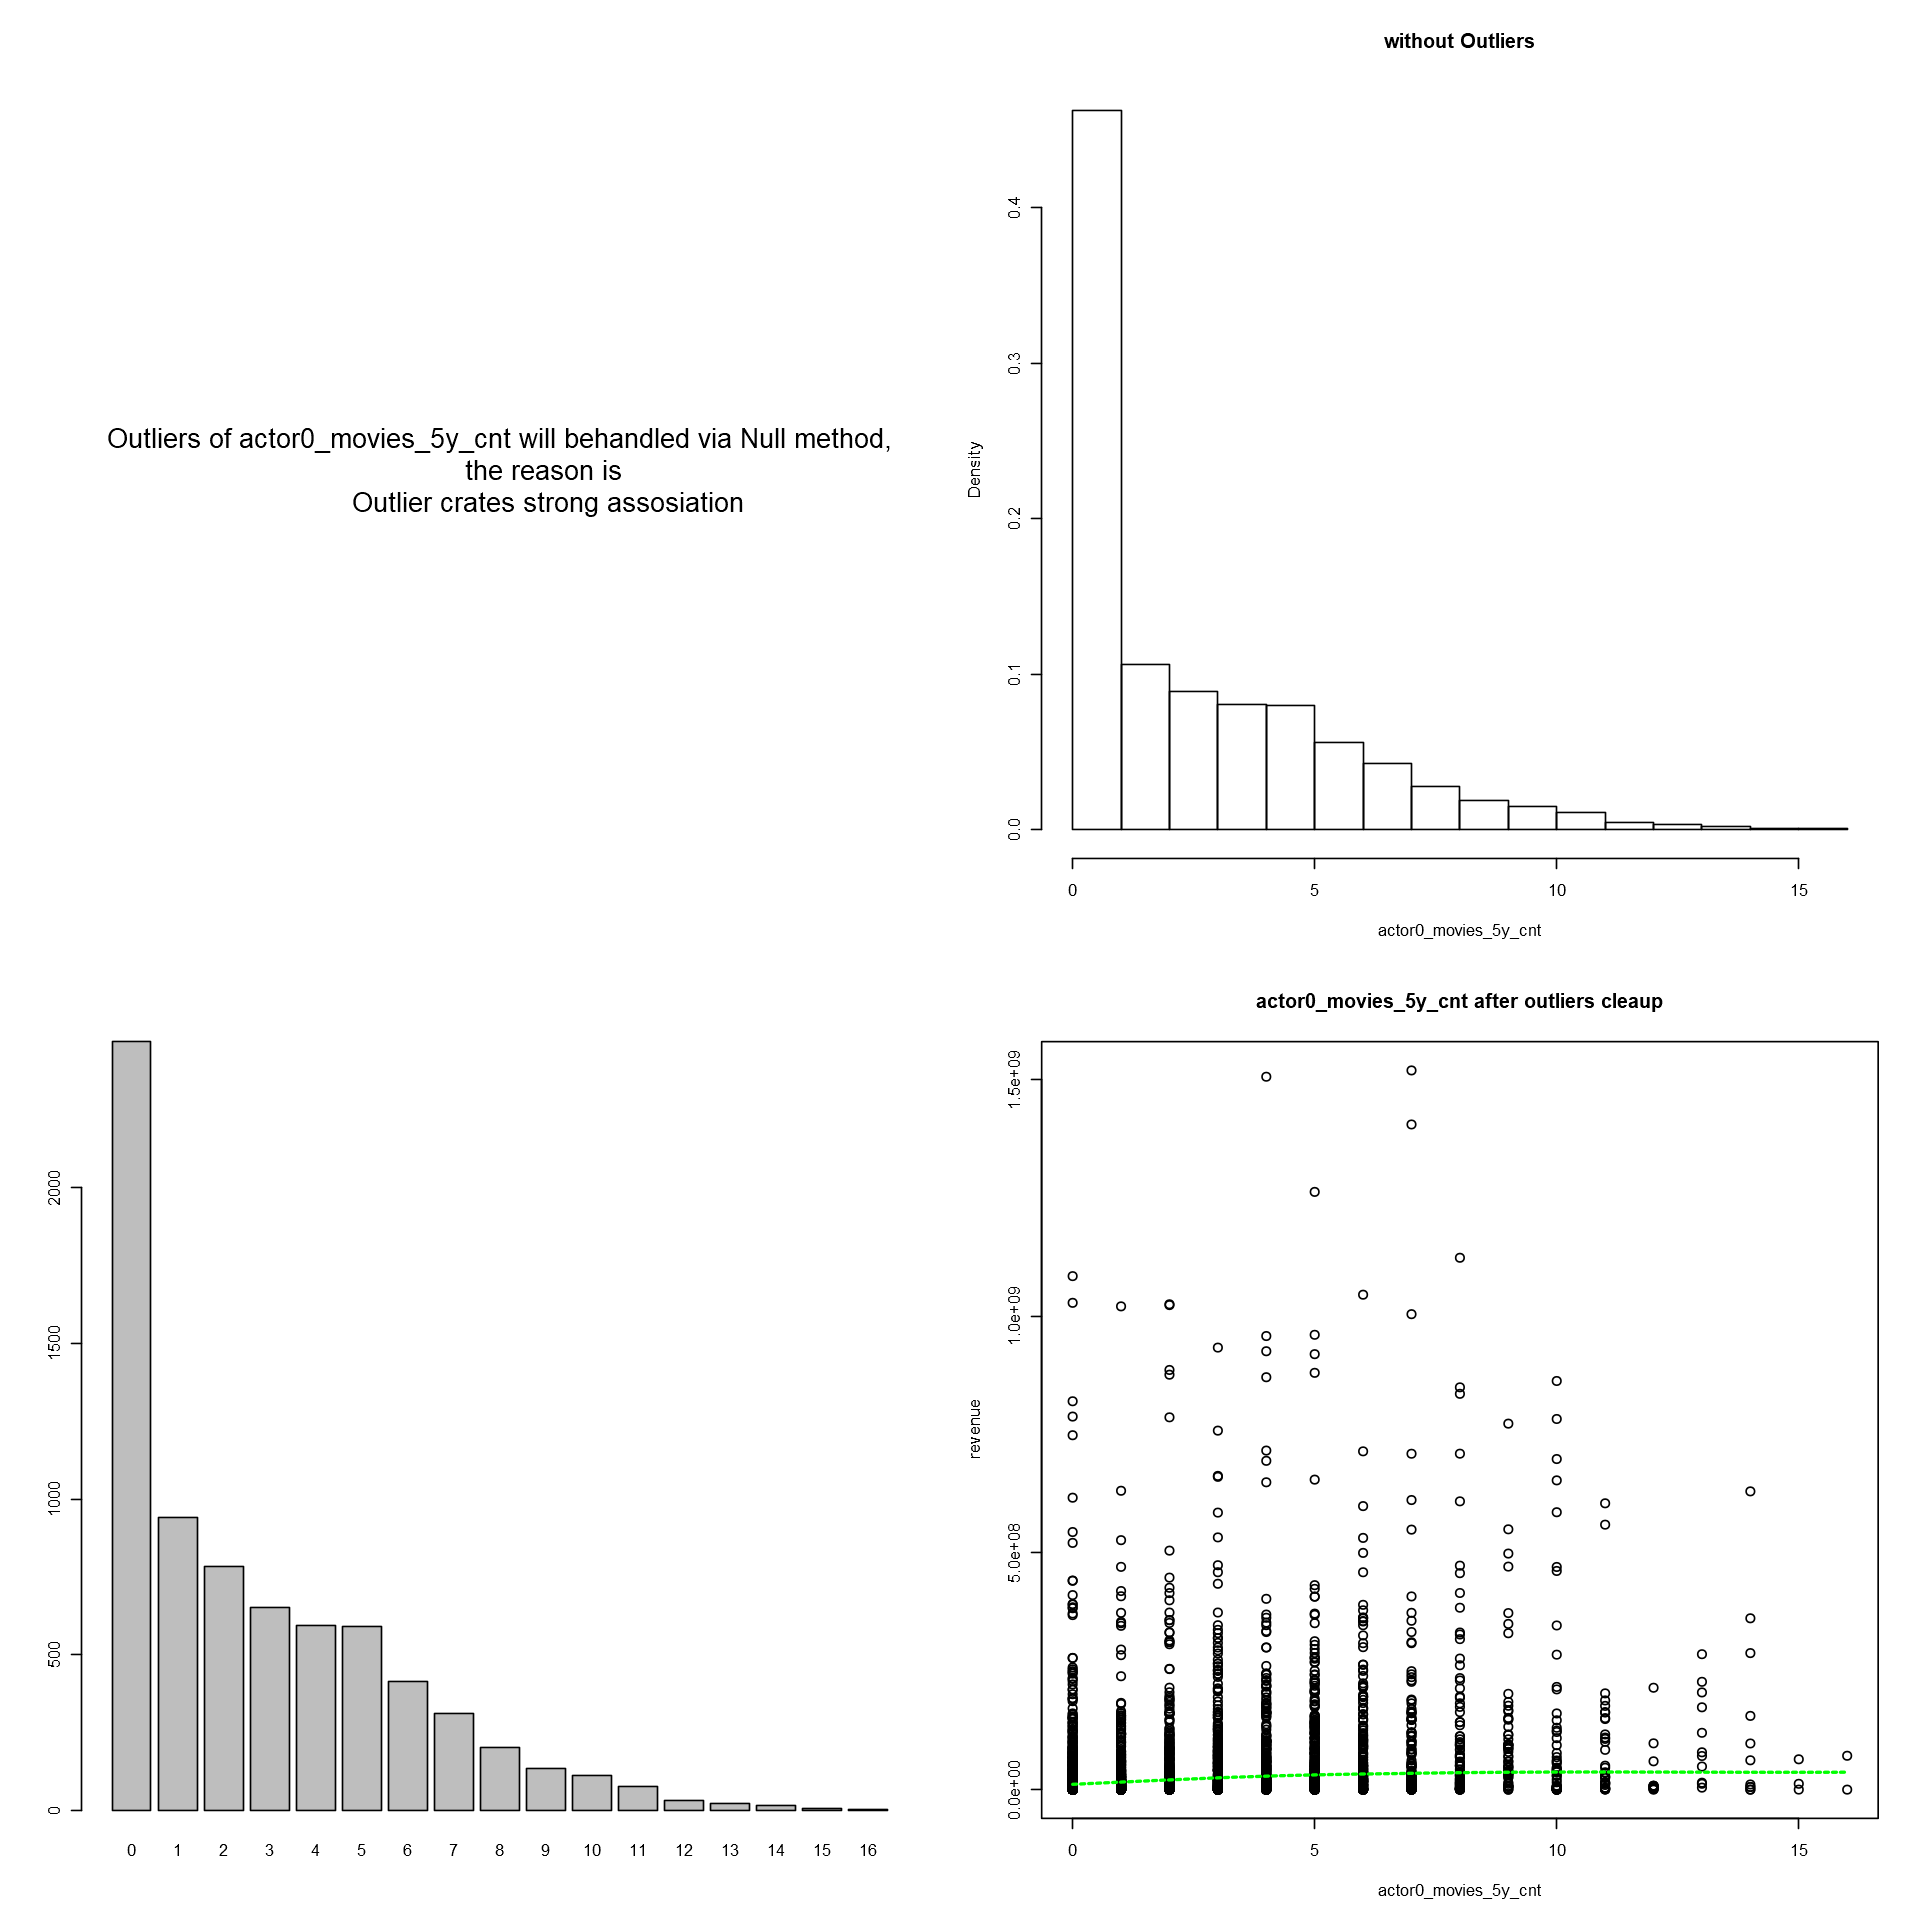

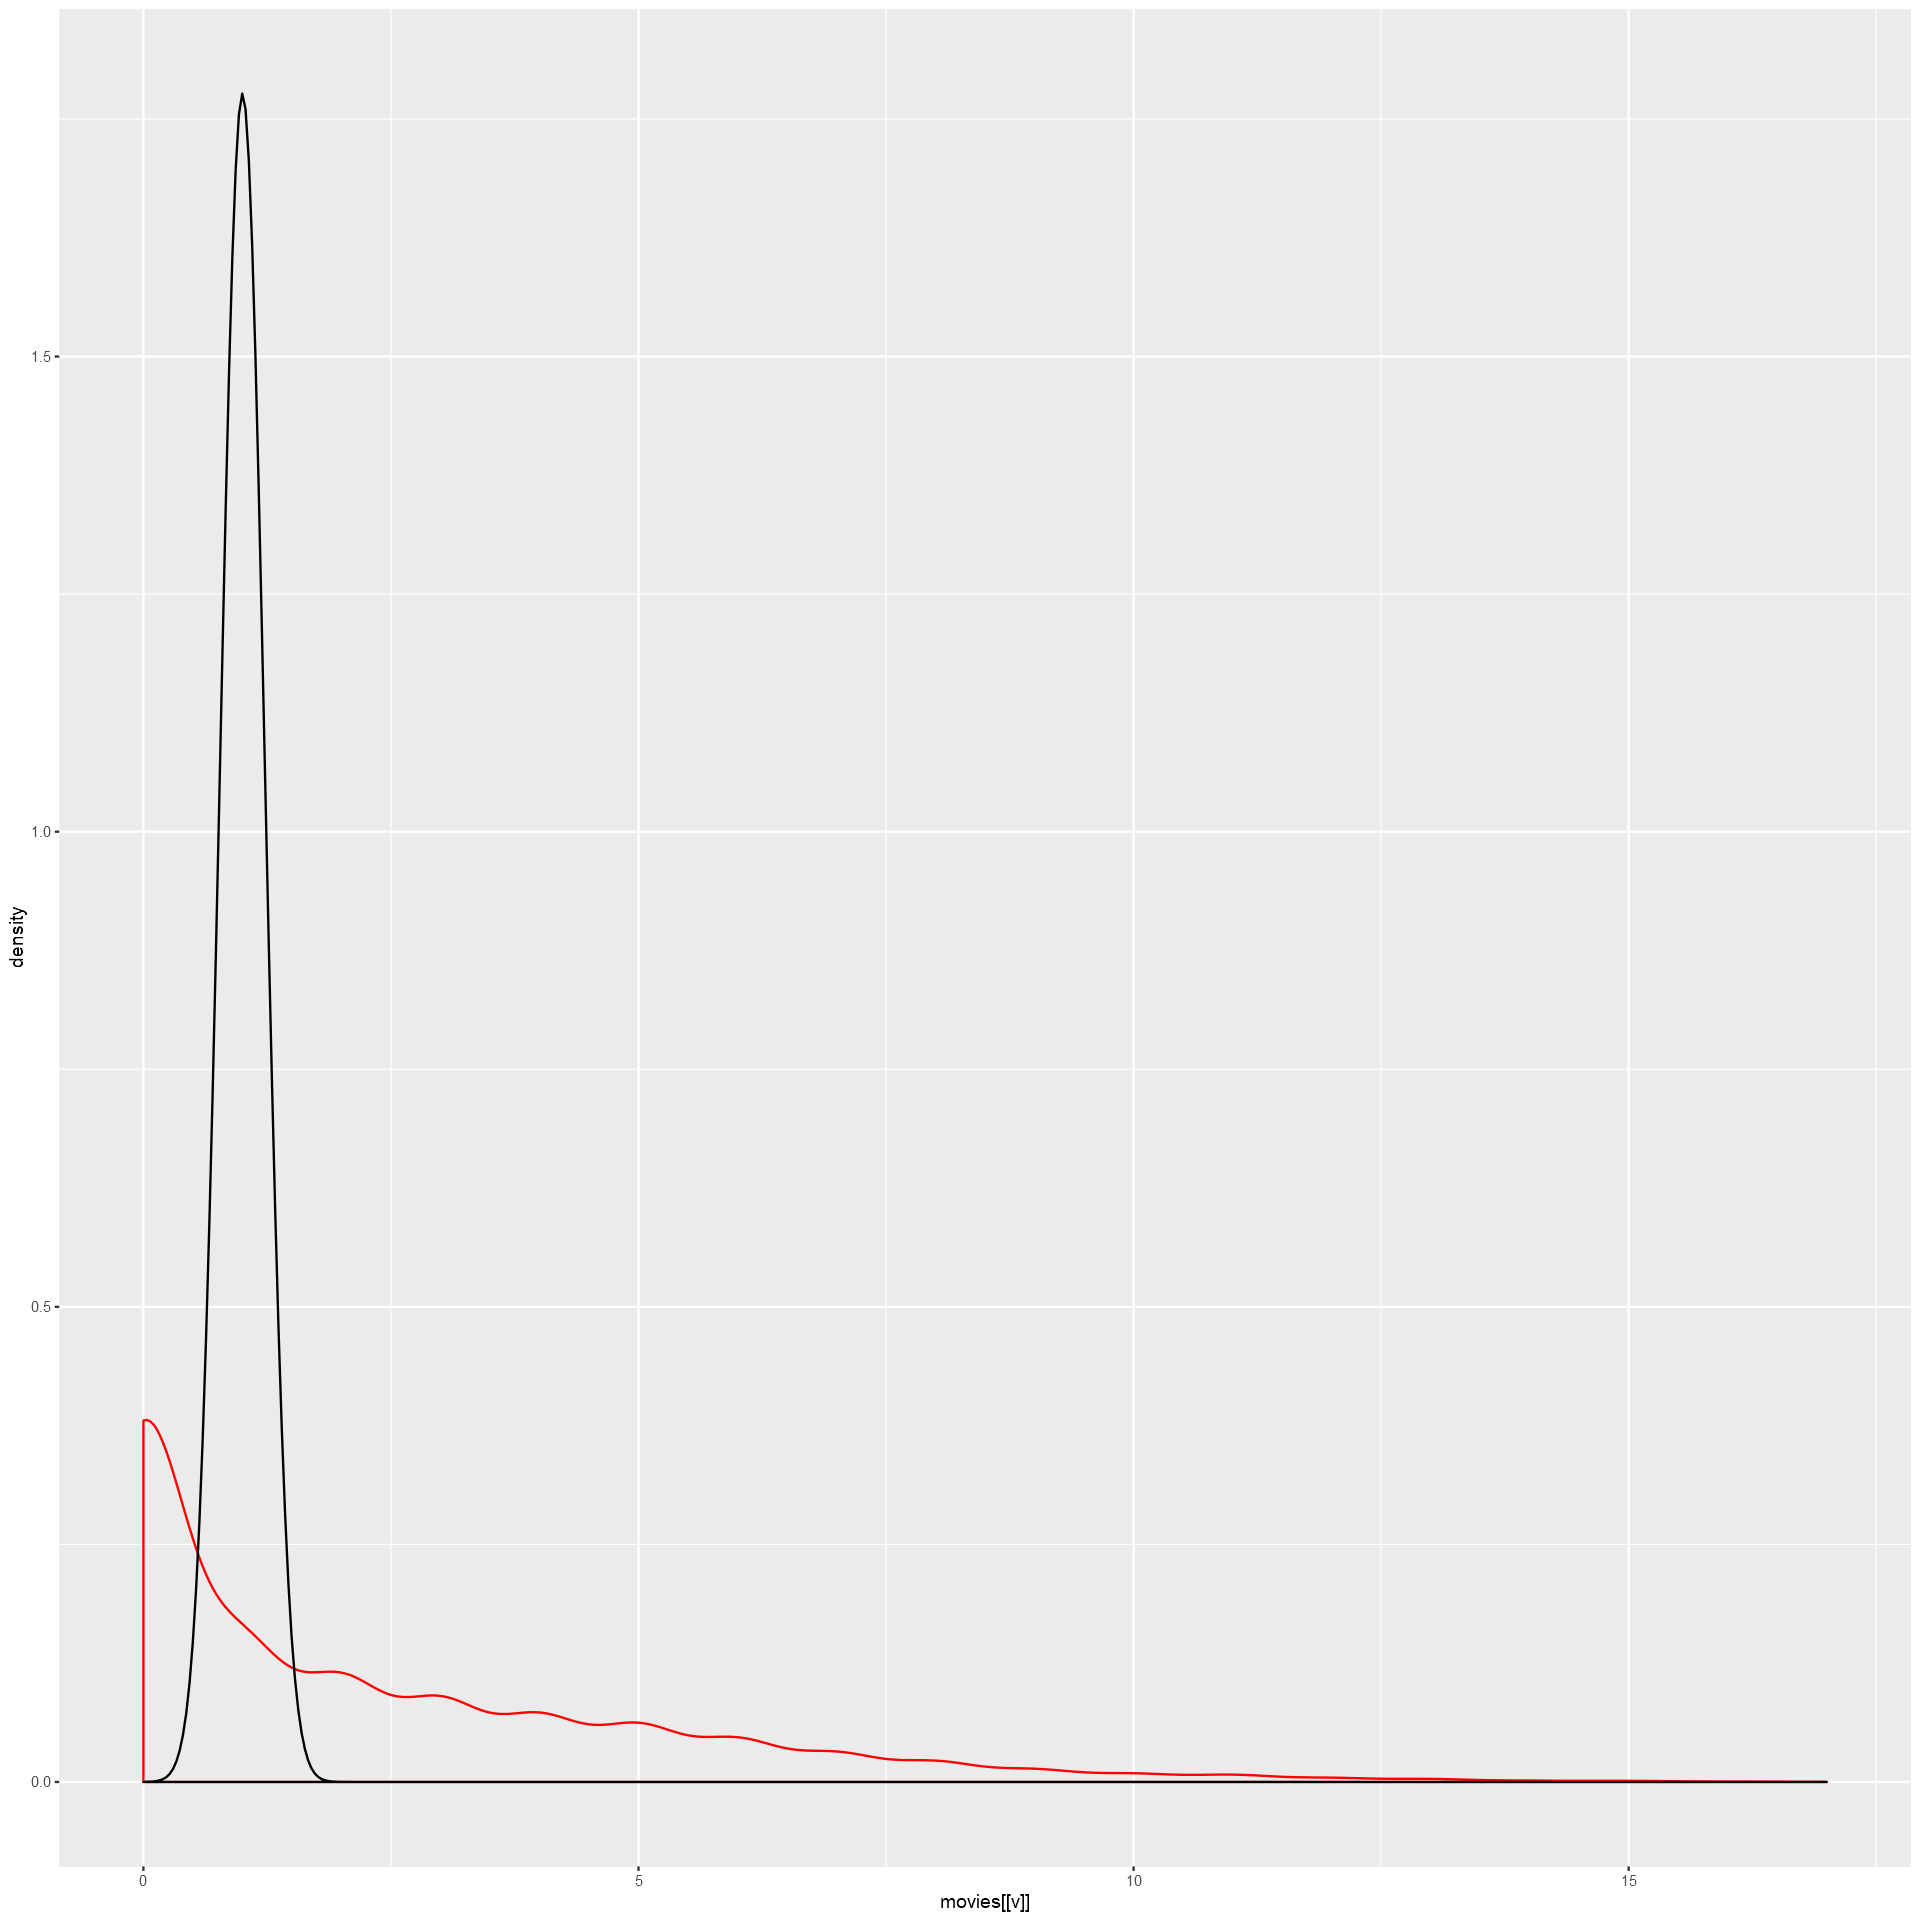

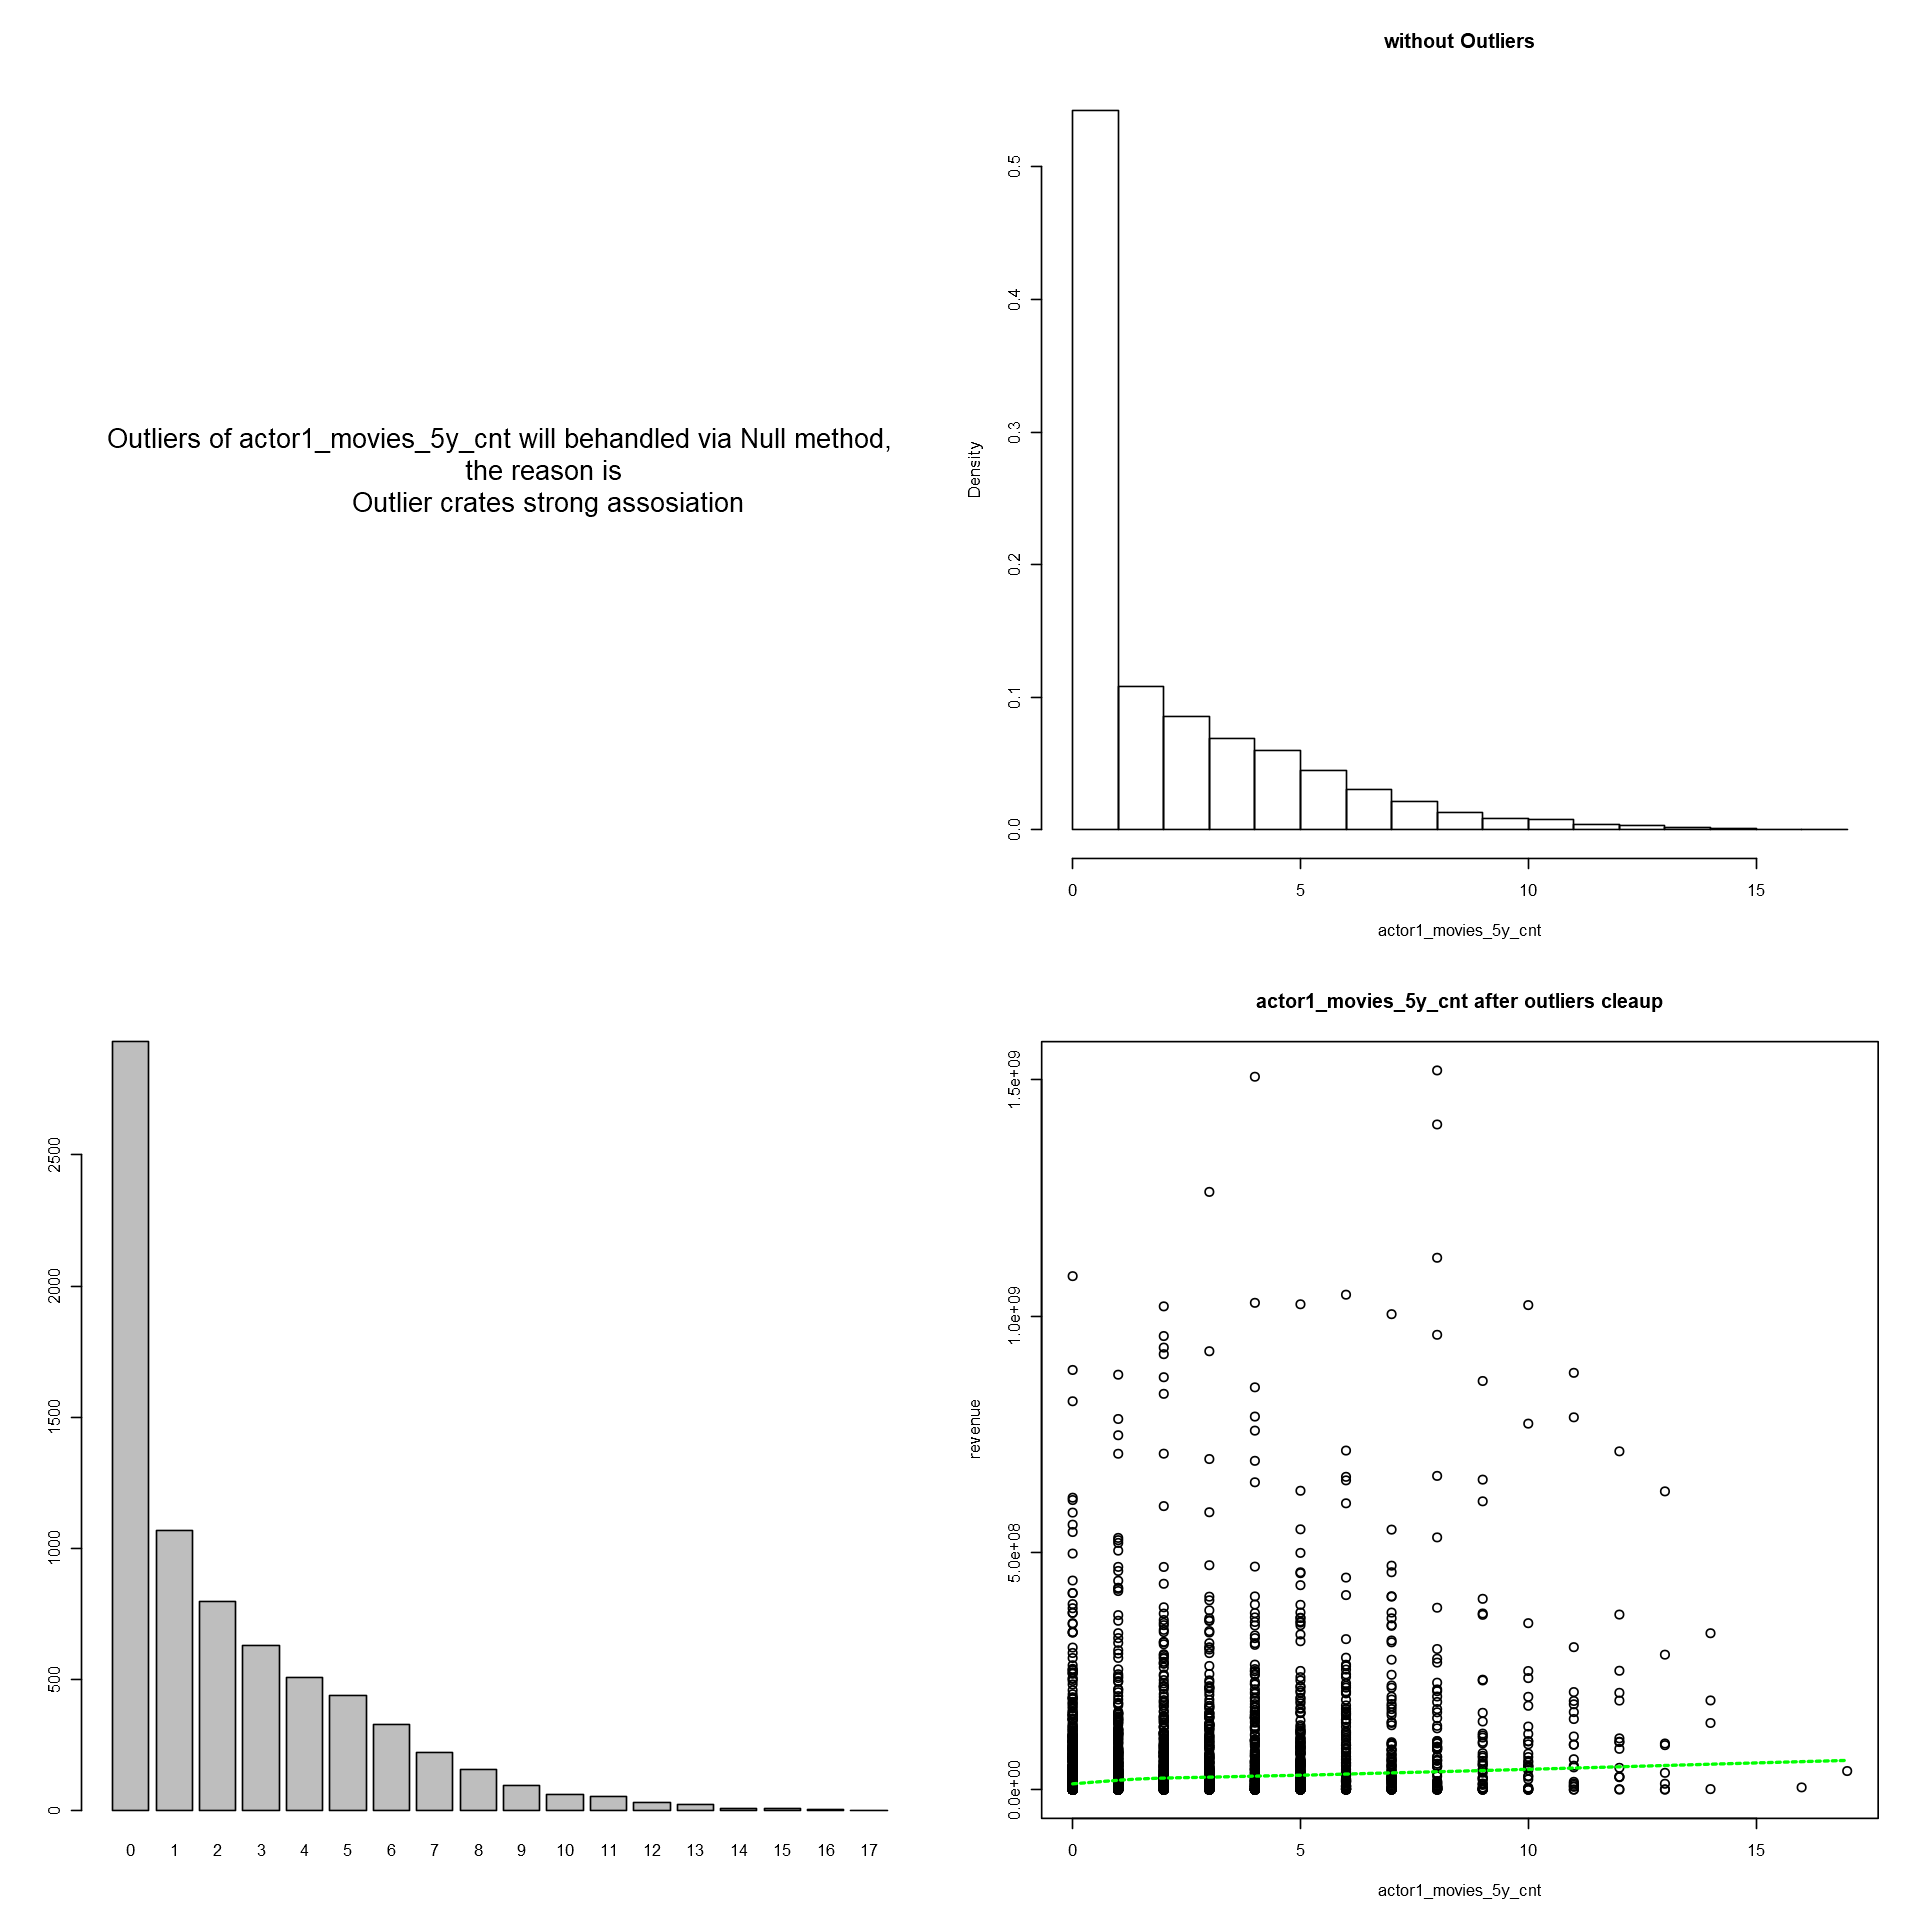

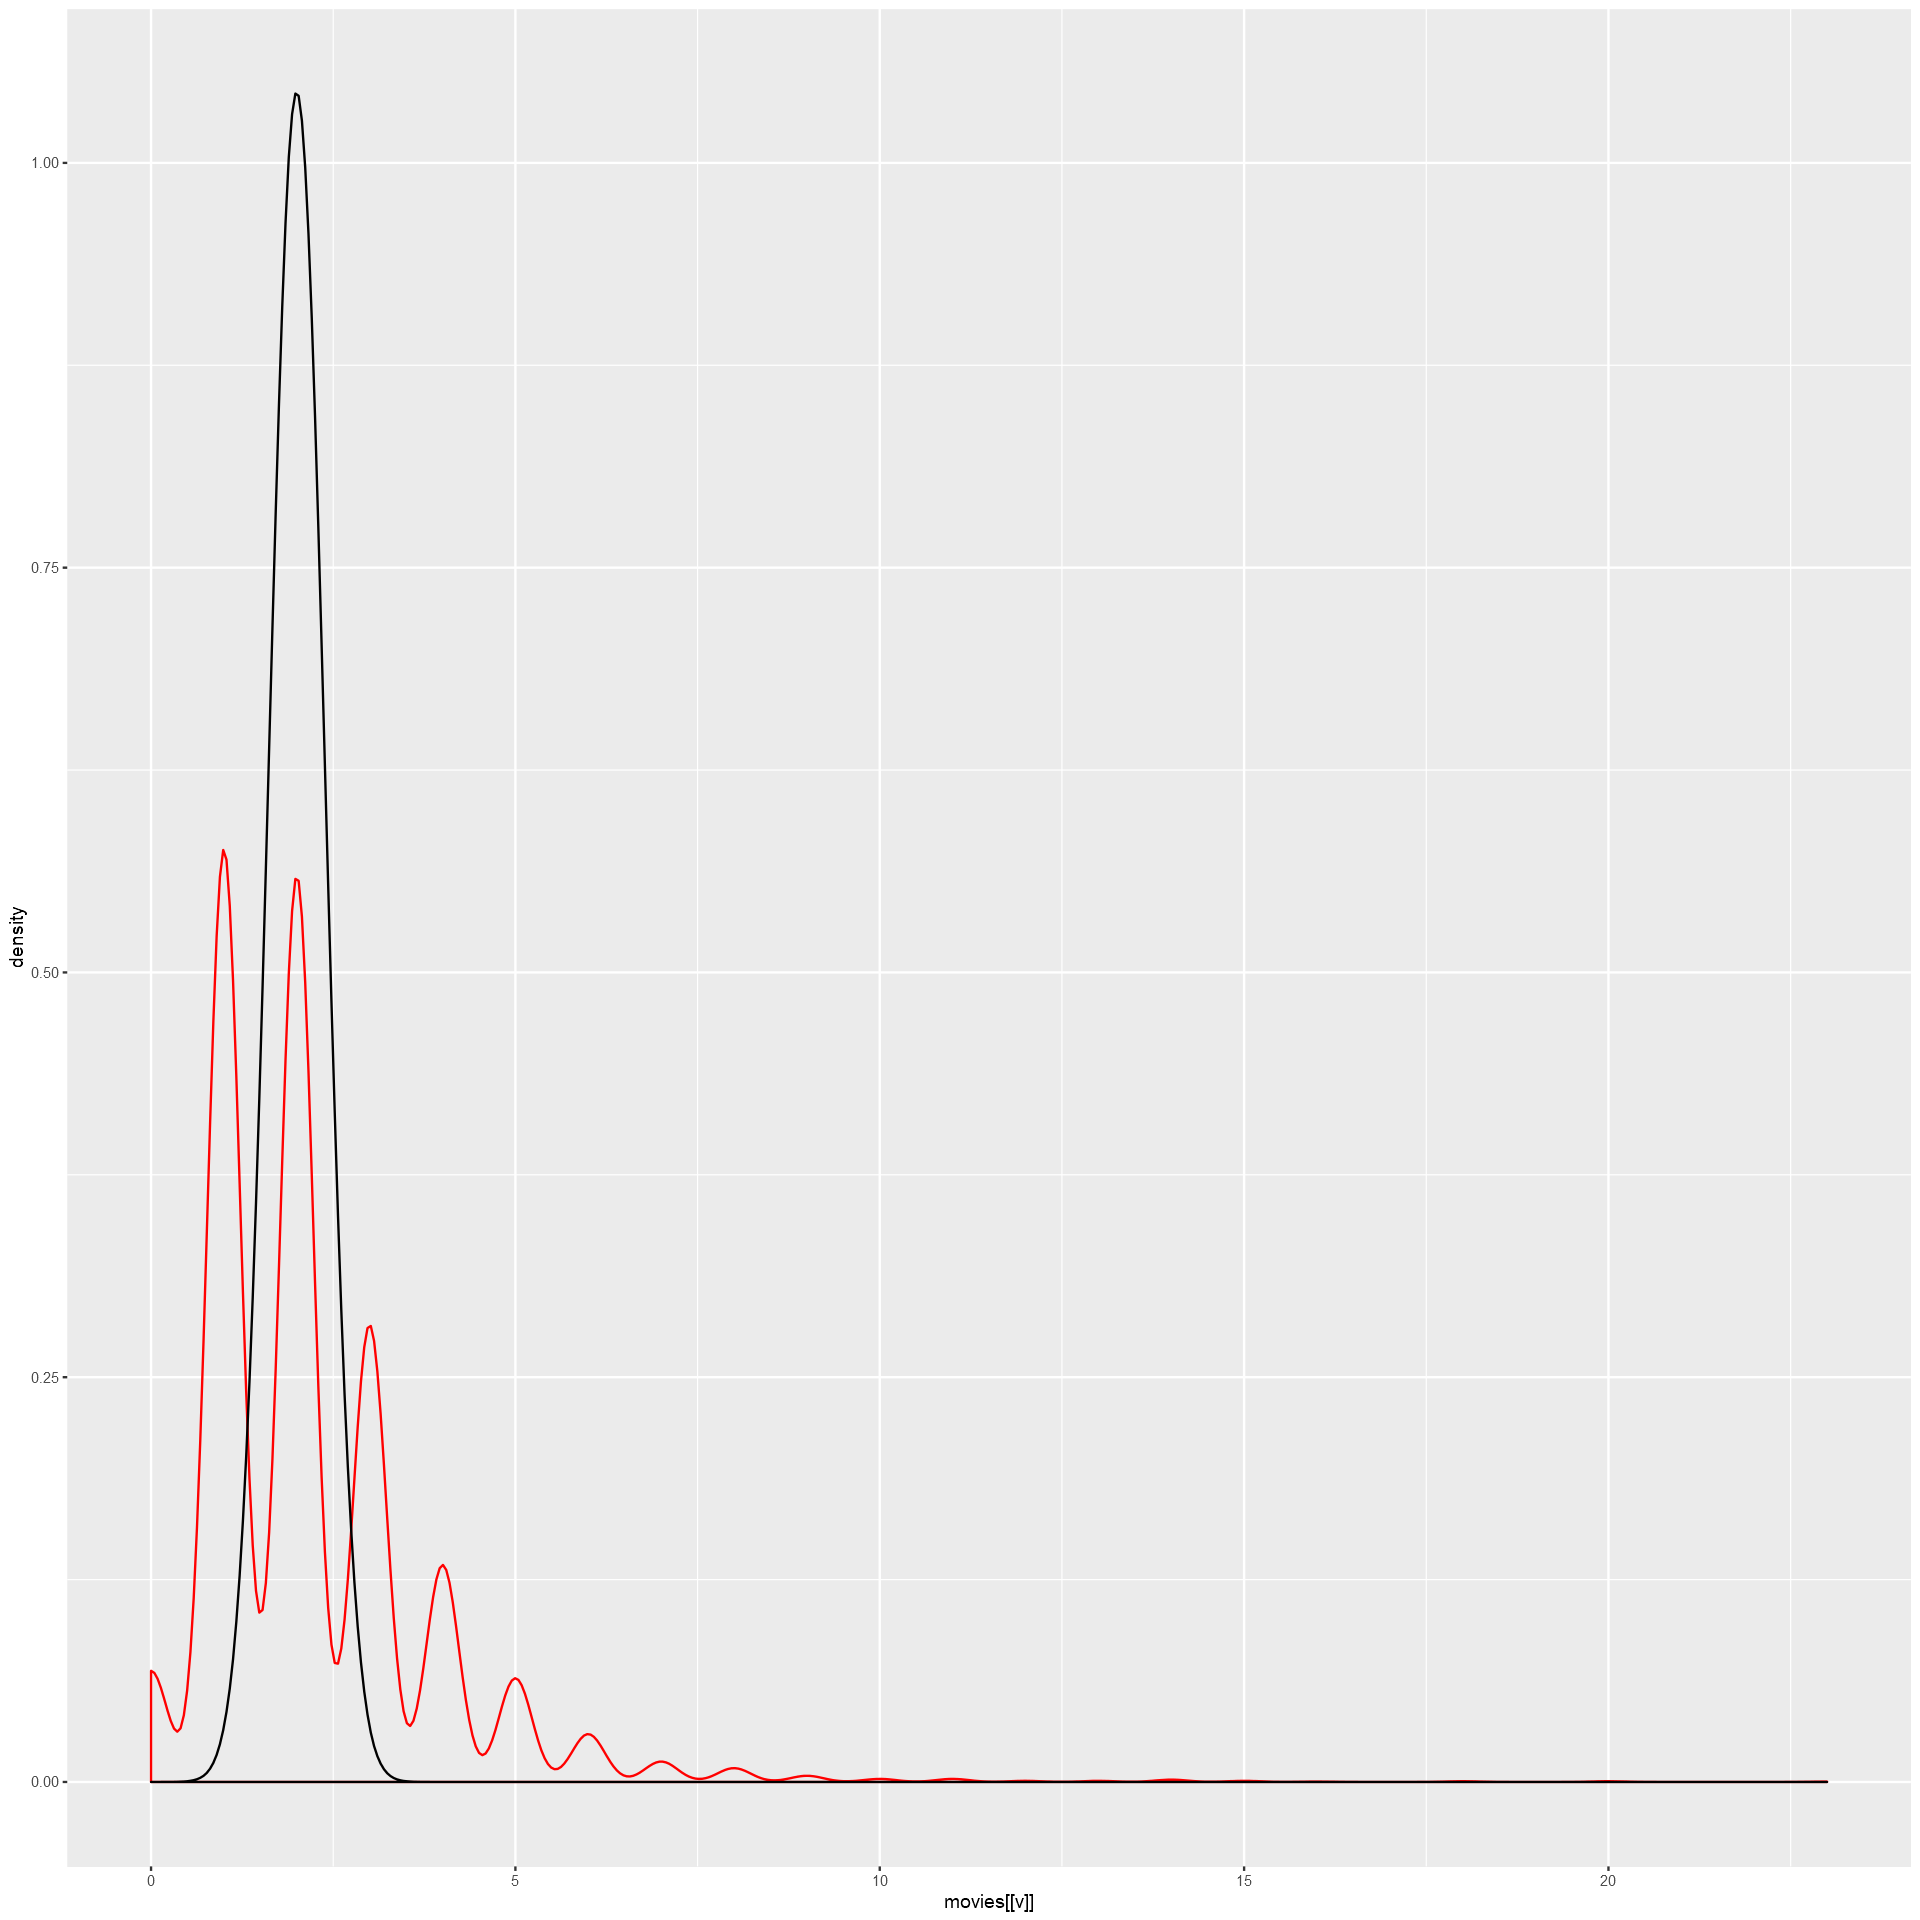

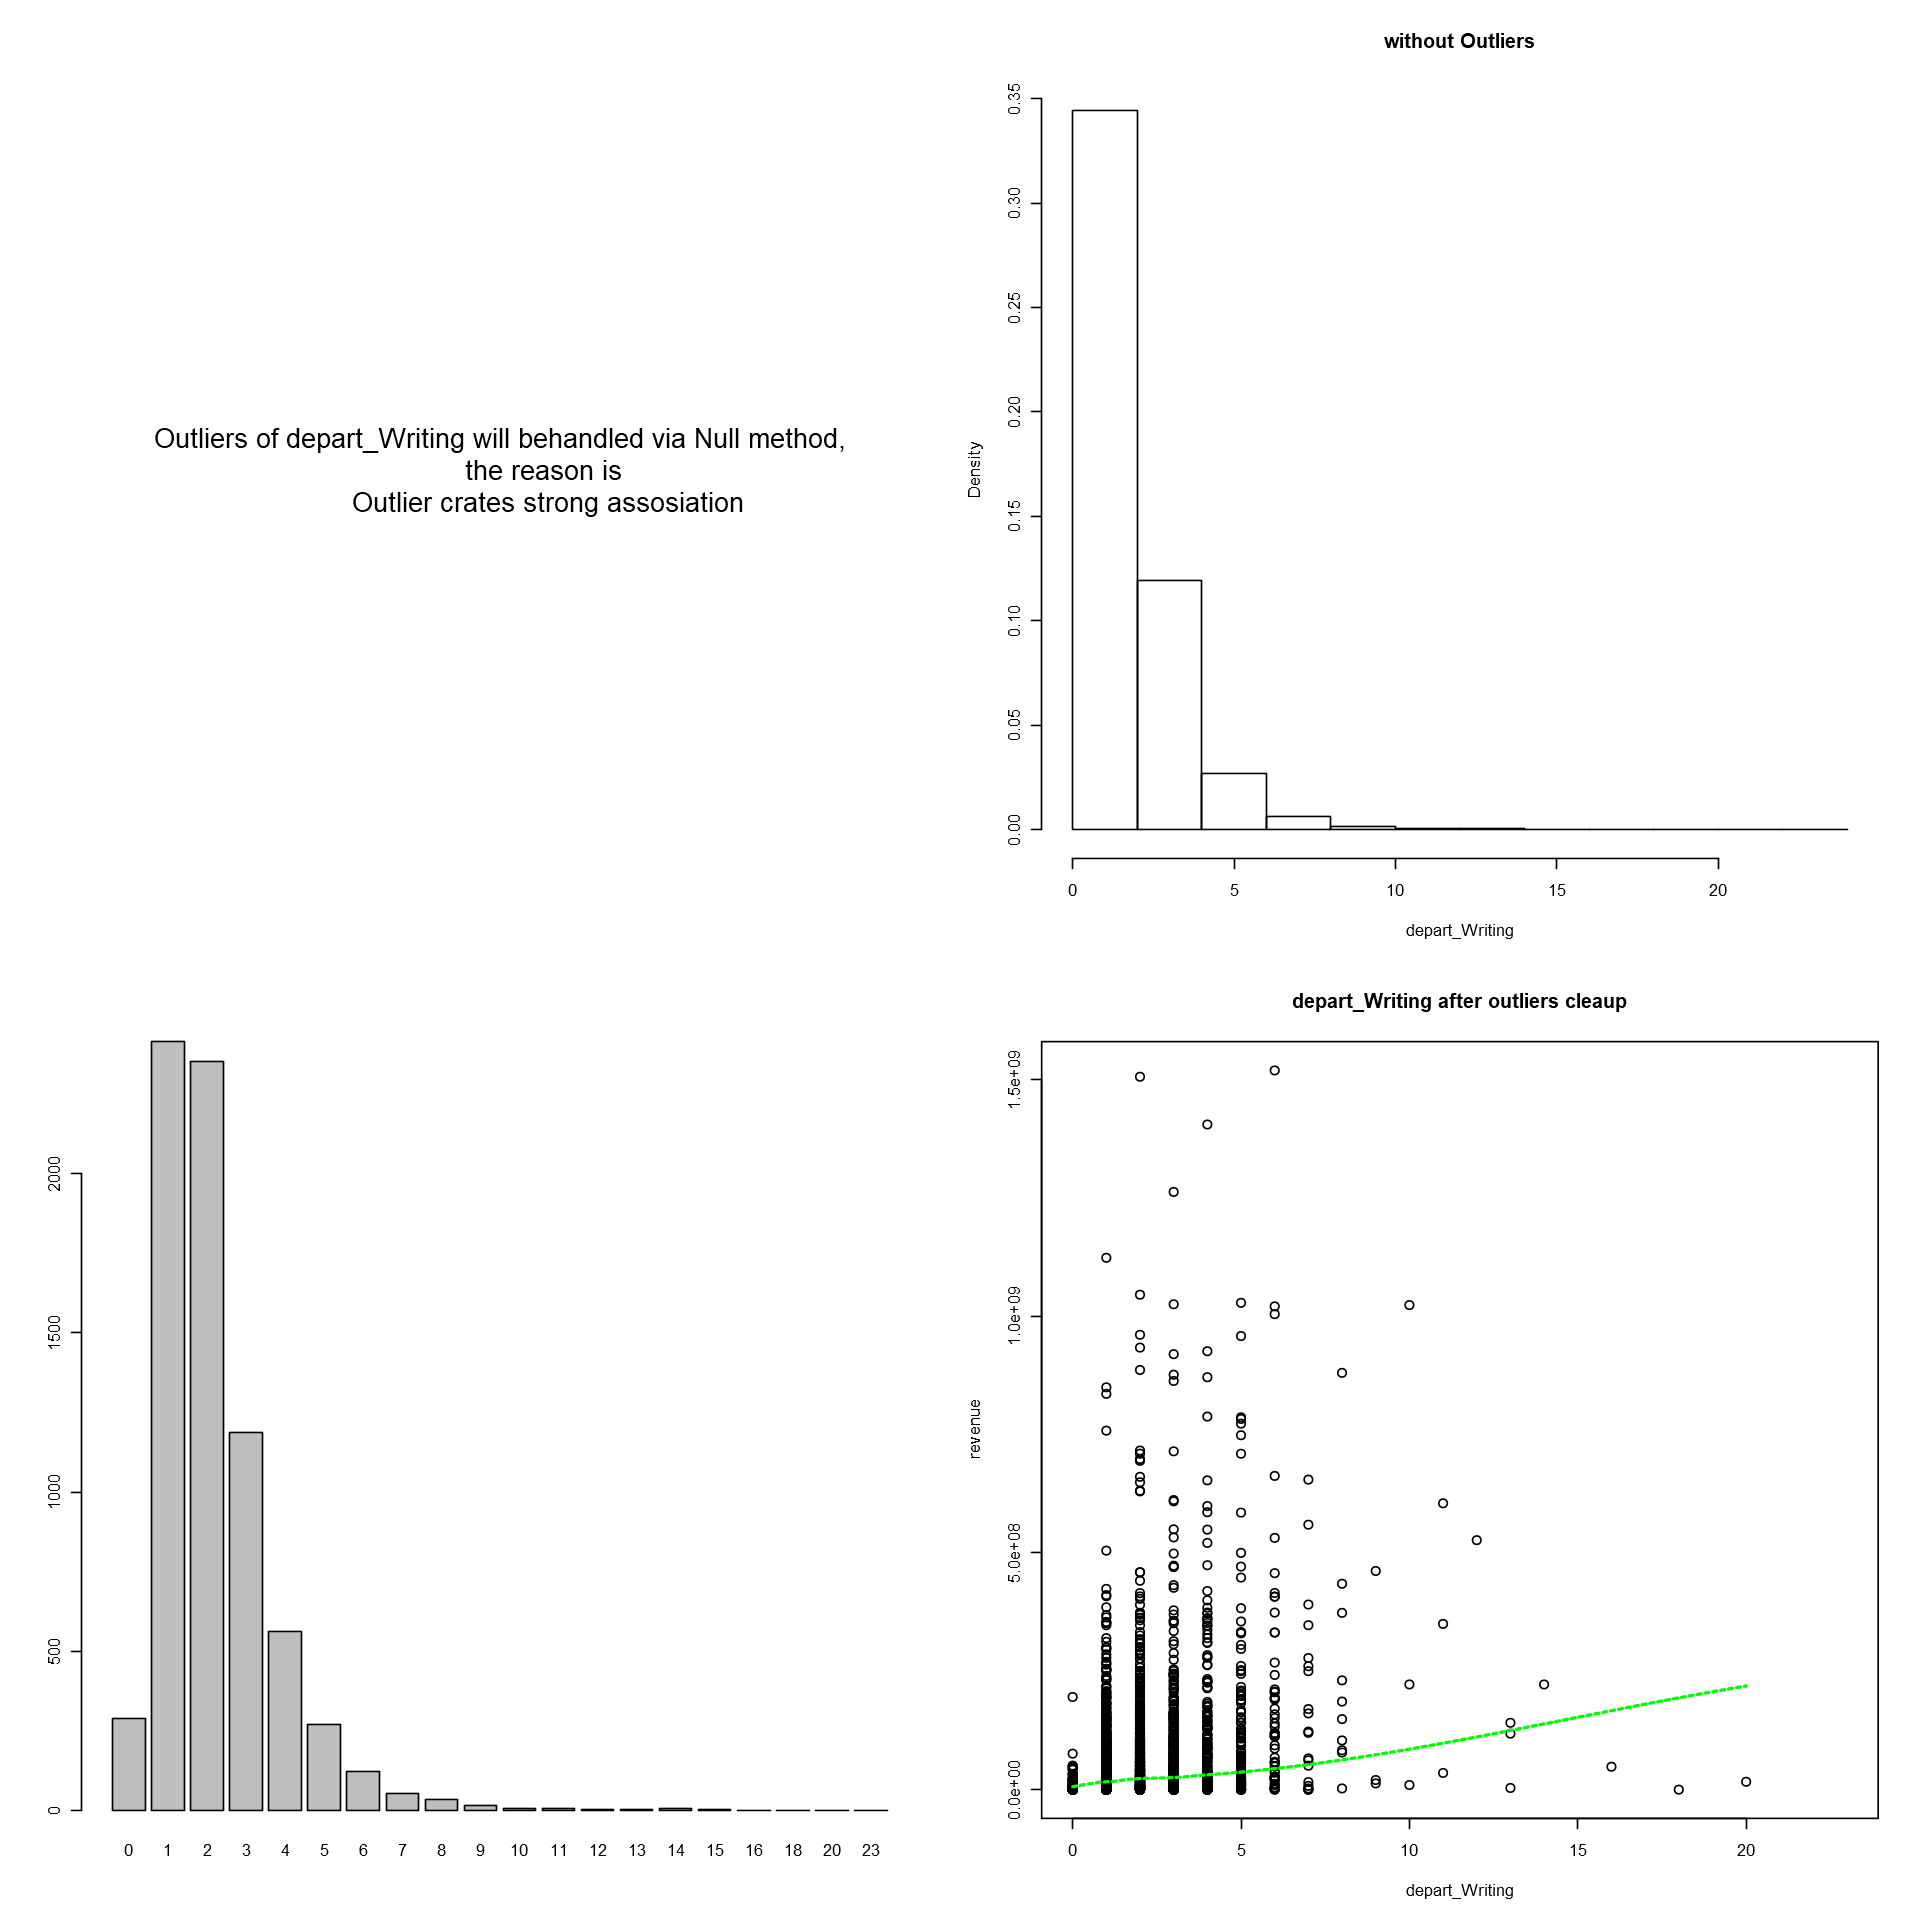

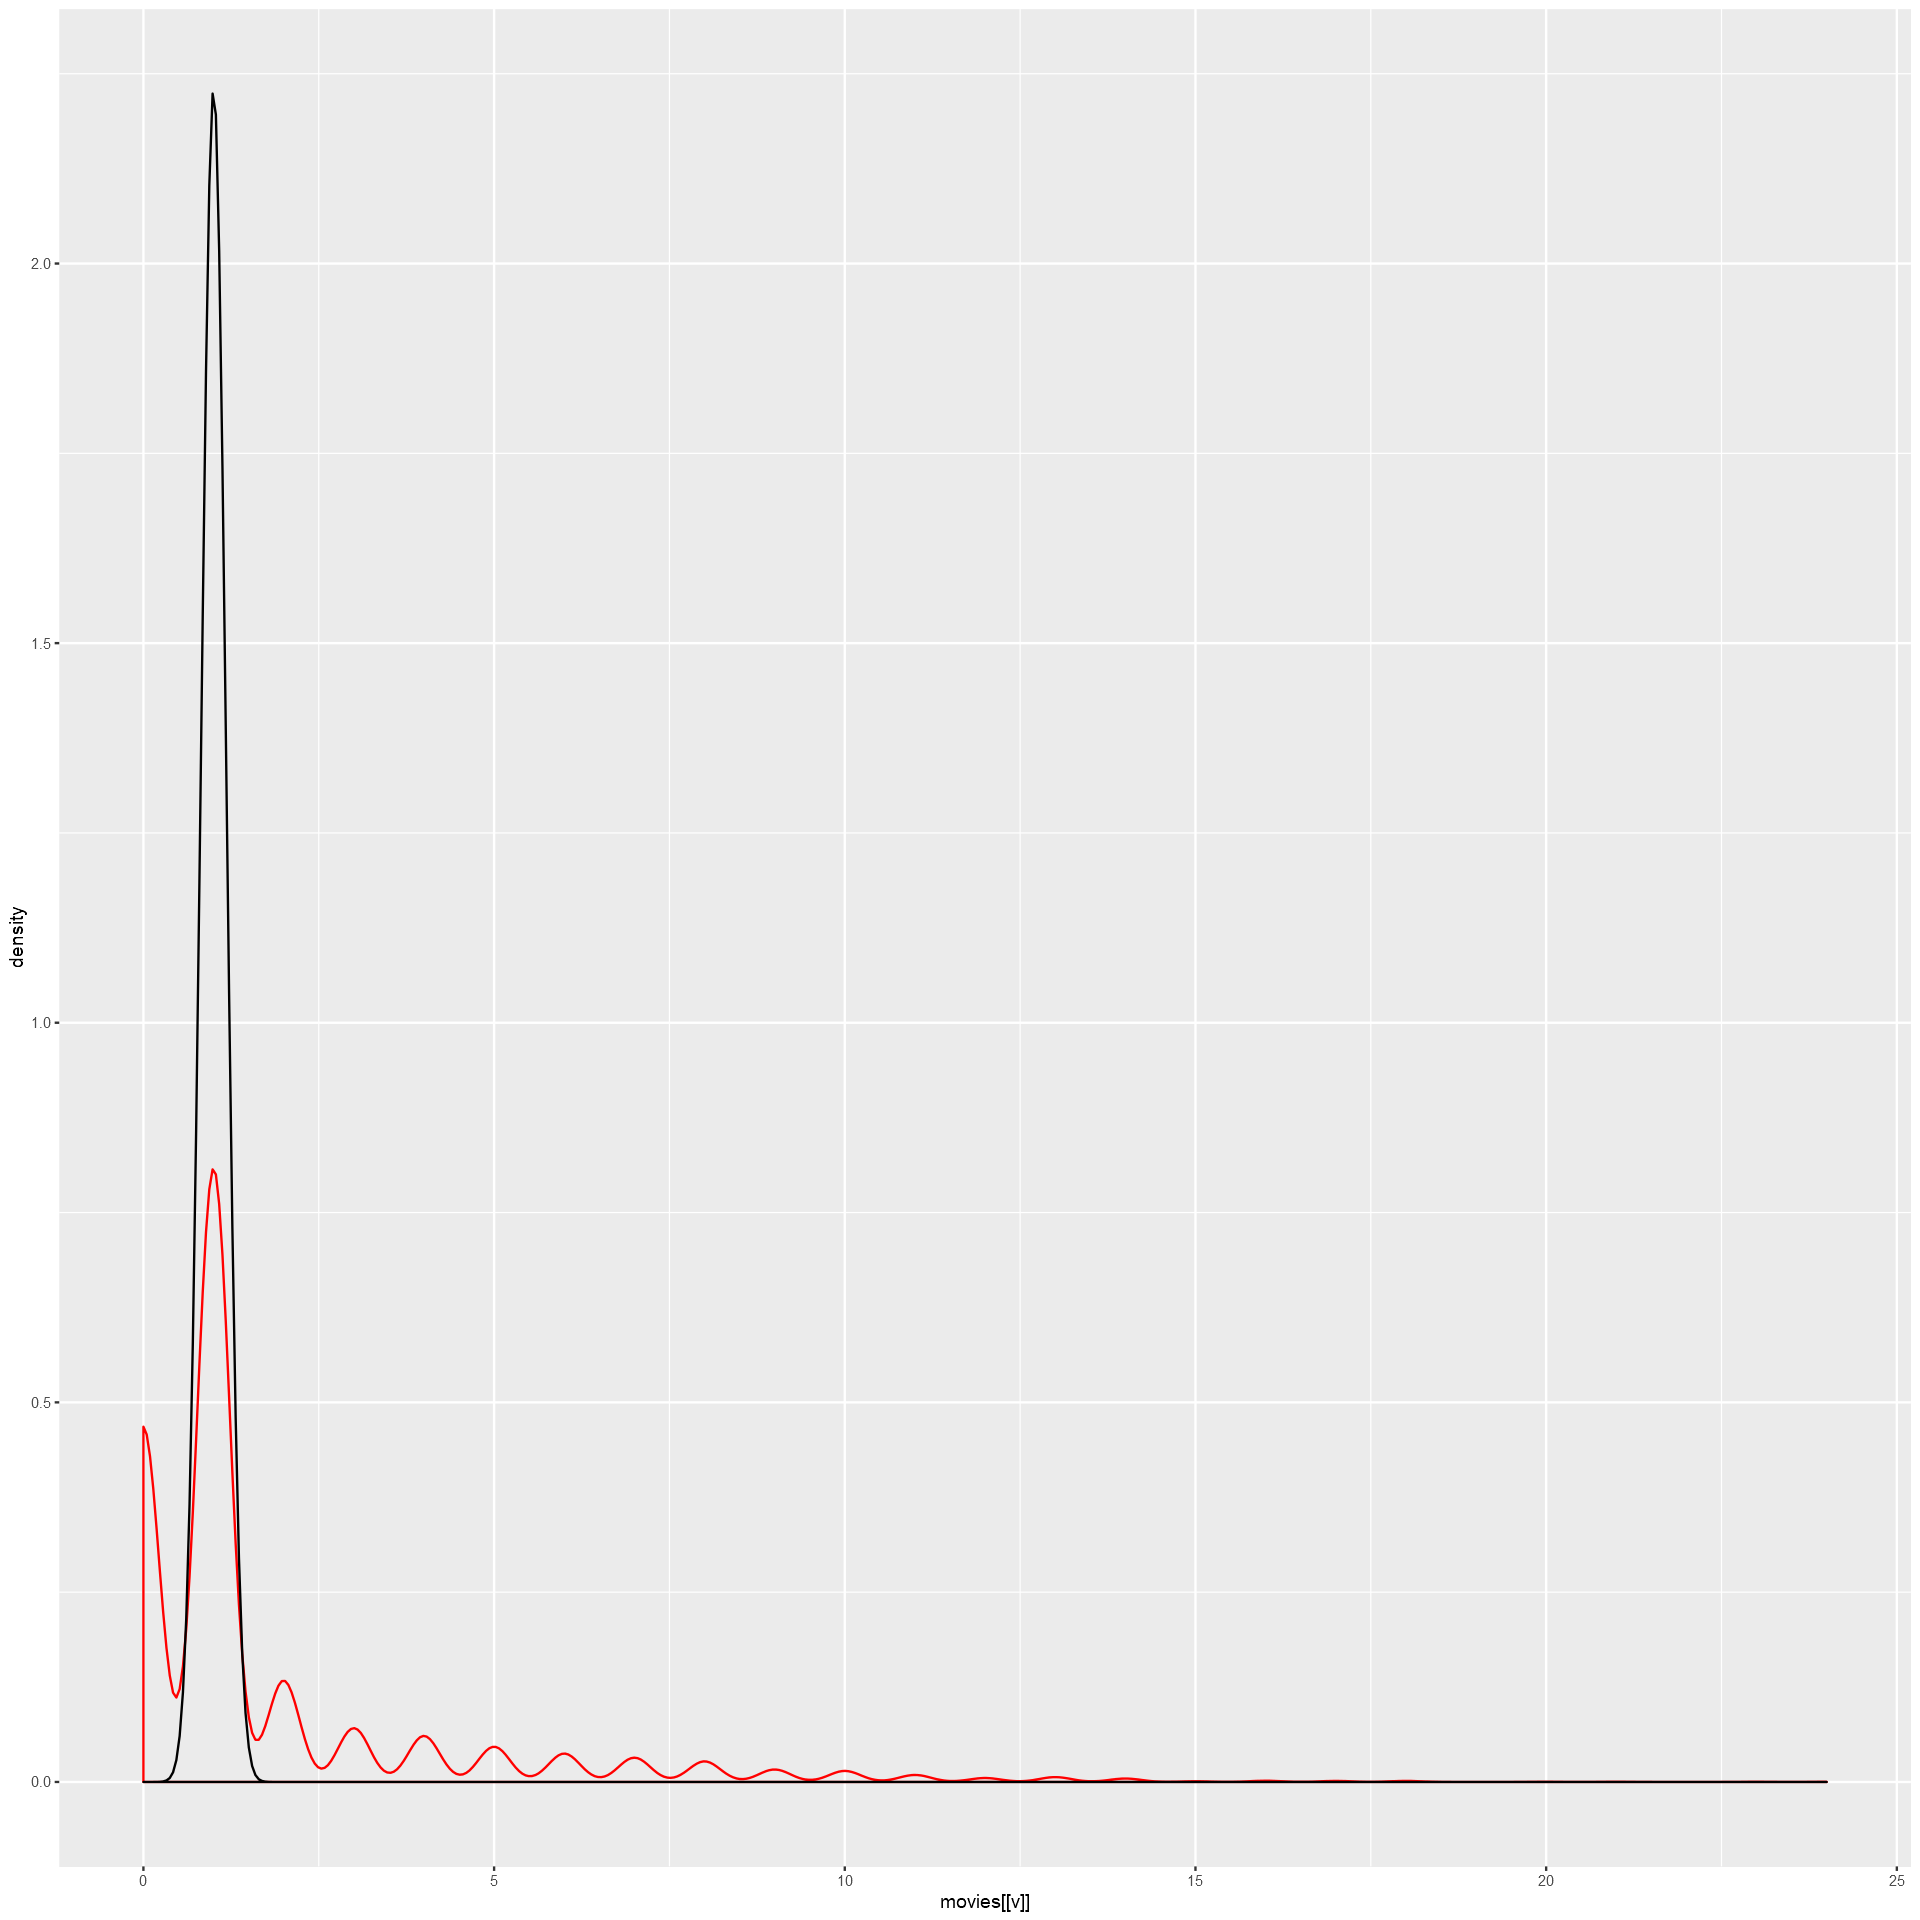

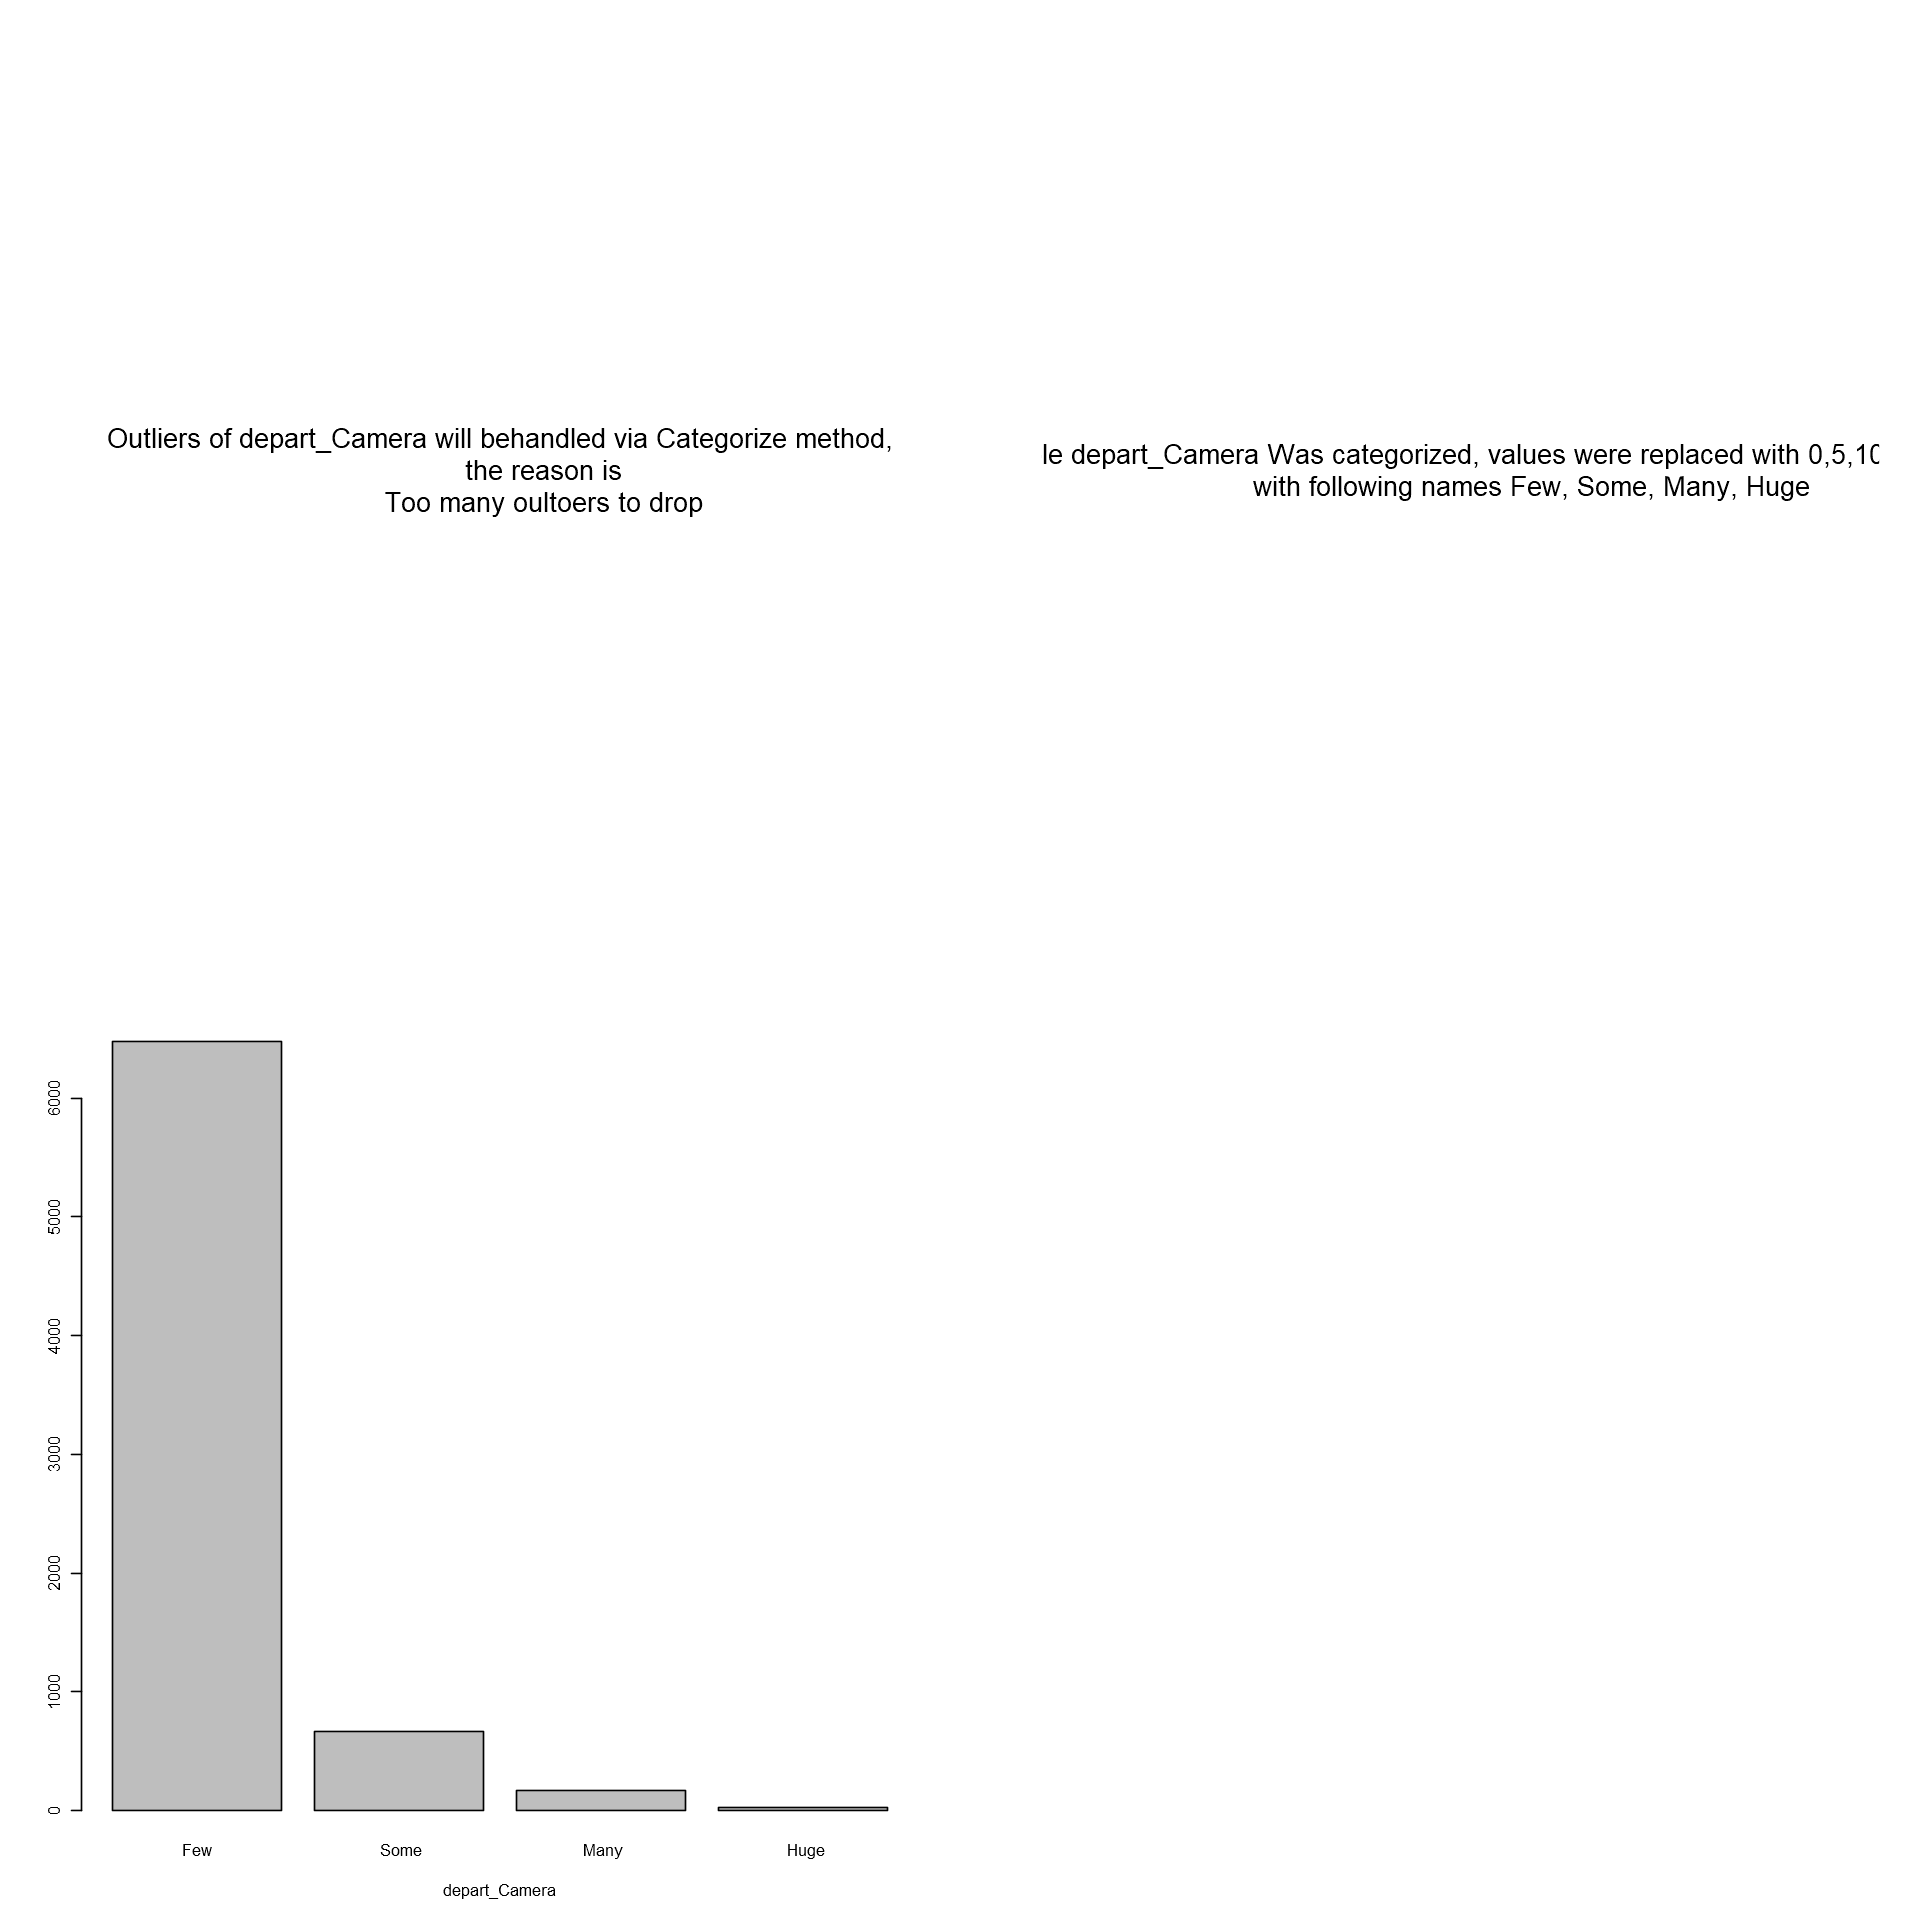

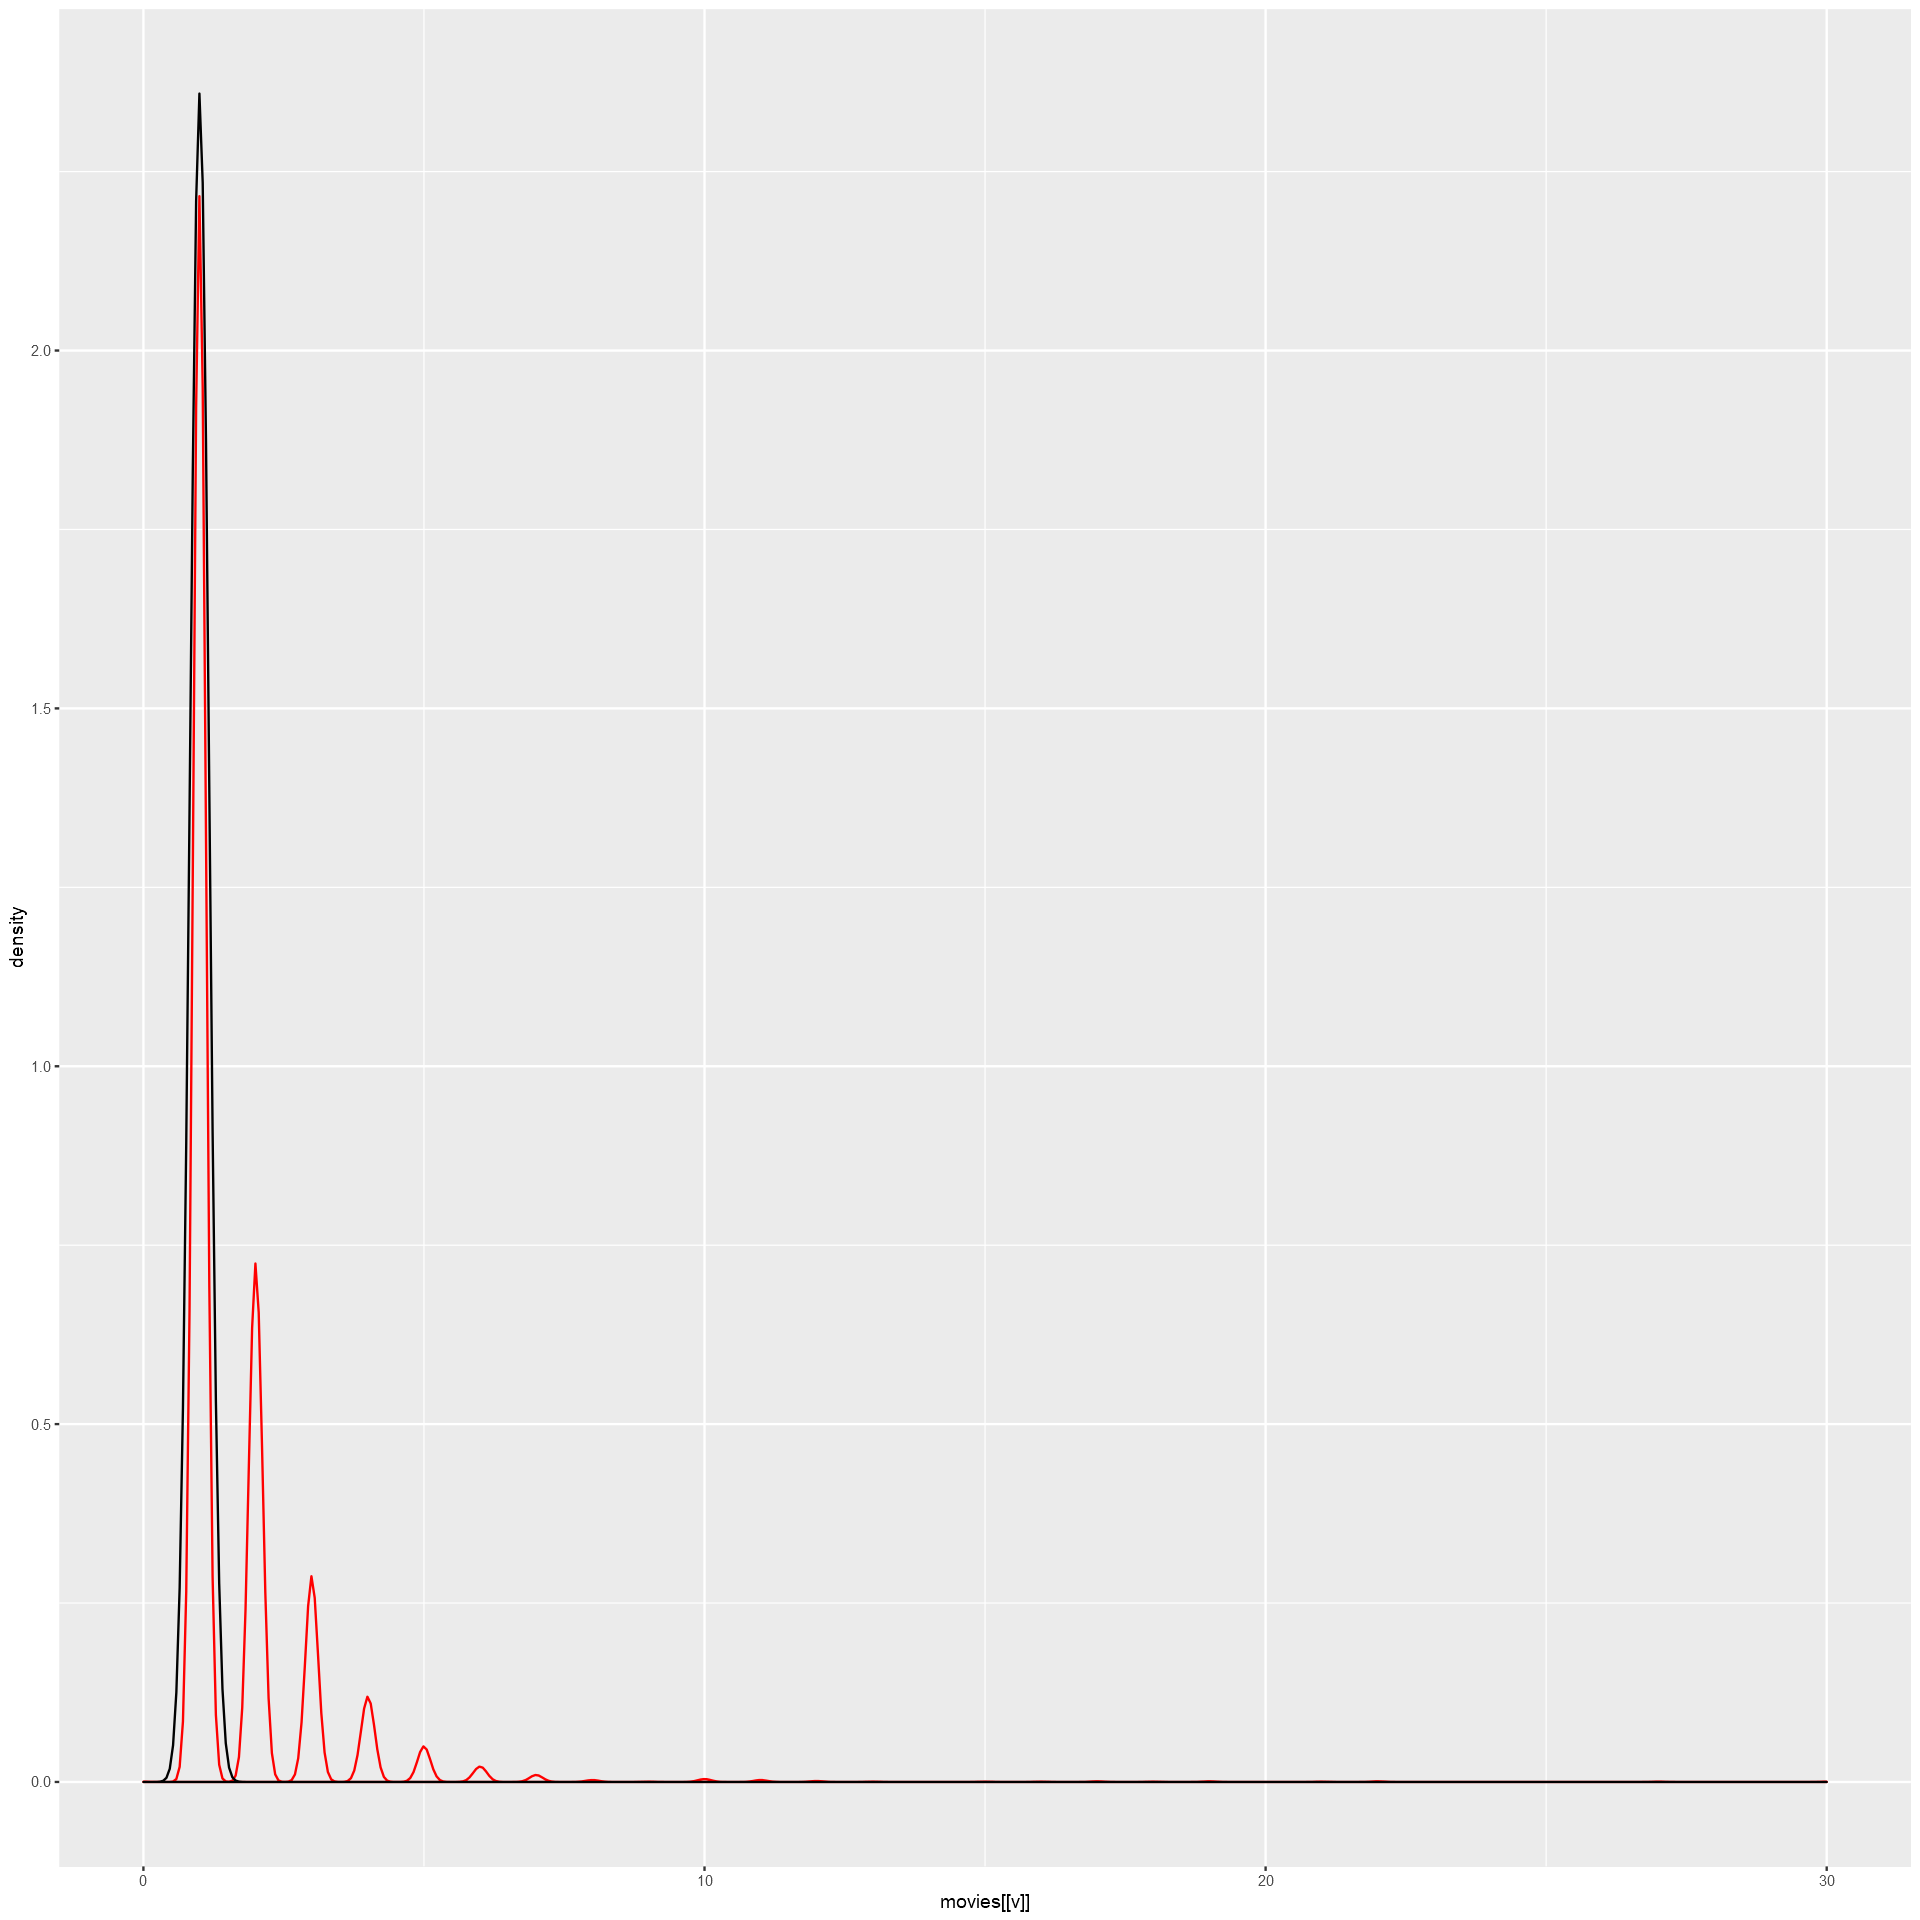

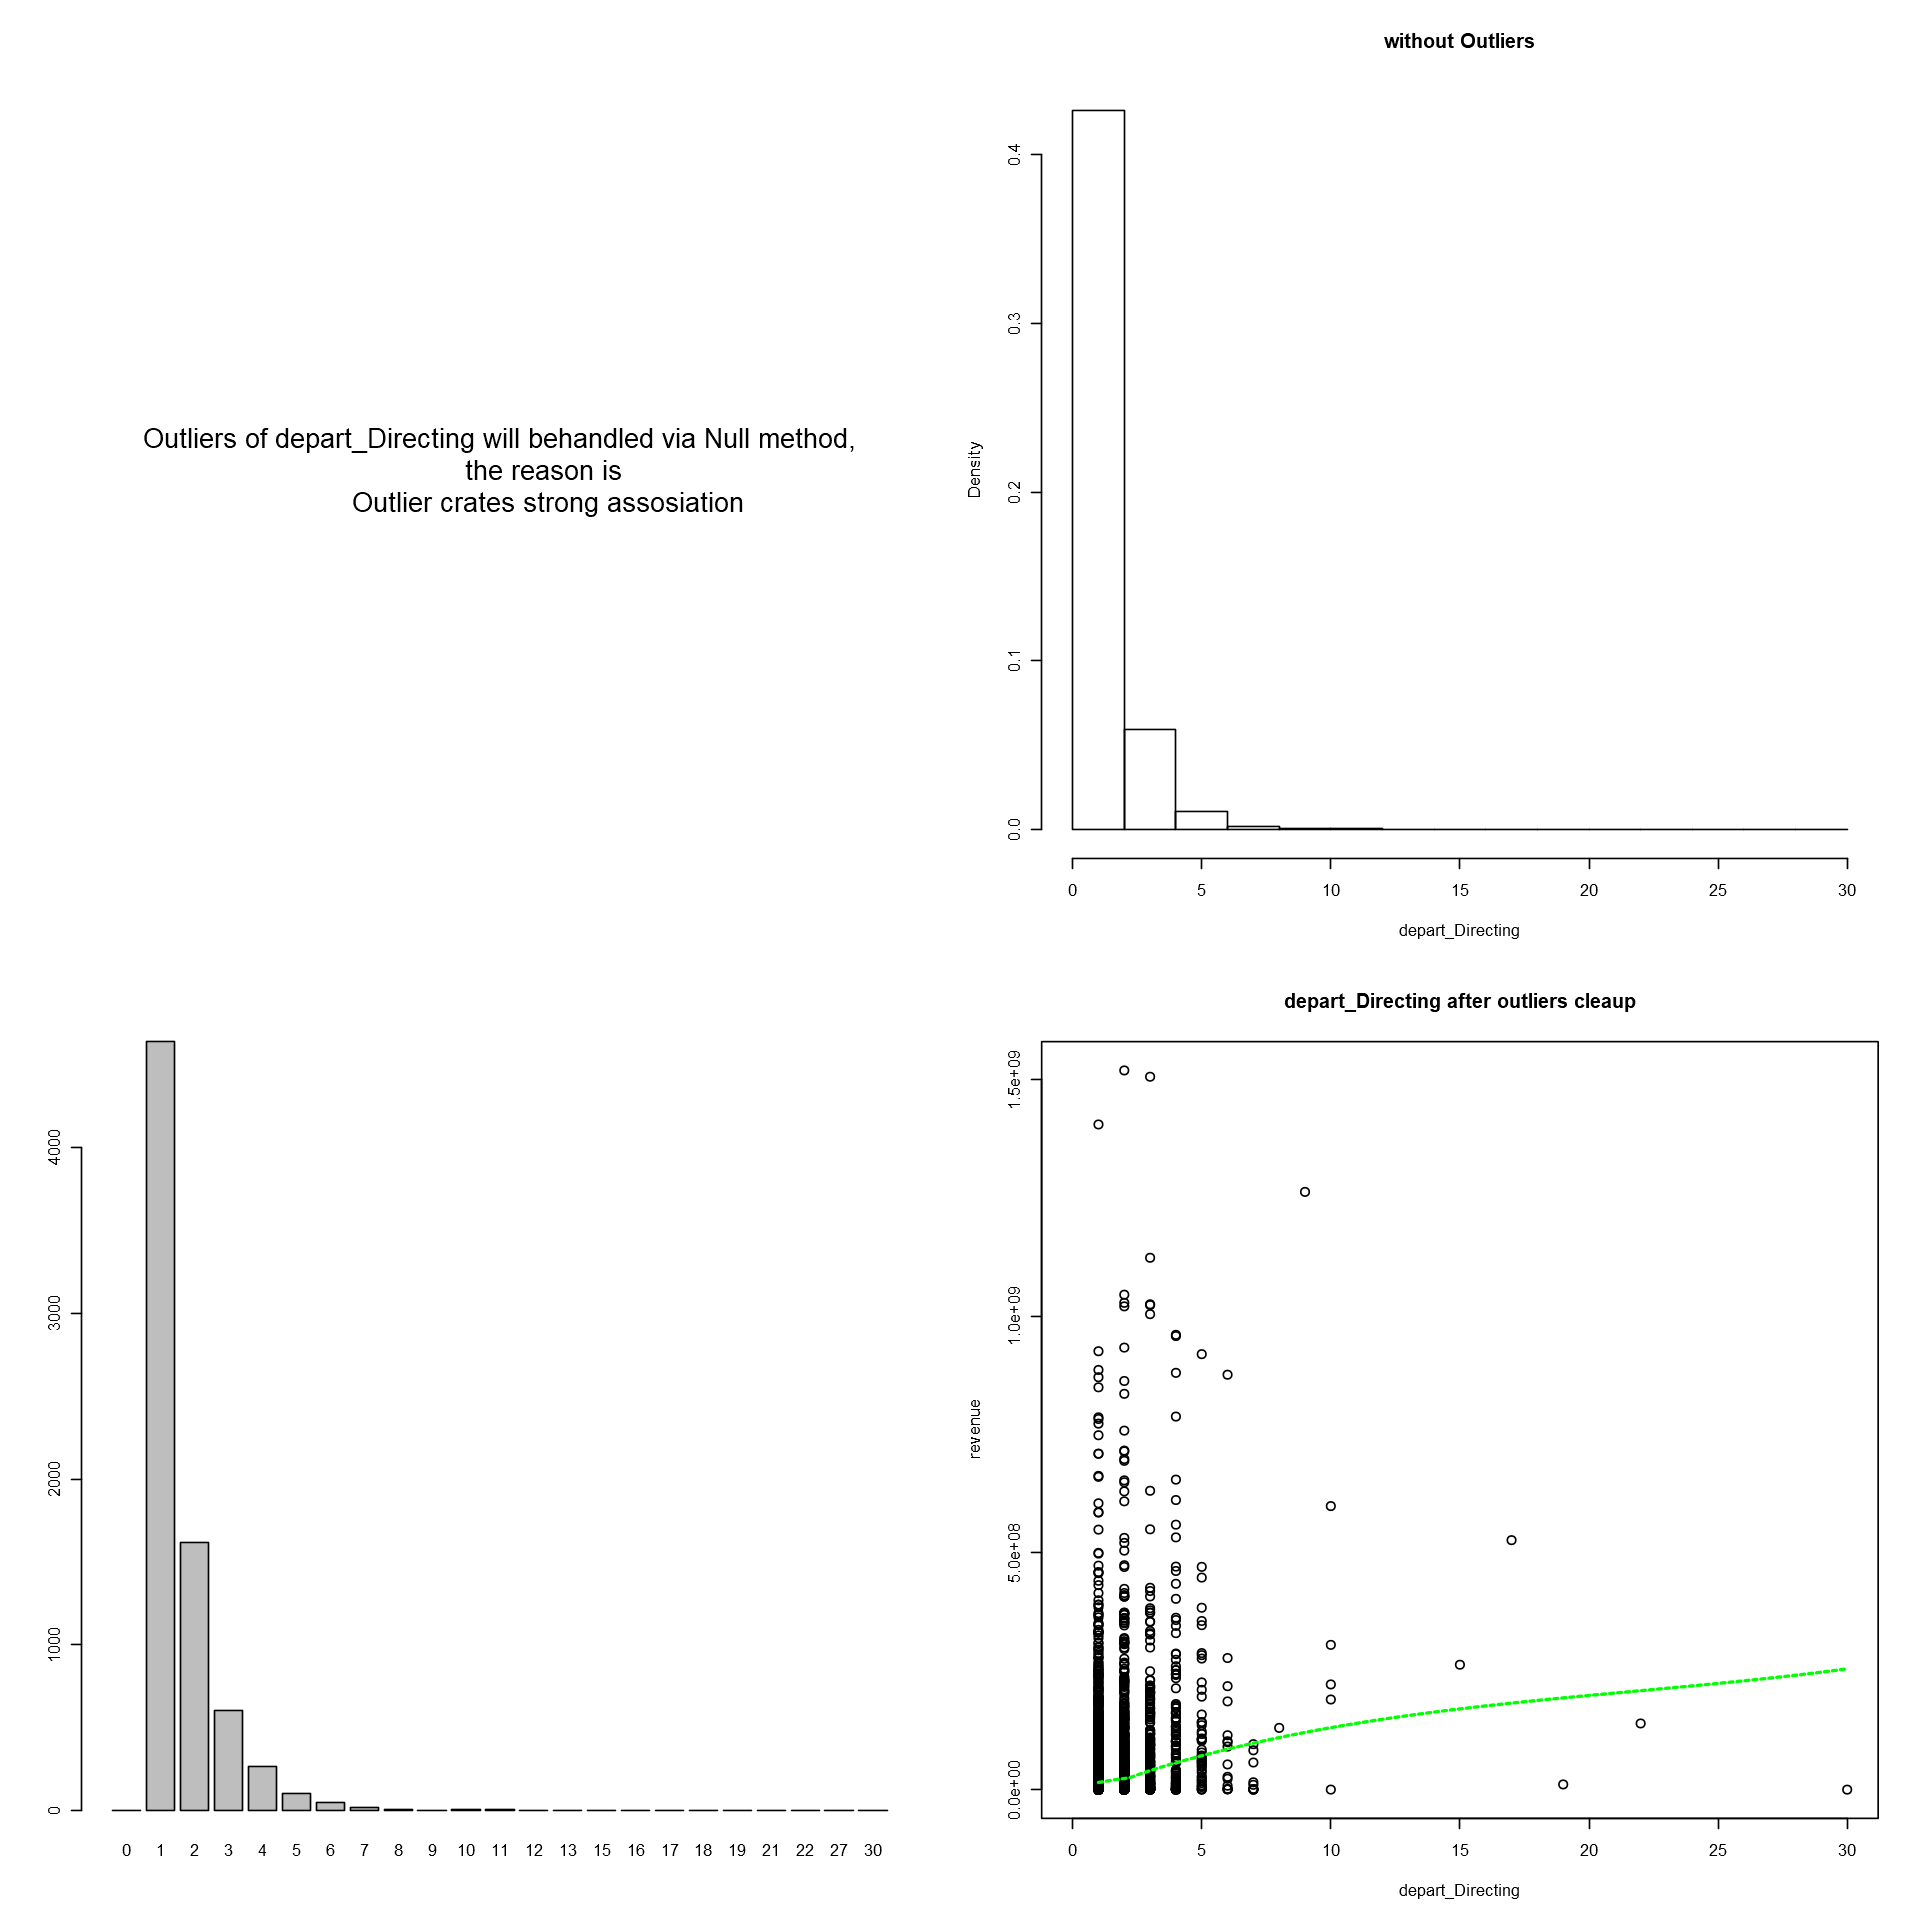

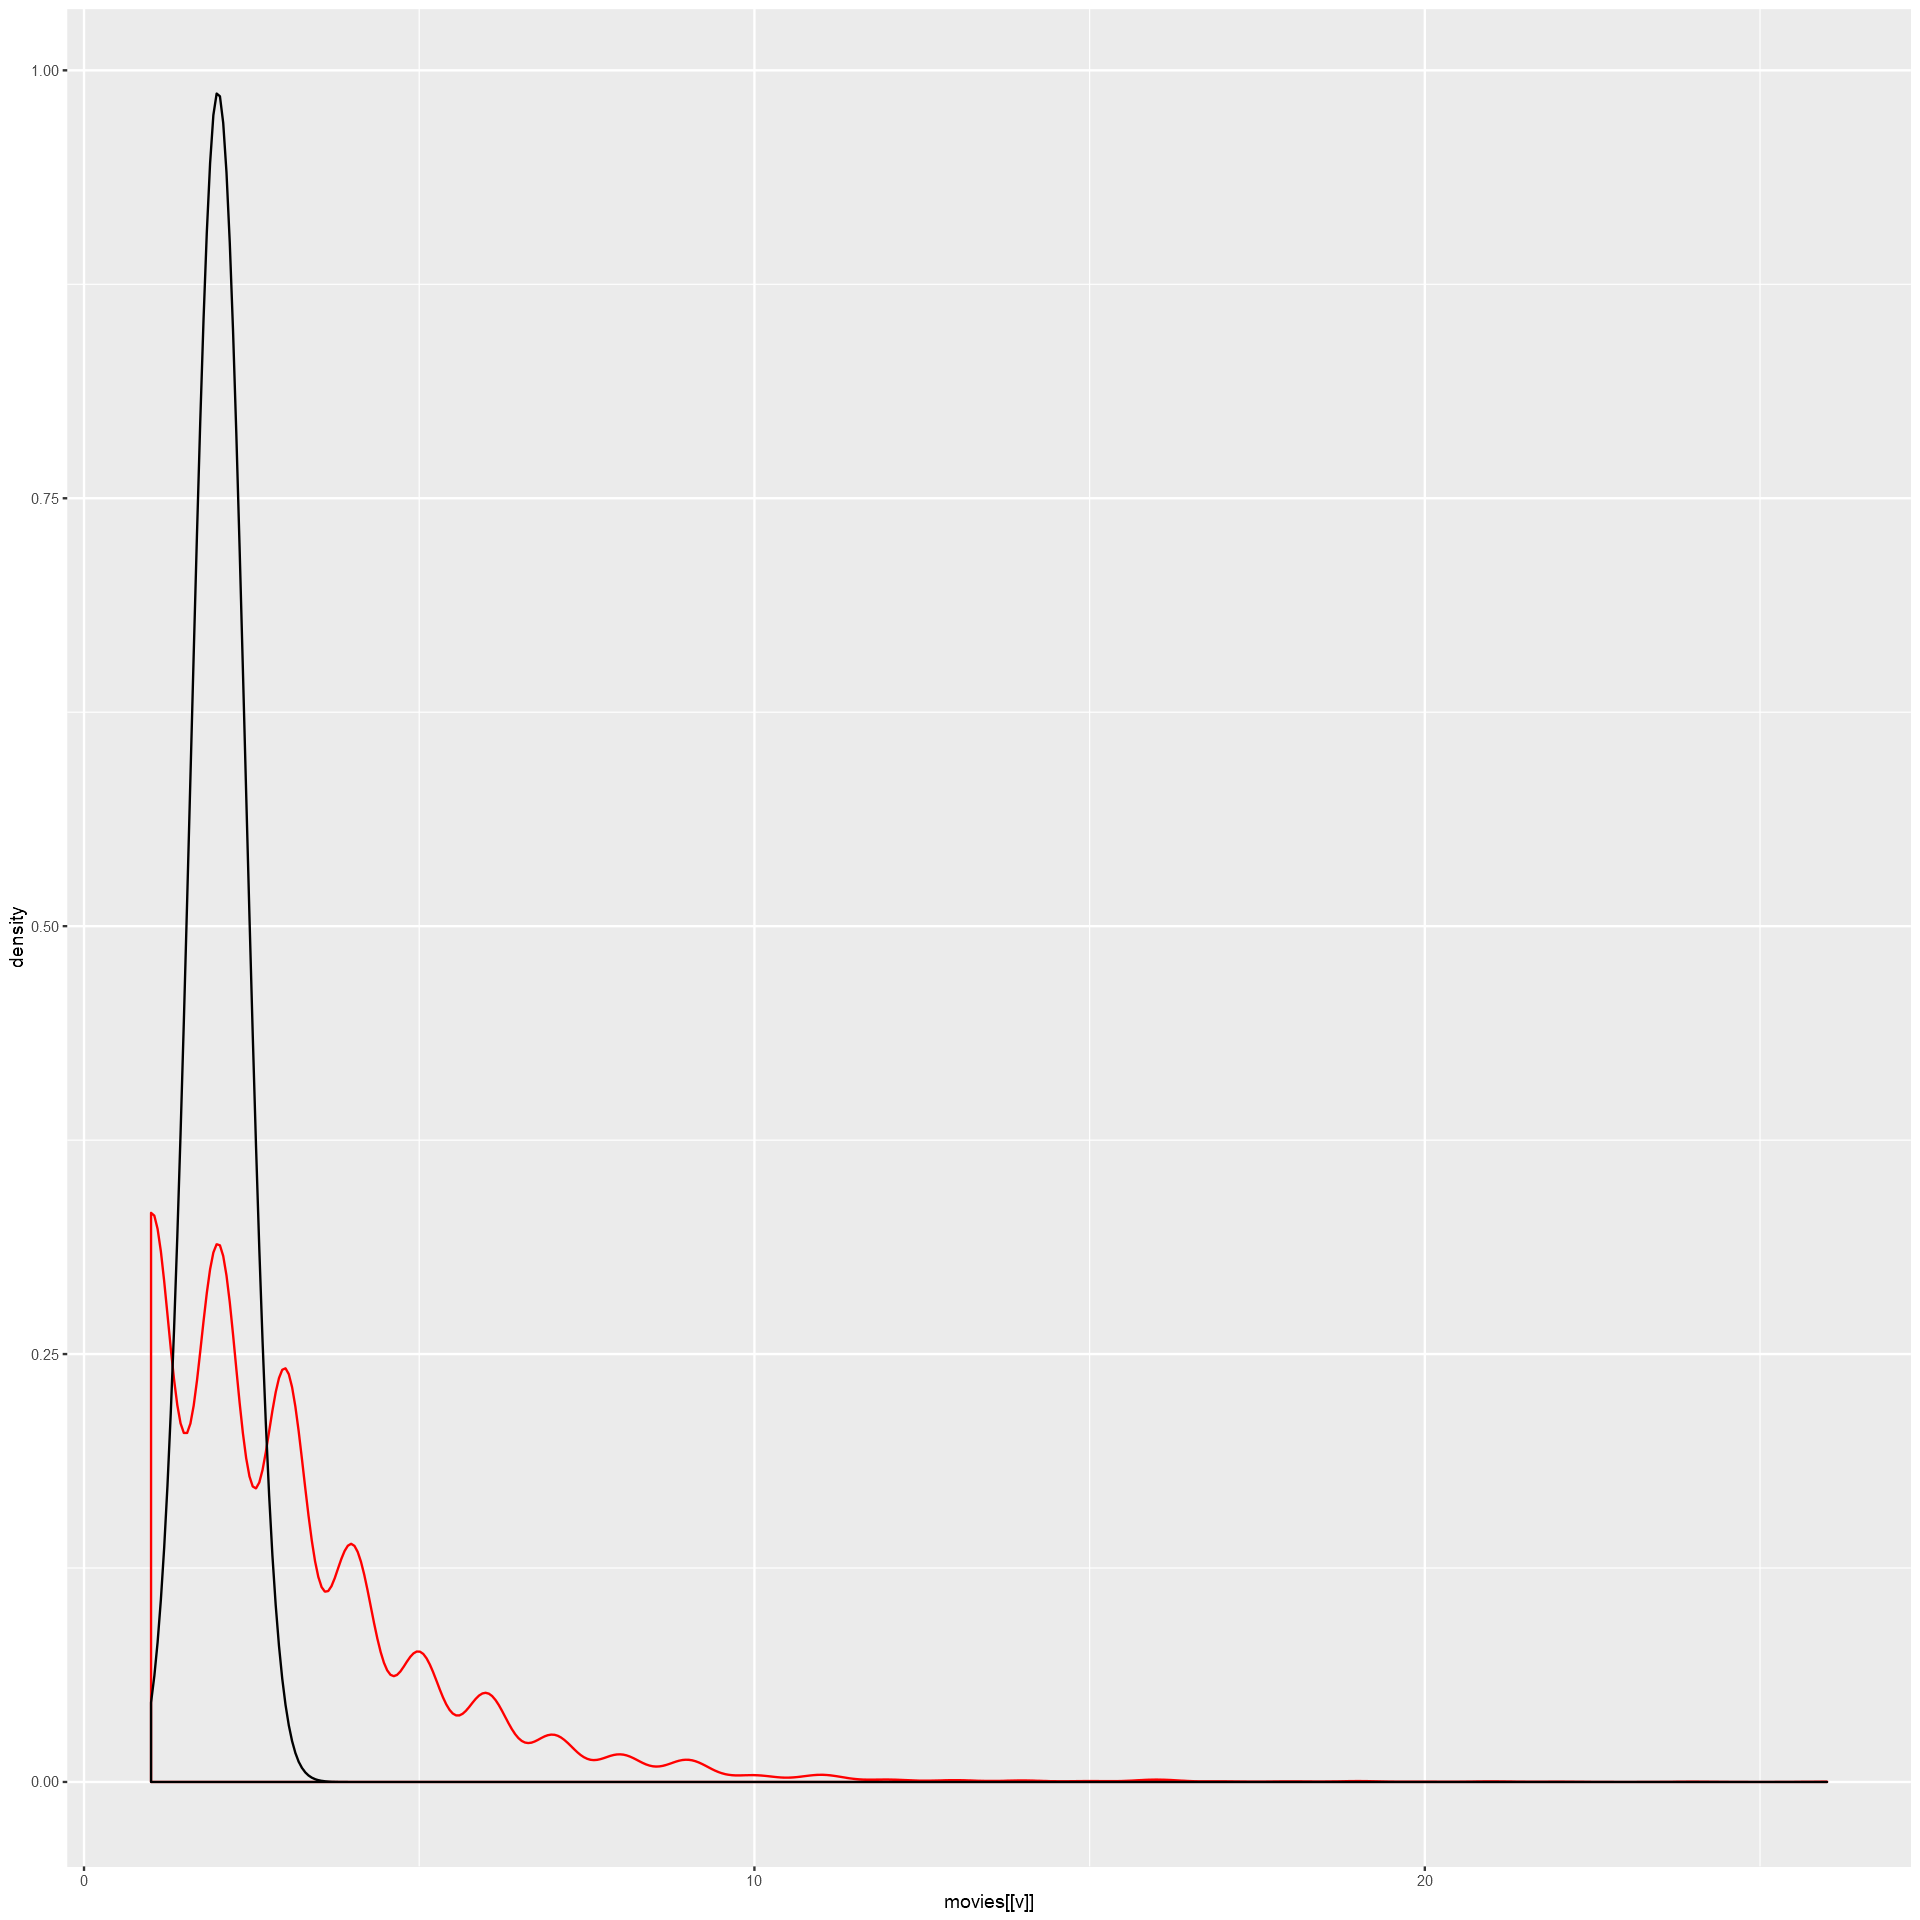

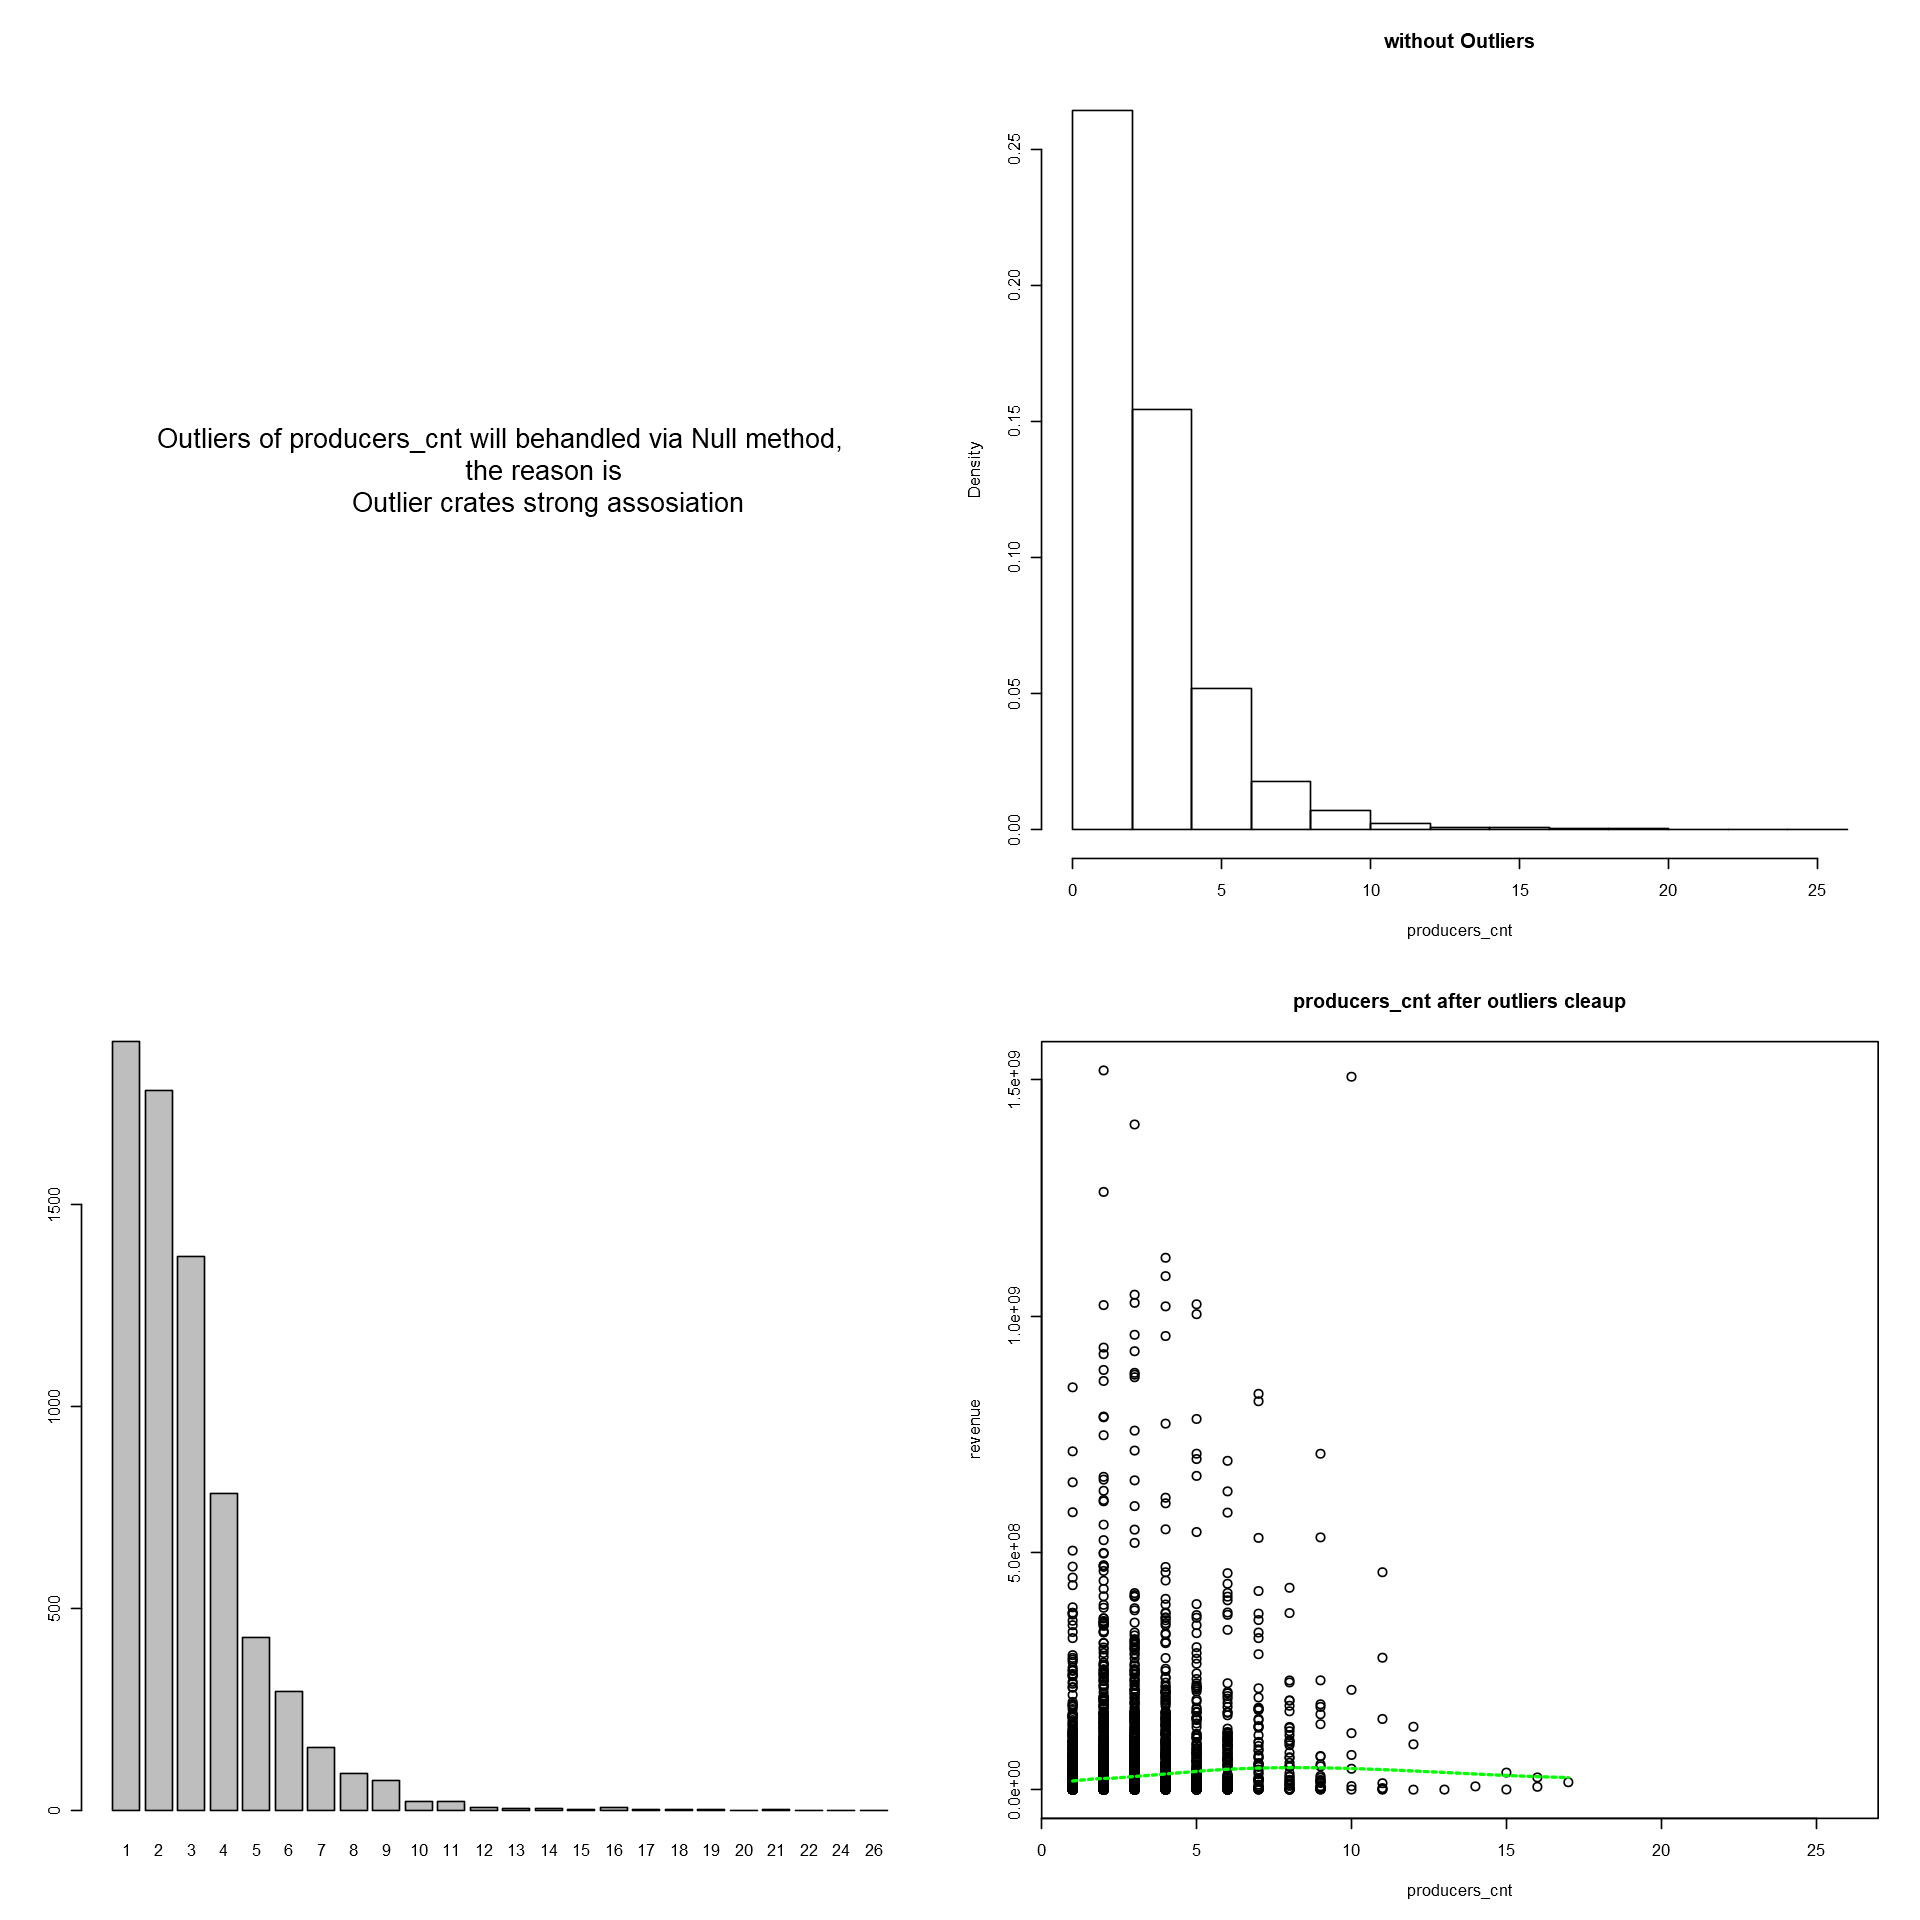

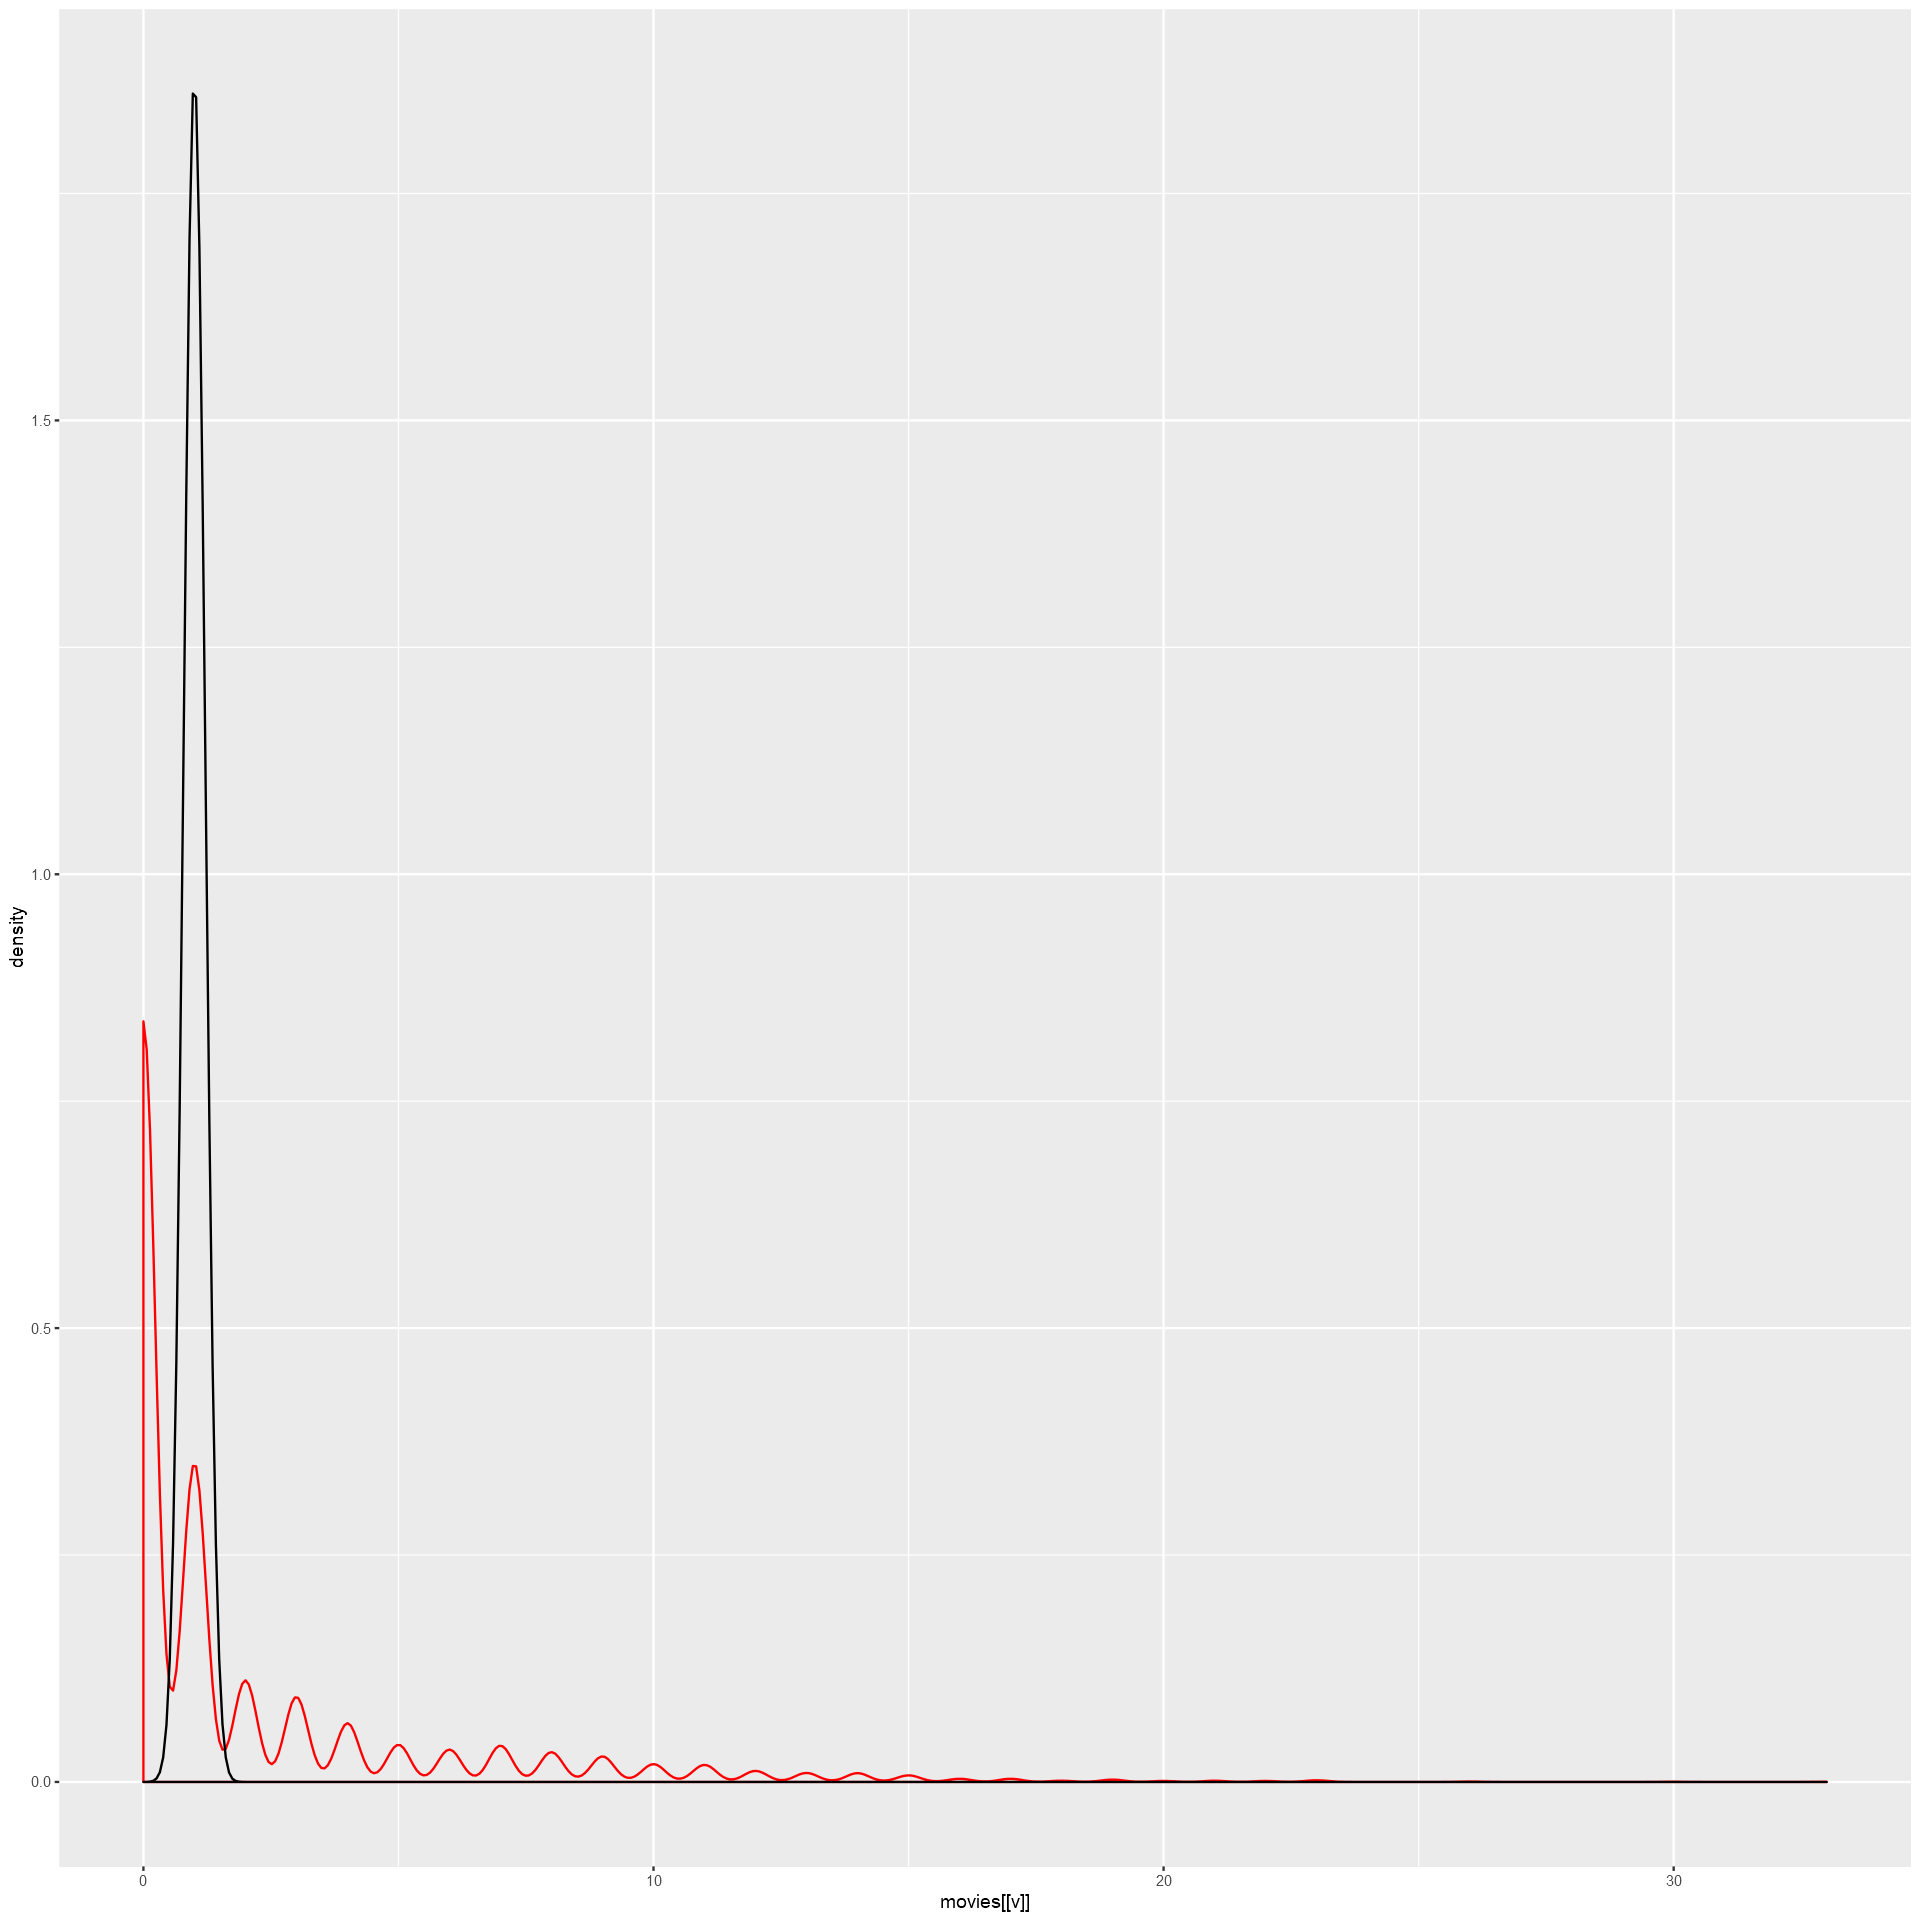

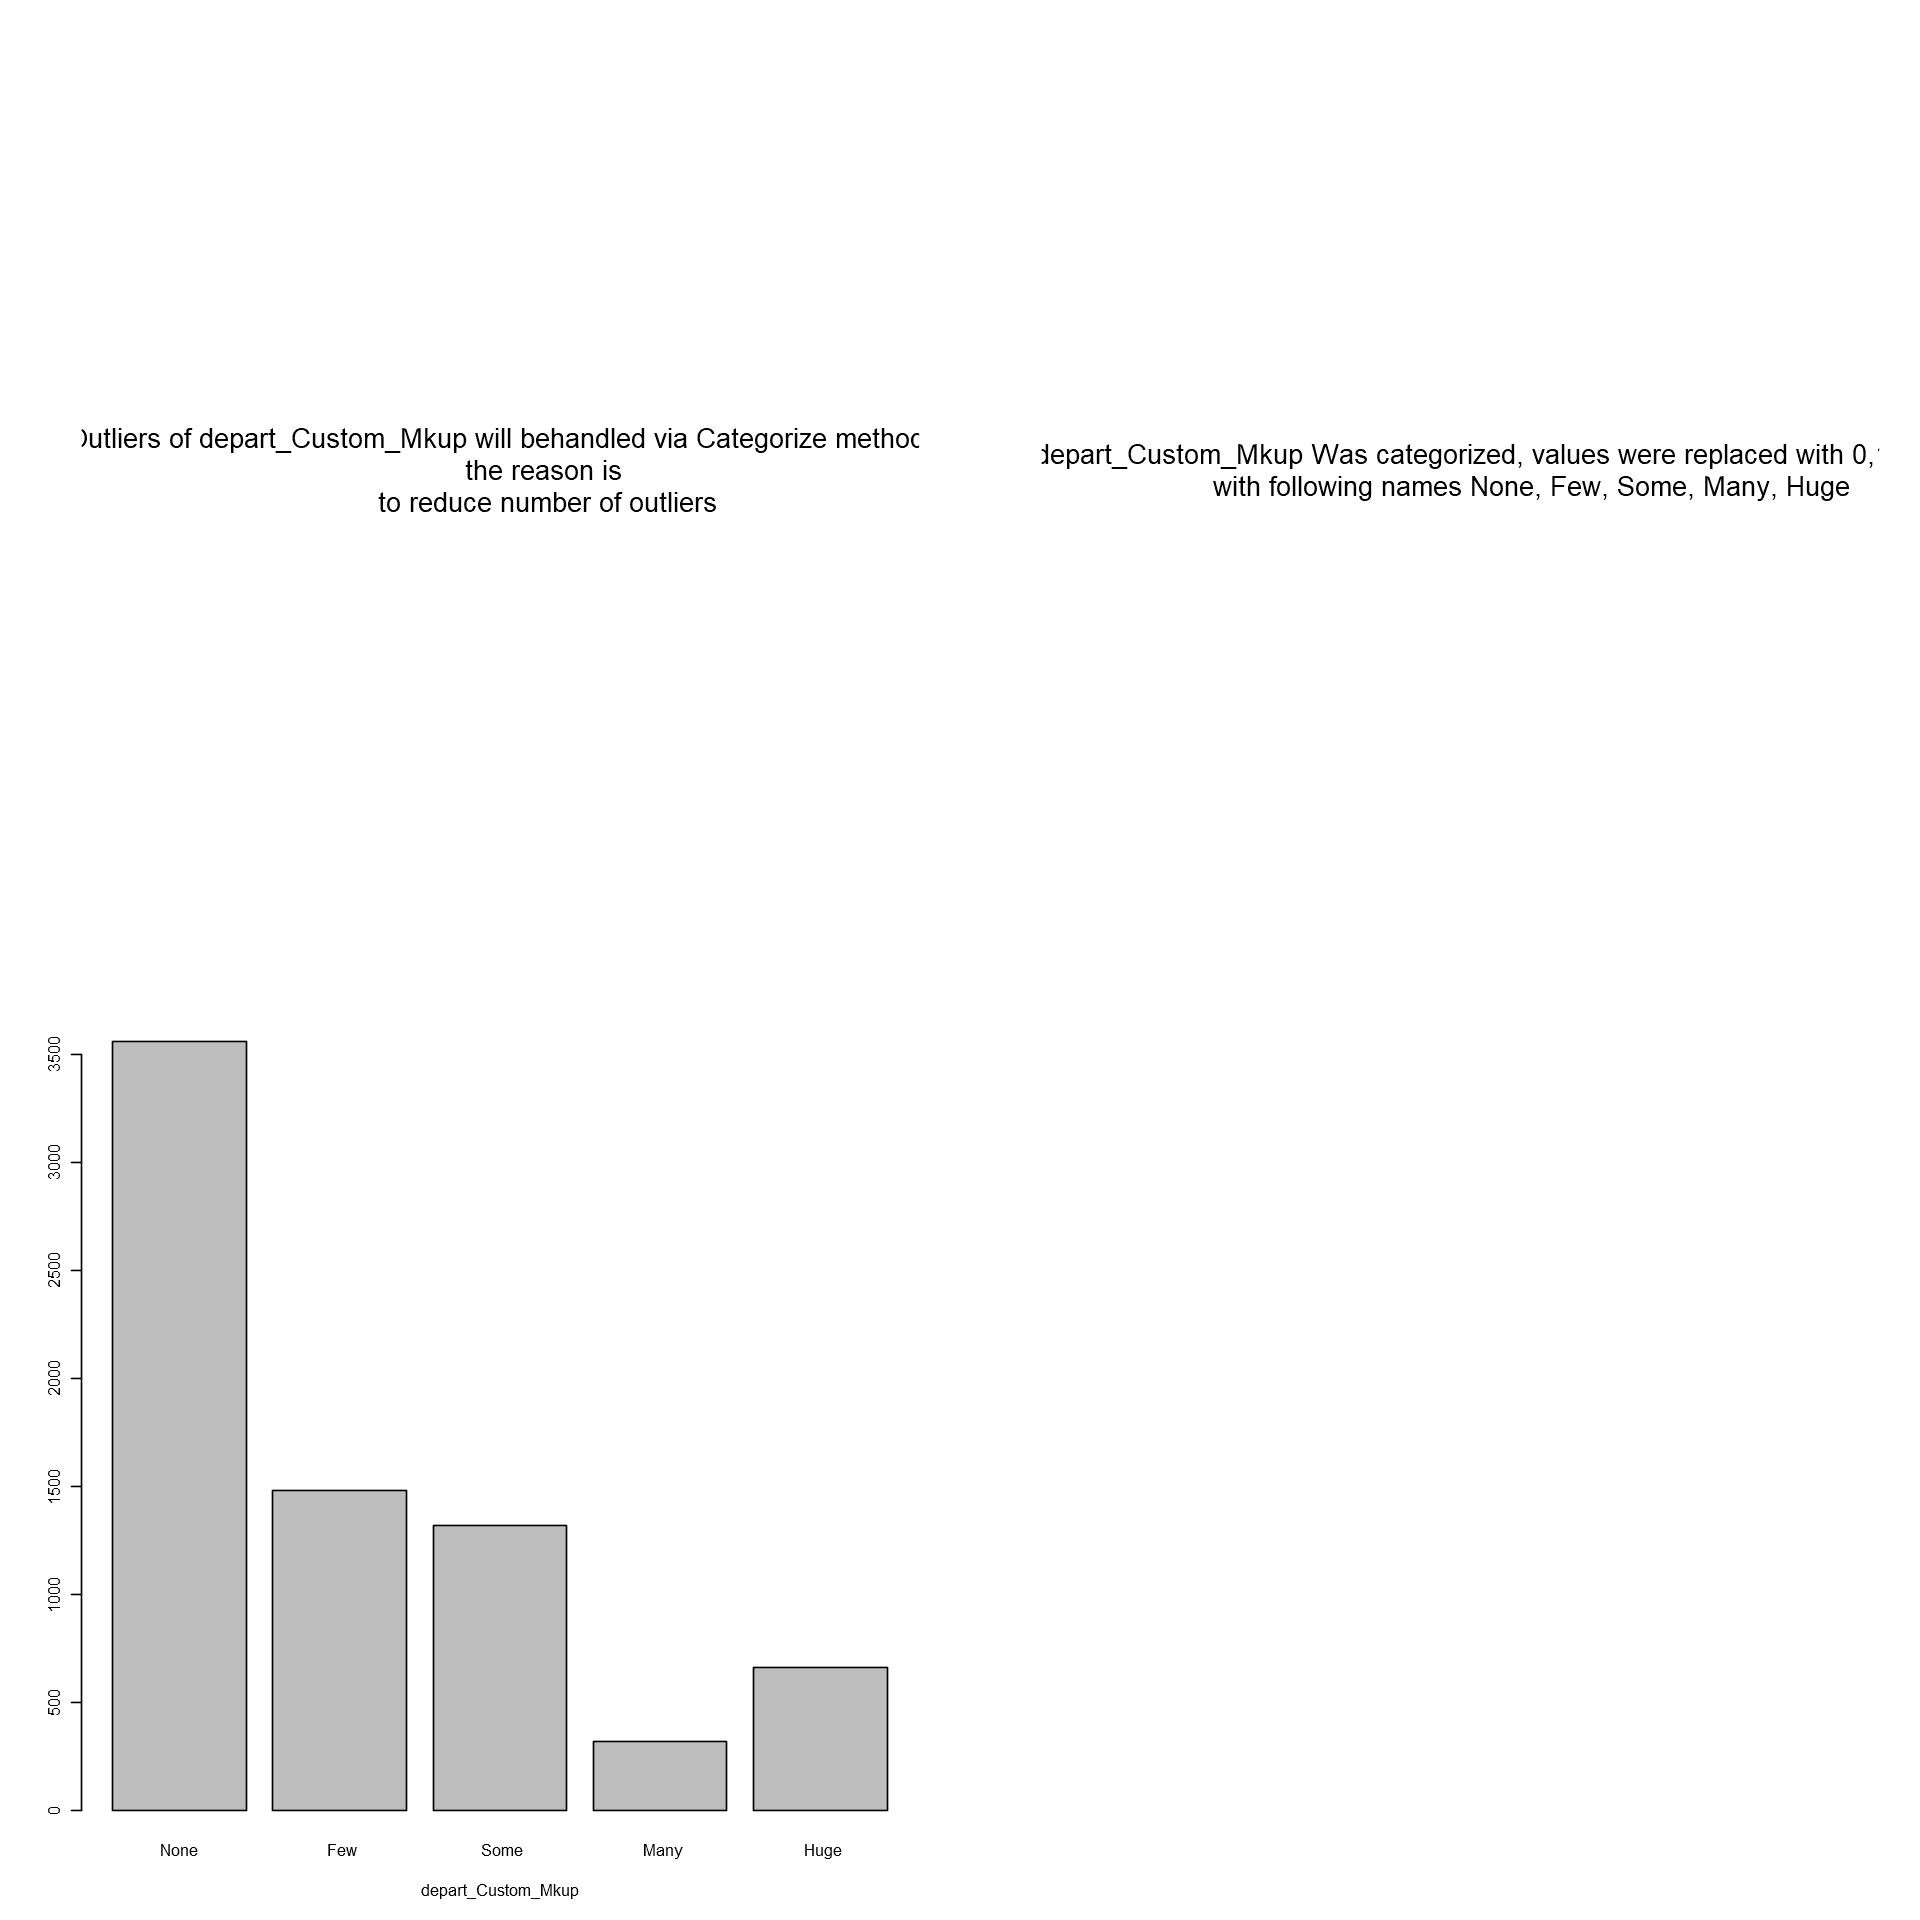

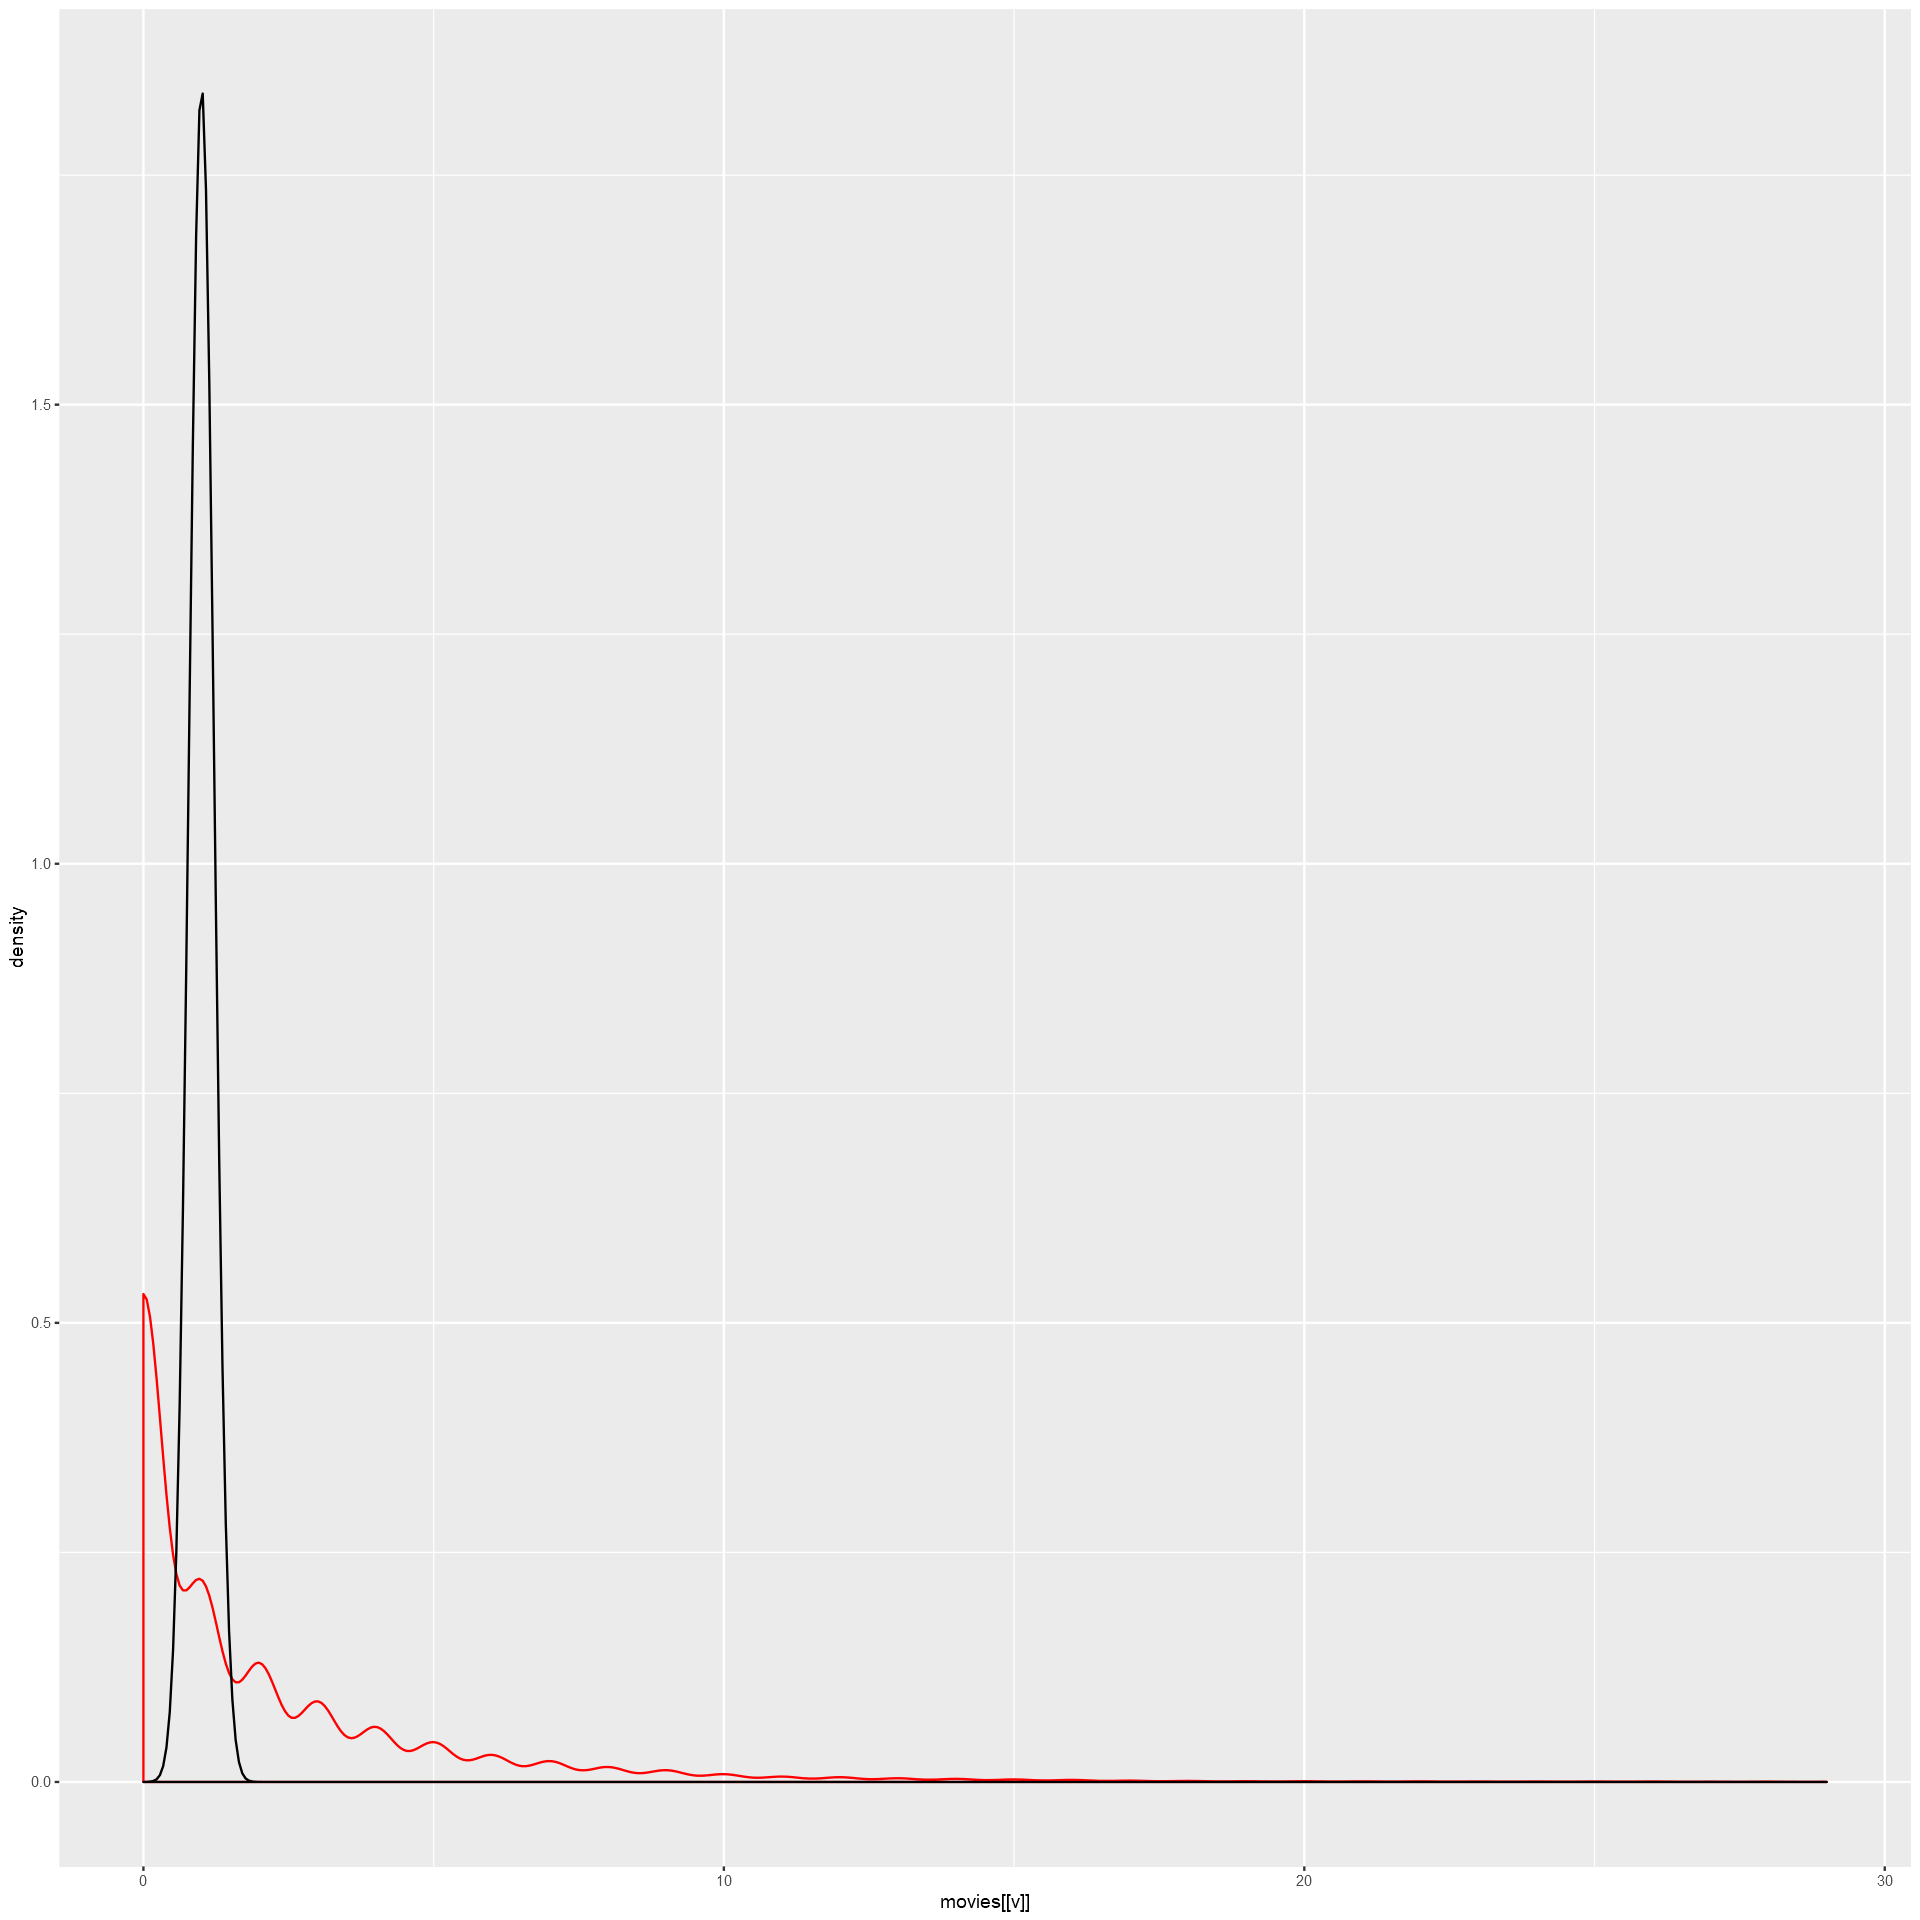

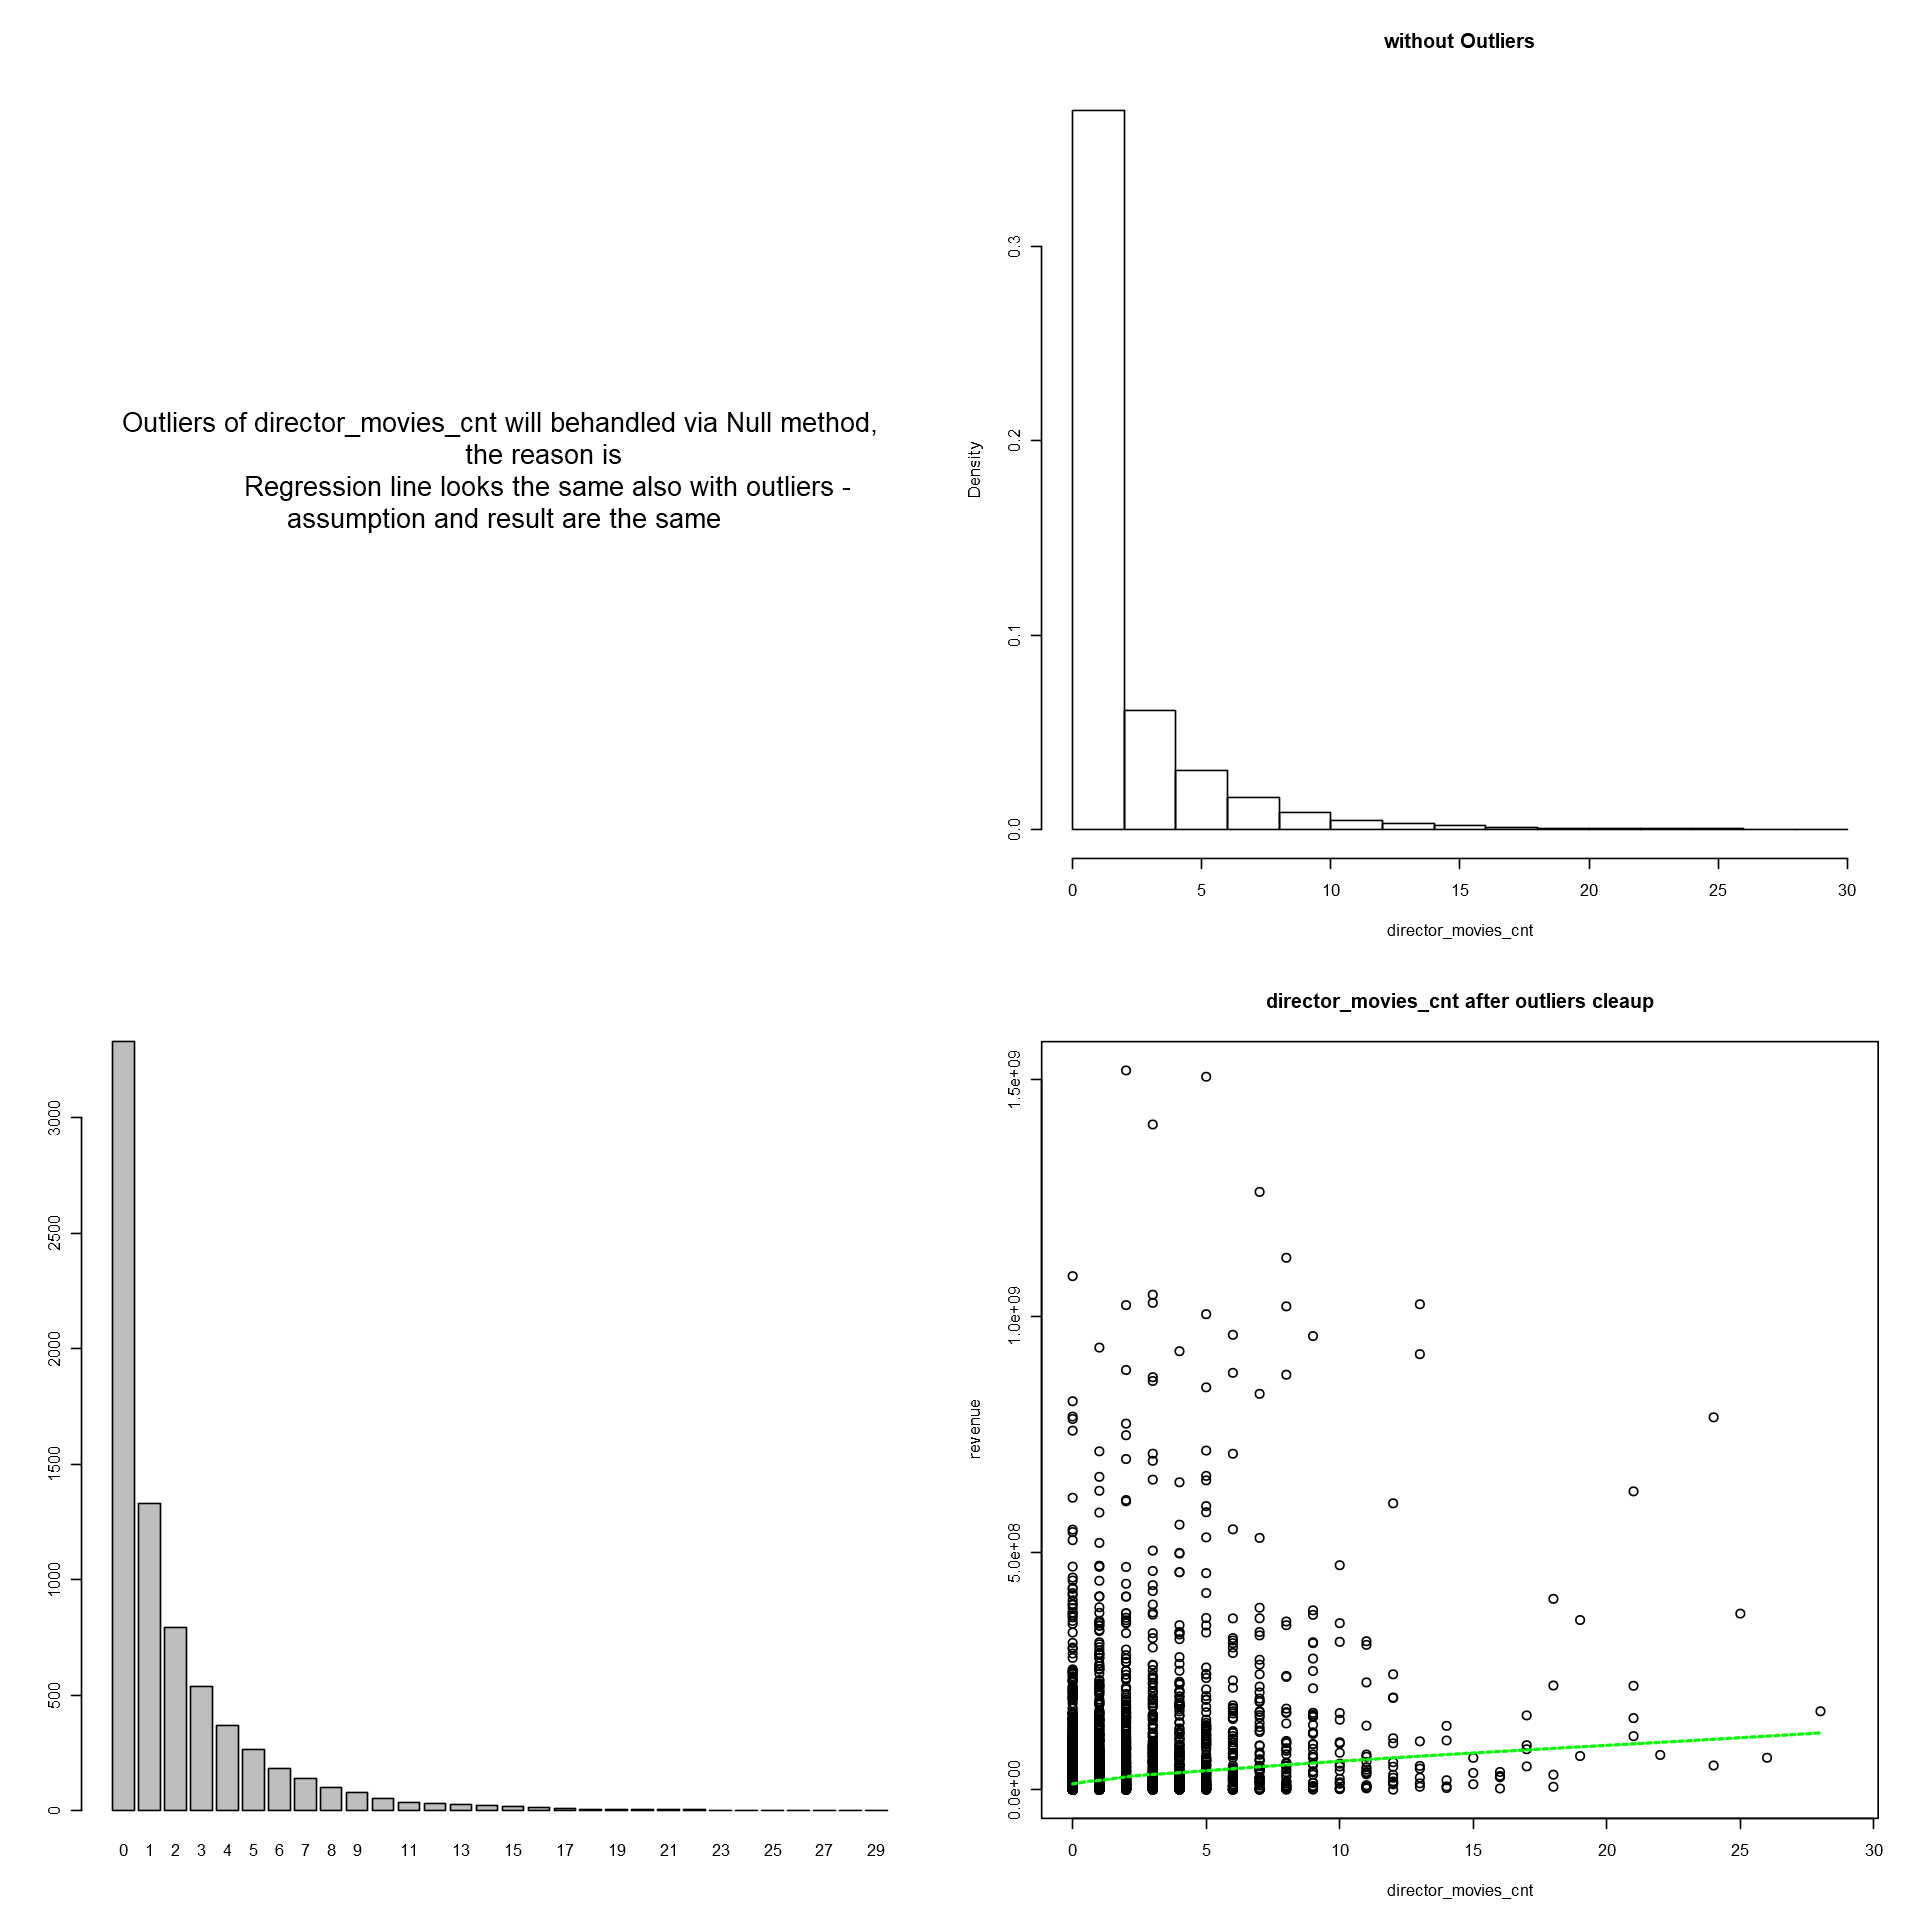

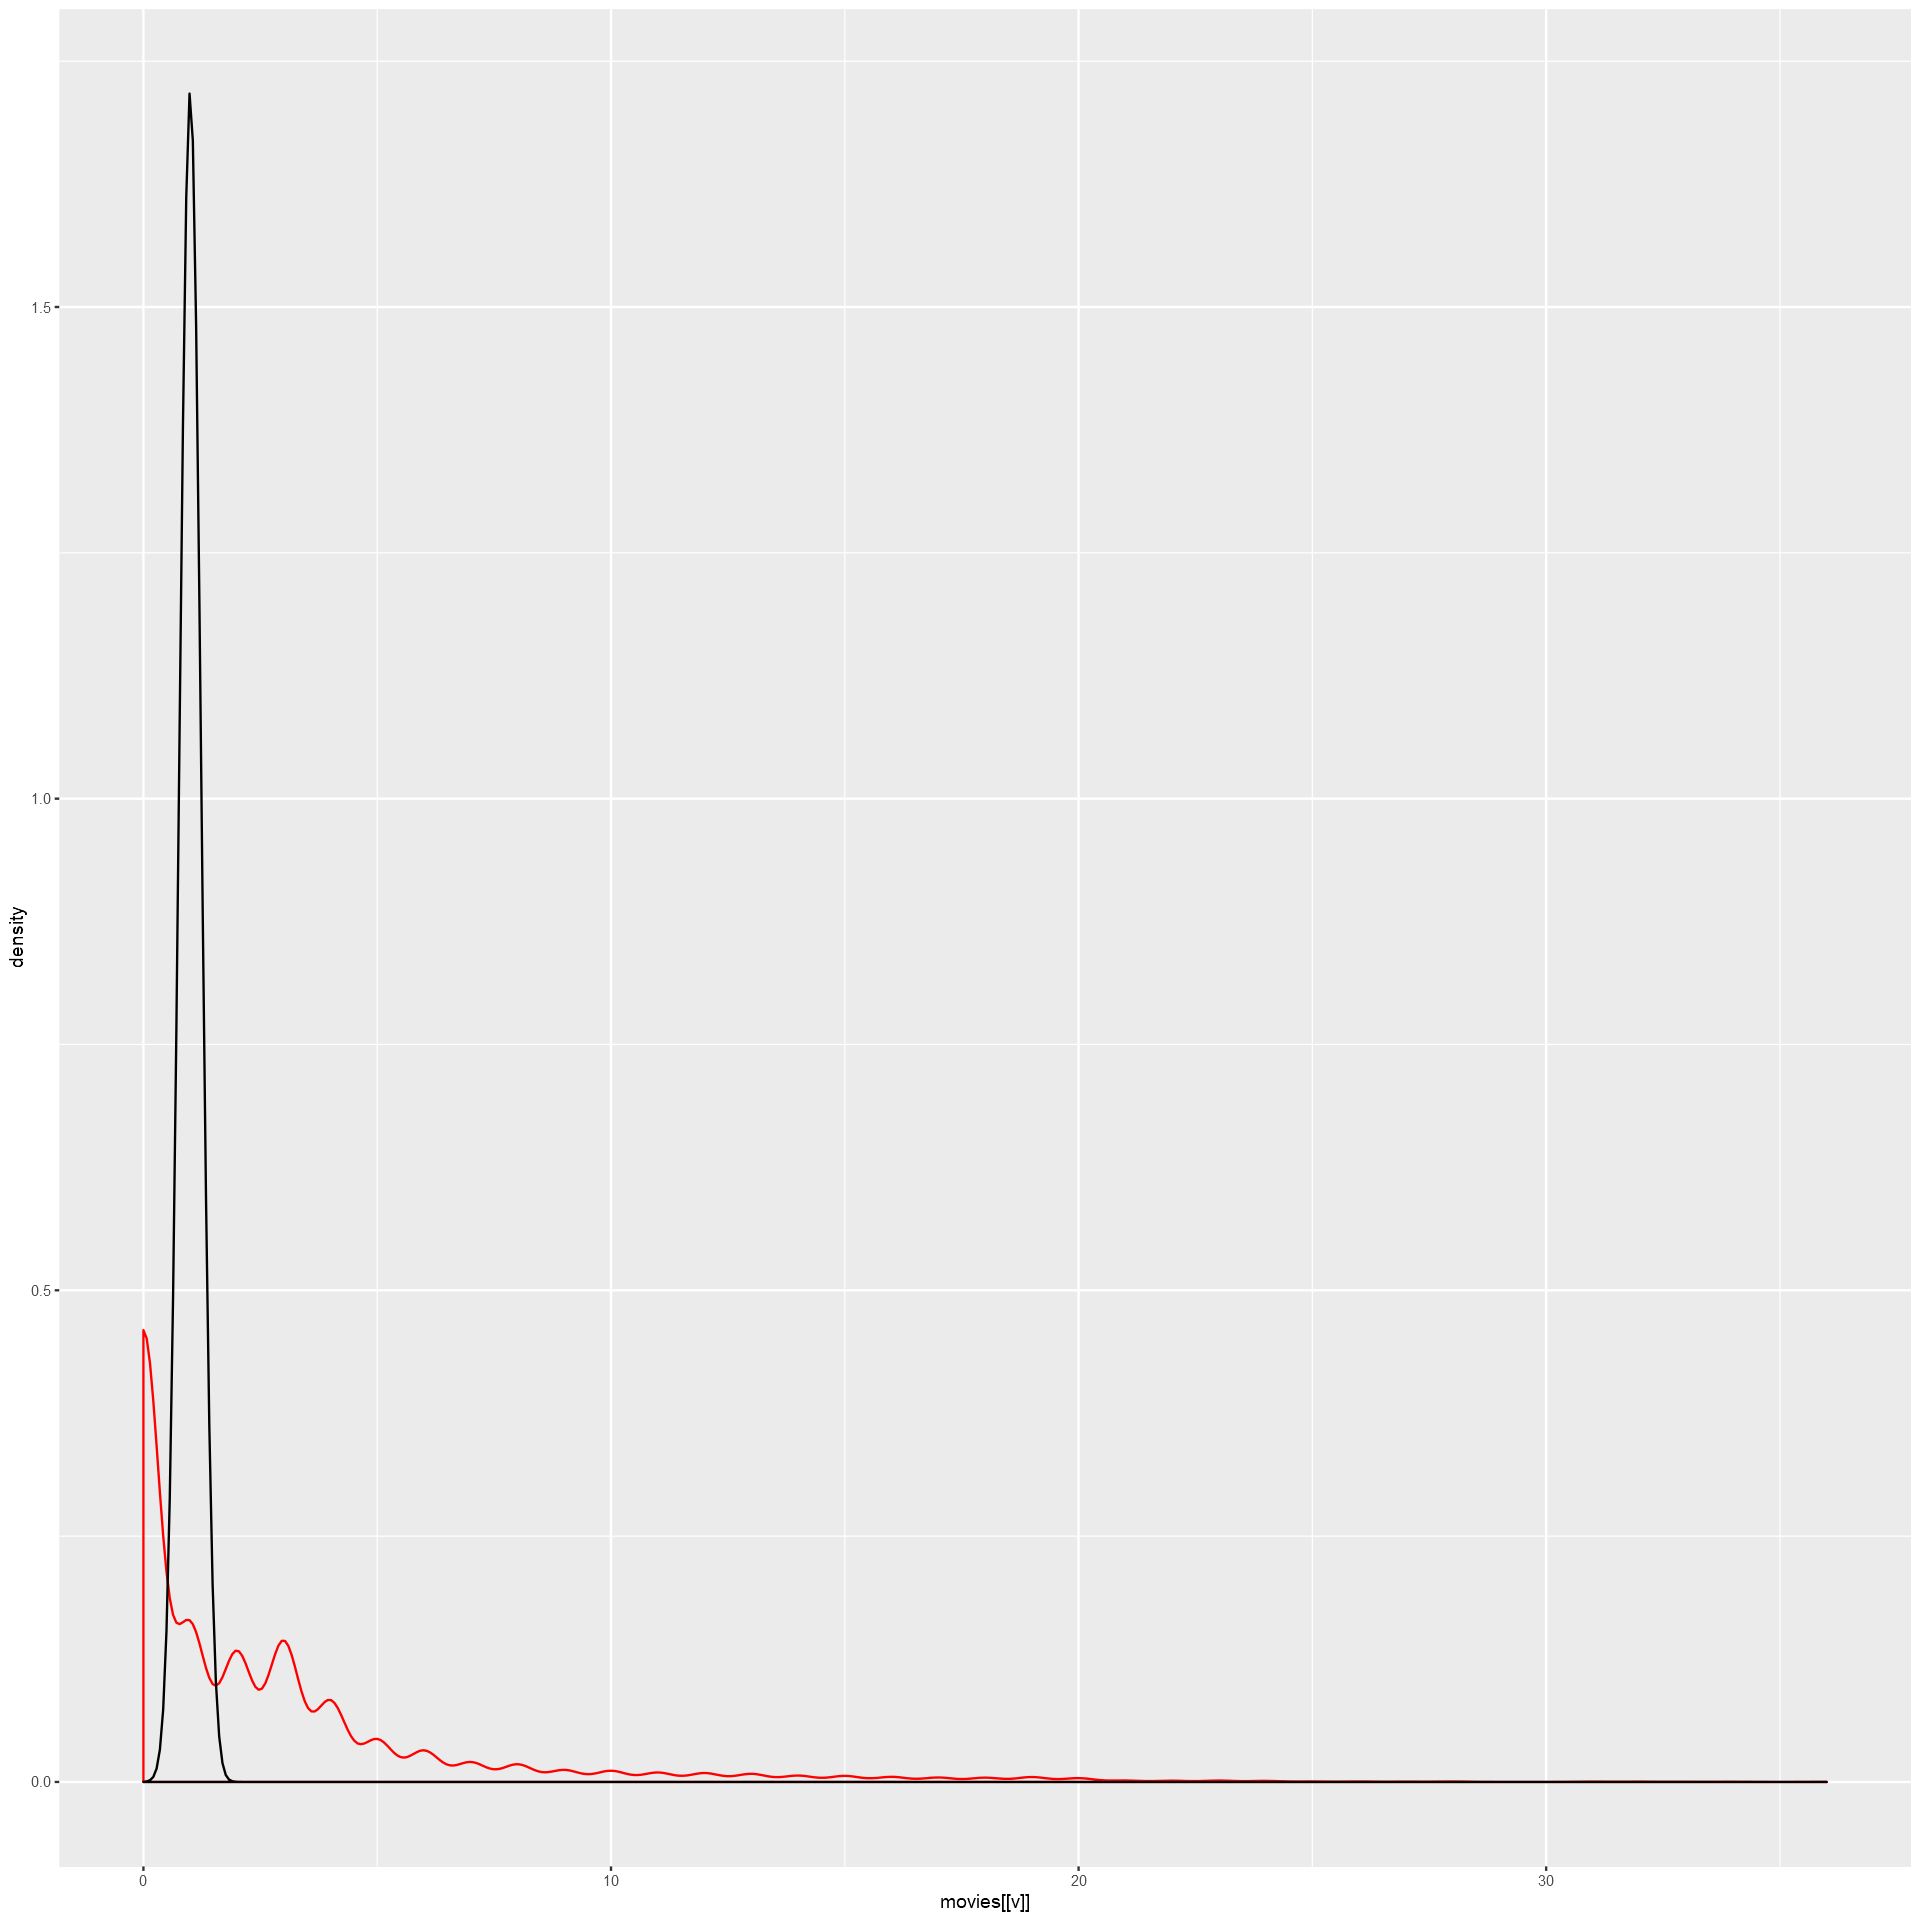

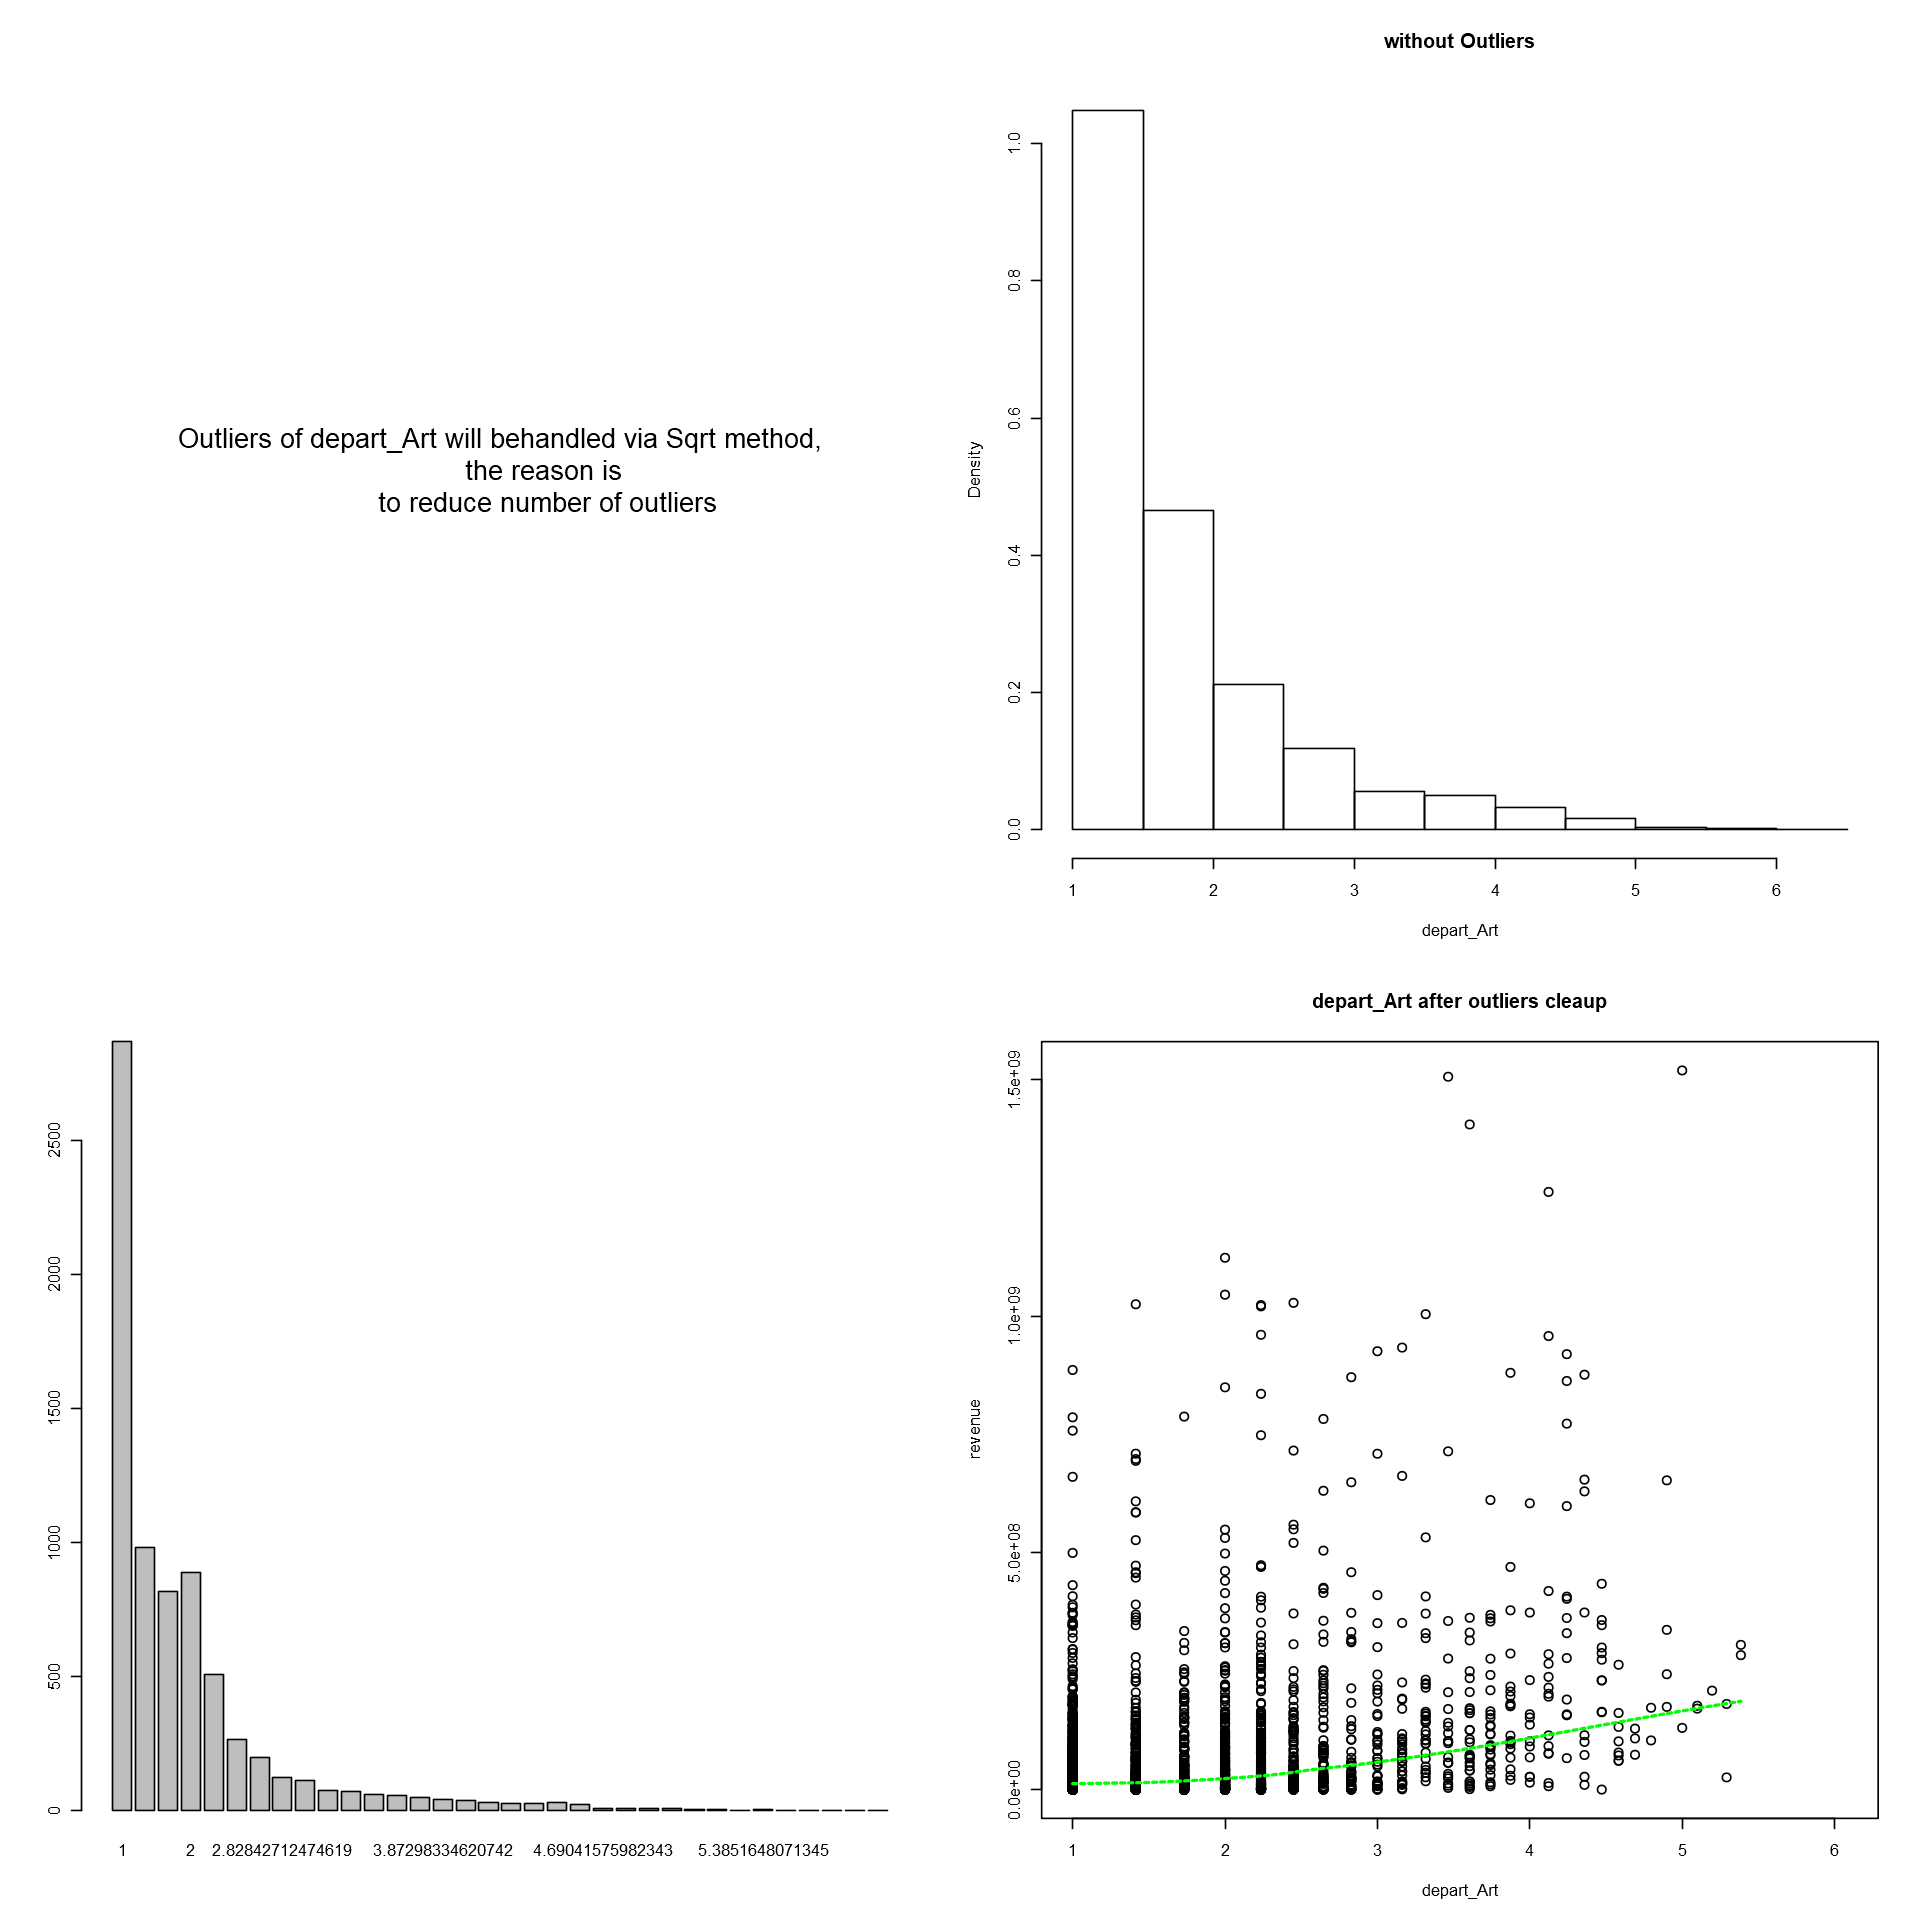

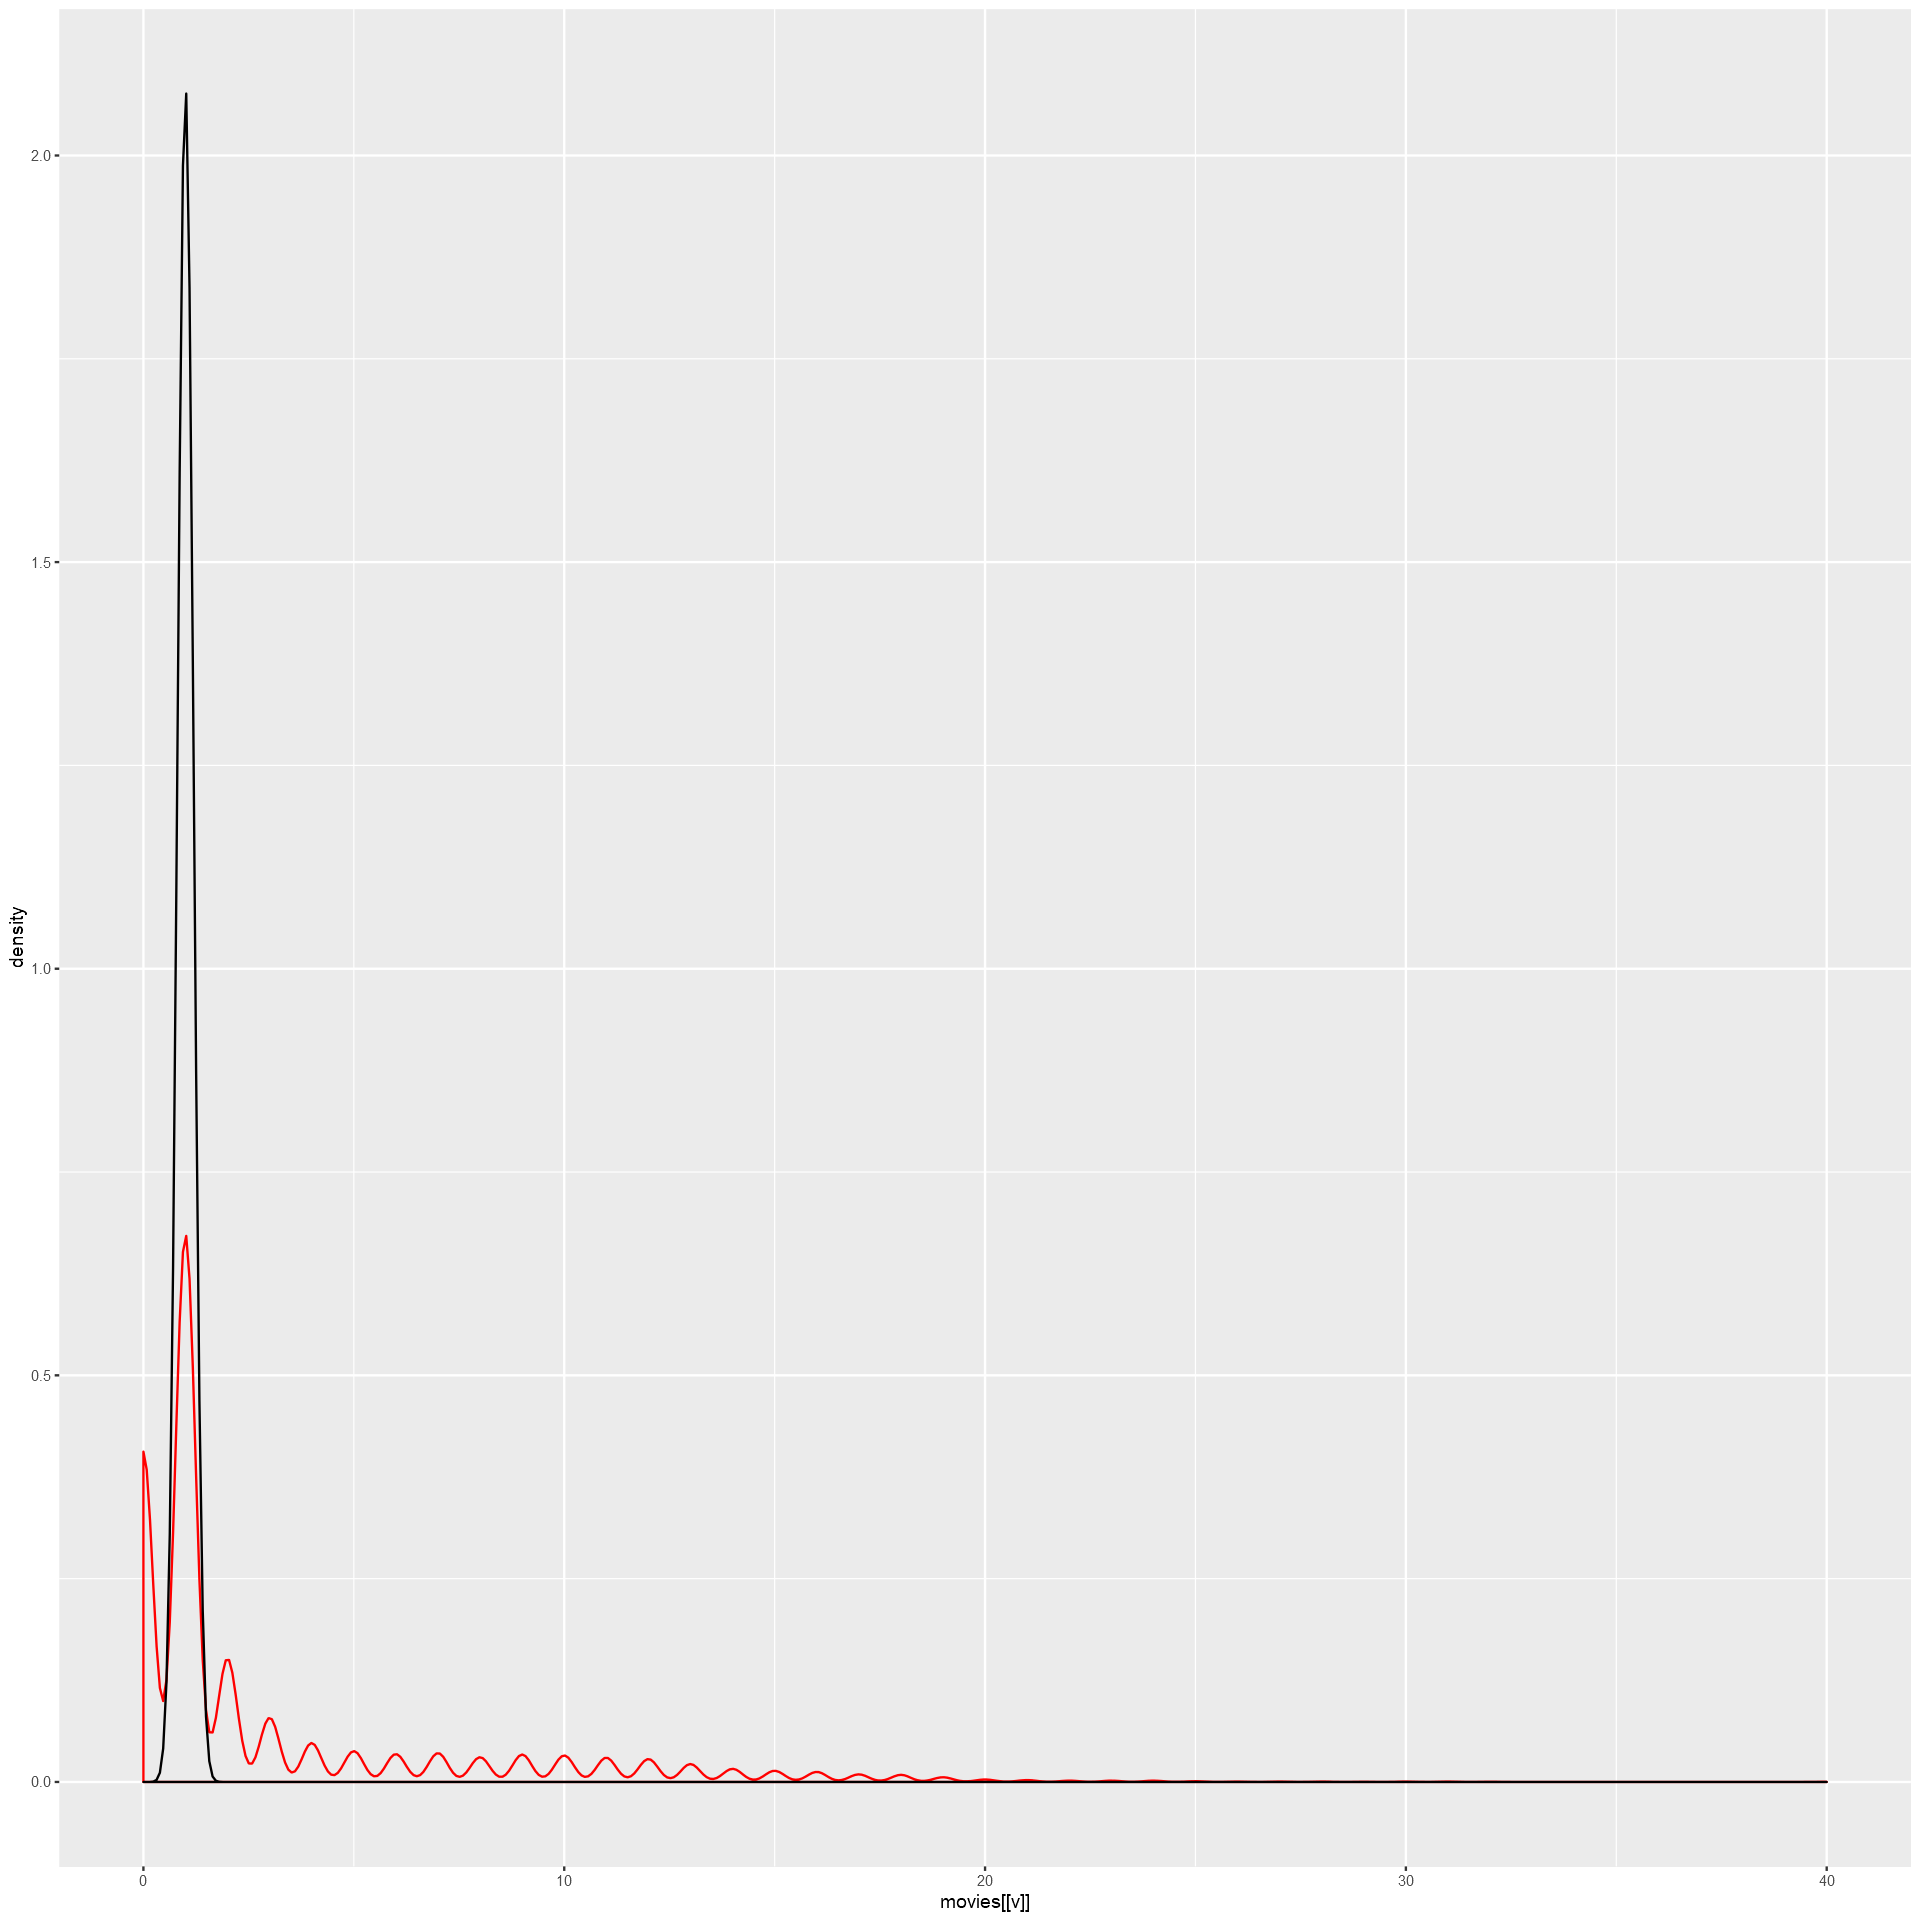

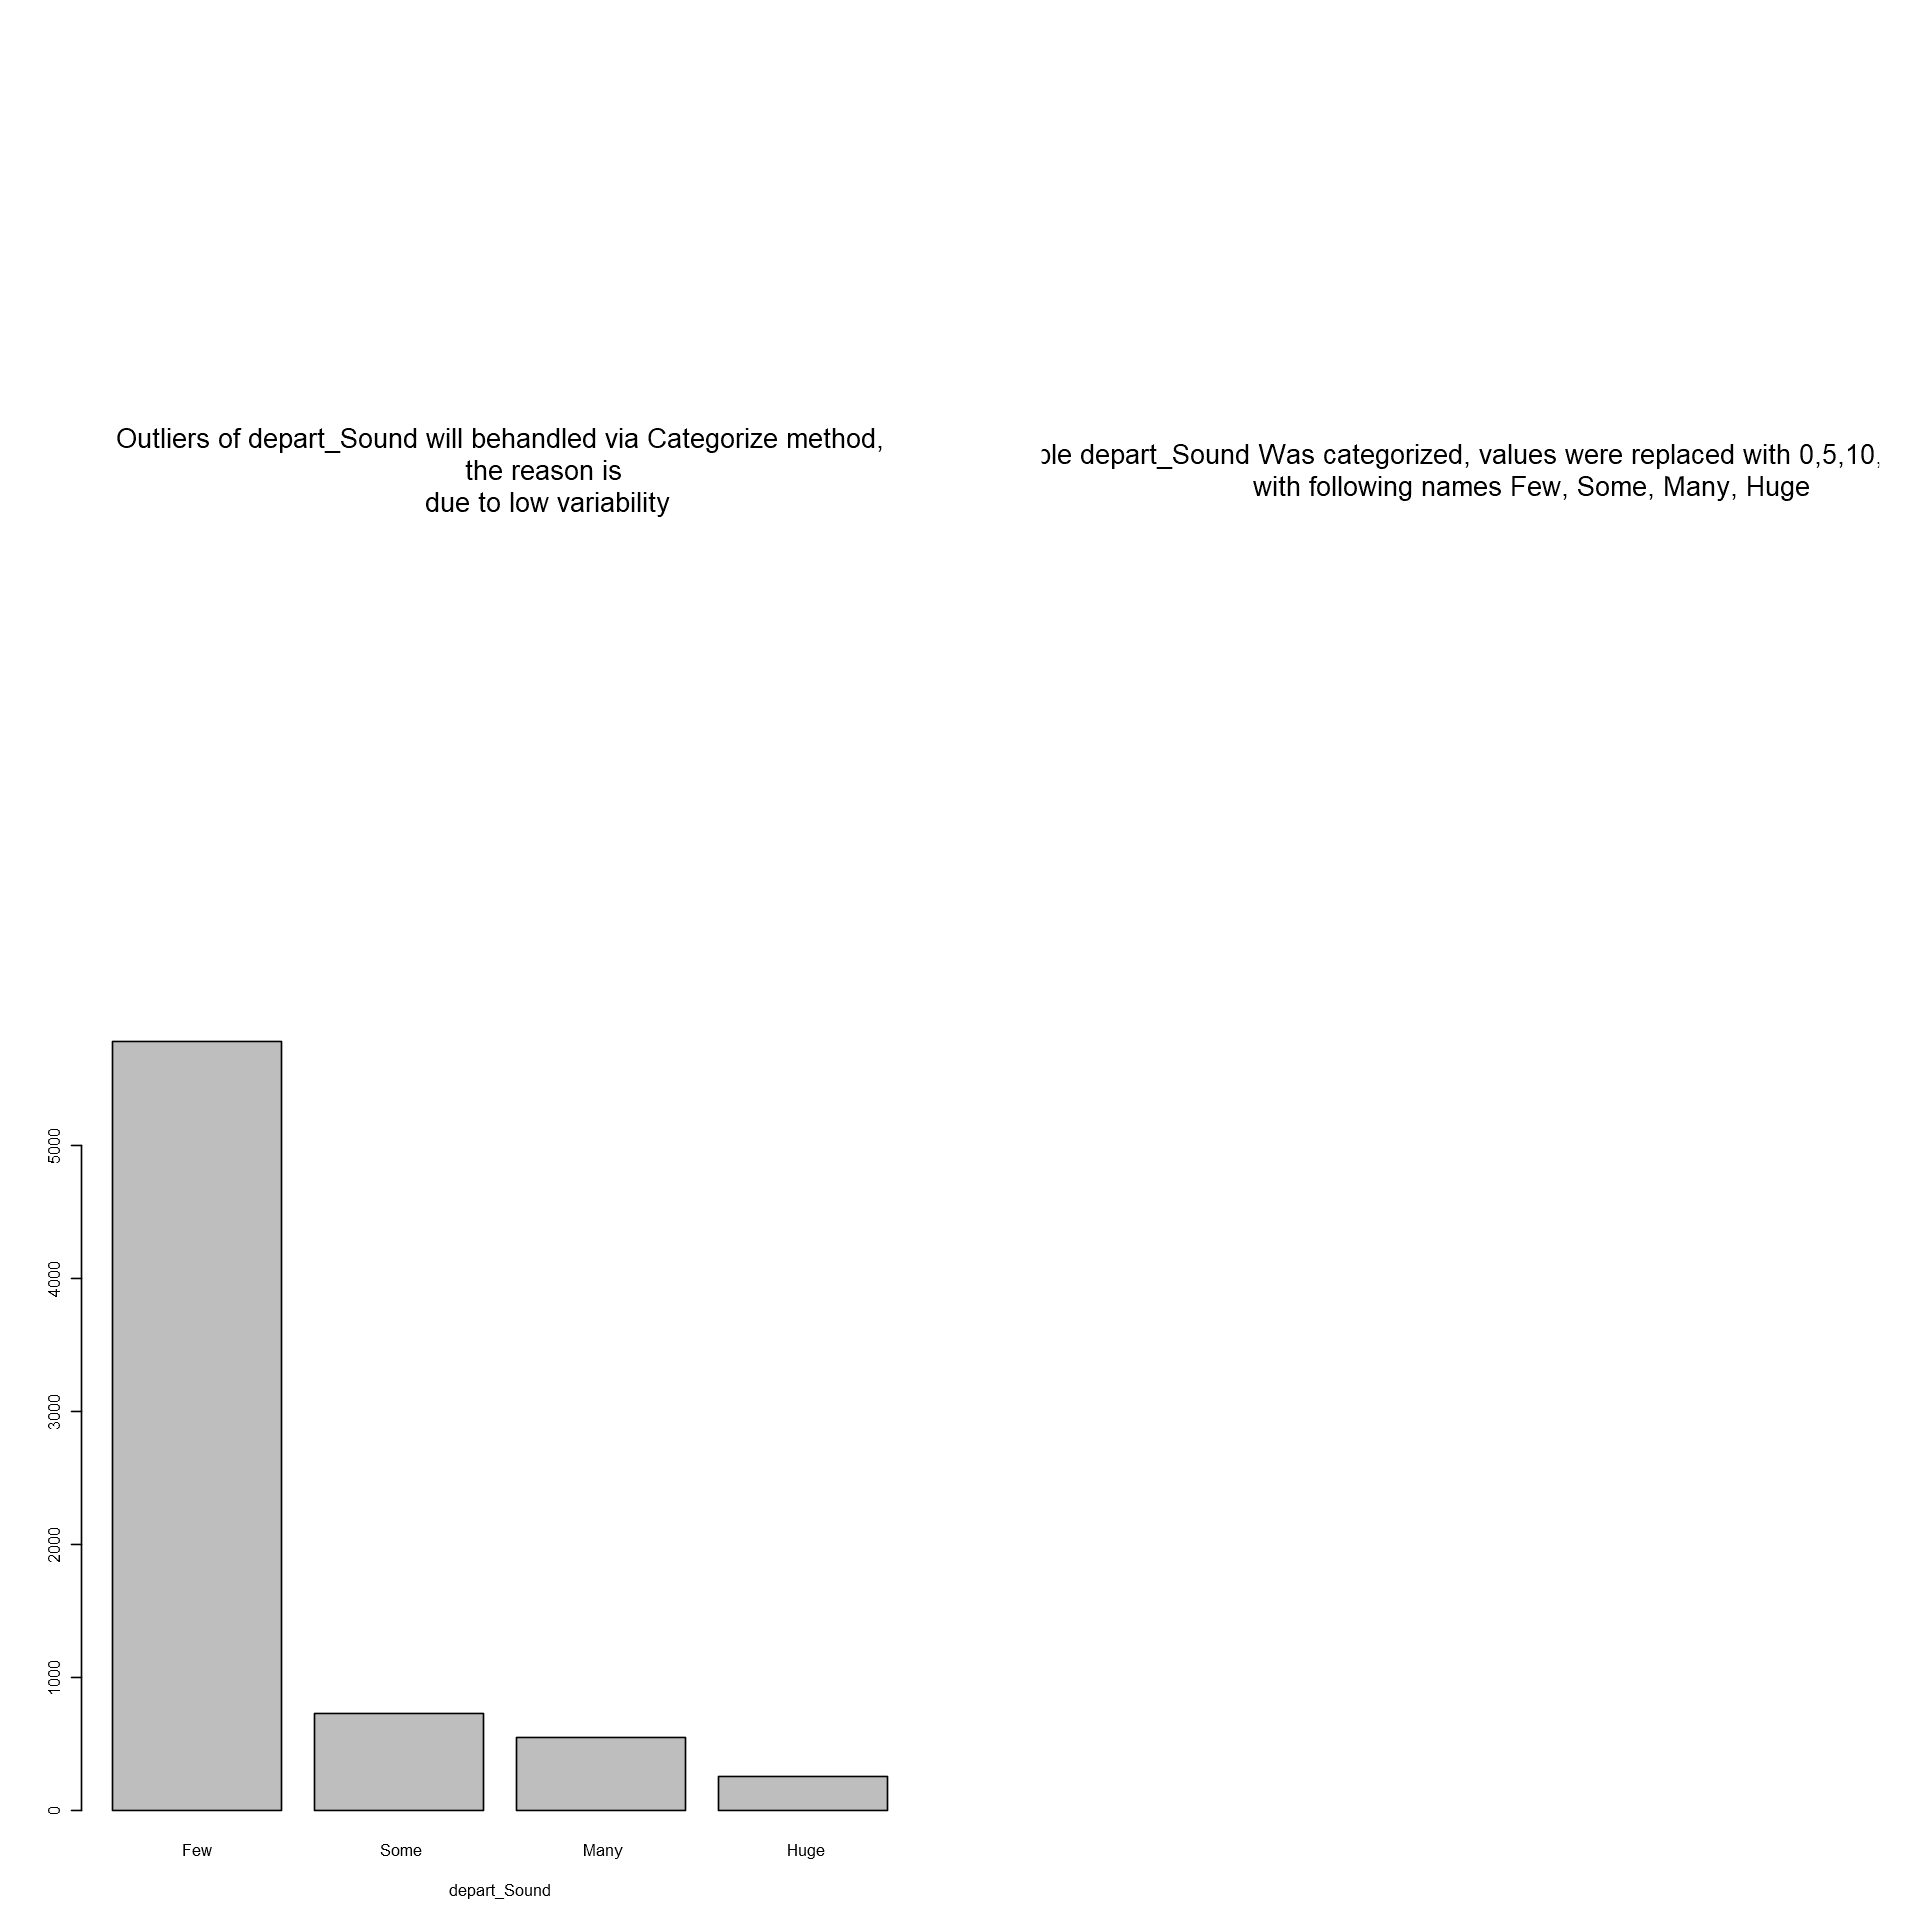

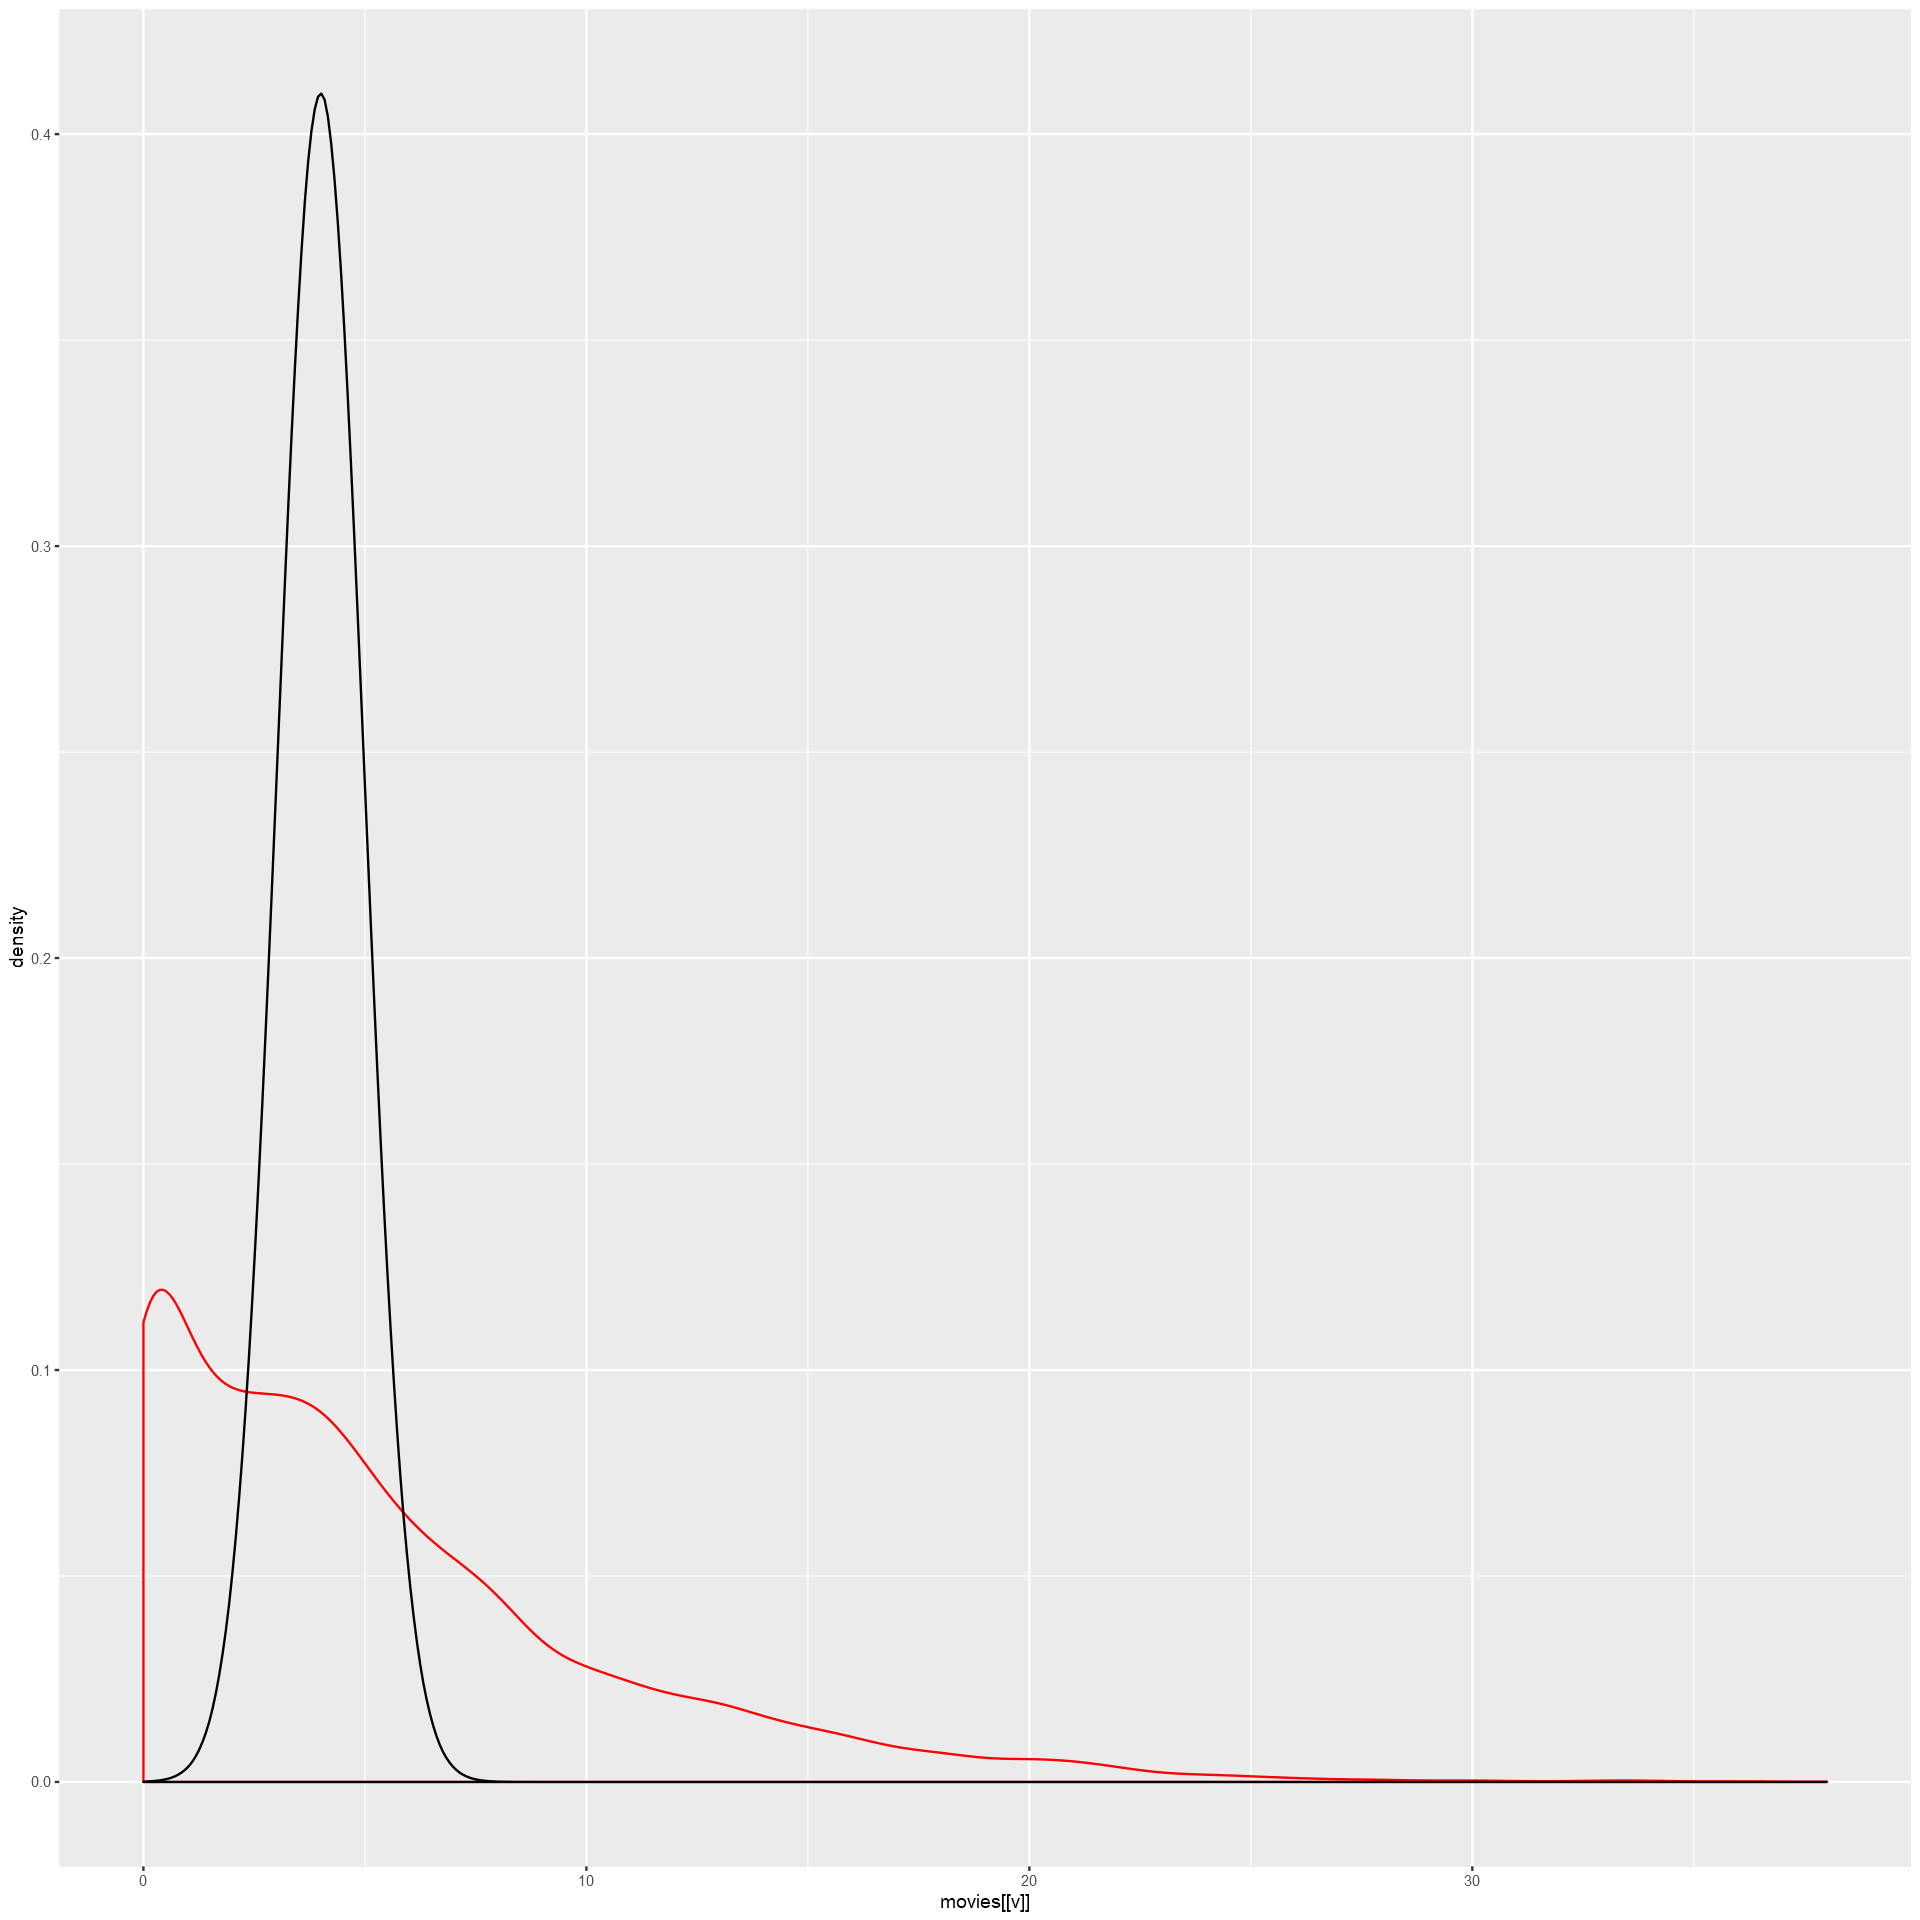

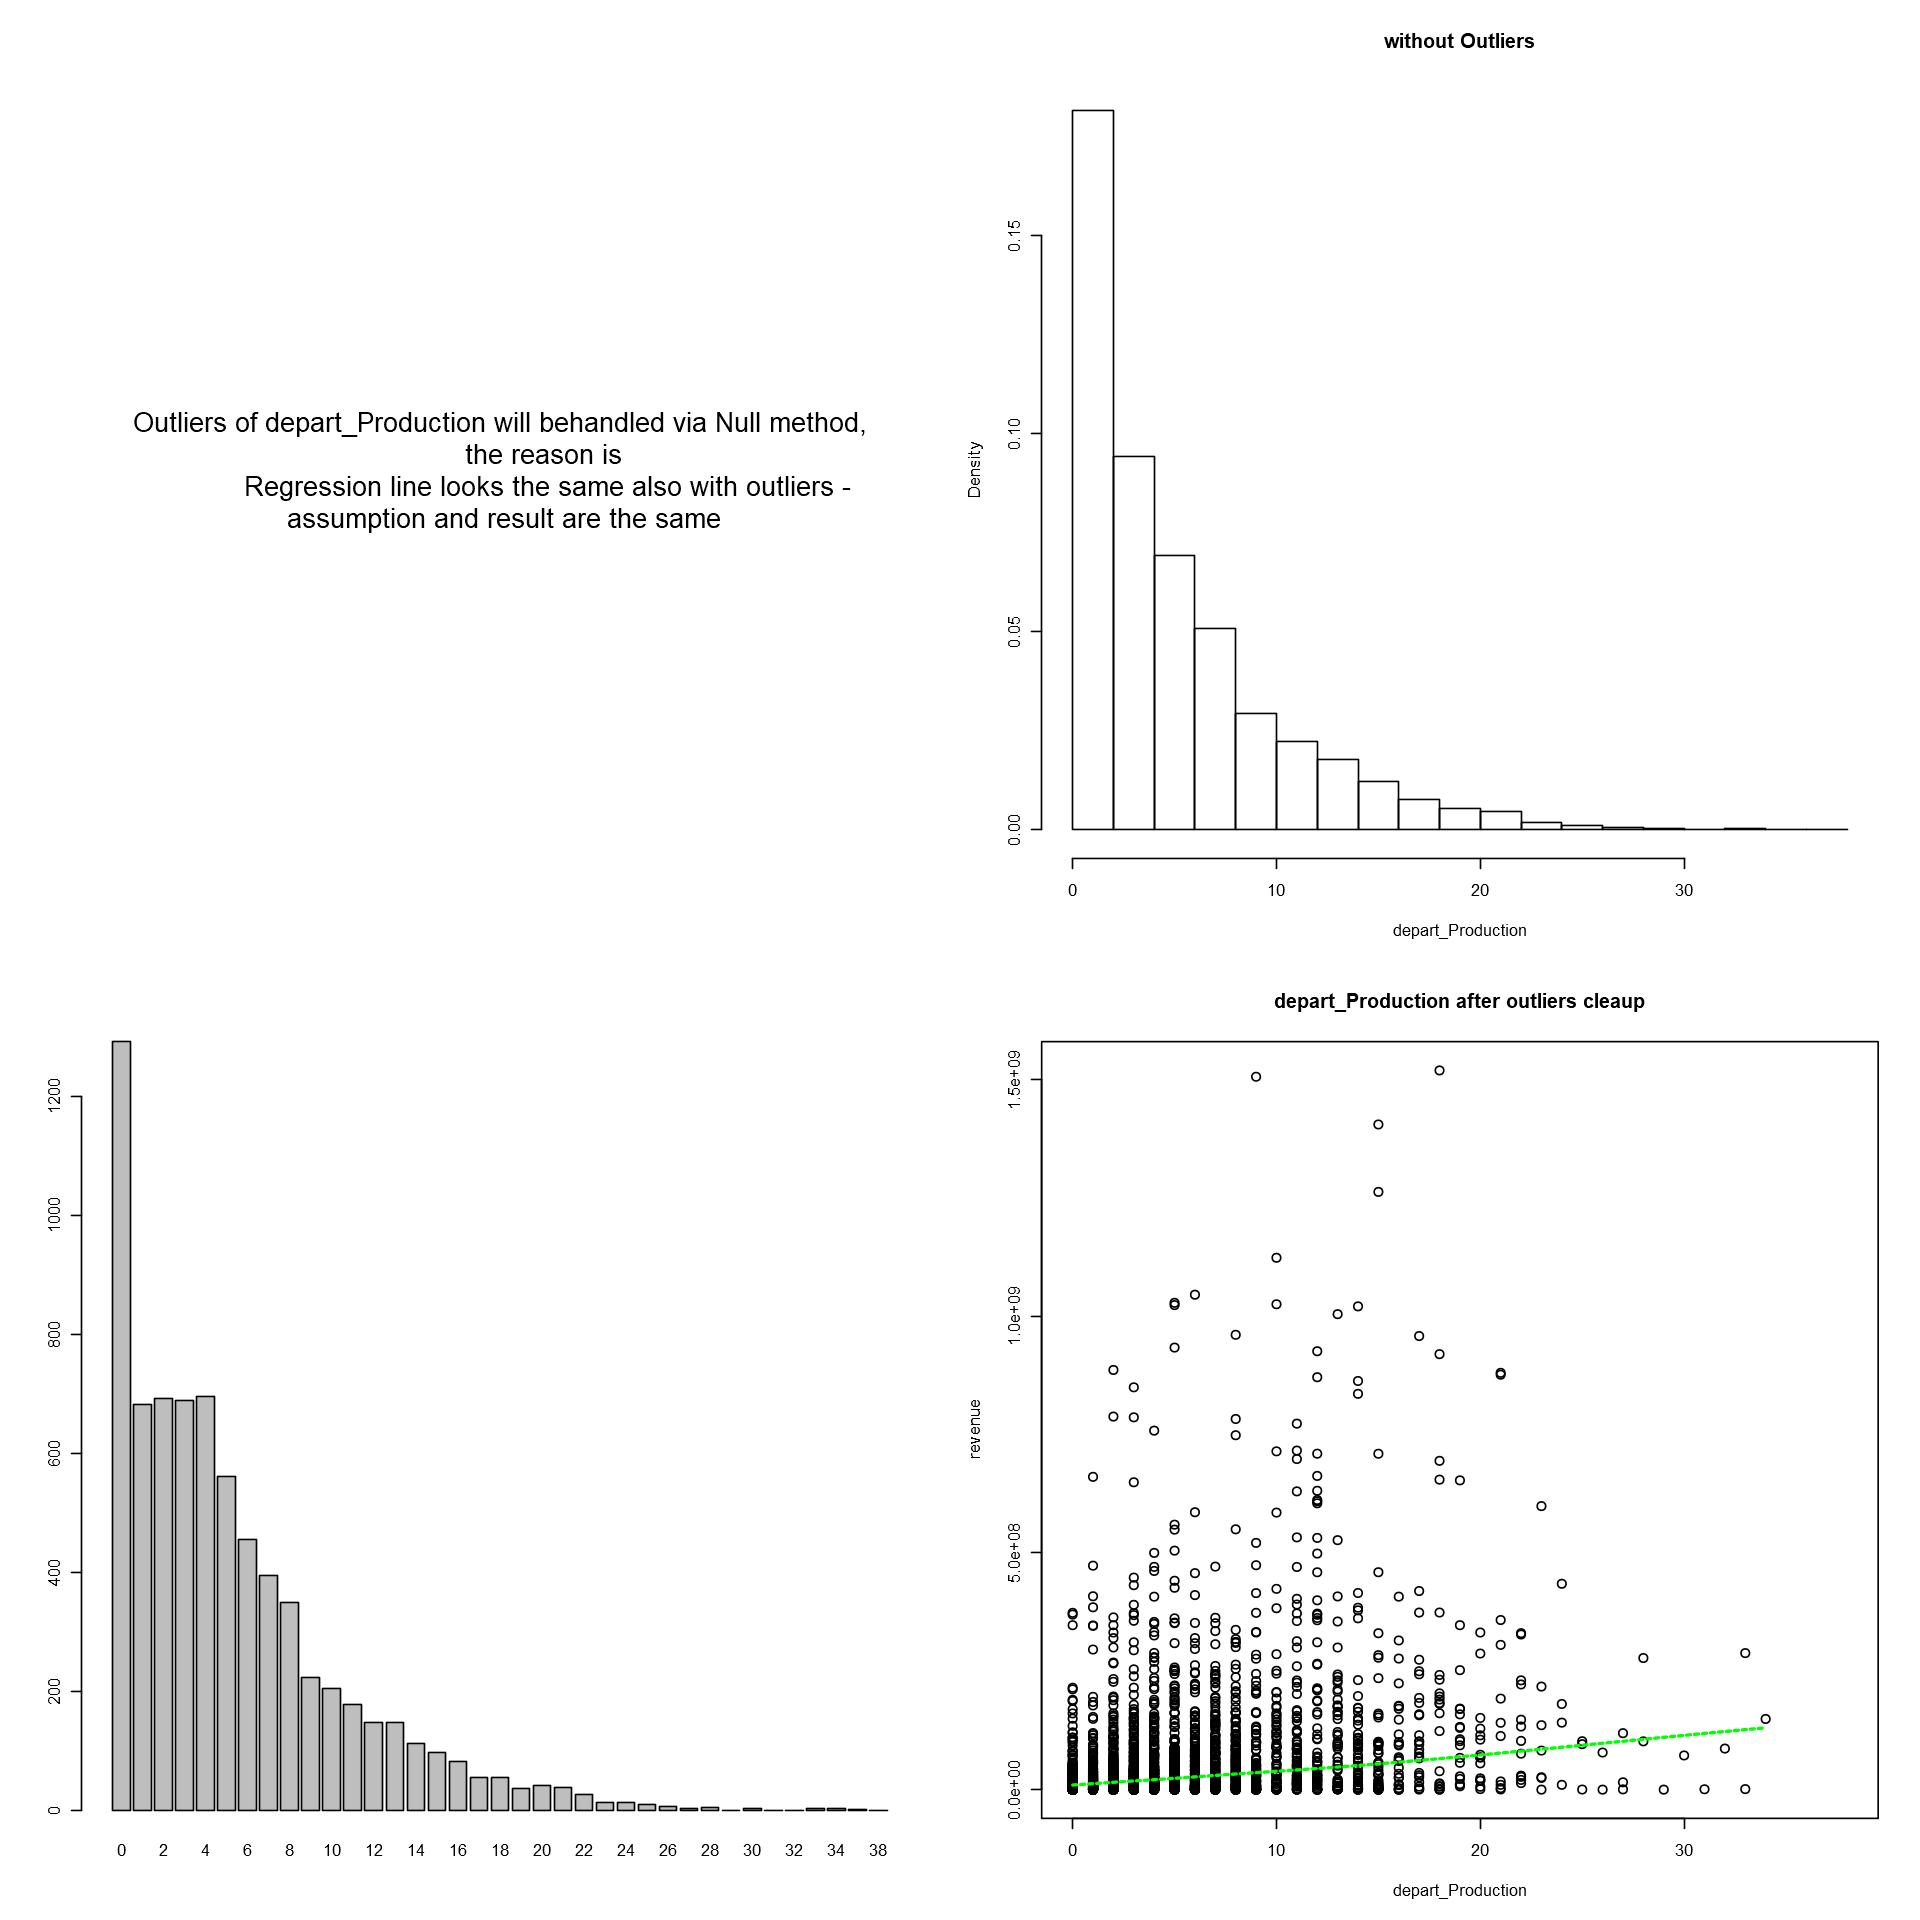

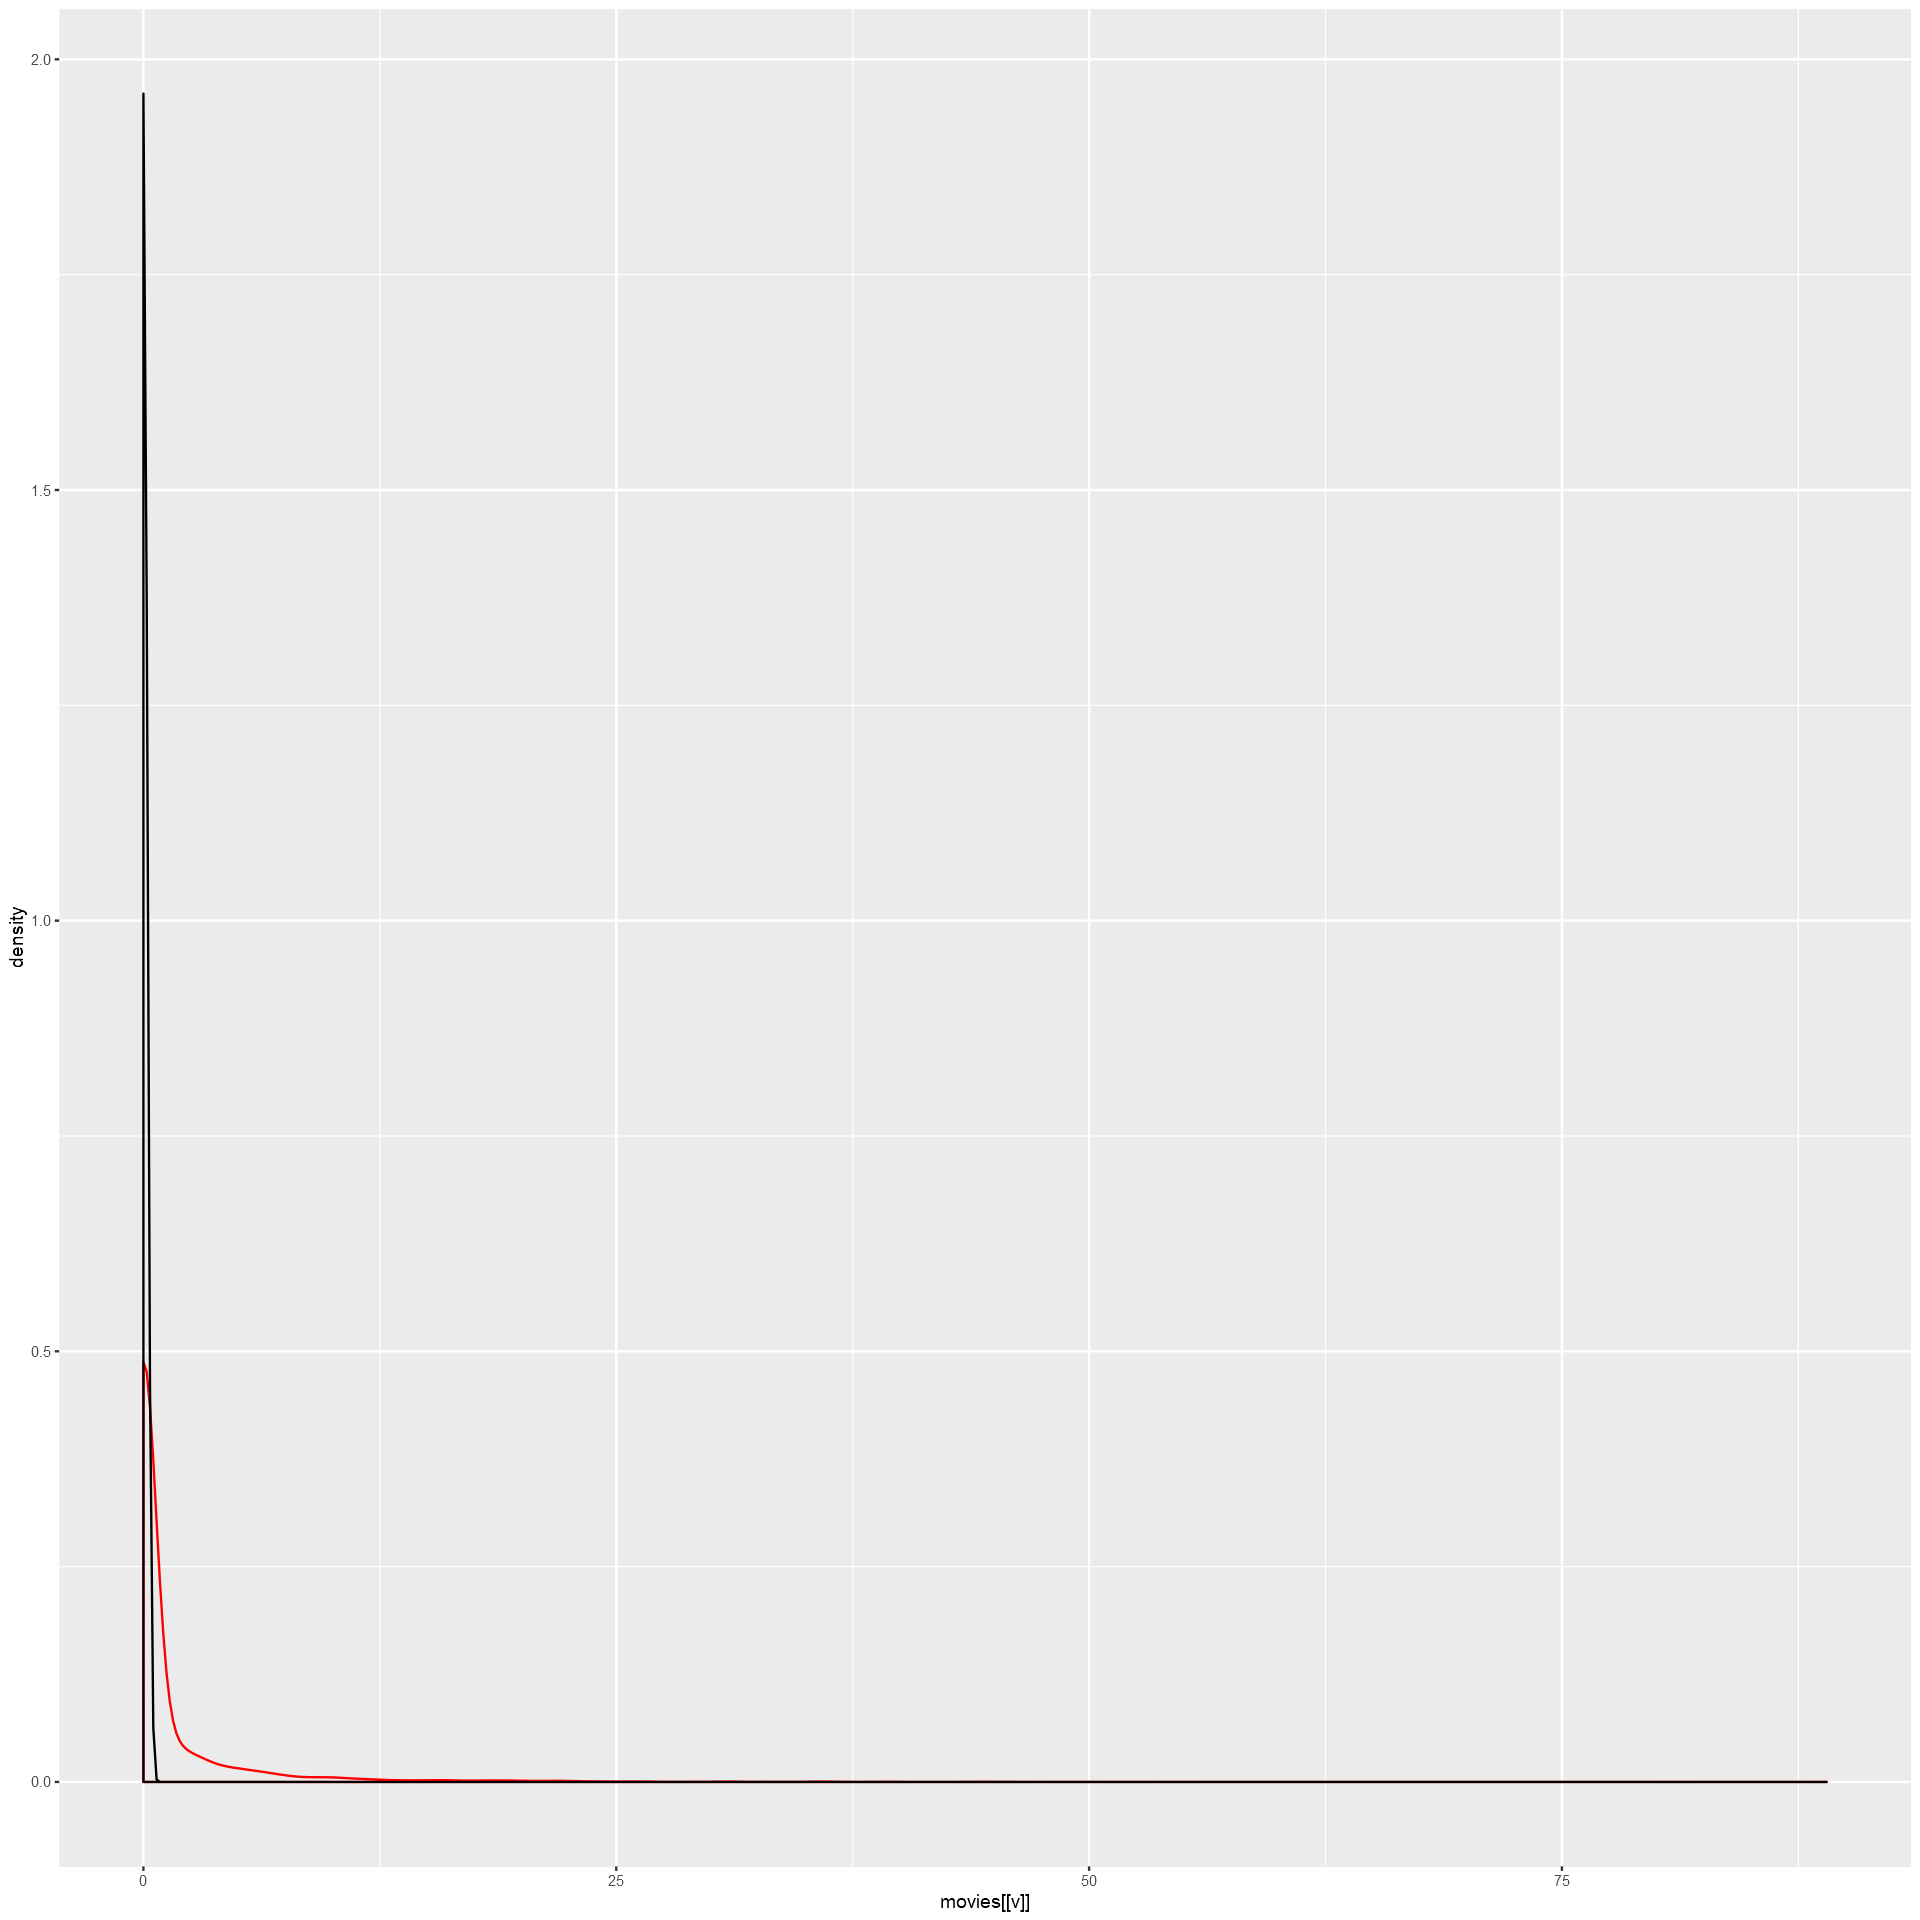

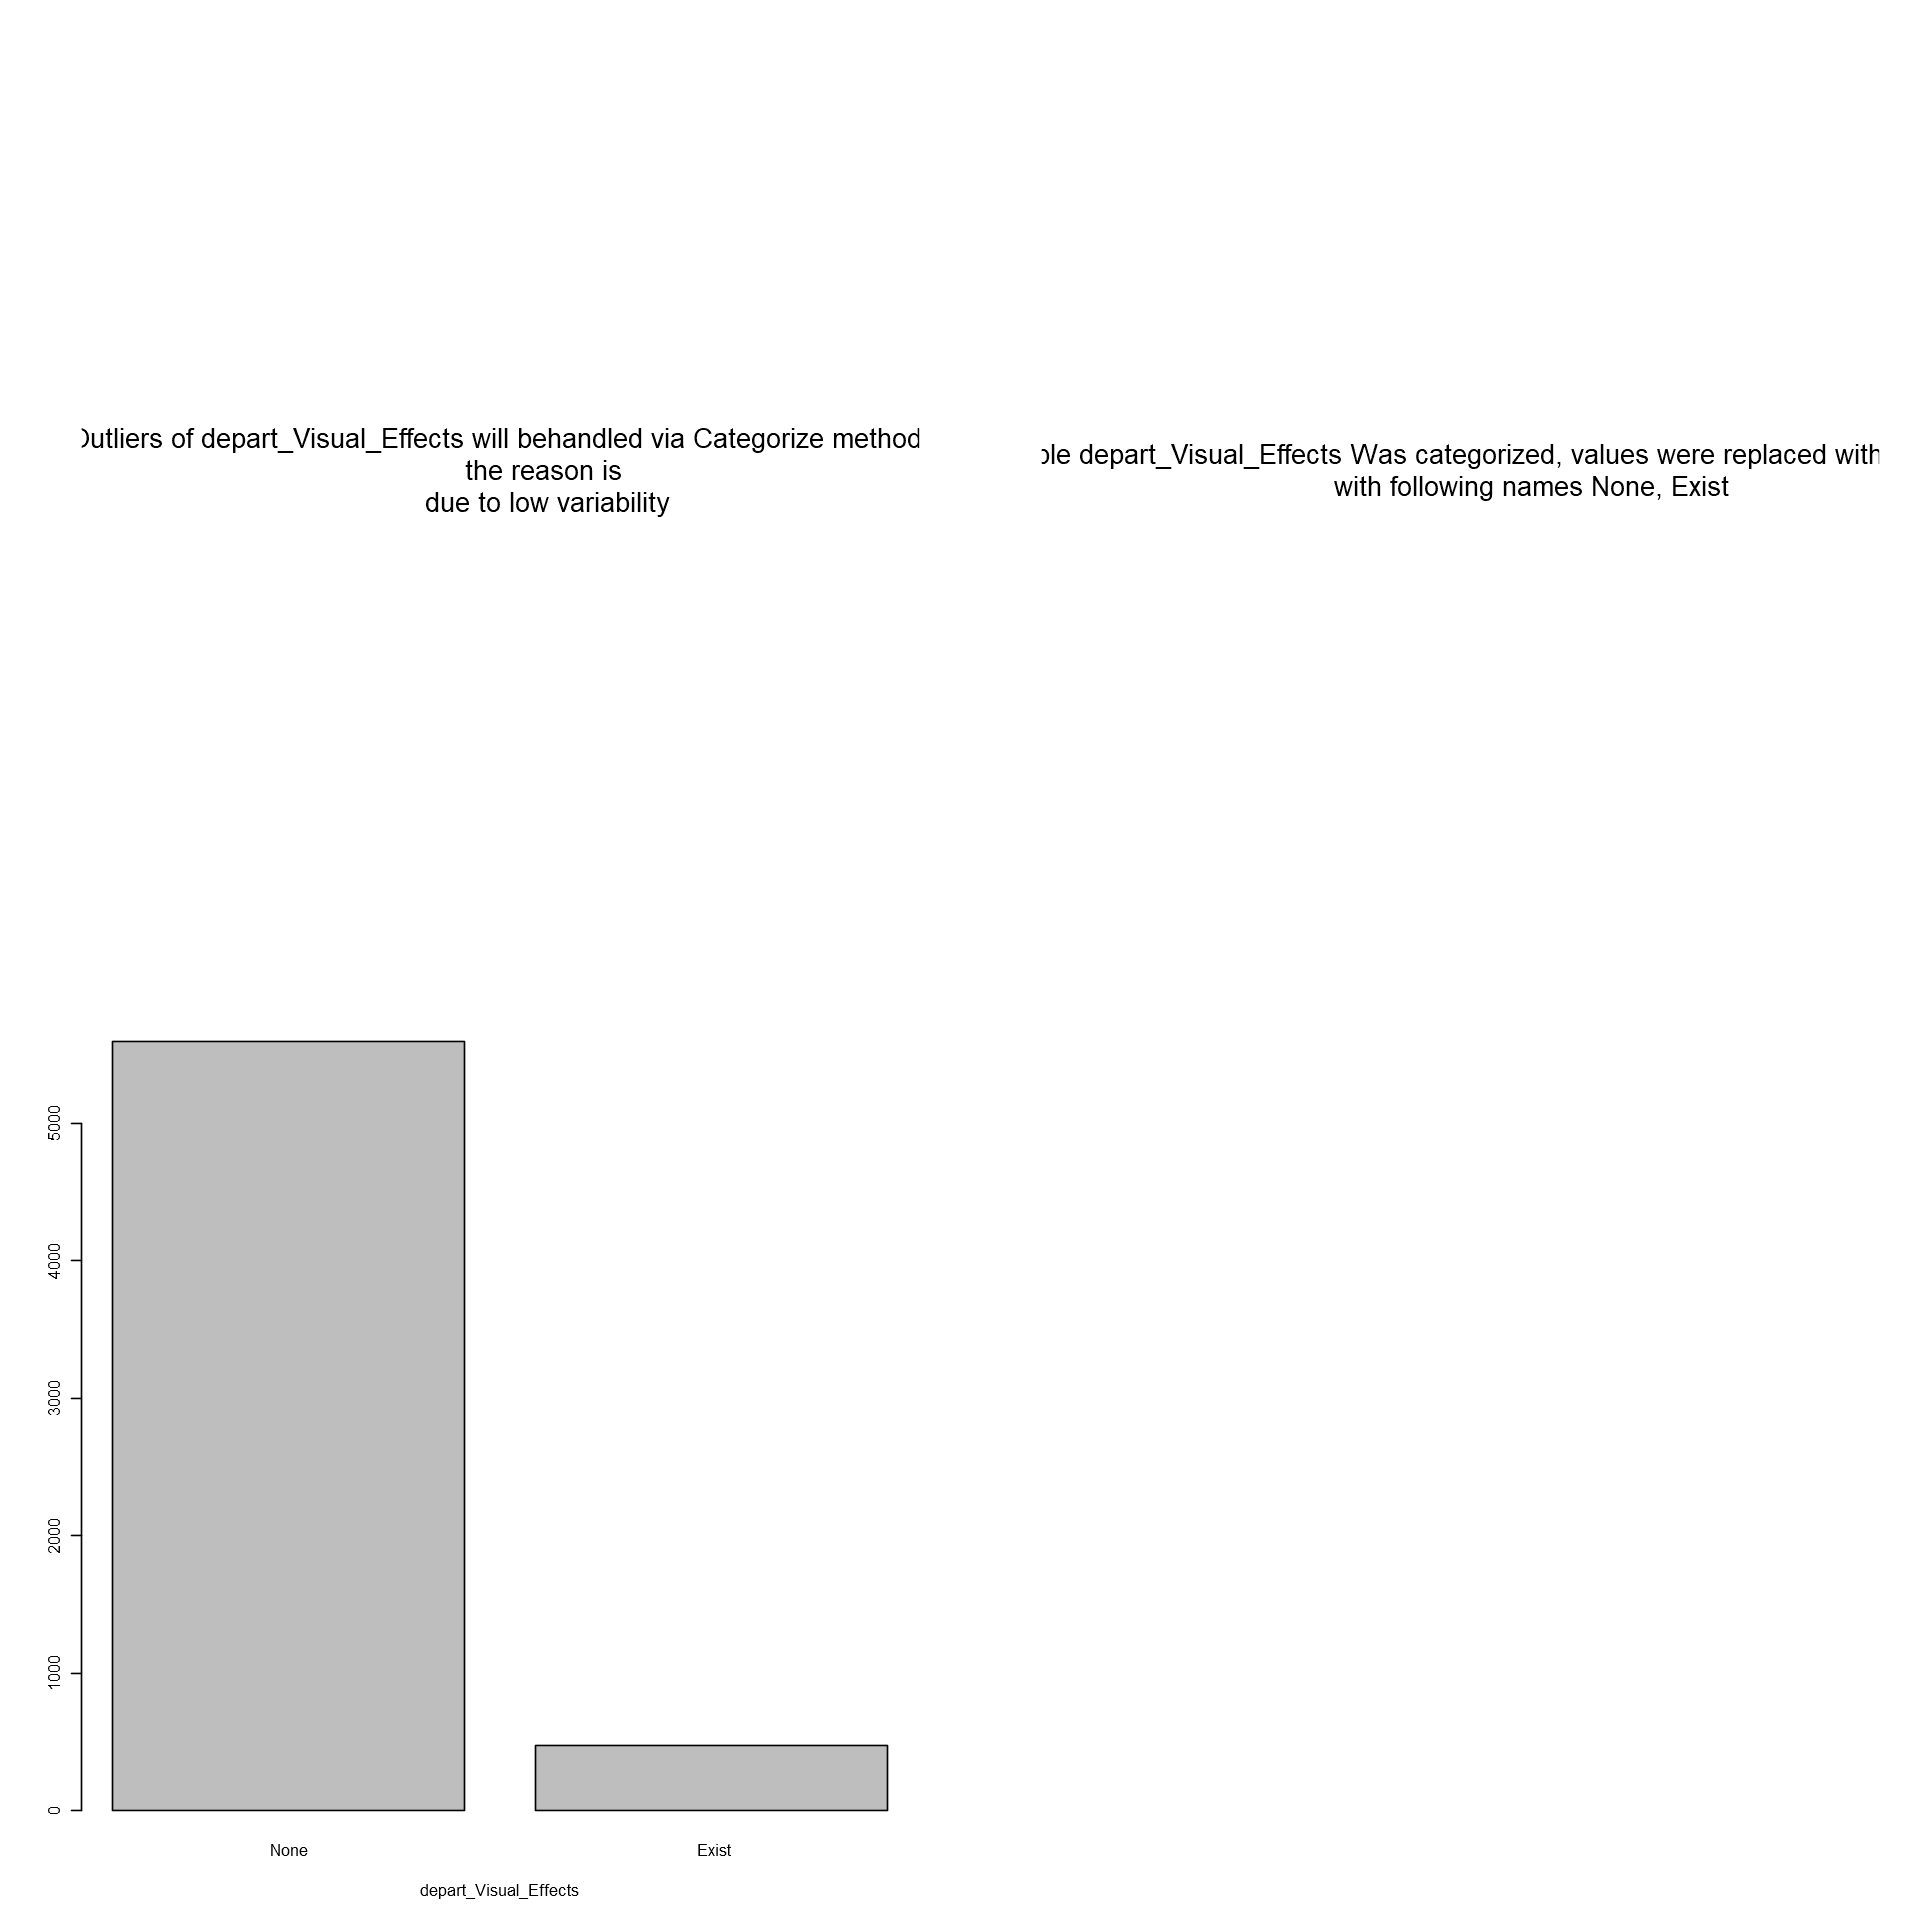

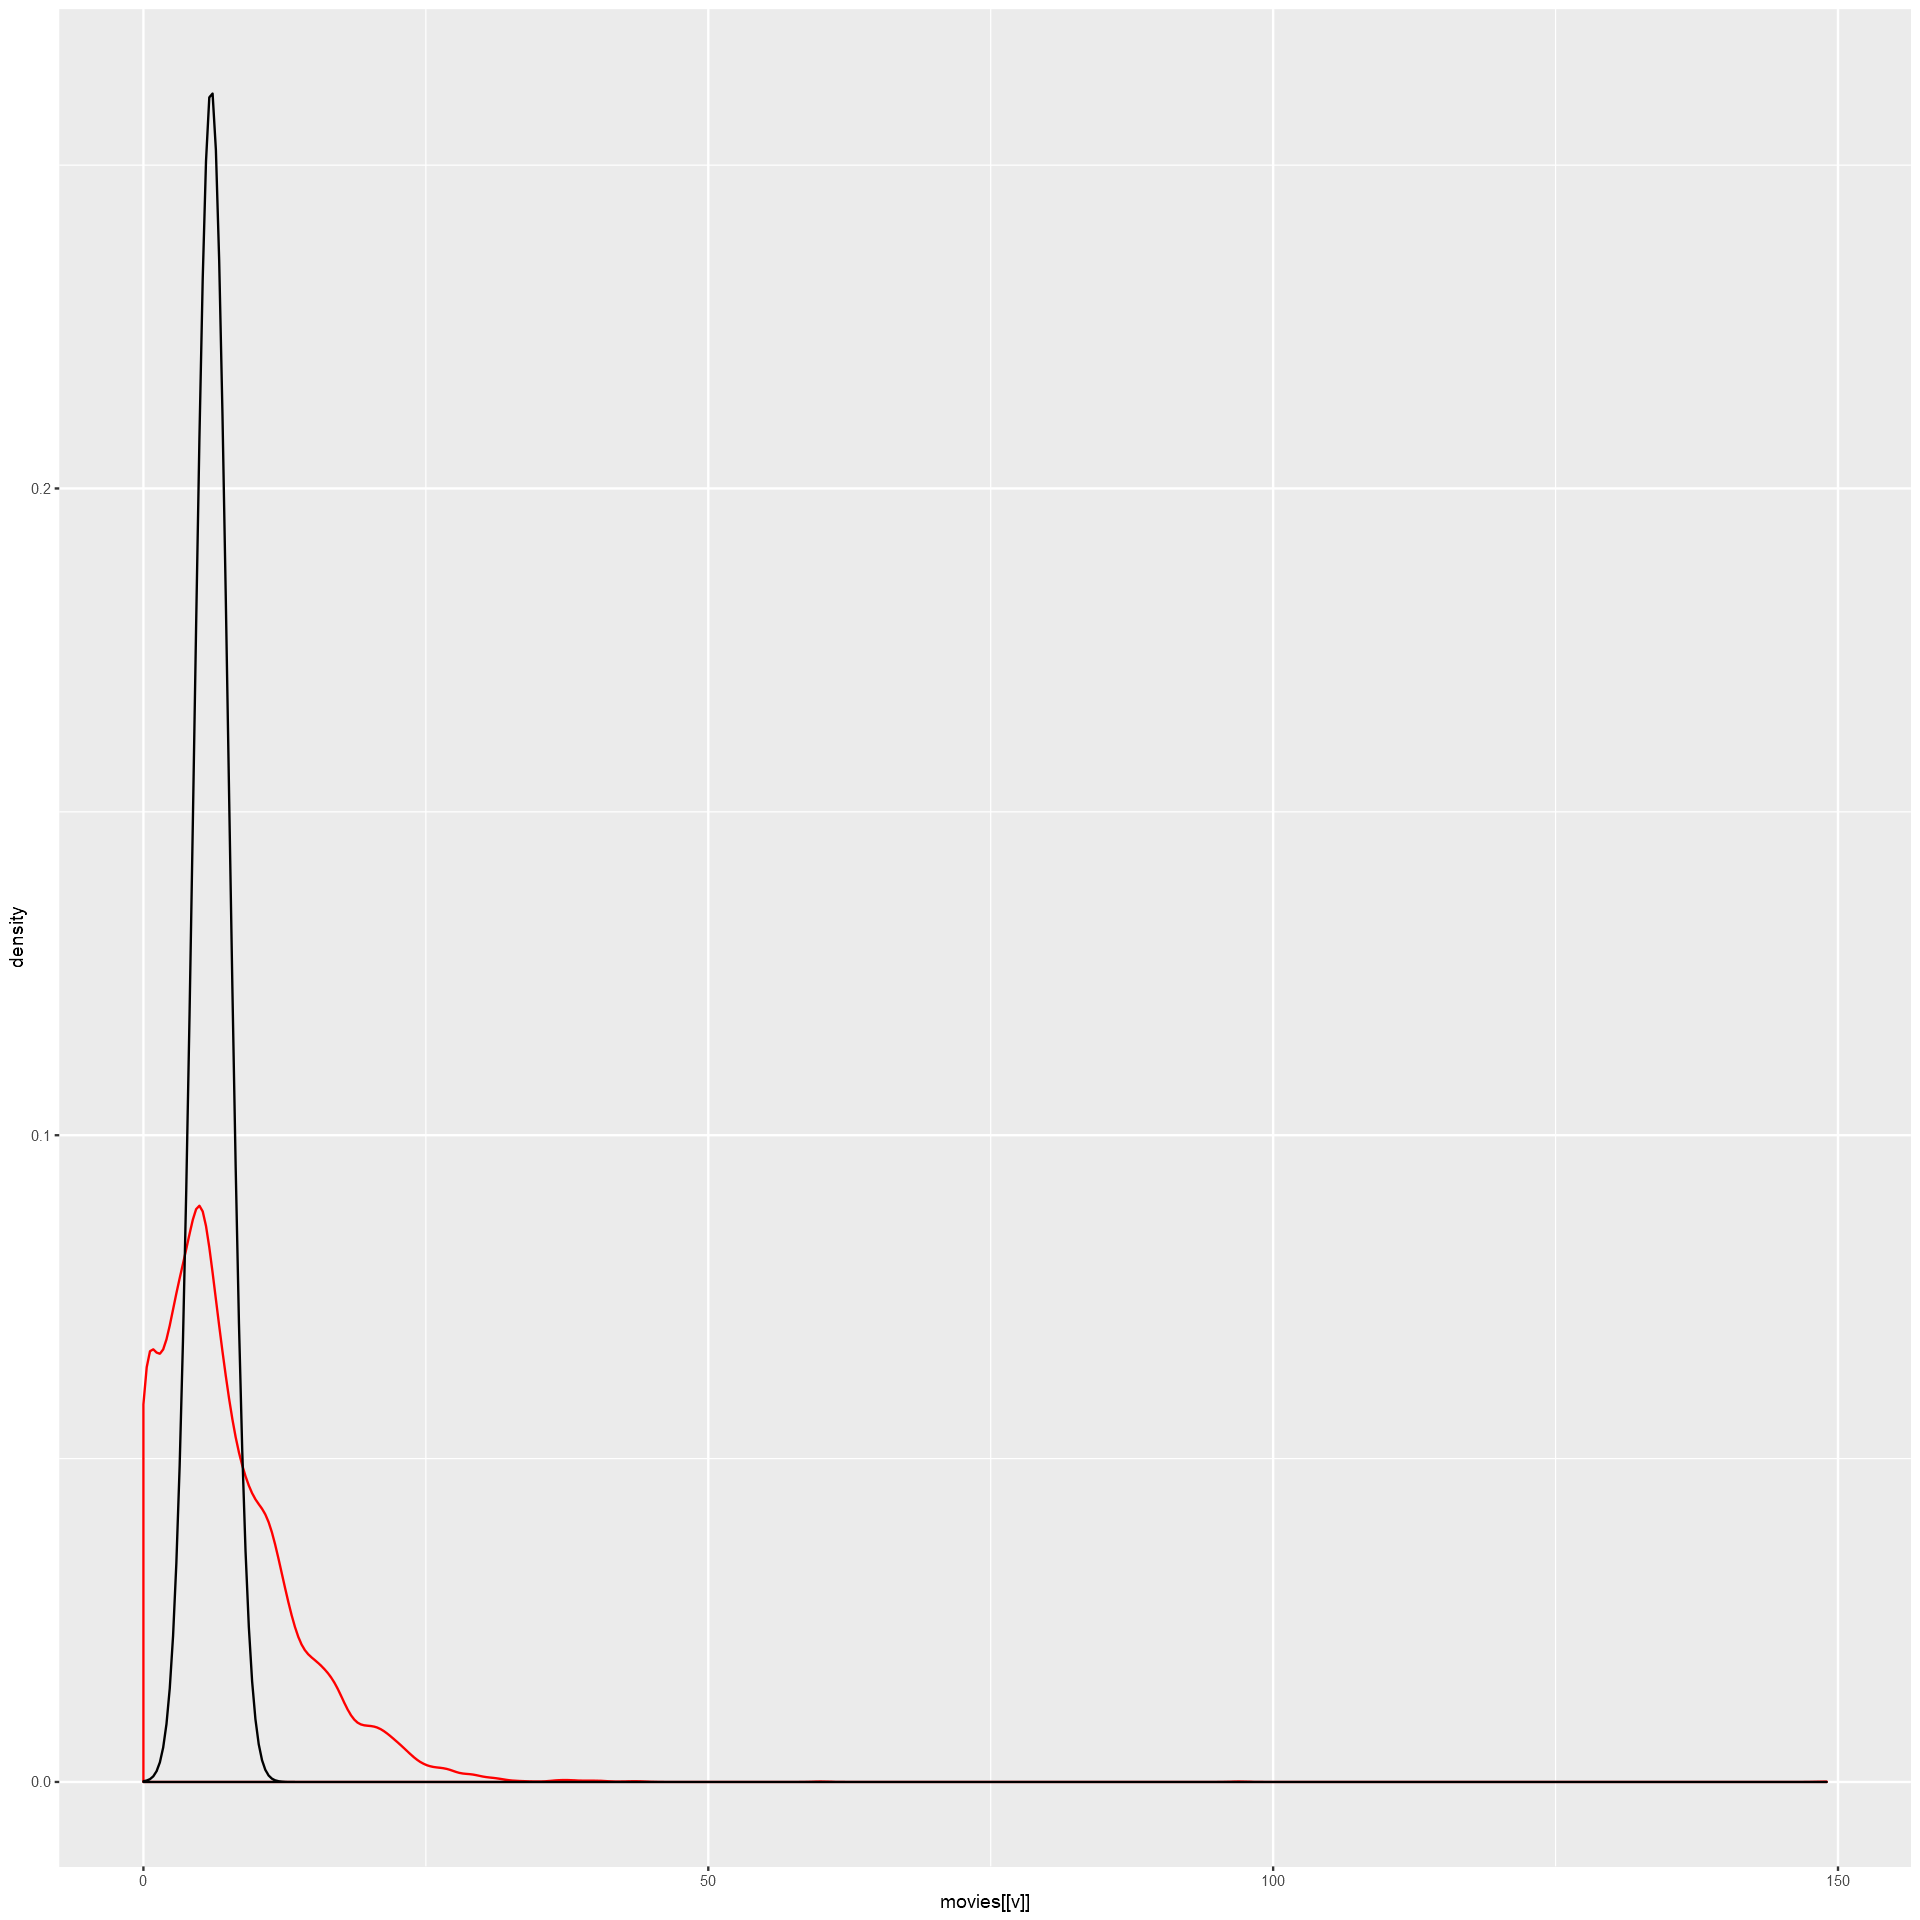

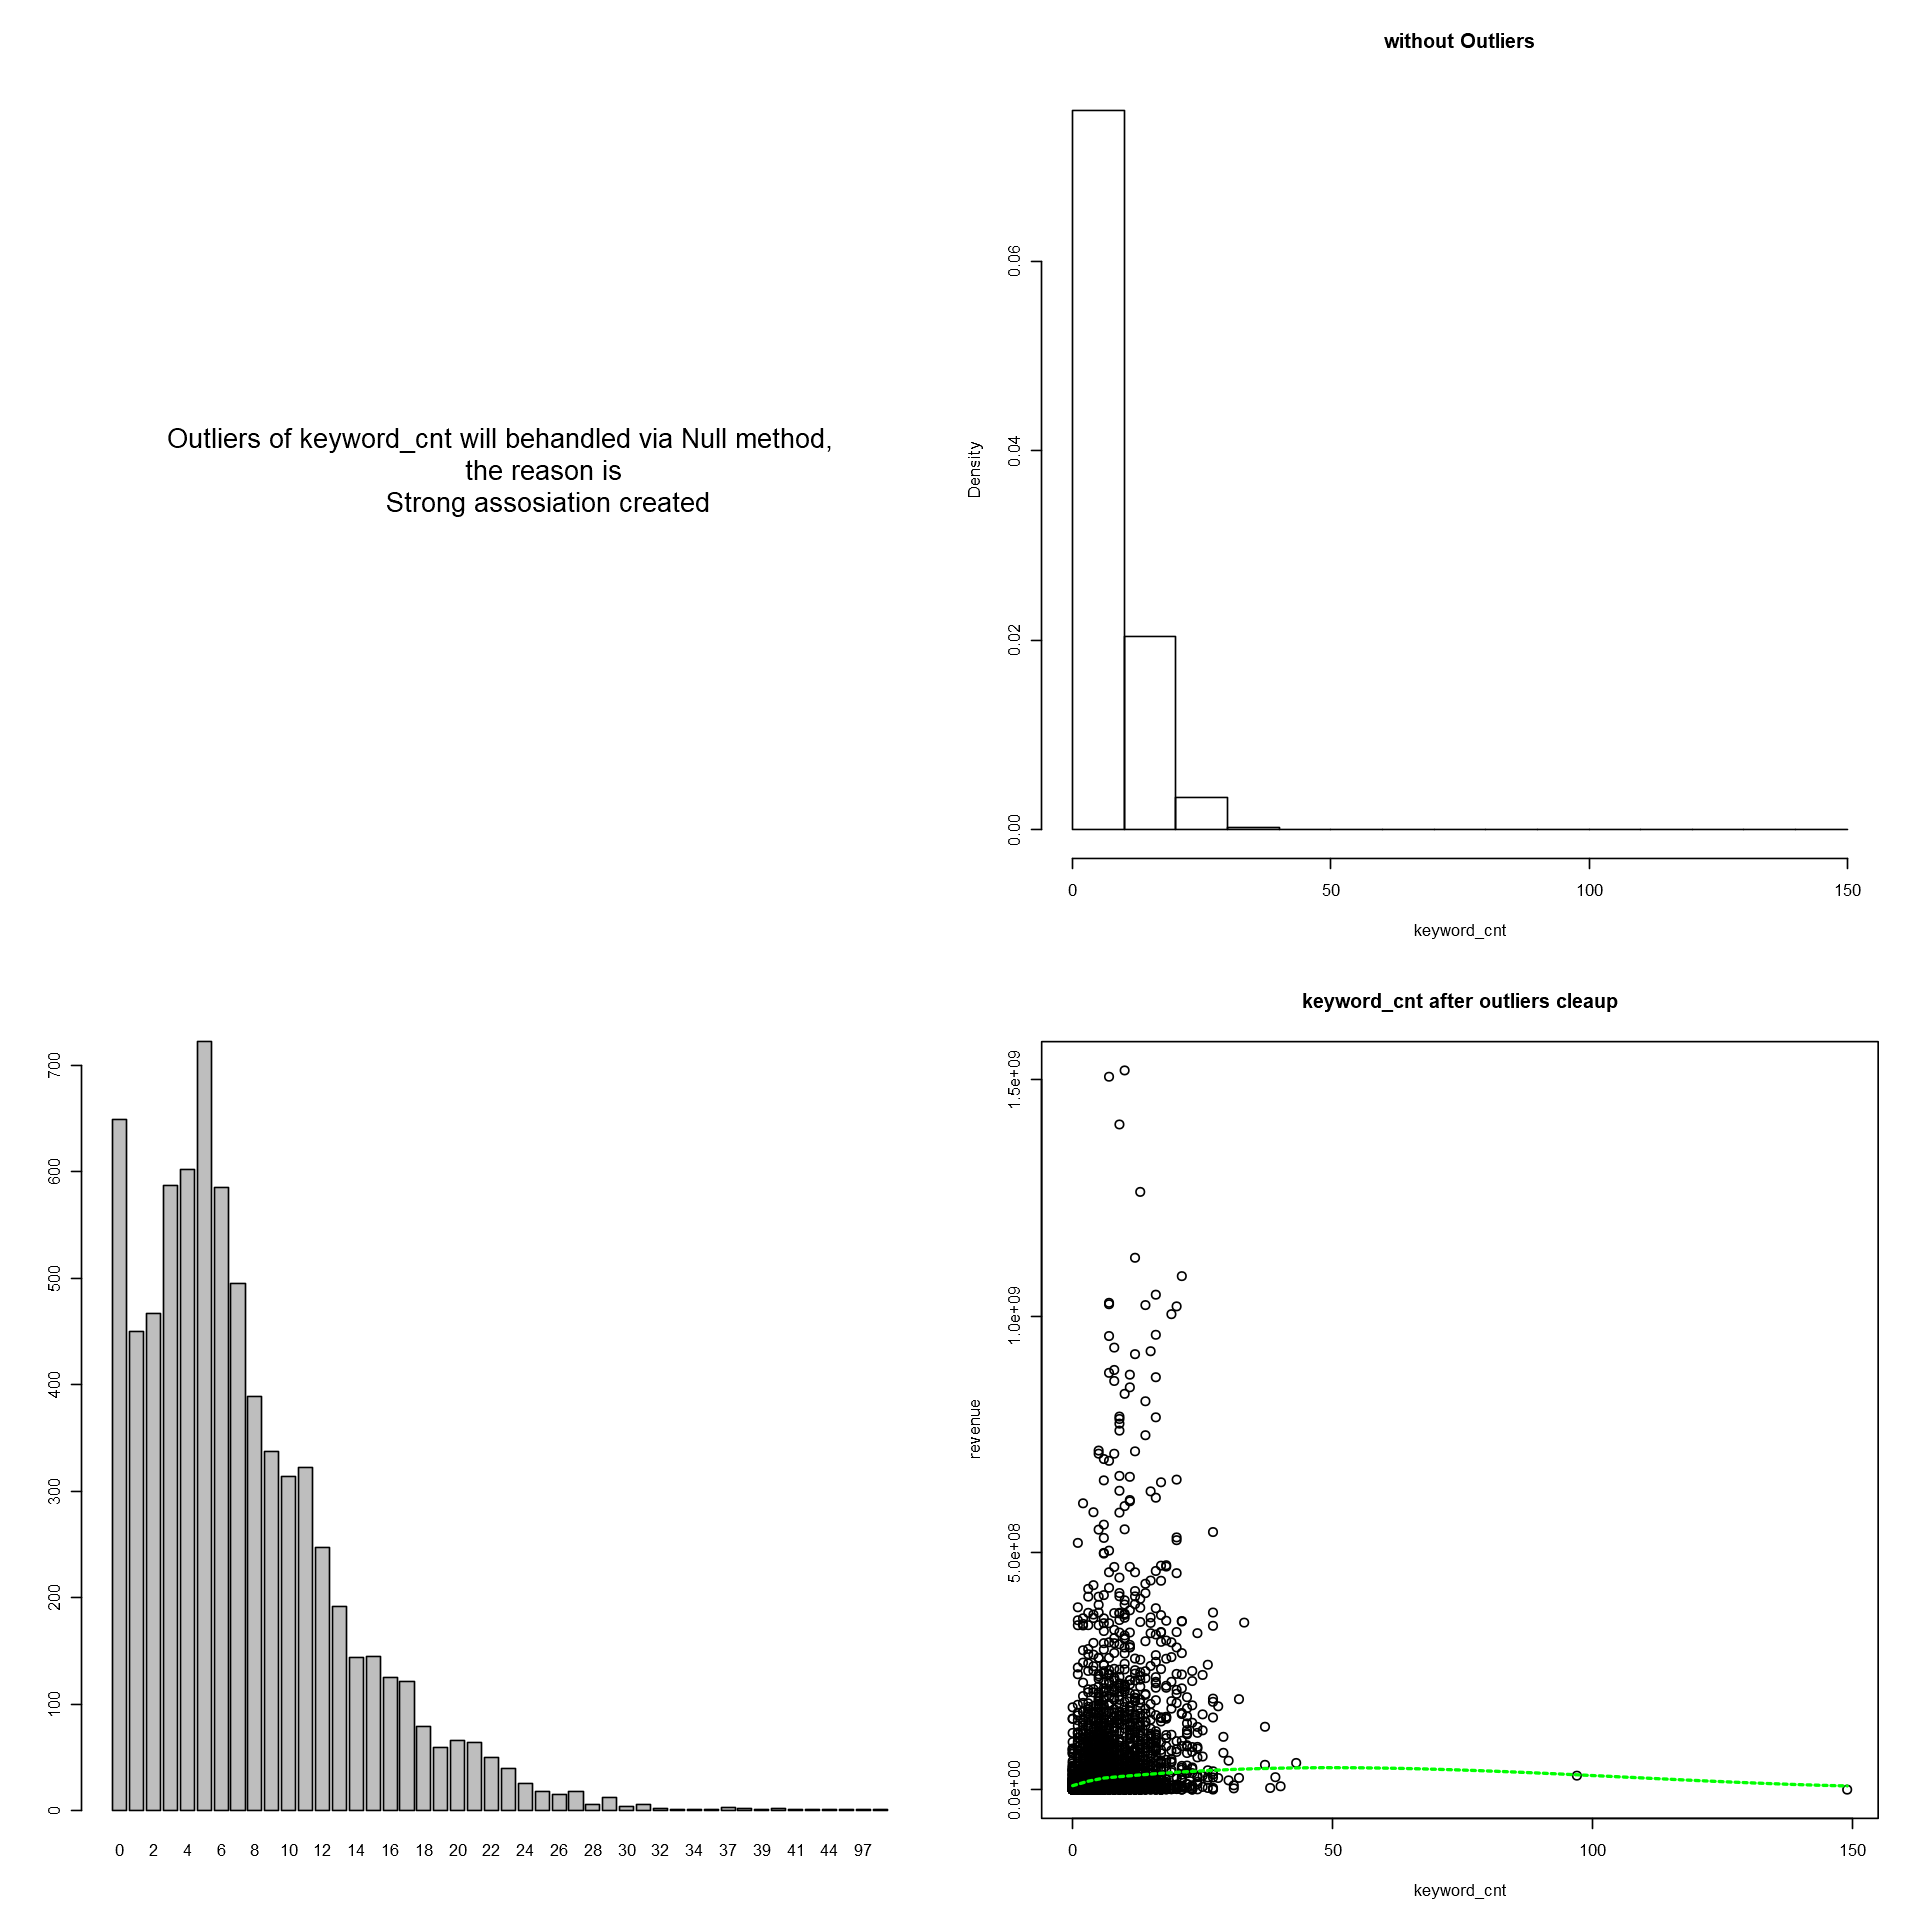

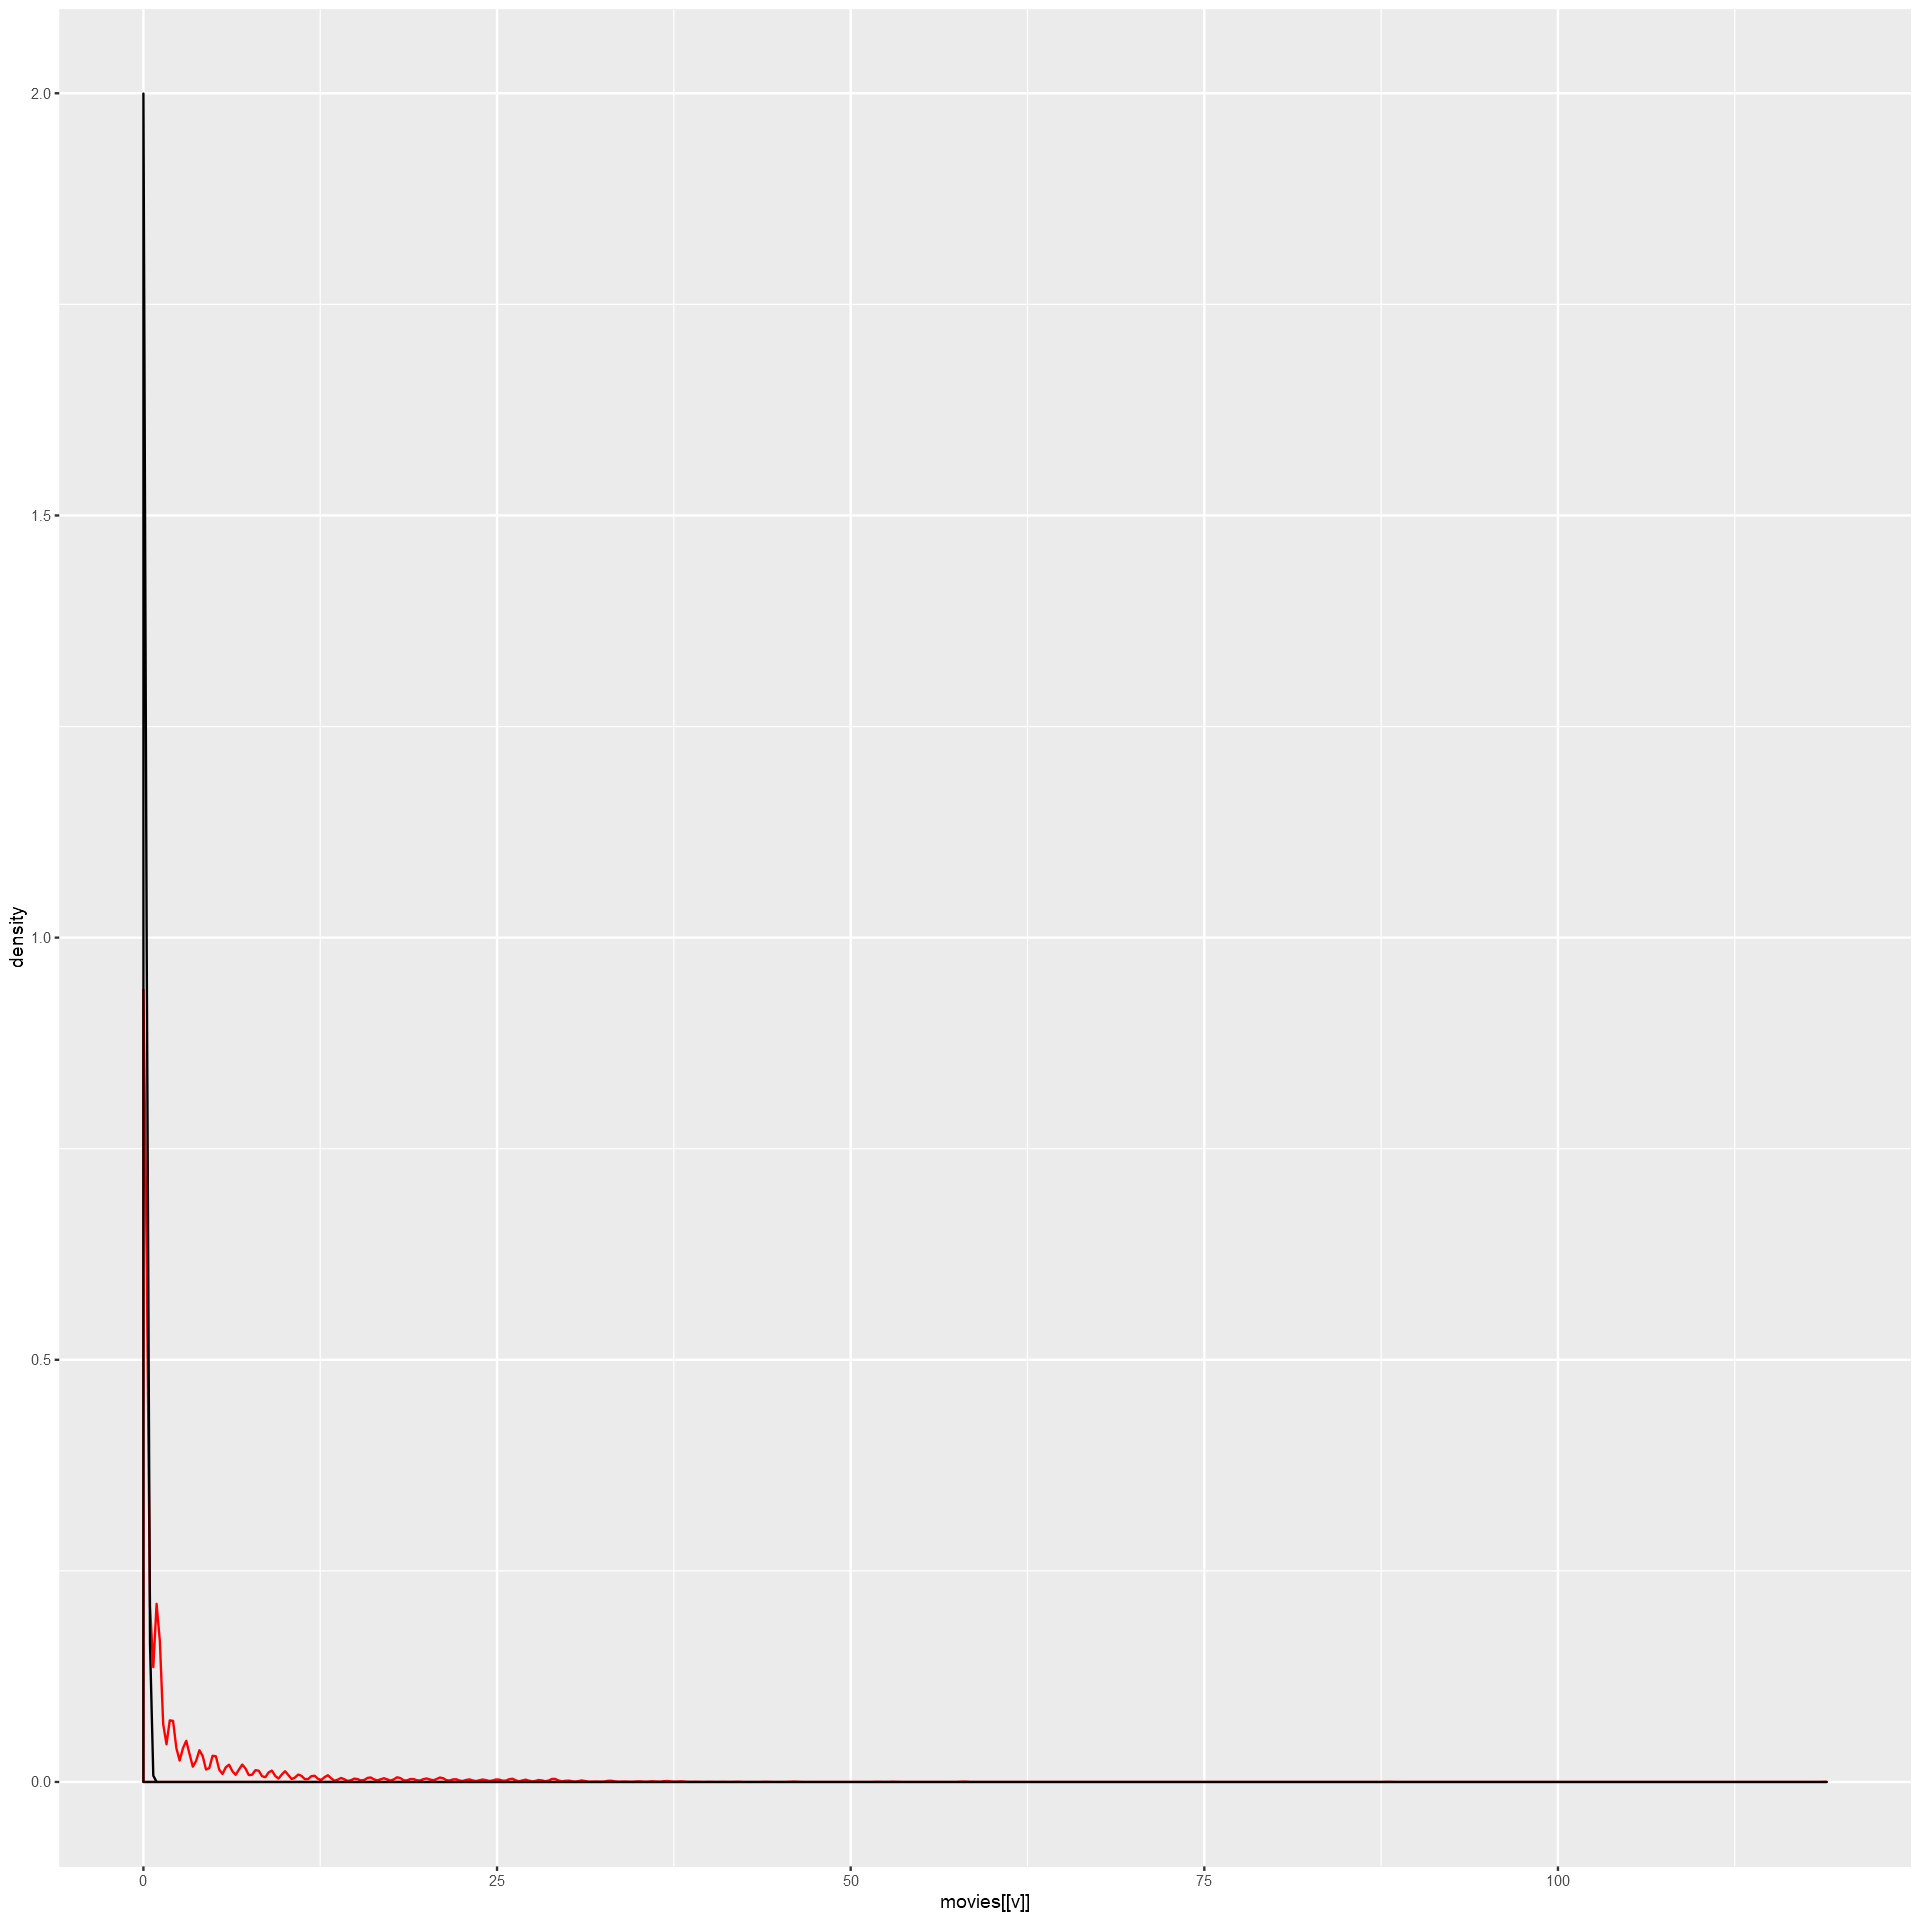

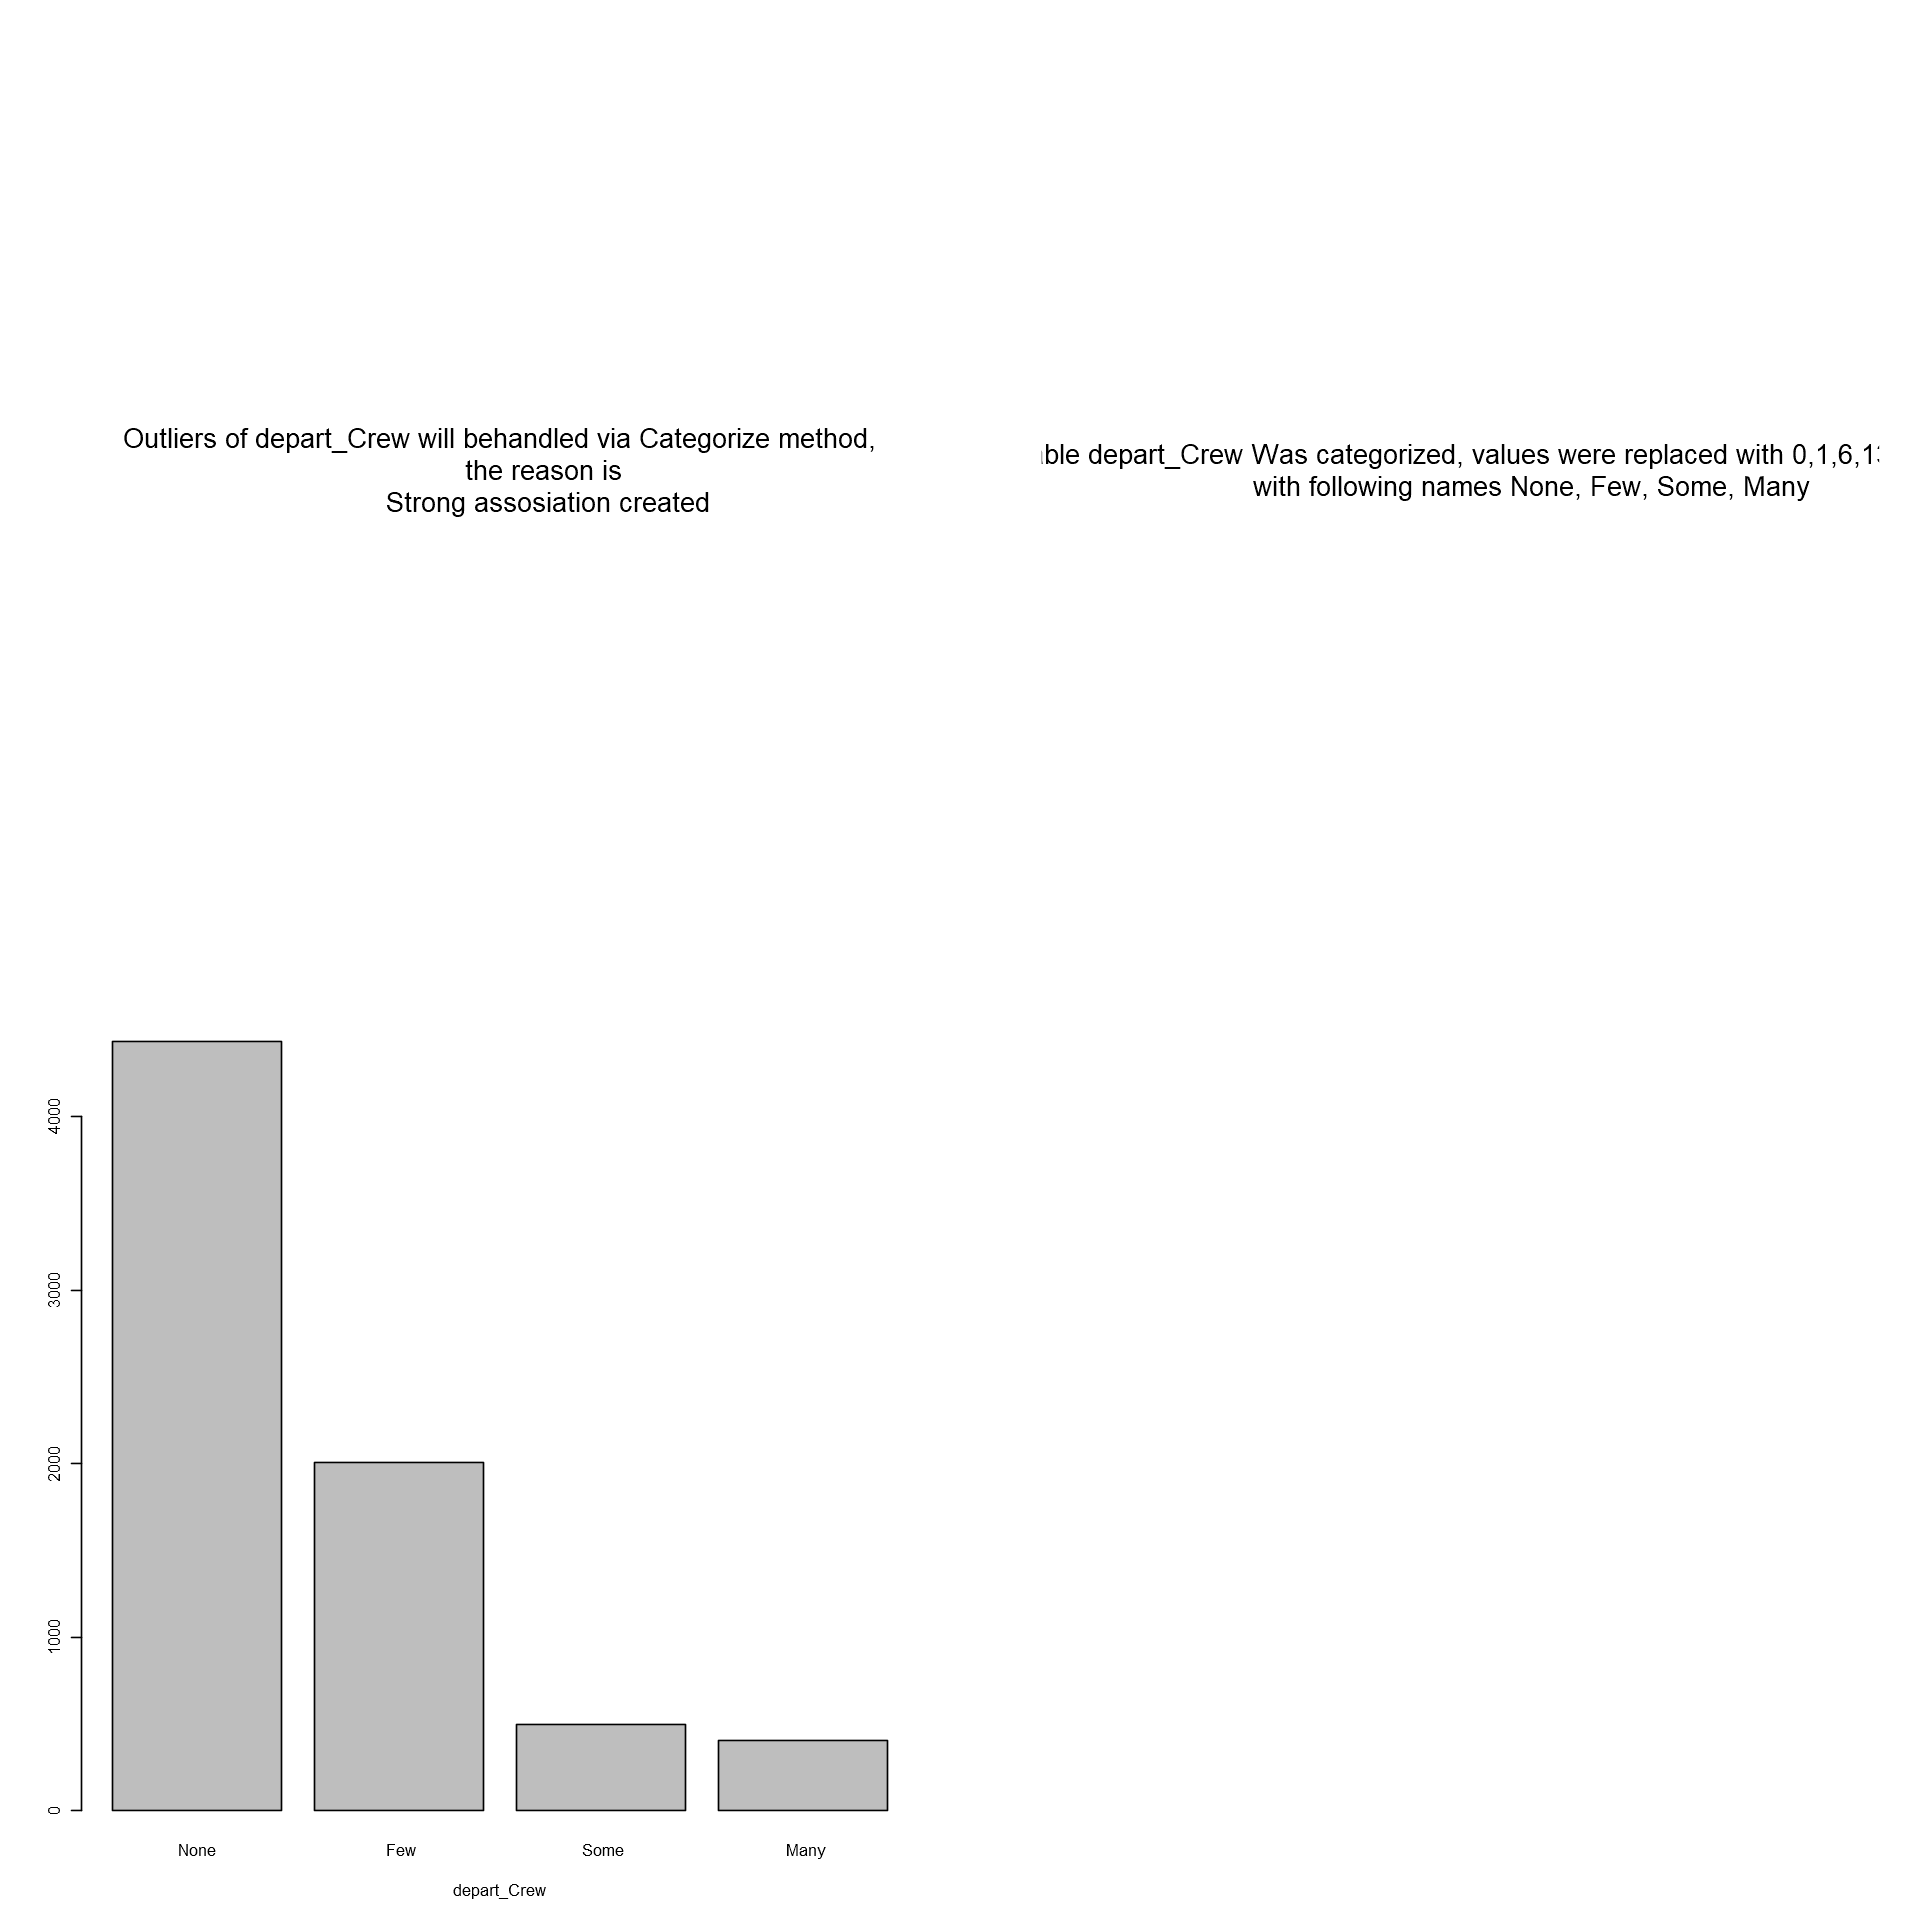

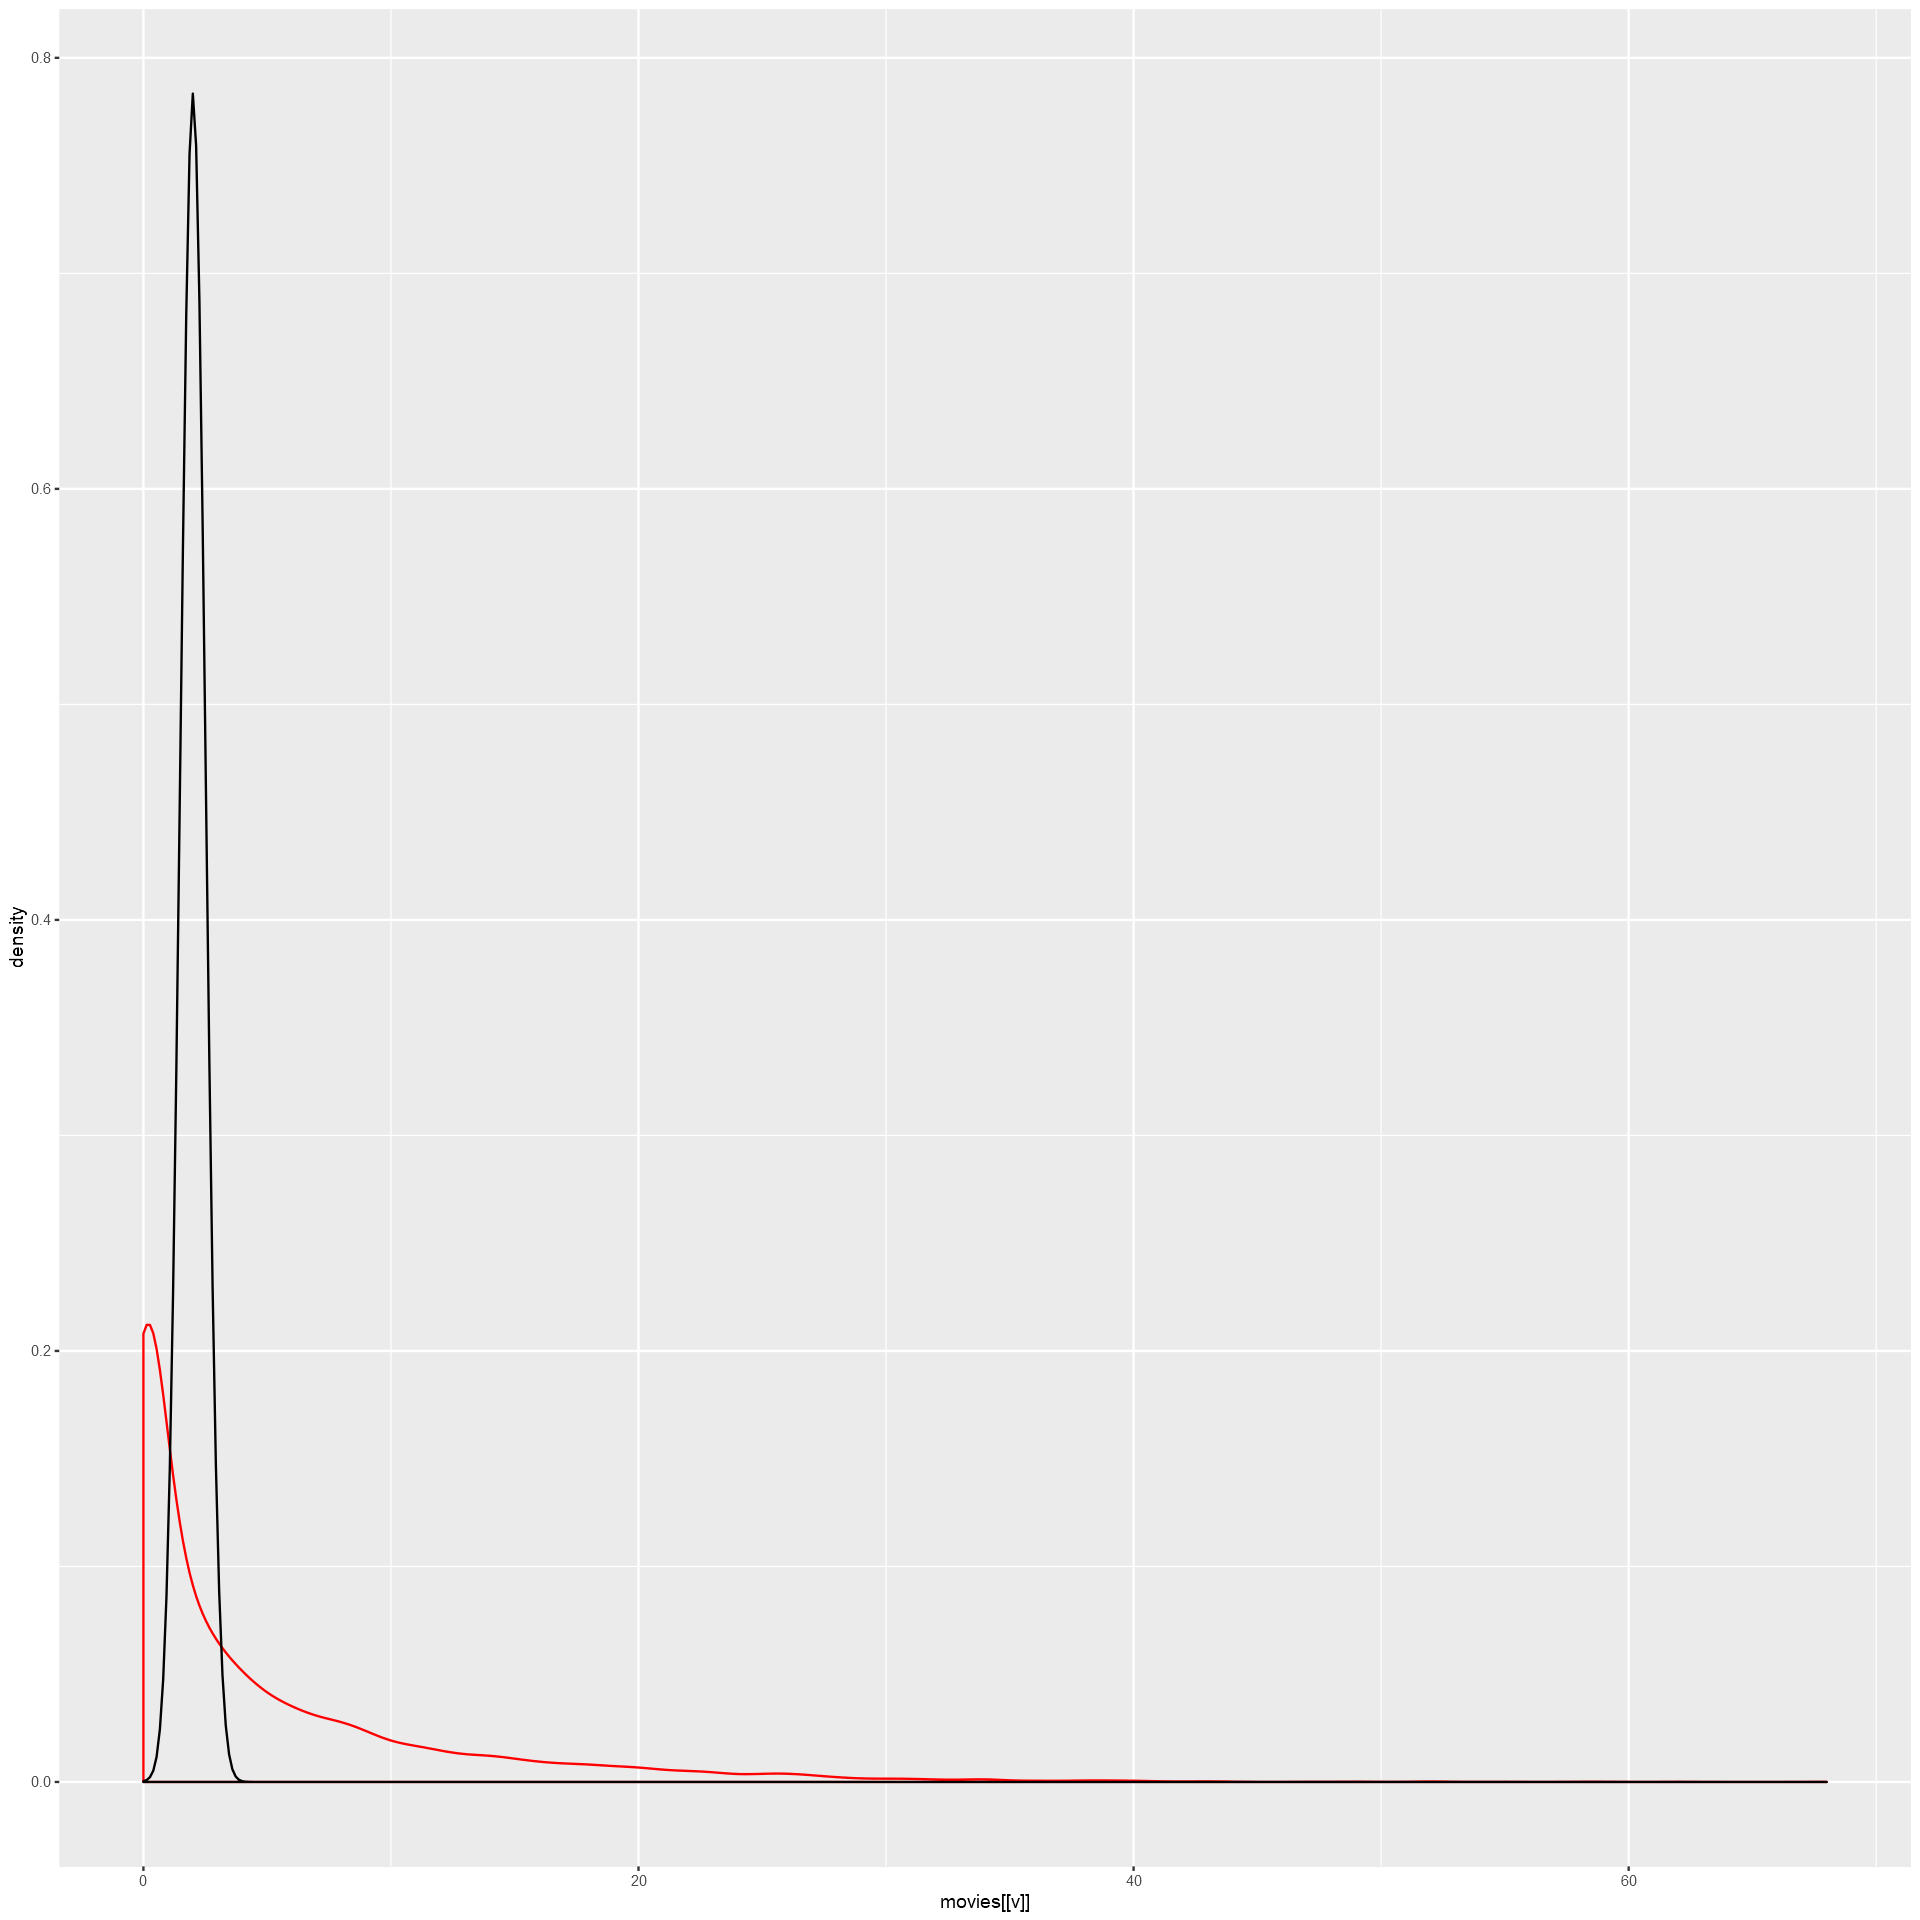

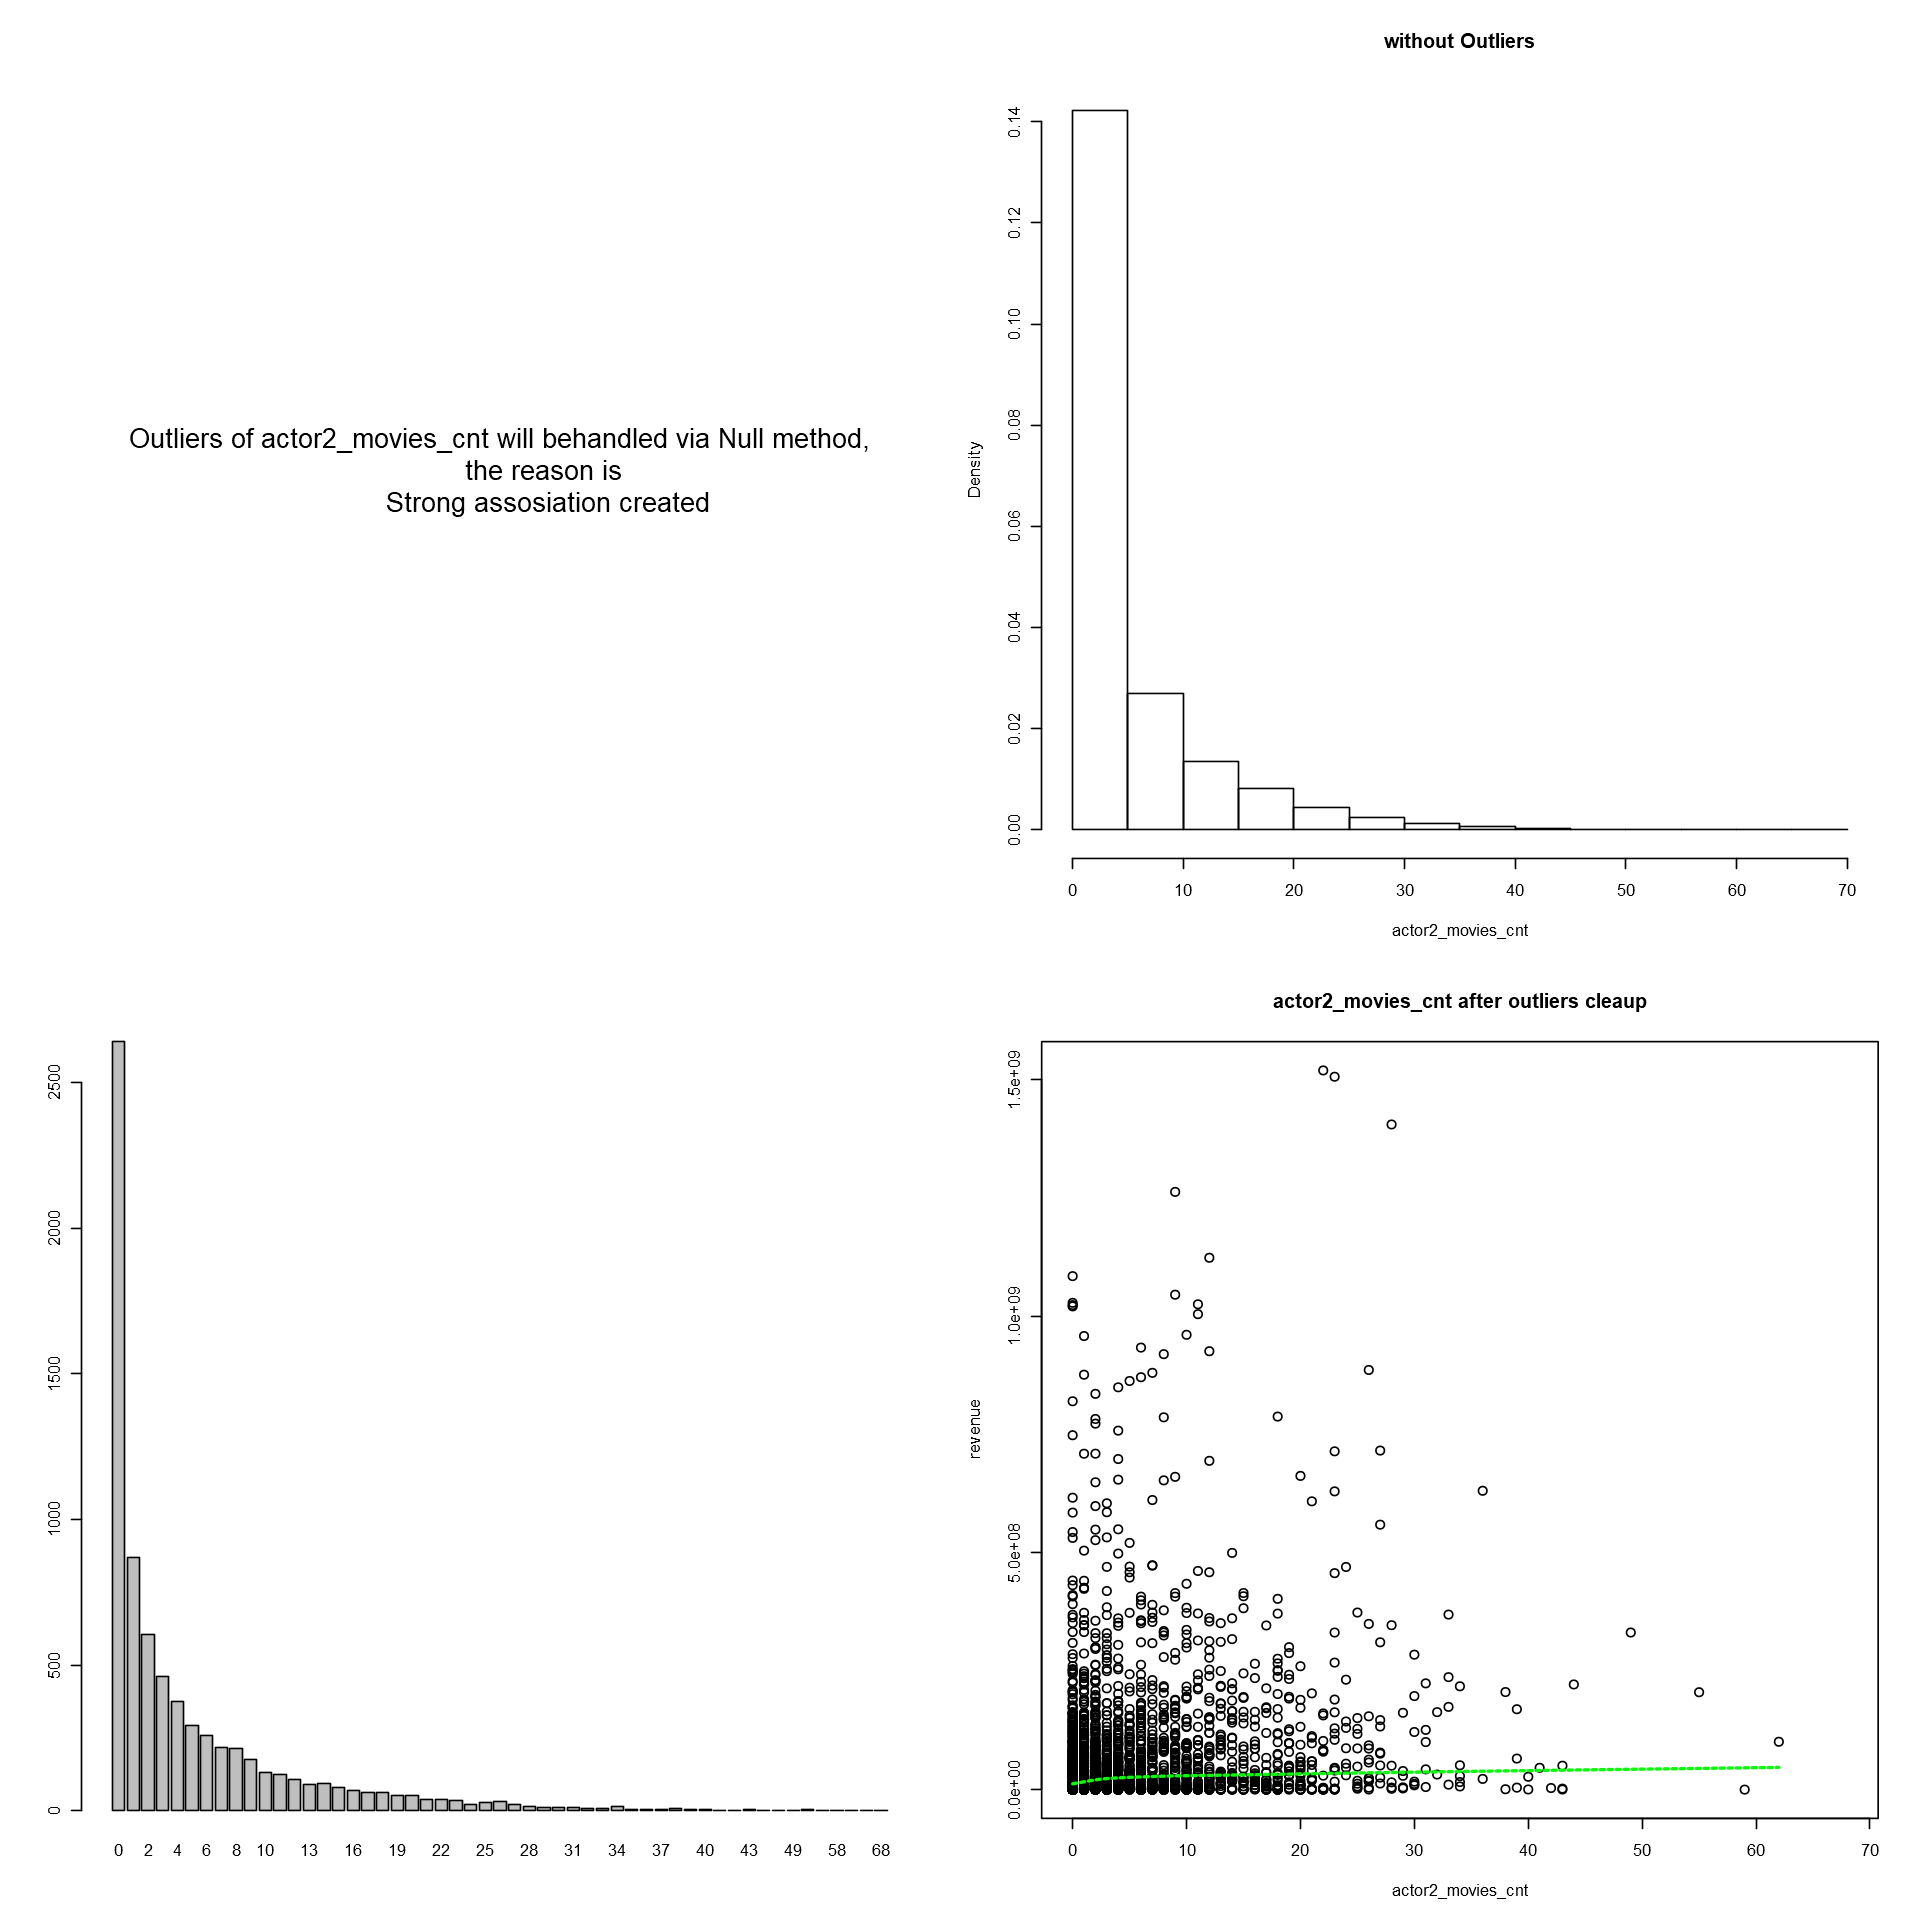

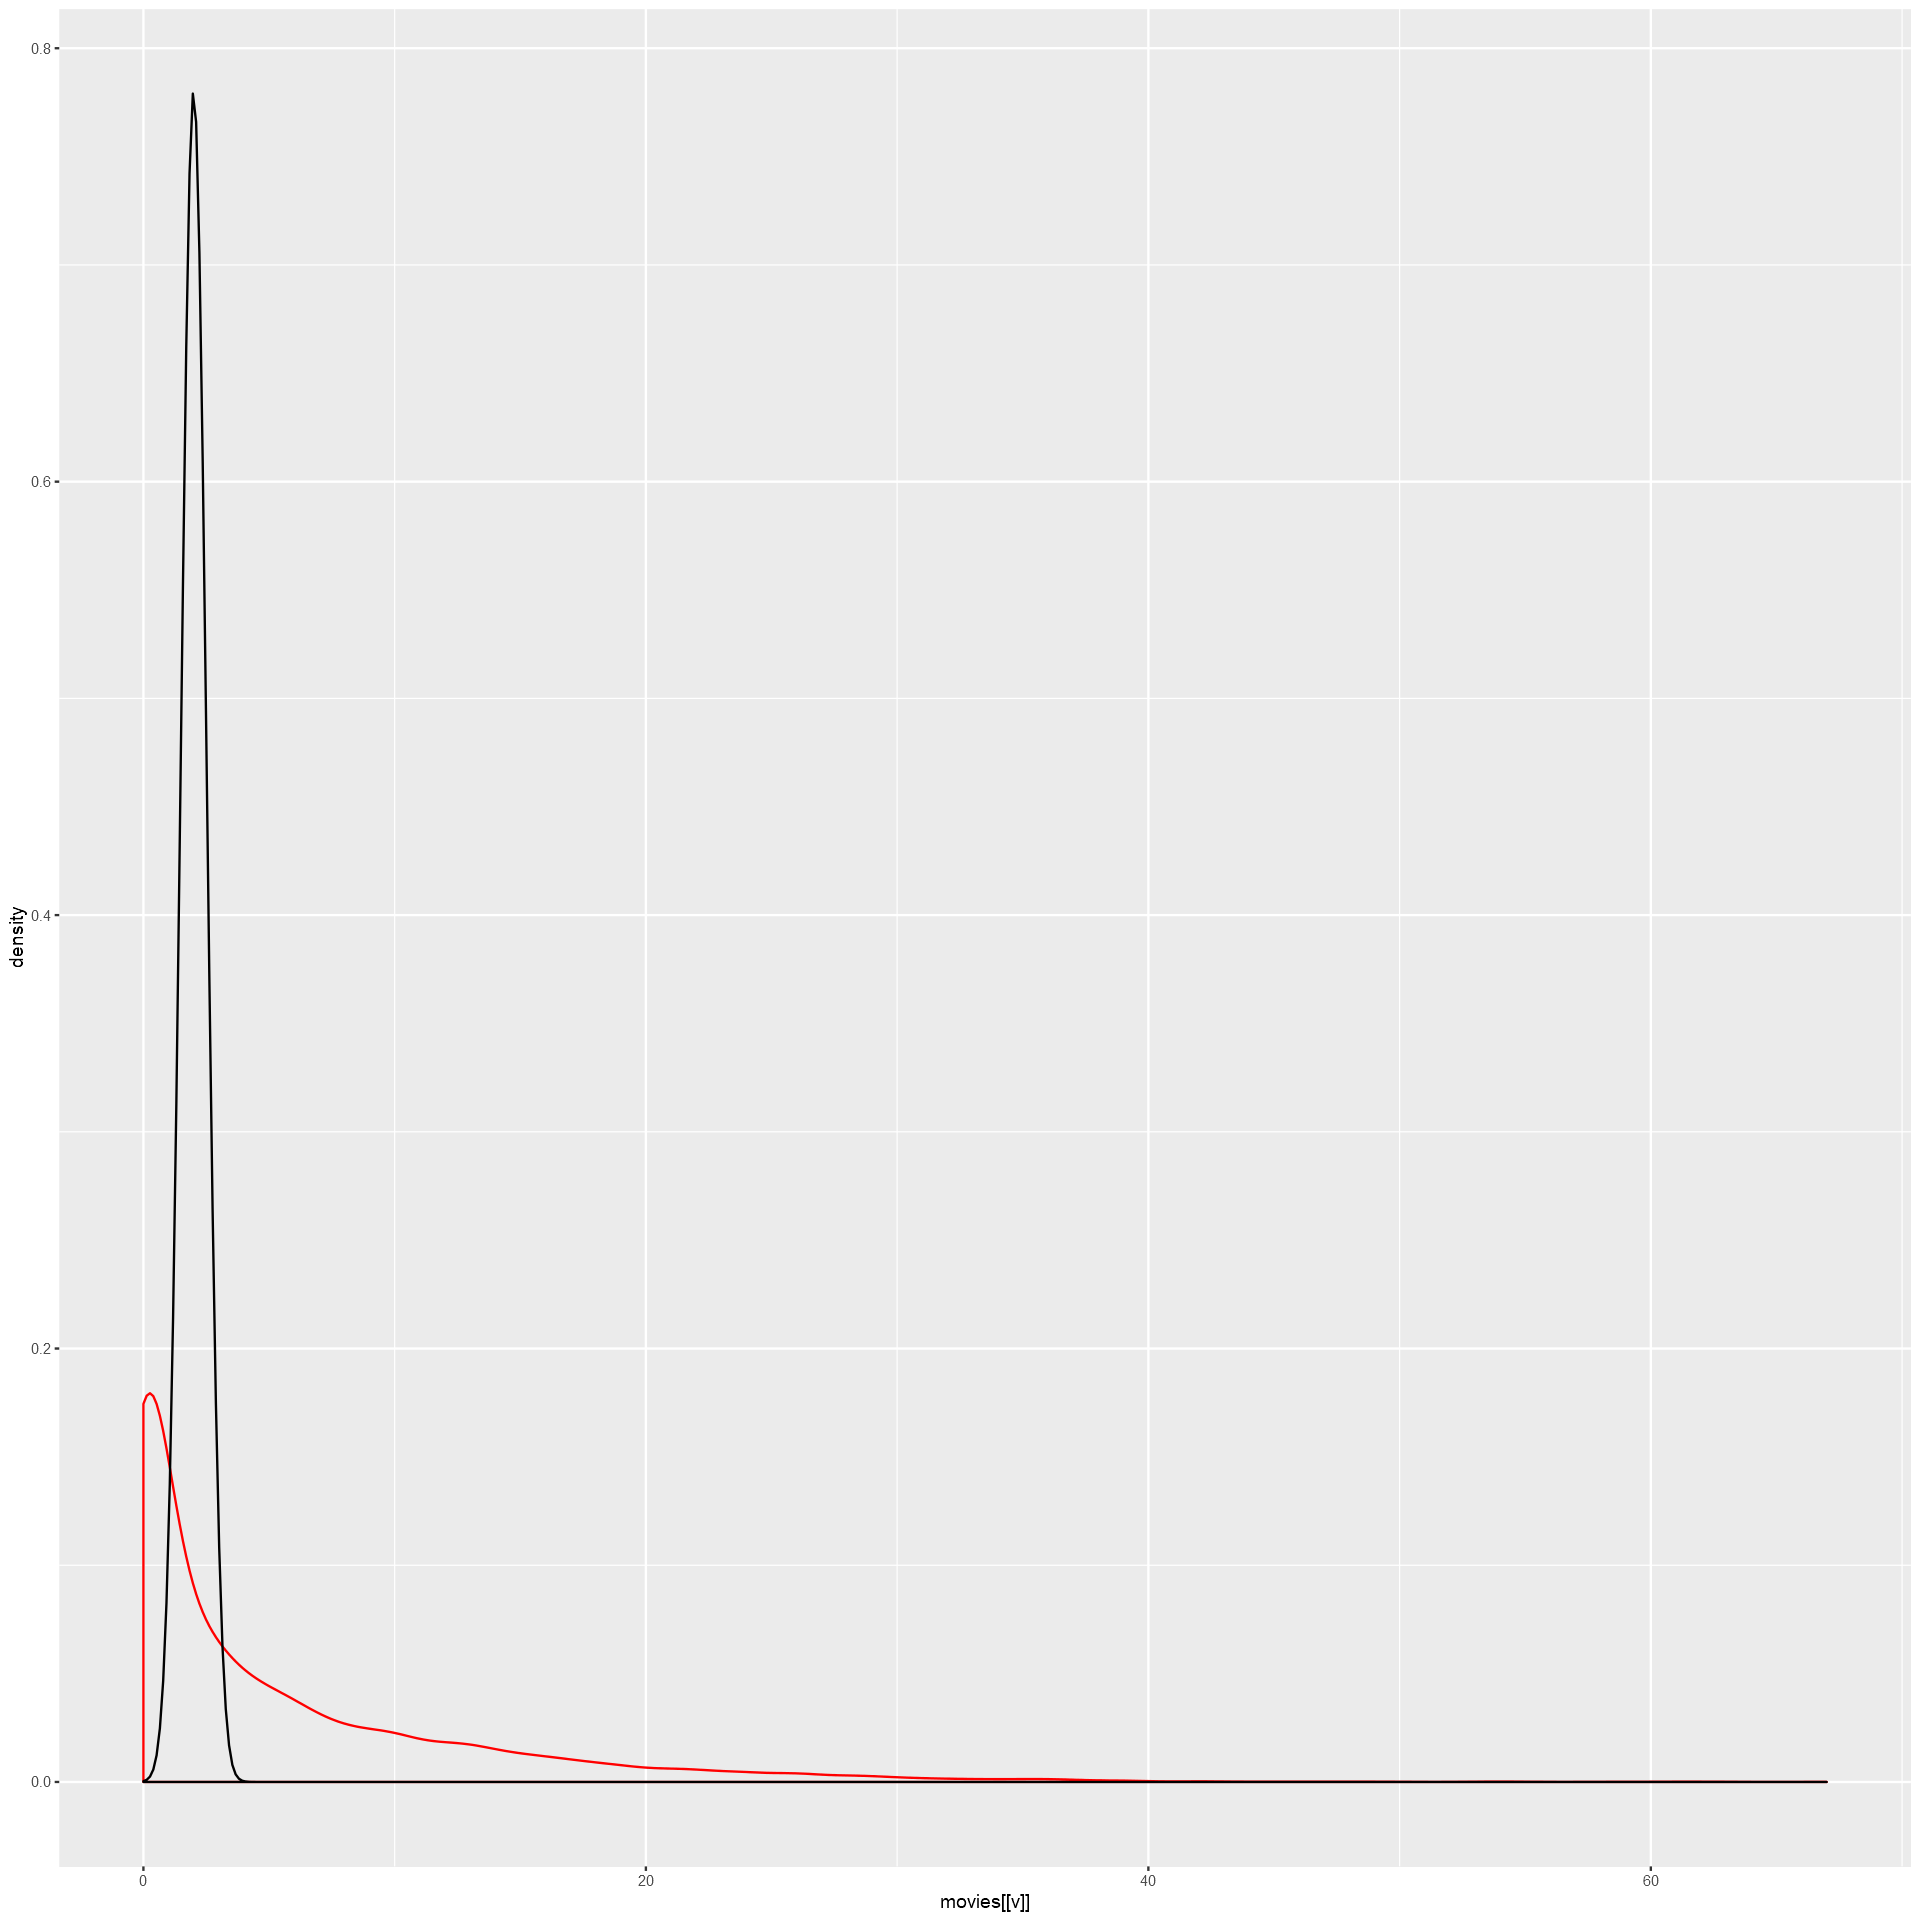

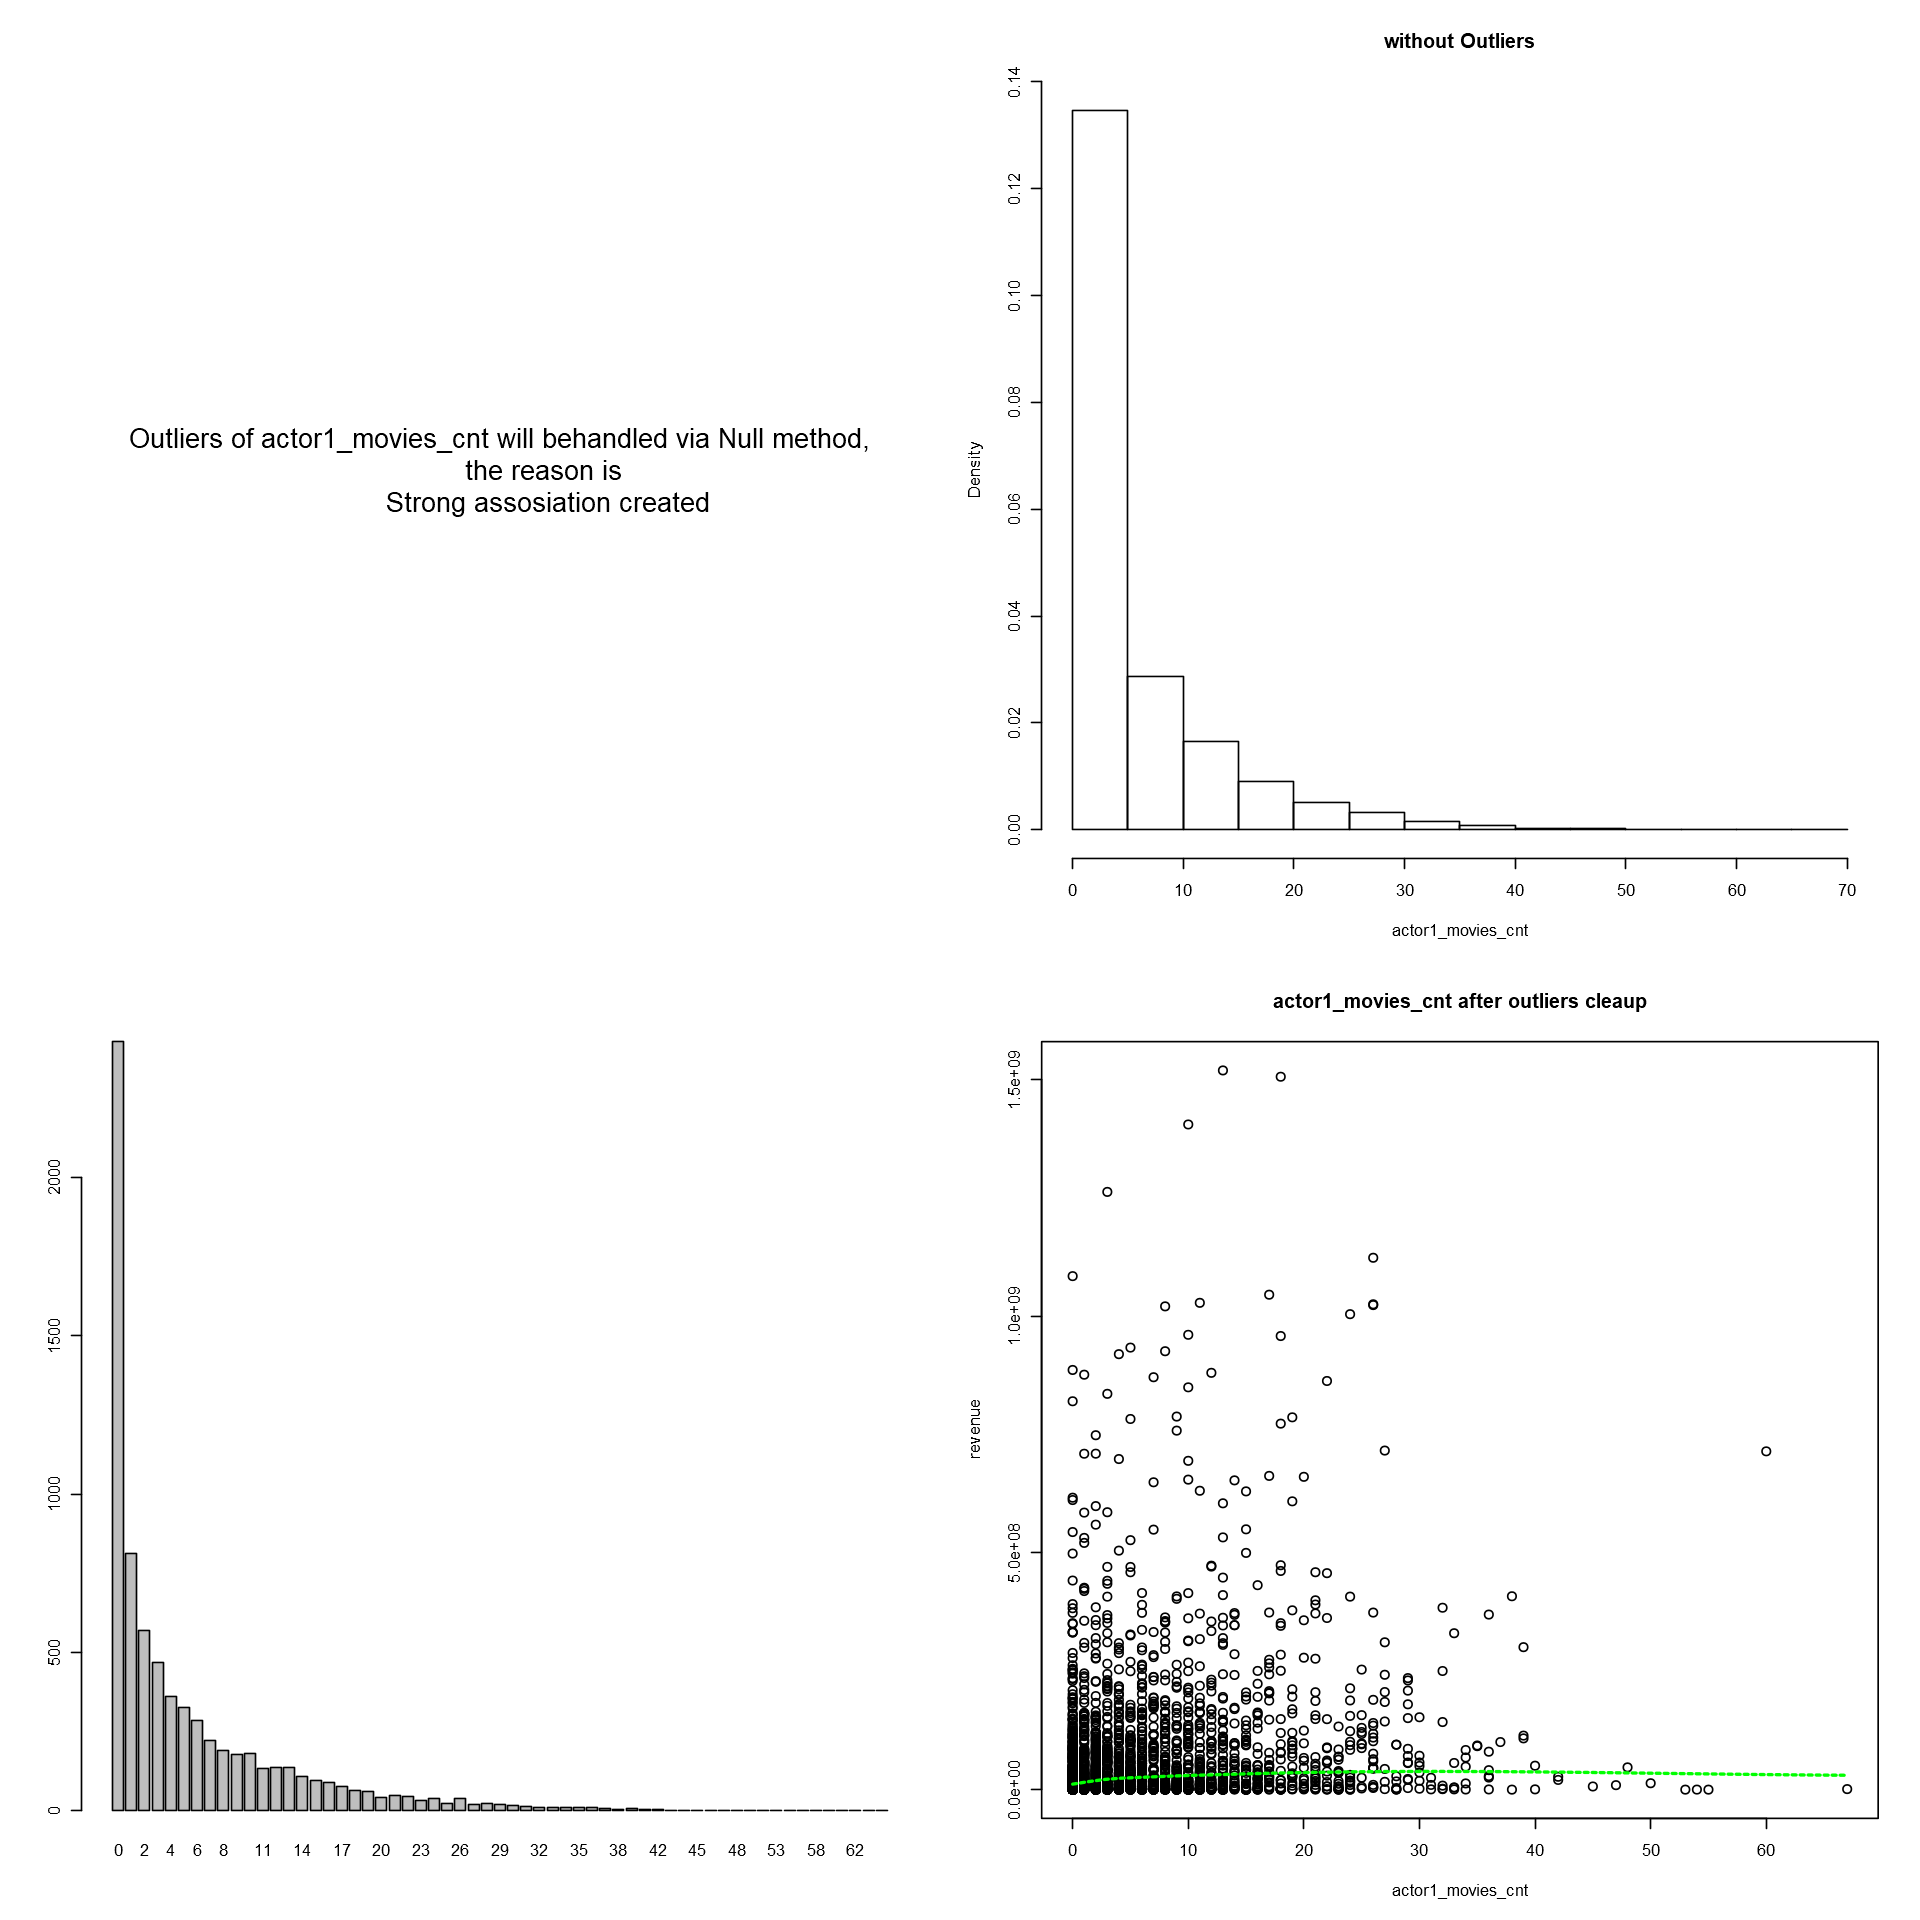

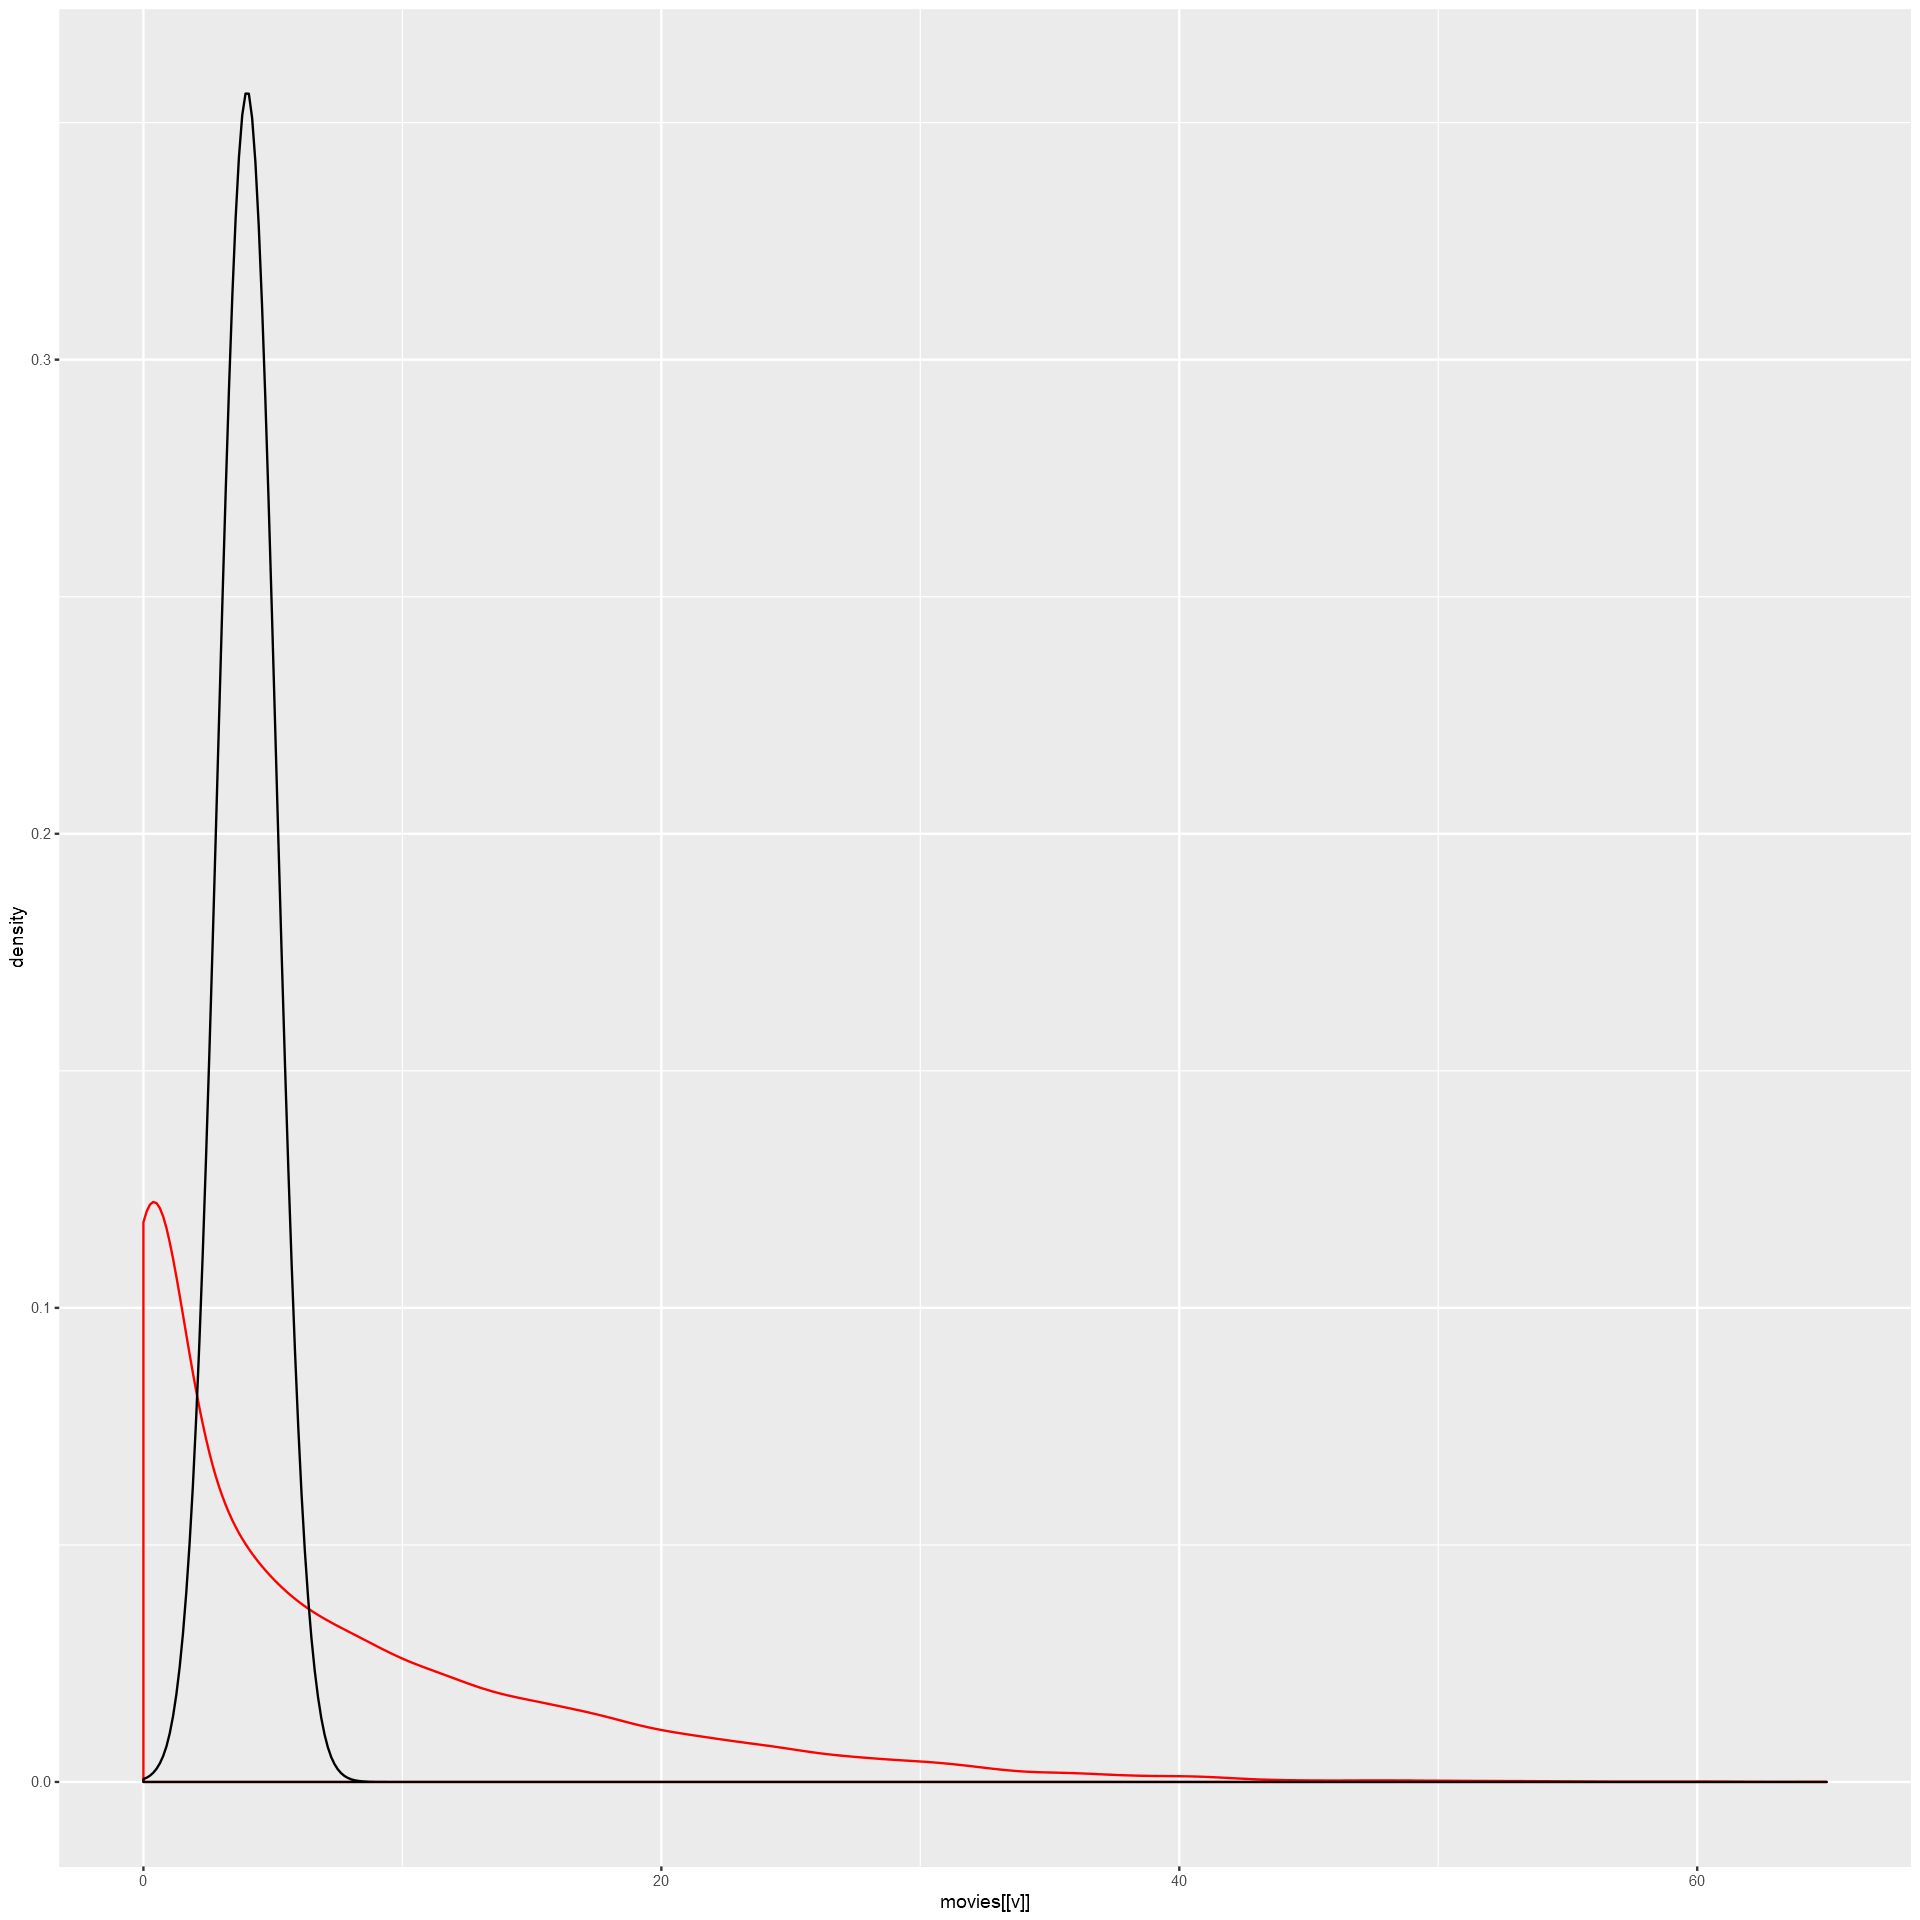

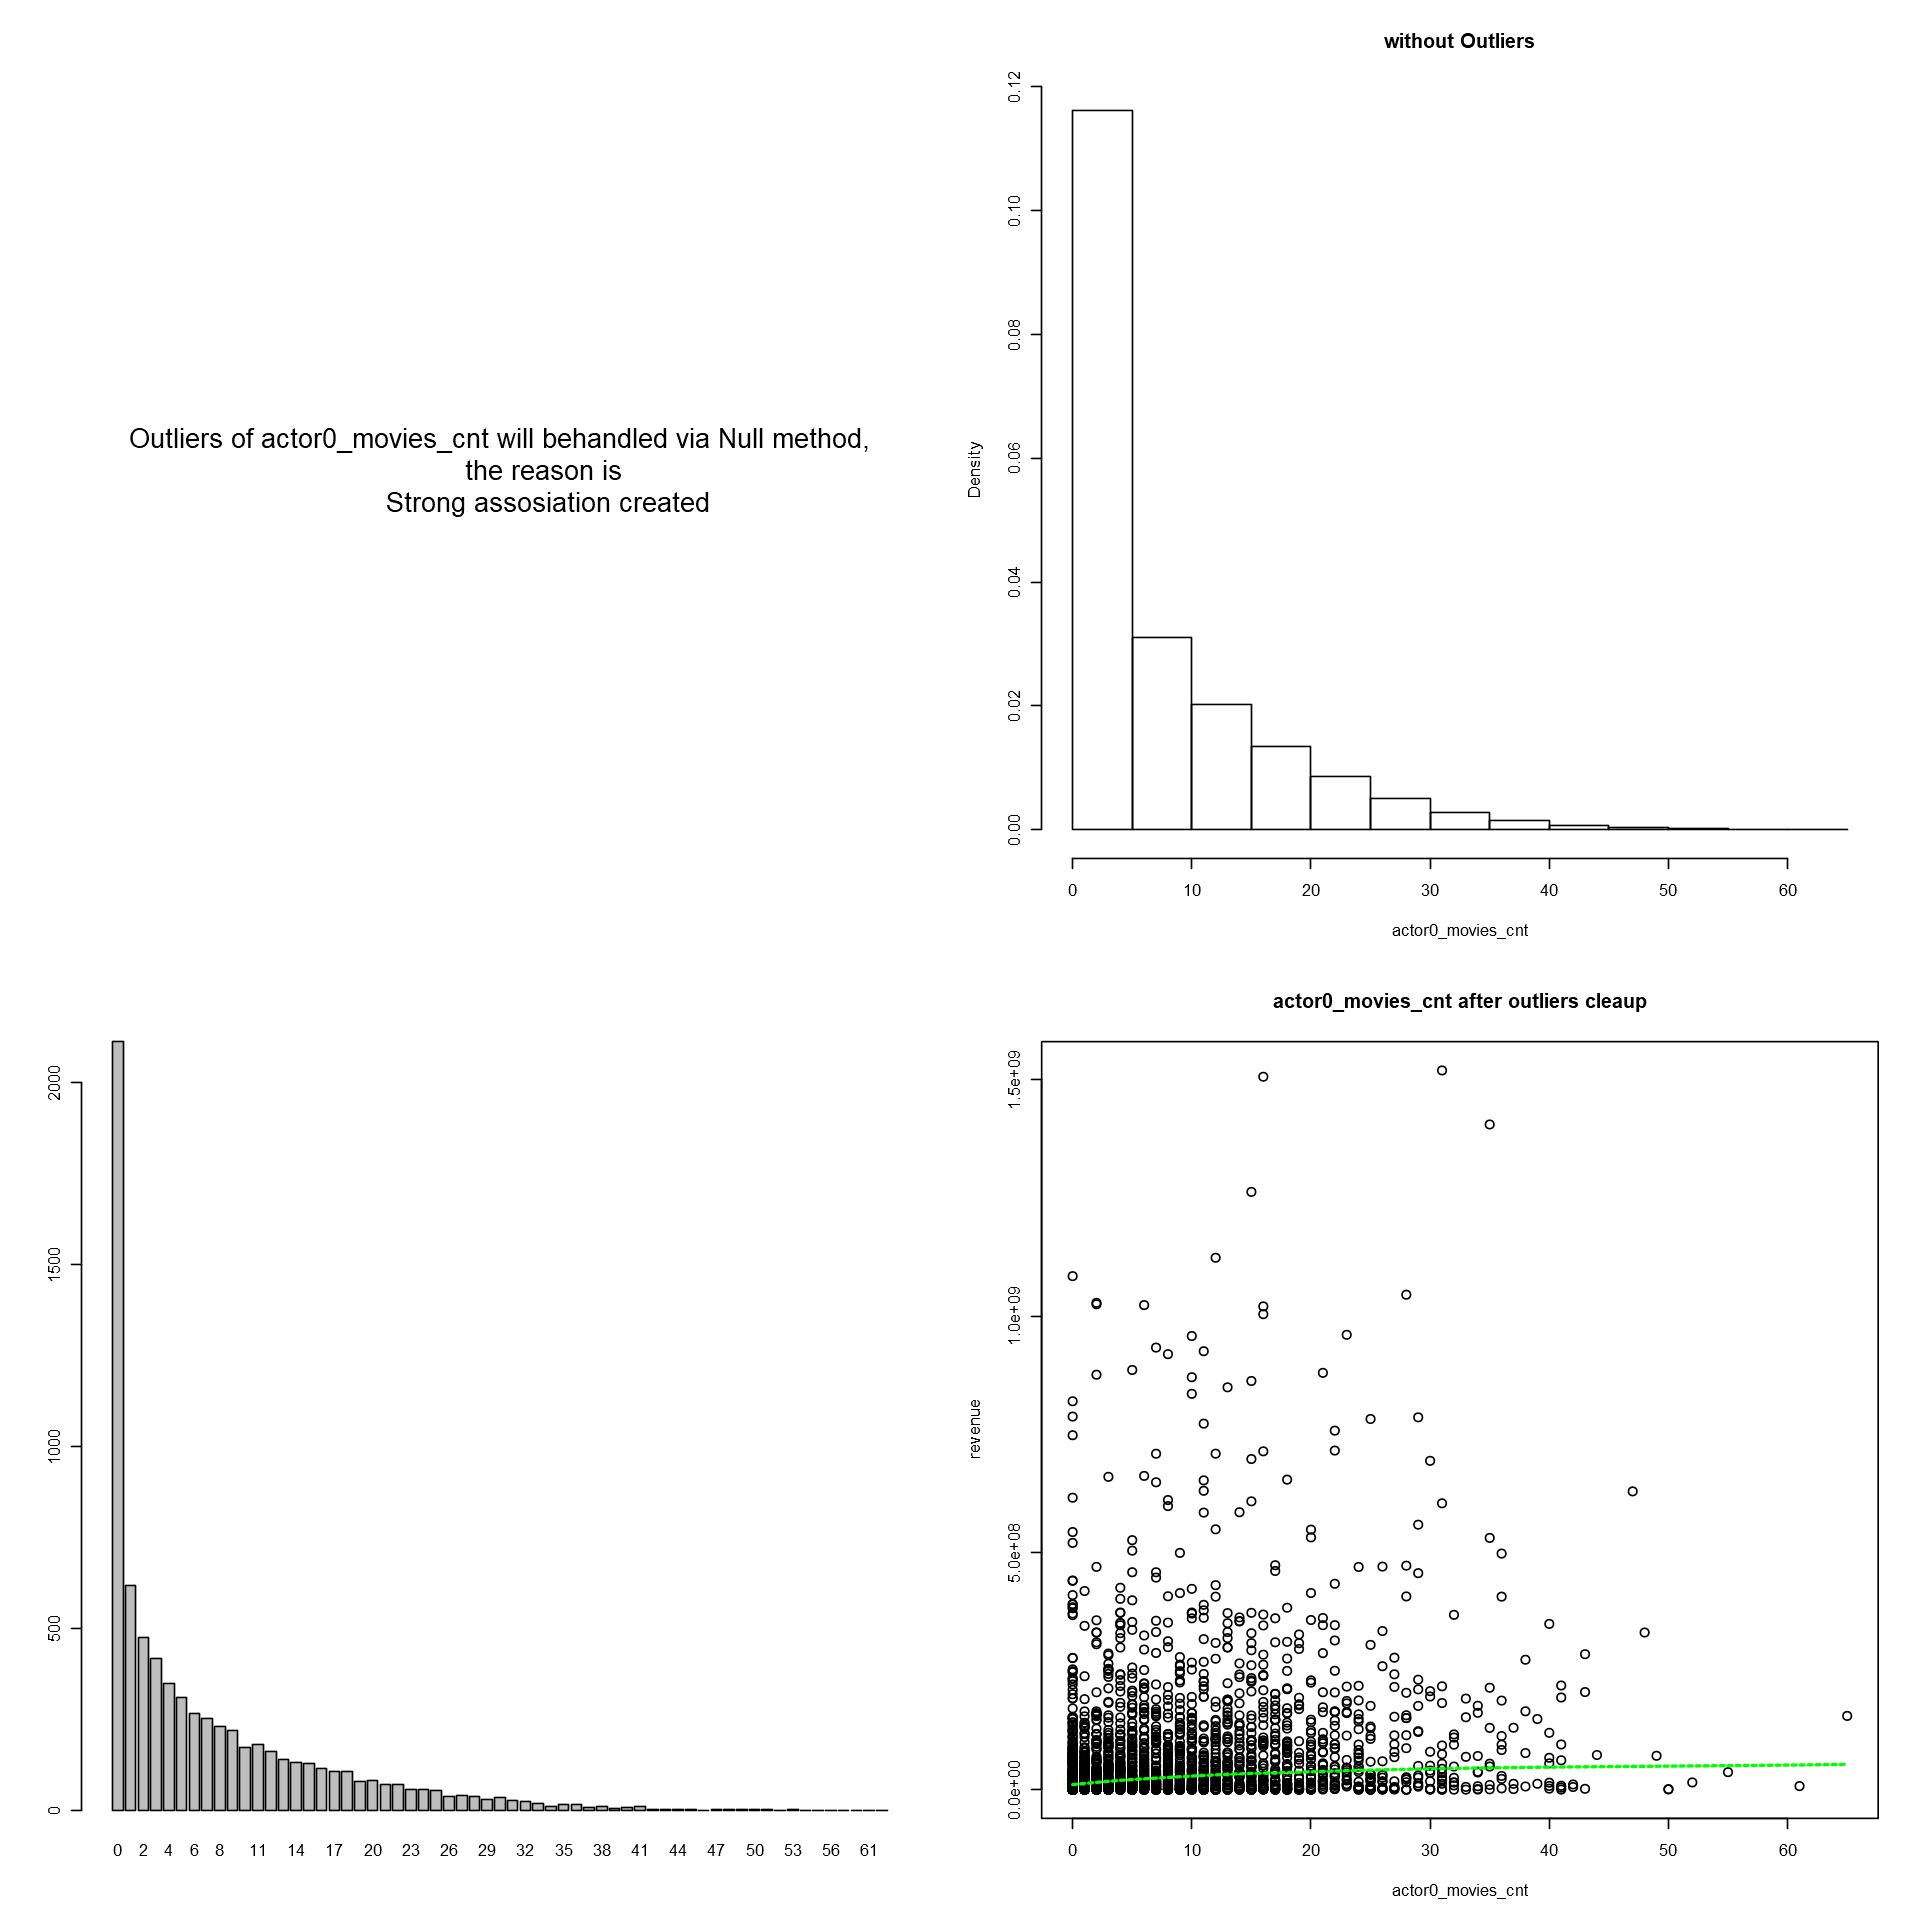

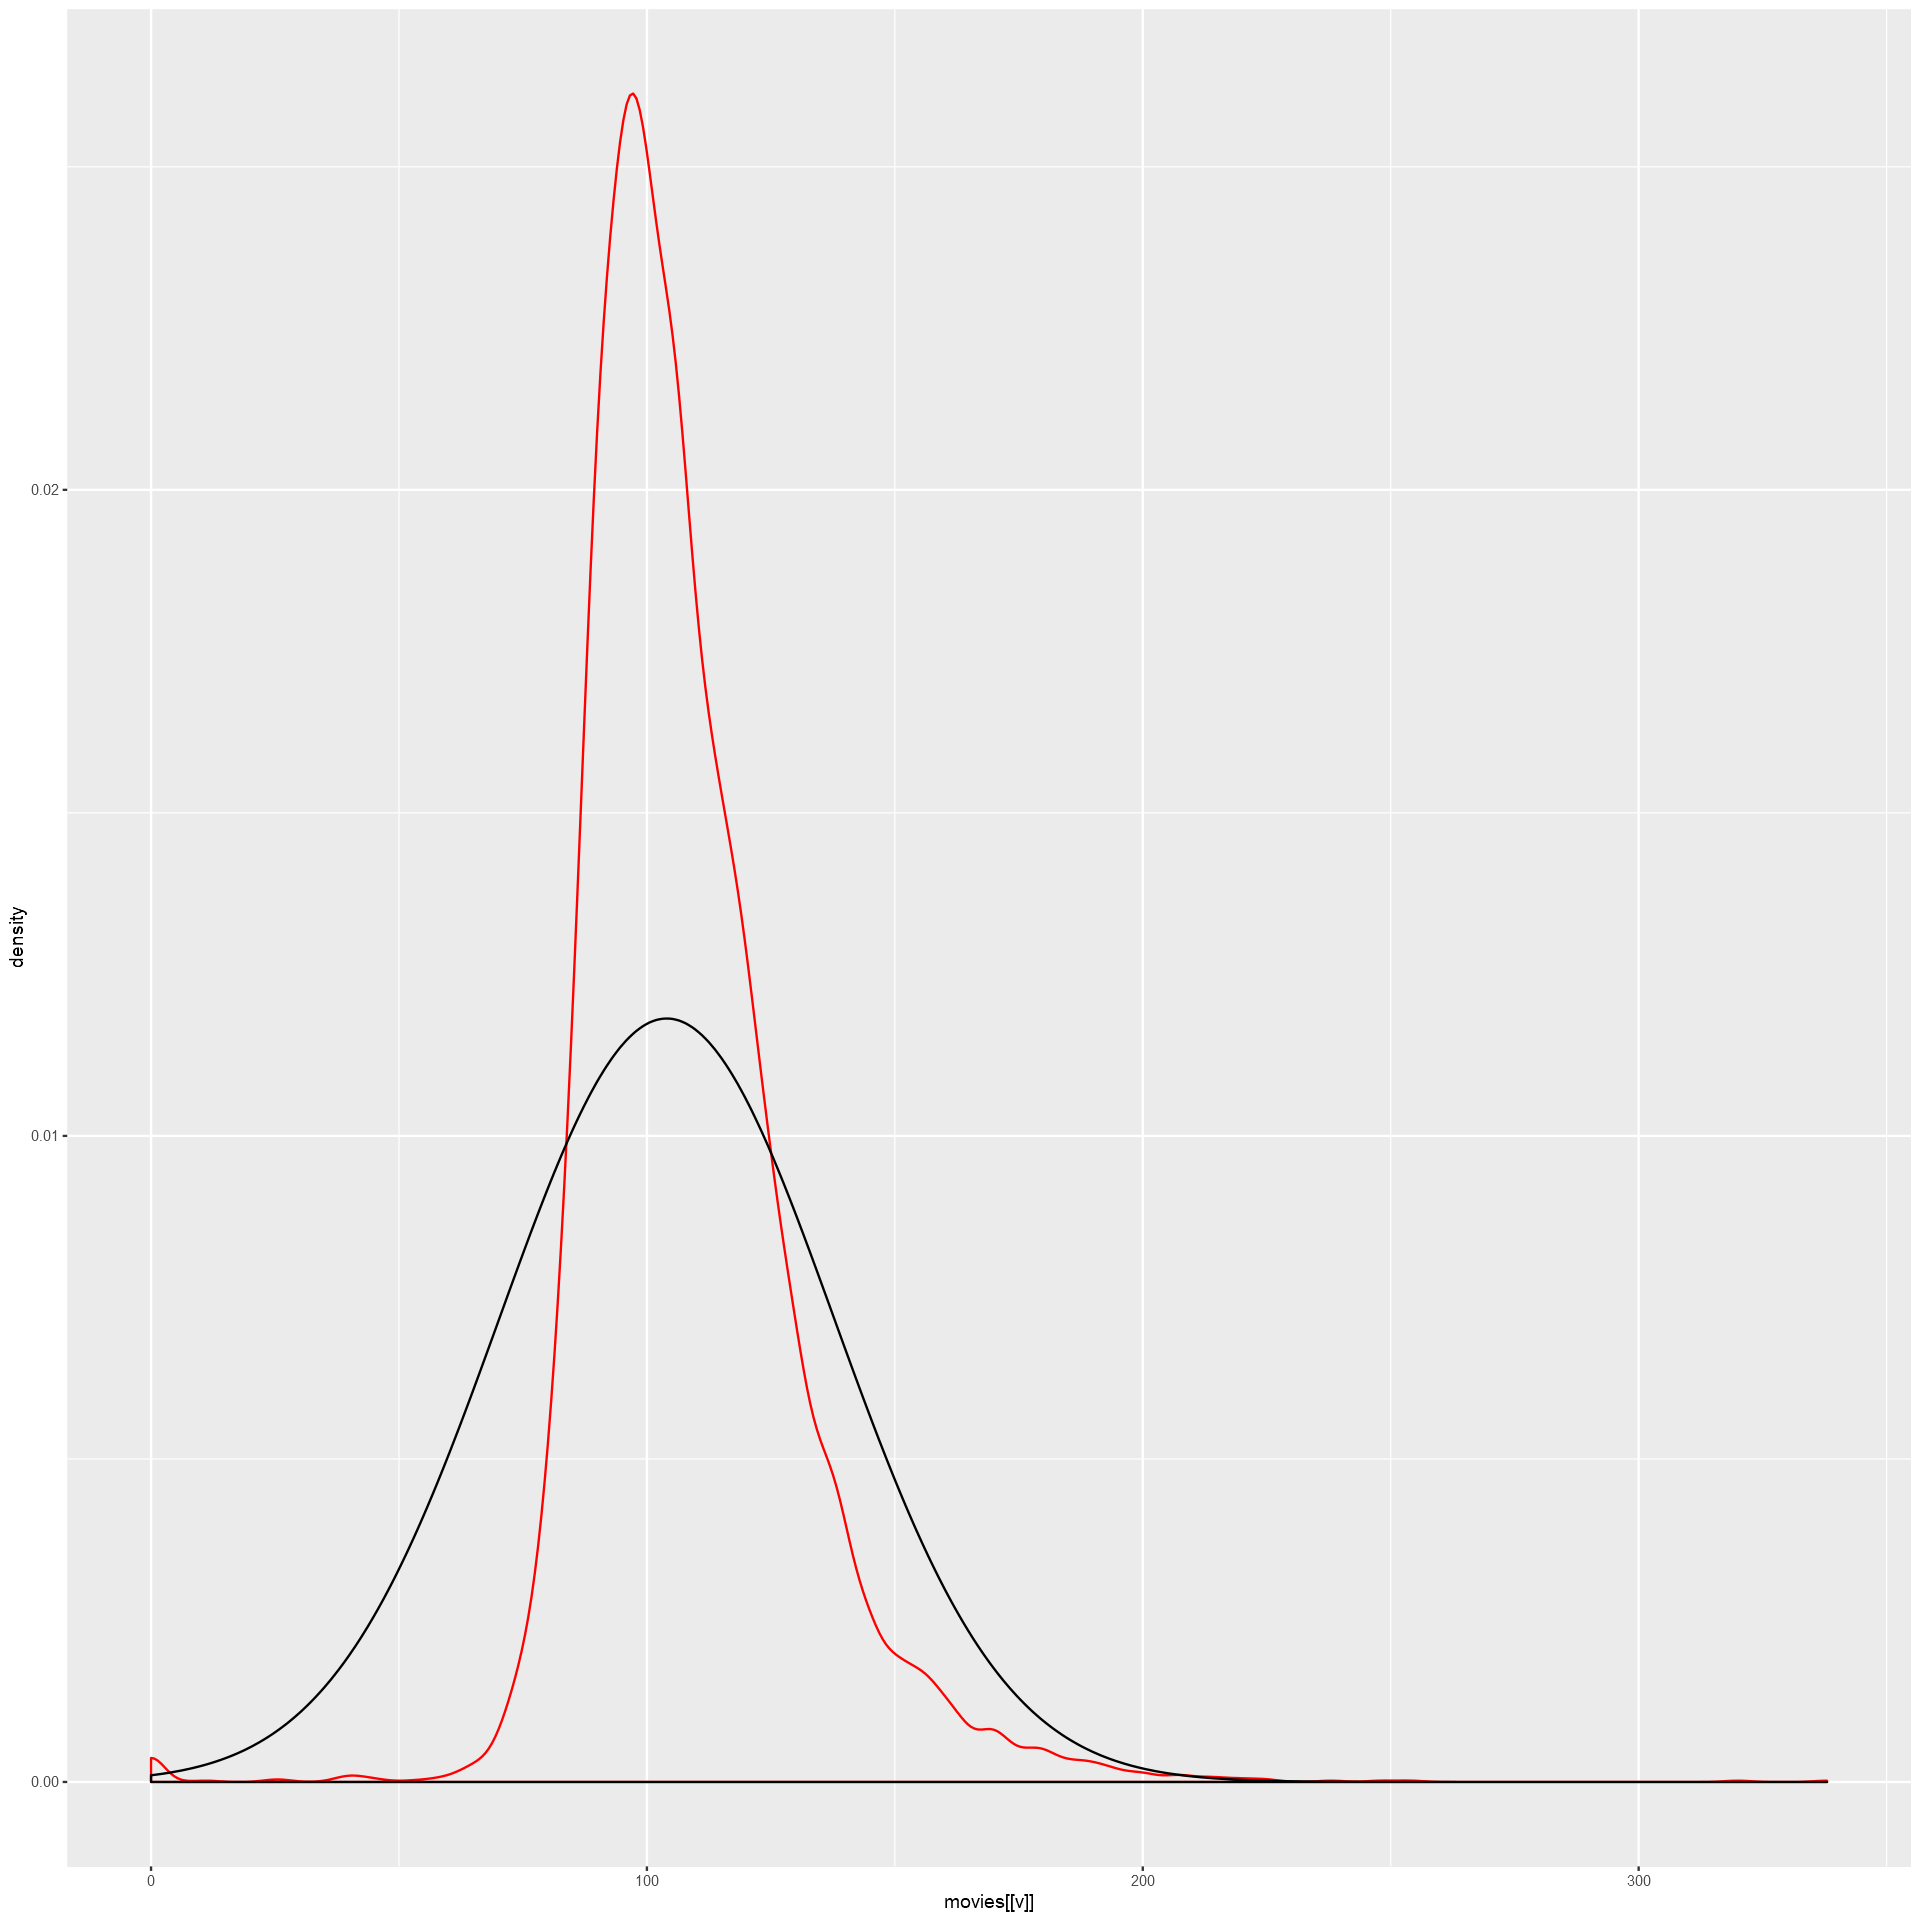

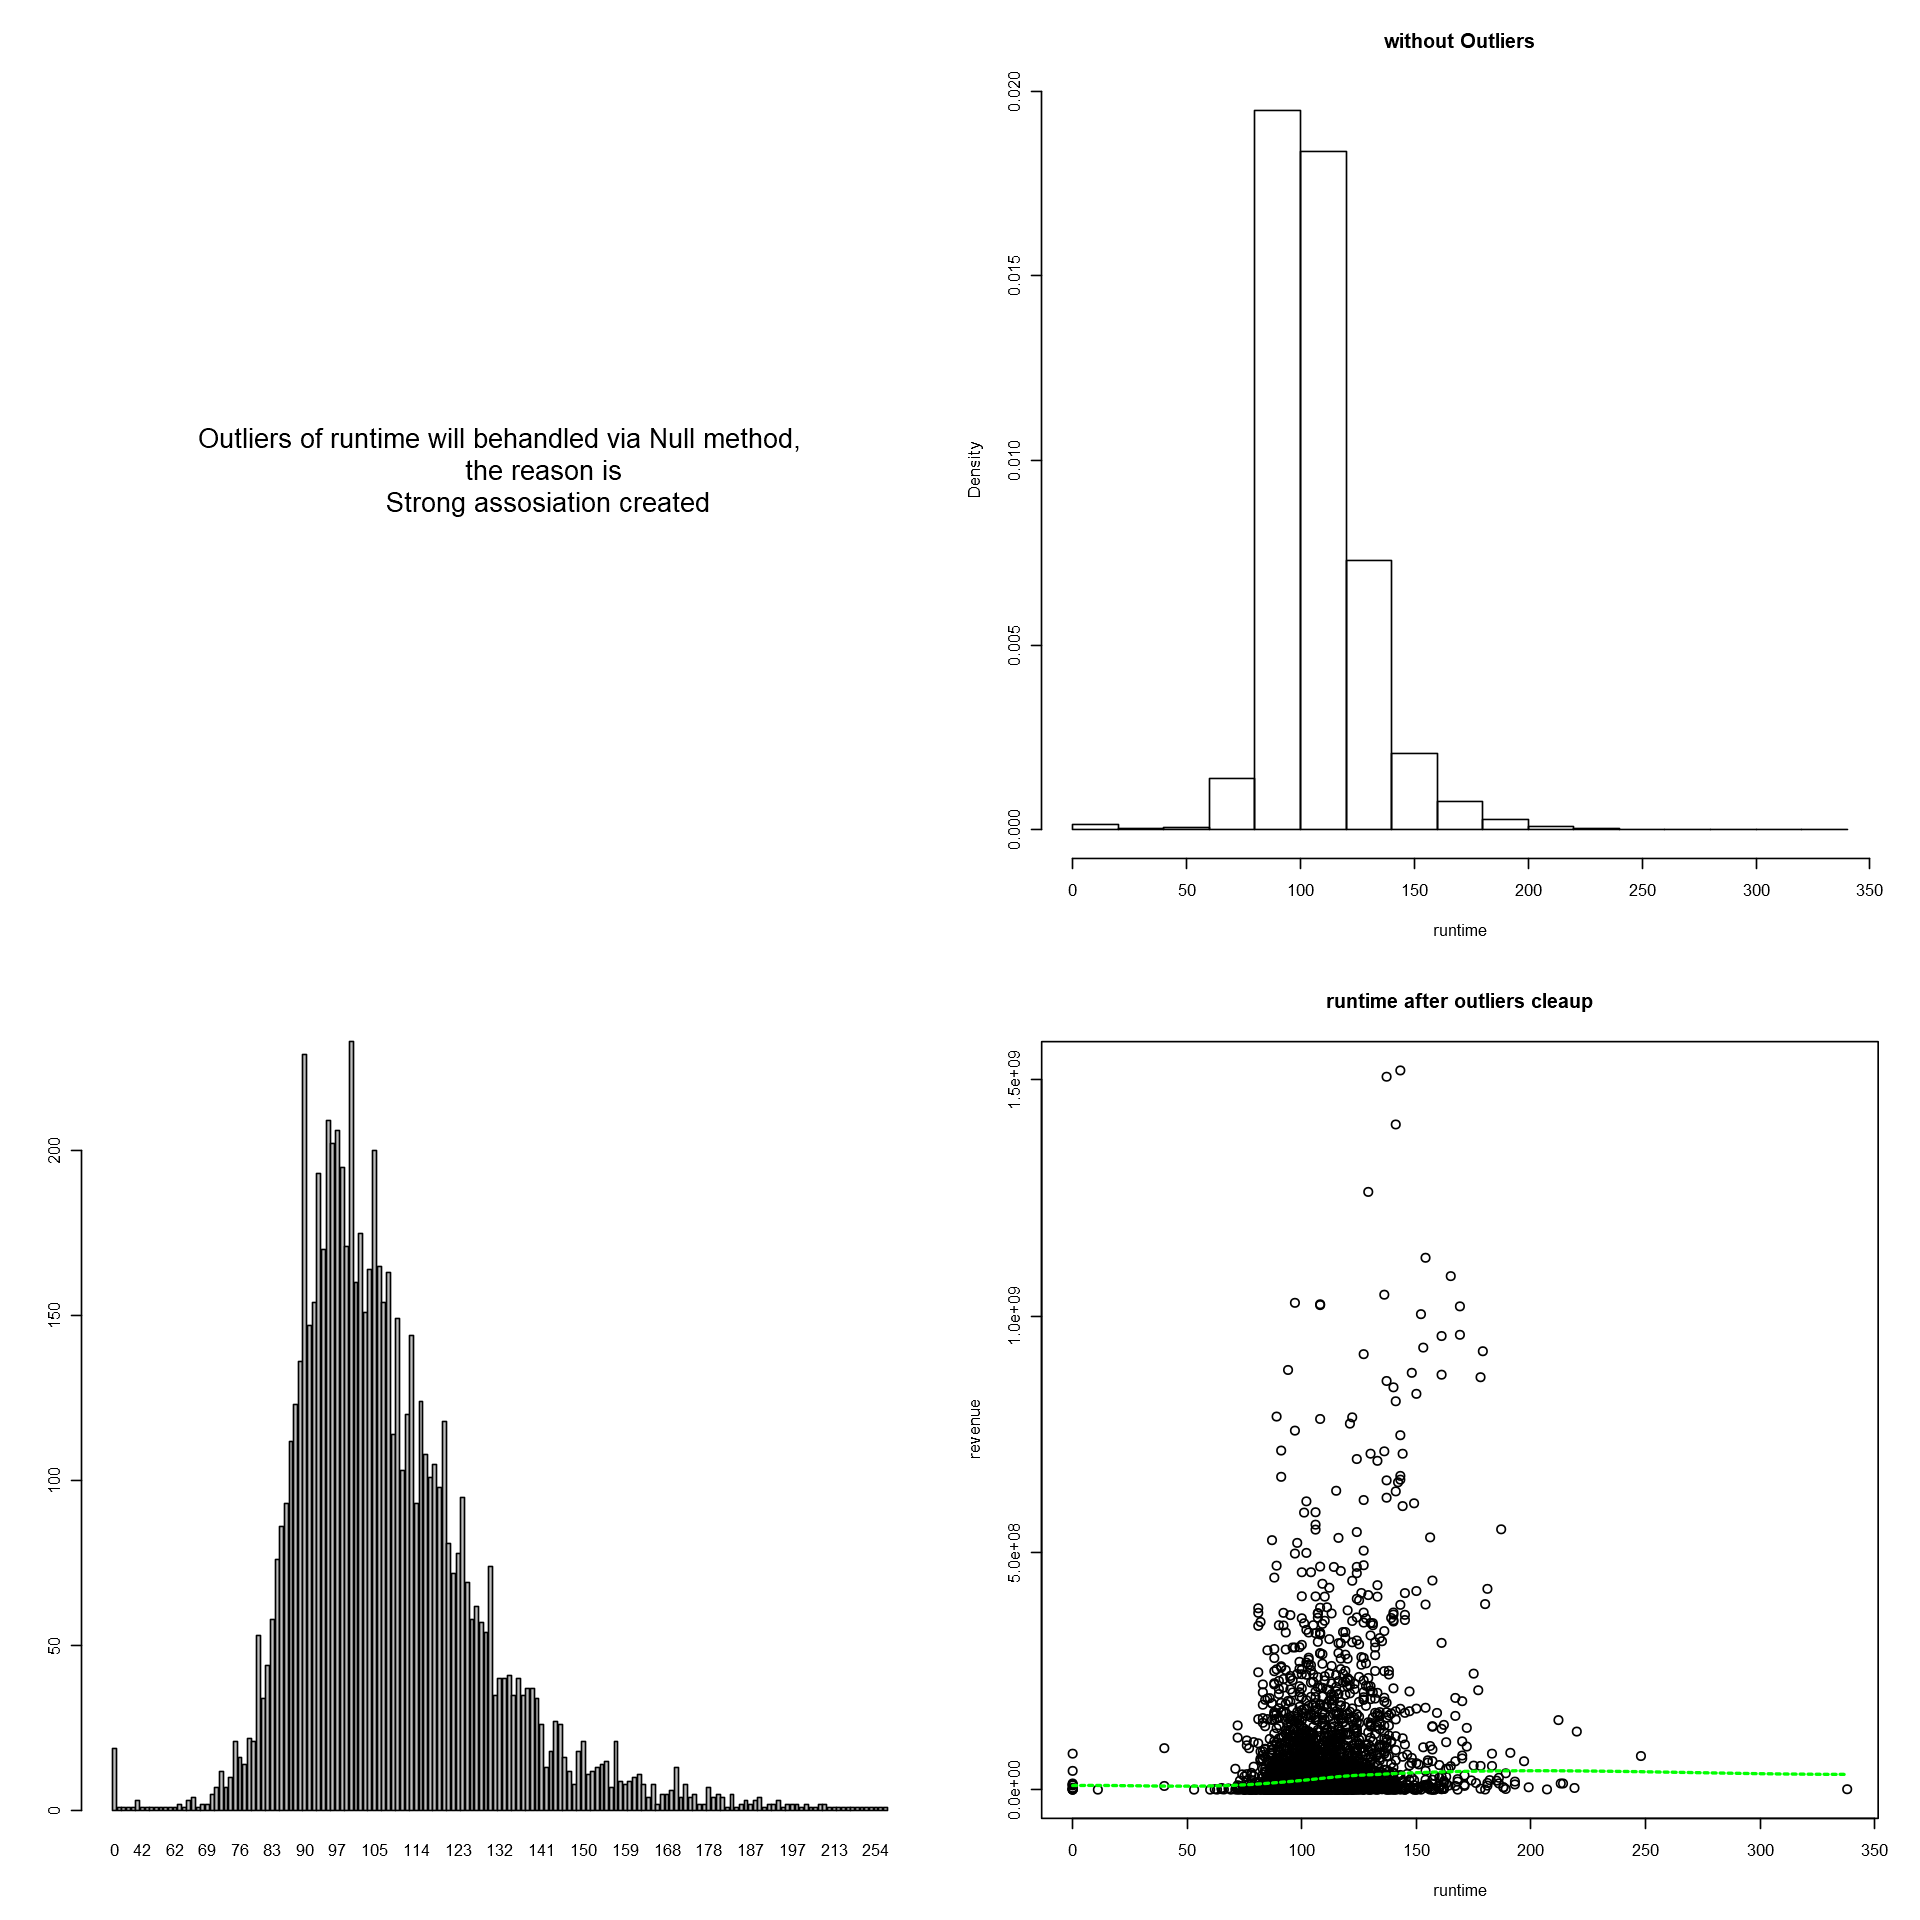

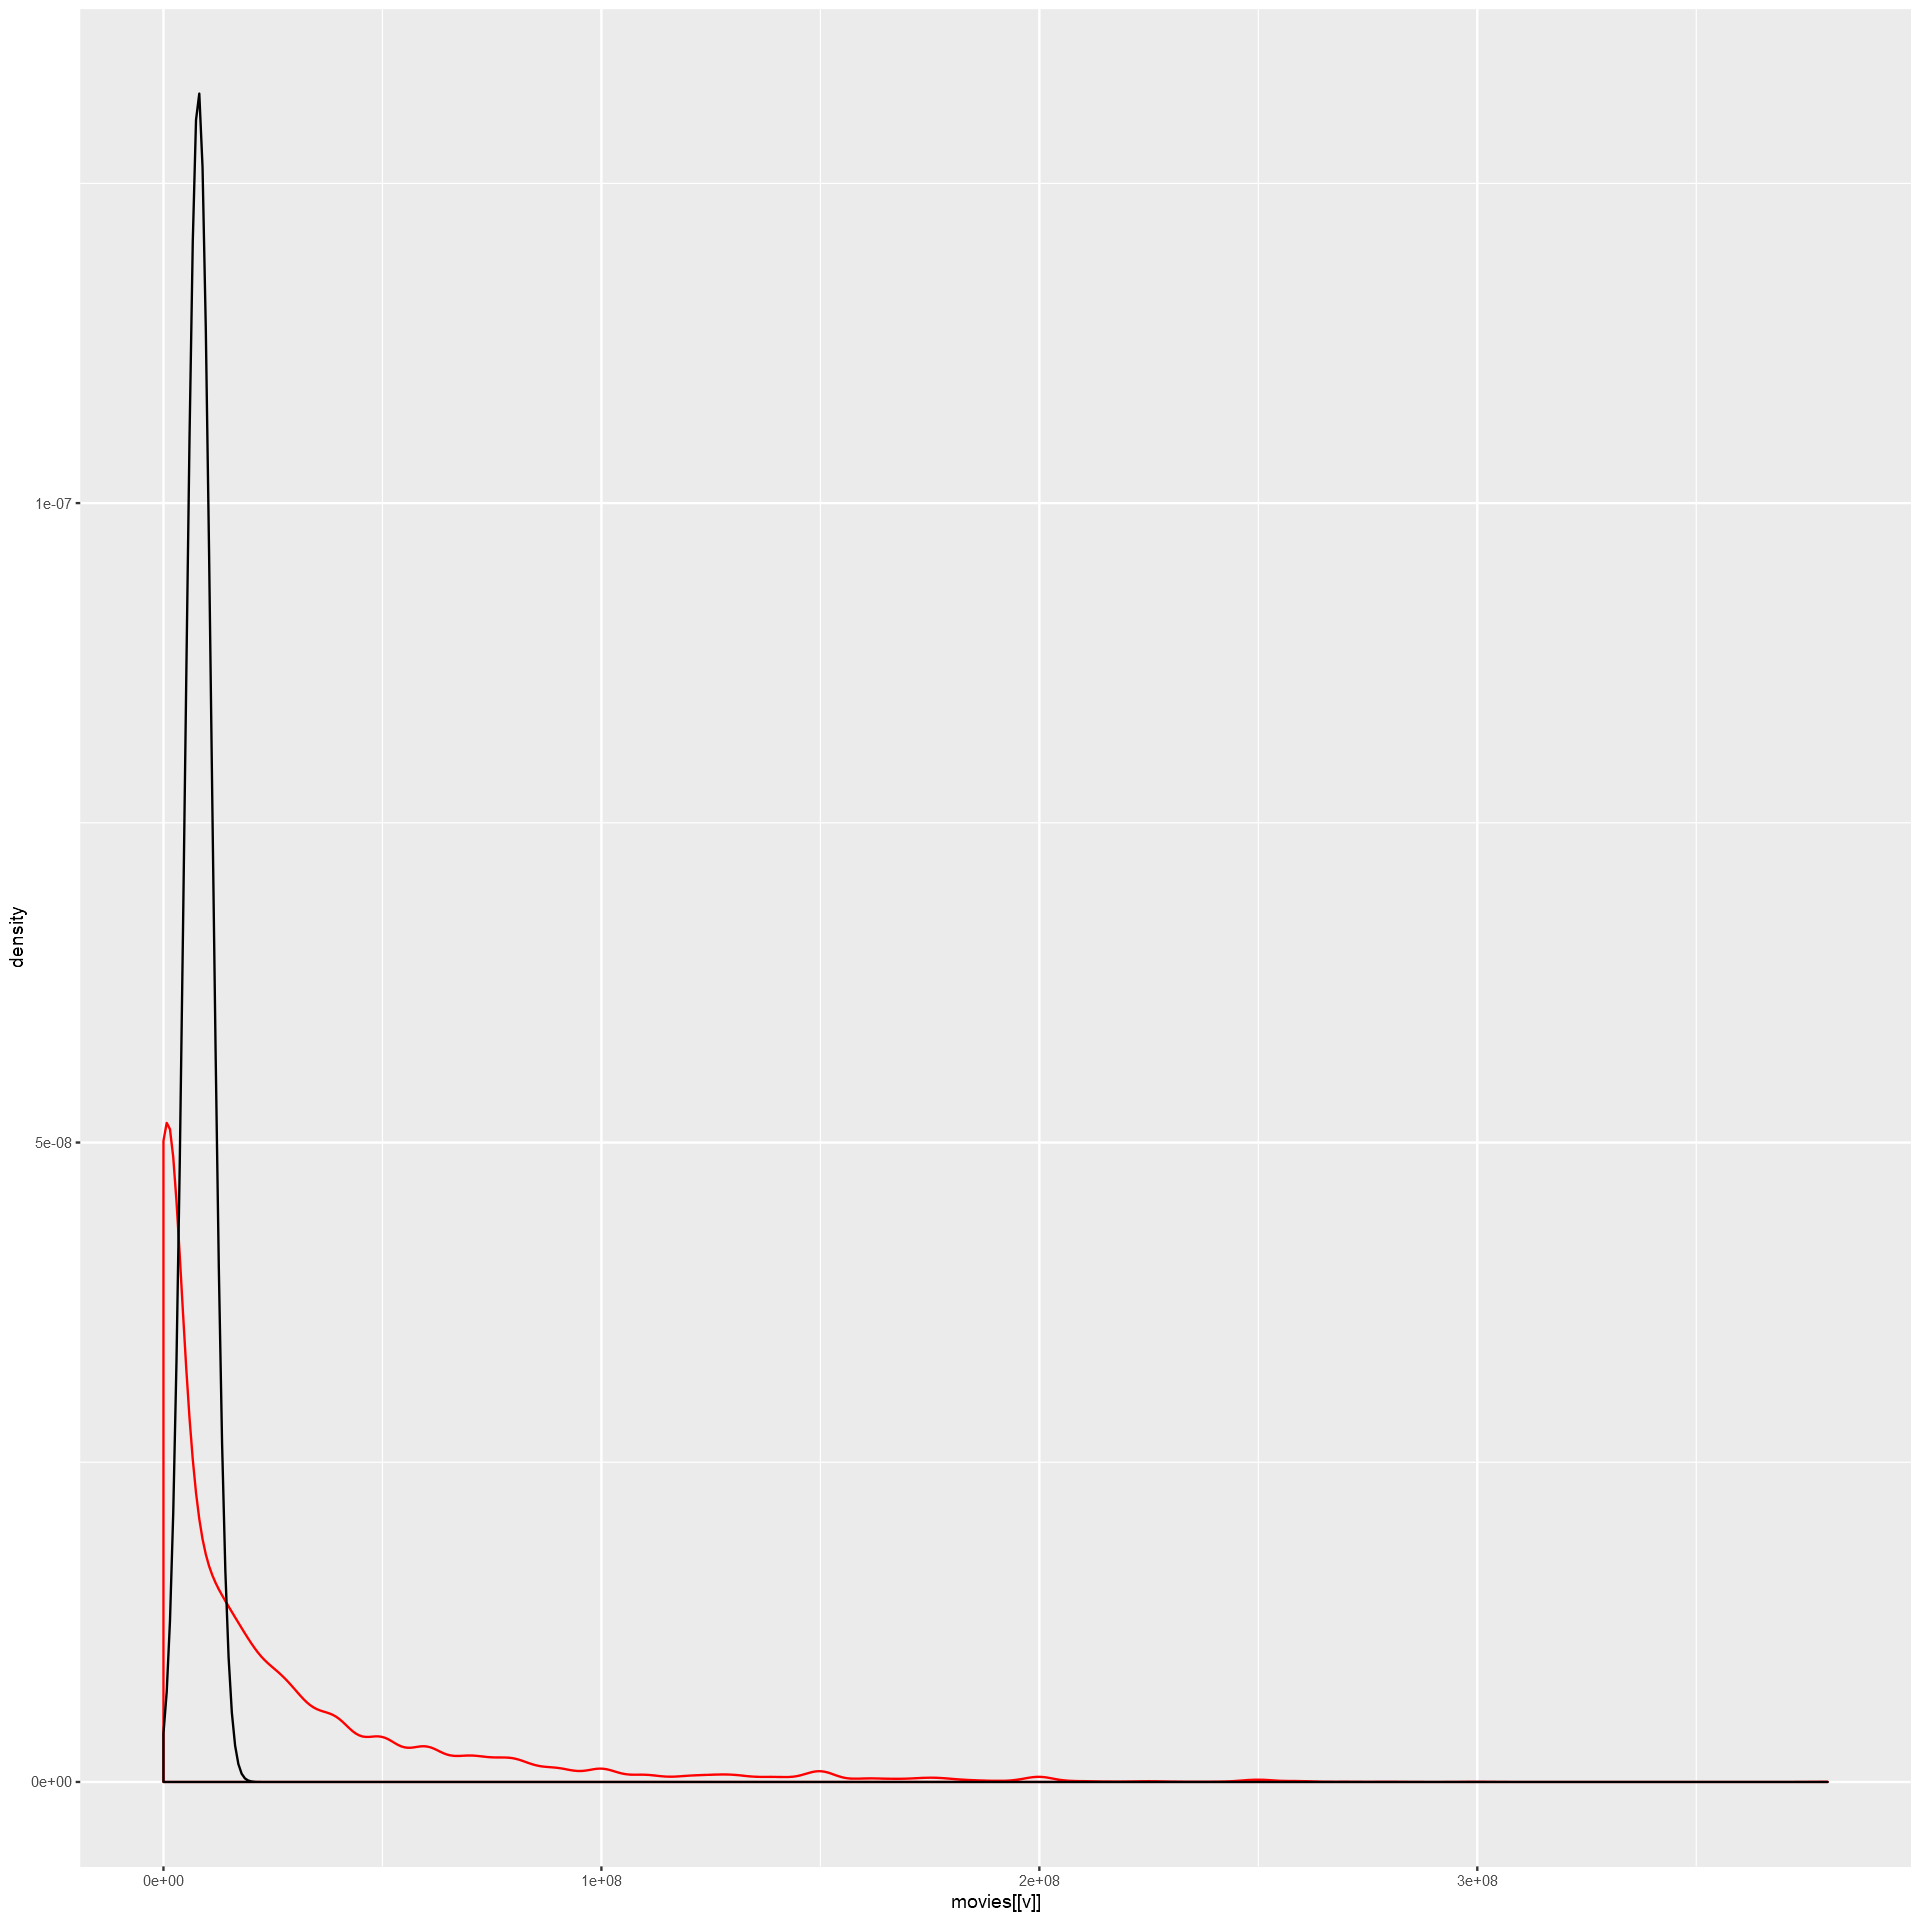

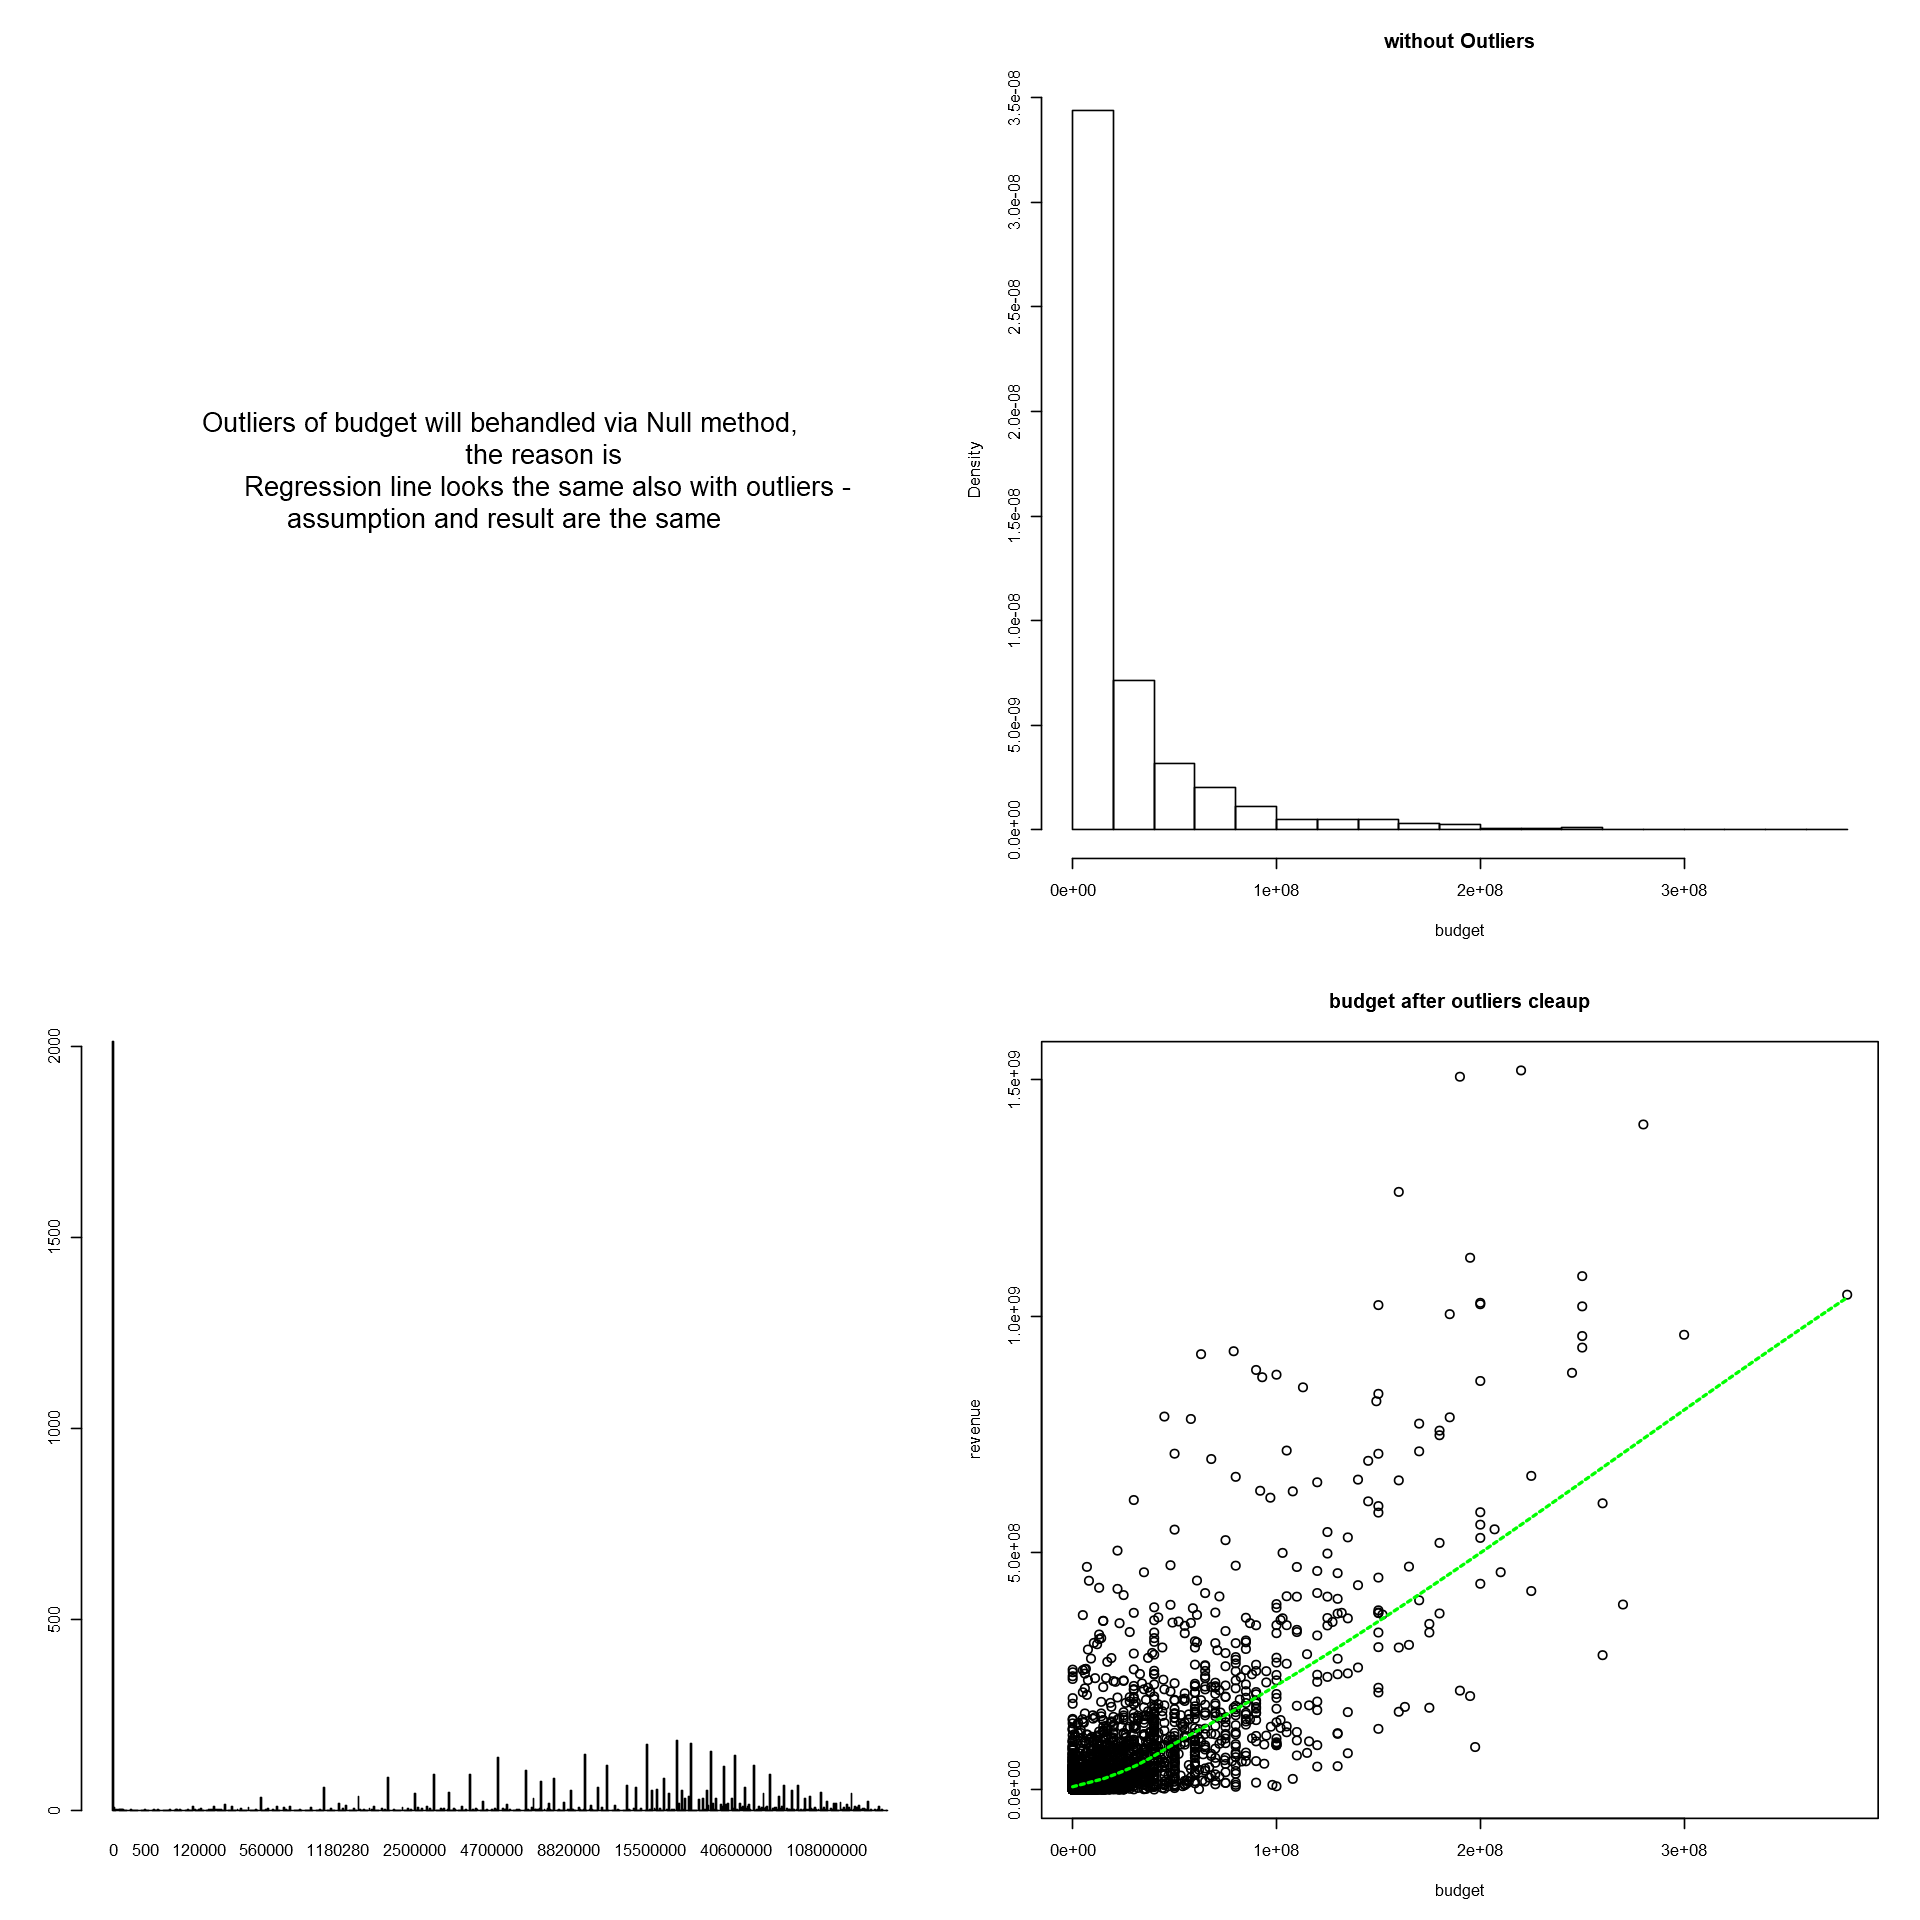

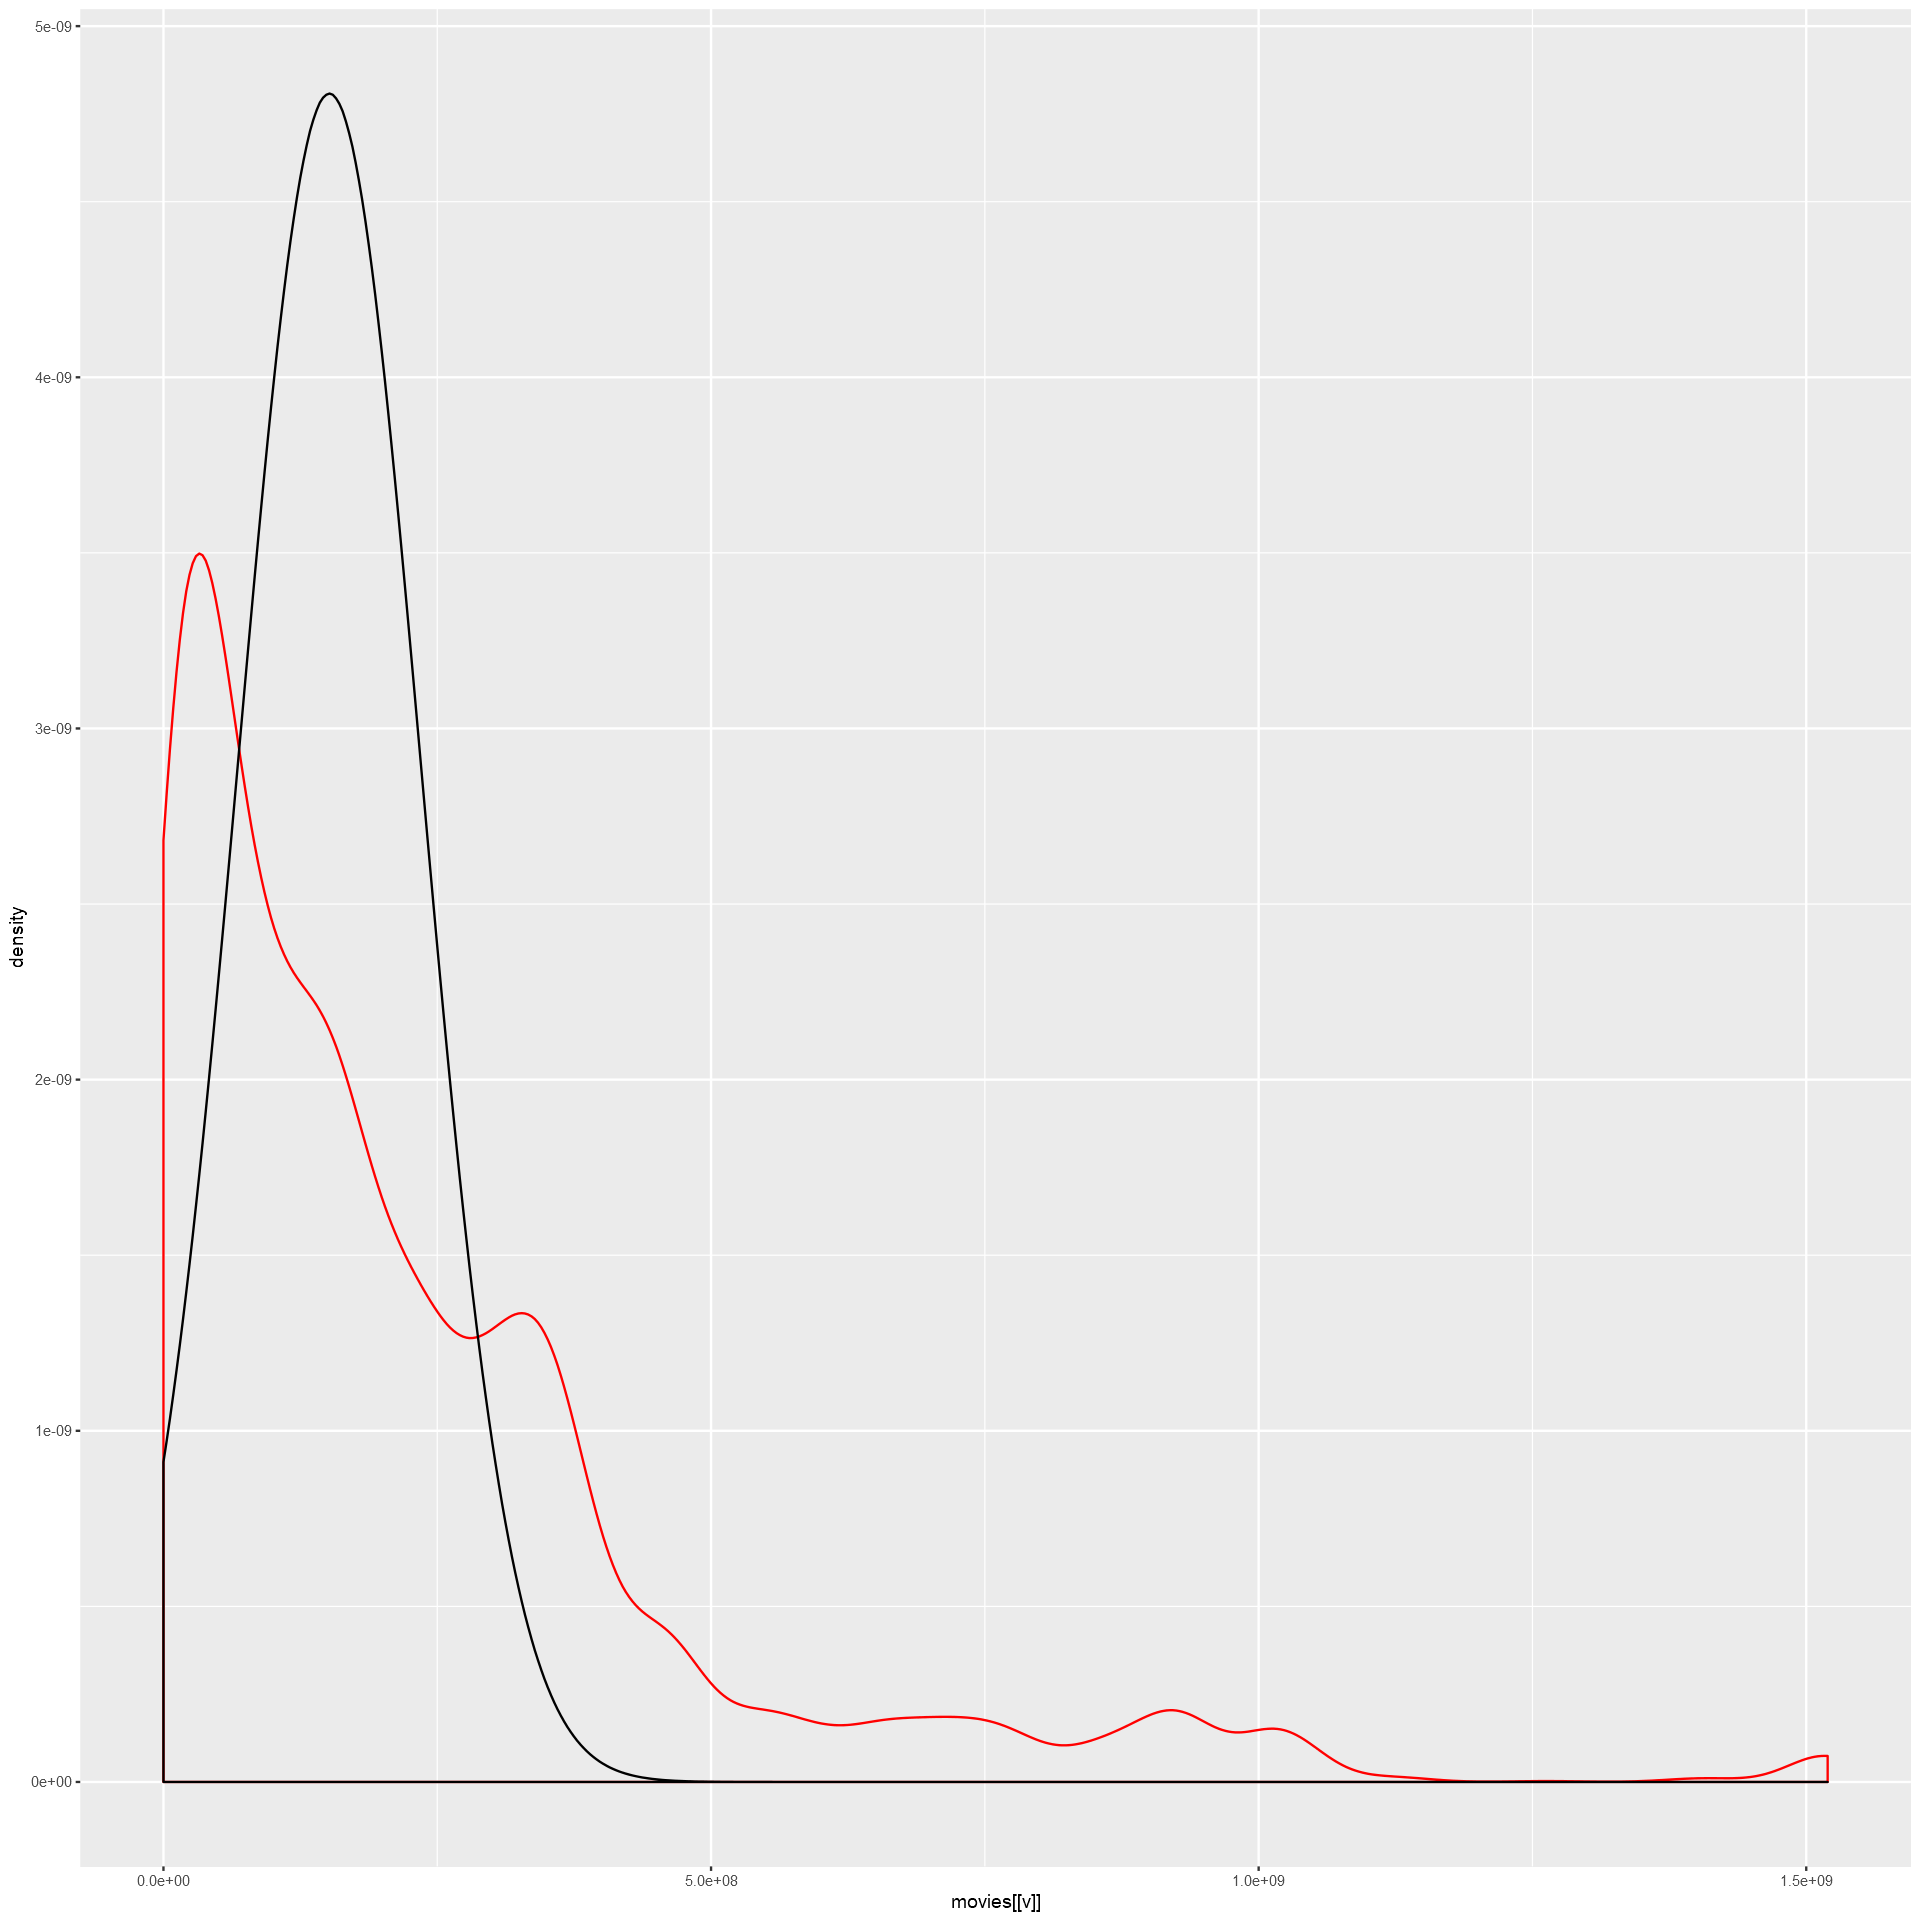

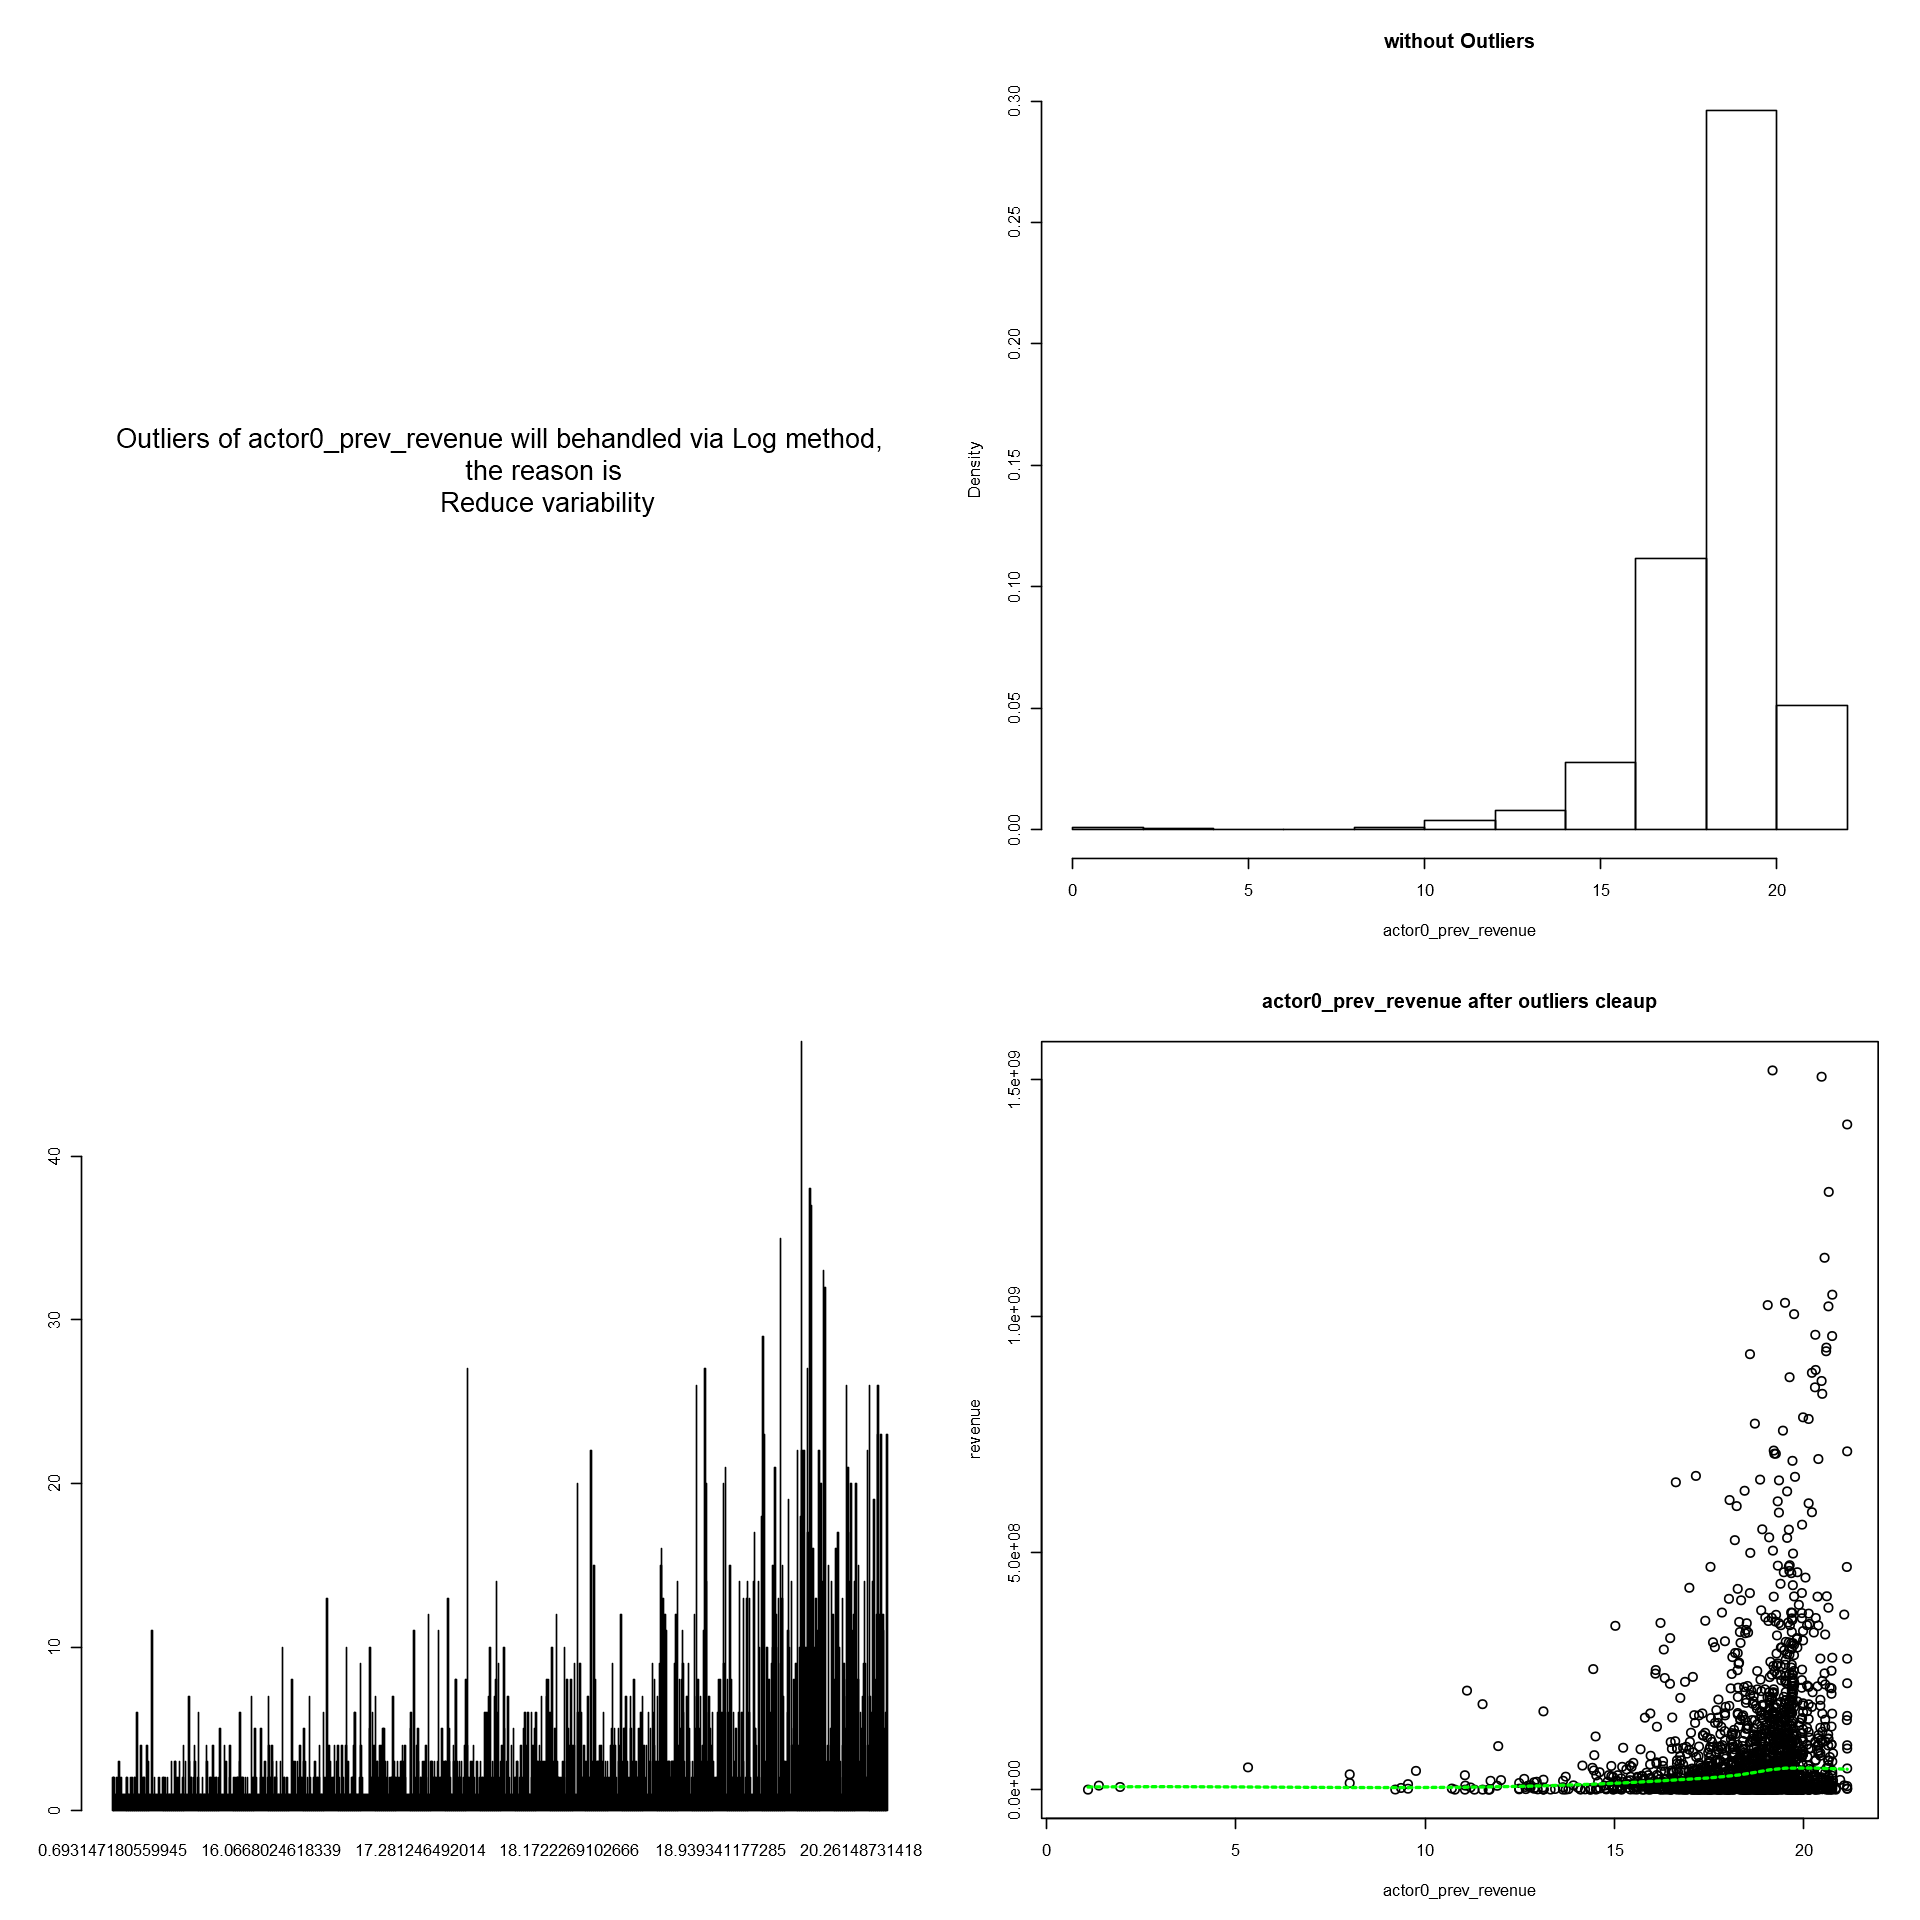

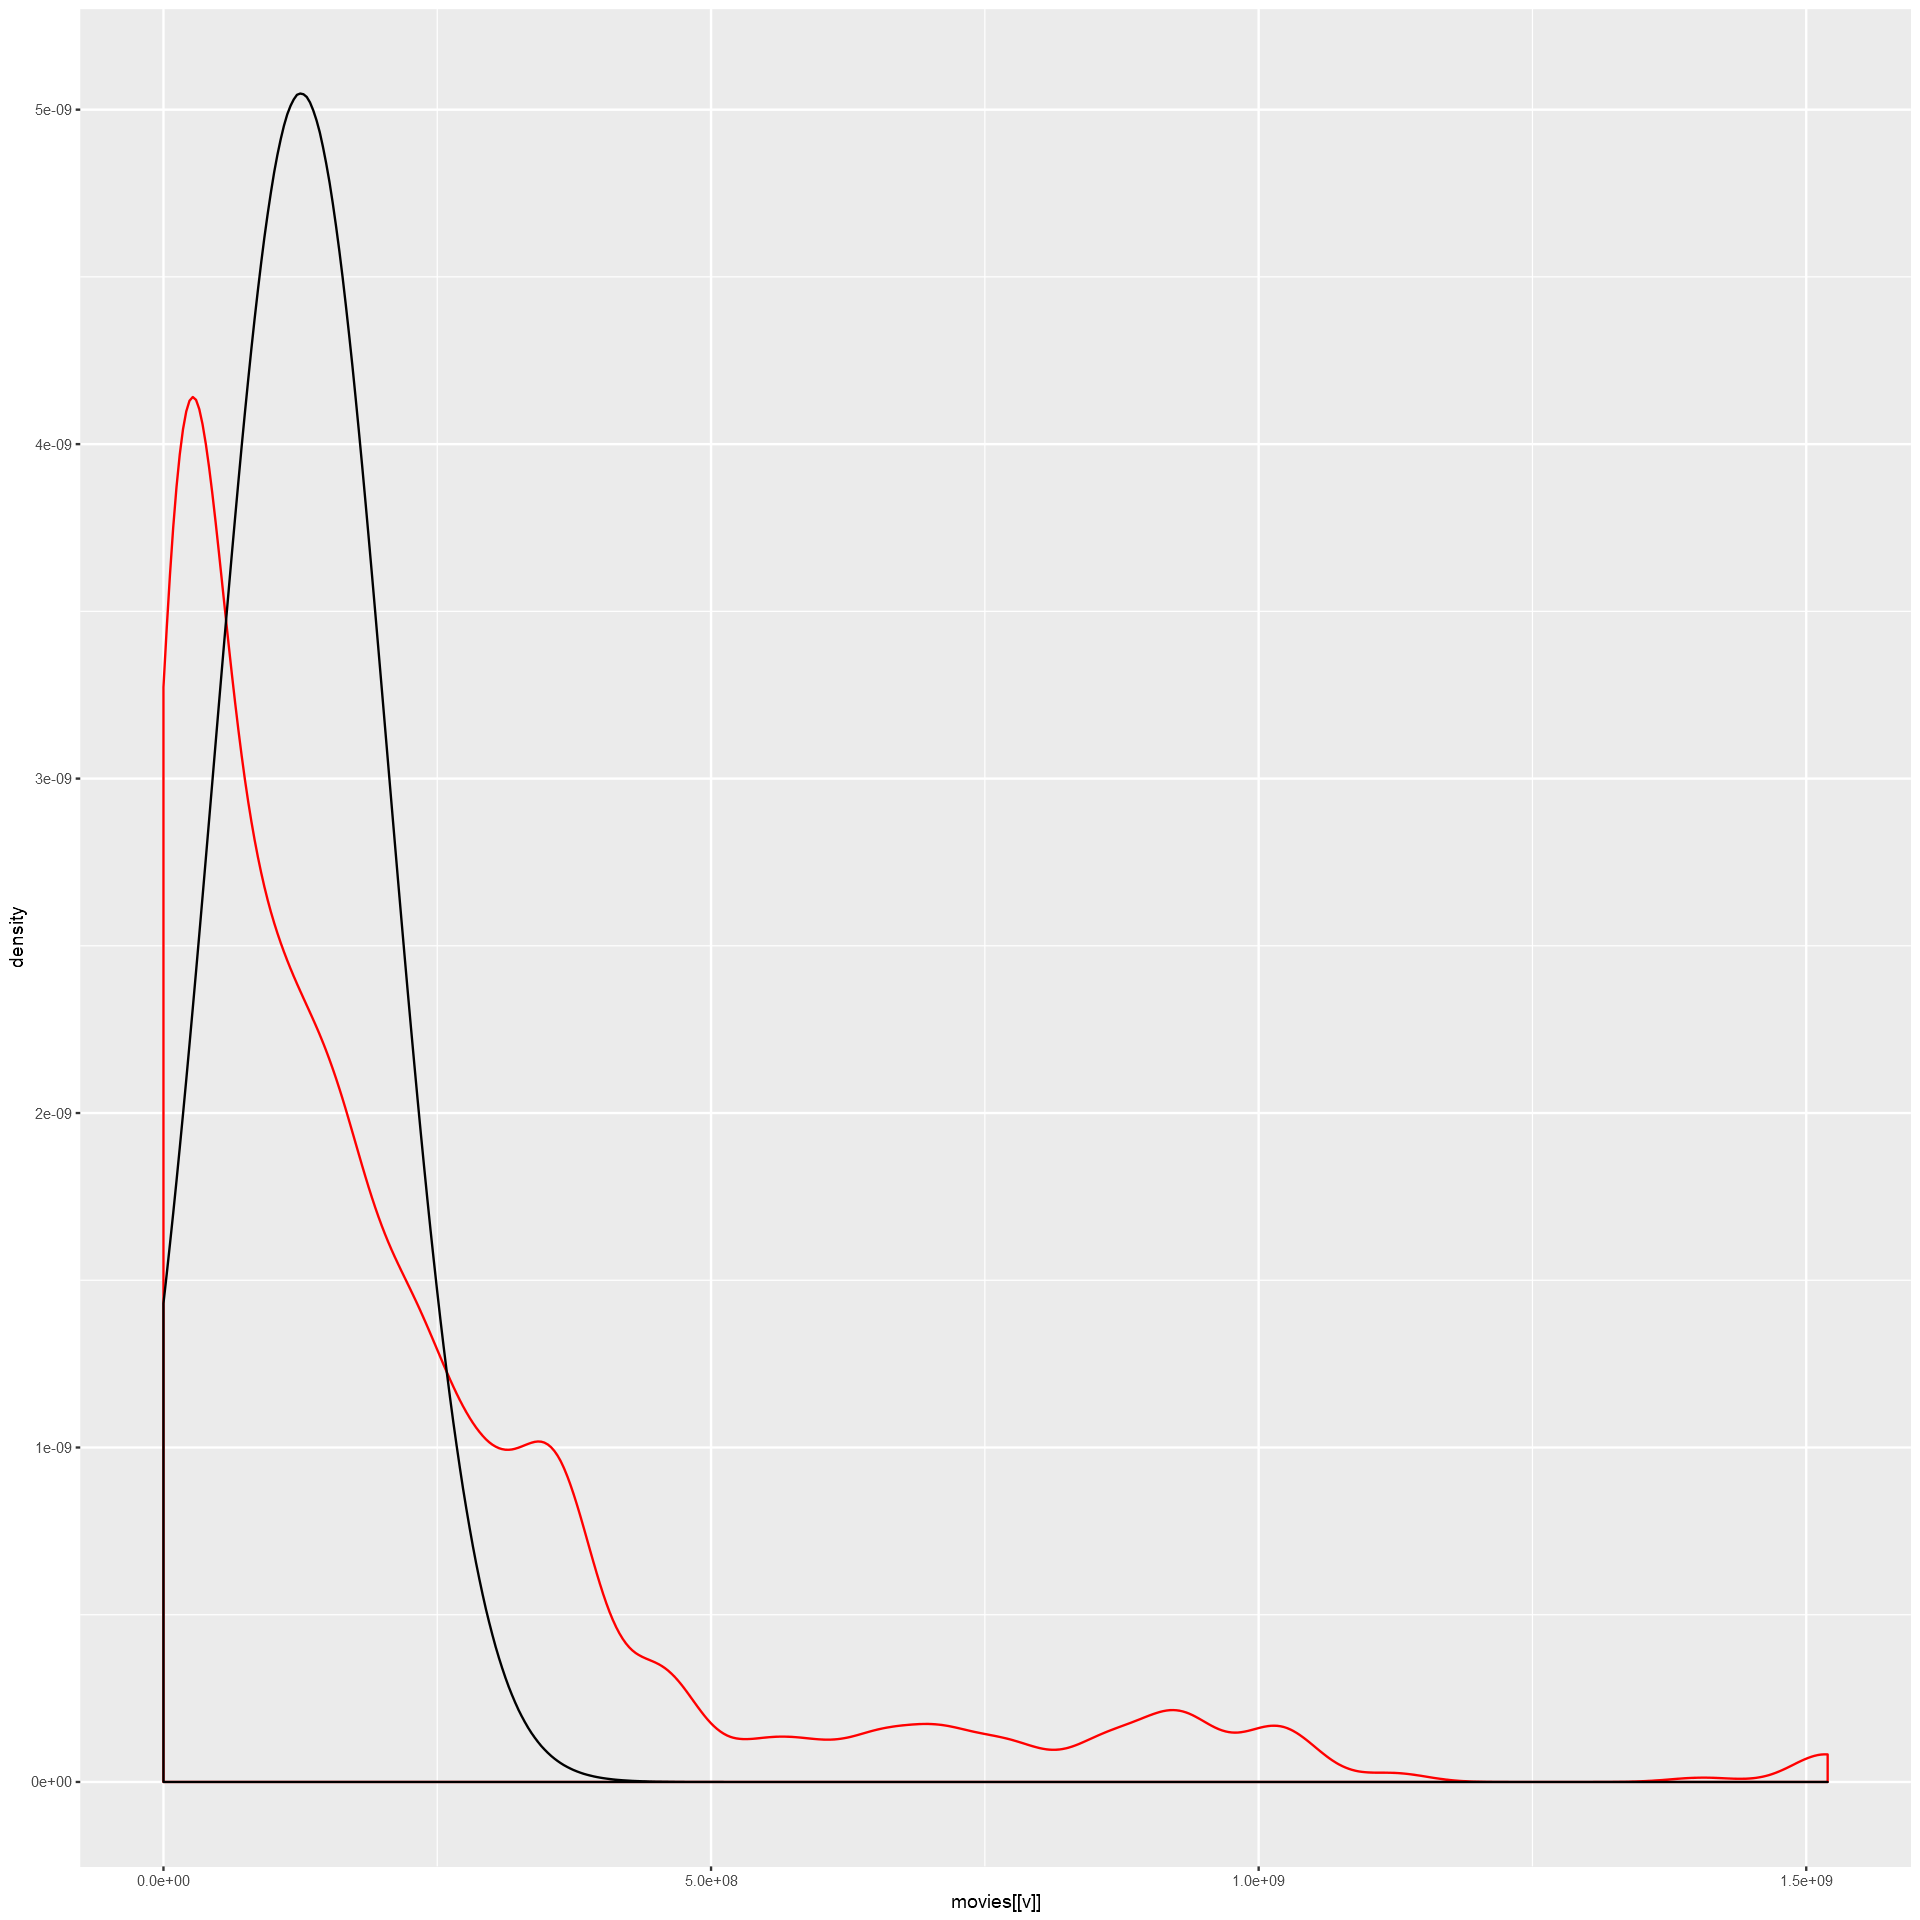

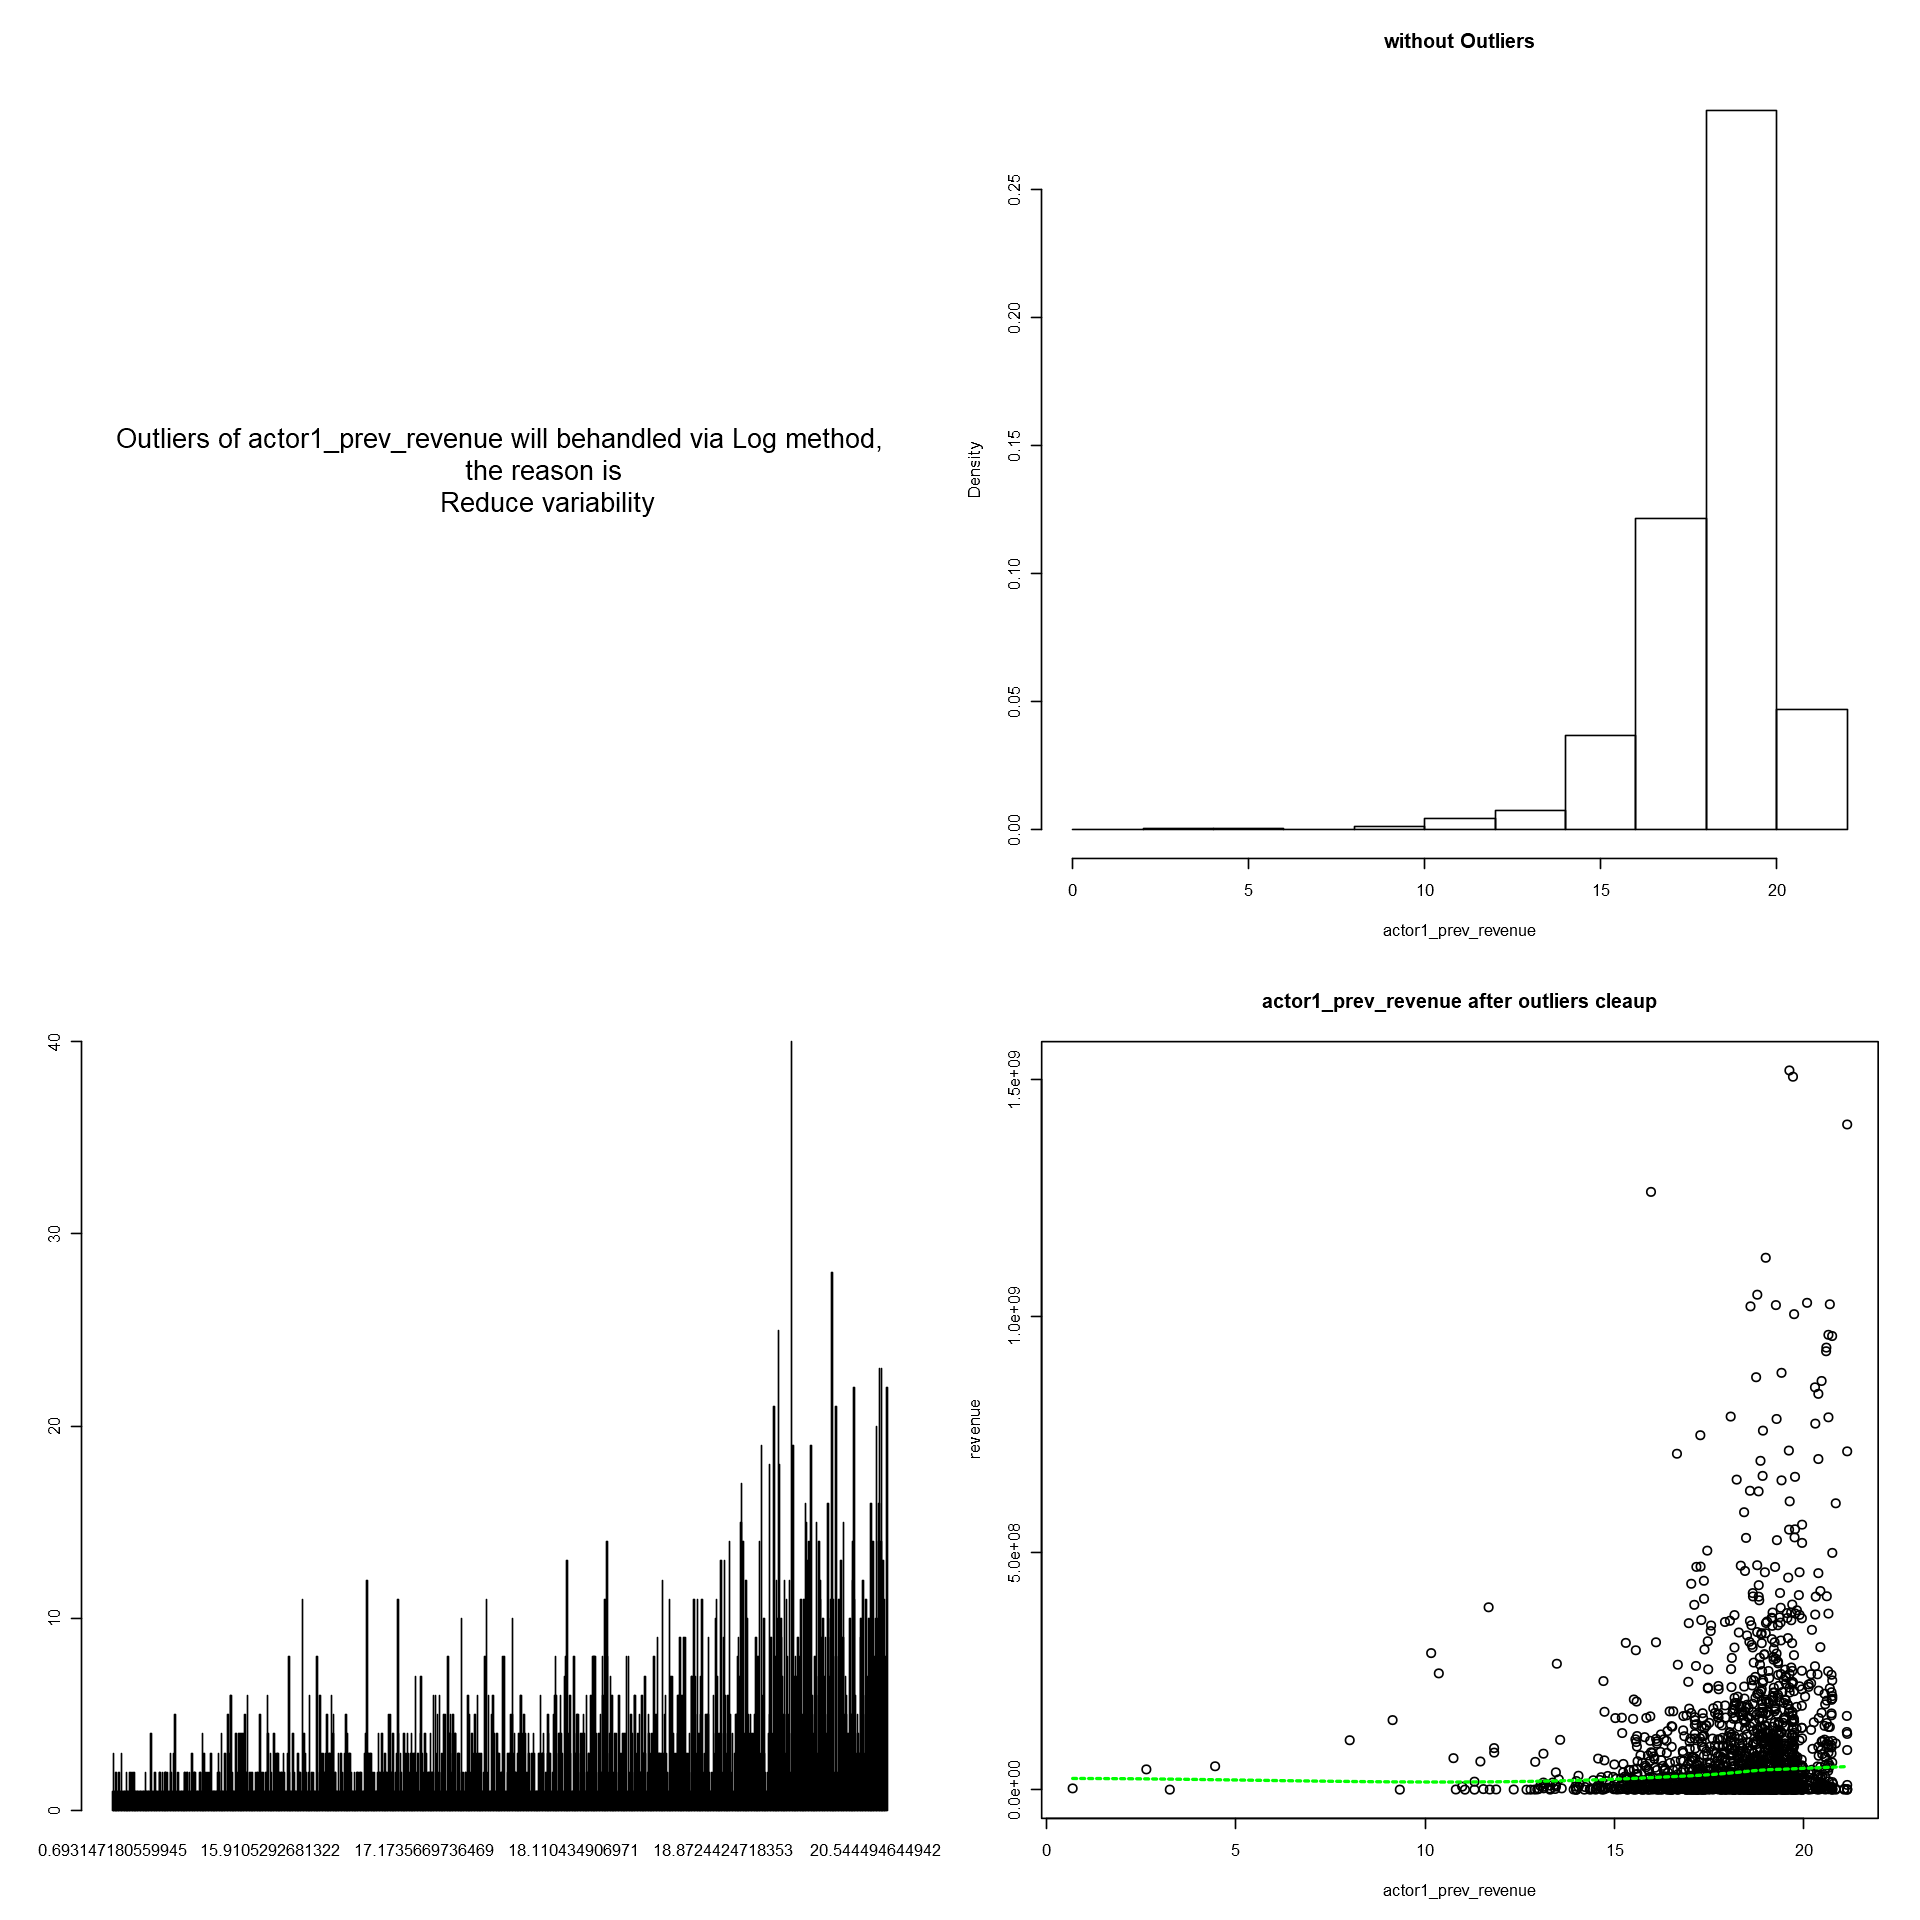

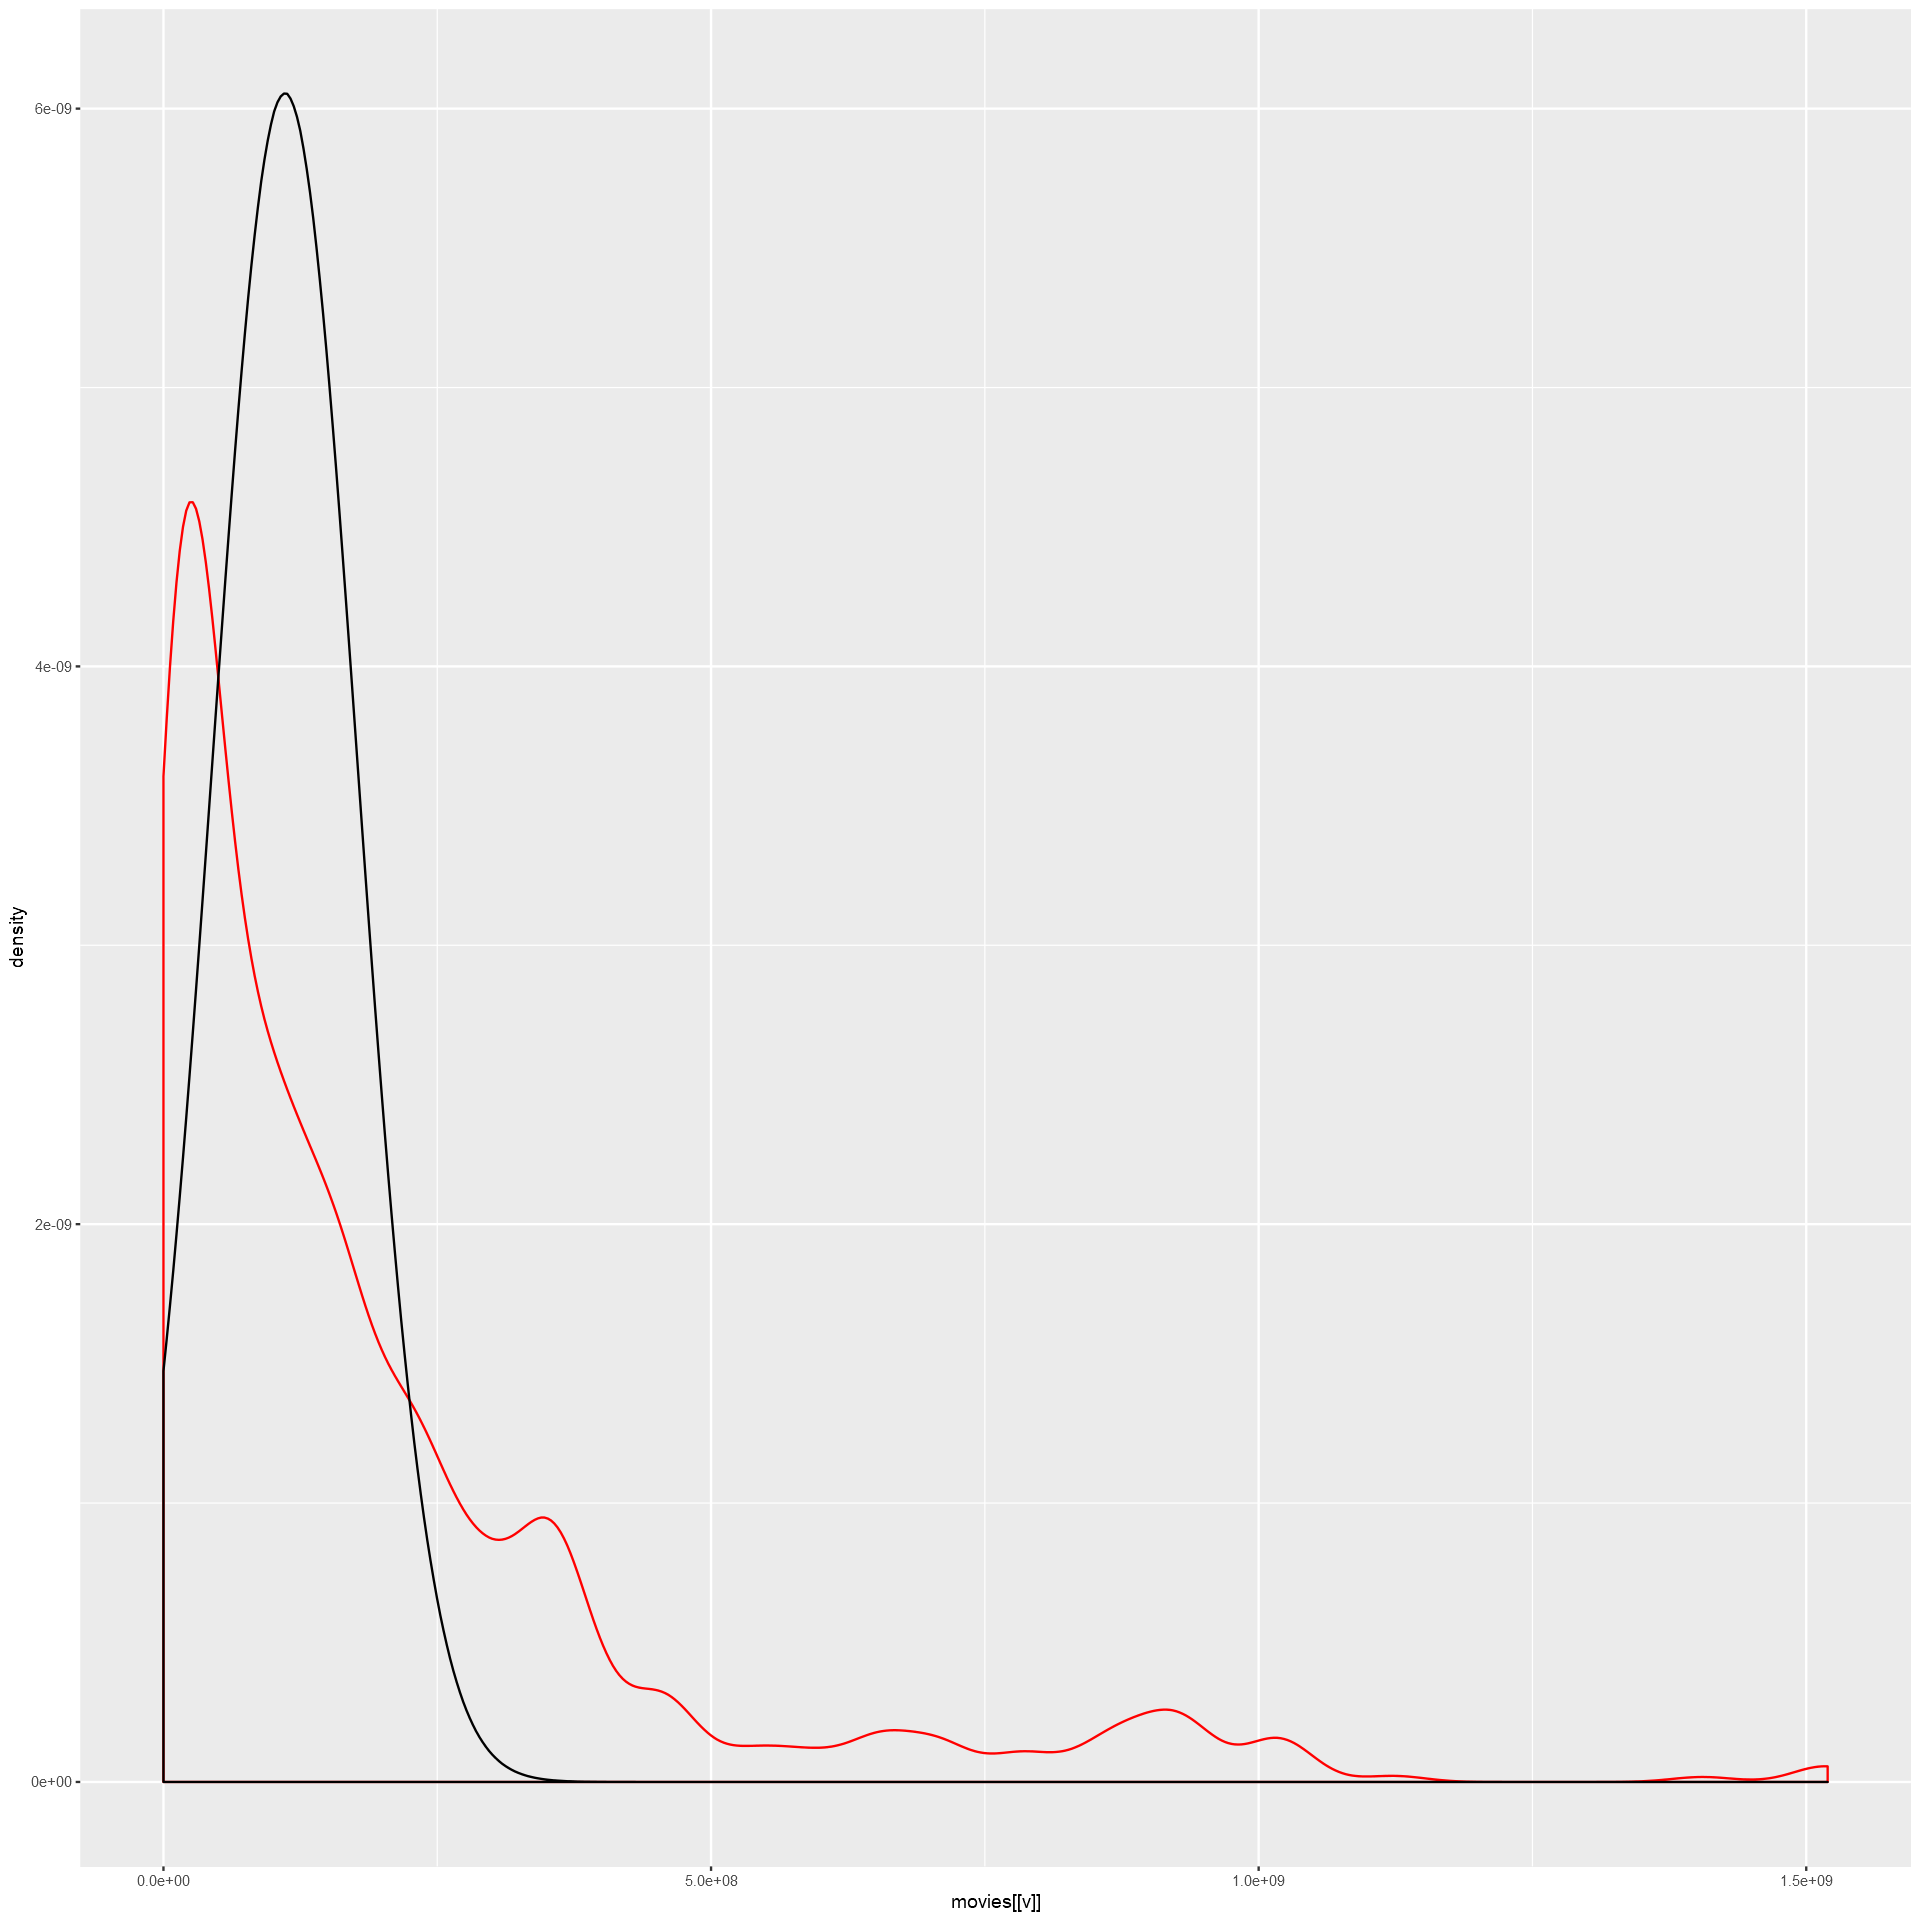

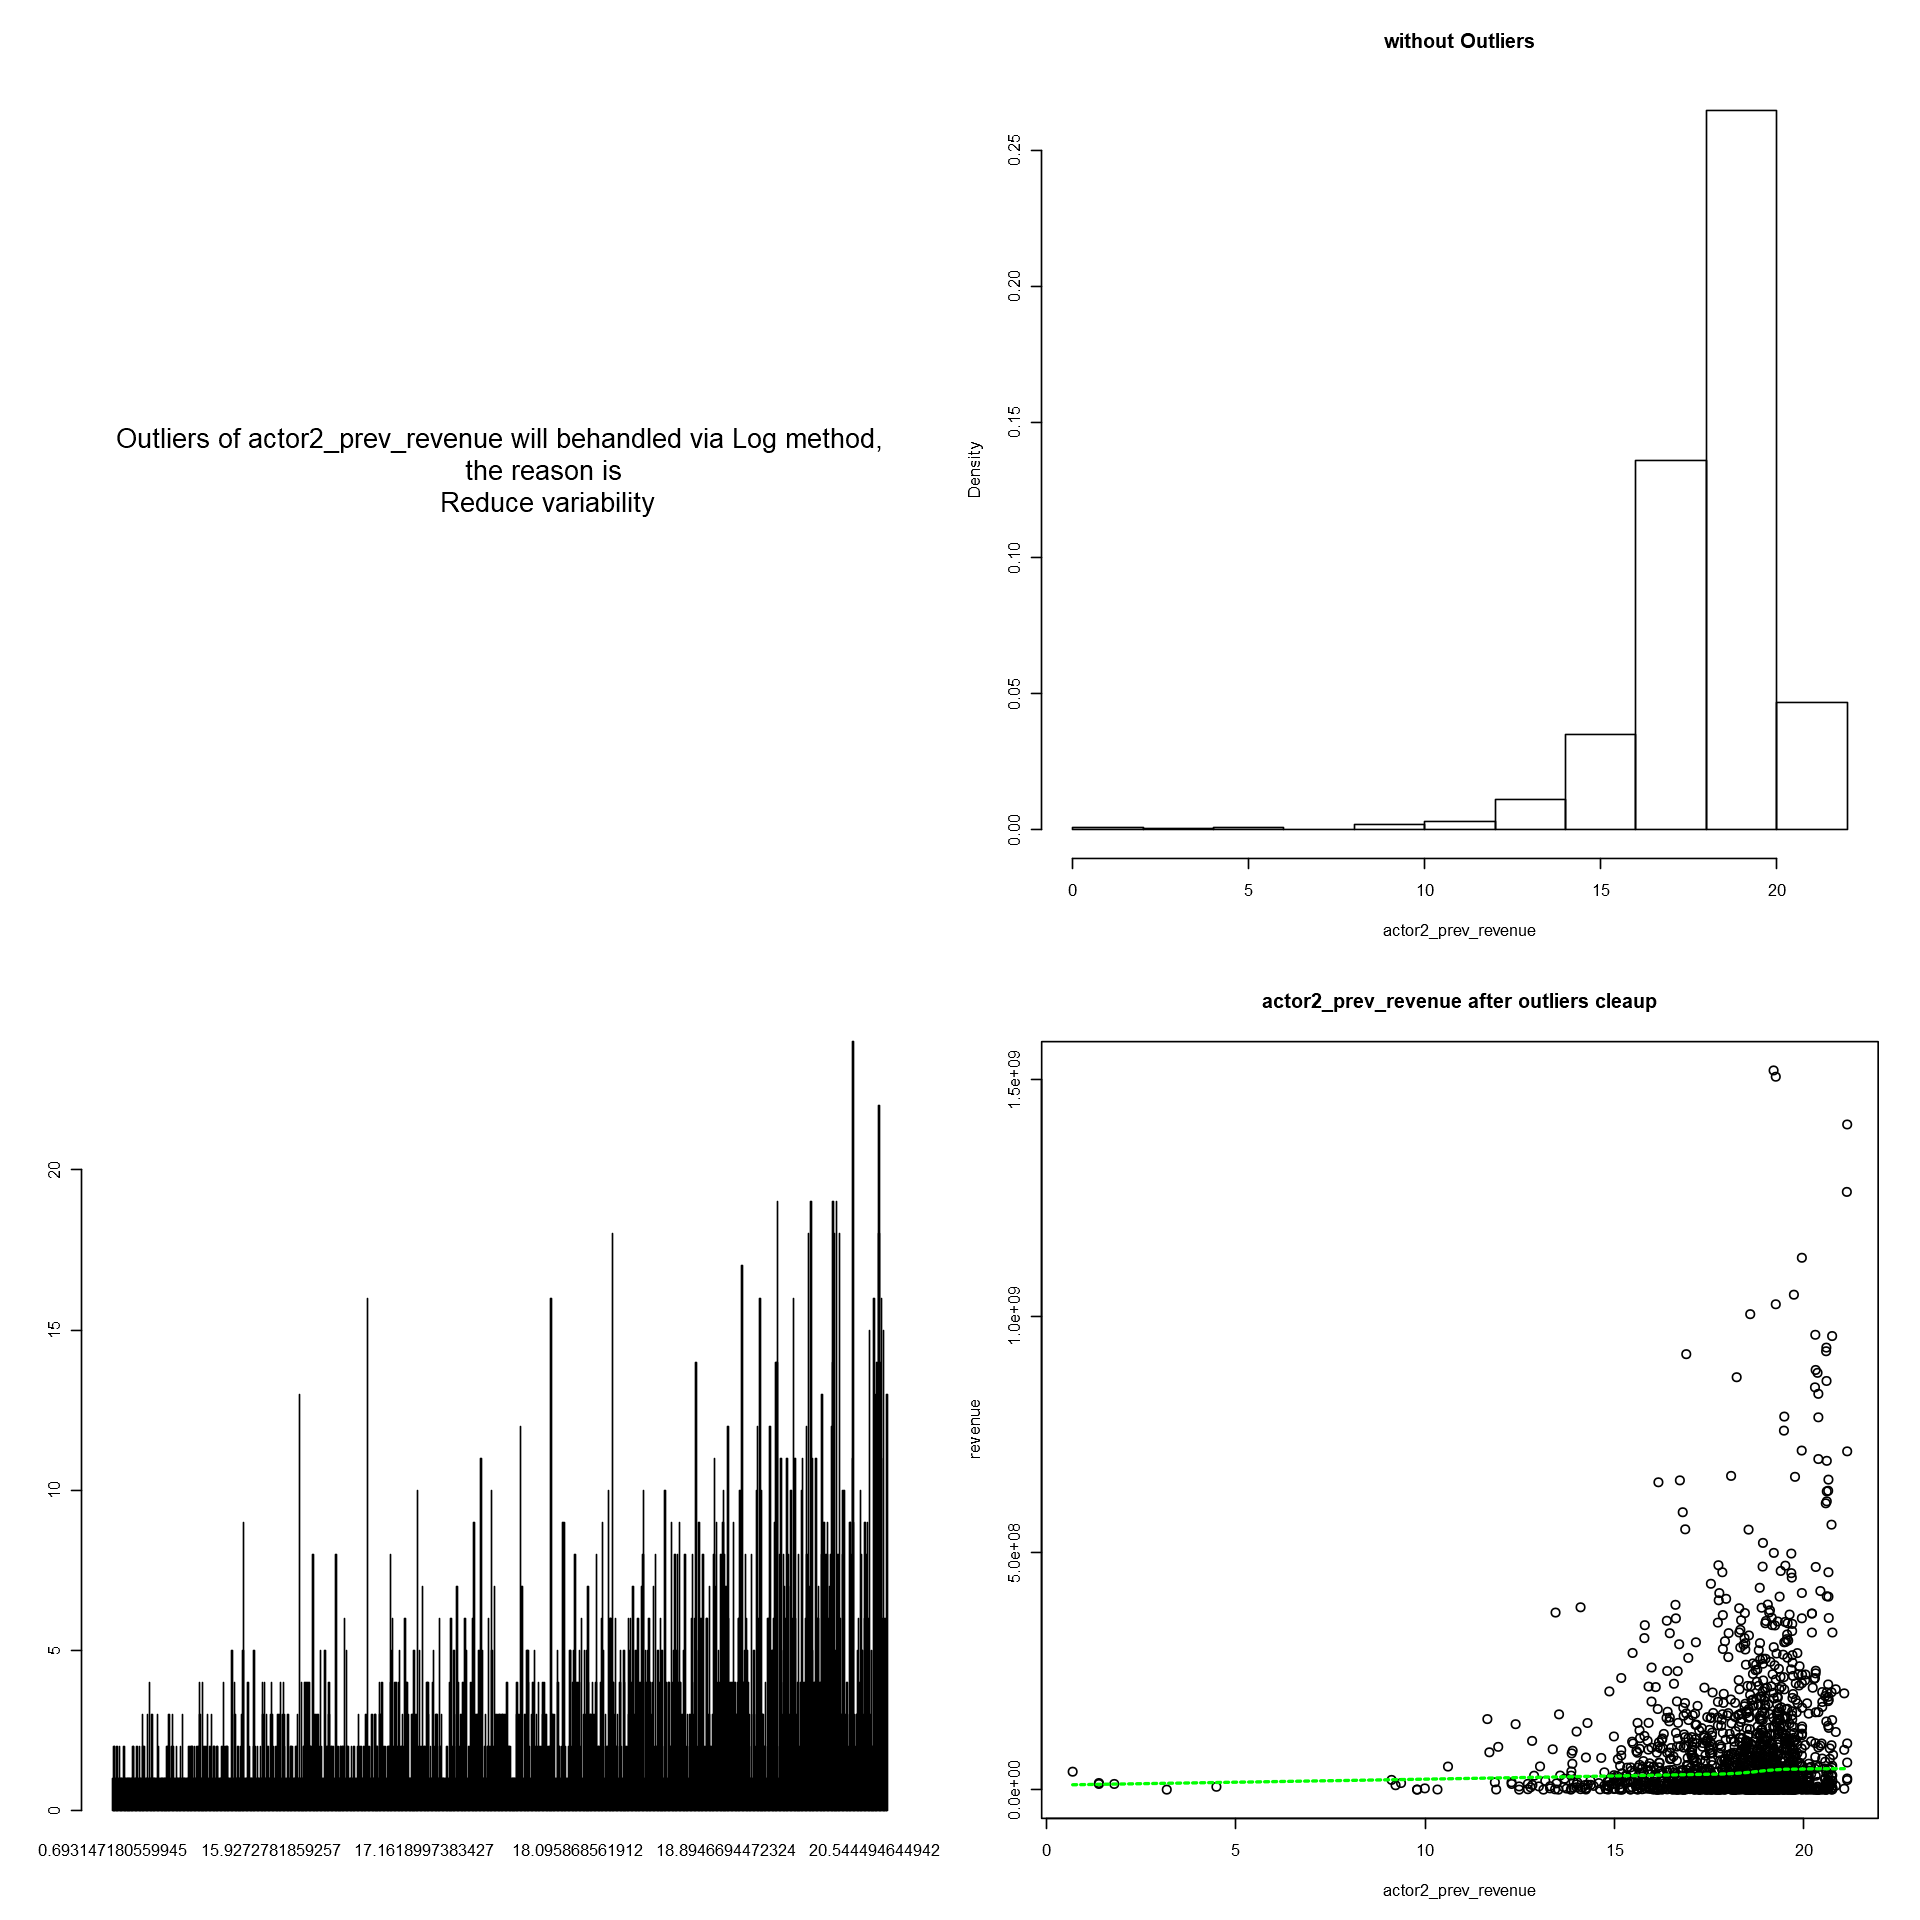

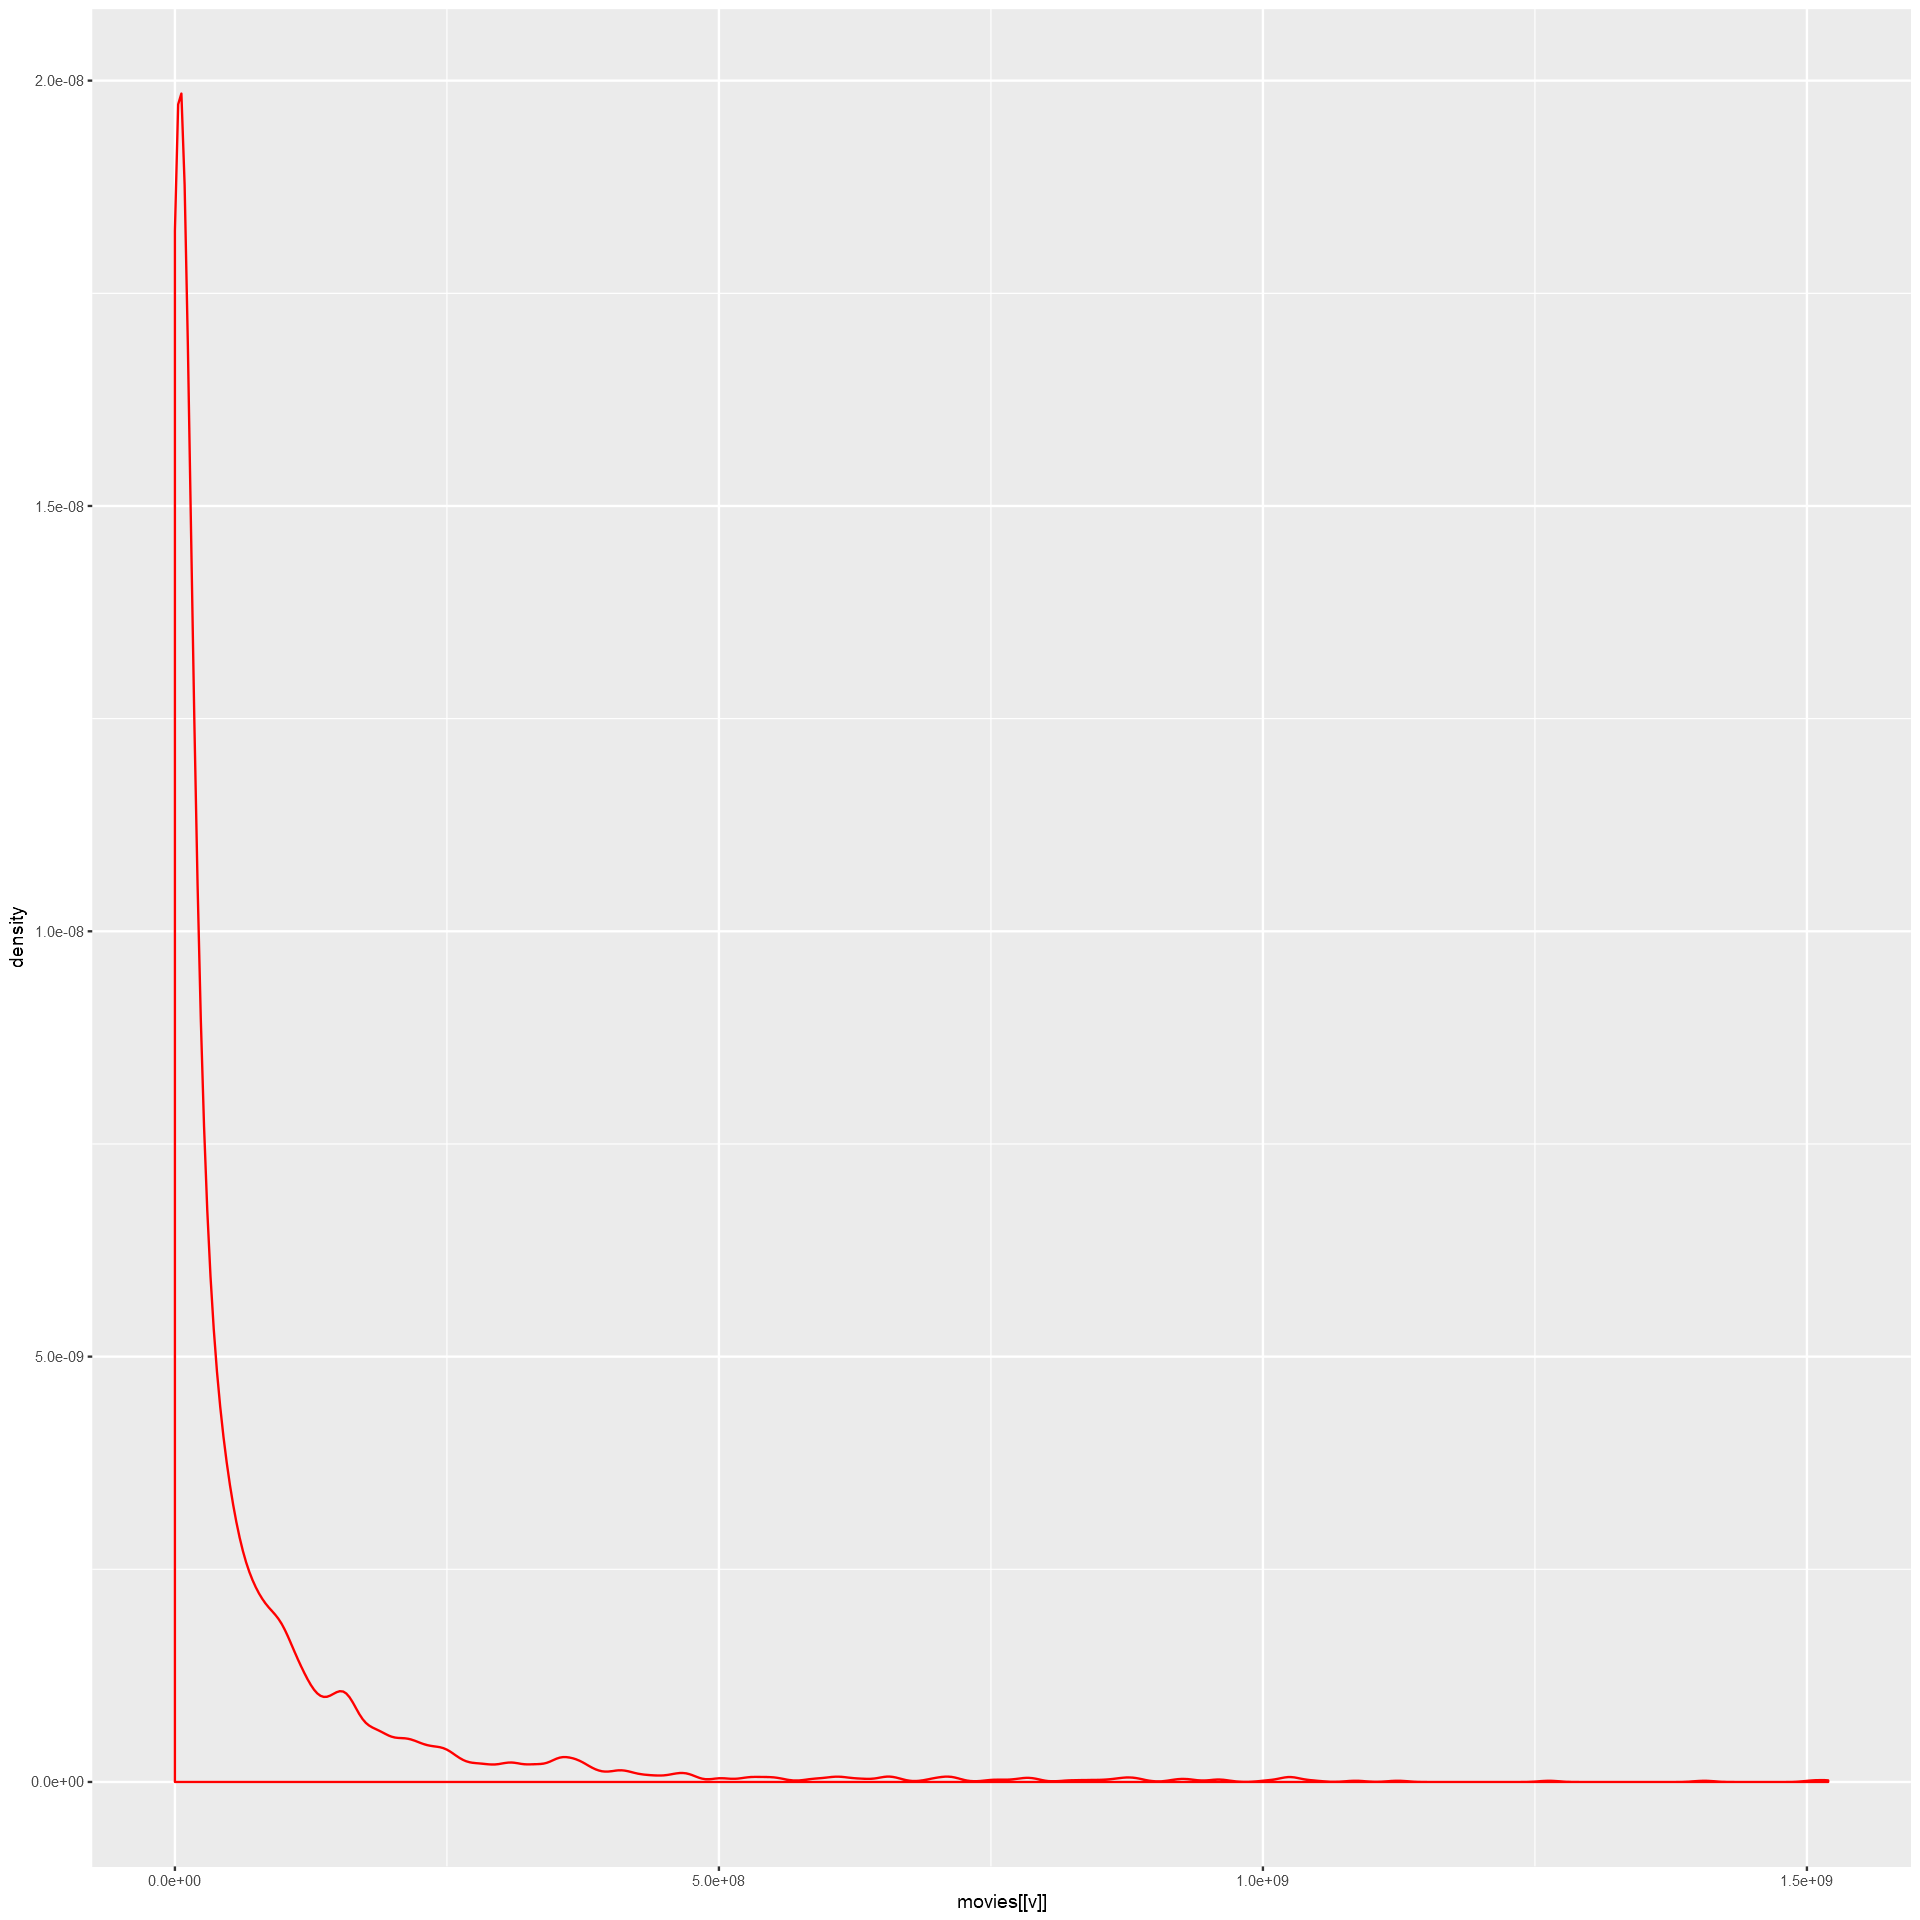

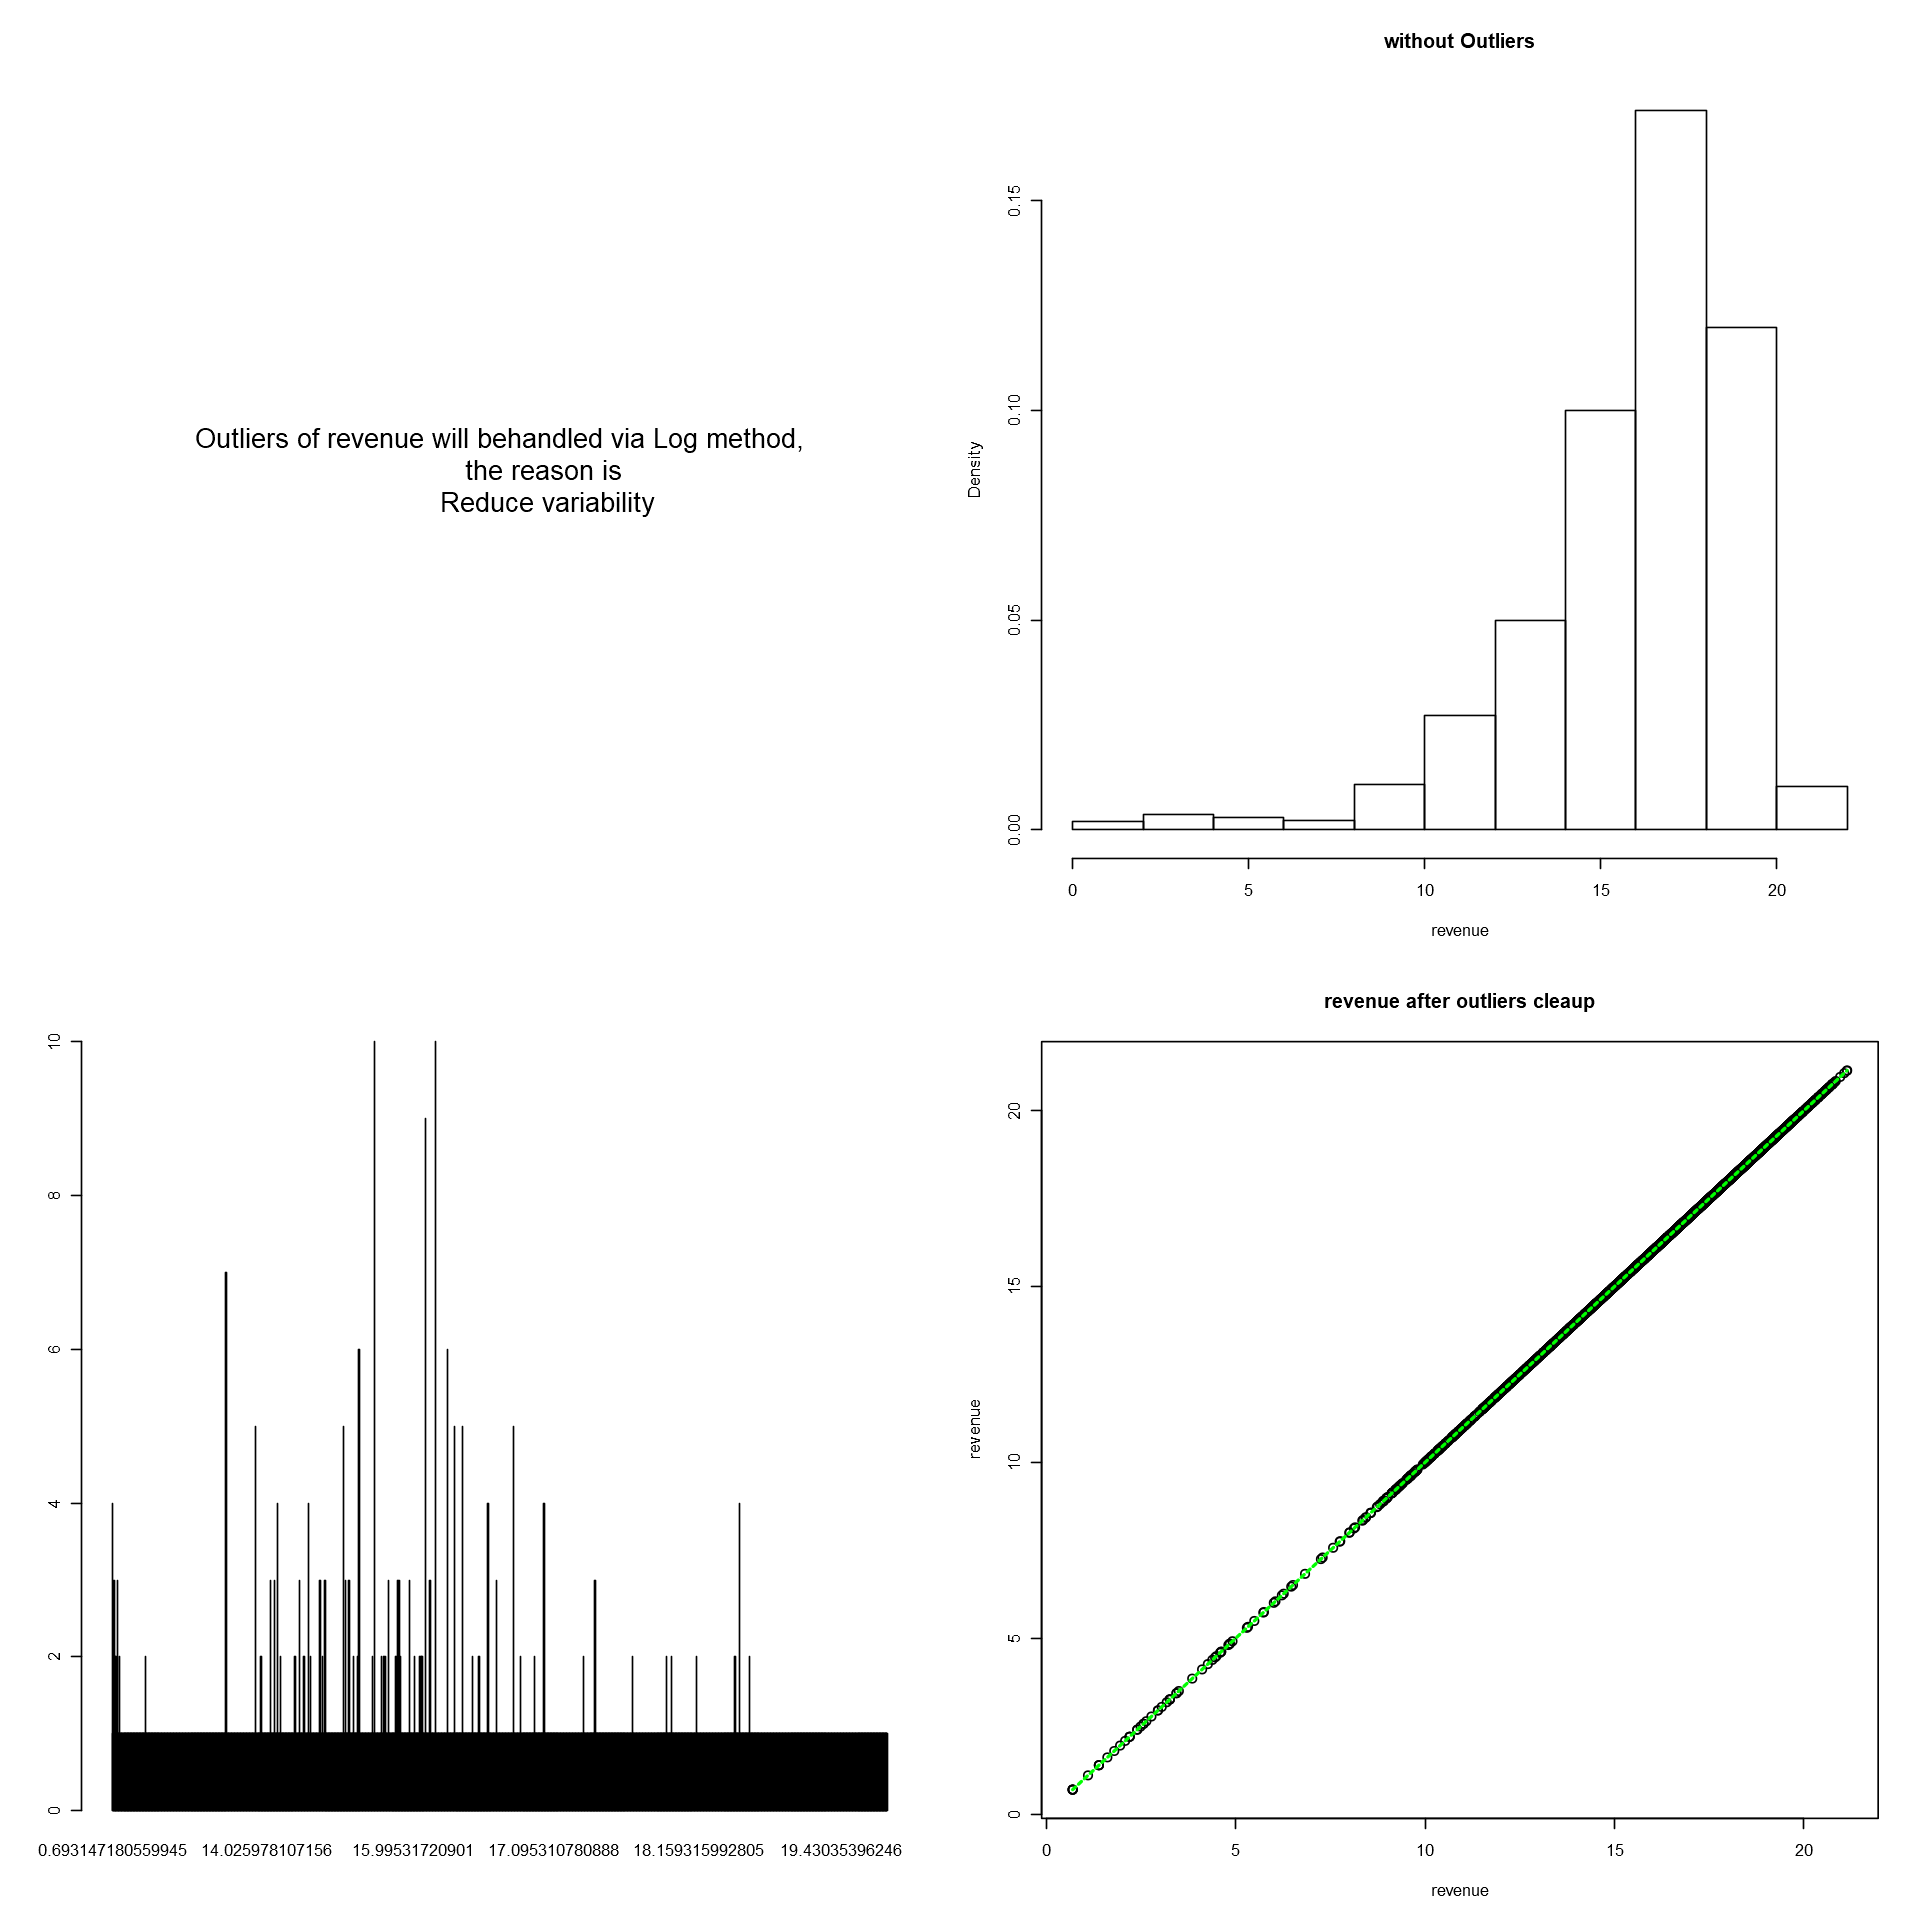

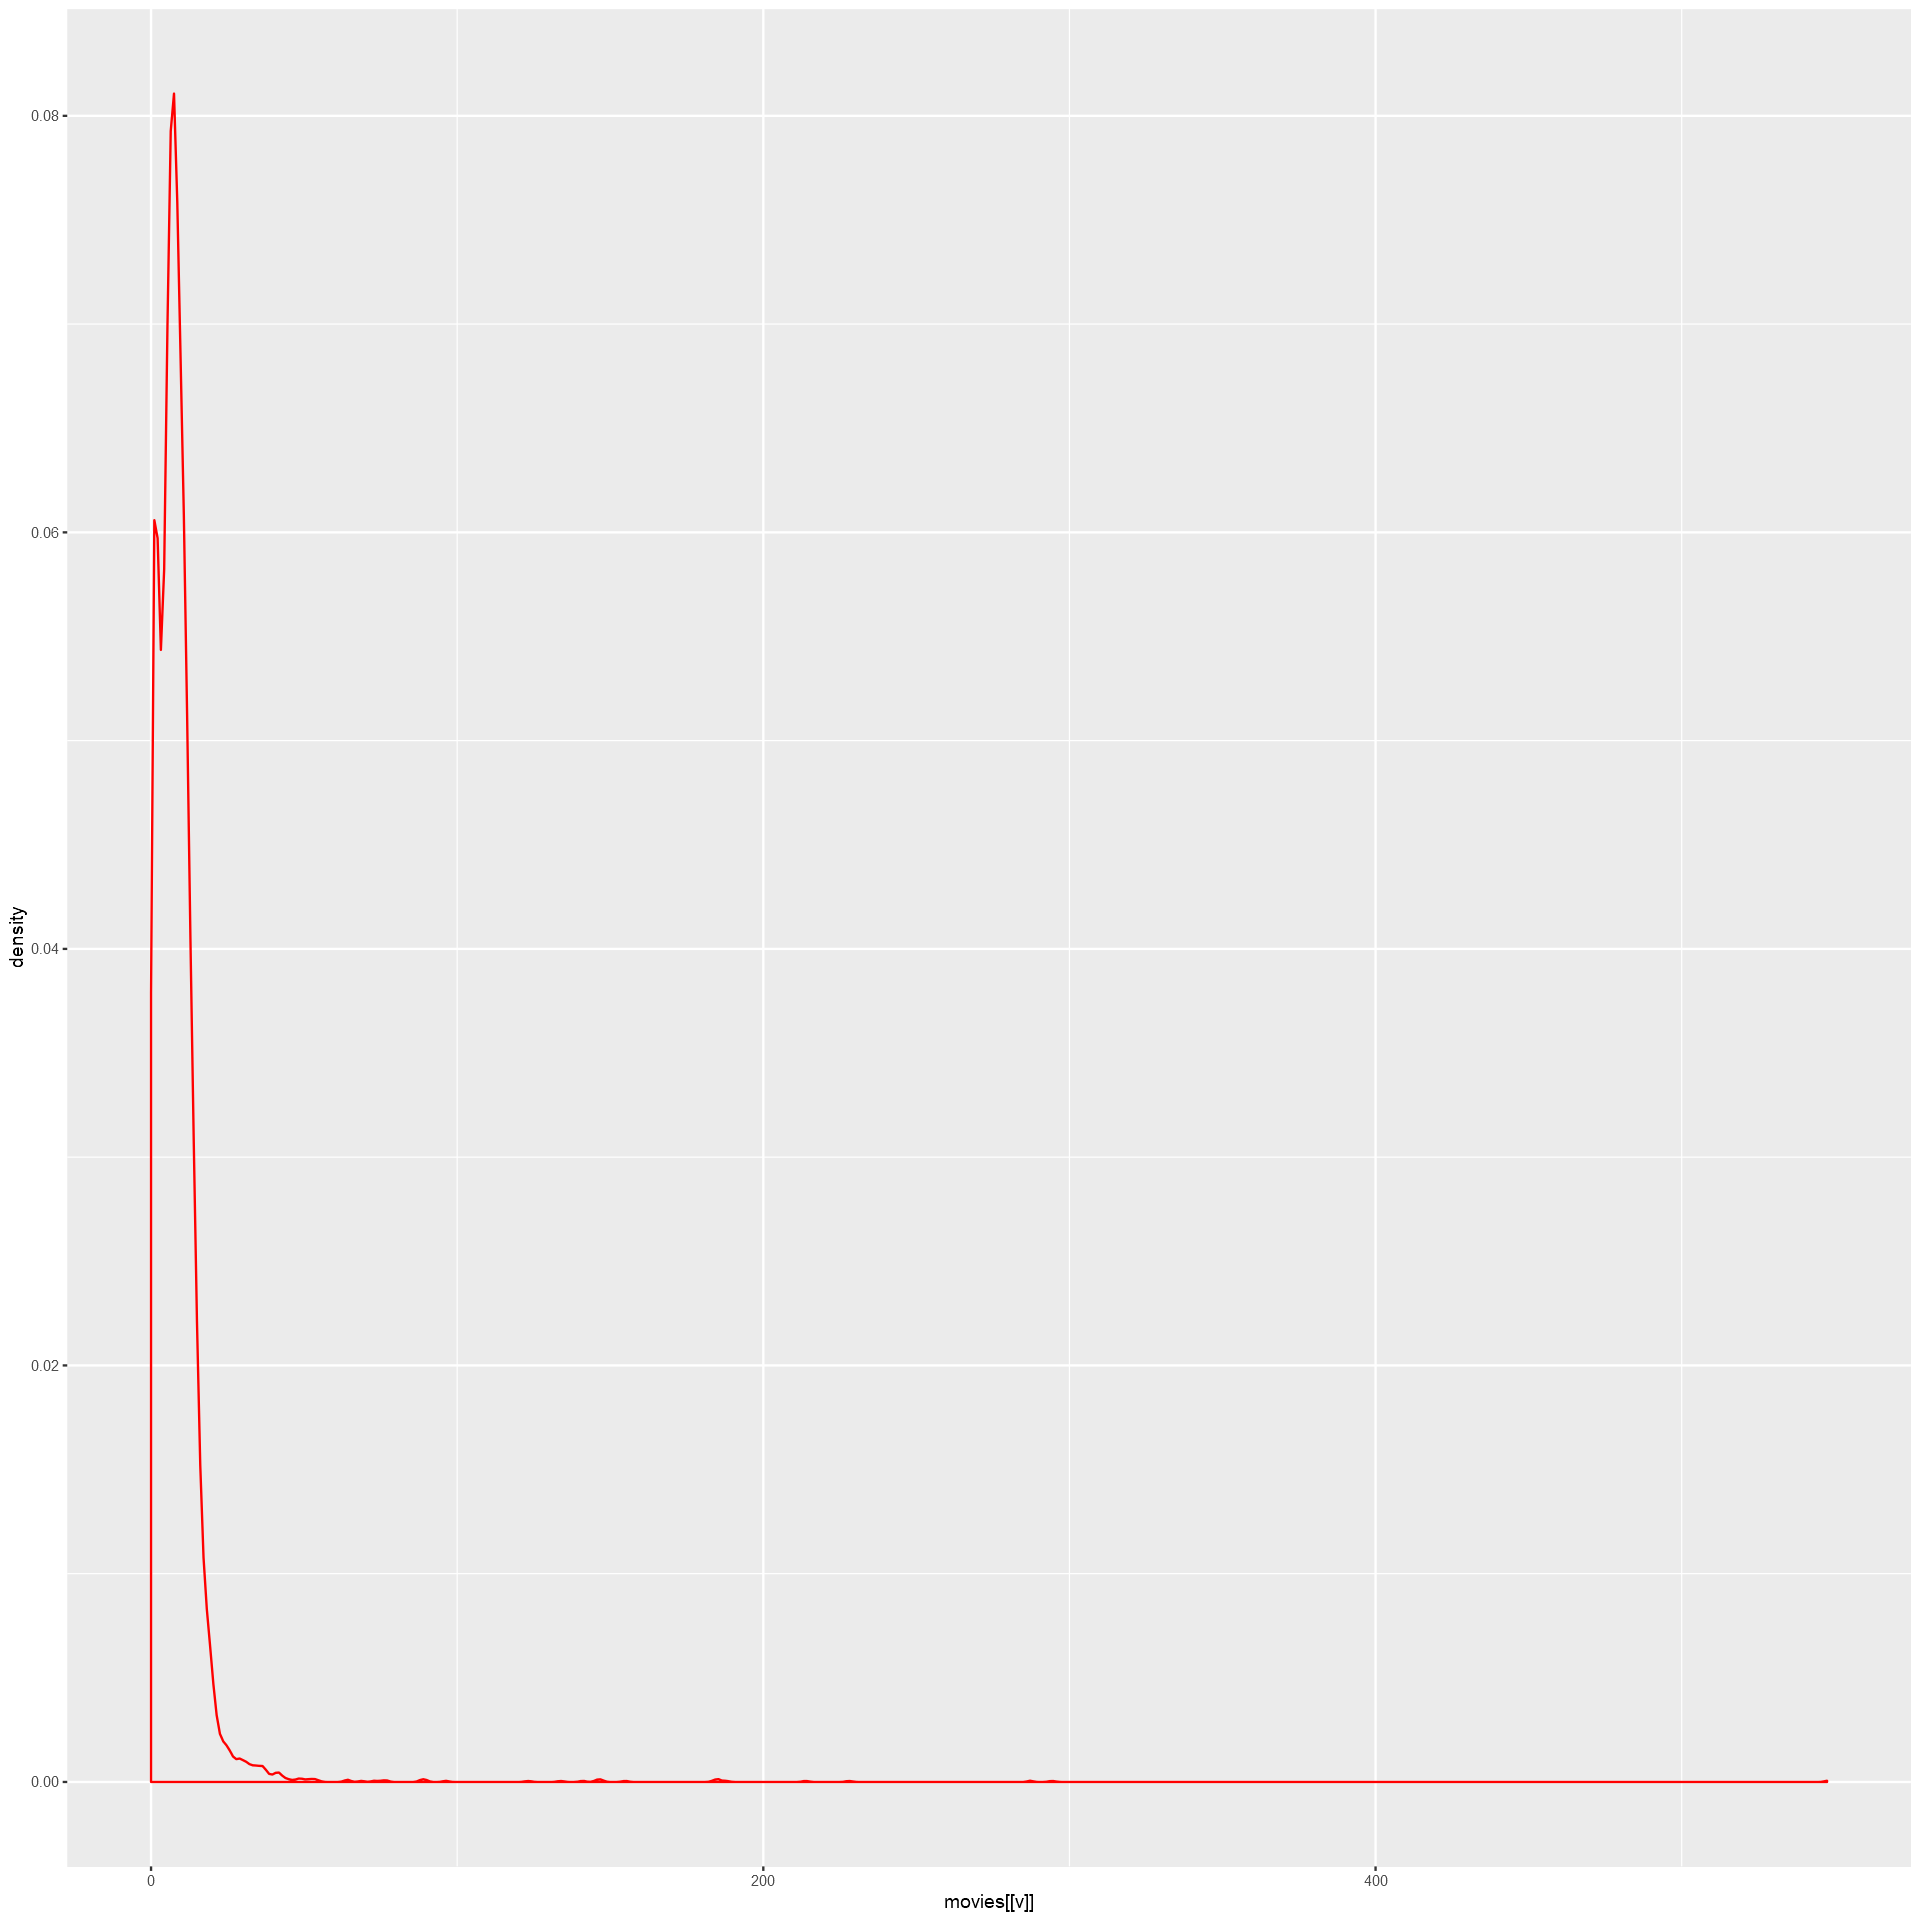

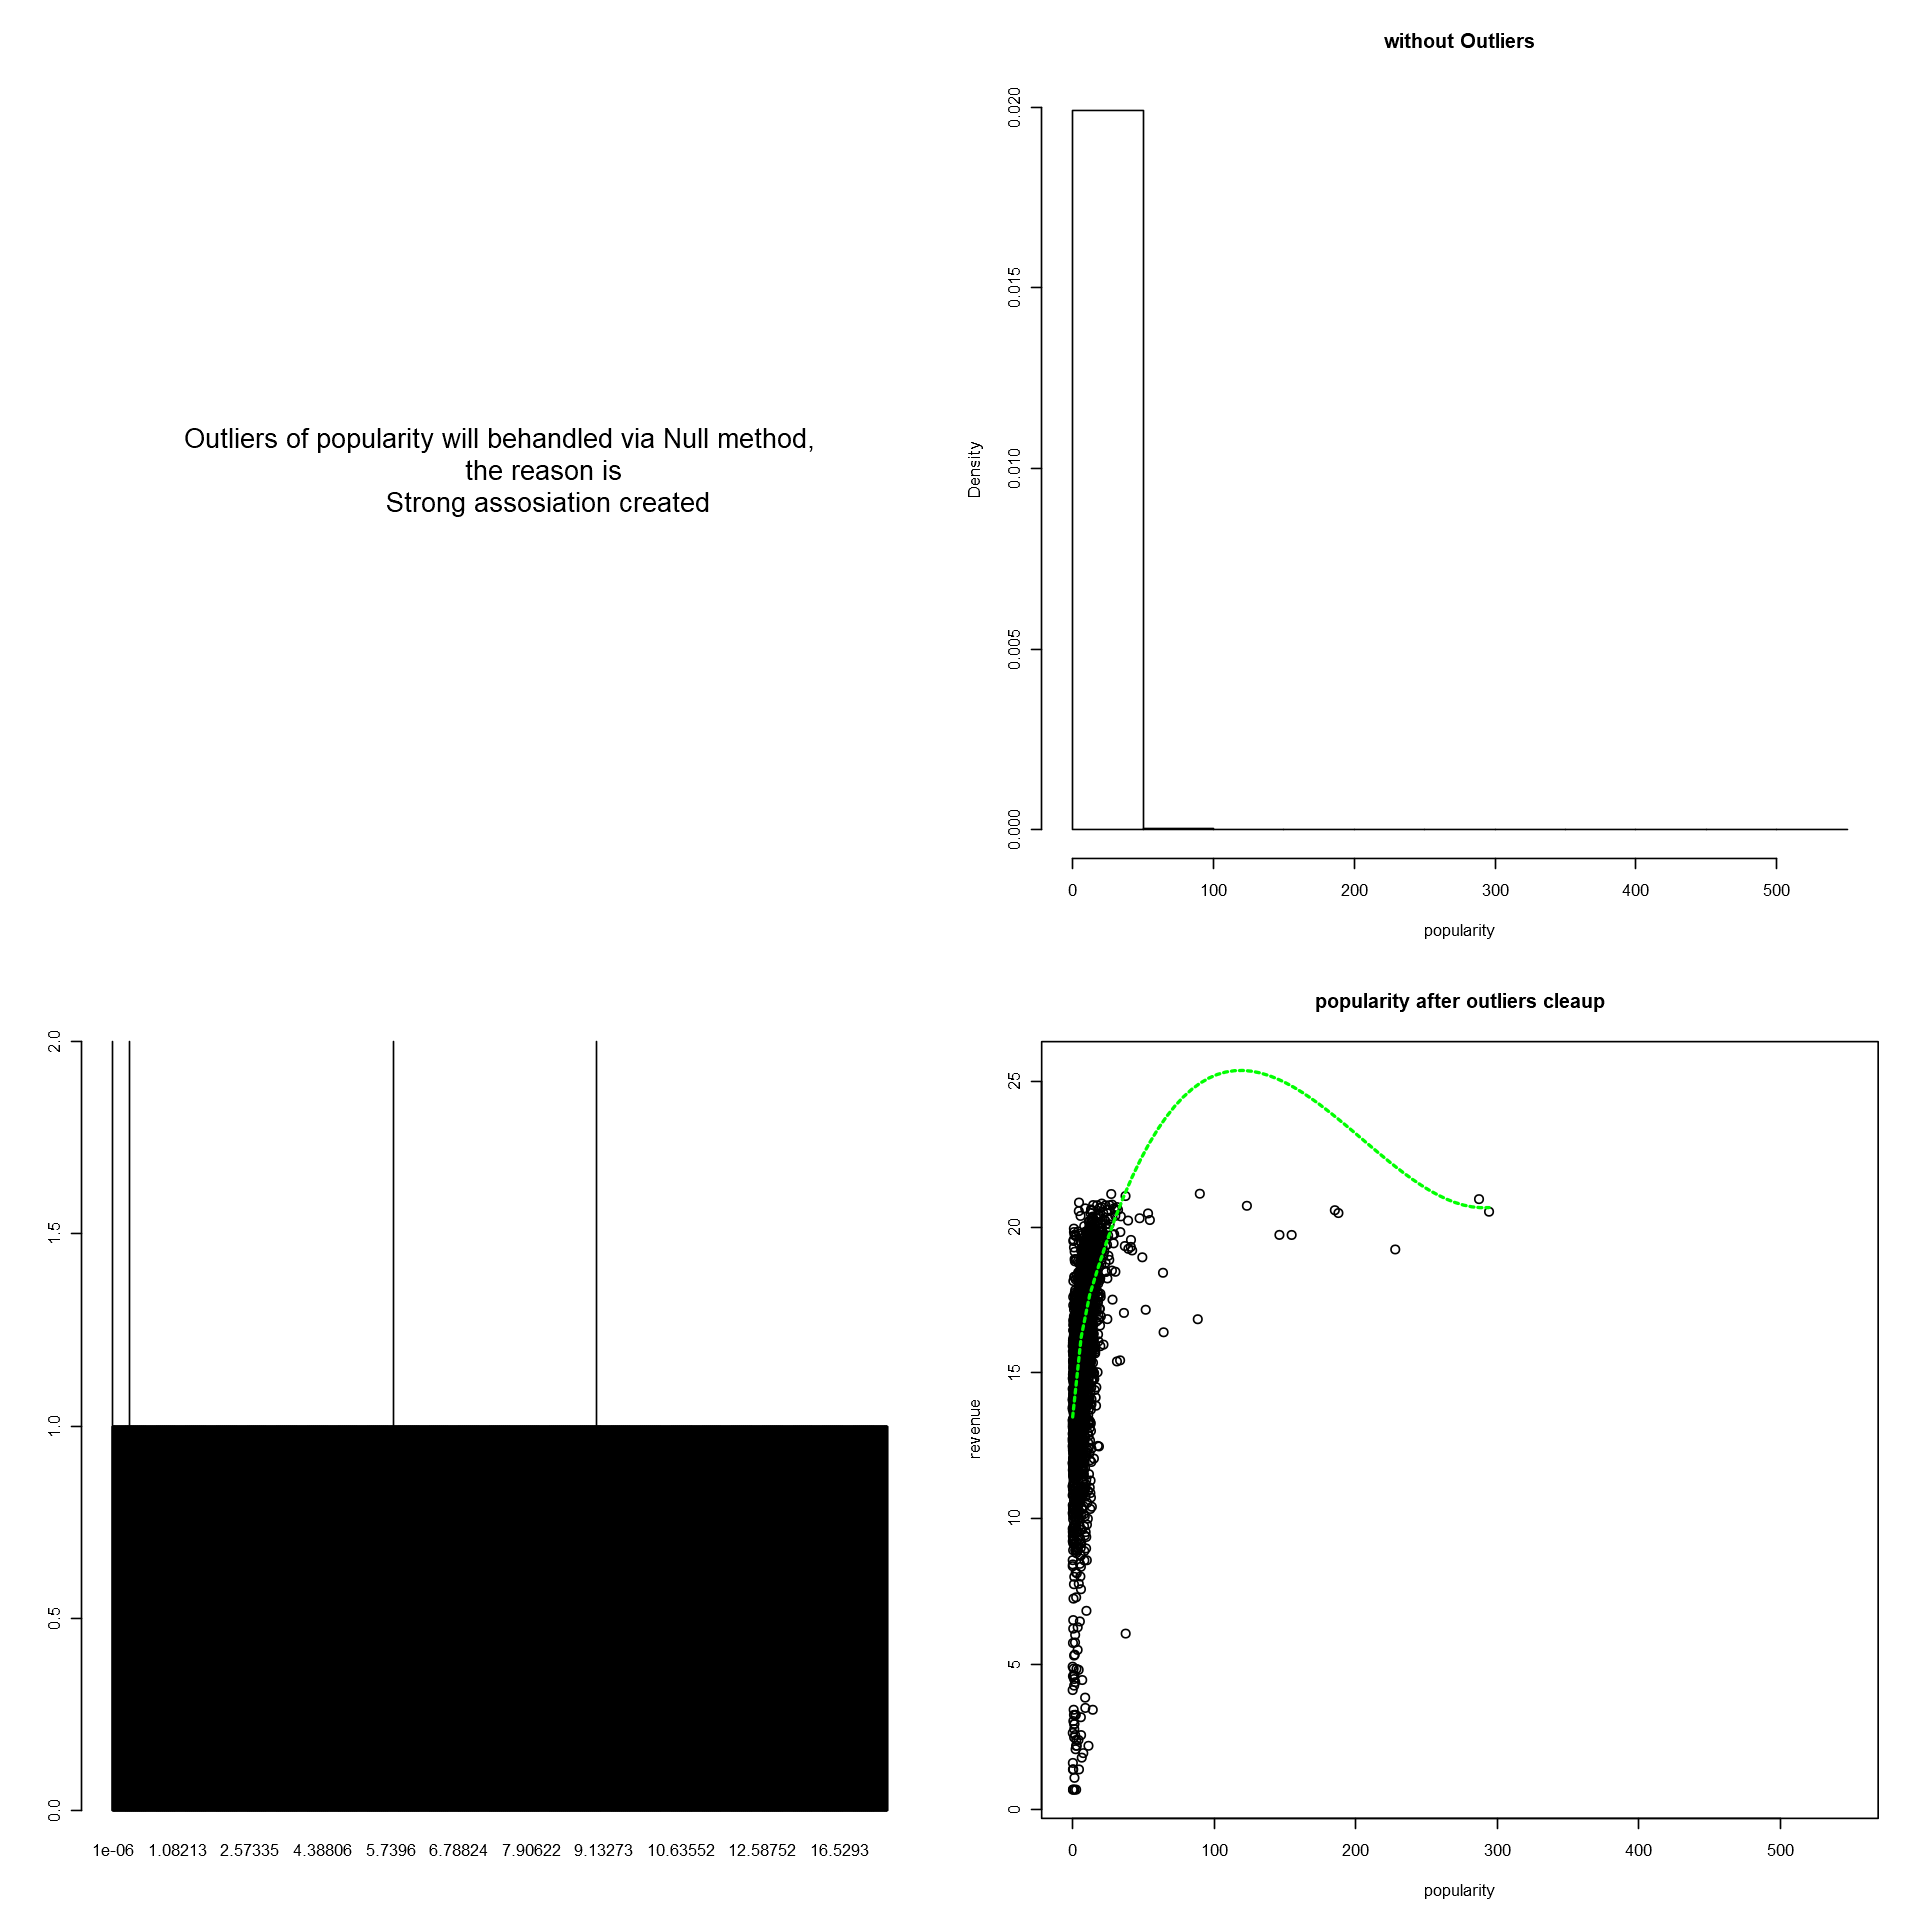

In [44]:
options(warn=-1)

# list all the numeric variables
numerics<-str_trim(protocol$Feature.name[protocol$Value.type == "Numeric"])


outlierMatrix <- function(data,threshold=1.5) {
  vn <- names(data)
  outdata <- data.frame(row1=1:nrow(data))
  for(v in vn) {
    if(is.numeric(data[[v]])) {
      med<- median(data[[v]], na.rm = T)
      outlow <- quantile(data[[v]],probs = 0.25,na.rm = T)
      outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
      irq_level <- (outhigh - outlow) * threshold
      outlow <- outlow - irq_level
      outhigh <- outhigh +  irq_level
      mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
      outdata[v] <- mv
    } else {
      mv <- rep(0,nrow(data))
    }
  }
  outdata$row1 <- NULL
  return(outdata)
}
##########################################################################################
outlierMatrixWinsorizing <- function(data, v, threshold=1.5) {
  if(is.numeric(data[[v]])) {
    med<- median(data[[v]], na.rm = T)
    outlow <- quantile(data[[v]],probs = 0.25,na.rm = T)
    outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
    irq_level <- (outhigh - outlow) * threshold
    outlow <- outlow - irq_level
    outhigh <- outhigh +  irq_level

    data[data[[v]] < outlow, v]<-outlow

    data[data[[v]] > outhigh, v]<-outhigh

  } else {
    mv <- rep(0,nrow(data))
  }

  return(data)
}

##########################################################################################

movies_threshold<-2.0

out<-outlierMatrix(movies,threshold = movies_threshold)


ocmovies<-movies


for(v in numerics) {
    options(repr.plot.width = 16, repr.plot.height = 16)
  #look on variable with some variability

    #v<-"budget"
  par(mfrow=c(3,2))
  #options(repr.plot.width = 8, repr.plot.height = 4)

    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, v,
       cex = 1.6, col = "black")

    hist(movies[[v]], freq = FALSE, xlab = v,  main = "With Outliers")

    barplot(table(movies[[v]]))

  
    scatter.smooth(movies[['revenue']] ~ movies[[v]], main=v, xlab=v ,ylab="revenue", family="symmetric",
                 lpars =list(col = "green", lwd = 2, lty = 2), col=out[[v]]+1)
    
    

    #print the variable distribution with and without outliers
    out<-boxplot(movies[[v]], main = paste("boxplot of ", v), plot=TRUE)
    
    med<-median(movies[[v]],  na.rm = TRUE)
            
    MAX_THR<- 10000000000
    MIN_THR<- -10000000000
    
    vec<-movies[[v]]
    #find all the ouliers smaller than median
    temp<-vec[which(vec< med)]
    
        # the biggest is the MIN_THR
       if (0 < length(temp)){
            MIN_THR<-max(temp)
        }
    
    #find all the ouliers bigger than median
    temp<-vec[which(vec>med)]
    
        # the smaller is the MAX_THR
        if (0 < length(temp)){
           MAX_THR<-min(temp)
        }
       
    v.out<-ifelse(movies[[v]] >= MAX_THR | movies[[v]] <= MIN_THR,1,0)
    v.noout<-movies[[v]]    
    v.noout<-ifelse(v.out==1, NA, v.noout)
    
    #print if the vector w/o the outliers is numeric
    if (is.numeric(v.noout)){
        options(repr.plot.width = 4, repr.plot.height = 4)
        ggp<-ggplot() + 
        geom_density(aes(movies[[v]]), color = "red") +
        geom_density(aes(v.noout)) 

        print(ggp)
    
        mod1<-lm(movies[["revenue"]] ~ movies[[v]])
        mod2<-lm(movies[["revenue"]] ~ v.noout)
        
        plot(movies["revenue"], movies[[v]], col=factor(v.out), xlab=v, ylab = "revenue")
        abline(mod1, col="red")
        abline(mod2, col="green")
    }
    
    
        
    

  ##############################
  #Handle outliers
  ##############################

  mes<-sprintf("Outliers of %s will behandled via %s method,
            the reason is \
            %s",v,
            protocol[v, "Outlier.treatment"],
            protocol[v, "Outlier.Notes"])



  if (protocol[v,"Outlier.treatment"] == "Leave"){

    par(mfrow=c(1,2))
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    #options(repr.plot.width = 8, repr.plot.height = 4)
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, paste("Do nothing for", v),
         cex = 1.6, col = "black")

  } else if (protocol[v,"Outlier.treatment"] == "Null"){

    #drop outlier value (replace by NA)
    ocmovies[which(out[[v]] == 1), v]<-NA


    par(mfrow=c(2,2))
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    #options(repr.plot.width = 8, repr.plot.height = 8)
    hist(ocmovies[[v]], freq = FALSE, xlab = v,  main = "without Outliers")

    barplot(table(ocmovies[[v]]))

    
    scatter.smooth(ocmovies[['revenue']] ~ ocmovies[[v]], main=paste(v, "after outliers cleaup"), xlab=v ,ylab="revenue", family="symmetric",
                   lpars =list(col = "green", lwd = 2, lty = 2))
    

  } else if (protocol[v,"Outlier.treatment"] == "Log"){

    ocmovies[[v]]<-log(movies[[v]] + 1)


    par(mfrow=c(2,2))
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    hist(ocmovies[[v]], freq = FALSE, xlab = v,  main = "without Outliers")

    barplot(table(ocmovies[[v]]))

    scatter.smooth(ocmovies[['revenue']] ~ ocmovies[[v]], main=paste(v, "after outliers cleaup"), xlab=v ,ylab="revenue", family="symmetric",
                   lpars =list(col = "green", lwd = 2, lty = 2))
    

  } else if (protocol[v,"Outlier.treatment"] == "Sqrt"){

    ocmovies[[v]]<-sqrt(movies[[v]] + 1)

    par(mfrow=c(2,2))
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    hist(ocmovies[[v]], freq = FALSE, xlab = v,  main = "without Outliers")

    barplot(table(ocmovies[[v]]))

    scatter.smooth(ocmovies[['revenue']] ~ ocmovies[[v]], main=paste(v, "after outliers cleaup"), xlab=v ,ylab="revenue", family="symmetric",
                   lpars =list(col = "green", lwd = 2, lty = 2))
    

  } else if (protocol[v,"Outlier.treatment"] == "Winsorizing"){

    ocmovies<-outlierMatrixWinsorizing(movies, v, movies_threshold)


    par(mfrow=c(2,2))
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    hist(ocmovies[[v]], freq = FALSE, xlab = v,  main = "without Outliers")

    barplot(table(ocmovies[[v]]))

    scatter.smooth(ocmovies[['revenue']] ~ ocmovies[[v]], main=paste(v, "after outliers cleaup"), xlab=v ,ylab="revenue", family="symmetric",
                   lpars =list(col = "green", lwd = 2, lty = 2))
    

  } else if (protocol[v,"Outlier.treatment"] == "Categorize"){

    cat_num<-protocol[v,"Categories.num"]
    cat_num_vec<-unlist(strsplit(cat_num, ","))


    cat_names<-protocol[v,"Categories.names"]
    cat_names_vec<-unlist(strsplit(cat_names, ","))

    ocmovies[[v]]<-cut(movies[[v]], breaks = as.numeric(cat_num_vec), labels = cat_names_vec,
                       right = FALSE)

    st<-sprintf("Numeric variable %s Was categorized, values were replaced with %s breaks \
                  with following names %s", v, cat_num, cat_names)

    par(mfrow=c(2,2))
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, mes,
         cex = 1.6, col = "black")
    
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(x = 0.5, y = 0.5, st,
         cex = 1.6, col = "black")
    
    plot(ocmovies[[v]], xlab = v)
  }

}
par(mfrow=c(1,1))

##########################################################################################
# Correlation Graph
##########################################################################################


corrplot 0.84 loaded



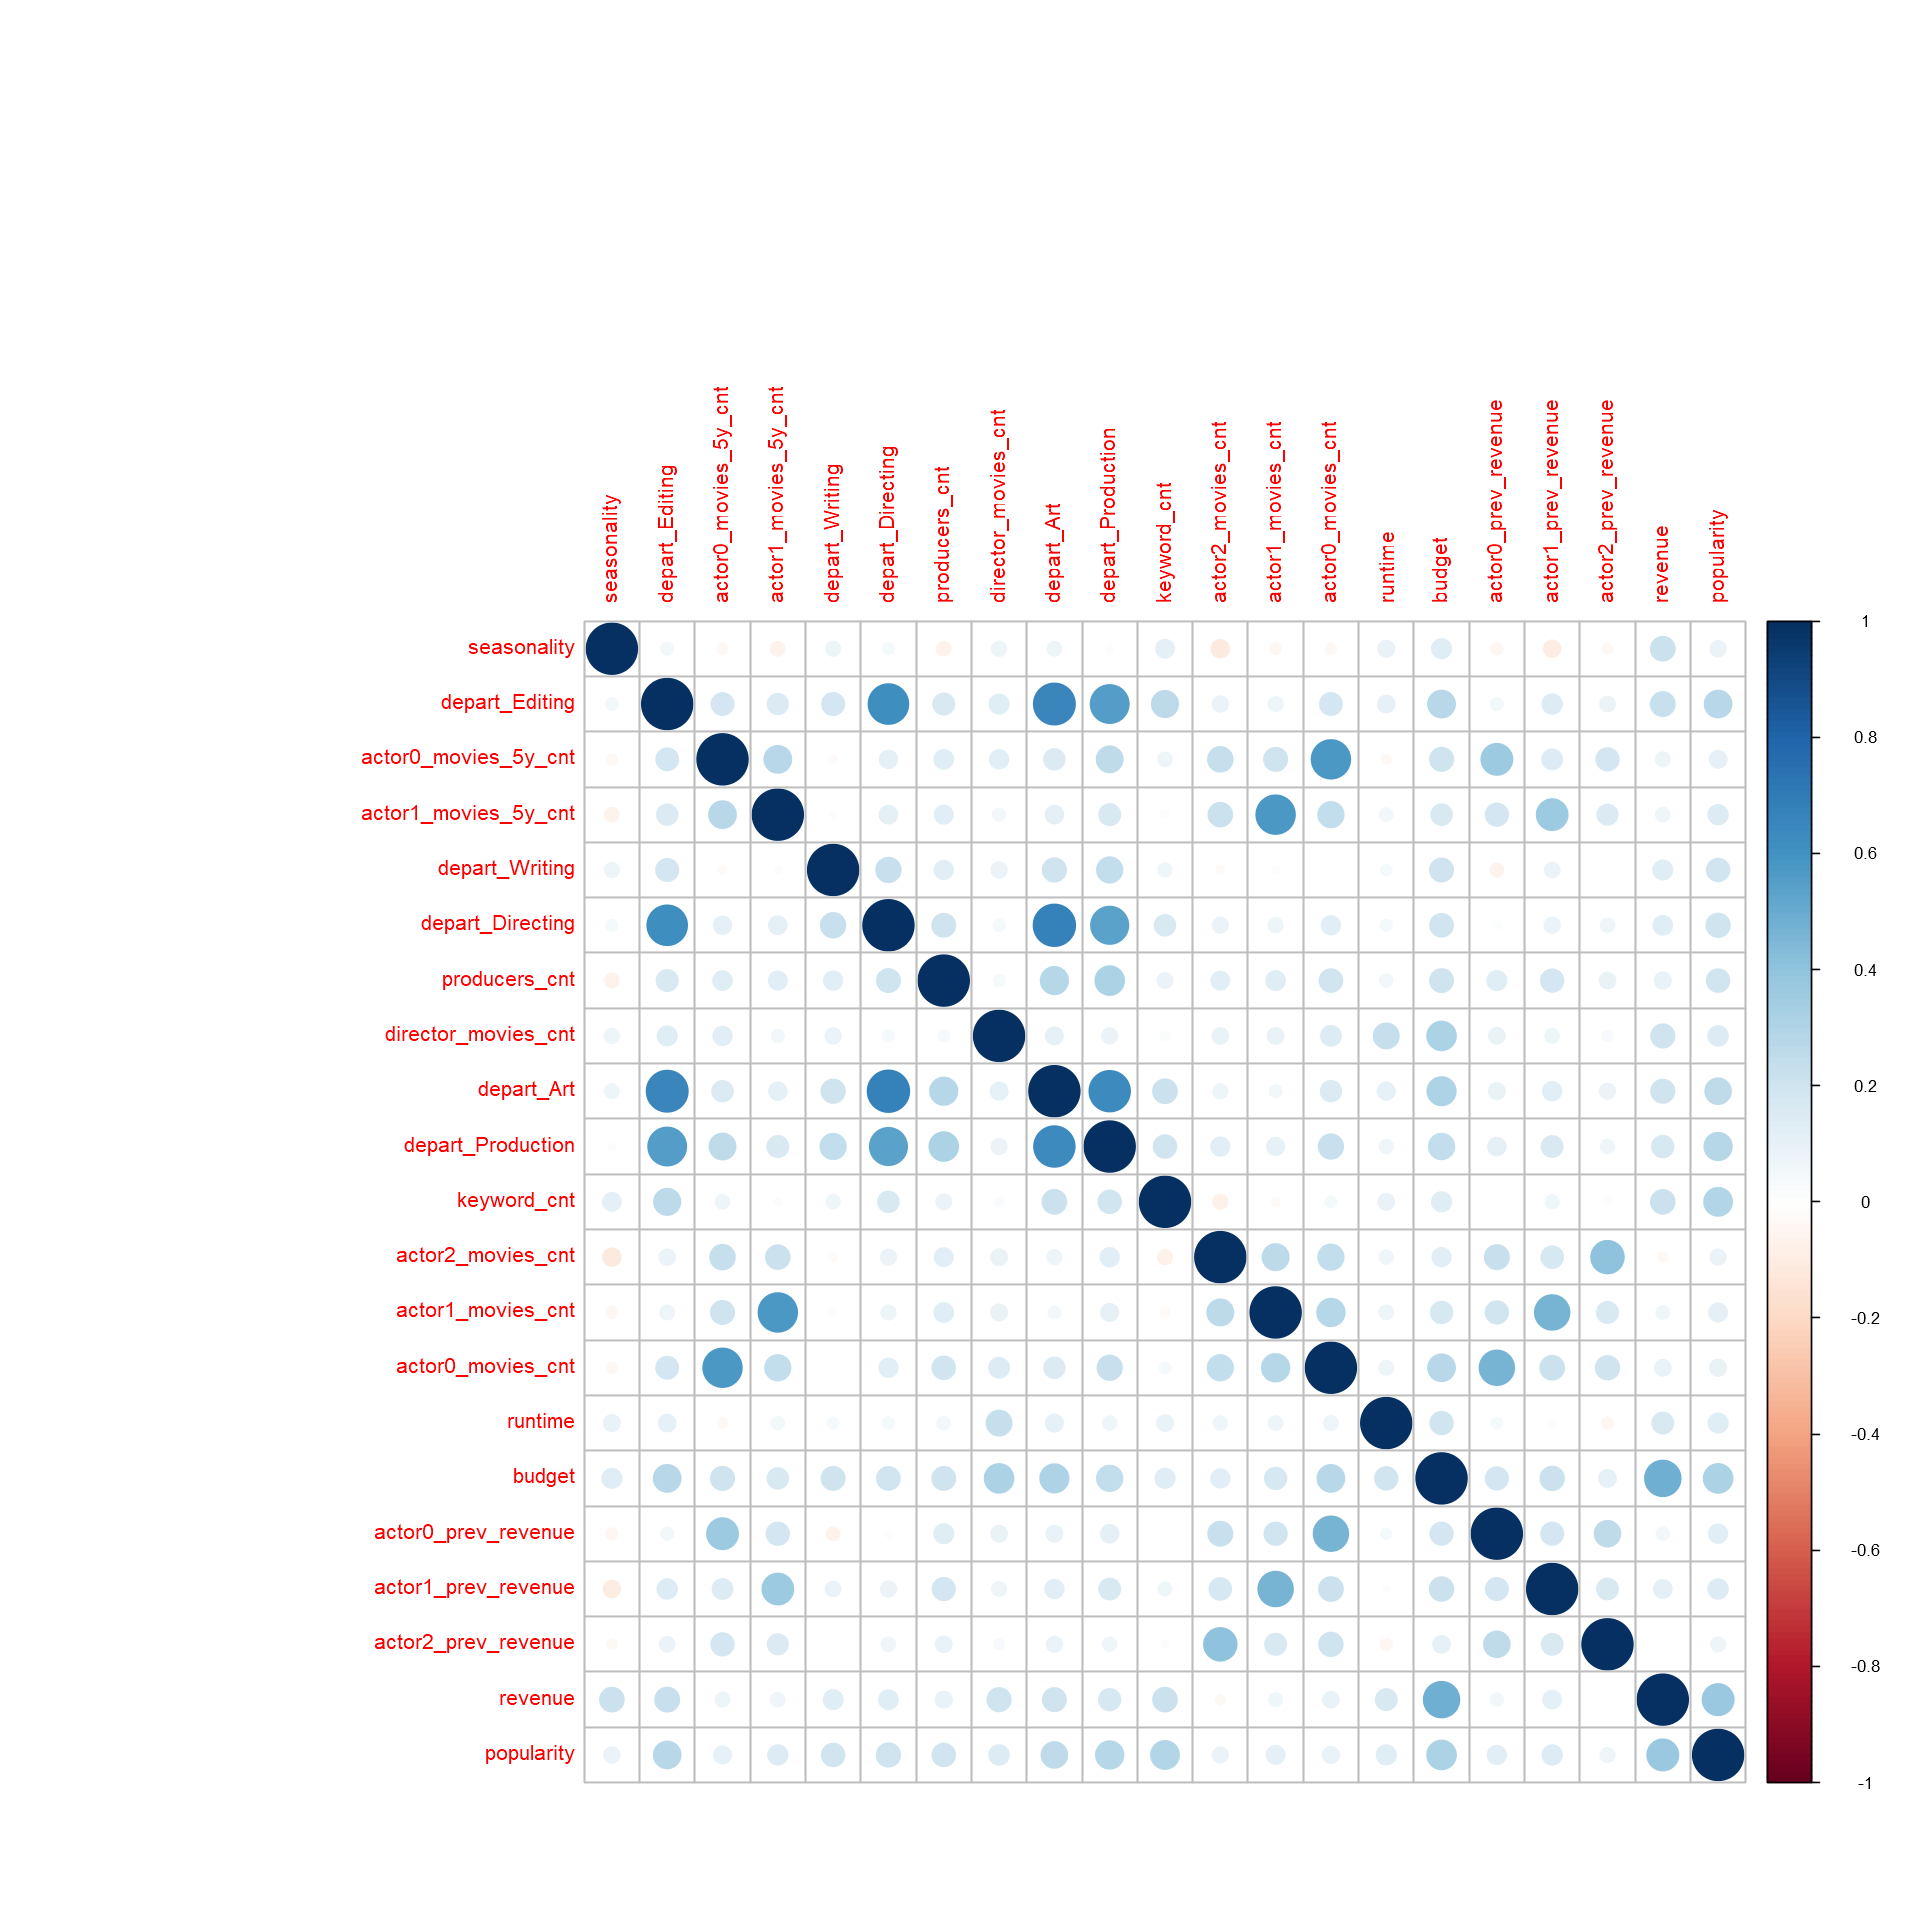

In [17]:

# list all the numeric variables
numerics<-str_trim(protocol$Feature.name[protocol$Value.type == "Numeric"])


#install.packages("corrplot")
library(corrplot)

corr<-cor(ocmovies[numerics], method = "pearson", use = "complete.obs")

corrplot(corr, method="circle")
